In [35]:
"""
Importing in requirements for SVGP Pytorch
"""
import tqdm
import math
import torch
import gpytorch

"""
Importing in libraries for SGD-SS-GP
"""
# Requirements for algorithms
import numpy as np
import scipy.special as sp
from functools import partial
from scipy.spatial.distance import cdist

# Requirements for simulations/monitoring algorithms
import time
from IPython.display import clear_output
import inspect
from sklearn.metrics import roc_auc_score

# Requirements For plots and diagnostics
import matplotlib.pyplot as plt
import scipy.stats as sps
from mpl_toolkits import mplot3d

# Make plots inline
%matplotlib inline

"""
Importing algorithm functions
"""
import os
os.chdir('C:/Users/hughw/Documents/MSC project/GP algorithms/Master function files')
from GP_funcs_ZTMFSS import kernel_funcs
from GP_funcs_ZTMFSS import model_funcs
from GP_funcs_ZTMFSS import draw_GP
from GP_funcs_ZTMFSS import fit
from GP_funcs_ZTMFSS import diagnostics
from GP_funcs_ZTMFSS import simulations
from functools import partial
os.chdir('C:/Users/hughw/Documents/MSC project/Simulation results')

"""
Defining procedure to run SVGP
"""

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader

def SVGP_train(y, X, lengthscale_init = 1, num_inducing=100, epochs=100, batch_size=100, learn_rate_variational = 0.1, learn_rate_hyper = 0.01, tol = 1e-4,seed=0, min_epochs = 100
              , alpha = 0.05):
    
    # setting dimensions
    ntrain,ntest, p = len(y), len(X), len(X.T)
    
    # loading in data
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    
    losses = np.zeros(1)

    # Creating model
    class GPModel(ApproximateGP):
        def __init__(self, inducing_points):
            variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
            variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
            super(GPModel, self).__init__(variational_strategy)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=gpytorch.kernels.RBFKernel(ard_num_dims = p))

            # Initialize lengthscale
            if np.any(lengthscale_init):
                self.covar_module.base_kernel.lengthscale *= lengthscale_init

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    np.random.seed(seed)
    inducing_points = X[np.random.choice(ntrain,num_inducing,False), :]
    model = GPModel(inducing_points=inducing_points)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

        num_epochs = epochs

    # Setting up model training
    t = time.time()
    torch.manual_seed(seed)
    model.train()
    likelihood.train()
    
    variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=train_y.size(0), lr=learn_rate_variational)

    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=learn_rate_hyper)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
    
    # Setting up convergence criteria
    epochs_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
    i = 0
    param_diff=1
    loss_diff=1
    param = 1/model.covar_module.base_kernel.lengthscale
    
    # Training model
    while (i < epochs and loss_diff>0) or i<min_epochs:
        
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            
            ### Perform NGD step to optimize variational parameters
            variational_ngd_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            variational_ngd_optimizer.step()

            ### Perform Adam step to optimize hyperparameters
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            hyperparameter_optimizer.step()
        
        # Update convergence criteria
        i+=1
        param_old = param
        param = 1/model.covar_module.base_kernel.lengthscale
        param_diff = np.mean(np.abs((param-param_old).detach().numpy()))
        if i==1:
            loss_new = loss.item()
        else:
            loss_old = loss_new
            loss_new = loss.item()*alpha+(1-alpha)*loss_old
            loss_diff = loss_old - loss_new
        
        losses = np.append(losses,loss.item())
        
        numprint = min(10,p)
        print(model.covar_module.base_kernel.lengthscale.detach().numpy()[0][:numprint])
        print(loss_new, param_diff)
    print("Runtime is ", time.time()-t)
    
    return model, loss, likelihood, losses

def SVGP_test(model,likelihood, ytest, Xtest, batch_size=100):

    test_dataset = TensorDataset(Xtest, ytest)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    # Getting model evaluations
    model.eval()
    likelihood.eval()
    means = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            means = torch.cat([means, preds.mean.cpu()])
    means = means[1:]
    
    print('Test MSE: {}'.format(torch.mean(torch.abs(means - ytest.cpu())**2)))
    
    return means

"""
Defining procedure to run SGP
"""

from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

def SGP_train(y, X, lengthscale_init = 1, num_inducing=100, iterations=100, learn_rate = 0.1, tol = 1e-4, seed=0, min_iterations = 100, alpha = 0.05):
    
    # setting dimensions
    ntrain,ntest, p = len(y), len(X), len(X.T)
    
    losses = np.zeros(1)

    # Creating model
    
    class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, inducing_points):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = ConstantMean()
            self.base_covar_module = ScaleKernel(RBFKernel(ard_num_dims = p))
            self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=inducing_points, likelihood=likelihood)

            # Initialize lengthscale
            if np.any(lengthscale_init):
                self.base_covar_module.base_kernel.lengthscale *= lengthscale_init

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return MultivariateNormal(mean_x, covar_x)

        np.random.seed(seed)
    
    inducing_points = X[np.random.choice(ntrain,num_inducing,False), :]
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood, inducing_points)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    # Setting up model training
    t = time.time()
    torch.manual_seed(seed) 
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Setting up convergence criteria
    i = 0
    param_diff=1
    loss_diff=1
    param = 1/model.base_covar_module.base_kernel.lengthscale
    
    # Training model
    while (i < iterations and loss_diff>0) or i<min_iterations:
        
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
        # Update convergence criteria
        i+=1
        param_old = param
        param = 1/model.base_covar_module.base_kernel.lengthscale
        param_diff = np.mean(np.abs((param-param_old).detach().numpy()))
        if i==1:
            loss_new = loss.item()
        else:
            loss_old = loss_new
            loss_new = loss.item()*alpha+(1-alpha)*loss_old
            loss_diff = loss_old - loss_new
        
        losses = np.append(losses, loss.item())
        
        numprint = min(10,p)
        if not i % 1:
            print(model.base_covar_module.base_kernel.lengthscale.detach().numpy()[0][:numprint])
            print(loss_new, param_diff)
            print('Iter %d - Loss: %.3f' % (i + 1, loss.item()))
    print("Runtime is ", time.time()-t)
    
    return model, loss, likelihood, losses

def SGP_test(model,likelihood, ytest, Xtest):
    
    # Getting model evaluations
    model.eval()
    likelihood.eval()
    with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
        preds = model(Xtest)
    
    print('Test MSE: {}'.format(torch.mean(torch.abs(preds.mean - ytest.cpu())**2)))
    
    return preds.mean

In [39]:
"""
Simulation settings
"""
dlist = [10, 100, 1000,1000]
post_fit_svgp = False
batch=1024
minibatch=100
inducing=512
NNpred=True
nns=100
epochs = [300,300,300,300]
iters = [300,300,300,300]
ntrial = 5

modelrun = ["SGP", "SVGP"]

"""
Setting up dimensions and objects for drawing data
"""
n = 10000
ntrain = n
ntest = 10000
q=2
corrzz=0.5
corrxz=0.5
r2=0.75
lin = False
block_corr = False
"""
Objects to store results
"""
names = ["SGP", "SVGP"]
nmodel = len(names)
Lengthscales = []
Lambdas = []
Predictions = []
MSerrors_Y = []
MSerrors_F = []
Training_times = []
Testing_times = []
Xtestvals = []
Ytestvals = []
Ftestvals = []
Loss = []


"""
Control panel toggle for training/testing etc.
"""
train = True
test = True
test_store = True
plot = True
train_seed = 1

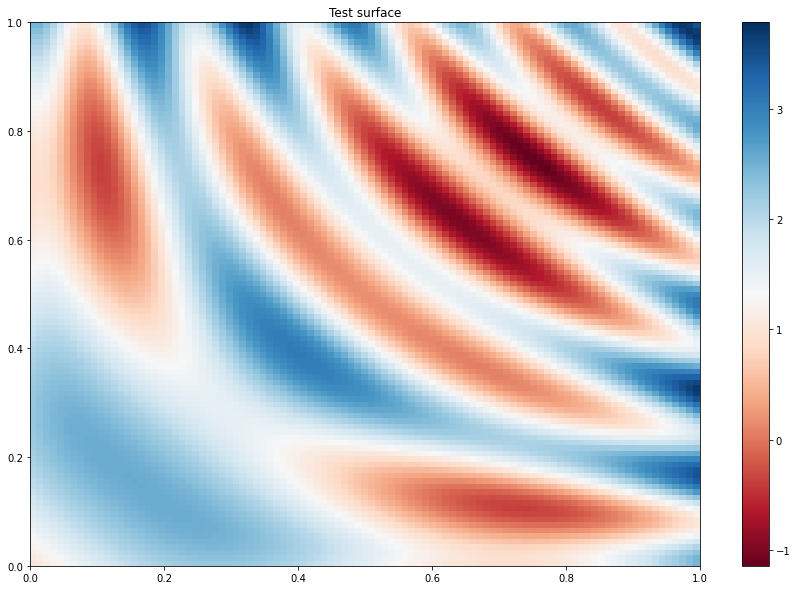

[0.7436635  0.7439418  0.7440777  0.7436186  0.7436397  0.7441837
 0.74375814 0.74324983 0.7441253  0.7438031 ]
3.2284162044525146 0.09830202
Iter 2 - Loss: 3.228
[0.7870372  0.78822327 0.7882637  0.78693444 0.78488266 0.7903739
 0.7871161  0.7842024  0.78708255 0.7866647 ]
3.225165913105011 0.074809454
Iter 3 - Loss: 2.903
[0.83543277 0.8357781  0.8364536  0.83591795 0.83216256 0.84131485
 0.8342729  0.8324307  0.83656096 0.8356633 ]
3.21924355199337 0.0739773
Iter 4 - Loss: 2.633
[0.87618613 0.87841684 0.88174826 0.87566566 0.8745505  0.8859709
 0.876934   0.87415123 0.8837732  0.8769357 ]
3.2111996712753776 0.060335692
Iter 5 - Loss: 2.415
[0.922124   0.9261756  0.93282497 0.9204517  0.9228884  0.93562233
 0.92540294 0.9223726  0.9349816  0.92451465]
3.201389565412691 0.060728565
Iter 6 - Loss: 2.230
[0.97240627 0.9779773  0.98836094 0.97050107 0.9764681  0.9898308
 0.9783017  0.9758712  0.9899597  0.9773379 ]
3.190207733910328 0.059327412
Iter 7 - Loss: 2.083
[1.027611  1.0340855 1

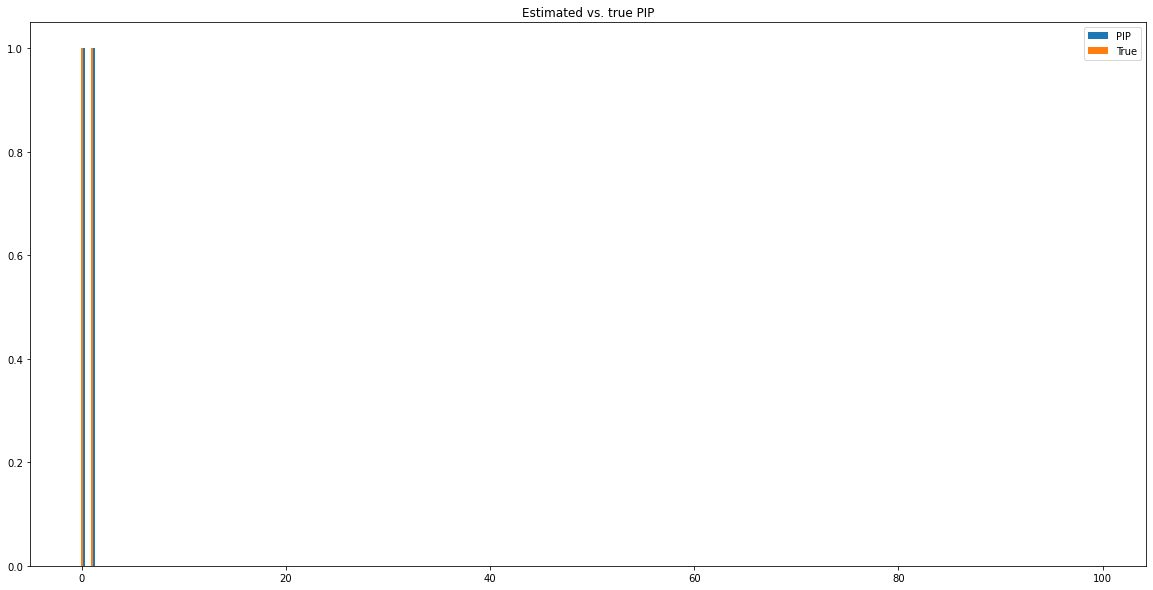

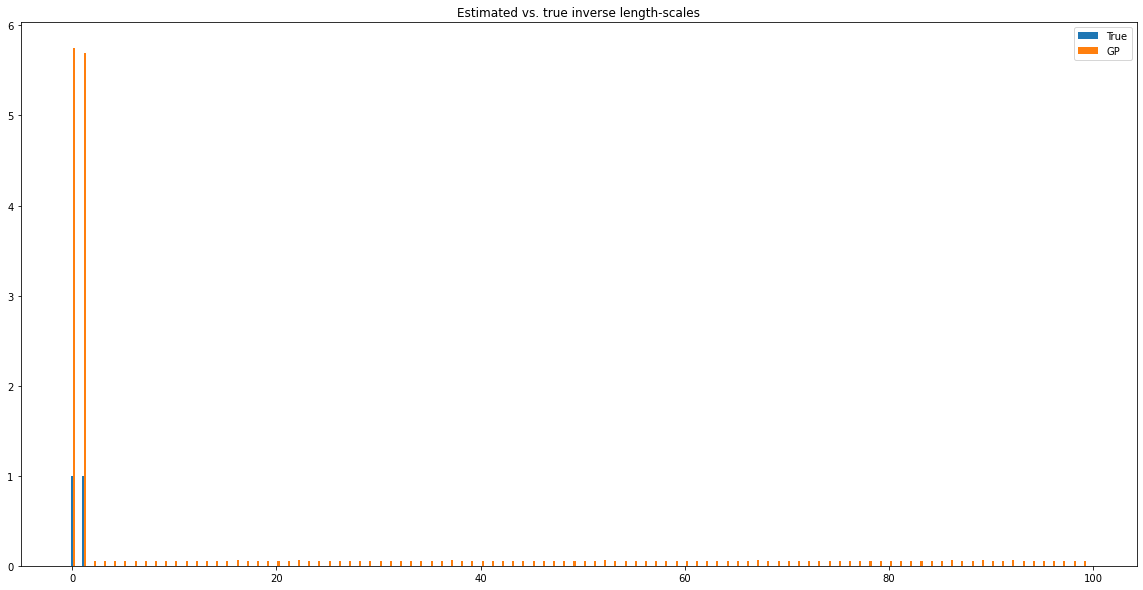

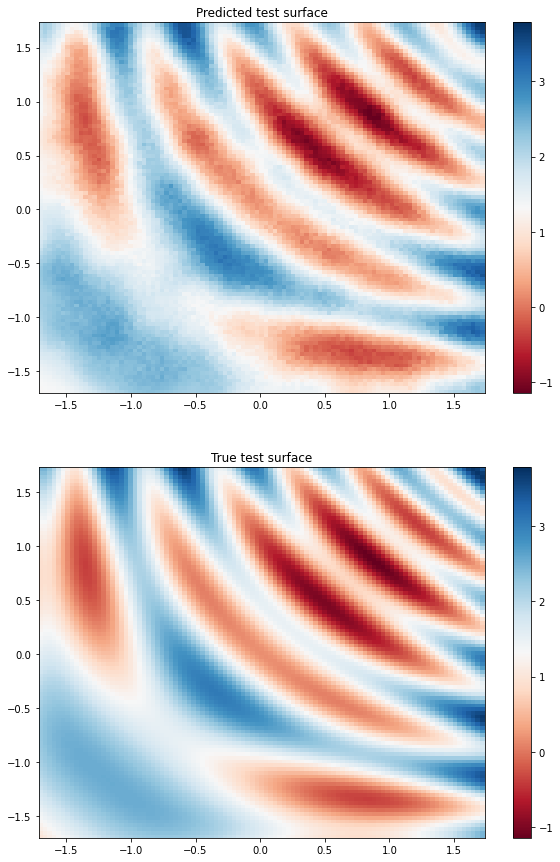

Latent test function MSE :  0.01588246
Observed test data  MSE :  0.32212436


[0.7066547  0.70830065 0.70888406 0.70647943 0.7174433  0.7111974
 0.7061762  0.7073289  0.7152155  0.70642287]
2.944852828979492 0.03607139


[0.7399586  0.74339175 0.7430976  0.7389194  0.74613994 0.74260545
 0.7369364  0.73227006 0.75489956 0.73839915]
2.9420863080024717 0.061403774


[0.7918032  0.7959339  0.79675496 0.7915001  0.7906239  0.79533243
 0.7893341  0.78428835 0.8103674  0.79155844]
2.937835067820549 0.087284744


[0.8587583  0.85963476 0.86502695 0.85885465 0.862173   0.86096364
 0.8562182  0.85130566 0.8774795  0.85860395]
2.9317847639410495 0.095971376


[0.9299773  0.9258515  0.93293136 0.9282993  0.9401672  0.932789
 0.9268971  0.92151374 0.9498926  0.9289805 ]
2.924301811912448 0.08748123


[0.998282   0.9877952  0.9988315  0.9923966  1.0188229  1.0037752
 0.99660945 0.9911581  1.0323001  0.9952823 ]
2.9149272964102058 0.07398707


[1.0631256 1.0482001 1.0559789 1.06259   1.0991019 1.0716621 1.0689609
 1.0648977 1.1224446 1.0686047]
2.9057795588617528 0.06531585


[1.1310241 1.1174276 1.1260172 1.1327114 1.1867296 1.1424428 1.1517388
 1.1430209 1.2334805 1.1450697]
2.89497173394765 0.06057337


[1.2123066 1.1984458 1.2086923 1.2241976 1.2894192 1.23202   1.2535781
 1.2280325 1.3541856 1.2304379]
2.8841948839062996 0.061169285


[1.3083711 1.2991122 1.2885894 1.3299553 1.3867153 1.3397243 1.3701205
 1.3159573 1.4854983 1.3195058]
2.8725160055075287 0.059093583


[1.4178922 1.4200115 1.3839507 1.458689  1.5021061 1.4727267 1.5028434
 1.4115733 1.6171474 1.4303572]
2.8612455399619594 0.05746527


[1.5434229 1.5587615 1.5062122 1.6004568 1.6301172 1.624784  1.6473994
 1.5270557 1.7440974 1.5513932]
2.8501646917133714 0.055728763


[1.6753424 1.7018657 1.6377692 1.752195  1.7505642 1.7865939 1.8014702
 1.6413689 1.8546497 1.6933228]
2.8389382601835824 0.049925577


[1.8286384 1.8454735 1.791565  1.9144247 1.88341   1.9655552 1.9693227
 1.7755085 1.9773309 1.8529668]
2.8269552670566154 0.047359318


[1.9994507 2.0102222 1.9572481 2.0987773 2.0488245 2.1536705 2.1486692
 1.9228762 2.1264198 2.022242 ]
2.814915445230547 0.044832177


[2.1830397 2.1718845 2.1295762 2.2997618 2.2221022 2.3479953 2.331242
 2.0897245 2.2906904 2.2095518]
2.803221132868848 0.040620245


[2.373724  2.3292904 2.3194609 2.5103216 2.4022672 2.55418   2.5280697
 2.2696378 2.4788253 2.4100366]
2.79154847606935 0.03678856


[2.5541384 2.4868734 2.5073786 2.7193253 2.5903826 2.76305   2.728971
 2.458027  2.6688583 2.6067252]
2.779813162083116 0.03208068


[2.6816819 2.5711255 2.6891172 2.916908  2.773844  2.9589405 2.9184806
 2.6364326 2.853094  2.7922454]
2.7677576292343335 0.02642632


[2.6876674 2.5679018 2.8523204 3.0952098 2.9482534 3.1361327 3.0900884
 2.8002803 3.0222857 2.956306 ]
2.7555046955048565 0.020871986


[2.5254204 2.4167485 2.9831882 3.2452514 3.0922756 3.270282  3.234894
 2.943373  3.1725924 3.0969462]
2.7433411473539002 0.016237643


[2.2807972 2.1752245 3.0948224 3.3706138 3.2160132 3.388371  3.354612
 3.0589128 3.2880466 3.20535  ]
2.731412814911352 0.01299325


[2.0167708 1.9161981 3.1925015 3.4807668 3.325598  3.4933543 3.4495459
 3.1635954 3.3912947 3.2954915]
2.7193935473636635 0.011057463


[1.756099  1.6629212 3.2958431 3.5926301 3.4387608 3.5964186 3.5582502
 3.2763343 3.4928188 3.401635 ]
2.707635704505154 0.011051145


[1.5059956 1.418579  3.420575  3.718795  3.561591  3.7165494 3.6752348
 3.4000852 3.6172283 3.5221012]
2.695374605247807 0.011985126


[1.2730523 1.1923158 3.5718253 3.8671792 3.7107282 3.8597798 3.8255856
 3.546115  3.7584047 3.6648154]
2.683312584973909 0.01348854


[1.0656582  0.99342823 3.7493176  4.0324454  3.8741534  4.0248437
 4.001117   3.7069712  3.925427   3.8382866 ]
2.671146204786859 0.014526196


[0.8917487  0.83128685 3.9438868  4.220656   4.057472   4.206034
 4.196213   3.888544   4.1150174  4.0313    ]
2.6592936382792276 0.015331967


[0.76181054 0.7130884  4.141871   4.4107213  4.2492027  4.4000235
 4.394664   4.072116   4.3073964  4.2241364 ]
2.6468585752885407 0.014672875


[0.6799266  0.64843106 4.3235416  4.5876026  4.424126   4.5783753
 4.5749803  4.2403283  4.4842224  4.4017153 ]
2.634406484286632 0.012060583


[0.6389651 0.6157724 4.4834733 4.7520766 4.5836816 4.7400765 4.741301
 4.39121   4.6459026 4.5591087]
2.622191911488214 0.009406106


[0.619562  0.5940959 4.62362   4.894655  4.723973  4.881361  4.8859515
 4.522977  4.7851934 4.697353 ]
2.6097772497871965 0.007396331


[0.5987975  0.57849675 4.7501554  5.0230994  4.8490796  5.006668
 5.0141683  4.638974   4.908847   4.812238  ]
2.597449779823428 0.0062320624


[0.5812339 0.5615226 4.863326  5.1384964 4.963512  5.119165  5.128724
 4.7424135 5.0214314 4.9235945]
2.585216042113161 0.0055648643


[0.5609381 0.5449091 4.968338  5.244241  5.06659   5.2220364 5.229225
 4.8377767 5.126172  5.019336 ]
2.5727702346888557 0.0051099714


[0.5432968  0.52410835 5.067343   5.345082   5.1618676  5.3196716
 5.3272495  4.925691   5.2213454  5.1091504 ]
2.560755048172961 0.004854914


[0.5245891  0.50816596 5.1575055  5.4379716  5.252184   5.4084287
 5.4180355  5.009029   5.309881   5.1904583 ]
2.5484964442625815 0.004451783


[0.50616616 0.4897297  5.2468433  5.5292487  5.341939   5.49888
 5.5069094  5.093373   5.4009523  5.277416  ]
2.5365162770401857 0.0045508533


[0.4876147 0.4762572 5.332782  5.6193137 5.426765  5.585975  5.5916924
 5.1699014 5.485563  5.355516 ]
2.524677905603936 0.0041770767


[0.47150308 0.46147892 5.419725   5.7082715  5.51386    5.6713424
 5.6789823  5.2524195  5.572405   5.439417  ]
2.51286825342282 0.004158274


[0.4544397 0.4419127 5.502847  5.794811  5.5949597 5.751253  5.7602305
 5.3301425 5.654267  5.51357  ]
2.5011165972080955 0.0043746205


[0.43805972 0.42743182 5.5860868  5.8807106  5.676463   5.8354597
 5.847913   5.405589   5.7370815  5.5889573 ]
2.489249362863288 0.0041386355


[0.41824704 0.40943012 5.6679683  5.966675   5.7601395  5.91903
 5.9288597  5.4824066  5.8197823  5.6719713 ]
2.4774722788473107 0.0045929877


[0.39911067 0.3930376  5.749953   6.053242   5.8416634  6.0009937
 6.0140476  5.561      5.9006157  5.7526245 ]
2.4660410213870545 0.004562849


[0.3826042  0.38181058 5.83463    6.14399    5.9249     6.0835977
 6.1022077  5.63885    5.987439   5.8314013 ]
2.4543356187262844 0.0042223544


[0.3621428 0.3680203 5.917356  6.2285676 6.0078154 6.1670947 6.185733
 5.7182198 6.0717583 5.9120555]
2.4428841795769856 0.00477539


[0.3513149 0.3465575 6.0038924 6.3191    6.0922933 6.252285  6.274039
 5.8008657 6.158464  5.995279 ]
2.4314165072624934 0.004849772


[0.3325601  0.33134028 6.089867   6.4071693  6.1737323  6.3366666
 6.3637524  5.886972   6.2426043  6.080205  ]
2.4200251835003694 0.0051831217


[0.3205721  0.31354105 6.1828594  6.500566   6.264154   6.4250546
 6.458696   5.9740357  6.3325224  6.1691184 ]
2.4087532017669133 0.005147999


[0.30432653 0.30374524 6.274096   6.5934243  6.354466   6.515143
 6.5530396  6.0617456  6.4234295  6.2614613 ]
2.3974712961416085 0.0049515585


[0.2845435  0.28720507 6.3665547  6.688189   6.4439764  6.6066513
 6.6490145  6.1523166  6.517157   6.3545547 ]
2.3862618739173445 0.00643391


[0.27025607 0.27361387 6.4613047  6.7857294  6.5374355  6.7014165
 6.7475047  6.247735   6.6145144  6.452803  ]
2.3749147833802278 0.0058526266


[0.2533711  0.26005262 6.556113   6.8842864  6.6339655  6.7989717
 6.847884   6.3448243  6.7128634  6.554239  ]
2.3637307977282798 0.0065973657


[0.24369353 0.24590042 6.656847   6.986823   6.73467    6.9004126
 6.9552913  6.4455414  6.811973   6.6614137 ]
2.352428680524007 0.0060427


[0.23089196 0.23468183 6.760619   7.088918   6.836095   7.003132
 7.0633116  6.547068   6.9150624  6.768625  ]
2.341337871358919 0.0064525963


[0.21930343 0.22271146 6.8631244  7.194655   6.938816   7.1066804
 7.171073   6.652068   7.020498   6.877033  ]
2.330064248132772 0.0067773964


[0.21172827 0.21814224 6.9664664  7.3002796  7.043824   7.2108126
 7.2780275  6.7574415  7.1260414  6.9857802 ]
2.3189281936259927 0.004722004


[0.20334443 0.20885381 7.068541   7.405533   7.1460133  7.313206
 7.3814306  6.8607345  7.226156   7.0932646 ]
2.3076895428313953 0.0060259225


[0.20004664 0.20444226 7.1675673  7.508091   7.246851   7.4129505
 7.4876223  6.96123    7.3272233  7.1998324 ]
2.2966824151166283 0.003808331


[0.19697489 0.20071435 7.2670135  7.6103     7.3457465  7.512682
 7.5941834  7.0633564  7.4285216  7.3028393 ]
2.285224867593956 0.003584336


[0.19202943 0.19428116 7.3608336  7.7086296  7.44232    7.609333
 7.69308    7.1610785  7.526123   7.4015956 ]
2.274275720123842 0.00472734


[0.18822315 0.19369693 7.454157   7.8060465  7.535897   7.702119
 7.7916174  7.25642    7.621087   7.502013  ]
2.2632106071753806 0.0029178301


[0.1848908  0.18944286 7.5476217  7.9024315  7.6284566  7.7954607
 7.886659   7.353096   7.716056   7.5975156 ]
2.2520679579956404 0.0037529706


[0.1823405  0.18635423 7.6356397  7.9960976  7.7180862  7.885715
 7.979459   7.443807   7.80874    7.6903644 ]
2.2407897229309124 0.0031754957


[0.18198061 0.18642884 7.7198715  8.086941   7.8049006  7.970982
 8.068154   7.5320373  7.897005   7.7782116 ]
2.2297822022599068 0.001584149


[0.1813216  0.18571706 7.8047276  8.176281   7.8920903  8.055906
 8.157759   7.6205177  7.9866967  7.865258  ]
2.2186927308957247 0.0018145012


[0.17794093 0.18049471 7.8875904  8.263692   7.9763207  8.138125
 8.245454   7.7066026  8.071437   7.951223  ]
2.2078462607877714 0.003950449


[0.17941186 0.18254516 7.967991   8.353012   8.060813   8.219586
 8.33058    7.789196   8.155639   8.036083  ]
2.1968580577318955 0.002388468


[0.17863417 0.18046248 8.046911   8.437712   8.141922   8.300354
 8.413676   7.8705025  8.23808    8.115276  ]
2.1859131654709216 0.00210791


[0.17602715 0.18145894 8.125394   8.521247   8.2210455  8.379579
 8.493715   7.950726   8.319655   8.195027  ]
2.174872250616902 0.0023237858


[0.17677705 0.18214677 8.201758   8.604983   8.301385   8.455045
 8.575724   8.030879   8.400047   8.271865  ]
2.1641242817518616 0.0015991896


[0.17595942 0.17815313 8.279273   8.688418   8.380627   8.531427
 8.653523   8.109274   8.480146   8.349407  ]
2.153239507707231 0.0026183194


[0.17379528 0.17887492 8.353656   8.769918   8.458632   8.607908
 8.731397   8.187181   8.559092   8.427529  ]
2.1423684285481275 0.002022578


[0.17729902 0.17776635 8.428054   8.852086   8.534661   8.680039
 8.807049   8.26288    8.637424   8.504032  ]
2.1315767239665497 0.0025394028


[0.1738041  0.17658679 8.502299   8.931747   8.608103   8.750143
 8.883354   8.338891   8.712124   8.575166  ]
2.1210025446041576 0.0025191337


[0.17585382 0.17950715 8.575193   9.012069   8.683478   8.824448
 8.959915   8.413257   8.786501   8.650121  ]
2.110383167809239 0.0025884348


[0.17459603 0.17622782 8.646084   9.089978   8.757854   8.896275
 9.032578   8.485779   8.861241   8.720731  ]
2.1001751844053778 0.0024096633


[0.17206466 0.17833059 8.716712   9.167842   8.829514   8.967462
 9.106735   8.559404   8.935656   8.793114  ]
2.0898088693346244 0.0024509567


[0.17566834 0.176224   8.789429   9.246116   8.90328    9.037858
 9.179178   8.633211   9.008308   8.863021  ]
2.0794329948155488 0.002780197


[0.17195769 0.17743048 8.857703   9.321602   8.975411   9.106793
 9.2501335  8.704951   9.080981   8.935646  ]
2.0693391982574383 0.0025017615


[0.17550446 0.17700793 8.925486   9.396839   9.046091   9.178022
 9.32128    8.774037   9.151879   9.005526  ]
2.0593080830197064 0.0021757411


[0.17268704 0.17485133 8.992537   9.471538   9.116856   9.244682
 9.392742   8.842422   9.222316   9.074204  ]
2.049193349729411 0.0024625247


[0.17421909 0.17779714 9.062041   9.547119   9.187538   9.3131485
 9.46315    8.91181    9.294914   9.142799  ]
2.038941944815644 0.0022942764


[0.17393671 0.17659725 9.126339   9.619741   9.255378   9.377862
 9.531735   8.979314   9.364263   9.204355  ]
2.0289241782090555 0.0012610588


[0.17196454 0.17449771 9.190734   9.692122   9.322524   9.44409
 9.600258   9.046273   9.433156   9.269758  ]
2.01934111437687 0.0021182252


[0.17334998 0.1779593  9.256074   9.763535   9.386866   9.509615
 9.669612   9.112952   9.499845   9.332738  ]
2.0094439705041434 0.0023323996


[0.17433168 0.1746904  9.318245   9.833805   9.451118   9.571843
 9.733767   9.177114   9.565314   9.396557  ]
1.999629000289153 0.002096753


[0.17323054 0.17678198 9.384699   9.904877   9.517207   9.634434
 9.800099   9.2430935  9.63202    9.460961  ]
1.9901314104281682 0.0017715213


[0.17209423 0.17482716 9.445045   9.973603   9.581211   9.696224
 9.861884   9.306045   9.694646   9.522641  ]
1.9802961597279698 0.0017081812


[ 0.17330107  0.17672497  9.508135   10.04284     9.645691    9.756806
  9.925475    9.368191    9.756441    9.584321  ]
1.9710466534834734 0.0017043316


[ 0.173738    0.17520952  9.56929    10.111103    9.706603    9.817259
  9.986072    9.429436    9.819927    9.642592  ]
1.9618042348059233 0.0012880391


[ 0.17322807  0.17606907  9.630041   10.179737    9.768143    9.876099
 10.050338    9.491171    9.881805    9.702606  ]
1.952575210516641 0.0010946619


[ 0.17343904  0.17407613  9.6872425  10.246812    9.8302555   9.937393
 10.112368    9.552639    9.942926    9.76127   ]
1.9434164358647064 0.0013461942


[ 0.17306858  0.17708544  9.747565   10.314012    9.891076    9.997174
 10.173607    9.611662   10.003039    9.8209715 ]
1.934258541418779 0.0017202618


[ 0.17396265  0.17257562  9.802767   10.377886    9.948581   10.055373
 10.2340765   9.6707735  10.062345    9.878309  ]
1.9252292535147384 0.0023712951


[ 0.17070986  0.17694554  9.860786   10.442594   10.006402   10.112315
 10.292546    9.730255   10.120597    9.935302  ]
1.9159450015651087 0.0031110707


[ 0.17360453  0.174715    9.917393   10.505617   10.062908   10.164784
 10.349467    9.787897   10.177429    9.991945  ]
1.906750751973652 0.0022645313


[ 0.17369014  0.17443581  9.973403   10.569814   10.120513   10.22191
 10.406487    9.845164   10.236117   10.045565  ]
1.8976048405041779 0.00068402215


[ 0.17243034  0.17572436 10.02983    10.630915   10.175541   10.277373
 10.462756    9.900531   10.29234    10.0990505 ]
1.8889036636868892 0.0013819358


[ 0.17380087  0.17465736 10.084294   10.693624   10.233402   10.331701
 10.520038    9.955646   10.348104   10.151372  ]
1.8803149963127157 0.0013451218


[ 0.17133053  0.1751445  10.138023   10.753804   10.288156   10.383292
 10.57207    10.009572   10.403268   10.204437  ]
1.871884829566828 0.0015058198


[ 0.17227924  0.17449377 10.193113   10.814472   10.343482   10.435566
 10.626386   10.065787   10.458157   10.2571535 ]
1.863165433504474 0.0010475751


[ 0.17170429  0.17623192 10.246087   10.873602   10.396339   10.487658
 10.681457   10.118422   10.509435   10.307312  ]
1.8545465917838704 0.0012498446


[ 0.17490752  0.17322998 10.29786    10.931726   10.449649   10.539264
 10.734944   10.16861    10.56271    10.35717   ]
1.8463314190445899 0.0025362903


[ 0.17055418  0.17473829 10.349611   10.989891   10.502998   10.591491
 10.785996   10.220274   10.614062   10.405862  ]
1.8377155914693248 0.0024252376


[ 0.17358871  0.17576294 10.402796   11.048944   10.553875   10.6407585
 10.838587   10.2718525  10.666494   10.455937  ]
1.8291774910928091 0.0018279982


[ 0.17304058  0.17451616 10.451258   11.105135   10.604982   10.689108
 10.88855    10.321953   10.7167015  10.501338  ]
1.820517189007885 0.0010418647


[ 0.17227891  0.17456138 10.501132   11.162932   10.656396   10.738796
 10.940397   10.37267    10.765613   10.552427  ]
1.8122675711262901 0.00072420813


[ 0.1731742   0.17444368 10.55254    11.218054   10.706781   10.788948
 10.991391   10.42441    10.814831   10.598968  ]
1.8042364254996373 0.0007783174


[ 0.17232762  0.17345929 10.6026     11.274755   10.756472   10.837156
 11.040042   10.473766   10.86731    10.647287  ]
1.7965433623444182 0.0010399249


[ 0.17380804  0.17468114 10.650597   11.32981    10.806974   10.883668
 11.089345   10.52362    10.915476   10.69366   ]
1.788385167895817 0.0013215011


[ 0.1740491   0.17319089 10.698109   11.385384   10.859728   10.929924
 11.138891   10.573402   10.9649515  10.738975  ]
1.7804543924602594 0.0009862132


[ 0.17177169  0.17399447 10.74684    11.439477   10.908807   10.976617
 11.188539   10.622528   11.014913   10.783964  ]
1.772440436556935 0.0014378593


[ 0.17175287  0.17340884 10.792366   11.49373    10.956285   11.026437
 11.234586   10.668402   11.061737   10.829274  ]
1.7647431403838096 0.00060047564


[ 0.17423014  0.17637937 10.840105   11.547362   11.003515   11.071338
 11.284828   10.716778   11.10684    10.872431  ]
1.7574087060827088 0.0021973355


[ 0.17240041  0.1726637  10.888574   11.598434   11.051661   11.117723
 11.33209    10.762456   11.154708   10.915361  ]
1.7498397438292395 0.0022150758


[ 0.17229205  0.17555465 10.93444    11.651718   11.099185   11.162899
 11.381463   10.810646   11.202638   10.962677  ]
1.7420940890390717 0.0013793053


[ 0.17290232  0.1766493  10.980245   11.704143   11.146332   11.208585
 11.425583   10.858399   11.247759   11.005237  ]
1.7346040276223673 0.00093206257


[ 0.1731419   0.17271517 11.026874   11.755312   11.192148   11.2511835
 11.4734745  10.905169   11.293766   11.047717  ]
1.7273168540854167 0.0017380086


[ 0.17169537  0.17467415 11.072059   11.806695   11.236874   11.293171
 11.517328   10.951392   11.338647   11.094798  ]
1.720270923484397 0.0014995262


[ 0.17328815  0.17426    11.11761    11.8583975  11.284555   11.339007
 11.565634   10.995663   11.385356   11.138364  ]
1.7125970347642319 0.0010356384


[ 0.17211401  0.17253993 11.161409   11.909384   11.329623   11.383145
 11.611622   11.039309   11.429629   11.179802  ]
1.705326115457239 0.0013139874


[ 0.1731298   0.17536195 11.206178   11.960863   11.375758   11.427925
 11.656259   11.08547    11.47644    11.220468  ]
1.698164897774003 0.0016237589


[ 0.17173593  0.17468442 11.250122   12.010987   11.421694   11.470375
 11.701273   11.129134   11.521241   11.262172  ]
1.6910185265920543 0.0010311177


[ 0.17427944  0.17456709 11.295529   12.062016   11.466715   11.514733
 11.747755   11.1763735  11.5654335  11.306169  ]
1.683908587088005 0.0012342473


[ 0.17228836  0.17310497 11.338697   12.11131    11.511216   11.554962
 11.791126   11.219782   11.608724   11.347527  ]
1.677024582560776 0.0014771693


[ 0.17304358  0.17463844 11.383219   12.160598   11.556677   11.598282
 11.836479   11.26293    11.653493   11.386467  ]
1.670091323992172 0.0010871944


[ 0.17272142  0.17413588 11.427944   12.210105   11.600222   11.643075
 11.8803625  11.306359   11.695617   11.425544  ]
1.6632998557996286 0.00059588224


[ 0.17344323  0.17448814 11.4704485  12.25933    11.644531   11.683285
 11.925244   11.349015   11.739706   11.468651  ]
1.6562760248174684 0.00067787024


[ 0.17192078  0.17455243 11.512826   12.308429   11.68799    11.724474
 11.968161   11.391363   11.782553   11.510317  ]
1.6495710371580237 0.0008517759


[ 0.172931    0.17404138 11.553678   12.354816   11.728546   11.765131
 12.009731   11.434194   11.823941   11.548904  ]
1.6430053729871958 0.00081335515


[ 0.17286468  0.17406051 11.597594   12.402763   11.770238   11.807007
 12.053517   11.477346   11.864912   11.589466  ]
1.6363605696826626 0.00033890418


[ 0.17286396  0.17588311 11.639737   12.450936   11.815019   11.850057
 12.0941105  11.520518   11.905666   11.628518  ]
1.6299632456382867 0.0008972618


[ 0.17224425  0.17337583 11.682387   12.497797   11.857573   11.8917
 12.137825   11.5632305  11.948938   11.667889  ]
1.6235960173424033 0.0013308191


[ 0.17263983  0.17466159 11.724501   12.545459   11.899817   11.932796
 12.181887   11.602945   11.989043   11.705556  ]
1.6176136403618044 0.00085632486


[ 0.17258462  0.17552982 11.76612    12.591582   11.942821   11.970224
 12.222397   11.641708   12.029864   11.744156  ]
1.6111931022648422 0.0005890589


[ 0.17296349  0.17470367 11.808182   12.637688   11.982767   12.010676
 12.265211   11.684805   12.070703   11.781748  ]
1.6048393700995012 0.0006853855


[ 0.17062338  0.17517996 11.848728   12.686172   12.026585   12.050848
 12.307782   11.726149   12.111422   11.821258  ]
1.5986560511522674 0.001236824


[ 0.17402552  0.17414796 11.891318   12.732782   12.067405   12.089554
 12.349072   11.764924   12.151964   11.857821  ]
1.5924491930657478 0.0017617572


[ 0.172853   0.1751801 11.931152  12.778519  12.109332  12.129131
 12.391901  11.804758  12.190637  11.894293 ]
1.5864332992004666 0.0010057711


[ 0.17333183  0.17438364 11.971274   12.823707   12.150084   12.168775
 12.430565   11.844883   12.230727   11.9348345 ]
1.5804599278554956 0.0006926663


[ 0.17350912  0.17412362 12.011005   12.868581   12.1906185  12.207564
 12.473454   11.886464   12.268727   11.972129  ]
1.5739794136933272 0.00041633725


[ 0.17160515  0.17605248 12.049162   12.913946   12.231245   12.246615
 12.511021   11.926702   12.308645   12.010427  ]
1.5678192369374897 0.0015368706


[ 0.17353177  0.17524068 12.091892   12.959364   12.271397   12.284704
 12.5552025  11.9673     12.346731   12.047609  ]
1.5618173192253642 0.001176213


[ 0.17270723  0.17301497 12.13101    13.004087   12.311885   12.32545
 12.595593   12.005862   12.384795   12.083657  ]
1.5560028905876302 0.001270984


[ 0.17283131  0.1764759  12.172446   13.049607   12.352761   12.361927
 12.636218   12.0450535  12.423945   12.121381  ]
1.5503554008062426 0.0014342758


[ 0.17350093  0.17393929 12.2098     13.094151   12.390024   12.399429
 12.675808   12.083813   12.463598   12.15626   ]
1.5448907197554098 0.0013020864


[ 0.17312211  0.17407322 12.249756   13.140084   12.431529   12.438695
 12.713382   12.122926   12.500489   12.1935    ]
1.5390052276083623 0.0004265757


[ 0.17337066  0.17515667 12.28944    13.184615   12.470104   12.475643
 12.753659   12.160874   12.539163   12.231717  ]
1.5331492946998782 0.0006903037


[ 0.17280333  0.1754223  12.3273535  13.225832   12.508981   12.511859
 12.791376   12.198423   12.578268   12.268074  ]
1.5275021486671707 0.00051780196


[ 0.17339675  0.17410997 12.366113   13.27179    12.548962   12.549464
 12.831367   12.238564   12.614482   12.303667  ]
1.5220432444671812 0.0008792222


[ 0.17402701  0.17512079 12.408023   13.316199   12.589227   12.58696
 12.872223   12.277672   12.653428   12.339776  ]
1.5166909832375668 0.0007872994


[ 0.17205167  0.17207554 12.44291    13.359123   12.626302   12.624526
 12.910868   12.315072   12.693774   12.373812  ]
1.5113963525723664 0.0019092527


[ 0.17397685  0.17714563 12.482954   13.403148   12.664443   12.664469
 12.949606   12.353205   12.729538   12.406962  ]
1.5060654937047697 0.00254831


[ 0.17157651  0.17512926 12.521947   13.448348   12.703127   12.70071
 12.989262   12.391469   12.764981   12.446085  ]
1.5009466479451206 0.0016922913


[ 0.1743382   0.17453468 12.5620575  13.491619   12.740925   12.736428
 13.025487   12.428137   12.8032675  12.481807  ]
1.4954410717416247 0.0013497421


[ 0.17236662  0.17561665 12.600021   13.534445   12.77948    12.77183
 13.0615425  12.466694   12.841822   12.51653   ]
1.4903160552455144 0.0012408821


[ 0.17245956  0.17456692 12.637976   13.577012   12.819152   12.80989
 13.101257   12.505805   12.880323   12.551412  ]
1.485091201272649 0.00060583564


[ 0.17483498  0.17518598 12.677259   13.61999    12.857873   12.84657
 13.139428   12.542276   12.917318   12.584645  ]
1.479983455229771 0.0012147323


[ 0.17322466  0.17457639 12.7157345  13.660794   12.894572   12.884106
 13.179636   12.578485   12.954516   12.620546  ]
1.475020807610037 0.0009568065


[ 0.17314057  0.17622781 12.754731   13.7051735  12.93173    12.920512
 13.218782   12.61861    12.990531   12.655361  ]
1.4699271575707409 0.0007929188


[ 0.1732846   0.17451221 12.791908   13.746666   12.96653    12.957251
 13.254851   12.656247   13.026929   12.690682  ]
1.464907794747475 0.00082450325


[ 0.17217872  0.17493378 12.829088   13.788882   13.005876   12.995143
 13.294406   12.6955595  13.063527   12.725892  ]
1.4599684487364548 0.0007317736


[ 0.17450936  0.17549832 12.865555   13.829342   13.042257   13.029596
 13.333606   12.731557   13.099611   12.758841  ]
1.4550004874146023 0.0011762369


[ 0.17254628  0.17577305 12.903445   13.873316   13.080861   13.066473
 13.370959   12.76866    13.1327     12.795051  ]
1.4500725670388617 0.0009564055


[ 0.17247398  0.17554736 12.942337   13.916285   13.117754   13.102745
 13.408532   12.808325   13.171584   12.827757  ]
1.4450128135774498 0.00031693102


[ 0.17474127  0.17463201 12.975953   13.958269   13.154311   13.13707
 13.445368   12.845184   13.2077465  12.862285  ]
1.4400003865477469 0.001260617


[ 0.17422524  0.17369372 13.015277   13.999992   13.191301   13.169419
 13.483376   12.881435   13.2421465  12.898255  ]
1.4350293284620699 0.00069043913


[ 0.1733389   0.17662425 13.053537   14.042651   13.227381   13.206981
 13.521554   12.917581   13.278127   12.932514  ]
1.4308462929632464 0.0014589968


[ 0.17470784  0.17355347 13.090979   14.083211   13.263334   13.243129
 13.55518    12.954832   13.314415   12.965025  ]
1.4262791738894718 0.0016606333


[ 0.17285512  0.17644638 13.128603   14.12501    13.3006115  13.279608
 13.59458    12.991765   13.349228   13.001127  ]
1.4219285719918475 0.0017674216


[ 0.17565584  0.17384769 13.165454   14.165357   13.336833   13.313442
 13.633982   13.029081   13.386823   13.033206  ]
1.4173940593594305 0.001970954


[ 0.17260233  0.17512794 13.199931   14.206116   13.375127   13.346152
 13.672715   13.064887   13.421276   13.06986   ]
1.4130581347990088 0.0016311448


[ 0.17265688  0.17540321 13.237118   14.24653    13.412904   13.3815155
 13.708033   13.100423   13.454053   13.103682  ]
1.4085263718723824 0.00030770974


[ 0.17321    0.1761605 13.273118  14.287212  13.448249  13.418011
 13.746074  13.134648  13.488741  13.1370945]
1.4039951611026102 0.00062925095


[ 0.17359433  0.17599869 13.308224   14.32844    13.484059   13.451906
 13.7819195  13.170616   13.524632   13.171466  ]
1.3996720349768137 0.00037866028


[ 0.17420913  0.17598417 13.345025   14.368071   13.5186615  13.486732
 13.819835   13.208382   13.56077    13.205709  ]
1.3954544776300133 0.000404469


[ 0.17276385  0.17573519 13.381535   14.408949   13.5550995  13.523011
 13.857339   13.243991   13.595232   13.23857   ]
1.391269188968673 0.00075771846


[ 0.173359    0.17581162 13.417157   14.449062   13.591832   13.5566635
 13.893619   13.279371   13.628249   13.269551  ]
1.3872284150420142 0.00041623972


[ 0.17435786  0.17557229 13.45164    14.48947    13.626466   13.592985
 13.929097   13.315407   13.660898   13.303827  ]
1.3828623034293976 0.0005973361


[ 0.17270163  0.17607604 13.487647   14.530534   13.660696   13.623905
 13.964184   13.350655   13.698302   13.336662  ]
1.378317963913895 0.0009062383


[ 0.17320532  0.17549628 13.52368    14.572298   13.696132   13.658799
 14.002069   13.385543   13.733327   13.371701  ]
1.3744395366484514 0.00054592843


[ 0.17514004  0.17410293 13.560072   14.611158   13.730383   13.695267
 14.037413   13.420117   13.768544   13.405711  ]
1.3701146719120787 0.0012806532


[ 0.17391157  0.17717357 13.5972185  14.652518   13.768225   13.72851
 14.075742   13.458624   13.803904   13.439863  ]
1.3660170160224256 0.0015874994


[ 0.17381892  0.1751947  13.632995   14.693391   13.801613   13.761966
 14.112331   13.494195   13.83885    13.473367  ]
1.3615942938392673 0.00085125846


[ 0.17369099  0.17562145 13.6682625  14.733836   13.835728   13.796439
 14.146589   13.528008   13.870223   13.501915  ]
1.3576242063276631 0.0003630953


[ 0.17466928  0.17591752 13.702967   14.772722   13.868438   13.831067
 14.182288   13.562612   13.907937   13.53574   ]
1.353531618167394 0.0006026959


[ 0.17345881  0.17541102 13.737088   14.813472   13.902242   13.865518
 14.218752   13.599249   13.938615   13.567108  ]
1.3492337440023214 0.0007417848


[ 0.17305776  0.17563085 13.773682   14.854865   13.935452   13.900374
 14.25097    13.631212   13.971491   13.602253  ]
1.345577794792622 0.00038465485


[ 0.17365928  0.17560303 13.808088   14.892893   13.971904   13.93381
 14.287769   13.667771   14.00498    13.635939  ]
1.341890455183929 0.00038619348


[ 0.17377028  0.17534664 13.844528   14.932183   14.005727   13.96789
 14.324782   13.701244   14.03894    13.665153  ]
1.3378142008071843 0.00029676856


[ 0.17329417  0.17562193 13.87746    14.971421   14.037793   14.001648
 14.360712   13.733935   14.069565   13.698832  ]
1.3343276409304983 0.0004199443


[ 0.17473982  0.17557353 13.91301    15.012729   14.073409   14.03506
 14.396939   13.769213   14.105167   13.734681  ]
1.330709133517432 0.00066953467


[ 0.17370553  0.17593636 13.948954   15.051858   14.107398   14.066699
 14.433315   13.803735   14.138851   13.765105  ]
1.3270228237231283 0.0006305213


[ 0.1726272   0.17592554 13.984501   15.089867   14.144487   14.100599
 14.470468   13.8403635  14.169347   13.795741  ]
1.323591659368725 0.000536707


[ 0.17433392  0.17627785 14.020583   15.128426   14.17726    14.132382
 14.504441   13.874197   14.203539   13.8287945 ]
1.31955898483856 0.00085019984


[ 0.17340831  0.17453207 14.053586   15.167971   14.210673   14.165324
 14.5386095  13.909355   14.23608    13.858899  ]
1.3157139433767484 0.0010398849


[ 0.17502698  0.17580143 14.089337   15.206967   14.245143   14.197461
 14.576313   13.944996   14.2711     13.889209  ]
1.312248079301181 0.0011172781


[ 0.17436092  0.17402025 14.122549   15.24589    14.278868   14.229734
 14.610921   13.977848   14.304047   13.920616  ]
1.3087854467213649 0.00096330367


[ 0.17456509  0.17677687 14.157628   15.285009   14.315059   14.263496
 14.647145   14.011156   14.336623   13.953156  ]
1.3050373212056052 0.0011319608


[ 0.17397223  0.1761776  14.191984   15.323718   14.347302   14.294683
 14.681598   14.046025   14.369006   13.982219  ]
1.3010785612862432 0.00055067183


[ 0.17354941  0.1758317  14.227093   15.363964   14.382792   14.327182
 14.716127   14.080265   14.401234   14.016843  ]
1.2976884517140301 0.00041852266


[ 0.1744856   0.17620419 14.261487   15.402629   14.415453   14.361288
 14.750918   14.113478   14.435495   14.045759  ]
1.294016295108839 0.0005933166


[ 0.17518447  0.1768415  14.294782   15.441504   14.4513235  14.395377
 14.786614   14.146387   14.469737   14.075392  ]
1.2907026929649787 0.00059579255


[ 0.17361656  0.17627433 14.328516   15.480928   14.485495   14.428018
 14.821139   14.179954   14.503233   14.1075535 ]
1.2871798463427173 0.00085706584


[ 0.1746588   0.17550926 14.3642235  15.521093   14.516447   14.462448
 14.854543   14.21356    14.537048   14.141295  ]
1.283871460545611 0.00075408496


[ 0.17545924  0.1779008  14.397572   15.559456   14.550548   14.492583
 14.890922   14.247778   14.569034   14.1716175 ]
1.2804984230822982 0.0011866246


[ 0.17404346  0.17574836 14.432977   15.597928   14.58449    14.523618
 14.92464    14.281576   14.6017065  14.2032385 ]
1.2773329606887096 0.0013096998


[ 0.17553185  0.17664061 14.465416   15.638304   14.617782   14.557409
 14.958542   14.3154335  14.634145   14.233449  ]
1.2741566905701192 0.0009334074


[ 0.17282298  0.17711154 14.49904    15.675988   14.64982    14.590422
 14.993759   14.349539   14.669949   14.267596  ]
1.2708072737088592 0.0011979279


[ 0.17478709  0.17519872 14.533368   15.715636   14.685165   14.623657
 15.03186    14.385906   14.704584   14.301717  ]
1.2677539124566797 0.0014304598


[ 0.17448759  0.17517218 14.567879   15.753516   14.717985   14.6553545
 15.066287   14.416868   14.73658    14.329254  ]
1.2645815421276985 0.00026135705


[ 0.17519169  0.17642157 14.6039295  15.791241   14.750799   14.688996
 15.10331    14.450263   14.769543   14.360123  ]
1.2615243241232992 0.0007897304


[ 0.17556165  0.17654376 14.637623   15.831136   14.783912   14.723126
 15.13741    14.48453    14.80043    14.393045  ]
1.2584642025422987 0.00031327992


[ 0.17366377  0.17555033 14.6705     15.868734   14.816315   14.755431
 15.170261   14.517944   14.834221   14.421523  ]
1.2555813787446437 0.0010909521


[ 0.17526835  0.17646983 14.704522   15.909282   14.851025   14.787918
 15.204097   14.552201   14.865142   14.454569  ]
1.2526322219853956 0.0009785523


[ 0.17497125  0.17673704 14.7376375  15.949423   14.8841505  14.819118
 15.236191   14.583502   14.893599   14.486216  ]
1.2493515451694037 0.00033007367


[ 0.1741084   0.17615604 14.772128   15.986736   14.9179535  14.852456
 15.270596   14.615919   14.924634   14.519181  ]
1.2466422686522265 0.0006198128


[ 0.17557514  0.17630698 14.80728    16.025345   14.952708   14.882612
 15.308299   14.651617   14.957839   14.552892  ]
1.2439326935857145 0.0006830702


[ 0.17572665  0.1768675  14.83887    16.063486   14.986675   14.913127
 15.342351   14.684119   14.989433   14.5836735 ]
1.2407831850559623 0.0003707847


[ 0.17438884  0.17619723 14.873235   16.102703   15.0194435  14.945594
 15.37602    14.717744   15.020475   14.618346  ]
1.2377952927233775 0.0008022001


[ 0.17393175  0.17660703 14.905547   16.140238   15.051554   14.975933
 15.409322   14.74801    15.055194   14.646594  ]
1.2352291661444483 0.00042605493


[ 0.175853    0.17761241 14.939048   16.178402   15.084729   15.008209
 15.4449     14.783782   15.084818   14.678173  ]
1.232152841961756 0.0010925453


[ 0.17409375  0.17495611 14.971799   16.215252   15.117513   15.040476
 15.477612   14.817172   15.117768   14.709713  ]
1.229533614567529 0.001573742


[ 0.17474344  0.17767726 15.004749   16.253273   15.152501   15.073138
 15.51318    14.849311   15.149697   14.743314  ]
1.226830523642992 0.001234556


[ 0.17563584  0.17625481 15.0389185  16.292007   15.182387   15.102921
 15.545592   14.882971   15.178269   14.774721  ]
1.224128532030944 0.0008854824


[ 0.17385323  0.17684986 15.07379    16.330244   15.216817   15.137246
 15.579189   14.91413    15.212765   14.802933  ]
1.2212939790314201 0.0009186092


[ 0.17429373  0.17672414 15.105124   16.367928   15.250943   15.168379
 15.610516   14.946981   15.242035   14.833209  ]
1.2185087905438252 0.00032512125


[ 0.17559639  0.17784357 15.137266   16.405901   15.283066   15.197672
 15.646191   14.982184   15.273433   14.861686  ]
1.2159002354791157 0.00092043943


[ 0.1743771   0.17690375 15.171482   16.444538   15.315366   15.231872
 15.68013    15.014782   15.3062315  14.890253  ]
1.2132640258212775 0.00083579356


[ 0.17522235  0.17721234 15.20388    16.480154   15.347384   15.26124
 15.715154   15.048761   15.335963   14.91983   ]
1.2106597369891894 0.00051262346


[ 0.17342432  0.1768502  15.237173   16.518244   15.381478   15.293035
 15.748575   15.078146   15.366563   14.9526    ]
1.2080862439197964 0.0008434273


[ 0.17556526  0.1767377  15.270431   16.555523   15.413369   15.323435
 15.782127   15.110388   15.397021   14.979876  ]
1.2055139084018707 0.0008763283


[ 0.17467481  0.17768909 15.302983   16.59466    15.4467745  15.356606
 15.814622   15.14392    15.429651   15.0133915 ]
1.2029247677290307 0.00073261565


[ 0.17517878  0.17598493 15.333424   16.631212   15.480034   15.388514
 15.851523   15.176306   15.459663   15.039617  ]
1.2006369664275873 0.0008429055


[ 0.17453805  0.17797984 15.369493   16.668604   15.512414   15.418064
 15.884485   15.2111     15.493385   15.069409  ]
1.1986878935162413 0.0009862273


[ 0.1761733   0.17794159 15.403253   16.705935   15.544448   15.449701
 15.916165   15.240898   15.5231495  15.102474  ]
1.1959988486198132 0.00067446055


[ 0.1737845   0.17761506 15.434503   16.743254   15.574247   15.4804125
 15.951418   15.274851   15.55232    15.131038  ]
1.1937310820135743 0.0010168663


[ 0.17634204  0.17684989 15.468583   16.78095    15.605997   15.510649
 15.985437   15.306797   15.582898   15.161648  ]
1.190888952420169 0.0012100373


[ 0.17607704  0.17753318 15.499627   16.818533   15.639618   15.543886
 16.02179    15.339378   15.61328    15.192236  ]
1.188326891952707 0.00043470843


[ 0.17475063  0.17642848 15.533434   16.855711   15.67217    15.573995
 16.05388    15.370912   15.644293   15.223362  ]
1.1862649008900066 0.00091500476


[ 0.17408507  0.17651802 15.564916   16.892885   15.706944   15.609056
 16.086657   15.402986   15.674678   15.255279  ]
1.1836614764151414 0.00037950327


[ 0.17570174  0.1770691  15.595211   16.927801   15.737393   15.638813
 16.119164   15.435371   15.706724   15.283261  ]
1.1811444257550703 0.00083257654


[ 0.17543292  0.17703034 15.628333   16.96594    15.768394   15.671122
 16.153603   15.467355   15.737879   15.313611  ]
1.178626063257926 0.00023184982


[ 0.17569579  0.17774442 15.660628   17.003021   15.801582   15.703756
 16.187384   15.498437   15.769144   15.345078  ]
1.17618303692596 0.0004413003


[ 0.17422132  0.17738135 15.692165   17.040184   15.835412   15.738614
 16.218792   15.5321665  15.800163   15.375183  ]
1.1739627174962983 0.00072624837


[ 0.17635143  0.17678304 15.725153   17.078667   15.868508   15.766029
 16.254147   15.56558    15.832076   15.405013  ]
1.1711814115350576 0.001011725


[ 0.17474133  0.17733575 15.756632   17.115547   15.901662   15.797232
 16.286102   15.59666    15.8656845  15.437125  ]
1.1690413213576953 0.0008269698


[ 0.17463577  0.17727922 15.789605   17.152689   15.936467   15.828484
 16.319532   15.629431   15.894013   15.466696  ]
1.1668224778014442 0.00017989952


[ 0.1758715  0.1771588 15.823919  17.19033   15.967957  15.859198
 16.352491  15.664337  15.924053  15.497278 ]
1.164591883199974 0.0005684906


[ 0.17491013  0.17772025 15.856571   17.228508   15.998855   15.887454
 16.385273   15.6977415  15.955063   15.526204  ]
1.1623674273806697 0.00061507034


[ 0.17484887  0.17763823 15.888197   17.26441    16.031994   15.919196
 16.418339   15.732607   15.983747   15.55771   ]
1.1602304396941967 0.00017103524


[ 0.17443596  0.1778959  15.921152   17.302156   16.064154   15.950257
 16.453672   15.764243   16.016611   15.5871    ]
1.1576046985125104 0.0003417235


[ 0.17634144  0.17671598 15.9532175  17.339668   16.097567   15.98216
 16.487984   15.792823   16.04459    15.614077  ]
1.155866209796886 0.0011192266


[ 0.17432491  0.17820005 15.984303   17.376492   16.125837   16.010502
 16.520298   15.825449   16.075823   15.644509  ]
1.1535872285470388 0.0012476726


[ 0.17461523  0.17767695 16.015461   17.41273    16.159256   16.041662
 16.556074   15.859441   16.10539    15.674179  ]
1.1516972486432364 0.00038094528


[ 0.1743978   0.17771342 16.047384   17.449652   16.1937     16.067307
 16.587507   15.889514   16.13729    15.70379   ]
1.1495616735233278 0.00020507876


[ 0.17559327  0.17881064 16.07948    17.485804   16.225931   16.097857
 16.619474   15.92156    16.168625   15.735964  ]
1.147617448389657 0.0008572434


[ 0.17492333  0.17737865 16.11041    17.524076   16.257158   16.131498
 16.65252    15.953461   16.19735    15.767604  ]
1.1460425364275044 0.00079146615


[ 0.17706452  0.1786843  16.143997   17.559929   16.28821    16.161232
 16.685547   15.984133   16.224794   15.79513   ]
1.1436892471935622 0.001220576


[ 0.17444156  0.1766542  16.17761    17.596552   16.321      16.190704
 16.714645   16.0176     16.253323   15.827662  ]
1.141917386154732 0.0016105536


[ 0.17690498  0.17895694 16.21282    17.63534    16.35217    16.219254
 16.750463   16.048449   16.284847   15.857626  ]
1.1397130897794137 0.0016474607


[ 0.17501001  0.17721167 16.241936   17.673151   16.384174   16.24891
 16.783463   16.080696   16.311941   15.884335  ]
1.137616777324918 0.0012767332


[ 0.17606135  0.17781994 16.27254    17.709772   16.415178   16.282194
 16.81749    16.111073   16.341387   15.915131  ]
1.1357171722900874 0.0006527403


[ 0.17525907  0.17776155 16.304192   17.745377   16.447693   16.311
 16.849796   16.141392   16.372375   15.944857  ]
1.13377472527479 0.00039743976


[ 0.17605929  0.17691188 16.336441   17.78133    16.4797     16.342447
 16.8796     16.174618   16.40226    15.972535  ]
1.1316946468748483 0.00064494944


[ 0.17545766  0.17788959 16.369287   17.816767   16.510256   16.37123
 16.913044   16.20627    16.432947   16.003836  ]
1.1292984057245508 0.00061851623


[ 0.17518595  0.17888188 16.402952   17.855368   16.543222   16.404165
 16.943464   16.239014   16.464354   16.038042  ]
1.1275354485799944 0.0005167942


[ 0.17470828  0.17739962 16.433987   17.890976   16.576733   16.433605
 16.978537   16.270926   16.491964   16.06712   ]
1.1254017764805928 0.0007370964


[ 0.17543772  0.17765184 16.465763   17.927372   16.61037    16.465923
 17.012602   16.301857   16.522348   16.097723  ]
1.1236600222522402 0.00043257792


[ 0.17620458  0.17705889 16.496754   17.965944   16.63776    16.495752
 17.042757   16.332506   16.551983   16.13037   ]
1.121891601970895 0.0005497494


[ 0.1760266   0.17909066 16.528372   18.00123    16.670282   16.525513
 17.076157   16.368856   16.584019   16.15817   ]
1.120135534852935 0.0008116617


[ 0.17562366  0.17740034 16.558708   18.037828   16.703823   16.557302
 17.109491   16.402245   16.60984    16.184269  ]
1.1181836837129704 0.0007753348


[ 0.17538193  0.17743048 16.592243   18.073622   16.736404   16.588882
 17.143988   16.432447   16.639118   16.215343  ]
1.116198152150804 0.00020048696


[ 0.17489874  0.17824668 16.627787   18.111326   16.767412   16.6173
 17.171911   16.46308    16.67284    16.246883  ]
1.1145428527868124 0.0005305187


[ 0.17600586  0.17771493 16.656677   18.148449   16.79897    16.645893
 17.206799   16.493433   16.701443   16.274878  ]
1.1129019773385496 0.00063677964


[ 0.17639251  0.1793019  16.688929   18.184454   16.8306     16.677752
 17.239754   16.524847   16.730978   16.303867  ]
1.1110180027502532 0.0007352553


[ 0.17573135  0.17852485 16.719389   18.22007    16.864237   16.70706
 17.268698   16.556498   16.75894    16.331745  ]
1.1095307840054807 0.0005658732


[ 0.17539118  0.17865404 16.751629   18.257301   16.895157   16.73505
 17.305054   16.586208   16.787294   16.361803  ]
1.1079079816156745 0.000259177


[ 0.17637195  0.17695653 16.787308   18.29442    16.923353   16.767208
 17.33921    16.61894    16.816969   16.390383  ]
1.1063657784779843 0.00096463755


[ 0.17575724  0.17804345 16.817507   18.331106   16.954807   16.795544
 17.372267   16.650076   16.84658    16.422932  ]
1.105046199806211 0.0006518193


[ 0.17613551  0.17683442 16.850538   18.367186   16.98893    16.825651
 17.403906   16.680973   16.876371   16.450434  ]
1.1030986783675363 0.00061556074


[ 0.17603926  0.17955408 16.881655   18.404633   17.021015   16.857586
 17.438286   16.712132   16.90616    16.479258  ]
1.1016003476574312 0.0009958098


[ 0.17449792  0.17869703 16.914606   18.438007   17.051052   16.88663
 17.470186   16.745073   16.93581    16.510923  ]
1.1000278752172339 0.0008758575


[ 0.17661542  0.17852458 16.94523    18.474564   17.081757   16.915785
 17.501976   16.77494    16.960724   16.539083  ]
1.0981023046884044 0.0008453644


[ 0.17546645  0.17733283 16.977777   18.511148   17.111212   16.944427
 17.533289   16.80537    16.990786   16.569916  ]
1.0968160253939998 0.00085427717


[ 0.17600933  0.17825194 17.009706   18.54898    17.144598   16.976425
 17.565168   16.83599    17.017715   16.597403  ]
1.0952405158635172 0.00057272584


[ 0.17521052  0.1776421  17.04046    18.585243   17.178518   17.005457
 17.596613   16.86461    17.046328   16.62605   ]
1.0936166250424217 0.0005572358


[ 0.17675667  0.17921005 17.07156    18.620665   17.209919   17.032333
 17.629045   16.89316    17.074856   16.656734  ]
1.0923251882870462 0.0010947679


[ 0.17528175  0.17717122 17.105873   18.658705   17.241327   17.064188
 17.66196    16.928114   17.10079    16.685894  ]
1.090856145612664 0.0012251169


[ 0.17637219  0.18065402 17.136211   18.693815   17.272655   17.09196
 17.692932   16.961569   17.13075    16.713087  ]
1.0895081018252615 0.0015406809


[ 0.17505212  0.177495   17.168402   18.729074   17.303923   17.123789
 17.726446   16.99153    17.154886   16.741163  ]
1.0881084925229358 0.0015160857


[ 0.17679396  0.17902231 17.199286   18.764297   17.336386   17.15349
 17.764051   17.022976   17.186245   16.771223  ]
1.0864367645017363 0.0011484303


[ 0.1757627   0.17919853 17.23009    18.801077   17.368801   17.182608
 17.795029   17.052937   17.217222   16.802525  ]
1.084829502445632 0.0004903324


[ 0.17607118  0.17878062 17.26362    18.838251   17.395987   17.21003
 17.825294   17.084929   17.245195   16.828661  ]
1.0833641121891657 0.00033090715


[ 0.1760812   0.17855977 17.295408   18.873419   17.42827    17.242786
 17.859734   17.115656   17.276186   16.8598    ]
1.0819944673584347 0.00017375377


[ 0.17615676  0.17909887 17.324598   18.90879    17.45894    17.273254
 17.895418   17.14674    17.304914   16.88935   ]
1.0805219561326882 0.00029610455


[ 0.17543794  0.17781252 17.35585    18.944311   17.491352   17.302996
 17.925457   17.176811   17.331825   16.916422  ]
1.0789463030262487 0.00073586643


[ 0.17671734  0.1795398  17.386694   18.98043    17.524971   17.332657
 17.95774    17.208204   17.360802   16.943115  ]
1.0774814812237083 0.0010540723


[ 0.17489682  0.17828432 17.417694   19.01686    17.556774   17.363066
 17.98846    17.241127   17.38865    16.975445  ]
1.0759873796120405 0.0010842623
Runtime is  919.4890940189362
Test MSE: 0.32491534948349
Latent test function MSE :  [0.0190853 0.        0.        0.        0.       ]
Test time is :  [0.68217564 0.         0.         0.         0.        ]


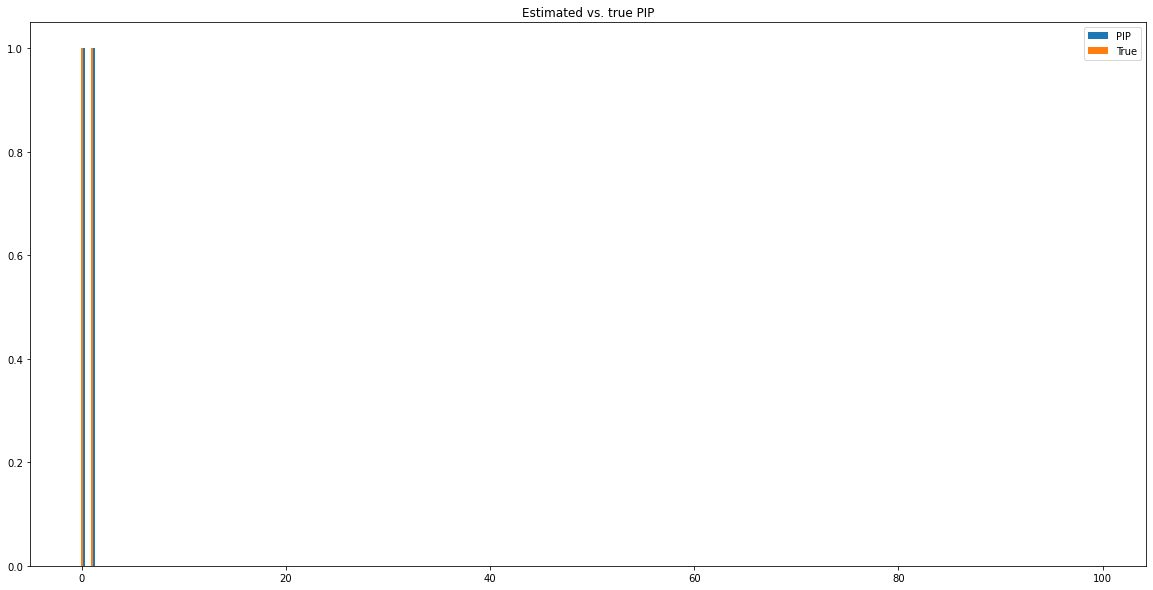

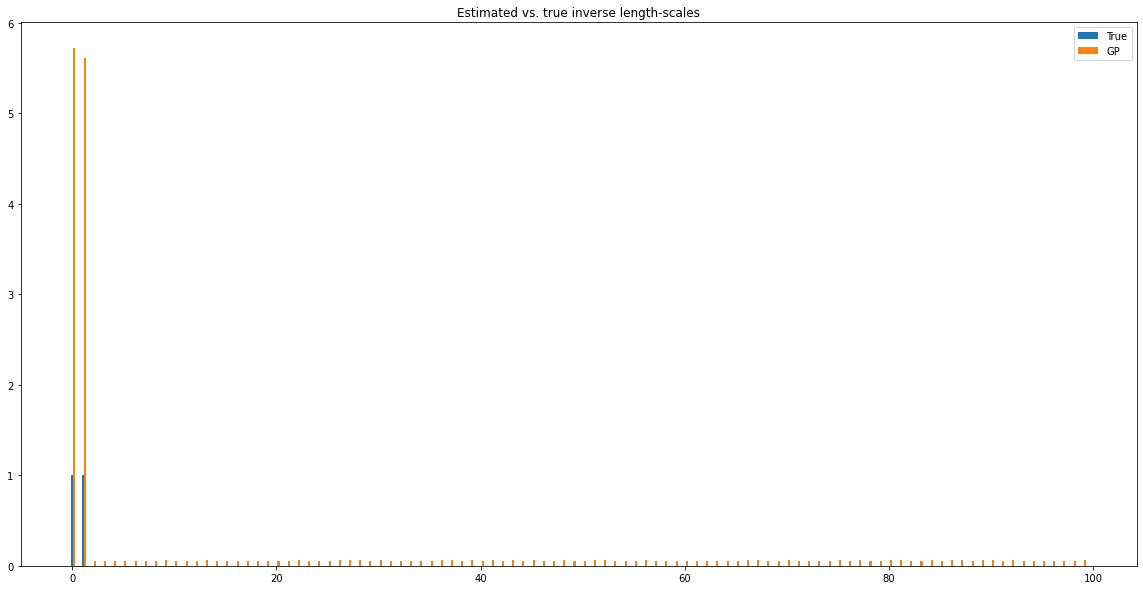

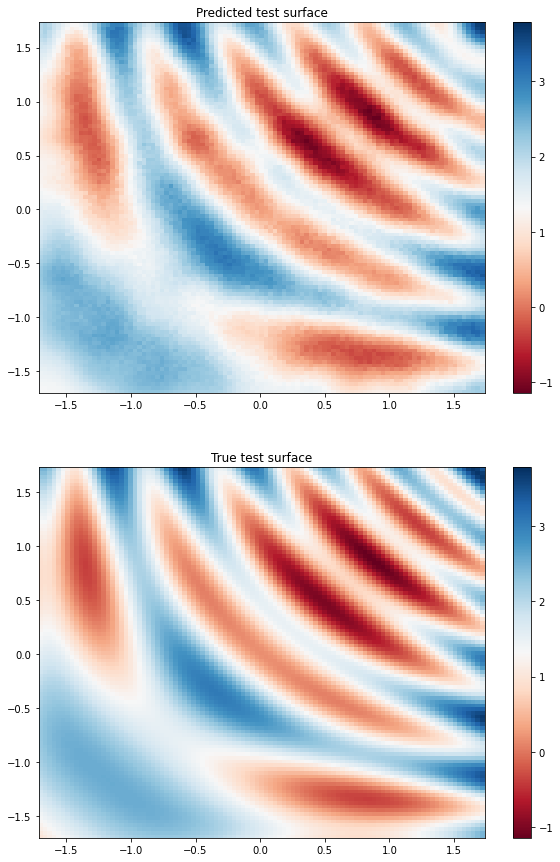

Latent test function MSE :  0.019085297
Observed test data  MSE :  0.32491535


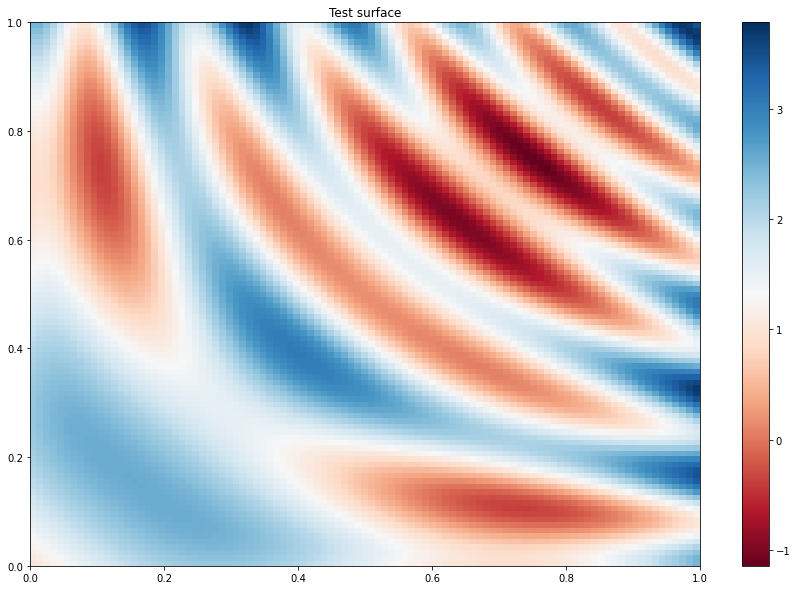

[0.74437034 0.7441991  0.74411917 0.74433887 0.7428169  0.74383885
 0.74435353 0.74415183 0.7441879  0.7441419 ]
3.175952434539795 0.09841419
Iter 2 - Loss: 3.176
[0.79080194 0.79096115 0.7872714  0.7913256  0.7839133  0.78746736
 0.79102796 0.78712106 0.7886173  0.79075897]
3.172762293815613 0.07510142
Iter 3 - Loss: 2.857
[0.83898747 0.8413108  0.8341025  0.8415265  0.8322626  0.8343232
 0.8404937  0.83467585 0.8364222  0.840045  ]
3.1669520936489106 0.07224148
Iter 4 - Loss: 2.592
[0.8919556  0.88611954 0.8794459  0.89449054 0.87195396 0.8768626
 0.8940431  0.88140535 0.8826024  0.8920534 ]
3.1590637554783823 0.06156053
Iter 5 - Loss: 2.378
[0.94601864 0.9332768  0.9299766  0.9505214  0.91673803 0.9254016
 0.9479846  0.9335071  0.9341751  0.94588494]
3.1494489236830288 0.0608551
Iter 6 - Loss: 2.198
[0.9998938  0.98432237 0.98480177 1.010287   0.9674421  0.97924477
 1.0037695  0.9900521  0.9903185  1.0032393 ]
3.138509286931855 0.05940771
Iter 7 - Loss: 2.055
[1.0538721 1.0388782 1.

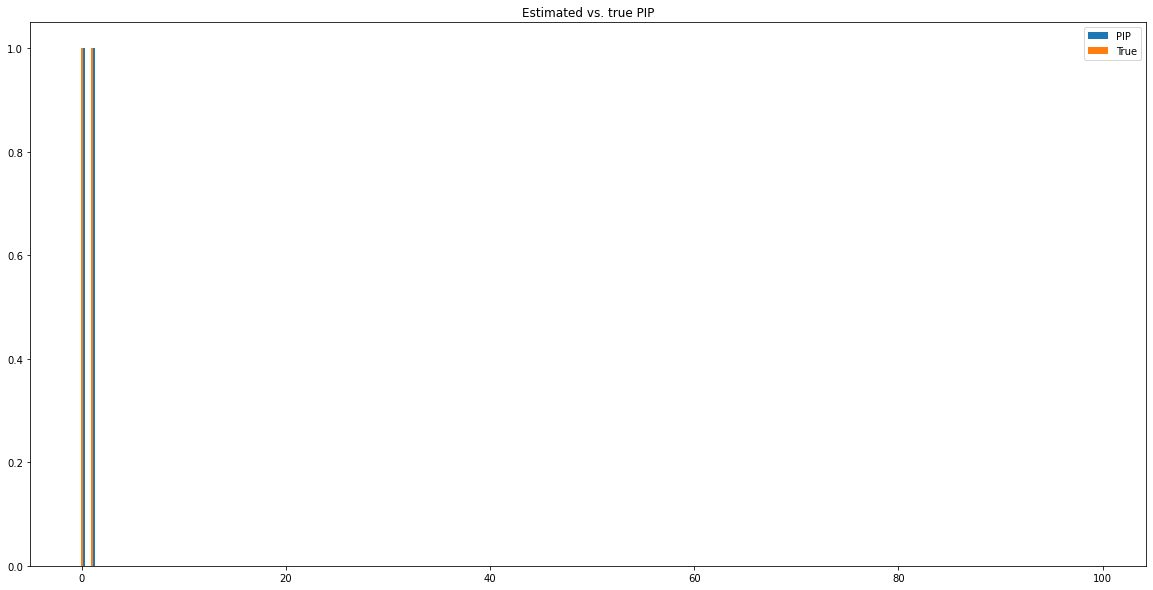

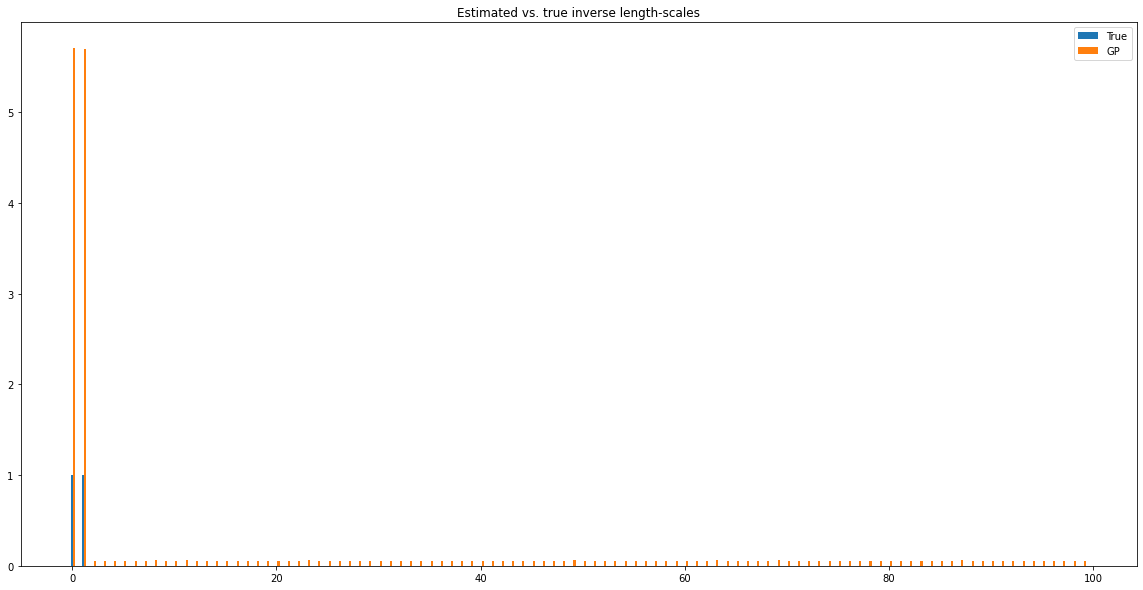

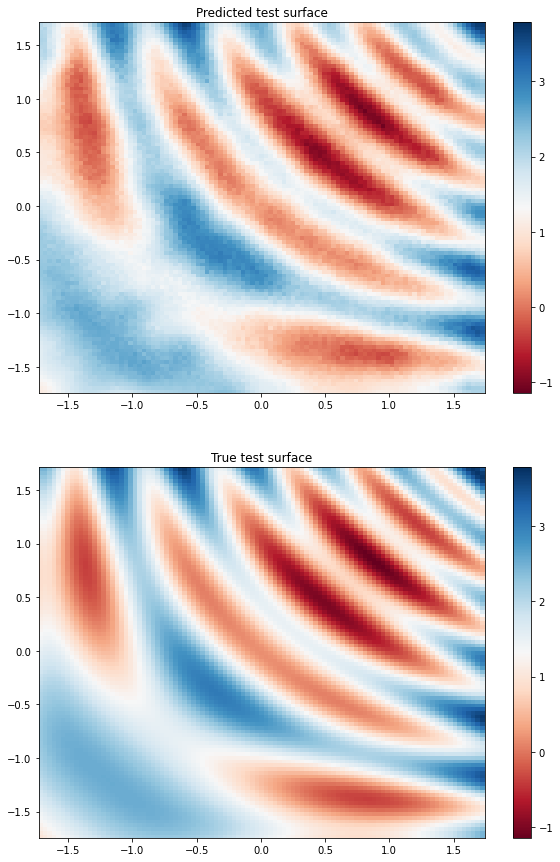

Latent test function MSE :  0.01709922
Observed test data  MSE :  0.31724823


[0.7263088  0.7180179  0.7160959  0.725037   0.71559554 0.7203029
 0.7255338  0.7266087  0.7162524  0.721895  ]
2.9637632369995117 0.052702818


[0.76601475 0.74318826 0.7427752  0.76479185 0.7536246  0.7629876
 0.7639459  0.75691414 0.7469579  0.7597031 ]
2.9597639656066894 0.062147494


[0.81426877 0.7866386  0.78915745 0.8182418  0.8069375  0.8185965
 0.8146992  0.8020886  0.7977772  0.8137883 ]
2.954334516906738 0.08357633


[0.87616426 0.8432539  0.8482542  0.88634324 0.88058674 0.8907298
 0.8792279  0.8542151  0.8621196  0.88630915]
2.9480730869255063 0.09390876


[0.93453383 0.9020271  0.91444397 0.9542513  0.95945287 0.9674754
 0.9413941  0.9071145  0.92361015 0.96197695]
2.939528530448951 0.08356527


[0.9980141  0.96210957 0.9850675  1.0212972  1.035251   1.0441082
 1.0041183  0.9558594  0.98205966 1.0360323 ]
2.9296434988122932 0.072461076


[1.0524533  1.015576   1.058653   1.0868806  1.1139673  1.1256207
 1.0622145  0.99775535 1.0401016  1.113126  ]
2.919629588409894 0.062370688


[1.1050806 1.0594109 1.1334975 1.154491  1.1935347 1.208464  1.1178749
 1.0526232 1.0905328 1.19289  ]
2.9093245507655414 0.054511644


[1.1617817 1.0977324 1.2043488 1.2240273 1.2728468 1.294552  1.1826837
 1.0955673 1.1343901 1.2708553]
2.8992922614975862 0.05020428


[1.2208736 1.1500187 1.2850038 1.2977827 1.3661679 1.3755635 1.2588582
 1.146038  1.1849504 1.3643571]
2.8883492334539143 0.046799146


[1.2980764 1.2224966 1.3702862 1.3782126 1.4666543 1.4787875 1.3419043
 1.2107451 1.2367175 1.4709704]
2.8765995206451316 0.0465229


[1.3885592 1.2876712 1.4595853 1.4615189 1.5863235 1.5784216 1.4384831
 1.2848903 1.2961028 1.5828861]
2.86501947333373 0.044350743


[1.4926916 1.3975435 1.5654114 1.5584536 1.7224019 1.6901882 1.540117
 1.3611251 1.3659576 1.6943378]
2.853030988147436 0.04348797


[1.6190861 1.5262368 1.6876807 1.6739657 1.8737181 1.8115143 1.6535463
 1.4434329 1.4420469 1.8166441]
2.8411925251134957 0.042981263


[1.7473673 1.6678375 1.8243928 1.80962   2.0392537 1.9577265 1.7778598
 1.5444906 1.5481484 1.9546307]
2.8291825750172372 0.04263042


[1.8855765 1.8203156 1.9724907 1.9615828 2.2197378 2.1144528 1.9129514
 1.6633134 1.6730391 2.0964894]
2.817188831141912 0.040816717


[2.042188  1.9918246 2.1460876 2.1349683 2.4182153 2.29536   2.065182
 1.807128  1.8256433 2.247791 ]
2.8052149699644344 0.039697614


[2.193477  2.1523342 2.333472  2.3288379 2.61826   2.4886556 2.2435684
 1.9668381 1.9996217 2.4149485]
2.7933924032897686 0.03692369


[2.33968   2.3042514 2.527843  2.534264  2.8236256 2.6855698 2.433161
 2.14692   2.1871934 2.6003783]
2.7811190882637526 0.03346658


[2.4530544 2.4259334 2.7261689 2.7416098 3.0241761 2.8870156 2.6239772
 2.330993  2.3784509 2.7898219]
2.7688398461859705 0.029445156


[2.4875715 2.4326203 2.9162977 2.9401877 3.211823  3.0798585 2.8011289
 2.5051568 2.5659978 2.9708257]
2.7567605237472126 0.02440354


[2.376256  2.2858586 3.0815516 3.1256645 3.376392  3.2578504 2.961212
 2.6671402 2.7409608 3.1345618]
2.744839508504171 0.020069607


[2.1468556 2.0369306 3.2286515 3.2880297 3.5333354 3.412096  3.106518
 2.8242555 2.8965092 3.284186 ]
2.732927472967698 0.01669767


[1.8805401 1.7752136 3.3664699 3.4342537 3.6906786 3.5550997 3.2403955
 2.9723032 3.0349913 3.414366 ]
2.721023390355712 0.01448252


[1.6189395 1.5163553 3.5042765 3.5775006 3.8385367 3.7012897 3.3780327
 3.1158068 3.173507  3.5484238]
2.709071772661185 0.0137198


[1.3717376 1.2781535 3.6491446 3.7249362 3.9999368 3.854855  3.5276046
 3.260537  3.3201506 3.6932545]
2.6968334261503935 0.014189766


[1.1496711 1.0676327 3.8213718 3.8909914 4.175905  4.0293365 3.6998298
 3.4230702 3.4878895 3.8641105]
2.6845909379410595 0.015382967


[0.96105546 0.88640666 4.007601   4.069263   4.3692803  4.2185245
 3.8810287  3.6002898  3.6682723  4.0545154 ]
2.67262054187685 0.015943367


[0.8145226 0.7510726 4.206971  4.2567163 4.567746  4.414205  4.080145
 3.7813425 3.8538275 4.2547293]
2.6603888008555114 0.015550774


[0.7182659 0.6797786 4.3945475 4.4417257 4.7612276 4.608155  4.2695656
 3.9610965 4.0325484 4.4524326]
2.64780954601613 0.013417496


[0.6657341 0.6395007 4.569475  4.6059637 4.933335  4.7852187 4.438511
 4.119247  4.1947594 4.6234713]
2.6352306302530057 0.0105849635


[0.637179   0.62068856 4.7219543  4.7536592  5.085377   4.941925
 4.5874667  4.2558856  4.339368   4.777894  ]
2.622950458445257 0.008224932


[0.61396086 0.6014695  4.85325    4.8866944  5.218229   5.0816917
 4.7248898  4.382904   4.4627876  4.915209  ]
2.6106067797332257 0.0070001436


[0.587215  0.5856512 4.970189  5.0045033 5.3380933 5.2103677 4.8451815
 4.4944124 4.5722046 5.037523 ]
2.5981552801312366 0.006212153


[0.56564474 0.5616704  5.0746646  5.1155853  5.45092    5.3304734
 4.951481   4.592476   4.6746097  5.1497254 ]
2.585970774468138 0.005749433


[0.5435581 0.5421812 5.172643  5.213602  5.5560265 5.4399457 5.0531607
 4.6856303 4.7663684 5.253657 ]
2.5737597388273383 0.0052157044


[0.5215659  0.52014744 5.267851   5.309124   5.652437   5.547943
 5.1498637  4.776041   4.8560634  5.3528104 ]
2.561620119792565 0.005113076


[0.500482   0.49498487 5.354144   5.3975015  5.7451005  5.644824
 5.2370987  4.8581696  4.935084   5.439569  ]
2.549390819019597 0.0049470593


[0.47903493 0.4774788  5.4436626  5.485132   5.834761   5.739893
 5.325392   4.9384003  5.014506   5.5310087 ]
2.5373187777231694 0.0047451914


[0.46146375 0.4586008  5.5331626  5.5743785  5.9275904  5.8355765
 5.4127755  5.021818   5.096151   5.621237  ]
2.525503649876739 0.004642448


[0.44033566 0.43712908 5.6180773  5.6595564  6.01523    5.9302316
 5.4998236  5.1004667  5.174931   5.709904  ]
2.513677791377468 0.0049046003


[0.420521  0.4142637 5.7035313 5.7436104 6.101442  6.0235314 5.582978
 5.1777005 5.254923  5.7958055]
2.501724979146677 0.005012429


[0.40412274 0.40253672 5.793161   5.8290277  6.1916285  6.116058
 5.6719275  5.258959   5.337109   5.8832035 ]
2.490082701698655 0.0043336893


[0.3904815  0.38539293 5.8838086  5.915381   6.2776856  6.2076254
 5.759594   5.338901   5.4171734  5.9696608 ]
2.4781751364957856 0.0045782523


[0.3674328  0.37051207 5.978472   6.002781   6.369559   6.299264
 5.8514705  5.4209766  5.4985404  6.059445  ]
2.4663677618092947 0.005202236


[0.35224614 0.35448378 6.0685515  6.0903316  6.4588795  6.393927
 5.942928   5.5041995  5.5816665  6.145754  ]
2.454561448607324 0.004885361


[0.33187044 0.34028295 6.158243   6.1758175  6.548528   6.4868894
 6.0315237  5.5850554  5.6648984  6.233615  ]
2.443099737910771 0.0053403843


[0.3126203  0.32753584 6.2548647  6.2672925  6.6420546  6.5818996
 6.1252313  5.671293   5.7537947  6.324117  ]
2.431589903375367 0.0054384996


[0.29981557 0.3122193  6.350936   6.3583703  6.7362676  6.680266
 6.220789   5.7590876  5.843154   6.419399  ]
2.419911044956695 0.005273953


[0.2777294  0.29377368 6.4509363  6.4505105  6.8328767  6.7773542
 6.3195076  5.8479342  5.935889   6.513943  ]
2.4085326980950796 0.007036879


[0.2558473  0.28473663 6.5562506  6.5461307  6.9336653  6.879544
 6.418219   5.939875   6.029887   6.611598  ]
2.396945615161294 0.006545262


[0.24547921 0.264543   6.6634297  6.6478314  7.0374866  6.9821434
 6.5212855  6.036012   6.1266146  6.713389  ]
2.385640736970649 0.0067296578


[0.23286557 0.24962354 6.7762218  6.751431   7.146687   7.087679
 6.6292152  6.1362796  6.2282677  6.8197746 ]
2.374117568917883 0.006881043


[0.22261567 0.23668757 6.8908057  6.856041   7.2579803  7.1960754
 6.738655   6.2379737  6.332325   6.9282374 ]
2.3626755470334833 0.006539513


[0.2165349  0.22341534 7.005998   6.961764   7.3684373  7.3048387
 6.8492093  6.341082   6.4340525  7.03726   ]
2.35135517183506 0.0060788016


[0.20783368 0.2163861  7.1214104  7.068619   7.482538   7.4133205
 6.9615235  6.4467373  6.5396924  7.1481204 ]
2.3397232028536785 0.0056527555


[0.20323858 0.20833398 7.236623   7.174851   7.592922   7.5210204
 7.0706334  6.549153   6.6442437  7.2581663 ]
2.328466305669731 0.0050425883


[0.19739339 0.20257138 7.349453   7.2809396  7.7030168  7.625055
 7.179064   6.651462   6.7466226  7.3653307 ]
2.3174203632684747 0.004891233


[0.1918613  0.19717619 7.46195    7.3850436  7.8109775  7.7295995
 7.2873864  6.753329   6.8489156  7.4711103 ]
2.3058429656851365 0.0047973944


[0.19115584 0.19370687 7.568427   7.4826775  7.915048   7.8280725
 7.390573   6.850373   6.945428   7.5739093 ]
2.29435099854507 0.00296484


[0.18963684 0.18905063 7.6743417  7.5792594  8.017826   7.927281
 7.491795   6.94757    7.040531   7.6747847 ]
2.2829787575949583 0.003469766


[0.18453044 0.18863948 7.7743673  7.6736975  8.117749   8.023699
 7.589421   7.0387     7.1319532  7.773008  ]
2.271598421465542 0.0032406333


[0.1852697  0.18366663 7.872983   7.765136   8.216391   8.1147585
 7.6837463  7.130295   7.2219734  7.8672867 ]
2.26037876536635 0.0032379732


[0.1820783  0.18475908 7.9711757  7.85685    8.31365    8.208558
 7.778736   7.2205677  7.309769   7.959029  ]
2.249202752142008 0.002798637


[0.18012339 0.18130754 8.063355   7.941377   8.405964   8.297953
 7.8689766  7.3031316  7.393529   8.0468445 ]
2.238085703639753 0.0030494558


[0.18158057 0.17775032 8.155812   8.027177   8.497627   8.385673
 7.9587545  7.3887315  7.477593   8.134805  ]
2.2267502274341204 0.0029303497


[0.17768608 0.17994283 8.244396   8.111702   8.586475   8.473115
 8.047029   7.4717855  7.560329   8.221581  ]
2.2150868313476 0.0032189959


[0.1780915  0.17884526 8.331697   8.193335   8.671781   8.556016
 8.131622   7.553039   7.639017   8.304738  ]
2.203883250116796 0.0017198308


[0.18004733 0.17588872 8.418393   8.274557   8.758499   8.637819
 8.215449   7.632645   7.7160974  8.387118  ]
2.1927981813390014 0.0027725513


[0.17730798 0.179245   8.506018   8.353088   8.842864   8.720703
 8.298035   7.710771   7.7950506  8.468491  ]
2.181725769365089 0.003109186


[0.1788116  0.17730449 8.588469   8.430505   8.925402   8.800966
 8.379482   7.788319   7.8716874  8.549448  ]
2.170831408533468 0.0022128823


[0.17410289 0.17831312 8.672192   8.50762    9.008758   8.879706
 8.459841   7.864603   7.9460435  8.629183  ]
2.1601237467613656 0.0029239818


[0.17801939 0.17714557 8.756154   8.58562    9.09214    8.959853
 8.540276   7.9417624  8.021972   8.708312  ]
2.149168856101232 0.0027241088


[0.1761684  0.17423435 8.838407   8.661319   9.174121   9.040232
 8.618184   8.016507   8.096297   8.788376  ]
2.138319960718778 0.0025778906


[0.17793457 0.17703713 8.918325   8.733616   9.25238    9.116094
 8.6948595  8.091847   8.166716   8.86505   ]
2.1277461743062465 0.0024713457


[0.17536429 0.1754559  8.998751   8.809008   9.333001   9.191933
 8.773339   8.16504    8.238221   8.943531  ]
2.1168436579653296 0.0023195934


[0.17569897 0.17591698 9.076337   8.883422   9.41055    9.268504
 8.851252   8.236455   8.310285   9.018631  ]
2.1063761410138198 0.001206028


[0.17475149 0.17499311 9.154237   8.95485    9.487269   9.344315
 8.927247   8.306751   8.379079   9.092848  ]
2.0959079694798564 0.0015283626


[0.17469774 0.17554149 9.23196    9.028672   9.566211   9.420403
 9.003564   8.377781   8.44867    9.168341  ]
2.085429489188439 0.0011067195


[0.17655699 0.17588624 9.30827    9.098431   9.641568   9.492927
 9.078327   8.447913   8.515936   9.242813  ]
2.075051090893463 0.001587882


[0.17526762 0.17341831 9.382926   9.167734   9.715373   9.564847
 9.151277   8.515369   8.58242    9.315579  ]
2.064838495214326 0.0020669089


[0.17524642 0.17546082 9.45875    9.237309   9.788348   9.637547
 9.222554   8.582188   8.648357   9.387973  ]
2.0549551036913662 0.0015045586


[0.17526768 0.17577161 9.532288   9.307837   9.862311   9.710434
 9.295943   8.6510515  8.71569    9.459679  ]
2.0449902026941253 0.00092733925


[0.17500207 0.17542587 9.6066675  9.375633   9.9351     9.781684
 9.365637   8.717138   8.77998    9.529634  ]
2.0348969355224544 0.0009765213


[ 0.1769049   0.17571113  9.676745    9.44296    10.005483    9.848519
  9.434684    8.781298    8.8438015   9.598737  ]
2.0249752194135375 0.0014681044


[ 0.17374066  0.17467283  9.74759     9.508558   10.074701    9.917717
  9.503818    8.845127    8.907494    9.666091  ]
2.0148066880846516 0.0021034572


[ 0.17519617  0.17625391  9.816978    9.5707245  10.141138    9.984173
  9.571174    8.909312    8.969403    9.7335825 ]
2.0050211080430995 0.0017099467


[ 0.1769287   0.17462611  9.884674    9.634074   10.208127   10.049865
  9.637677    8.972099    9.030074    9.799267  ]
1.9952300627265234 0.0017839578


[ 0.17376894  0.17636254  9.95369     9.694483   10.277765   10.116507
  9.70421     9.0340605   9.0905485   9.865973  ]
1.9856195732793729 0.0022749687


[ 0.1762567   0.17573115 10.020183    9.755958   10.34111    10.180927
  9.768398    9.09552     9.147965    9.929919  ]
1.9761522036783996 0.0016759929


[ 0.17507686  0.17244045 10.0863285   9.81705    10.406199   10.245919
  9.833892    9.153953    9.206115    9.9921255 ]
1.966327224152602 0.002106173


[ 0.17392021  0.17595863 10.150735    9.8777075  10.471855   10.31034
  9.897849    9.214808    9.264624   10.056503  ]
1.956806820668324 0.0021708566


[ 0.1753857   0.17453206 10.213226    9.936068   10.534619   10.373061
  9.959464    9.273702    9.3198395  10.117935  ]
1.9474487288963485 0.0015546355


[ 0.17520075  0.17508213 10.277518    9.995233   10.597796   10.434737
 10.020197    9.332046    9.377307   10.178211  ]
1.938008024327951 0.00083245506


[ 0.17517321  0.17270164 10.3411875  10.052872   10.660197   10.496333
 10.081146    9.386112    9.431287   10.238328  ]
1.9288248325314792 0.0013757241


[ 0.17542411  0.1749677  10.403975   10.111075   10.7234745  10.558384
 10.140022    9.443609    9.4893465  10.29969   ]
1.9194034929948456 0.0014091198


[ 0.17442532  0.17623828 10.468018   10.168376   10.782983   10.619578
 10.20186     9.5001545   9.545454   10.359266  ]
1.910456966352327 0.0013044906


[ 0.1751175   0.17157824 10.527774   10.222323   10.842041   10.678025
 10.261109    9.554236    9.597415   10.417998  ]
1.9015885169128028 0.0023096164


[ 0.17552249  0.17904183 10.587152   10.279529   10.9027605  10.736237
 10.318824    9.608594    9.650516   10.476369  ]
1.892600126174217 0.003094436


[ 0.17455839  0.17186786 10.644455   10.33235    10.960458   10.795556
 10.374385    9.661138    9.703077   10.532377  ]
1.884048340753768 0.003158465


[ 0.17504685  0.17447755 10.702207   10.384476   11.019645   10.855035
 10.432388    9.715451    9.756342   10.589801  ]
1.8754248981234367 0.0015437067


[ 0.174404    0.17424458 10.758561   10.439204   11.077013   10.912359
 10.488433    9.767824    9.806007   10.645884  ]
1.866549967021879 0.0007831284


[ 0.1740631   0.17467965 10.814386   10.491826   11.134746   10.967516
 10.543798    9.818029    9.856826   10.699209  ]
1.858006892907843 0.0007365431


[ 0.17526056  0.17471421 10.871548   10.543473   11.192118   11.022061
 10.59807     9.868839    9.9066     10.752081  ]
1.8492687131217547 0.00087756605


[ 0.17674573  0.1748826  10.92755    10.596799   11.247686   11.077737
 10.653086    9.922646    9.957457   10.80635   ]
1.8409819648066075 0.0010075389


[ 0.17438136  0.17278837 10.982461   10.649146   11.301896   11.132299
 10.708835    9.97328    10.0061455  10.86232   ]
1.8324941822831753 0.0019214661


[ 0.17504339  0.17477745 11.038015   10.70216    11.3578415  11.18863
 10.762323   10.024744   10.056474   10.915894  ]
1.8241699414109662 0.0013329244


[ 0.17584498  0.17599627 11.091323   10.75122    11.408963   11.243048
 10.81597    10.073913   10.102971   10.966518  ]
1.8159786901761015 0.0010885387


[ 0.17462336  0.17344952 11.146413   10.801499   11.462872   11.294974
 10.867445   10.123013   10.149954   11.02012   ]
1.8076504891584346 0.001663504


[ 0.1748285   0.17394309 11.1995535  10.849501   11.517736   11.348115
 10.917954   10.169801   10.197232   11.071582  ]
1.799556292416188 0.0006559143


[ 0.17679802  0.17491257 11.252442   10.8999815  11.571352   11.398619
 10.969024   10.219738   10.2434845  11.124056  ]
1.791446510303336 0.0013709634


[ 0.1759046   0.17495763 11.302857   10.94984    11.622607   11.4507065
 11.020166   10.267044   10.289965   11.173264  ]
1.7834196981935047 0.00071119925


[ 0.17600562  0.1739124  11.355743   10.998441   11.675513   11.501517
 11.07248    10.312317   10.338051   11.22285   ]
1.7753969532427052 0.0007815656


[ 0.17590366  0.17491573 11.4060755  11.046123   11.725788   11.552419
 11.121363   10.360328   10.384554   11.271903  ]
1.7677891521806608 0.000753043


[ 0.17619653  0.17493165 11.459033   11.092027   11.778405   11.605171
 11.172018   10.408455   10.4300375  11.322719  ]
1.7602861418787181 0.0004931243


[ 0.17602141  0.17400528 11.51005    11.139964   11.829943   11.655409
 11.221406   10.453684   10.473669   11.371568  ]
1.7525219062486195 0.0007404153


[ 0.17416866  0.17541006 11.557744   11.187723   11.879998   11.705024
 11.270947   10.498945   10.516798   11.420911  ]
1.7452530574921483 0.0014398262


[ 0.17692901  0.17551816 11.606707   11.232803   11.929959   11.75491
 11.32026    10.543078   10.560443   11.470441  ]
1.7380106976630763 0.0012996963


[ 0.1755815   0.17394738 11.656236   11.280964   11.977896   11.803875
 11.36925    10.58823    10.602754   11.52054   ]
1.7304471293779662 0.0013132947


[ 0.17478572  0.17446566 11.706207   11.325657   12.027593   11.852523
 11.416194   10.633094   10.649429   11.567884  ]
1.723274019568714 0.00078586995


[ 0.17678247  0.17483287 11.75752    11.373829   12.076731   11.901809
 11.462764   10.676951   10.693908   11.6164465 ]
1.7162526732061874 0.0011251657


[ 0.17627569  0.17538002 11.806751   11.418792   12.126339   11.950587
 11.511427   10.722663   10.735508   11.664732  ]
1.7089657068769957 0.0006935524


[ 0.17673302  0.1733049  11.853544   11.464826   12.174453   11.999613
 11.559484   10.7659855  10.778      11.711394  ]
1.7017902298485852 0.0011695798


[ 0.17565945  0.17544201 11.901802   11.508872   12.222724   12.047155
 11.605076   10.81177    10.817263   11.758965  ]
1.6947746402103168 0.0013880414


[ 0.17649886  0.17573501 11.9487705  11.554754   12.270567   12.094622
 11.653113   10.853863   10.86234    11.804856  ]
1.6877031402605451 0.00070062117


[ 0.17603135  0.17480421 11.995412   11.596691   12.318472   12.141309
 11.699376   10.895206   10.903558   11.849701  ]
1.6804225752800206 0.00077772373


[ 0.17526364  0.174892   12.041957   11.642408   12.364357   12.189411
 11.745675   10.940321   10.945453   11.894871  ]
1.6732048524368806 0.0006050032


[ 0.17574489  0.17399877 12.09002    11.68495    12.412219   12.235324
 11.791623   10.982729   10.985691   11.939961  ]
1.666454333625189 0.0007692344


[ 0.17578594  0.1746772  12.137599   11.730275   12.459384   12.282879
 11.838761   11.026458   11.028574   11.987303  ]
1.6595250020189403 0.000560512


[ 0.177906    0.17422885 12.184113   11.774131   12.505891   12.32725
 11.882519   11.069596   11.0685425  12.032169  ]
1.652852196819155 0.0011336267


[ 0.1757878   0.17419074 12.230645   11.814805   12.553162   12.374775
 11.93004    11.111216   11.110546   12.077145  ]
1.6463096999459492 0.0010020947


[ 0.17650528  0.17472243 12.274713   11.8572645  12.598933   12.417791
 11.97527    11.153167   11.150849   12.120686  ]
1.6395748725235162 0.0007038194


[ 0.17772466  0.17444868 12.319622   11.900113   12.645859   12.464957
 12.019423   11.19442    11.191534   12.166331  ]
1.632934277454287 0.00078337855


[ 0.17612906  0.17404151 12.364918   11.939656   12.690153   12.508362
 12.062399   11.235618   11.229565   12.208387  ]
1.6267426166408037 0.0009372303


[ 0.17732613  0.17588225 12.411496   11.9815     12.734781   12.556096
 12.1062     11.278729   11.26926    12.25086   ]
1.6205230720776367 0.0012794766


[ 0.17572865  0.17412032 12.455955   12.025624   12.779256   12.601045
 12.151447   11.319497   11.3087435  12.294745  ]
1.6140216503797638 0.0013778135


[ 0.17661218  0.17715819 12.500061   12.065903   12.825116   12.645599
 12.193089   11.360612   11.34848    12.339332  ]
1.6074957495049715 0.0015516


[ 0.17615138  0.175316   12.544926   12.106887   12.869026   12.690256
 12.237325   11.401369   11.386592   12.382786  ]
1.6011173823142963 0.0010237889


[ 0.17691381  0.17474487 12.587943   12.147493   12.913432   12.732927
 12.280067   11.441931   11.425063   12.424867  ]
1.5950678034303851 0.00070961675


[ 0.17715901  0.17422505 12.63192    12.186547   12.957053   12.775726
 12.324018   11.478938   11.460302   12.467369  ]
1.5884947629016124 0.0005203135


[ 0.17581202  0.1765779  12.67422    12.228783   12.999733   12.81916
 12.366071   11.519513   11.500131   12.508896  ]
1.582368685278204 0.0014653263


[ 0.17812477  0.1730932  12.716893   12.269131   13.043852   12.86412
 12.410623   11.558621   11.54008    12.551807  ]
1.576711260813651 0.0021498022


[ 0.17559414  0.1747511  12.760255   12.311897   13.086703   12.907592
 12.451163   11.597874   11.577768   12.592476  ]
1.5705686621892412 0.0016278032


[ 0.17759444  0.17527822 12.805254   12.352401   13.130338   12.951395
 12.494827   11.637889   11.615708   12.634175  ]
1.5645236314234812 0.0010765973


[ 0.1768122   0.17484246 12.847999   12.393033   13.175015   12.993477
 12.536477   11.678482   11.6523905  12.676949  ]
1.558655796794961 0.0006520453


[ 0.1779248  0.1753645 12.888062  12.431682  13.220181  13.035584
 12.580008  11.7163    11.690249  12.718853 ]
1.5525473781082841 0.000781052


[ 0.17577983  0.17570631 12.931692   12.470793   13.26369    13.07931
 12.624309   11.754955   11.72838    12.759331  ]
1.5470596960561747 0.0010542065


[ 0.17741849  0.17616932 12.972556   12.511204   13.305647   13.122279
 12.66473    11.794564   11.764416   12.801798  ]
1.541034519003183 0.0009273682


[ 0.17696887  0.17486718 13.016992   12.550258   13.349548   13.164182
 12.70573    11.833188   11.801898   12.840928  ]
1.5351500319769846 0.000817441


[ 0.17887312  0.17576343 13.058285   12.587897   13.391485   13.206881
 12.746255   11.871965   11.836674   12.879655  ]
1.5294724090156513 0.0011400018


[ 0.17642583  0.17605798 13.098653   12.627169   13.433629   13.248878
 12.788816   11.909371   11.873605   12.92035   ]
1.5238748355135305 0.0011146175


[ 0.17766619  0.17463751 13.143216   12.668392   13.47643    13.292224
 12.829029   11.948515   11.91307    12.961313  ]
1.5184792953521742 0.0011058385


[ 0.17689012  0.17395711 13.184727   12.706983   13.518986   13.333338
 12.8677     11.985634   11.945162   12.999249  ]
1.5130790417405788 0.0007041603


[ 0.17622077  0.17534278 13.227938   12.746959   13.558839   13.375751
 12.908477   12.023291   11.982639   13.040916  ]
1.5075639074606395 0.0009096403


[ 0.17930168  0.17618084 13.270061   12.785152   13.602023   13.418501
 12.949001   12.062185   12.018763   13.081393  ]
1.5022067008124855 0.0014863691


[ 0.17654511  0.17523472 13.308736   12.821325   13.642725   13.459861
 12.989099   12.100195   12.050384   13.120722  ]
1.4972253676186 0.0014023817


[ 0.17622638  0.1752608  13.348989   12.861472   13.685381   13.500818
 13.031924   12.137141   12.091065   13.16081   ]
1.492018213229447 0.00034751595


[ 0.17813867  0.17477973 13.3918495  12.902205   13.727622   13.5430355
 13.072507   12.175611   12.125148   13.201108  ]
1.4869877523715285 0.0010014918


[ 0.17870815  0.17562865 13.4310465  12.93778    13.767824   13.582678
 13.111879   12.211595   12.15989    13.239179  ]
1.4821304776539046 0.00067433895


[ 0.17612785  0.17513889 13.471429   12.976557   13.8100395  13.621666
 13.151449   12.249345   12.195219   13.279355  ]
1.4770066739407124 0.0012075393


[ 0.1775706   0.17524053 13.51258    13.013927   13.851572   13.660907
 13.189873   12.289906   12.229376   13.318021  ]
1.4719858534409676 0.00071511813


[ 0.17705798  0.17491864 13.554414   13.05319    13.892813   13.701386
 13.228662   12.324017   12.264664   13.356699  ]
1.4669626847506894 0.00048818043


[ 0.1767659   0.17636612 13.591226   13.090814   13.930635   13.743168
 13.269131   12.35824    12.298406   13.394722  ]
1.46209059105767 0.000778718


[ 0.17843267  0.17591973 13.631275   13.129698   13.970561   13.781389
 13.307367   12.394717   12.333962   13.432329  ]
1.4571996981599795 0.0008888952


[ 0.1764636   0.17502958 13.6720295  13.16667    14.010577   13.820481
 13.3468275  12.432666   12.367417   13.471008  ]
1.452285112753697 0.0011299517


[ 0.17685333  0.17609009 13.711421   13.205021   14.049938   13.8609085
 13.384925   12.470232   12.400921   13.511562  ]
1.447271665331757 0.0006851248


[ 0.17759816  0.17476346 13.750513   13.241845   14.09       13.900418
 13.423304   12.506966   12.436835   13.550776  ]
1.4426928553909715 0.0008805445


[ 0.17575079  0.17628807 13.7914095  13.281861   14.130399   13.940665
 13.461549   12.541402   12.471364   13.589678  ]
1.4377149200430859 0.001296551


[ 0.17762801  0.17562544 13.832298   13.3172035  14.172436   13.978078
 13.501514   12.576953   12.504772   13.627777  ]
1.4331783784857826 0.0010210314


[ 0.18003729  0.17504023 13.870017   13.35222    14.213136   14.016364
 13.540481   12.612752   12.539063   13.666154  ]
1.4285113132096452 0.0011495684


[ 0.17684902  0.17649512 13.909599   13.390234   14.250369   14.056644
 13.5782585  12.649968   12.572156   13.703175  ]
1.4235917199587973 0.001676799


[ 0.17871241  0.1762937  13.948576   13.4292345  14.292848   14.097444
 13.617043   12.68563    12.605252   13.74188   ]
1.4189883729067236 0.00085881085


[ 0.17693211  0.17659216 13.984847   13.470105   14.333326   14.136833
 13.656086   12.723192   12.640417   13.780992  ]
1.414469732010794 0.0008612959


[ 0.17753208  0.1748518  14.025299   13.505115   14.37289    14.175773
 13.693189   12.758704   12.673752   13.818788  ]
1.4100748924740034 0.00095305475


[ 0.17827886  0.17685689 14.065066   13.541751   14.41233    14.21614
 13.733644   12.795716   12.70871    13.857116  ]
1.4059018931830525 0.0010857884


[ 0.17728361  0.17695068 14.105717   13.579401   14.451571   14.254751
 13.771951   12.831489   12.740598   13.895916  ]
1.4011297005041592 0.0005411103


[ 0.17905574  0.17570567 14.142593   13.61766    14.492199   14.294057
 13.810682   12.86631    12.77269    13.93294   ]
1.3965001489567668 0.0011548809


[ 0.17796357  0.17595135 14.178756   13.654569   14.530908   14.331639
 13.849463   12.900329   12.806783   13.96925   ]
1.3924677298455865 0.0006137006


[ 0.17789362  0.17666459 14.216654   13.691444   14.569428   14.368839
 13.887315   12.935672   12.84095    14.004876  ]
1.3883803598810769 0.0004440345


[ 0.17890096  0.17595313 14.253492   13.725805   14.608542   14.406127
 13.924263   12.970983   12.8747225  14.041501  ]
1.3840980443956694 0.0007351803


[ 0.17771037  0.17601097 14.291725   13.760028   14.647572   14.444696
 13.962031   13.005502   12.910086   14.079537  ]
1.379889035072547 0.0005801905


[ 0.17900334  0.17524956 14.330824   13.799222   14.687694   14.483696
 14.00149    13.039859   12.942873   14.117778  ]
1.375701070038632 0.00084074127


[ 0.17718637  0.17521144 14.367673   13.836609   14.725335   14.522463
 14.03998    13.074499   12.976282   14.152242  ]
1.3713673307558636 0.00077239313


[ 0.17781249  0.17783713 14.405702   13.870758   14.763614   14.561303
 14.075658   13.108411   13.009913   14.190664  ]
1.367430318248285 0.001228968


[ 0.17871344  0.17409737 14.444919   13.908906   14.804092   14.599691
 14.113031   13.144802   13.043712   14.227644  ]
1.3636677840982805 0.0016744339


[ 0.17723773  0.177025   14.482903   13.9439945  14.844108   14.638364
 14.150734   13.180048   13.075902   14.263876  ]
1.359699043416836 0.0015999856


[ 0.17933682  0.17517206 14.521139   13.980836   14.882047   14.674952
 14.188427   13.215349   13.10616    14.298847  ]
1.3557402253707442 0.0014403737


[ 0.1774701   0.17676103 14.560564   14.017471   14.920595   14.712635
 14.227052   13.248457   13.1404295  14.337126  ]
1.3517897114112567 0.0012814387


[ 0.17963186  0.17612249 14.597182   14.053874   14.959425   14.750416
 14.265334   13.284183   13.173537   14.374544  ]
1.3480133840546058 0.0010619011


[ 0.17908037  0.17610656 14.633214   14.089607   14.997129   14.786456
 14.303293   13.317489   13.205674   14.41149   ]
1.3442764269127443 0.00034987225


[ 0.17884004  0.17653097 14.670625   14.12371    15.035491   14.8235445
 14.339561   13.353476   13.239921   14.446624  ]
1.3402786498214656 0.0003886251


[ 0.1782877  0.1766508 14.706752  14.160395  15.072261  14.861518
 14.374759  13.387351  13.272319  14.48252  ]
1.3360417016840374 0.00038445427


[ 0.1795173   0.17797385 14.742276   14.196816   15.111029   14.89902
 14.412621   13.4223585  13.306318   14.516243  ]
1.3320224035989672 0.0009790738


[ 0.17679116  0.17627497 14.779574   14.232807   15.149921   14.937259
 14.445864   13.454969   13.336148   14.550966  ]
1.3288471833586013 0.001569599


[ 0.17864437  0.17597683 14.814436   14.266309   15.187152   14.973101
 14.484956   13.489109   13.368641   14.588086  ]
1.3254024633131547 0.00085453177


[ 0.17901802  0.17647445 14.851696   14.302276   15.225633   15.00977
 14.520622   13.5229225  13.396898   14.621589  ]
1.3217088806508484 0.00044350192


[ 0.1785836   0.17670022 14.892476   14.339979   15.264548   15.045289
 14.557875   13.554763   13.430003   14.658186  ]
1.3176926509141642 0.00038086265


[ 0.1788746  0.1762236 14.926449  14.374916  15.302017  15.083322
 14.59295   13.589365  13.462024  14.691858 ]
1.3141651102149208 0.000410384


[ 0.17929916  0.17668846 14.964372   14.408091   15.338188   15.120803
 14.627061   13.62238    13.495499   14.729734  ]
1.3104006764055574 0.00044556372


[ 0.17809123  0.17557573 15.002061   14.445529   15.37771    15.157974
 14.664082   13.65935    13.527436   14.766493  ]
1.3071648933086466 0.0009063149


[ 0.17925486  0.1755611  15.038578   14.478641   15.416028   15.195956
 14.7022     13.694656   13.558185   14.802211  ]
1.303656645120952 0.0005338248


[ 0.17912681  0.17831506 15.075811   14.516303   15.454974   15.234157
 14.737119   13.727938   13.590796   14.8364525 ]
1.3007204254734075 0.0010847806


[ 0.178926    0.17719518 15.111142   14.550279   15.491068   15.271579
 14.772582   13.762207   13.622691   14.871783  ]
1.2973461638952177 0.0005783896


[ 0.17869349  0.17736788 15.150089   14.585913   15.530654   15.306826
 14.809223   13.7973385  13.654512   14.906894  ]
1.2938150090132388 0.0002904231


[ 0.18109043  0.17615964 15.186489   14.6202135  15.56811    15.345024
 14.844946   13.830732   13.687491   14.943165  ]
1.290365598294406 0.0012895508


[ 0.1783297  0.1762651 15.223399  14.654199  15.604901  15.381145
 14.880903  13.862284  13.719106  14.977306 ]
1.2871536194049678 0.0010460195


[ 0.17997614  0.17639351 15.260913   14.691223   15.642471   15.418318
 14.915396   13.894228   13.749508   15.013298  ]
1.2839225336885183 0.00071178767


[ 0.17871228  0.17745952 15.294554   14.727218   15.681472   15.4539
 14.951353   13.928063   13.779072   15.048286  ]
1.2801390873318883 0.00089041126


[ 0.179044    0.17758034 15.331388   14.762415   15.716517   15.488851
 14.986061   13.961286   13.81443    15.082872  ]
1.2767101048486147 0.00029942335


[ 0.17880258  0.17667684 15.367937   14.796504   15.757213   15.527112
 15.025238   13.994599   13.845738   15.121033  ]
1.2733230731751666 0.00052038004


[ 0.1795667  0.1768808 15.4028015 14.8315935 15.793464  15.563197
 15.059097  14.029928  13.875166  15.154859 ]
1.2698297896432365 0.00045840547


[ 0.17897062  0.17842476 15.440906   14.866012   15.83095    15.603281
 15.095459   14.063931   13.9067745  15.191724  ]
1.2668325315379114 0.0008312797


[ 0.17920989  0.17732903 15.4768     14.900847   15.871049   15.638095
 15.130239   14.095389   13.939962   15.225988  ]
1.2642747466125468 0.0005736261


[ 0.17929892  0.17739308 15.512577   14.936563   15.908622   15.676663
 15.166027   14.128944   13.969319   15.261482  ]
1.261493880879362 0.00020064779


[ 0.17835534  0.17573062 15.547458   14.974869   15.943976   15.711259
 15.200277   14.161194   14.001749   15.295691  ]
1.2590947919469722 0.0009767468


[ 0.17986564  0.1780902  15.583454   15.007376   15.983229   15.748208
 15.237118   14.19651    14.0319805  15.331563  ]
1.2563063762235473 0.0013763416


[ 0.18030217  0.17757873 15.620425   15.042221   16.017775   15.785015
 15.271563   14.22855    14.062738   15.365094  ]
1.253091123206551 0.00044197773


[ 0.17921597  0.17760335 15.655686   15.07791    16.055645   15.822042
 15.306723   14.262807   14.093908   15.398553  ]
1.2501253293336467 0.0004918411


[ 0.17926747  0.1764381  15.6912775  15.111949   16.090006   15.857762
 15.34096    14.294114   14.126167   15.434703  ]
1.2473123109655804 0.0005345044


[ 0.18006913  0.17826805 15.7262335  15.146169   16.126701   15.89404
 15.377961   14.325827   14.154964   15.468194  ]
1.2441012841417447 0.00097503344


[ 0.17931494  0.17825122 15.760285   15.180615   16.163424   15.9294815
 15.413377   14.3575735  14.187408   15.504616  ]
1.2417537230386848 0.00038458296


[ 0.18045034  0.17724061 15.797136   15.215407   16.19956    15.964075
 15.445918   14.390985   14.216326   15.539425  ]
1.239114479775545 0.00081755174


[ 0.17958784  0.17714411 15.832538   15.250216   16.233896   16.0003
 15.482466   14.424233   14.249777   15.577442  ]
1.236038241574927 0.00044162374


[ 0.17898951  0.17722255 15.866889   15.285407   16.273191   16.03521
 15.517181   14.456869   14.279678   15.610477  ]
1.2332979713398875 0.00035505608


[ 0.18149473  0.17741303 15.901312   15.317228   16.310587   16.071291
 15.554176   14.489813   14.310846   15.645055  ]
1.2302340843055124 0.00097361795


[ 0.18036464  0.17702769 15.93442    15.351331   16.34662    16.107395
 15.590098   14.520431   14.341507   15.6792555 ]
1.2271929051474473 0.0006091976


[ 0.17934202  0.17858793 15.971823   15.386922   16.384523   16.14352
 15.625045   14.551948   14.37108    15.713939  ]
1.2245182853277308 0.0009515512


[ 0.1793153  0.1771805 16.00792   15.41966   16.421717  16.179277
 15.659859  14.585478  14.402431  15.748552 ]
1.2223838908197904 0.0005936309


[ 0.18046992  0.17863098 16.044893   15.453919   16.457159   16.214216
 15.694562   14.617979   14.433327   15.784835  ]
1.2195725408489704 0.0009559643


[ 0.18121463  0.17695446 16.077435   15.490134   16.493681   16.250433
 15.72923    14.650193   14.465369   15.817449  ]
1.2169419757149864 0.0008960612


[ 0.17829756  0.1786877  16.111616   15.524305   16.530233   16.284988
 15.763777   14.682981   14.4940605  15.850149  ]
1.2146504200802273 0.0015874854


[ 0.18108152  0.177747   16.149343   15.5564165  16.565908   16.320269
 15.798209   14.716153   14.527027   15.884761  ]
1.21193857595652 0.0012965027


[ 0.1787553   0.17879085 16.181608   15.589595   16.60263    16.352285
 15.833189   14.745697   14.555645   15.919671  ]
1.209528951935732 0.0011800205


[ 0.18124488  0.1781716  16.216581   15.626088   16.638975   16.388115
 15.868588   14.779996   14.587634   15.953235  ]
1.2071180552262424 0.0010995283


[ 0.17869602  0.17874992 16.249048   15.659207   16.676561   16.424107
 15.902495   14.810893   14.615614   15.987204  ]
1.2046488479691917 0.0011026202


[ 0.1800433  0.1779193 16.28387   15.694072  16.712431  16.460096
 15.9397955 14.845265  14.646789  16.021576 ]
1.2022699777641883 0.0008168345


[ 0.17915837  0.17852668 16.32216    15.727599   16.749159   16.494127
 15.974844   14.879178   14.677854   16.056093  ]
1.1997963616962632 0.0005983496


[ 0.18037187  0.17809099 16.356173   15.762781   16.784075   16.530396
 16.008495   14.909218   14.71049    16.090897  ]
1.1975079249757772 0.00064863154


[ 0.18098707  0.17814408 16.389807   15.7966175  16.818964   16.564732
 16.041346   14.940869   14.7407675  16.123898  ]
1.1950962893867556 0.00033471643


[ 0.17904972  0.17859344 16.426216   15.829731   16.857018   16.601933
 16.07763    14.976056   14.771052   16.157478  ]
1.1926406366802278 0.00087326474


[ 0.18126866  0.1781812  16.460966   15.86341    16.893658   16.639744
 16.111778   15.009545   14.800273   16.193169  ]
1.1901639179135612 0.00094303413


[ 0.1810425   0.17802559 16.494276   15.896535   16.93121    16.671156
 16.145346   15.040455   14.82768    16.224989  ]
1.1874815937864582 0.000245999


[ 0.18015024  0.17926873 16.526882   15.931383   16.967064   16.706993
 16.180412   15.0736265  14.857038   16.258718  ]
1.185303873600356 0.0007919445


[ 0.17956012  0.17835993 16.561544   15.965046   17.00048    16.739824
 16.214966   15.105767   14.887701   16.295319  ]
1.1831474376857025 0.0005956817


[ 0.18128298  0.17755654 16.59817    16.001293   17.041252   16.774595
 16.248167   15.138119   14.919569   16.327969  ]
1.1813997161794052 0.00091255846


[ 0.18024655  0.17802012 16.631222   16.034317   17.076424   16.810543
 16.28292    15.16928    14.954455   16.364054  ]
1.1795157604499917 0.00059082755


[ 0.18032509  0.17958316 16.666039   16.067255   17.110756   16.845139
 16.318224   15.202339   14.983439   16.399736  ]
1.177035871242823 0.0006385254


[ 0.18141924  0.17892945 16.699245   16.10197    17.146734   16.881058
 16.352432   15.231984   15.01145    16.431341  ]
1.1747505599899972 0.00066212006


[ 0.18073128  0.17787503 16.733778   16.13571    17.183334   16.917326
 16.38542    15.264894   15.041811   16.46261   ]
1.1726815660096652 0.0006676417


[ 0.17913349  0.17932999 16.77099    16.170568   17.221159   16.952812
 16.422037   15.299808   15.070042   16.496048  ]
1.1705875595117083 0.0010768002


[ 0.18045402  0.17856696 16.807201   16.20241    17.259241   16.987076
 16.45642    15.329861   15.10068    16.5302    ]
1.1685884064145313 0.000769626


[ 0.18056662  0.17963347 16.841635   16.236532   17.292744   17.020435
 16.49035    15.362902   15.130686   16.563976  ]
1.1662124662647995 0.0004922232


[ 0.1802122   0.17774907 16.877514   16.271368   17.328352   17.056488
 16.52518    15.393415   15.162247   16.596144  ]
1.1643451800306488 0.00082017214


[ 0.18138213  0.1793164  16.912369   16.30429    17.365889   17.092619
 16.558191   15.42462    15.194019   16.632698  ]
1.1617668830212204 0.0009746775


[ 0.18022215  0.17839336 16.94575    16.337626   17.401302   17.127691
 16.593533   15.456574   15.22239    16.663876  ]
1.1596814935632234 0.00076487346


[ 0.18092051  0.17856692 16.98013    16.372366   17.436972   17.162884
 16.62921    15.488466   15.253181   16.69584   ]
1.1575883346572924 0.00038929164


[ 0.18126923  0.17867066 17.0142     16.405794   17.473833   17.197453
 16.662718   15.519822   15.283878   16.730291  ]
1.1555876096683397 0.00025689922


[ 0.18135266  0.17969592 17.050411   16.441284   17.510569   17.232355
 16.697073   15.551566   15.314481   16.764547  ]
1.1536417379967052 0.00046759055


[ 0.18024802  0.17855816 17.085371   16.473326   17.543804   17.266884
 16.731506   15.583788   15.341426   16.797752  ]
1.151458573862092 0.0008097765


[ 0.1813634   0.17833854 17.119057   16.50828    17.581509   17.300514
 16.764996   15.6136465  15.372318   16.83147   ]
1.149579977789456 0.0005286892


[ 0.18004285  0.17853306 17.154518   16.539257   17.620775   17.336786
 16.798222   15.645471   15.403652   16.865395  ]
1.1474616730619918 0.00058649277


[ 0.18121712  0.17935789 17.19154    16.575829   17.655174   17.371832
 16.8331     15.677436   15.434024   16.901169  ]
1.1455274508759734 0.0007350348


[ 0.18170057  0.17847131 17.22403    16.605963   17.692      17.405396
 16.866852   15.708603   15.460187   16.93636   ]
1.1435715045036579 0.00053895114


[ 0.18082997  0.1800844  17.257805   16.640842   17.72805    17.440336
 16.901983   15.740248   15.489125   16.969334  ]
1.1413509774850494 0.0008847069


[ 0.1814744   0.17780718 17.292534   16.6736     17.764212   17.474356
 16.936497   15.771189   15.518414   17.003193  ]
1.1393178965012452 0.001024273


[ 0.1816468   0.17899166 17.325762   16.70756    17.799196   17.507347
 16.968136   15.800487   15.546437   17.035004  ]
1.1373701094296196 0.0005382888


[ 0.18016961  0.17918324 17.359179   16.739899   17.836016   17.543354
 17.001348   15.832938   15.578499   17.068253  ]
1.135461276642437 0.0006273882


[ 0.18165515  0.17941439 17.393394   16.774244   17.871616   17.5782
 17.034838   15.863879   15.609698   17.101625  ]
1.133819874935583 0.000638636


[ 0.18129225  0.17945762 17.425657   16.807547   17.904083   17.609718
 17.07242    15.895293   15.641239   17.133856  ]
1.131796064222955 0.00023813677


[ 0.18194783  0.17874698 17.46122    16.841722   17.939987   17.644188
 17.106024   15.925733   15.670727   17.166273  ]
1.129930872740996 0.000535009


[ 0.18111296  0.17882597 17.49343    16.874336   17.976702   17.680805
 17.138937   15.957771   15.700083   17.199522  ]
1.1279728397055722 0.00039021272


[ 0.1808128   0.17865434 17.529337   16.90739    18.01409    17.715229
 17.172983   15.989366   15.730264   17.234432  ]
1.126413470157088 0.0002610906


[ 0.18219845  0.17955047 17.562931   16.941154   18.048073   17.750593
 17.207651   16.019093   15.757888   17.266134  ]
1.1245119800087016 0.00081229216


[ 0.18190333  0.17989233 17.597895   16.973074   18.084208   17.784456
 17.240381   16.05101    15.788704   17.298744  ]
1.1226727598525124 0.00030382644


[ 0.18171813  0.1783663  17.632854   17.00912    18.123741   17.82172
 17.275024   16.08163    15.81759    17.334484  ]
1.1209232017676896 0.000647087


[ 0.1814895   0.17935476 17.666924   17.042301   18.160187   17.856258
 17.3105     16.11325    15.845905   17.369257  ]
1.1189998351760762 0.00048780465


[ 0.18282454  0.17934164 17.699419   17.075275   18.194698   17.890108
 17.341938   16.144064   15.875495   17.400133  ]
1.1172122561530051 0.0005145893


[ 0.181124    0.18023293 17.731739   17.107471   18.229124   17.925503
 17.377953   16.17509    15.905611   17.430408  ]
1.1156371859272143 0.0009001442


[ 0.18125951  0.1785688  17.76623    17.141066   18.26491    17.961496
 17.411074   16.207575   15.9364395  17.46929   ]
1.114131643502337 0.00067025557


[ 0.18225381  0.18041627 17.7997     17.173958   18.30135    17.994331
 17.44534    16.235178   15.965567   17.499651  ]
1.1125563903521876 0.0009799323


[ 0.18149363  0.17932856 17.832832   17.20511    18.336367   18.027826
 17.479385   16.267761   15.997969   17.535254  ]
1.1110182913772926 0.00067479117


[ 0.18244556  0.17849562 17.867735   17.23797    18.372467   18.06147
 17.512981   16.300737   16.025177   17.566128  ]
1.1088891104366718 0.0006572266


[ 0.1815199   0.17969169 17.902054   17.27213    18.408562   18.094997
 17.54662    16.329939   16.054686   17.599173  ]
1.1071304169050131 0.0007588401


[ 0.18175708  0.17868647 17.937239   17.306643   18.444656   18.131815
 17.579664   16.361183   16.085512   17.634396  ]
1.1056011571371318 0.0004944225


[ 0.18191372  0.17941663 17.972017   17.341394   18.478506   18.168053
 17.61339    16.39346    16.11427    17.667067  ]
1.103939357930911 0.0003812404


[ 0.18226328  0.18000308 18.004406   17.372696   18.51279    18.202833
 17.646955   16.424398   16.143248   17.697792  ]
1.1020383976888133 0.00039338093


[ 0.18183625  0.17888743 18.039417   17.405977   18.549227   18.235662
 17.680933   16.455812   16.172844   17.729927  ]
1.1004650733432728 0.00058135815


[ 0.1822364   0.17867787 18.072275   17.438427   18.584827   18.270847
 17.715317   16.488192   16.20451    17.763655  ]
1.09869889519075 0.00029306844


[ 0.18142463  0.18039984 18.108416   17.47418    18.619978   18.304974
 17.748655   16.51713    16.236008   17.798119  ]
1.0969997082198149 0.0008848212


[ 0.1818598   0.17826289 18.140495   17.507673   18.653223   18.33927
 17.783613   16.54933    16.262508   17.82999   ]
1.0956030455931067 0.0009000258


[ 0.1826144   0.18099037 18.175034   17.542753   18.689579   18.373411
 17.817102   16.579931   16.293472   17.864174  ]
1.0940784613318244 0.0011789287


[ 0.18266836  0.17909327 18.211153   17.573547   18.724611   18.409012
 17.85106    16.612547   16.3235     17.897049  ]
1.092924169304642 0.00070506125


[ 0.18166907  0.1797223  18.24215    17.606655   18.76005    18.441864
 17.885527   16.64365    16.352404   17.928185  ]
1.0912493211891714 0.0005992891


[ 0.18082862  0.17911486 18.277237   17.641348   18.797081   18.474464
 17.918488   16.67204    16.379297   17.962467  ]
1.0897494188386 0.0005448361


[ 0.18284716  0.17978778 18.30949    17.673811   18.83305    18.508568
 17.952818   16.704422   16.411242   17.997648  ]
1.0879382259769659 0.00092373264


[ 0.18217221  0.17926846 18.345331   17.70688    18.868423   18.543398
 17.982748   16.736254   16.442295   18.030138  ]
1.0863747075649288 0.00046467903


[ 0.18245727  0.17931046 18.379148   17.737978   18.904871   18.576494
 18.014944   16.765072   16.471657   18.06097   ]
1.0847726294097966 0.00019835867


[ 0.18168128  0.17853348 18.41287    17.770542   18.937603   18.609932
 18.051052   16.794678   16.50036    18.093958  ]
1.0832685081572024 0.0005789232


[ 0.18292375  0.18019648 18.444094   17.803787   18.972328   18.644897
 18.081755   16.825735   16.528612   18.128544  ]
1.08178543924556 0.0009912646


[ 0.1805891   0.17973618 18.478758   17.83934    19.00797    18.677944
 18.114416   16.855541   16.557558   18.160686  ]
1.0804476660537041 0.00094846217
Runtime is  978.558422088623
Test MSE: 0.3204439580440521
Latent test function MSE :  [0.0190853  0.02045817 0.         0.         0.        ]
Test time is :  [0.68217564 0.65078378 0.         0.         0.        ]


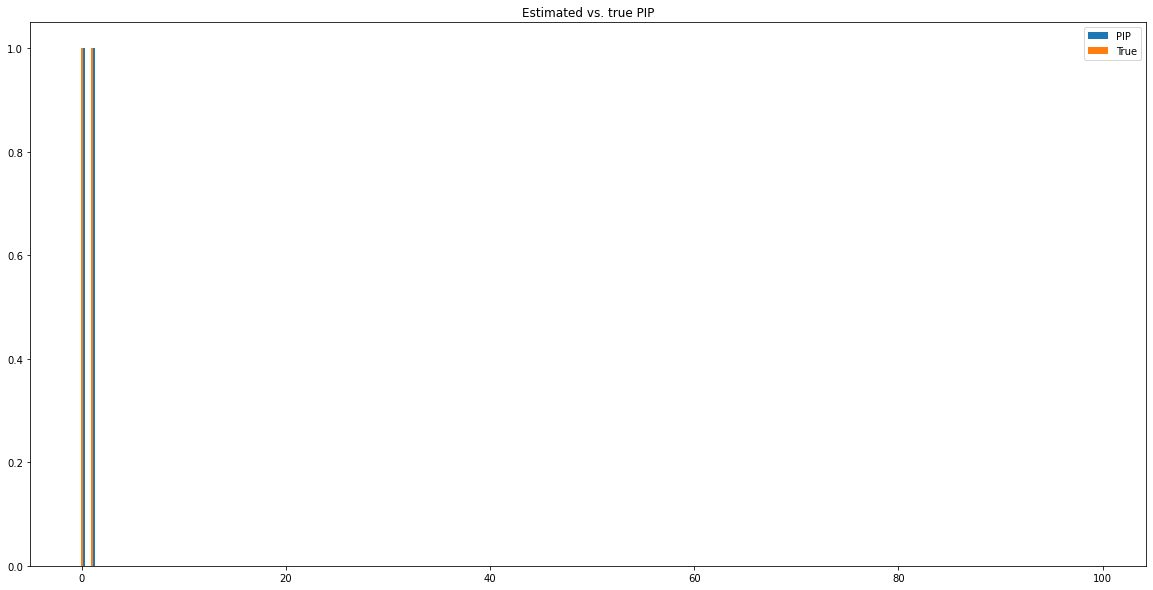

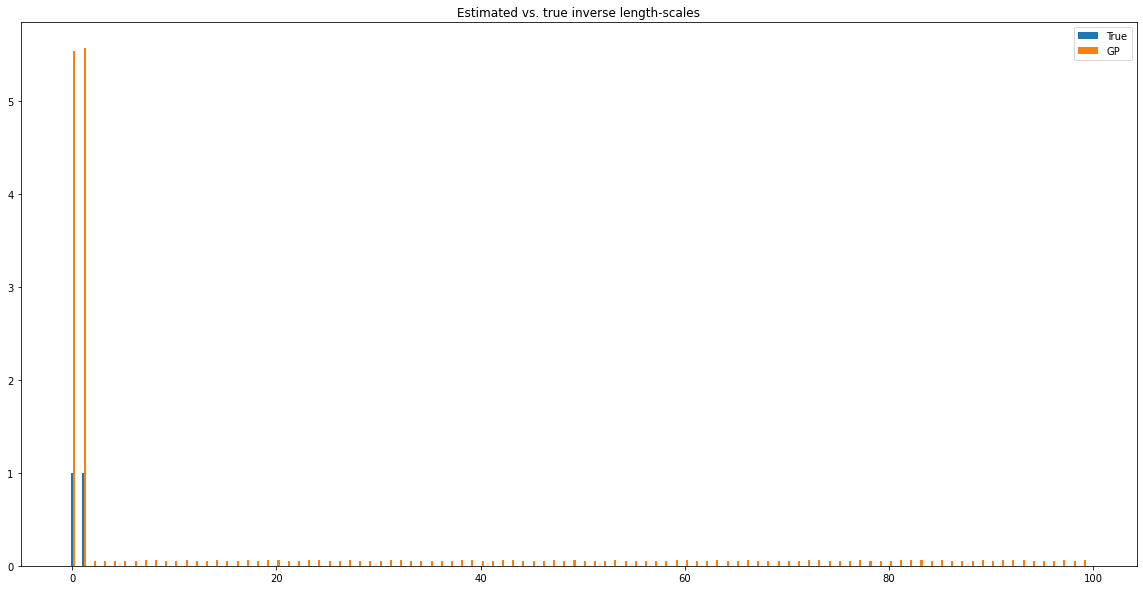

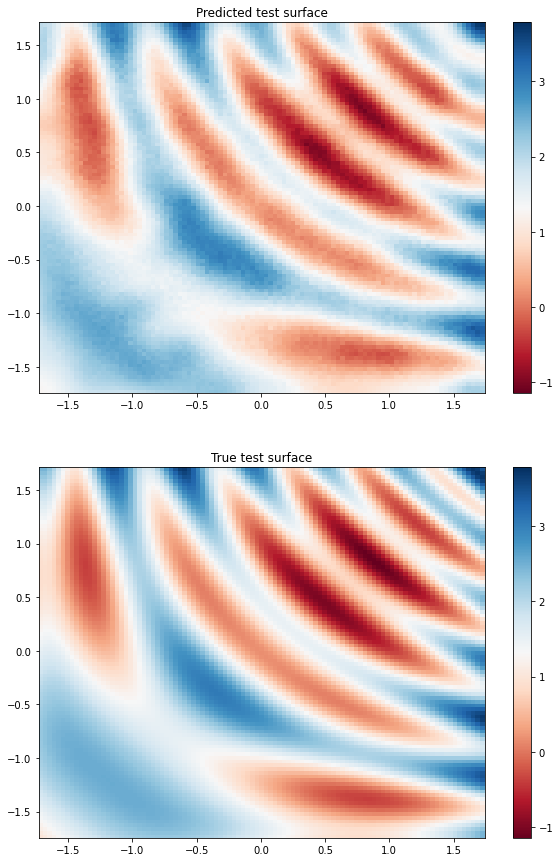

Latent test function MSE :  0.020458166
Observed test data  MSE :  0.32044396


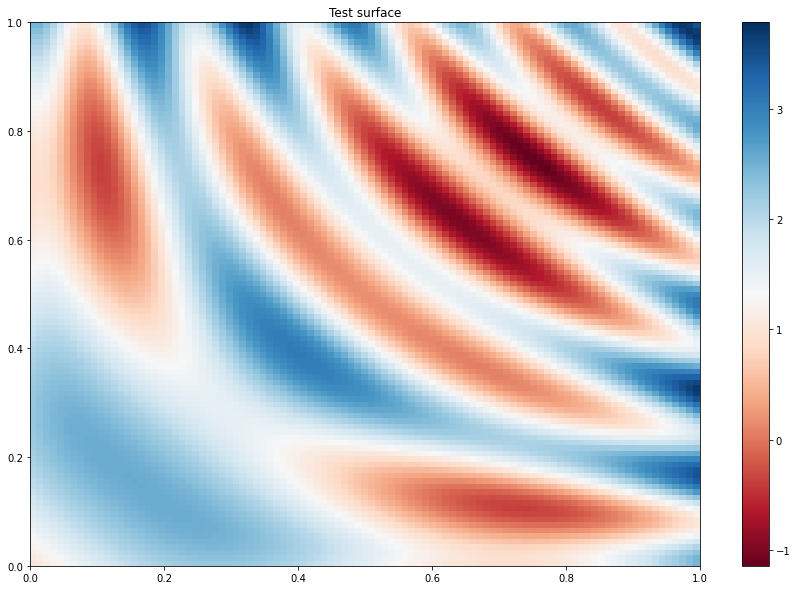

[0.74405897 0.74343497 0.7436219  0.74394476 0.7423275  0.7440546
 0.74300164 0.7439629  0.7443485  0.74433625]
3.224512815475464 0.09730805
Iter 2 - Loss: 3.225
[0.7912051  0.78694266 0.78652114 0.78856075 0.78357327 0.79108876
 0.785237   0.79140425 0.7948936  0.7947735 ]
3.2212564134597774 0.0750999
Iter 3 - Loss: 2.899
[0.83993644 0.83662254 0.83556587 0.83815205 0.83187723 0.84100044
 0.8331396  0.8392347  0.845695   0.84549016]
3.215325461244583 0.07362049
Iter 4 - Loss: 2.628
[0.88342106 0.875538   0.87553823 0.8910986  0.8700494  0.88196963
 0.87187684 0.8797552  0.8972216  0.8956245 ]
3.2072683808722493 0.05697932
Iter 5 - Loss: 2.410
[0.9313319  0.9191807  0.92064005 0.93936616 0.9127131  0.92709124
 0.91518784 0.9241587  0.95254946 0.9499866 ]
3.197441287750325 0.057041865
Iter 6 - Loss: 2.225
[0.984761   0.9687935  0.9718541  0.9928263  0.9614252  0.9778334
 0.96439755 0.9744015  1.0117859  1.0084364 ]
3.1862440860620915 0.057379853
Iter 7 - Loss: 2.078
[1.0427492 1.0236645

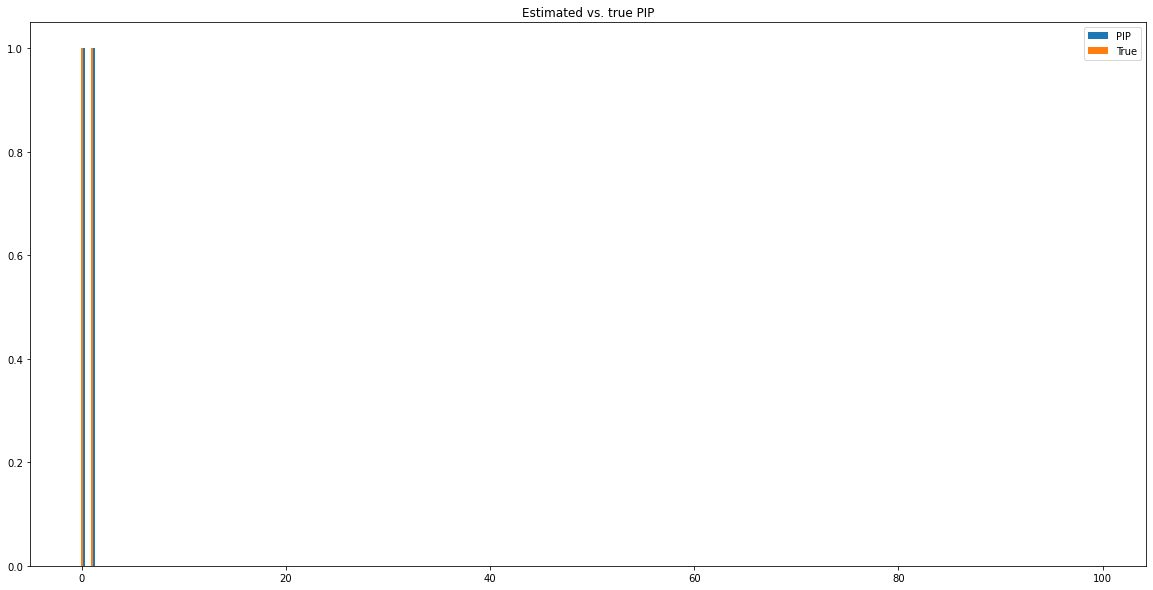

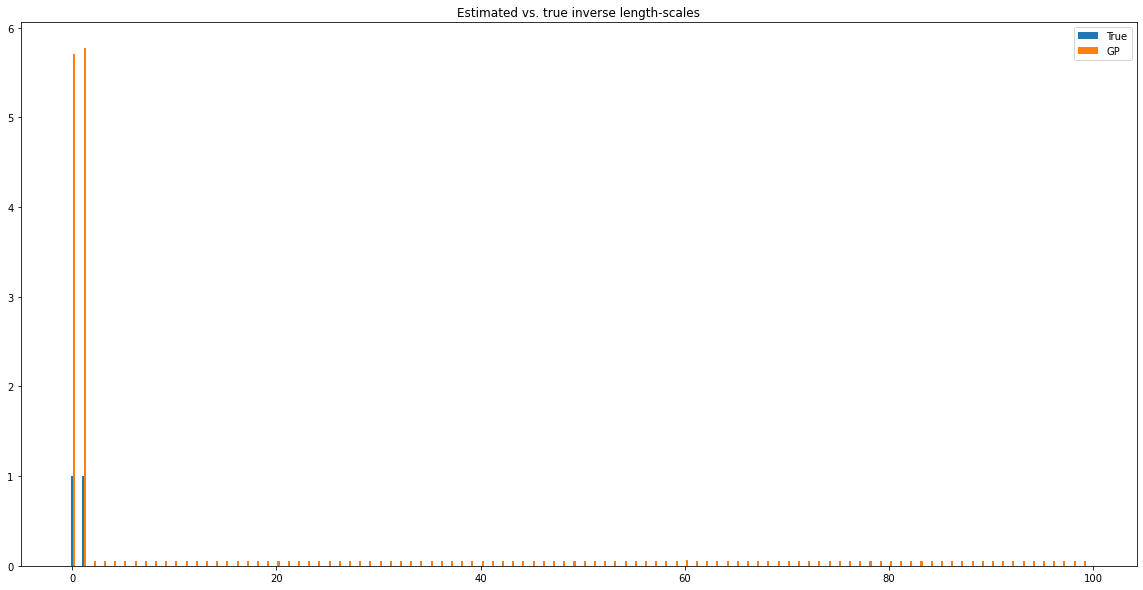

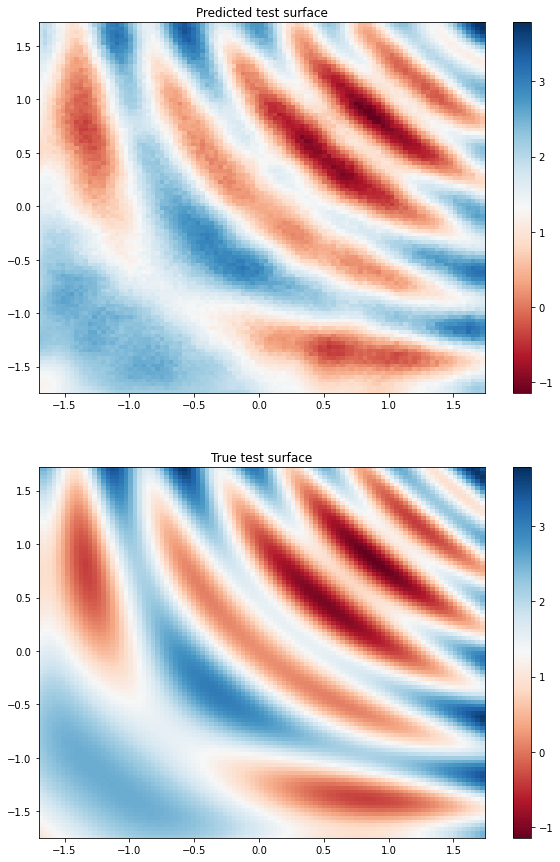

Latent test function MSE :  0.018527053
Observed test data  MSE :  0.31649986


[0.7010719  0.701738   0.70225596 0.70361465 0.7012543  0.70175046
 0.700346   0.7018821  0.708017   0.70847946]
2.932114601135254 0.019892162


[0.72862506 0.7325927  0.73311967 0.7378833  0.7345275  0.7266276
 0.73387736 0.729302   0.7373956  0.73956674]
2.929465970993042 0.061777137


[0.77201873 0.7841601  0.7744339  0.79243624 0.78131014 0.76883155
 0.7863232  0.77153283 0.7744657  0.7771091 ]
2.9253012303352355 0.08215886


[0.83727896 0.8545301  0.83891    0.86578035 0.8483992  0.83813894
 0.85774136 0.8370962  0.8310576  0.8326347 ]
2.9193566286764145 0.10229326


[0.91644937 0.9314151  0.9200502  0.943632   0.93478656 0.9125563
 0.94192904 0.9189822  0.8983956  0.90245795]
2.911854475315371 0.09903789


[0.99519825 1.0096027  1.0043739  1.0208961  1.0234485  0.98875886
 1.0267682  1.0073543  0.97276413 0.98000264]
2.903113855004509 0.08496542


[1.078498  1.0849539 1.0930754 1.1030263 1.105723  1.0677328 1.1139389
 1.09564   1.0575602 1.066072 ]
2.8940730199708518 0.07311425


[1.1699011 1.1707432 1.1948609 1.1927682 1.1990753 1.1499394 1.2045867
 1.1884859 1.1544464 1.1481471]
2.884207626227442 0.068937786


[1.2725921 1.279316  1.3139608 1.30145   1.3086561 1.250285  1.3076909
 1.3016037 1.2544185 1.2330782]
2.8744077319338563 0.06815202


[1.4041536 1.4148474 1.4498454 1.4336909 1.4428645 1.3667455 1.431425
 1.4331324 1.3649219 1.3210179]
2.8634037397394874 0.06709997


[1.5526592 1.5612863 1.5903591 1.5807297 1.592763  1.4982971 1.5677488
 1.5801327 1.4794638 1.4212426]
2.8524793104200956 0.061457973


[1.7098925 1.7165072 1.7304381 1.7446754 1.7489492 1.646341  1.7032851
 1.7365534 1.6111151 1.5276787]
2.8408806437959973 0.055980176


[1.8782089 1.8812511 1.8863889 1.9297402 1.9224494 1.8179936 1.8500906
 1.911301  1.7479069 1.6492078]
2.82942301209406 0.0516163


[2.0575855 2.0578575 2.0577073 2.1251326 2.1099787 2.0012996 2.0100431
 2.0909004 1.8903906 1.8012304]
2.817582658468481 0.045790207


[2.2447207 2.243092  2.236825  2.3257716 2.3042202 2.1961467 2.1868339
 2.280941  2.044866  1.9667722]
2.805416162633308 0.0414263


[2.4284923 2.4205794 2.4221046 2.5246725 2.504391  2.3968806 2.3723707
 2.472934  2.206204  2.1406991]
2.793574907844438 0.03614732


[2.595024  2.5878224 2.610631  2.7223687 2.7014003 2.5981674 2.5628698
 2.669612  2.3752549 2.3231554]
2.781584648172579 0.031213954


[2.7125733 2.698129  2.788828  2.9077601 2.8860638 2.7866588 2.7499294
 2.8551292 2.5398853 2.4943607]
2.7694843852537043 0.025580227


[2.7161045 2.6861093 2.952468  3.0710053 3.0535977 2.949573  2.9200246
 3.0273178 2.6919506 2.6416805]
2.7574869729654985 0.019753166


[2.5753577 2.5161068 3.094391  3.2033367 3.1887472 3.0802987 3.0596898
 3.1667137 2.821601  2.7654815]
2.7452405152918127 0.0152670825


[2.3488941 2.2753942 3.2069046 3.3047345 3.306914  3.1994157 3.175518
 3.2816439 2.9170141 2.8686223]
2.7330920759458555 0.012080636


[2.096893  2.022972  3.311265  3.4004765 3.4105468 3.3014035 3.2811372
 3.382927  3.0072615 2.9637523]
2.7210546305758774 0.010557554


[1.8439108 1.7674128 3.4136672 3.4992902 3.5101352 3.402612  3.3791933
 3.4826252 3.09905   3.0572531]
2.709167160518288 0.010239215


[1.5994215 1.5230017 3.5253403 3.6066058 3.6194978 3.5118797 3.484523
 3.5921943 3.1993678 3.162657 ]
2.697231120216892 0.010698009


[1.367883  1.2919453 3.6603434 3.737425  3.747475  3.633864  3.6035388
 3.7235503 3.3196938 3.285118 ]
2.685046724959776 0.0121682


[1.1590647 1.0821018 3.8084788 3.8914936 3.895244  3.783323  3.7404108
 3.8683786 3.4664838 3.422051 ]
2.6730687752959326 0.01342538


[0.9722099 0.9002044 3.9735134 4.06612   4.059456  3.9505584 3.8950937
 4.0369544 3.628689  3.577457 ]
2.6610097398600203 0.014754328


[0.8262018  0.76113117 4.152542   4.2468185  4.2368164  4.1230054
 4.0594893  4.2101316  3.8025403  3.7516851 ]
2.6485674149929297 0.014657245


[0.7395169 0.6799517 4.3207226 4.426612  4.4063425 4.2944417 4.2230353
 4.380798  3.9745898 3.9171395]
2.6361202678548716 0.0127113275


[0.68813807 0.63647276 4.476084   4.591974   4.566239   4.450833
 4.3747535  4.537924   4.134123   4.0683146 ]
2.624073088432625 0.010348621


[0.6583246  0.62060434 4.6233883  4.7406588  4.7083073  4.596071
 4.5129747  4.681676   4.278302   4.2089143 ]
2.6118811305986065 0.008136117


[0.63865316 0.6037743  4.7452884  4.8760114  4.8335767  4.724772
 4.6366334  4.810023   4.4040203  4.333815  ]
2.599283183540896 0.006835167


[0.61758435 0.5912532  4.852401   4.990441   4.9426684  4.833215
 4.746648   4.923186   4.5136504  4.443086  ]
2.586956408100064 0.0058180187


[0.59537655 0.573786   4.9492936  5.0997357  5.042971   4.9363265
 4.8451777  5.0245595  4.611487   4.5433598 ]
2.5746386347333274 0.0053809644


[0.5687655 0.5554872 5.039529  5.1982574 5.1377716 5.030935  4.9397054
 5.1238427 4.6976953 4.633728 ]
2.5623955793319624 0.005170536


[0.54909134 0.5367261  5.124336   5.288919   5.2257442  5.1190095
 5.028882   5.220531   4.782361   4.7209034 ]
2.5502019387947614 0.004724667


[0.53086734 0.5148273  5.210706   5.380229   5.31349    5.204517
 5.116724   5.3102446  4.8664308  4.803956  ]
2.5380554856700126 0.0047136755


[0.5076491  0.49610323 5.289684   5.466889   5.3983974  5.289172
 5.198061   5.3938637  4.9479012  4.8867197 ]
2.5262485892796516 0.004605399


[0.48346093 0.47725338 5.368892   5.549416   5.476491   5.3713956
 5.2778964  5.480058   5.021124   4.963602  ]
2.5145115238141775 0.0046413667


[0.4668531  0.45064938 5.447254   5.631499   5.559899   5.448534
 5.357404   5.56406    5.096495   5.0438766 ]
2.50248558877852 0.0047695194


[0.4465814 0.43906   5.528119  5.7142224 5.641919  5.5293074 5.4386816
 5.650086  5.1705103 5.123497 ]
2.490444412662158 0.004258586


[0.4249801  0.42346907 5.606654   5.7962575  5.722124   5.6090536
 5.5176353  5.732398   5.247132   5.200959  ]
2.478968937918776 0.004586217


[0.40882716 0.4049109  5.6868577  5.8793426  5.8056564  5.690813
 5.5980797  5.817588   5.3261113  5.280317  ]
2.4674526831785655 0.0045589684


[0.3915926  0.38682014 5.770711   5.962045   5.8878593  5.768717
 5.677362   5.903097   5.4037433  5.358198  ]
2.4559160750574884 0.0047145085


[0.36922157 0.37279993 5.850929   6.0431113  5.9698005  5.848723
 5.7565417  5.9877534  5.482564   5.4364376 ]
2.444542806412016 0.0049371226


[0.35117579 0.35840297 5.937102   6.1280627  6.0550427  5.931538
 5.841619   6.073981   5.5613503  5.5150065 ]
2.433235955093883 0.0048941565


[0.33659256 0.34320617 6.0219913  6.2134314  6.14422    6.014009
 5.926598   6.1626787  5.644114   5.5962477 ]
2.4216703978538874 0.0048861597


[0.32054585 0.33100554 6.1091027  6.298664   6.2315183  6.0980883
 6.0131197  6.251969   5.7266293  5.6780457 ]
2.410437545308149 0.0049083615


[0.2989233 0.3145846 6.196916  6.3884954 6.3211107 6.185823  6.0974717
 6.3397655 5.8136992 5.7620273]
2.399223399080226 0.00616772


[0.28750396 0.30171406 6.2920375  6.480047   6.4132123  6.2776275
 6.1901345  6.43229    5.9066896  5.8495226 ]
2.387940534748848 0.005054327


[0.27021375 0.28780937 6.3874764  6.5731487  6.507079   6.367053
 6.28117    6.527534   6.000243   5.9347897 ]
2.376893015216026 0.0061313184


[0.2548215  0.27009237 6.486233   6.6664615  6.6027055  6.4613886
 6.3764253  6.6219597  6.0952325  6.0227103 ]
2.3657604879092484 0.006836202


[0.24469422 0.25791165 6.5883546  6.7650657  6.702733   6.5579834
 6.4721813  6.7215447  6.1958756  6.114143  ]
2.3544489671480453 0.005704569


[0.22725202 0.24213366 6.6895957  6.865761   6.8053713  6.6539674
 6.570447   6.823776   6.2970085  6.2069864 ]
2.343382659792391 0.007950422


[0.22271784 0.23508245 6.794671   6.968161   6.9095454  6.7554927
 6.6737514  6.926069   6.400223   6.302668  ]
2.3319021751553737 0.0044254125


[0.21463986 0.22271875 6.8996367  7.072632   7.0135975  6.8566713
 6.7757845  7.031102   6.5043335  6.3977947 ]
2.3208375143180504 0.006281153


[0.20846245 0.21574079 7.005488   7.176788   7.1185055  6.9561863
 6.878904   7.133043   6.6081285  6.4940524 ]
2.3097301051515853 0.0049872906


[0.20232318 0.20916426 7.112373   7.2793994  7.2228975  7.057227
 6.9806905  7.2364225  6.710855   6.5885525 ]
2.2986252645893424 0.004988466


[0.19586456 0.20325185 7.214268   7.3816223  7.325637   7.155175
 7.0800605  7.3359194  6.8118205  6.6819315 ]
2.2877554441333903 0.0050004106


[0.19412729 0.19748475 7.3160634  7.4837823  7.4294944  7.251644
 7.1802497  7.4355426  6.9102864  6.77424   ]
2.276739614545572 0.0038135843


[0.19026159 0.19453338 7.414565   7.58068    7.5271125  7.3457685
 7.275141   7.531064   7.0058303  6.8638635 ]
2.2657785025893404 0.003613548


[0.18807228 0.19177523 7.5098553  7.677474   7.6251683  7.437683
 7.368597   7.6258845  7.0984087  6.950282  ]
2.254648065128144 0.003074409


[0.18621501 0.18730858 7.6027193  7.7702074  7.7202773  7.528066
 7.4605165  7.718151   7.191376   7.035652  ]
2.24337143997613 0.0034038485


[0.18444577 0.18788962 7.694968   7.8627105  7.813692   7.6147494
 7.549911   7.8075213  7.280516   7.1201596 ]
2.2322889616813337 0.002240982


[0.18155077 0.18548734 7.785841   7.952323   7.9058104  7.701136
 7.6366367  7.8934245  7.3668885  7.2015905 ]
2.221260965090872 0.0030356324


[0.18003608 0.18389925 7.8727846  8.041993   7.9952717  7.7852306
 7.721625   7.977788   7.453545   7.27988   ]
2.210378471235099 0.0023481185


[0.17780295 0.18053186 7.9573174  8.1289625  8.082912   7.8661733
 7.805532   8.0605545  7.5372252  7.35896   ]
2.1995809235050934 0.00307498


[0.17720102 0.18247917 8.040818   8.214217   8.168926   7.9465933
 7.8884807  8.141562   7.618174   7.4351244 ]
2.1887102806862107 0.00209093


[0.17743026 0.1805302  8.123382   8.29837    8.252789   8.024463
 7.969252   8.220198   7.6976485  7.5083404 ]
2.1778488319568785 0.0019244814


[0.17822586 0.1784719  8.203669   8.380801   8.335282   8.1008005
 8.048      8.298624   7.775719   7.581096  ]
2.166938525819622 0.002097658


[0.17570572 0.17793052 8.284002   8.462258   8.41865    8.175558
 8.125797   8.375953   7.8518243  7.653573  ]
2.1563816386063936 0.0021503575


[0.17669603 0.17802402 8.361613   8.540159   8.500265   8.250098
 8.202962   8.452574   7.9272513  7.7242336 ]
2.145758775713448 0.0014783925


[0.17453809 0.17728181 8.439838   8.617869   8.5805235  8.324785
 8.278663   8.527158   8.002056   7.79735   ]
2.135298541748504 0.0020317605


[0.1781716  0.17624936 8.518216   8.697552   8.661564   8.39747
 8.355242   8.602112   8.07702    7.8678617 ]
2.124793008017878 0.002567637


[0.17446427 0.17667809 8.59258    8.774811   8.736737   8.465895
 8.426748   8.6735325  8.148404   7.935993  ]
2.1141911314903266 0.0023416474


[0.17564203 0.17589703 8.668206   8.850744   8.81529    8.537218
 8.499292   8.7479105  8.221611   8.004223  ]
2.1034873834559105 0.0016514128


[0.17304307 0.17825618 8.74102    8.924368   8.891038   8.60584
 8.571325   8.817385   8.292002   8.070219  ]
2.0932908012664013 0.0025722026


[0.17504689 0.17340416 8.815078   9.002862   8.967041   8.674991
 8.645382   8.890247   8.363641   8.13977   ]
2.0828224983467396 0.0031900334


[0.17485958 0.17697158 8.886632   9.076425   9.042592   8.743135
 8.71663    8.958333   8.431535   8.20578   ]
2.0725502726422946 0.0021378922


[0.17565447 0.17201653 8.95869    9.150555   9.115019   8.809737
 8.786239   9.028252   8.501561   8.270411  ]
2.062289559783273 0.0027834382


[0.17282873 0.17579503 9.027102   9.221897   9.188292   8.875019
 8.855196   9.096741   8.57035    8.334171  ]
2.052371583285248 0.0030509012


[0.17396241 0.17741075 9.0978985  9.293805   9.260231   8.942295
 8.923535   9.163993   8.637122   8.398927  ]
2.0425878555410035 0.001739856


[0.17487673 0.17592584 9.166536   9.36511    9.33304    9.008286
 8.991403   9.229017   8.702481   8.461708  ]
2.032461281709333 0.0016032179


[0.1741385  0.17662607 9.232506   9.433102   9.403101   9.07023
 9.058022   9.294939   8.767038   8.523817  ]
2.0224670872405515 0.0012652078


[0.17368269 0.17663848 9.302316   9.502773   9.4743395  9.133076
 9.122972   9.362041   8.831969   8.586144  ]
2.0126215889316987 0.00093652005


[0.17423892 0.17461896 9.3697605  9.570816   9.543243   9.195016
 9.188327   9.423961   8.893032   8.644566  ]
2.0026957185585865 0.0015894116


[0.17384942 0.1759423  9.434185   9.636978   9.612919   9.258908
 9.254086   9.487806   8.956457   8.702971  ]
1.9927811864618832 0.0013028234


[0.17281394 0.17482272 9.498344   9.701899   9.678619   9.31859
 9.316637   9.549138   9.017547   8.762895  ]
1.983286088821126 0.0014210218


[0.1739313 0.1736703 9.564535  9.768098  9.746878  9.379414  9.380623
 9.6132345 9.081845  8.824229 ]
1.9737488979654159 0.0014645042


[0.17270784 0.17612717 9.626632   9.833868   9.813726   9.435805
 9.441686   9.674044   9.140549   8.8811455 ]
1.9644150194536725 0.0018923739


[0.17364973 0.1734894  9.6889     9.896698   9.878551   9.492766
 9.500588   9.733211   9.201922   8.9369    ]
1.9551745381395984 0.0018378417


[0.17458095 0.17611624 9.749414   9.961346   9.942051   9.550462
 9.562148   9.791904   9.261501   8.993629  ]
1.9457136445419547 0.0018134633


[ 0.17197388  0.17285858  9.812631   10.02442    10.004821    9.610907
  9.622525    9.850877    9.319997    9.05028   ]
1.9366148691023184 0.002573632


[ 0.17430428  0.17545718  9.872839   10.087418   10.0683365   9.66654
  9.6821165   9.908961    9.378688    9.104639  ]
1.9276211302318518 0.0022573888


[ 0.17347613  0.17355974  9.932599   10.149122   10.129488    9.721823
  9.741587    9.965977    9.436194    9.157713  ]
1.9186123602022687 0.0014993456


[ 0.17348498  0.17494416  9.992386   10.207433   10.191672    9.777305
  9.798357   10.024009    9.491423    9.211753  ]
1.9095957593625446 0.0010470233


[ 0.17320496  0.17386691 10.047821   10.266025   10.25429     9.8302355
  9.854725   10.080313    9.547774    9.264432  ]
1.9008156610866986 0.0010198033


[ 0.17339666  0.1725696  10.103226   10.326315   10.313849    9.881952
  9.909886   10.1358795   9.602044    9.317788  ]
1.892125485718965 0.0010602791


[ 0.17227006  0.17525747 10.162119   10.384565   10.373672    9.933899
  9.96501    10.189916    9.655934    9.36796   ]
1.8835302944947405 0.0018064695


[ 0.17527361  0.17427222 10.223183   10.4429035  10.433665    9.987837
 10.021575   10.245406    9.711059    9.422086  ]
1.8747911457627446 0.00186694


[ 0.17365046  0.17390722 10.279457   10.501403   10.491619   10.041137
 10.075684   10.299382    9.763578    9.472161  ]
1.866407646374438 0.0011806748


[ 0.17349266  0.17412809 10.331718   10.555747   10.548001   10.090771
 10.129717   10.352642    9.815536    9.521398  ]
1.8576169565321687 0.00063421426


[ 0.17067143  0.17427993 10.386856   10.611146   10.606215   10.138082
 10.182983   10.405989    9.868311    9.570529  ]
1.849472175583409 0.0015060556


[ 0.17452435  0.17427924 10.44149    10.666343   10.662097   10.189214
 10.236296   10.456979    9.920269    9.620216  ]
1.8411090430018455 0.0017867893


[ 0.1719962   0.17465046 10.493467   10.720333   10.716785   10.23566
 10.289552   10.506904    9.97192     9.669186  ]
1.832976933303791 0.0014432316


[ 0.17498891  0.17179602 10.546887   10.777257   10.772973   10.286911
 10.341902   10.561256   10.021963    9.718433  ]
1.8249149700239147 0.002432785


[ 0.17166273  0.17601179 10.598419   10.829503   10.827622   10.335348
 10.391153   10.61152    10.071844    9.76455   ]
1.8171248321168123 0.0029584651


[ 0.17412373  0.17362423 10.6492405  10.883591   10.882755   10.382073
 10.442703   10.662537   10.122084    9.814518  ]
1.8084347676821722 0.0020633598


[ 0.17267422  0.1733403  10.702059   10.935233   10.936957   10.430212
 10.493801   10.711822   10.170721    9.8615    ]
1.8002682538104346 0.0010204657


[ 0.17368649  0.17290053 10.751234   10.987696   10.989425   10.476661
 10.54378    10.760201   10.217855    9.906652  ]
1.7920800035357047 0.00091606774


[ 0.17413881  0.17275316 10.802142   11.040468   11.043148   10.522014
 10.594445   10.810604   10.266787    9.954393  ]
1.7845793137260253 0.0006320399


[ 0.17338966  0.17312075 10.852038   11.092849   11.095393   10.568276
 10.642316   10.8612385  10.314454    9.99943   ]
1.7768501704548691 0.00079091964


[ 0.17274515  0.17480093 10.898843   11.14166    11.145611   10.612476
 10.69053    10.909171   10.359812   10.044493  ]
1.768868620292221 0.0011789543


[ 0.17387798  0.17402771 10.950042   11.19221    11.198807   10.660916
 10.73957    10.958729   10.407252   10.091024  ]
1.761239997689839 0.0010486676


[ 0.17284925  0.17317079 10.998858   11.242129   11.250303   10.70467
 10.786306   11.005911   10.453763   10.132357  ]
1.7538657587999766 0.0010203512


[ 0.17360038  0.1733994  11.046346   11.291492   11.301735   10.751114
 10.835381   11.055924   10.501856   10.178023  ]
1.7461186613850115 0.0007270502


[ 0.17250681  0.17390652 11.095405   11.341883   11.352862   10.796931
 10.882474   11.102564   10.548531   10.221367  ]
1.7389822449833348 0.00092238135


[ 0.17335038  0.17381135 11.142472   11.389621   11.403146   10.83987
 10.929403   11.148465   10.594091   10.265864  ]
1.7313375244622122 0.0006942526


[ 0.17302543  0.17150433 11.1886425  11.437109   11.452346   10.883886
 10.976719   11.194163   10.638931   10.30914   ]
1.7240544760608518 0.0012635188


[ 0.17444986  0.17459138 11.235653   11.487267   11.500173   10.928955
 11.024271   11.240252   10.682661   10.353519  ]
1.7168328247805442 0.0018707082


[ 0.17201725  0.1727174  11.280104   11.535244   11.549366   10.971182
 11.071196   11.285006   10.728804   10.39736   ]
1.7096467337525492 0.0017989816


[ 0.17456873  0.17375135 11.329271   11.582119   11.598687   11.014813
 11.118114   11.332691   10.7756605  10.439799  ]
1.7021421337427136 0.0015633517


[ 0.17170544  0.17340711 11.371383   11.628469   11.646756   11.056091
 11.161969   11.3764305  10.817522   10.480877  ]
1.6952537642775398 0.0014139524


[ 0.17483479  0.17470545 11.417255   11.675199   11.696202   11.098421
 11.206701   11.421518   10.860123   10.523087  ]
1.6883033127973315 0.0018250444


[ 0.17429397  0.17338835 11.459938   11.72141    11.743128   11.139626
 11.251068   11.465308   10.903696   10.562995  ]
1.6815606605287332 0.0009513207


[ 0.17252964  0.17303021 11.508823   11.769599   11.791026   11.1806555
 11.295611   11.51046    10.9467325  10.603231  ]
1.674572055018264 0.0010472907


[ 0.17330706  0.17431642 11.552036   11.813878   11.838899   11.221375
 11.340195   11.553492   10.990886   10.646347  ]
1.668285914889529 0.0010201349


[ 0.17329994  0.17368095 11.596198   11.861927   11.88455    11.263098
 11.383733   11.594962   11.032429   10.687174  ]
1.6617075367224605 0.00054108875


[ 0.17439559  0.17481619 11.639837   11.9061165  11.932072   11.302605
 11.427276   11.640147   11.076262   10.727928  ]
1.6546805137214926 0.001059356


[ 0.17207755  0.17403239 11.684594   11.95342    11.977945   11.344126
 11.470264   11.6833315  11.1185465  10.769532  ]
1.6478803089737584 0.0013527396


[ 0.17473952  0.17415173 11.726987   11.998599   12.025709   11.383906
 11.513514   11.727544   11.16045    10.808645  ]
1.641014865454524 0.0012422217


[ 0.17073923  0.17248325 11.767748   12.042513   12.071555   11.425308
 11.55647    11.771052   11.201937   10.846805  ]
1.6343043260796115 0.0022058743


[ 0.17473884  0.17428152 11.81049    12.086838   12.116681   11.464612
 11.598363   11.81372    11.243851   10.886148  ]
1.628052066653273 0.0022489482


[ 0.1729665   0.17375377 11.852511   12.130137   12.161663   11.504131
 11.641621   11.856769   11.283725   10.927053  ]
1.6214973574682159 0.0010614526


[ 0.17390943  0.17357607 11.894845   12.173621   12.206171   11.543141
 11.682973   11.899454   11.324053   10.965518  ]
1.615383127664133 0.00067025557


[ 0.1747163   0.17376599 11.938751   12.217869   12.252021   11.5856695
 11.727647   11.942634   11.365546   11.006139  ]
1.6092690348041634 0.0006333214


[ 0.17252904  0.17354968 11.978453   12.260989   12.2971945  11.623908
 11.767871   11.983935   11.405956   11.044513  ]
1.6031115351337646 0.0010872544


[ 0.17356376  0.17411695 12.0218935  12.303389   12.340843   11.662228
 11.809266   12.024128   11.446557   11.083186  ]
1.5969146193301944 0.00082350493


[ 0.17300448  0.17443444 12.062467   12.345592   12.385466   11.703215
 11.851439   12.067036   11.486257   11.12124   ]
1.5906950656795407 0.00058064656


[ 0.17383839  0.172495   12.100139   12.390221   12.428521   11.737488
 11.89181    12.107035   11.5246     11.158815  ]
1.5849555420857335 0.0012008828


[ 0.17422095  0.17446803 12.14326    12.431992   12.474148   11.775639
 11.933194   12.150896   11.5647135  11.196989  ]
1.5790749701958744 0.0010652704


[ 0.17368881  0.17377931 12.184028   12.475815   12.518973   11.81472
 11.973318   12.190352   11.604392   11.236041  ]
1.5731137076984674 0.00067879463


[ 0.17363338  0.17342788 12.2241     12.516412   12.56226    11.854811
 12.015543   12.231698   11.645241   11.274559  ]
1.5672729356260222 0.00041250995


[ 0.17423075  0.17417805 12.267276   12.558973   12.607008   11.888977
 12.05593    12.271193   11.681752   11.312683  ]
1.562027188910982 0.0007154201


[ 0.17330503  0.17415121 12.306775   12.601108   12.647882   11.926545
 12.096479   12.310627   11.719289   11.348815  ]
1.5561141485434786 0.00058239786


[ 0.17394426  0.17470102 12.349421   12.640848   12.692267   11.964259
 12.1383505  12.352046   11.758473   11.386313  ]
1.5502895300902322 0.000660761


[ 0.17315646  0.17389494 12.389573   12.681201   12.736057   12.000545
 12.179472   12.393389   11.794914   11.421899  ]
1.544382607684952 0.0007895534


[ 0.17461689  0.17436752 12.427292   12.72452    12.778045   12.040491
 12.220163   12.434128   11.834472   11.460433  ]
1.539105737794397 0.0009007236


[ 0.17367351  0.17434645 12.4660425  12.765322   12.821257   12.073737
 12.258707   12.472895   11.872245   11.497906  ]
1.5336124346088056 0.00057417795


[ 0.1747101   0.17437288 12.508187   12.806625   12.862925   12.109935
 12.298675   12.512105   11.910128   11.533901  ]
1.5279434481239693 0.00060373574


[ 0.17358279  0.17436214 12.5455265  12.846178   12.905882   12.148699
 12.338481   12.552176   11.948144   11.569023  ]
1.5226255710310352 0.0006250925


[ 0.17380156  0.17527929 12.5853815  12.888761   12.947733   12.183993
 12.378397   12.592083   11.985142   11.607522  ]
1.5169382328622287 0.00062325277


[ 0.17397495  0.17480326 12.625198   12.928349   12.989668   12.218943
 12.416992   12.629383   12.023494   11.643529  ]
1.5112624369546193 0.00045755395


[ 0.17465125  0.17410243 12.664235   12.966646   13.030712   12.253979
 12.457446   12.668283   12.06048    11.679025  ]
1.5062468835174612 0.0007004038


[ 0.1724589   0.17334345 12.7001095  13.006761   13.071329   12.292455
 12.497498   12.708075   12.097202   11.714638  ]
1.5009657514666495 0.0012161458


[ 0.17378595  0.17334937 12.740154   13.046369   13.113061   12.326378
 12.537756   12.747921   12.135995   11.750147  ]
1.4957360884397453 0.0006902252


[ 0.17456402  0.17501831 12.779092   13.084226   13.153683   12.3616905
 12.575332   12.783747   12.170755   11.789081  ]
1.4902015882969633 0.0010409162


[ 0.17422664  0.17403324 12.817842   13.123032   13.195967   12.395155
 12.612143   12.82321    12.20936    11.82227   ]
1.4849910778461226 0.0006683866


[ 0.17374057  0.17327268 12.854763   13.163009   13.237681   12.428893
 12.650495   12.863211   12.246411   11.859791  ]
1.4795338374606515 0.00064537773


[ 0.17506617  0.17557786 12.892599   13.201519   13.27811    12.4635
 12.690389   12.900082   12.28193    11.893523  ]
1.4747170378376473 0.0014222962


[ 0.17494458  0.17383198 12.928562   13.240987   13.318008   12.49693
 12.72739    12.940074   12.317124   11.926982  ]
1.4695766389283869 0.00083644496


[ 0.17339545  0.17339025 12.965748   13.275898   13.359469   12.529811
 12.763773   12.974302   12.352104   11.962817  ]
1.4646440406356454 0.00088087836


[ 0.17391276  0.17417938 13.002425   13.315991   13.399514   12.563399
 12.800557   13.012582   12.386832   11.997589  ]
1.4599201338606136 0.00065628305


[ 0.17377664  0.17595202 13.038063   13.352537   13.438908   12.59788
 12.840717   13.050922   12.422701   12.032812  ]
1.454958544030377 0.00084777887


[ 0.17407164  0.17433915 13.075806   13.393517   13.480137   12.631837
 12.877154   13.090154   12.458254   12.069197  ]
1.450306637680573 0.0008431524


[ 0.17444903  0.17509596 13.114503   13.433315   13.5229435  12.666402
 12.915955   13.129362   12.492989   12.10645   ]
1.4455695569118683 0.00059534376


[ 0.17471986  0.1722375  13.151638   13.471016   13.56148    12.701679
 12.952028   13.168103   12.527616   12.140073  ]
1.4409253539050437 0.0012507567


[ 0.17481546  0.17526916 13.191278   13.512897   13.601689   12.732805
 12.989697   13.20555    12.565425   12.174877  ]
1.4365806283544271 0.0012509082


[ 0.17330801  0.17453596 13.228103   13.549204   13.641702   12.769395
 13.028726   13.241626   12.6004095  12.207879  ]
1.4316548292806606 0.0009518138


[ 0.17528403  0.17415738 13.26763    13.588556   13.680508   12.805184
 13.066139   13.278375   12.634484   12.243893  ]
1.4272029462577056 0.0009858664


[ 0.17301328  0.17367873 13.303329   13.627872   13.720474   12.837442
 13.104419   13.314851   12.669139   12.277755  ]
1.4225190975755393 0.0011178132


[ 0.1741996   0.17417662 13.3402     13.662522   13.758897   12.868826
 13.139814   13.352229   12.702326   12.311855  ]
1.4182812090223074 0.0007622599


[ 0.17419855  0.17434965 13.37436    13.700097   13.798554   12.906845
 13.176917   13.390461   12.739839   12.3480215 ]
1.414026075636346 0.00026622324


[ 0.17504917  0.17343317 13.409663   13.736978   13.8399725  12.940579
 13.214188   13.428741   12.7754965  12.382004  ]
1.4095008928523947 0.0007875408


[ 0.17482987  0.1736976  13.44824    13.773541   13.879442   12.969699
 13.249247   13.4653225  12.809319   12.414259  ]
1.405390194789273 0.00036120423


[ 0.17531537  0.17504482 13.484184   13.810289   13.917156   13.002767
 13.288912   13.500911   12.843064   12.450093  ]
1.4014311512493547 0.0008036925


[ 0.17458096  0.17499761 13.520533   13.846821   13.955943   13.034653
 13.323628   13.539046   12.879071   12.481641  ]
1.3973727615060032 0.0004535094


[ 0.17404622  0.17432374 13.556369   13.883334   13.99301    13.069961
 13.359563   13.574418   12.913045   12.516185  ]
1.3931877235042855 0.000592824


[ 0.17535396  0.17404376 13.59261    13.919405   14.032905   13.101233
 13.397273   13.611591   12.946522   12.5504465 ]
1.3888420982433485 0.000716211


[ 0.17319904  0.1741967  13.626005   13.957499   14.069767   13.1358795
 13.43351    13.648103   12.981962   12.583433  ]
1.384394030773679 0.00095313735


[ 0.17538743  0.17429166 13.662021   13.992987   14.109627   13.167003
 13.469646   13.683354   13.014879   12.617685  ]
1.3802413086036833 0.00094773027


[ 0.17474014  0.17380907 13.697718   14.03144    14.147062   13.199448
 13.503905   13.72101    13.049436   12.651949  ]
1.376115392500221 0.0005597268


[ 0.17444399  0.17530918 13.73539    14.071579   14.18659    13.232043
 13.540899   13.757228   13.085035   12.685519  ]
1.372117384021996 0.0007847399


[ 0.17371914  0.17529386 13.769546   14.105824   14.225439   13.266248
 13.577647   13.79144    13.118055   12.718806  ]
1.368080614912573 0.00042946846


[ 0.175212    0.17467009 13.807272   14.143374   14.261684   13.30066
 13.612942   13.827923   13.152985   12.752094  ]
1.3642804969539075 0.0008835499


[ 0.17394057  0.17446935 13.841512   14.179423   14.298271   13.330197
 13.648277   13.864531   13.185303   12.784326  ]
1.3603009609081278 0.00066645665


[ 0.17512424  0.17485057 13.875562   14.215506   14.337656   13.361141
 13.683989   13.899831   13.217545   12.816362  ]
1.3562831387341967 0.00070113107


[ 0.17469963  0.17403138 13.910385   14.251493   14.375296   13.393999
 13.720716   13.935583   13.25419    12.851116  ]
1.3525982608762126 0.0005910911


[ 0.17493747  0.17496811 13.94508    14.286883   14.415212   13.425422
 13.754849   13.971117   13.287002   12.88171   ]
1.3490124542775823 0.000567084


[ 0.17341457  0.17583226 13.980665   14.323417   14.451807   13.454782
 13.789722   14.0080185  13.322025   12.915287  ]
1.3455112277736705 0.00096098246


[ 0.17567123  0.1742531  14.016099   14.3568325  14.48876    13.486289
 13.823966   14.044735   13.355024   12.946019  ]
1.3415867736218112 0.0014331366


[ 0.17426176  0.17486444 14.050702   14.395512   14.52741    13.518075
 13.861323   14.080248   13.388173   12.979969  ]
1.3379873670910756 0.0008436487


[ 0.1742239   0.17585872 14.085147   14.43154    14.565685   13.550322
 13.89784    14.115526   13.422591   13.012599  ]
1.3345986582236697 0.00051304774


[ 0.1754657  0.1748816 14.122161  14.46706   14.604271  13.580211
 13.931345  14.149447  13.457665  13.046893 ]
1.3303967960301277 0.0008983651


[ 0.17666392  0.17537934 14.155465   14.5027     14.641274   13.616726
 13.966372   14.187652   13.490393   13.080427  ]
1.3265893977033103 0.00072699354


[ 0.17467421  0.17419617 14.191734   14.5377035  14.680402   13.646825
 14.001086   14.222343   13.5227165  13.112801  ]
1.3228642797406052 0.0012044458


[ 0.17647524  0.17468761 14.227972   14.57616    14.717233   13.679696
 14.038041   14.258948   13.554775   13.144626  ]
1.3193230451520461 0.00092378096


[ 0.17423297  0.17450358 14.260924   14.609897   14.755715   13.711001
 14.073986   14.293972   13.58781    13.176485  ]
1.3159103241724188 0.00095700583


[ 0.1762691   0.17472814 14.295907   14.644916   14.793928   13.744665
 14.110195   14.330114   13.622101   13.208676  ]
1.3124690745960466 0.00090846757


[ 0.17432041  0.17524658 14.330872   14.679763   14.830083   13.773968
 14.145088   14.365197   13.65372    13.240442  ]
1.3088560239219549 0.00097034225


[ 0.17532074  0.17455418 14.366277   14.715995   14.868079   13.803017
 14.179049   14.399468   13.684251   13.273558  ]
1.3054625447975041 0.000723719


[ 0.17632191  0.17527182 14.401356   14.750042   14.9052     13.835522
 14.214374   14.434909   13.716506   13.3044615 ]
1.3017860116385 0.0007248472


[ 0.17434432  0.17588772 14.434559   14.787449   14.9438095  13.869624
 14.248397   14.469403   13.749971   13.33582   ]
1.2982303090099843 0.0010086902


[ 0.1757808   0.17468478 14.466121   14.821551   14.981459   13.900067
 14.283466   14.505881   13.781145   13.367846  ]
1.2946414821676717 0.001024648


[ 0.1750771   0.17537484 14.501872   14.852979   15.018427   13.929809
 14.318996   14.539924   13.815328   13.399536  ]
1.291470845401186 0.0006153208


[ 0.17411368  0.17550343 14.536549   14.890033   15.053727   13.964183
 14.353502   14.574744   13.848748   13.43087   ]
1.2883211331181719 0.0005234469


[ 0.17492704  0.17638141 14.569352   14.923931   15.089306   13.991565
 14.387912   14.608171   13.878724   13.463483  ]
1.2846505539662505 0.00070949213


[ 0.17589726  0.17414223 14.605299   14.959467   15.126283   14.021499
 14.4248085  14.642976   13.911978   13.495051  ]
1.2816020166949824 0.0012045787


[ 0.17557518  0.1744591  14.63909    14.996478   15.164672   14.0501585
 14.45678    14.680966   13.946355   13.526316  ]
1.2788531387761863 0.00036926105


[ 0.17603491  0.1735377  14.67291    15.029727   15.199862   14.084927
 14.492421   14.715064   13.975867   13.556695  ]
1.275682430750775 0.00061055855


[ 0.17344913  0.17547797 14.705854   15.063733   15.236411   14.114051
 14.529445   14.749474   14.007761   13.5890875 ]
1.2725795198219827 0.0016426631


[ 0.17583297  0.17565587 14.741522   15.098434   15.273083   14.14651
 14.561728   14.782381   14.040192   13.620705  ]
1.2697196356306903 0.0009946887


[ 0.17514889  0.17576377 14.777362   15.13332    15.30942    14.176272
 14.595631   14.818189   14.073428   13.652367  ]
1.2668694317670592 0.00041222415


[ 0.17514825  0.1760543  14.810405   15.1661005  15.346381   14.2045555
 14.629921   14.852867   14.103362   13.684958  ]
1.263800318214159 0.0002490571


[ 0.17482336  0.1753139  14.843536   15.201065   15.382839   14.235757
 14.662607   14.883185   14.135829   13.715596  ]
1.2610276866169097 0.0004974178


[ 0.17572235  0.17549634 14.8771715  15.236233   15.419874   14.26434
 14.697952   14.919976   14.168649   13.748271  ]
1.2578958434789587 0.00050609274


[ 0.17493626  0.17553556 14.908402   15.270988   15.455059   14.293325
 14.730786   14.954229   14.200609   13.779554  ]
1.2551912944813488 0.00041607098


[ 0.1754364   0.17472765 14.93971    15.305854   15.492062   14.324875
 14.764621   14.988961   14.233144   13.809092  ]
1.2522905560818234 0.00057679584


[ 0.17567845  0.17416425 14.973166   15.338079   15.528586   14.353916
 14.799542   15.02418    14.264523   13.839023  ]
1.2494269974591383 0.00041282712


[ 0.17736731  0.17511901 15.007965   15.371889   15.56605    14.383322
 14.832917   15.055811   14.295934   13.870651  ]
1.2466479972885478 0.0010031825


[ 0.17551827  0.17456762 15.041479   15.406622   15.602233   14.413955
 14.865672   15.092336   14.326723   13.899348  ]
1.2439037966258888 0.0009231456


[ 0.17604668  0.17470607 15.073739   15.441727   15.63845    14.444266
 14.899269   15.124853   14.3589115  13.931575  ]
1.2411616106283951 0.00036218585


[ 0.17621933  0.17608975 15.106918   15.474561   15.674962   14.477257
 14.931247   15.160872   14.3896055  13.961982  ]
1.2380030565319227 0.00065217575


[ 0.17611901  0.17584722 15.139383   15.511145   15.710555   14.507541
 14.967175   15.197709   14.422032   13.996091  ]
1.2357318270930835 0.00026019686


[ 0.17451802  0.17537701 15.172768   15.543218   15.745849   14.532791
 14.999965   15.229764   14.452452   14.027053  ]
1.2328786089064574 0.0008157403


[ 0.17616956  0.17410266 15.205054   15.575871   15.781157   14.567943
 15.034864   15.265632   14.48271    14.057921  ]
1.2303522137504295 0.0010978234


[ 0.1759407   0.17620355 15.238953   15.611048   15.816688   14.592828
 15.066621   15.299384   14.51447    14.089989  ]
1.227924592358317 0.0009035334


[ 0.17641601  0.1762346  15.271216   15.642941   15.854706   14.622652
 15.099718   15.330804   14.546567   14.120265  ]
1.2255026851016497 0.00030333205


[ 0.17588645  0.17377704 15.303783   15.675374   15.889559   14.651288
 15.133897   15.366197   14.576752   14.153256  ]
1.2227552648761904 0.0011139109


[ 0.17603761  0.17418413 15.337066   15.708587   15.927465   14.680922
 15.167846   15.40056    14.608073   14.182957  ]
1.2201411129251367 0.00032503158


[ 0.17646717  0.17643431 15.366672   15.743282   15.962298   14.712804
 15.202251   15.433882   14.640591   14.213192  ]
1.2176671017411445 0.0010107642


[ 0.17577145  0.17522876 15.400351   15.778411   15.998253   14.741952
 15.235763   15.4688225  14.672672   14.246506  ]
1.2149038751235668 0.000753987


[ 0.17619053  0.17685597 15.435097   15.811402   16.03538    14.771443
 15.269493   15.503673   14.703558   14.276675  ]
1.2121065995015654 0.0008011447


[ 0.17574936  0.17507161 15.468667   15.847784   16.070581   14.801726
 15.300402   15.535518   14.732213   14.303892  ]
1.2096428973981512 0.00085726404


[ 0.17621844  0.17515332 15.5010605  15.878164   16.106      14.830119
 15.3353405  15.571606   14.763364   14.335719  ]
1.2071436286443158 0.00031646172


[ 0.1761258   0.17540026 15.533045   15.911684   16.141596   14.860899
 15.366206   15.602159   14.794821   14.366592  ]
1.204977260040139 0.000244755


[ 0.1760802   0.17555435 15.565181   15.946481   16.176865   14.892386
 15.401401   15.637076   14.824203   14.396412  ]
1.2023953365751363 0.00020094417


[ 0.17603613  0.17596434 15.595312   15.980127   16.21394    14.922766
 15.435943   15.672463   14.85607    14.429216  ]
1.1998827848626747 0.00028306033


[ 0.17475128  0.17471518 15.630825   16.015394   16.248665   14.952041
 15.468362   15.706419   14.888044   14.463278  ]
1.1977566701030373 0.00096065755


[ 0.17580394  0.1761683  15.663396   16.050457   16.28608    14.983457
 15.500585   15.740073   14.918125   14.49184   ]
1.1951945296562794 0.00095109583


[ 0.17676419  0.17565067 15.696866   16.085533   16.321686   15.012543
 15.534636   15.7743845  14.949169   14.522993  ]
1.1931725477100126 0.0006105565


[ 0.17693493  0.17626803 15.729491   16.117445   16.3565     15.042772
 15.568916   15.809553   14.980691   14.552421  ]
1.1913514746796594 0.0003872232


[ 0.17658299  0.17561693 15.762335   16.151      16.391209   15.071061
 15.602851   15.8397255  15.011723   14.583081  ]
1.1886774755950562 0.00045495573


[ 0.17531683  0.17678691 15.795488   16.183315   16.427996   15.100434
 15.635629   15.874226   15.043406   14.615673  ]
1.1862694576244983 0.0009170122


[ 0.17621037  0.17612174 15.827827   16.215641   16.462982   15.128789
 15.669269   15.906293   15.07474    14.649361  ]
1.1837432429505208 0.0006346479


[ 0.176188    0.17642626 15.857608   16.249336   16.499477   15.156442
 15.7030735  15.941581   15.105864   14.681197  ]
1.1816701468685955 0.00023607542


[ 0.17585868  0.17533459 15.889509   16.281267   16.53468    15.187418
 15.737378   15.976165   15.136988   14.710143  ]
1.1790226693045192 0.00058883504


[ 0.17673366  0.17594486 15.919479   16.315483   16.569824   15.217556
 15.769584   16.00904    15.167166   14.740846  ]
1.176744733566064 0.00060829776


[ 0.17629808  0.17615576 15.954893   16.34767    16.606361   15.247093
 15.803432   16.044258   15.196706   14.77155   ]
1.1743903747905078 0.00033742643


[ 0.17770322  0.17500281 15.988681   16.384563   16.638899   15.276851
 15.836135   16.076694   15.2262335  14.800779  ]
1.1723454121541674 0.0009509963


[ 0.17684115  0.1760005  16.021324   16.416447   16.675505   15.3032055
 15.867867   16.109442   15.257031   14.832117  ]
1.1701708408746898 0.0007252201


[ 0.17750017  0.17637119 16.054821   16.450071   16.710226   15.329975
 15.901676   16.142223   15.288183   14.860889  ]
1.1679814925619207 0.00045546037


[ 0.17583945  0.17501765 16.087725   16.482372   16.746254   15.362245
 15.934684   16.17435    15.322243   14.892249  ]
1.1656483886758446 0.0010973782


[ 0.17717168  0.17558104 16.119173   16.51408    16.781393   15.392895
 15.968034   16.208004   15.351396   14.922655  ]
1.163513869577523 0.0007340347


[ 0.17629632  0.17609239 16.149473   16.546604   16.815714   15.421489
 15.999836   16.241383   15.380635   14.9541445 ]
1.1613857706671329 0.0005696049


[ 0.17749515  0.17567165 16.181963   16.57901    16.850714   15.449373
 16.03094    16.275572   15.411892   14.98362   ]
1.1593845995945253 0.00064097886


[ 0.17502421  0.17762978 16.214773   16.610352   16.886501   15.47805
 16.065298   16.307716   15.443786   15.01181   ]
1.1571150264695975 0.0015474616


[ 0.17645672  0.17533608 16.248314   16.644161   16.919636   15.504957
 16.098637   16.340841   15.473422   15.042921  ]
1.15516987315219 0.0013202722


[ 0.17691875  0.17660096 16.280727   16.677393   16.954935   15.53744
 16.13246    16.375364   15.503898   15.071019  ]
1.153434561716391 0.0006814727


[ 0.17684129  0.17801277 16.312086   16.712585   16.991016   15.567878
 16.16558    16.408607   15.5346775  15.100467  ]
1.1512999651398308 0.0005942829


[ 0.17706524  0.17547639 16.344868   16.743702   17.02799    15.592525
 16.19811    16.4403     15.565128   15.130924  ]
1.1492743166675554 0.0010050499


[ 0.17599021  0.17655045 16.376034   16.774853   17.060986   15.621758
 16.231838   16.474213   15.597845   15.161216  ]
1.1474669927027308 0.0008108484


[ 0.17713293  0.17655285 16.409218   16.808334   17.095778   15.648697
 16.26427    16.506065   15.626149   15.191765  ]
1.145575373980385 0.00048826277


[ 0.17711075  0.17662667 16.438728   16.840769   17.130907   15.681805
 16.298141   16.540161   15.658392   15.222014  ]
1.143556933320415 0.00015086253


[ 0.17597283  0.17613599 16.471712   16.873743   17.166584   15.709408
 16.329811   16.575422   15.689012   15.251455  ]
1.1417106706993614 0.00064156024


[ 0.17825608  0.1759925  16.503729   16.907822   17.202555   15.735453
 16.361498   16.60792    15.719128   15.284661  ]
1.1397340313500033 0.0008942154


[ 0.17603862  0.17644984 16.53604    16.942472   17.240309   15.769395
 16.396759   16.641325   15.751485   15.314839  ]
1.137764262333195 0.0009755118


[ 0.17675857  0.17670645 16.56791    16.975256   17.274107   15.801118
 16.429955   16.67466    15.781493   15.343984  ]
1.135467749737634 0.00043044813


[ 0.17649966  0.17679876 16.598671   17.006924   17.309418   15.831041
 16.464443   16.707352   15.812361   15.375033  ]
1.1331254018186574 0.00023336589


[ 0.17720151  0.17542781 16.631468   17.03997    17.34441    15.857858
 16.496506   16.737732   15.84099    15.404765  ]
1.1311524394264472 0.00078068906


[ 0.17731445  0.17665805 16.663912   17.072952   17.379332   15.885063
 16.530943   16.771202   15.870824   15.43423   ]
1.1292458794792042 0.0005521139


[ 0.17657165  0.17569776 16.698423   17.10394    17.414392   15.91205
 16.563711   16.803938   15.90063    15.464285  ]
1.1274634228206426 0.0006586592


[ 0.17703837  0.17717977 16.725513   17.139141   17.448547   15.937457
 16.596653   16.837194   15.933385   15.49455   ]
1.1258290304537797 0.000740134


[ 0.17653246  0.1768342  16.756014   17.167662   17.484095   15.966415
 16.628033   16.87143    15.960642   15.524821  ]
1.1238064959504428 0.00038581106


[ 0.1774128  0.1759548 16.789528  17.201218  17.518534  15.996302
 16.663712  16.906874  15.991712  15.557215 ]
1.12220853218532 0.0006800461


[ 0.17653511  0.17609487 16.821665   17.235085   17.55411    16.026194
 16.695526   16.9395     16.020882   15.586211  ]
1.1201728673041405 0.00043617826


[ 0.17713562  0.17681366 16.853323   17.269522   17.587946   16.053017
 16.72808    16.971457   16.052391   15.616257  ]
1.1186435348141128 0.0005365153


[ 0.17714147  0.17687353 16.885412   17.30057    17.626495   16.081451
 16.760933   17.004099   16.080673   15.646607  ]
1.116515698341971 0.00013190765


[ 0.17689668  0.17599073 16.9178     17.335314   17.659435   16.114084
 16.792953   17.037874   16.111496   15.677168  ]
1.1147517495208592 0.00047580604


[ 0.17617364  0.17823389 16.951345   17.367527   17.693037   16.143358
 16.824366   17.071356   16.143167   15.708456  ]
1.1130666261439595 0.0010591376


[ 0.17708819  0.1773299  16.981674   17.397814   17.728687   16.169146
 16.857483   17.10459    16.173185   15.737727  ]
1.1113478682706577 0.00068939134


[ 0.17737174  0.17622456 17.013489   17.429775   17.764439   16.1968
 16.891771   17.136648   16.204313   15.768296  ]
1.1100181755271679 0.000555833


[ 0.17804393  0.17667751 17.045938   17.462984   17.800707   16.227203
 16.923502   17.171234   16.233685   15.797695  ]
1.108307142722473 0.00046864394


[ 0.1777267   0.17714815 17.076548   17.496496   17.834503   16.257206
 16.954794   17.204504   16.261232   15.826759  ]
1.1067894896578658 0.00035945087


[ 0.17730288  0.1775816  17.10807    17.52884    17.86819    16.283184
 16.988482   17.238739   16.291399   15.856492  ]
1.1054563880666841 0.00038199677


[ 0.17753169  0.17570865 17.142296   17.560635   17.90487    16.309755
 17.022806   17.27109    16.32197    15.885745  ]
1.1041690525509615 0.0007811425


[ 0.17657453  0.17602469 17.173416   17.590733   17.939972   16.339357
 17.055117   17.30314    16.34855    15.915741  ]
1.1025458305007938 0.0005161502


[ 0.17837782  0.1762934  17.203487   17.624022   17.974009   16.370024
 17.085855   17.334444   16.380817   15.944113  ]
1.1009685833888705 0.0007680391


[ 0.17710301  0.17754197 17.23905    17.65762    18.009422   16.398144
 17.116709   17.367771   16.411232   15.974984  ]
1.0992321554065825 0.0009099638


[ 0.1763164   0.17609668 17.270828   17.691828   18.043888   16.42428
 17.149818   17.399702   16.440348   16.004438  ]
1.0981970663277973 0.0008209872


[ 0.17848527  0.17733696 17.302832   17.724043   18.078638   16.45347
 17.18132    17.434729   16.470045   16.035711  ]
1.096797425652999 0.0011927192


[ 0.17686619  0.17888165 17.332922   17.754776   18.11288    16.482101
 17.213953   17.466057   16.499926   16.06714   ]
1.0950385412716903 0.0011049632


[ 0.17710826  0.17627993 17.365082   17.787611   18.148052   16.508783
 17.245735   17.497215   16.528698   16.095364  ]
1.0936478760175503 0.0010066305


[ 0.17757523  0.17747995 17.397596   17.820856   18.18135    16.536541
 17.278452   17.528282   16.559618   16.12572   ]
1.0920857392220964 0.0006394568


[ 0.17871673  0.17687427 17.429403   17.854074   18.216755   16.566
 17.310373   17.561987   16.588615   16.154484  ]
1.0905582311197695 0.0006553754


[ 0.17675409  0.17679286 17.461401   17.884342   18.250069   16.594088
 17.345232   17.595665   16.618052   16.186682  ]
1.0892092641612023 0.000752078


[ 0.17621243  0.17735544 17.491457   17.918976   18.284718   16.621517
 17.376934   17.625498   16.64928    16.213772  ]
1.0877433695252665 0.00045783885


[ 0.1771335   0.17684026 17.519936   17.950788   18.319754   16.653898
 17.410479   17.657862   16.675905   16.243345  ]
1.086162148026364 0.00055950857


[ 0.17847568  0.17702223 17.5508     17.982843   18.354254   16.68187
 17.44285    17.692272   16.707104   16.272614  ]
1.085031733440021 0.0005870577


[ 0.17727368  0.17678143 17.582087   18.015999   18.387735   16.711111
 17.47717    17.723969   16.733967   16.304092  ]
1.08317876346051 0.00055895
Runtime is  942.0338590145111
Test MSE: 0.3188856840133667
Latent test function MSE :  [0.0190853  0.02045817 0.02142649 0.         0.        ]
Test time is :  [0.68217564 0.65078378 0.71843767 0.         0.        ]


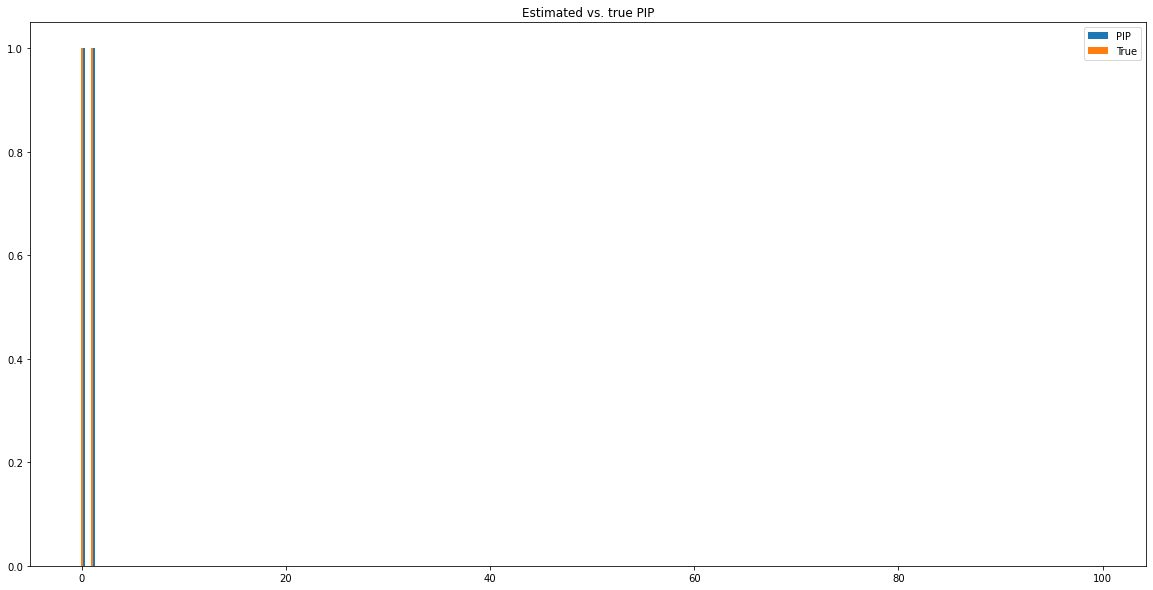

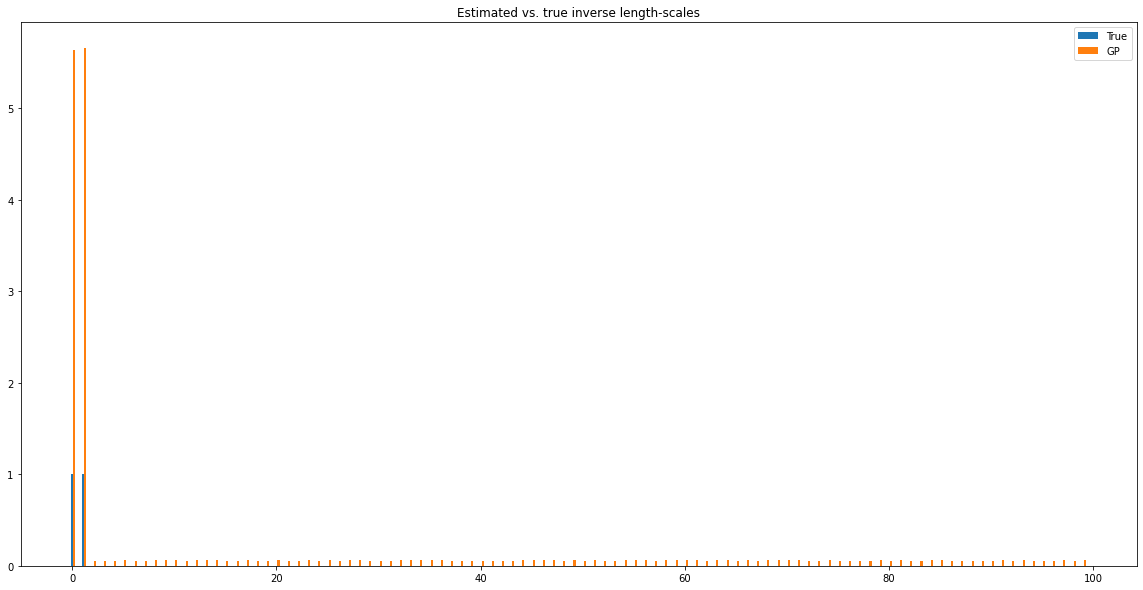

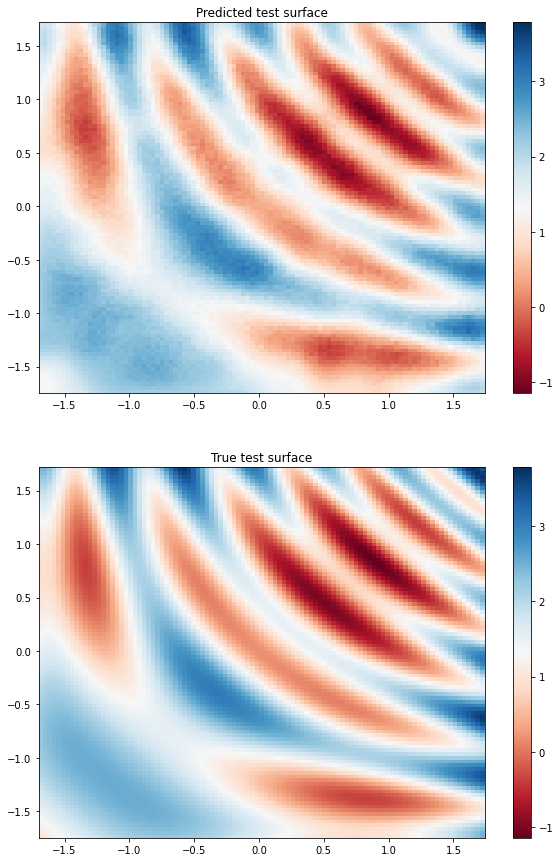

Latent test function MSE :  0.021426493
Observed test data  MSE :  0.31888568


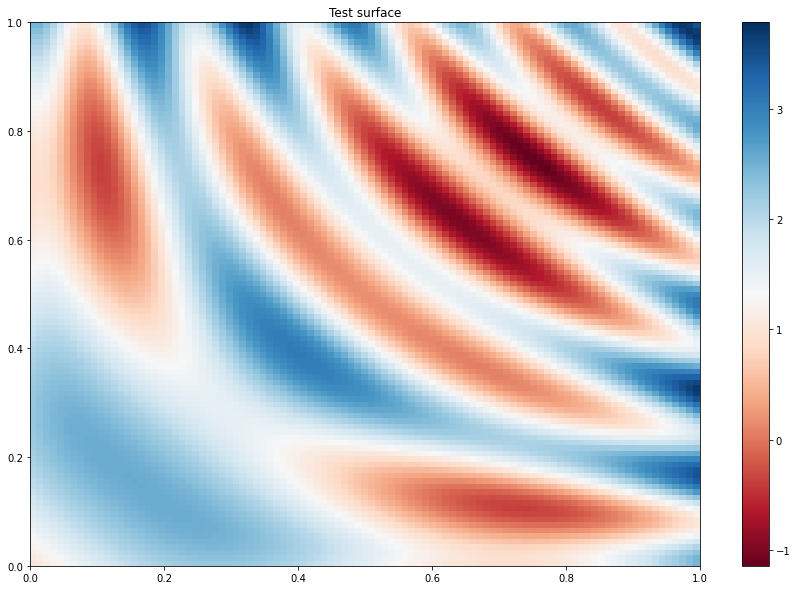

[0.74435884 0.7441335  0.74427676 0.7442993  0.7439345  0.7442645
 0.74429184 0.7443189  0.74434566 0.7443565 ]
3.201571464538574 0.09896874
Iter 2 - Loss: 3.202
[0.79631925 0.78990334 0.7904894  0.791761   0.7891067  0.79376924
 0.79108673 0.79407775 0.7926866  0.7938648 ]
3.198345229625702 0.080535345
Iter 3 - Loss: 2.879
[0.8506748  0.84014314 0.8408802  0.84404206 0.83967596 0.8469635
 0.84236383 0.8473906  0.8443605  0.84664714]
3.1924735422372814 0.07743759
Iter 4 - Loss: 2.611
[0.9031015  0.8834916  0.8887271  0.8918412  0.8796781  0.89159054
 0.89110374 0.89722556 0.896931   0.89964324]
3.1845007378146644 0.062135335
Iter 5 - Loss: 2.395
[0.95800734 0.92986476 0.9405143  0.94210666 0.92315865 0.93900275
 0.94277805 0.9508054  0.9531012  0.95555484]
3.174777500818445 0.059255406
Iter 6 - Loss: 2.212
[1.0162694  0.981205   0.9963232  0.99586517 0.971161   0.9912283
 0.998264   1.0083325  1.0128561  1.0148323 ]
3.1637054374420357 0.057600994
Iter 7 - Loss: 2.068
[1.0778471 1.03737

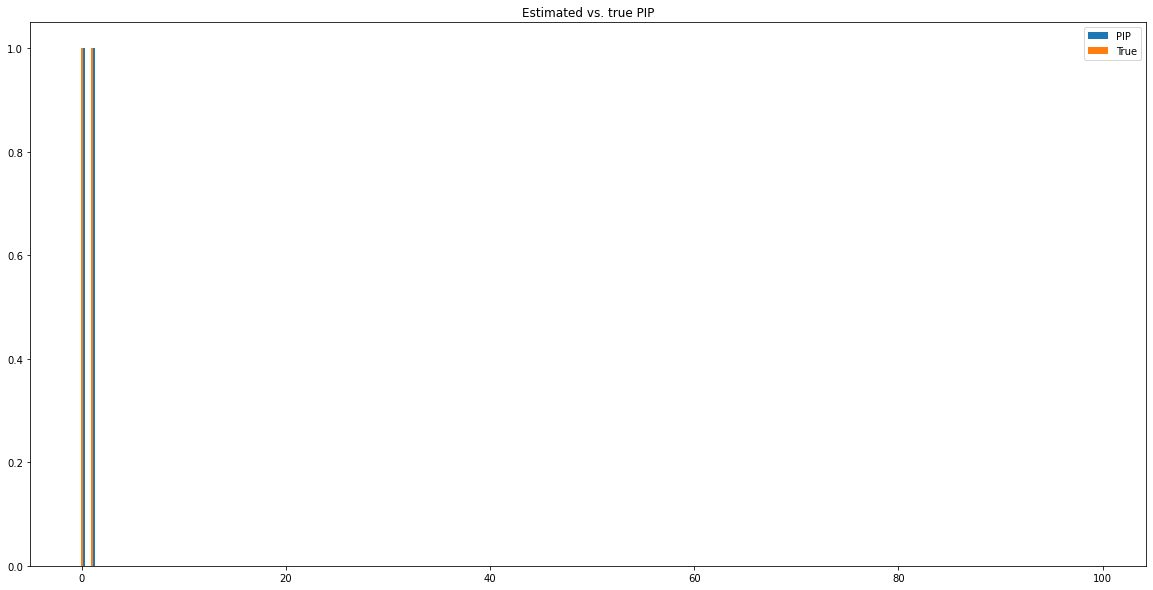

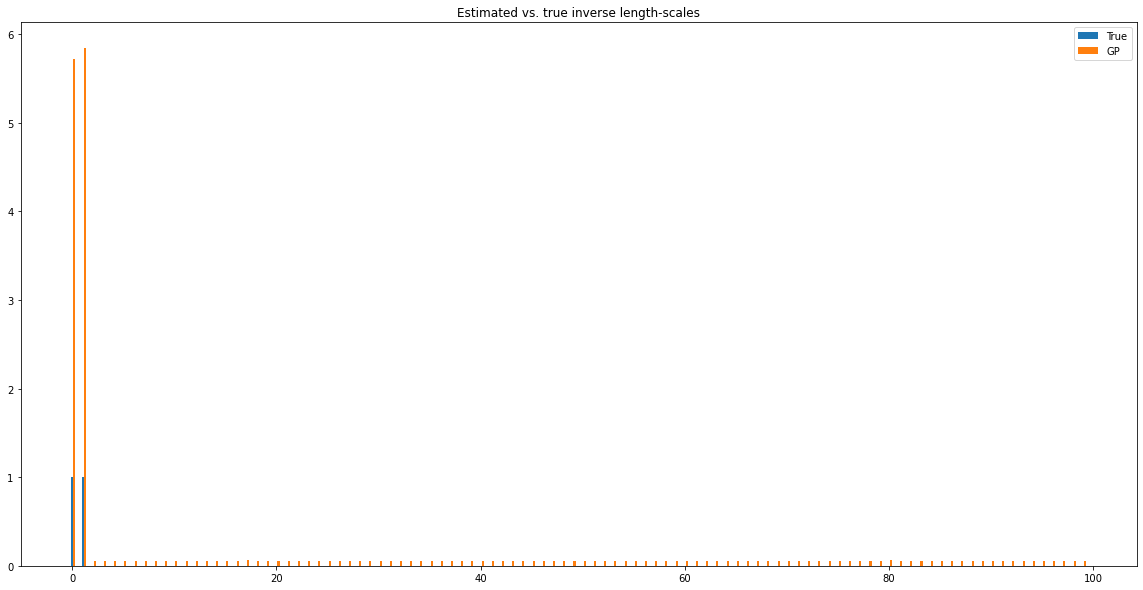

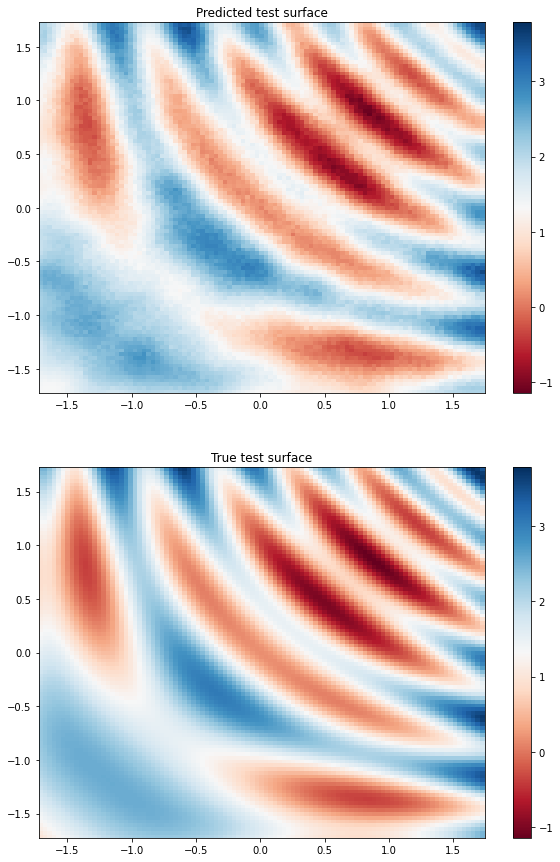

Latent test function MSE :  0.017489767
Observed test data  MSE :  0.31946176


[0.7265612  0.72961915 0.71950686 0.72505486 0.7219355  0.7276092
 0.7364454  0.72963417 0.7285759  0.72854656]
2.950589895248413 0.06604078


[0.7699671  0.7741223  0.7484112  0.75676674 0.75675887 0.76594585
 0.7853827  0.7640076  0.75318193 0.75396836]
2.9474462723731993 0.06574463


[0.821252   0.8314634  0.7935983  0.792428   0.8090286  0.8209304
 0.84167796 0.81580555 0.7843543  0.7904278 ]
2.9420876057386396 0.08131191


[0.88948905 0.9022661  0.852249   0.85590017 0.87981373 0.89436287
 0.9134854  0.8817251  0.8301688  0.84284973]
2.9355408179686067 0.09262082


[0.9632352  0.9802462  0.915539   0.92897487 0.958126   0.96992314
 0.98733675 0.95213556 0.8807425  0.9017272 ]
2.9284262726352948 0.08551653


[1.0361392  1.0541562  0.9773769  1.0010499  1.0329415  1.0432458
 1.0594559  1.0196837  0.92648286 0.9628254 ]
2.919453136617926 0.07016828


[1.1104766  1.1349981  1.0360744  1.0674162  1.1077926  1.121366
 1.125765   1.0927999  0.98529273 1.0267555 ]
2.909632372627693 0.063065894


[1.1817214 1.213906  1.0925566 1.1344359 1.1904949 1.2015278 1.1853571
 1.1618145 1.0398172 1.0949066]
2.8993674306992063 0.056261163


[1.2586489 1.3031105 1.1527162 1.2088871 1.2996949 1.2969091 1.2607743
 1.2302294 1.1174133 1.1670225]
2.889063987238619 0.059272822


[1.3534867 1.4107693 1.2421199 1.3065207 1.4239604 1.4049999 1.3532982
 1.3181431 1.1973491 1.2497911]
2.8780898300532294 0.061308514


[1.4699895 1.5331296 1.3554792 1.4339583 1.5614005 1.5162122 1.4772841
 1.4177228 1.3011678 1.3464763]
2.8667240583148157 0.06117167


[1.6102048 1.6829345 1.4944191 1.587823  1.7170109 1.6504736 1.6227676
 1.5418661 1.4258059 1.470959 ]
2.8556406159017573 0.059417583


[1.7645069 1.8437344 1.6514866 1.7568493 1.8817502 1.8005608 1.7751025
 1.6849258 1.5549213 1.6017848]
2.8439688966896086 0.053402986


[1.9385111 2.0117753 1.8208709 1.9383513 2.064089  1.9547809 1.9434664
 1.8498096 1.7100527 1.756587 ]
2.83191847397523 0.04868731


[2.1274889 2.1874464 2.0016115 2.132122  2.2569015 2.1220431 2.123158
 2.030847  1.8755828 1.9041457]
2.8198342056840713 0.044457544


[2.3224828 2.3605301 2.1968725 2.335242  2.460705  2.2995062 2.3105838
 2.2301548 2.0558043 2.0784326]
2.8078023551357143 0.039798494


[2.5064125 2.5356996 2.39725   2.5444524 2.6700976 2.4908583 2.5146174
 2.4287786 2.2426062 2.253006 ]
2.795525434699439 0.03427674


[2.6531959 2.6701653 2.5912728 2.7437544 2.8740442 2.662086  2.6972044
 2.6216104 2.422562  2.4156227]
2.783222352917905 0.028363422


[2.70657   2.7238488 2.7617002 2.9235733 3.057313  2.8291783 2.8636875
 2.7957957 2.589878  2.579834 ]
2.771114323438561 0.022522967


[2.5862937 2.6088245 2.910349  3.073121  3.2106545 2.9680297 3.0252886
 2.938375  2.738428  2.733721 ]
2.7590717023236975 0.017533088


[2.357363  2.3875341 3.029472  3.1966069 3.3402994 3.0707688 3.148576
 3.048608  2.858469  2.855138 ]
2.7467313558029325 0.013553876


[2.0982661 2.1326625 3.121006  3.2966754 3.4420607 3.1521683 3.2588172
 3.1367185 2.9581816 2.969047 ]
2.7346578107938684 0.011224688


[1.8414257 1.8746467 3.2231097 3.3976338 3.548772  3.237986  3.367878
 3.229598  3.0627007 3.0743964]
2.7224133962391677 0.010850498


[1.5899676 1.6246305 3.3381023 3.508554  3.6721516 3.3476121 3.4889407
 3.3459127 3.1825051 3.189548 ]
2.7104048272429777 0.0117695425


[1.3518261 1.3880873 3.4669425 3.6437395 3.8167257 3.487885  3.633596
 3.488247  3.3201356 3.3174245]
2.6985363222215857 0.01292378


[1.1376854 1.1685802 3.6166477 3.7945051 3.9812036 3.6462114 3.7957337
 3.6651008 3.4678817 3.4648123]
2.68645219529507 0.013877247


[0.9490186  0.98071027 3.7826471  3.9630215  4.1651335  3.8309493
 3.9753938  3.8585985  3.6370323  3.626436  ]
2.673984898722063 0.014746771


[0.8039739 0.8303996 3.9631734 4.144932  4.3541627 4.0249333 4.168459
 4.0667357 3.8178868 3.7977693]
2.6618748977382296 0.014737531


[0.7090747 0.7309152 4.1367664 4.3173747 4.5370135 4.2159615 4.350993
 4.2611175 3.9908328 3.959611 ]
2.6492185344152968 0.013030523


[0.6536625 0.6770099 4.294183  4.4752994 4.6997123 4.386132  4.5249925
 4.4363346 4.1487865 4.1130877]
2.6366269998108134 0.010473455


[0.6290831  0.64375824 4.4358077  4.6120877  4.84408    4.531415
 4.670528   4.591876   4.2903047  4.248935  ]
2.6241912102928993 0.00804303


[0.60464185 0.6192741  4.561606   4.7357645  4.9690514  4.659131
 4.8022723  4.7258263  4.412252   4.3630404 ]
2.6116691537369214 0.0068077445


[0.58674616 0.59150994 4.6691036  4.8438163  5.0805798  4.770584
 4.9211836  4.8444786  4.522991   4.472573  ]
2.599131415942533 0.005961288


[0.566569  0.5700178 4.769763  4.9400353 5.18274   4.8729362 5.029218
 4.955081  4.624107  4.5707903]
2.5867997614072076 0.005385914


[0.5494929  0.55503255 4.8689137  5.0341005  5.2746687  4.971753
 5.132421   5.058738   4.7229443  4.6634912 ]
2.574306018496657 0.0048248773


[0.5283757 0.5319345 4.9588466 5.123614  5.3627434 5.0634675 5.22735
 5.1556845 4.811533  4.749952 ]
2.5620518089052573 0.0048619374


[0.5094989 0.5064287 5.0431066 5.2068977 5.4502063 5.152353  5.317915
 5.244798  4.896233  4.832105 ]
2.55001375408067 0.004798174


[0.4877479  0.49200553 5.128025   5.2909694  5.535589   5.24048
 5.4072447  5.334992   4.97982    4.9140487 ]
2.5380511092919384 0.00448325


[0.47324154 0.4706866  5.2110815  5.3751945  5.614108   5.3221707
 5.4948955  5.4230747  5.062338   4.9932513 ]
2.525903855731139 0.004396829


[0.4561797  0.45353997 5.2904925  5.4551697  5.6940627  5.404724
 5.5835123  5.510514   5.144973   5.0699983 ]
2.513894666254867 0.0043041673


[0.435465   0.43992478 5.3735466  5.5340877  5.774265   5.4871836
 5.6681433  5.593159   5.224195   5.146693  ]
2.5020631360313743 0.00434954


[0.42047682 0.42400613 5.4528713  5.614818   5.8560557  5.5686603
 5.7530785  5.677572   5.3037214  5.222527  ]
2.4903828955916993 0.004243775


[0.40558684 0.4037268  5.5343986  5.6945686  5.934247   5.650641
 5.8349695  5.757889   5.382953   5.297781  ]
2.47840454962414 0.004506815


[0.39393473 0.39182156 5.618824   5.775655   6.015711   5.7334805
 5.919219   5.84022    5.463603   5.372875  ]
2.4668918847908166 0.003911268


[0.37595272 0.3771097  5.698116   5.8596745  6.096353   5.8144913
 6.0048943  5.924012   5.5429597  5.4489355 ]
2.455012551533271 0.0045478987


[0.35878262 0.36247575 5.775918   5.9411497  6.1770797  5.9004173
 6.090043   6.003939   5.622504   5.524796  ]
2.4433055103532655 0.0046367166


[0.3505589  0.34540975 5.8585277  6.0229673  6.261358   5.9836144
 6.1731715  6.0871615  5.7039742  5.6005454 ]
2.4316187893256607 0.004278884


[0.33132675 0.33242947 5.940731   6.1073937  6.344368   6.064966
 6.258722   6.1709757  5.784206   5.678129  ]
2.420278872346482 0.0050095893


[0.31772962 0.31666803 6.0248985  6.194274   6.4303966  6.154223
 6.343202   6.2560315  5.8675766  5.7569375 ]
2.408986480675782 0.0050130915


[0.306821  0.3051956 6.1099343 6.2829976 6.51982   6.243763  6.430418
 6.3398385 5.952041  5.8380766]
2.3974418224158076 0.0045049335


[0.29084575 0.28442603 6.196581   6.3733716  6.6085215  6.33668
 6.5195556  6.4271445  6.0387235  5.9196873 ]
2.386160564963973 0.006364641


[0.27775925 0.27537873 6.285211   6.4677796  6.7035403  6.4306974
 6.6120043  6.5181713  6.12751    6.0046873 ]
2.374681289016711 0.0049762614


[0.2583447  0.25337473 6.3747945  6.5614243  6.7984457  6.5256863
 6.703816   6.609055   6.216828   6.0903816 ]
2.3632213990582147 0.00801769


[0.24873912 0.24207003 6.4688673  6.66069    6.8986216  6.6224637
 6.8015356  6.7036324  6.3096642  6.1793714 ]
2.3519948702540185 0.005534805


[0.23611489 0.23254123 6.5653067  6.7604213  7.0003133  6.7259555
 6.8991566  6.802044   6.4047546  6.271897  ]
2.3406209546001078 0.006033574


[0.22551493 0.22166671 6.662091   6.861464   7.102521   6.828392
 6.998329   6.901283   6.501781   6.3655457 ]
2.329486980209212 0.0062548607


[0.21929611 0.21368918 6.7620697  6.964297   7.2089586  6.93325
 7.1002235  7.001209   6.600555   6.460962  ]
2.3182089146254126 0.005049882


[0.21128495 0.21200532 6.858771   7.068196   7.3115788  7.03401
 7.2004952  7.099909   6.6971536  6.5567646 ]
2.3069884155308094 0.0041407216


[0.20278437 0.20429844 6.9545646  7.1695037  7.4130163  7.133379
 7.3010306  7.1949716  6.791851   6.6492324 ]
2.2956952862316107 0.005699369


[0.20207946 0.19964826 7.0482793  7.2671537  7.513076   7.231739
 7.395913   7.289845   6.8840127  6.741002  ]
2.2844435554991165 0.0031560392


[0.19742468 0.19529304 7.1409845  7.3635135  7.609306   7.326895
 7.4910026  7.3830547  6.976312   6.83137   ]
2.2732279277272522 0.004046584


[0.19356433 0.19208293 7.2303605  7.4584723  7.703647   7.419441
 7.5830226  7.474089   7.0652633  6.917909  ]
2.2618840909663067 0.0035419418


[0.19309656 0.18979928 7.31864    7.5507517  7.798107   7.5083914
 7.6728206  7.562959   7.152467   7.0031285 ]
2.250683895438571 0.0023490873


[0.18961897 0.18815292 7.402921   7.6412997  7.887409   7.59586
 7.7595525  7.6498733  7.237516   7.085197  ]
2.239586808853112 0.002919747


[0.18524586 0.18496212 7.4873977  7.7280035  7.9747305  7.68184
 7.843998   7.732534   7.321653   7.1668577 ]
2.228334085133706 0.0036049194


[0.18552668 0.1843544  7.5684495  7.81329    8.06005    7.7669997
 7.9282784  7.8166776  7.402414   7.2458982 ]
2.2172870125643054 0.0016465597


[0.18413685 0.18274887 7.6496835  7.896784   8.143324   7.849426
 8.008205   7.8969364  7.4826136  7.324901  ]
2.20610526992966 0.0022089216


[0.18157594 0.18215375 7.72899    7.977863   8.223462   7.9310837
 8.089414   7.97634    7.5623226  7.401478  ]
2.1952350846543744 0.002218744


[0.18387614 0.18151388 7.8065     8.058558   8.301833   8.011399
 8.166314   8.053764   7.6406455  7.479465  ]
2.1841763314106752 0.0021128028


[0.18099584 0.17921726 7.8819985  8.137849   8.380894   8.087325
 8.243597   8.1301565  7.717773   7.5536    ]
2.1731530888809463 0.0027491793


[0.18252486 0.18072882 7.9581094  8.216939   8.457199   8.16407
 8.320298   8.208035   7.79412    7.62694   ]
2.162366381018794 0.0020789006


[0.18080413 0.17883639 8.033329   8.293596   8.53202    8.241231
 8.395337   8.282606   7.868434   7.6991863 ]
2.1513918022534666 0.0022105607


[0.17978835 0.17749307 8.107623   8.371516   8.605483   8.315959
 8.469659   8.358681   7.9435196  7.7717066 ]
2.1404786489823664 0.0018107705


[0.17983133 0.17951477 8.180736   8.446435   8.680153   8.389327
 8.544618   8.431482   8.01548    7.8409715 ]
2.1297076792115983 0.001680884


[0.17929311 0.17618258 8.25199    8.522225   8.752505   8.461294
 8.616939   8.504623   8.086683   7.9102616 ]
2.11915942153226 0.002230947


[0.18015459 0.18018024 8.323824   8.597737   8.826138   8.531237
 8.688568   8.575334   8.158486   7.9788694 ]
2.1086227691141937 0.002507647


[0.17948411 0.17810108 8.395813   8.6709     8.895242   8.600135
 8.759635   8.646201   8.228793   8.045154  ]
2.0981748284904653 0.0017961344


[0.17816572 0.1776883  8.46617    8.74686    8.964549   8.673522
 8.829685   8.718636   8.299338   8.112689  ]
2.0877427768894443 0.0014792919


[0.17680345 0.1763523  8.536401   8.819152   9.033814   8.7439375
 8.898294   8.790222   8.369448   8.179824  ]
2.0774840644068044 0.0017660185


[0.17970954 0.17962043 8.6052475  8.888121   9.101102   8.810687
 8.963842   8.858427   8.439717   8.247408  ]
2.0671451625978805 0.0028174776


[0.17739277 0.17696472 8.672882   8.958732   9.167517   8.87772
 9.031706   8.925634   8.507154   8.312503  ]
2.056644475894997 0.0024105066


[0.17831309 0.1760321  8.741035   9.03173    9.234799   8.947231
 9.100082   8.993013   8.575306   8.378418  ]
2.046533750368606 0.0014380612


[0.17814608 0.17794146 8.805801   9.097662   9.29973    9.0134325
 9.164293   9.059413   8.639611   8.441083  ]
2.0362541159040894 0.0014611636


[0.17652206 0.17764446 8.87247    9.166711   9.363824   9.076856
 9.23057    9.125195   8.703862   8.504857  ]
2.0263695884989392 0.0014034897


[0.17906037 0.17618564 8.936187   9.230647   9.427379   9.1404295
 9.293181   9.188744   8.76931    8.565911  ]
2.0169164382968567 0.0020254985


[0.17749815 0.1776836  9.000846   9.298547   9.491619   9.202979
 9.357683   9.250318   8.8326435  8.628934  ]
2.007048550359277 0.0017142706


[0.1766866  0.17854023 9.06464    9.366438   9.553315   9.267307
 9.41937    9.314533   8.895954   8.691685  ]
1.9970727814046039 0.001266069


[0.17686656 0.17597575 9.127316   9.431289   9.614374   9.328466
 9.482079   9.37598    8.958724   8.7511015 ]
1.9871547977407196 0.0015790057


[0.17850263 0.177605   9.188462   9.49495    9.672699   9.388667
 9.541614   9.434973   9.020331   8.808885  ]
1.9773581453836584 0.0017095672


[0.17644538 0.17737846 9.24935    9.558114   9.729339   9.4497595
 9.600316   9.494778   9.07952    8.865609  ]
1.9678938989231842 0.0013880937


[0.17857459 0.1759125  9.308849   9.618672   9.786242   9.510079
 9.659253   9.553147   9.138975   8.923134  ]
1.958581392600731 0.0017952787


[0.17713779 0.17768726 9.366417   9.679363   9.845256   9.566208
 9.717614   9.611561   9.198589   8.980171  ]
1.9492207399887342 0.0016584252


[0.17735617 0.17736134 9.425199   9.73946    9.904135   9.624124
 9.774573   9.670143   9.257639   9.035445  ]
1.9396488167408779 0.0007946031


[0.17753717 0.1771169  9.483187   9.799303   9.960096   9.67987
 9.831202   9.728126   9.315854   9.090956  ]
1.9302678830015698 0.00073824846


[ 0.17878222  0.17608266  9.538379    9.859339   10.017076    9.737442
  9.887889    9.784926    9.372973    9.1440115 ]
1.9209799467843929 0.001313706


[ 0.17664999  0.17719583  9.596138    9.917458   10.07205     9.792494
  9.944251    9.842819    9.430072    9.198605  ]
1.9119660785127617 0.0016136819


[ 0.17698729  0.17527735  9.651866    9.974743   10.125361    9.845172
  9.996757    9.898233    9.485612    9.252189  ]
1.902970362010166 0.0012821773


[ 0.17731246  0.1779228   9.707159   10.033116   10.178632    9.8997345
 10.051859    9.953597    9.541737    9.305195  ]
1.8943067381973457 0.0015098098


[ 0.17580841  0.1750985   9.760775   10.088678   10.230422    9.954501
 10.103516   10.003533    9.594858    9.356342  ]
1.8855641355408665 0.0019082275


[ 0.17648739  0.17566994  9.814877   10.146267   10.282529   10.007714
 10.156555   10.057407    9.649566    9.410569  ]
1.8766610369672878 0.0009411664


[ 0.17599943  0.17702349  9.868834   10.201837   10.333226   10.057165
 10.206668   10.110347    9.702432    9.461016  ]
1.8680941379203995 0.0011055612


[ 0.17717408  0.17380495  9.921186   10.257084   10.382815   10.110204
 10.258953   10.160884    9.755049    9.510892  ]
1.8598344630969816 0.0019248294


[ 0.17673676  0.17945294  9.974568   10.311485   10.436968   10.161644
 10.310572   10.211084    9.80826     9.562474  ]
1.8511320833269278 0.002446571


[ 0.1771208   0.17587072 10.0259905  10.365195   10.486279   10.211741
 10.357484   10.26363     9.859978    9.61433   ]
1.842350023891974 0.0017427191


[ 0.17587845  0.17726026 10.076274   10.417611   10.532531   10.262841
 10.407074   10.313663    9.911153    9.663816  ]
1.834057223526025 0.0013118584


[ 0.17714062  0.1755049  10.128472   10.470991   10.580455   10.313138
 10.45541    10.365099    9.964265    9.712279  ]
1.8257122584284449 0.0014392358


[ 0.17678078  0.17535178 10.178557   10.522553   10.628088   10.362475
 10.503259   10.413298   10.015053    9.76064   ]
1.8175355997304214 0.0006151761


[ 0.17696686  0.17565426 10.228401   10.577129   10.674268   10.411741
 10.55269    10.46369    10.064055    9.810575  ]
1.809400529320428 0.00061253837


[ 0.17553613  0.17891978 10.279936   10.626932   10.721467   10.459142
 10.602722   10.510151   10.112403    9.856666  ]
1.8015404007323934 0.0019362868


[ 0.17648976  0.17564298 10.329324   10.677667   10.766032   10.508713
 10.649042   10.559836   10.161464    9.903283  ]
1.7935161853704322 0.0017792159


[ 0.1782763   0.17581053 10.378596   10.725241   10.810483   10.552507
 10.692165   10.607088   10.209723    9.947882  ]
1.785585450949742 0.0010345699


[ 0.17702219  0.17609946 10.427523   10.7768955  10.859241   10.599509
 10.739185   10.656088   10.259189    9.994872  ]
1.777468048278738 0.00090806937


[ 0.17613882  0.1747337  10.476248   10.827757   10.905043   10.645315
 10.786062   10.703681   10.3079605  10.0400915 ]
1.7699501422214572 0.0011358247


[ 0.17756642  0.17732804 10.523889   10.879396   10.951146   10.692095
 10.833983   10.750615   10.356199   10.0863495 ]
1.762611087967593 0.0017001164


[ 0.17484888  0.17709635 10.571948   10.929183   10.9974     10.736905
 10.881194   10.796444   10.401856   10.12997   ]
1.7547671620463747 0.0013420411


[ 0.17676088  0.17580687 10.620612   10.975376   11.038889   10.782868
 10.925208   10.841747   10.448217   10.176304  ]
1.7468093264273072 0.0014245751


[ 0.17687763  0.17779902 10.668168   11.024189   11.082881   10.826205
 10.970612   10.88642    10.495394   10.219515  ]
1.7392365072061173 0.0010570047


[ 0.17655806  0.17698912 10.713864   11.0713     11.123862   10.870874
 11.013983   10.931373   10.542012   10.263807  ]
1.7316187227319337 0.0007314401


[ 0.17896819  0.17591946 10.760116   11.117232   11.165171   10.913611
 11.057321   10.975823   10.5876255  10.307667  ]
1.724452742785727 0.0014724432


[ 0.17516065  0.17680849 10.804432   11.165904   11.208476   10.958783
 11.099923   11.021976   10.632912   10.35155   ]
1.7168937066813408 0.0018692752


[ 0.17750414  0.17627273 10.852052   11.2127285  11.249565   11.004086
 11.14425    11.065651   10.678611   10.394261  ]
1.7094946050866344 0.001283237


[ 0.17522334  0.17582744 10.89779    11.259983   11.294132   11.045945
 11.190154   11.108793   10.723675   10.439732  ]
1.7024997626524827 0.0012390107


[ 0.17742917  0.17912541 10.943626   11.304059   11.335644   11.090519
 11.234691   11.152659   10.768718   10.480665  ]
1.6954279843205058 0.0021052575


[ 0.17761134  0.17663342 10.988026   11.350123   11.37499    11.131263
 11.275766   11.197229   10.813581   10.524039  ]
1.6882262385091689 0.0011850466


[ 0.17883387  0.1772903  11.033187   11.395636   11.417828   11.174755
 11.316147   11.240819   10.856706   10.56667   ]
1.6812210689623646 0.00093416026


[ 0.17667215  0.17670377 11.077154   11.441532   11.457855   11.219325
 11.361011   11.282972   10.900157   10.60817   ]
1.6742440770599343 0.0012040163


[ 0.17635895  0.17689177 11.122646   11.486487   11.501887   11.262756
 11.401742   11.327026   10.946674   10.6513605 ]
1.6673216439711815 0.00049979694


[ 0.17652541  0.17672533 11.166958   11.531246   11.538457   11.30434
 11.442458   11.367577   10.988068   10.692507  ]
1.6606015264246352 0.00042441115


[ 0.17594253  0.17720057 11.210389   11.575736   11.580715   11.348532
 11.485204   11.408716   11.030987   10.73412   ]
1.654195041285053 0.0006676467


[ 0.17817287  0.17510352 11.253266   11.620185   11.619353   11.39098
 11.527863   11.451021   11.073831   10.77422   ]
1.647566224851046 0.0017036338


[ 0.17696194  0.17648275 11.297011   11.664663   11.659166   11.431576
 11.568938   11.494235   11.114045   10.813577  ]
1.6412705328669703 0.0011372981


[ 0.17709857  0.17669071 11.339768   11.707854   11.694083   11.473086
 11.608793   11.534609   11.158038   10.852794  ]
1.6350265921295175 0.00041954228


[ 0.17859818  0.17545173 11.382914   11.751189   11.734728   11.514953
 11.647571   11.574967   11.198443   10.892475  ]
1.6284965282012107 0.001176834


[ 0.17564577  0.17661715 11.425374   11.793859   11.775044   11.552383
 11.688332   11.616059   11.24049    10.9300995 ]
1.6221321850295656 0.0016171739


[ 0.17804383  0.17617363 11.469031   11.837407   11.815049   11.594553
 11.729484   11.65713    11.281381   10.971063  ]
1.6158700131359731 0.0012086583


[ 0.17722999  0.17645732 11.509569   11.882276   11.853984   11.633873
 11.768976   11.697495   11.323894   11.011269  ]
1.6094232294512993 0.00064182683


[ 0.17745556  0.17651652 11.550539   11.923765   11.889492   11.674708
 11.809121   11.736305   11.363854   11.048611  ]
1.603128018639254 0.00037684


[ 0.17596316  0.17691435 11.593133   11.965647   11.928587   11.711906
 11.849102   11.778024   11.405283   11.088499  ]
1.597118032808254 0.0008919306


[ 0.17751856  0.17661652 11.634631   12.009205   11.967595   11.752754
 11.889402   11.818959   11.447583   11.127287  ]
1.5908362902271729 0.0008857067


[ 0.17842686  0.17493321 11.67647    12.052306   12.00608    11.791727
 11.931187   11.858197   11.488684   11.165226  ]
1.5847609967686038 0.0011158574


[ 0.17642257  0.17736644 11.717587   12.094803   12.046588   11.832286
 11.969794   11.898667   11.529493   11.204612  ]
1.5784930882245627 0.0017004726


[ 0.17633186  0.17523363 11.760555   12.135881   12.083443   11.873255
 12.011925   11.9390135  11.570261   11.242925  ]
1.5722462088283322 0.000993285


[ 0.17734757  0.17664799 11.800907   12.178027   12.120605   11.910428
 12.047416   11.978309   11.608623   11.282055  ]
1.566748641025251 0.0010526727


[ 0.17736502  0.1763166  11.841342   12.220391   12.158506   11.950009
 12.085426   12.018365   11.648241   11.320988  ]
1.5606861236396565 0.00037912323


[ 0.1785868   0.17692742 11.880961   12.260473   12.194995   11.989175
 12.123912   12.057112   11.689454   11.358221  ]
1.555089038757096 0.0008468298


[ 0.17684108  0.17480582 11.920933   12.299917   12.230849   12.02957
 12.161501   12.097336   11.728948   11.394093  ]
1.5492514464518767 0.0014999451


[ 0.17779365  0.17753357 11.963681   12.340439   12.268231   12.069724
 12.200201   12.135042   11.768647   11.433004  ]
1.543541503183914 0.0014475131


[ 0.17603423  0.17626065 12.002569   12.382266   12.30631    12.109533
 12.237132   12.1731615  11.807533   11.470175  ]
1.5379638881589413 0.0012238096


[ 0.1778781   0.17639261 12.043381   12.421828   12.339512   12.146081
 12.274928   12.209729   11.846617   11.509022  ]
1.5322877644493564 0.0008854834


[ 0.17582215  0.17612387 12.082343   12.463614   12.373931   12.182351
 12.310253   12.248659   11.884133   11.546281  ]
1.5267003399336776 0.0009937616


[ 0.17802481  0.1765646  12.122797   12.502209   12.411288   12.219489
 12.347591   12.284164   11.923559   11.581506  ]
1.5211604777954417 0.0010925524


[ 0.17778732  0.17736514 12.16329    12.5431185  12.447372   12.257433
 12.384775   12.320244   11.962114   11.616609  ]
1.5156845401269767 0.00057303684


[ 0.17715636  0.17674422 12.202943   12.584284   12.484519   12.296435
 12.419884   12.358414   12.000248   11.652773  ]
1.5103952377078083 0.0006422963


[ 0.17594637  0.17665032 12.241681   12.624707   12.51905    12.331947
 12.457936   12.397243   12.039352   11.689207  ]
1.5050453452415042 0.00065877574


[ 0.17706741  0.17702068 12.281082   12.664057   12.5562725  12.36991
 12.493058   12.43354    12.077264   11.724364  ]
1.4999286704326973 0.0007199853


[ 0.17714879  0.1764319  12.320811   12.702947   12.587769   12.405501
 12.529842   12.469977   12.115206   11.76031   ]
1.4948489949439618 0.00044991315


[ 0.17784856  0.17693427 12.359969   12.743051   12.625923   12.442125
 12.567701   12.507241   12.152981   11.797216  ]
1.4895755702735292 0.0006203819


[ 0.17814225  0.17659499 12.400302   12.780722   12.66262    12.478062
 12.603635   12.545367   12.189037   11.833165  ]
1.4848619449075553 0.0004352034


[ 0.17643718  0.17702664 12.437087   12.820455   12.69582    12.515601
 12.639992   12.580263   12.227385   11.867022  ]
1.4796607574281224 0.0009078238


[ 0.17844364  0.17583784 12.476022   12.857834   12.729693   12.552642
 12.6772175  12.616555   12.264437   11.900552  ]
1.474995840356008 0.0012457684


[ 0.17628603  0.17649543 12.51388    12.895844   12.763502   12.5903845
 12.713968   12.653415   12.302172   11.936343  ]
1.4699946269170474 0.0011264209


[ 0.17930998  0.17671202 12.552771   12.936988   12.799411   12.62721
 12.749109   12.688577   12.338728   11.972468  ]
1.4651638669300346 0.0012516982


[ 0.17607996  0.1764143  12.5898     12.9732275  12.832573   12.662354
 12.786536   12.723157   12.375319   12.007806  ]
1.46022871042321 0.0013345304


[ 0.17905484  0.17704283 12.627703   13.012007   12.864734   12.698055
 12.819575   12.759337   12.412664   12.042304  ]
1.4552840488749699 0.0013662342


[ 0.17810865  0.17562333 12.664388   13.048818   12.898883   12.732887
 12.85518    12.793037   12.449954   12.075277  ]
1.4502609682701009 0.0009669649


[ 0.1764623   0.17708541 12.702908   13.087161   12.933381   12.769752
 12.889014   12.83       12.4866295  12.111213  ]
1.4455486211673179 0.0012089771


[ 0.1781504   0.17543826 12.741157   13.123828   12.967349   12.804186
 12.922469   12.865558   12.52203    12.145456  ]
1.4404468960325718 0.0012788996


[ 0.17670645  0.17720522 12.779598   13.163988   13.001922   12.841409
 12.958564   12.901114   12.558365   12.178929  ]
1.4355955036971164 0.001240753


[ 0.1785539   0.17704417 12.817443   13.199868   13.034129   12.877665
 12.994066   12.935343   12.595448   12.214899  ]
1.4313654193647962 0.0008454744


[ 0.17807202  0.1763138  12.8555     13.237502   13.070643   12.91241
 13.029451   12.971749   12.631558   12.248307  ]
1.4269066159401913 0.000597884


[ 0.17612019  0.17676885 12.891773   13.275662   13.107334   12.95025
 13.064452   13.0103445  12.668603   12.283152  ]
1.4224180777301227 0.00097871


[ 0.17846549  0.17722175 12.930395   13.313406   13.137536   12.982865
 13.098842   13.044997   12.703934   12.317337  ]
1.4178560703432102 0.0010917571


[ 0.17661345  0.17793238 12.968334   13.350943   13.171905   13.019781
 13.131059   13.080077   12.740538   12.350906  ]
1.4134395678978346 0.0010173104


[ 0.17766763  0.17643668 13.005092   13.389946   13.20301    13.057132
 13.164602   13.115273   12.7765665  12.384967  ]
1.4090166750093074 0.0010143783


[ 0.17663154  0.17694019 13.041628   13.427339   13.2364435  13.09127
 13.200811   13.150249   12.812417   12.418232  ]
1.4048446764463558 0.000695305


[ 0.17973916  0.17591287 13.080714   13.463633   13.266275   13.127407
 13.237159   13.185018   12.8486595  12.452022  ]
1.4009398852204513 0.0015115398


[ 0.17707936  0.1768152  13.117695   13.50082    13.3001175  13.162527
 13.272234   13.22106    12.884958   12.484935  ]
1.3967920504084308 0.0013215702


[ 0.17750034  0.17696168 13.155156   13.536962   13.3330345  13.196762
 13.304977   13.253528   12.919048   12.518309  ]
1.3925439934383201 0.0003785385


[ 0.17757261  0.17738068 13.192039   13.574425   13.366182   13.23324
 13.338601   13.288355   12.955348   12.5509815 ]
1.3881303276862567 0.00035286136


[ 0.17823519  0.17634834 13.229432   13.612198   13.398822   13.26841
 13.372987   13.320818   12.989761   12.5852    ]
1.383850564974885 0.0007303027


[ 0.17848234  0.17668645 13.268138   13.646671   13.431959   13.304369
 13.406431   13.356611   13.025648   12.619246  ]
1.379711306804575 0.00037829197


[ 0.17810242  0.17572868 13.304282   13.68339    13.464039   13.337091
 13.439773   13.389433   13.059187   12.651046  ]
1.3757338747849226 0.0006148494


[ 0.1794363   0.17725289 13.342499   13.721227   13.496664   13.373753
 13.472845   13.424563   13.096508   12.685045  ]
1.3715398390308478 0.0010976847


[ 0.17588197  0.17660238 13.378143   13.758723   13.526351   13.405163
 13.505839   13.457682   13.130468   12.719377  ]
1.367051911992163 0.0015214548


[ 0.1788528   0.17787637 13.415189   13.794057   13.557837   13.43708
 13.539419   13.489047   13.167256   12.751364  ]
1.3633523952125581 0.0015360892


[ 0.17629951  0.17662703 13.452387   13.831046   13.591836   13.472411
 13.575579   13.524086   13.202185   12.783384  ]
1.3595397384412566 0.00139739


[ 0.17813568  0.17603406 13.4885645  13.868749   13.623855   13.506379
 13.607246   13.559418   13.236452   12.818388  ]
1.35581670069029 0.00095797854


[ 0.17759219  0.17799659 13.525026   13.903838   13.656356   13.541438
 13.639955   13.592163   13.27162    12.848703  ]
1.3517411939769661 0.0009759841


[ 0.17899646  0.1769346  13.560932   13.940164   13.692062   13.576973
 13.672914   13.627046   13.306755   12.882838  ]
1.3479290215715745 0.00096277683


[ 0.17720605  0.17683868 13.597309   13.975118   13.723118   13.610243
 13.705228   13.659202   13.341506   12.91346   ]
1.3440680035411843 0.0007709903


[ 0.17733821  0.17613405 13.634891   14.011048   13.754596   13.641954
 13.737545   13.693161   13.374905   12.945762  ]
1.3402642865156067 0.00044680736


[ 0.17748316  0.17892489 13.667996   14.045933   13.784227   13.677925
 13.770705   13.724825   13.407826   12.976571  ]
1.33659502372972 0.0011048912


[ 0.17681926  0.17623352 13.703697   14.081286   13.815109   13.71377
 13.804324   13.759582   13.442764   13.010042  ]
1.3327918579257876 0.0012449032


[ 0.17892356  0.1772742  13.740009   14.11944    13.850088   13.74656
 13.838305   13.794524   13.477929   13.042591  ]
1.329049228109576 0.0011766916


[ 0.17667757  0.17638665 13.778603   14.155889   13.882618   13.781062
 13.871573   13.82965    13.511846   13.074296  ]
1.325237276845059 0.0011688112


[ 0.17787363  0.17777131 13.813478   14.188818   13.90987    13.815373
 13.902459   13.861901   13.545923   13.106649  ]
1.3215099730749453 0.0009921046


[ 0.17716524  0.17697068 13.850959   14.225126   13.944433   13.851352
 13.937435   13.896535   13.5802765  13.13893   ]
1.3180574906938205 0.0006566124


[ 0.17966987  0.17662013 13.885514   14.260802   13.974425   13.882342
 13.968728   13.931634   13.614866   13.171325  ]
1.314625979040285 0.0010687859


[ 0.17675559  0.17790596 13.923409   14.296539   14.006865   13.916842
 13.999762   13.963863   13.649994   13.202677  ]
1.311131421892323 0.001495263


[ 0.17981362  0.17632641 13.957151   14.329916   14.037107   13.949771
 14.032542   13.997136   13.683457   13.233599  ]
1.307838215159171 0.0016339394


[ 0.17796122  0.17706175 13.992942   14.3654375  14.068162   13.98174
 14.068061   14.031699   13.716498   13.263638  ]
1.3042550722653918 0.0009772335


[ 0.17955472  0.17798087 14.027476   14.401014   14.099183   14.016257
 14.101424   14.0648985  13.7518425  13.296772  ]
1.3006925258533457 0.00095670635


[ 0.17691362  0.17754775 14.062829   14.437197   14.132422   14.04705
 14.132794   14.099      13.786104   13.326888  ]
1.2973279709380205 0.0011332437


[ 0.17717995  0.17683956 14.098039   14.470086   14.159575   14.083661
 14.164289   14.130313   13.821877   13.359224  ]
1.293946137151492 0.00047385582


[ 0.17940477  0.17689277 14.13288    14.503679   14.193367   14.114828
 14.195149   14.161218   13.853874   13.3892    ]
1.2905461929442072 0.0008772273


[ 0.17679785  0.17705505 14.167624   14.538855   14.219524   14.146772
 14.228776   14.194033   13.888559   13.419423  ]
1.2872152504105936 0.0010348948


[ 0.17823389  0.17747651 14.203581   14.575181   14.252257   14.180229
 14.261545   14.227933   13.920017   13.450514  ]
1.283587330084222 0.0007512786


[ 0.1780225   0.17862509 14.238763   14.610033   14.280128   14.211281
 14.293204   14.26155    13.954982   13.484989  ]
1.280259801314439 0.00058887416


[ 0.17781301  0.17901963 14.276062   14.643956   14.31104    14.246153
 14.322448   14.293628   13.98793    13.515422  ]
1.2766961562956414 0.0003476087


[ 0.17893076  0.17699867 14.309537   14.681393   14.342788   14.276845
 14.352192   14.327399   14.02101    13.543926  ]
1.273588938041706 0.0011477263


[ 0.17839786  0.1768554  14.34636    14.714818   14.37426    14.310657
 14.385972   14.35988    14.056169   13.577398  ]
1.2706447566538428 0.00036917574


[ 0.17828174  0.17844072 14.381603   14.751652   14.402133   14.341964
 14.417292   14.3927555  14.090233   13.60675   ]
1.2674235496659558 0.0006958244


[ 0.17824422  0.1767308  14.414976   14.786343   14.433448   14.375253
 14.44989    14.425596   14.121946   13.638848  ]
1.2644808012050477 0.0007084796


[ 0.17835869  0.1788217  14.450195   14.820007   14.461863   14.406924
 14.481938   14.456069   14.155425   13.670106  ]
1.261590730212536 0.00085237855


[ 0.17840748  0.17667101 14.484398   14.855219   14.494285   14.4401455
 14.512801   14.489428   14.188556   13.700267  ]
1.2585563214140956 0.0008471653


[ 0.17868635  0.1772208  14.519556   14.888712   14.524882   14.473216
 14.547366   14.522609   14.222065   13.731238  ]
1.2557449209692721 0.0004139904


[ 0.178371    0.17770697 14.553421   14.921325   14.555667   14.504404
 14.579396   14.557297   14.25696    13.763072  ]
1.2528929354074219 0.00040580548


[ 0.17895867  0.1775353  14.58848    14.956386   14.585514   14.539541
 14.609569   14.5892725  14.287641   13.792434  ]
1.2498290996660186 0.0003868862


[ 0.17798983  0.17731076 14.62388    14.994314   14.61545    14.5679655
 14.639829   14.620882   14.320576   13.822528  ]
1.2467294425070583 0.00052641524


[ 0.17892659  0.177279   14.660469   15.027477   14.646869   14.599582
 14.671548   14.654201   14.353729   13.853078  ]
1.2438458376524146 0.0004540246


[ 0.17806314  0.17728814 14.695709   15.060808   14.678642   14.631981
 14.70143    14.686722   14.386095   13.885825  ]
1.2409748385015449 0.00041984126


[ 0.17790493  0.17865302 14.7292     15.095353   14.707011   14.662455
 14.730962   14.719407   14.420514   13.914065  ]
1.238119538244276 0.00062642293


[ 0.17869455  0.17834161 14.761427   15.129891   14.737519   14.699702
 14.760141   14.7534275  14.453571   13.94517   ]
1.2356279312178513 0.0004920235


[ 0.17839465  0.17716128 14.798086   15.163549   14.76881    14.72957
 14.793242   14.78278    14.4861765  13.977958  ]
1.2329489142118861 0.00061307027


[ 0.17807612  0.17723078 14.832397   15.196943   14.799269   14.76449
 14.826709   14.815629   14.519964   14.007184  ]
1.2304198371285975 0.000267819


[ 0.17830408  0.17953767 14.866646   15.231168   14.82543    14.794755
 14.855166   14.845966   14.551886   14.038876  ]
1.2278891548162334 0.00093881565


[ 0.17856449  0.17745847 14.900574   15.266389   14.854736   14.828715
 14.88955    14.879223   14.587204   14.068831  ]
1.2248195230165297 0.00087798457


[ 0.17882366  0.17800939 14.934743   15.298987   14.884621   14.858115
 14.919732   14.910407   14.618185   14.097573  ]
1.2217962951468608 0.00039627872


[ 0.17979339  0.17676476 14.970497   15.331523   14.916839   14.889472
 14.950245   14.942253   14.6532955  14.127607  ]
1.2191188399888186 0.00083955214


[ 0.17806903  0.17752261 15.00683    15.367528   14.944708   14.922191
 14.98385    14.974858   14.687054   14.158921  ]
1.2162969492125648 0.00092552253


[ 0.17847241  0.17635386 15.042236   15.400145   14.973225   14.952002
 15.013604   15.007312   14.718653   14.18954   ]
1.2136824465220826 0.00063767453


[ 0.17882717  0.17961226 15.0765915  15.435315   15.002515   14.983036
 15.045091   15.040038   14.752023   14.2225685 ]
1.2110052684010466 0.0012789676


[ 0.17877942  0.17809656 15.111989   15.470759   15.033698   15.016296
 15.078276   15.071148   14.784218   14.251884  ]
1.2086144843966549 0.0006309333


[ 0.17833789  0.1782121  15.144722   15.501827   15.065483   15.045958
 15.108186   15.100771   14.816634   14.281456  ]
1.2061780251739498 0.000309912


[ 0.17992793  0.17677864 15.17935    15.536572   15.092229   15.077714
 15.13806    15.134897   14.848144   14.311787  ]
1.2036287617784038 0.0010863974


[ 0.17929614  0.1785439  15.21396    15.5723915  15.119068   15.106961
 15.168791   15.165461   14.882048   14.341691  ]
1.2011604322771512 0.0008918886


[ 0.17953849  0.1770693  15.249079   15.605402   15.149932   15.140568
 15.19944    15.196298   14.913394   14.37196   ]
1.1986844106160084 0.0006764145


[ 0.17968504  0.17782496 15.28262    15.638386   15.17903    15.1720085
 15.228204   15.225496   14.9451685  14.399349  ]
1.1961294615274722 0.0004177723


[ 0.17881286  0.17706892 15.316681   15.671834   15.209501   15.20612
 15.259507   15.258862   14.976119   14.4306135 ]
1.1937325433856243 0.0006473453


[ 0.17747353  0.17888296 15.35138    15.707564   15.2364025  15.238989
 15.292097   15.289521   15.011154   14.4605875 ]
1.1913570314254696 0.0011290127


[ 0.18020843  0.17767136 15.386031   15.741554   15.26746    15.271153
 15.321816   15.3228035  15.043188   14.492135  ]
1.1889956782371074 0.0013690415


[ 0.17785847  0.17792103 15.420999   15.772624   15.294944   15.299966
 15.354618   15.351566   15.074498   14.52118   ]
1.186486023287889 0.00094228773


[ 0.18006712  0.1775366  15.453867   15.807428   15.325191   15.333588
 15.386843   15.382516   15.107541   14.551269  ]
1.1841990596500116 0.00094451895


[ 0.1785255   0.17912209 15.487801   15.839782   15.350004   15.366338
 15.415769   15.414787   15.1398735  14.581142  ]
1.1822079817436741 0.0011082761


[ 0.17962083  0.17800099 15.520584   15.875047   15.381703   15.396348
 15.447194   15.445436   15.173565   14.610755  ]
1.1803134322149338 0.00082251127


[ 0.17937821  0.17747976 15.555603   15.908853   15.411339   15.429271
 15.476018   15.477583   15.206584   14.642004  ]
1.1782035580856556 0.0003699562


[ 0.17994303  0.17768474 15.58778    15.941747   15.441693   15.46491
 15.506874   15.508685   15.237846   14.670481  ]
1.1760841590232773 0.00036867376


[ 0.17772745  0.1781381  15.621506   15.976572   15.473417   15.493229
 15.539232   15.5391655  15.270456   14.69901   ]
1.1737680334097595 0.0009641429


[ 0.1806311  0.1770898 15.654935  16.011765  15.500415  15.525695
 15.56823   15.571066  15.304246  14.730066 ]
1.1720936949316647 0.001365197


[ 0.17877933  0.17822194 15.688571   16.042465   15.526995   15.556311
 15.600814   15.601852   15.335515   14.757479  ]
1.1696203822604165 0.0010582458


[ 0.17955865  0.17821069 15.722886   16.076447   15.55361    15.585318
 15.62993    15.6328125  15.368948   14.787958  ]
1.1673940314813684 0.0003715726


[ 0.18065302  0.17653349 15.754426   16.10774    15.579615   15.620727
 15.664577   15.666832   15.401547   14.81861   ]
1.1654164949083914 0.0009943387


[ 0.17996456  0.1776518  15.788572   16.140331   15.609073   15.650662
 15.695123   15.697654   15.431509   14.847505  ]
1.1634137441152674 0.0006945833


[ 0.18000442  0.17946553 15.82179    16.172022   15.638216   15.681141
 15.725407   15.731204   15.464143   14.875044  ]
1.1613258472422758 0.00070329197


[ 0.17960165  0.17651421 15.855936   16.2052     15.665587   15.713285
 15.753574   15.764358   15.495759   14.906664  ]
1.1592381310290694 0.0011792881


[ 0.17970473  0.17943232 15.890475   16.240213   15.696751   15.742887
 15.783988   15.793208   15.526815   14.936719  ]
1.1567919227191144 0.0010770528


[ 0.17863755  0.17745183 15.925981   16.273314   15.723456   15.772538
 15.812826   15.821853   15.558357   14.968308  ]
1.1545508959870785 0.0010758927


[ 0.18127282  0.17890017 15.957557   16.307394   15.751724   15.806155
 15.845946   15.854857   15.591216   14.996449  ]
1.152365213472787 0.001392834


[ 0.1780636   0.17672652 15.991131   16.338913   15.778276   15.835184
 15.875614   15.88188    15.622866   15.02786   ]
1.1505724404064337 0.0018015447


[ 0.18010052  0.17747062 16.025238   16.373997   15.805078   15.868936
 15.906867   15.913655   15.6547985  15.054751  ]
1.1482509561051373 0.0009938163


[ 0.17930183  0.17743343 16.057413   16.406885   15.835436   15.901605
 15.935809   15.944706   15.688393   15.0875435 ]
1.1464811676534763 0.00037855664


[ 0.17981532  0.17799892 16.089811   16.4405     15.863792   15.929523
 15.966733   15.974604   15.721129   15.1146    ]
1.1443902807091497 0.0004554145


[ 0.17985281  0.17821798 16.12316    16.47385    15.8930855  15.95877
 15.996026   16.004572   15.751527   15.143496  ]
1.1421104585218704 0.0001990863


[ 0.17935117  0.17768629 16.156504   16.504803   15.92328    15.990745
 16.027563   16.03567    15.7834215  15.172793  ]
1.1397602516350542 0.00044391913


[ 0.18004164  0.17800833 16.190714   16.538332   15.955243   16.01907
 16.056501   16.068487   15.815354   15.203311  ]
1.1379202807305278 0.00043455284


[ 0.17985772  0.17648229 16.225302   16.57093    15.982258   16.052275
 16.085      16.09657    15.8495035  15.230964  ]
1.136181683372899 0.0006612062


[ 0.18095854  0.17804442 16.257359   16.601389   16.00505    16.082113
 16.11373    16.12748    15.880503   15.259475  ]
1.1342720998536842 0.000949862


[ 0.17989637  0.17768408 16.291502   16.635098   16.036892   16.115355
 16.142784   16.157814   15.913651   15.290113  ]
1.1322254599212789 0.00055767526


[ 0.17989913  0.1768817  16.32513    16.670225   16.066256   16.146227
 16.169092   16.187672   15.943628   15.320025  ]
1.1304737270343692 0.00037061438


[ 0.18100473  0.1777008  16.360369   16.70138    16.091364   16.177444
 16.197905   16.216623   15.975773   15.350522  ]
1.1289571608169584 0.0007143426


[ 0.1793238   0.17858396 16.392775   16.733376   16.12237    16.210299
 16.229788   16.250643   16.007282   15.380681  ]
1.1271127295705747 0.0009115416


[ 0.17887744  0.17730786 16.426756   16.767654   16.148043   16.241514
 16.261673   16.281752   16.040064   15.409069  ]
1.1252456070871095 0.00065584766


[ 0.18119177  0.17855799 16.455685   16.801294   16.177055   16.270647
 16.291      16.313744   16.072128   15.437943  ]
1.1238659922552139 0.0012218698


[ 0.17938757  0.17758772 16.489222   16.83294    16.207644   16.303144
 16.320591   16.344141   16.10208    15.469141  ]
1.1223214144735842 0.0009745625


[ 0.18008433  0.1773537  16.52334    16.864664   16.233282   16.333996
 16.349272   16.374296   16.13404    15.4968815 ]
1.1204525991754746 0.00040429324


[ 0.17943983  0.1787225  16.559134   16.89905    16.264502   16.363838
 16.381044   16.404217   16.16405    15.526003  ]
1.1185403204790993 0.00074331806


[ 0.1801224  0.1776267 16.590544  16.932108  16.289557  16.396833
 16.411411  16.432043  16.197397  15.558107 ]
1.116742587433648 0.0006673017


[ 0.17943281  0.17787154 16.623068   16.963493   16.31555    16.427515
 16.439903   16.466082   16.230595   15.587288  ]
1.1148145443031472 0.00040103213


[ 0.17917188  0.17974904 16.65554    16.995842   16.342718   16.457836
 16.47072    16.493946   16.262377   15.616336  ]
1.11279433283915 0.0007790257


[ 0.18018472  0.17735025 16.687656   17.028677   16.373392   16.490019
 16.498768   16.524515   16.292389   15.648418  ]
1.1110433409668286 0.0011764254


[ 0.18015149  0.17855306 16.722204   17.06198    16.398762   16.520937
 16.529932   16.555056   16.322695   15.675551  ]
1.109445427393586 0.0004995064


[ 0.17988452  0.17737882 16.754921   17.093906   16.426088   16.550709
 16.559654   16.585186   16.355644   15.704221  ]
1.1075325977706054 0.0005622295


[ 0.17975557  0.17764106 16.789915   17.12708    16.454685   16.58231
 16.58954    16.615145   16.389652   15.734129  ]
1.1060317560219872 0.00023202054


[ 0.17988528  0.1788533  16.822344   17.160275   16.484932   16.613447
 16.619087   16.646938   16.420626   15.7621565 ]
1.1043115959706173 0.00053297915


[ 0.1810289   0.17670588 16.854548   17.194338   16.509966   16.643501
 16.648762   16.676851   16.451645   15.791324  ]
1.1026355478247845 0.0011383895


[ 0.18010566  0.1793766  16.888628   17.228792   16.537766   16.672363
 16.675058   16.706396   16.482626   15.819633  ]
1.1011665789832705 0.0012318747


[ 0.17879552  0.17784135 16.92372    17.26138    16.566578   16.70304
 16.706194   16.735794   16.51252    15.84827   ]
1.0994571389023993 0.0009987194


[ 0.18170361  0.17850977 16.955254   17.293684   16.593777   16.732119
 16.73117    16.766201   16.545092   15.87769   ]
1.0982424064330147 0.0012121912


[ 0.17947157  0.17825331 16.99034    17.327251   16.621437   16.763275
 16.762327   16.796202   16.577646   15.90836   ]
1.0969683708164462 0.0008708352


[ 0.1793979   0.17870289 17.021185   17.358276   16.648508   16.793932
 16.79265    16.824867   16.60737    15.938931  ]
1.0951912080843482 0.0002692342


[ 0.18025868  0.17770758 17.054913   17.392735   16.677603   16.82583
 16.821274   16.857765   16.639097   15.966628  ]
1.0936720809184752 0.00068393163


[ 0.1803446   0.17743023 17.088951   17.423374   16.707804   16.856033
 16.851227   16.889181   16.672962   15.993228  ]
1.0925414840812295 0.00022048694


[ 0.18027739  0.17973128 17.122988   17.453138   16.73622    16.88763
 16.879364   16.919374   16.705225   16.023205  ]
1.0908810444305799 0.0008465655


[ 0.17995206  0.17821229 17.155916   17.487827   16.766031   16.91704
 16.908844   16.950085   16.735647   16.052778  ]
1.0891958489173805 0.0006784131


[ 0.18075748  0.17830117 17.189402   17.520487   16.791983   16.950003
 16.933847   16.9797     16.767086   16.081888  ]
1.0878429277750465 0.00037869893


[ 0.1805136   0.17835145 17.222883   17.553692   16.819342   16.979733
 16.964314   17.014013   16.797428   16.110115  ]
1.086616279817868 0.0001946915


[ 0.18091303  0.17828403 17.254463   17.584326   16.847054   17.011301
 16.996305   17.045828   16.831392   16.136086  ]
1.0853064540186288 0.00024586063


[ 0.17943503  0.17799047 17.286406   17.618675   16.875956   17.041643
 17.023392   17.074532   16.860342   16.165619  ]
1.0842114709145998 0.0006496805


[ 0.18052644  0.17979644 17.319553   17.648247   16.901745   17.072317
 17.052904   17.10311    16.891592   16.191982  ]
1.0824563906693363 0.0010018456


[ 0.17918406  0.17849238 17.353643   17.680048   16.930923   17.101479
 17.083824   17.137695   16.923767   16.223053  ]
1.0813989126724866 0.0009254579
Runtime is  903.0561413764954
Test MSE: 0.32350894808769226
Latent test function MSE :  [0.0190853  0.02045817 0.02142649 0.02185887 0.        ]
Test time is :  [0.68217564 0.65078378 0.71843767 0.64726973 0.        ]


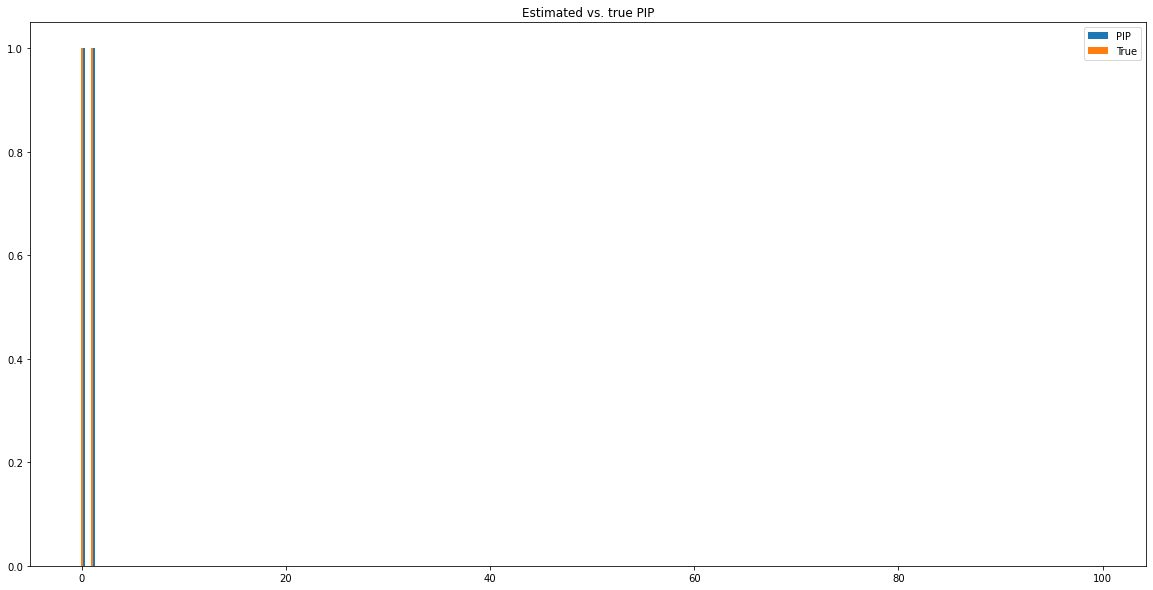

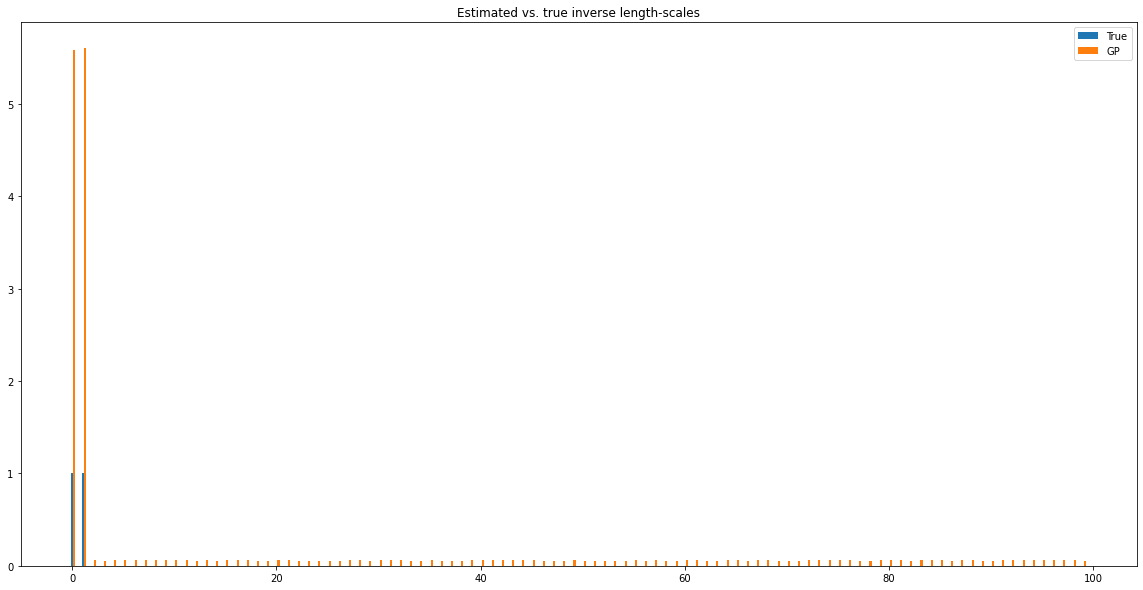

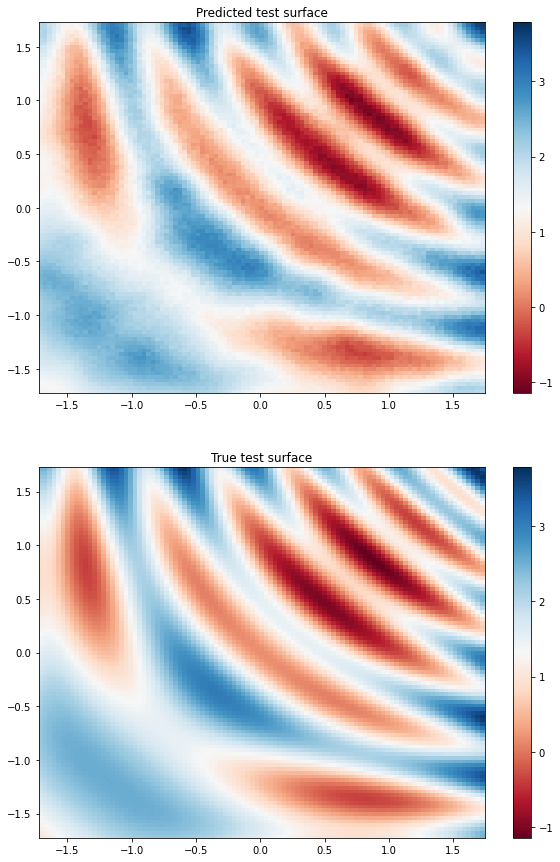

Latent test function MSE :  0.021858875
Observed test data  MSE :  0.32350895


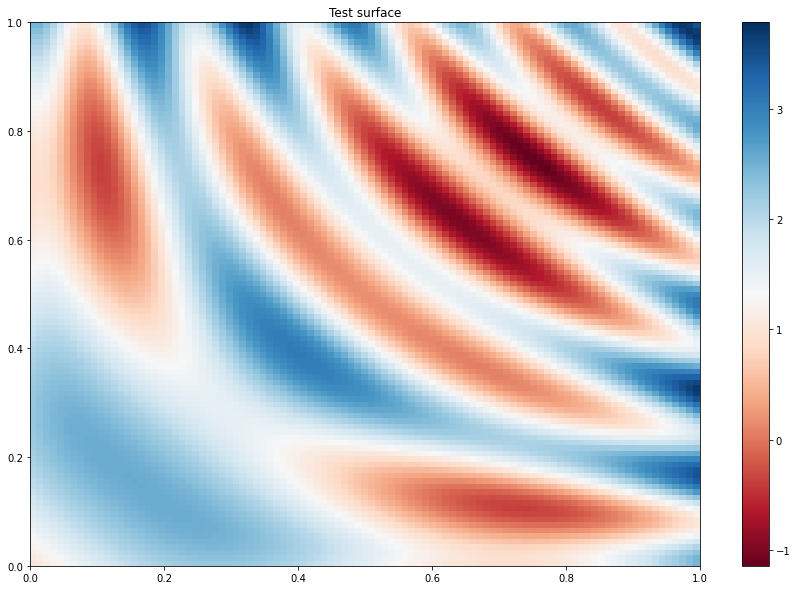

[0.7406768  0.7416508  0.7377172  0.7402046  0.7407966  0.7357584
 0.7429669  0.7353786  0.7388458  0.74370956]
3.208643913269043 0.09199062
Iter 2 - Loss: 3.209
[0.78084785 0.78201914 0.77779084 0.780398   0.78119636 0.7754476
 0.7843382  0.7750111  0.7788278  0.7849694 ]
3.205423700809479 0.06984332
Iter 3 - Loss: 2.887
[0.8273065  0.82584494 0.82415664 0.8276136  0.8290742  0.8225376
 0.8327409  0.8221816  0.82537216 0.83243304]
3.199558030486107 0.07150676
Iter 4 - Loss: 2.619
[0.8670203  0.86492413 0.86236054 0.8685076  0.87007266 0.86075556
 0.8734977  0.86126274 0.8637552  0.87889224]
3.1915866410839557 0.05622404
Iter 5 - Loss: 2.402
[0.9116232  0.9087786  0.9054722  0.9161451  0.9175433  0.90338886
 0.91868293 0.9054828  0.9070436  0.929286  ]
3.181878275607717 0.056912504
Iter 6 - Loss: 2.221
[0.9602992  0.9568017  0.9525668  0.96838045 0.9698284  0.9506192
 0.9682743  0.9533044  0.9552929  0.98437333]
3.170817754532243 0.056440935
Iter 7 - Loss: 2.076
[1.0139529 1.0098664 1.

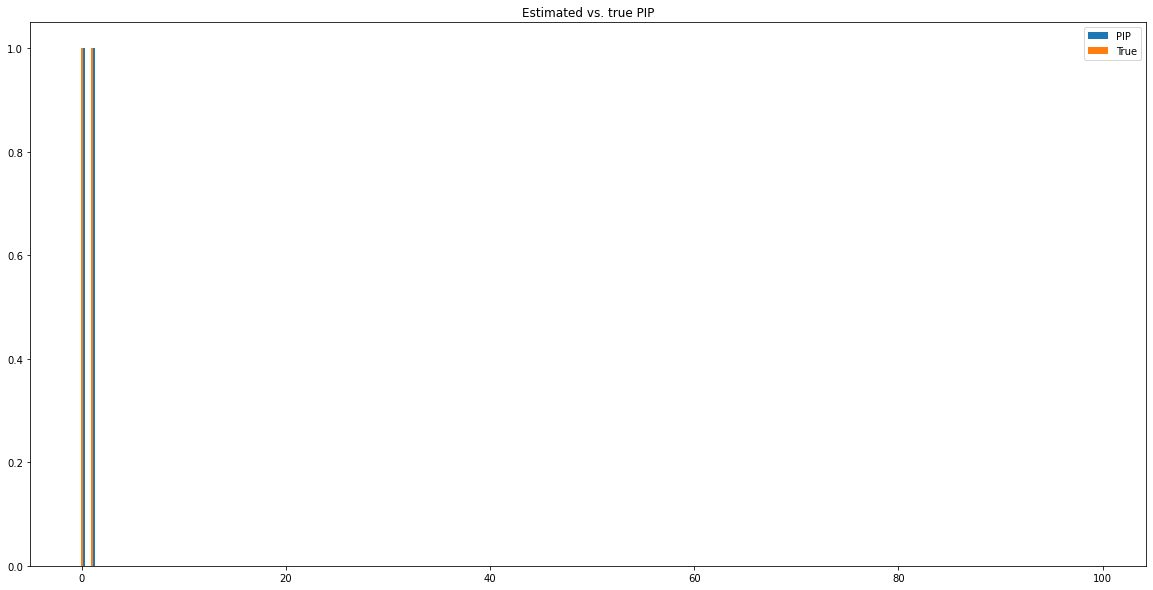

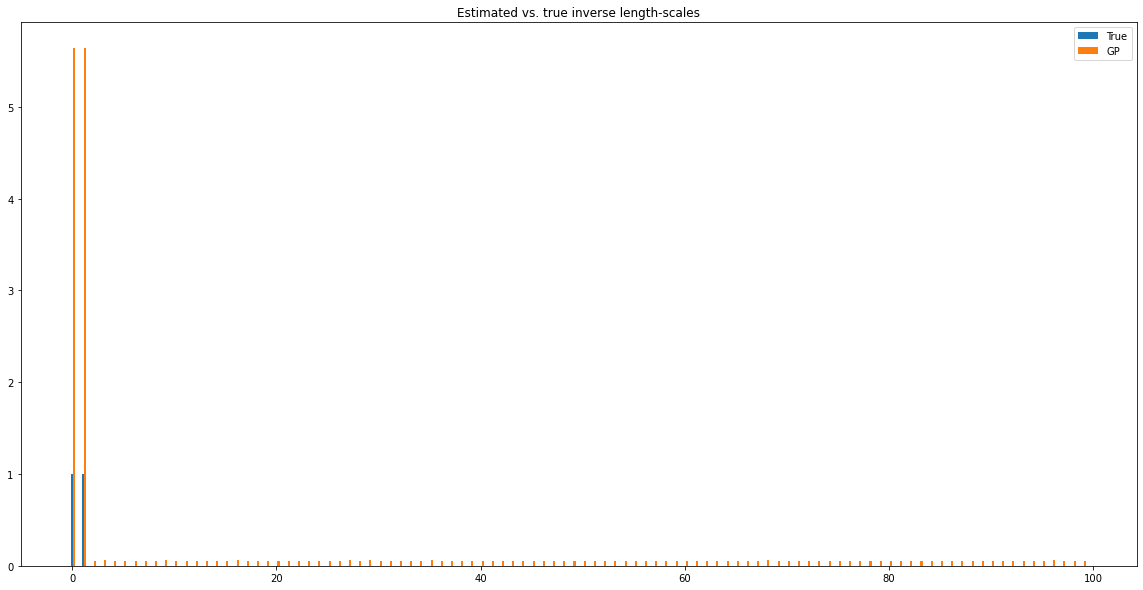

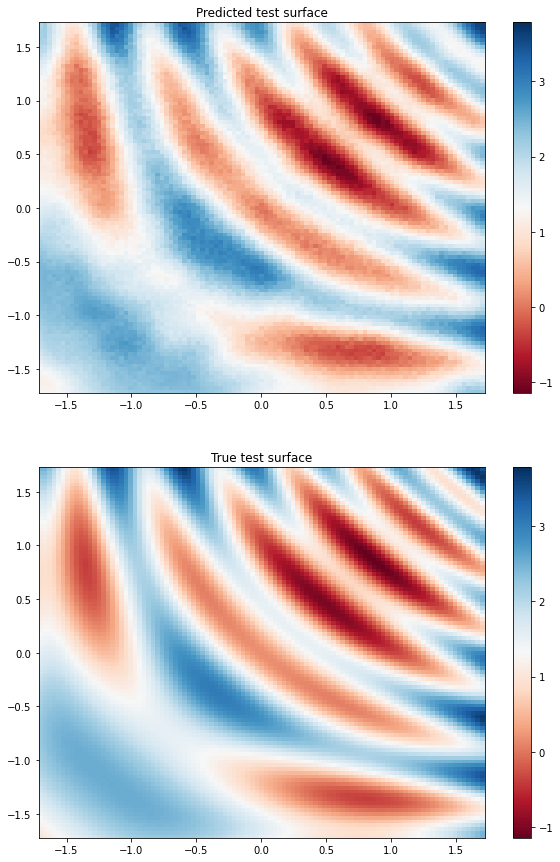

Latent test function MSE :  0.01721217
Observed test data  MSE :  0.31366602


[0.72551477 0.71249384 0.71274716 0.7170637  0.71587837 0.7068705
 0.7141911  0.7154619  0.7105081  0.73425645]
2.92025089263916 0.050304666


[0.75547767 0.7443844  0.74689555 0.7516656  0.7500967  0.743813
 0.7519361  0.74367666 0.7419866  0.7814747 ]
2.917898361682892 0.06670328


[0.8090863  0.7996604  0.79918295 0.80700326 0.80404454 0.79828876
 0.8063227  0.79812986 0.79668176 0.8335805 ]
2.9134451323270802 0.08796105


[0.87592226 0.8665096  0.863312   0.87708485 0.8695122  0.8627832
 0.8725339  0.8665217  0.8615045  0.89675075]
2.9072756973688607 0.09240593


[0.9493957  0.9375587  0.92782533 0.9478181  0.9368696  0.92679346
 0.939481   0.9434644  0.926588   0.966935  ]
2.899722005298431 0.08263758


[1.0219187  1.0133235  0.9901016  1.0180517  1.0066475  0.98738736
 1.0097915  1.0137222  0.99430484 1.0546395 ]
2.8912559222350405 0.07438467


[1.1037403 1.10119   1.058401  1.1002859 1.0880885 1.0563602 1.0964981
 1.085657  1.0714135 1.1595545]
2.8813735525268505 0.07344528


[1.2073574 1.2112346 1.1435394 1.1834859 1.191798  1.1467941 1.2042801
 1.1783557 1.1762474 1.2788428]
2.87201688544488 0.077120826


[1.321545  1.328598  1.2382613 1.266871  1.3065885 1.2467048 1.3207088
 1.2931256 1.2959841 1.3952211]
2.861339756627586 0.07112424


[1.4397548 1.458827  1.3425082 1.3630501 1.42546   1.3627204 1.4431287
 1.4208046 1.4194745 1.5060147]
2.850195260933945 0.06326659


[1.5787145 1.5997854 1.4611125 1.4576108 1.5459316 1.5001379 1.5776556
 1.5583802 1.5492458 1.6148949]
2.839062430829794 0.056498684


[1.7387532 1.7449485 1.5962844 1.5623959 1.675149  1.6583368 1.7357763
 1.7084587 1.6852328 1.7366562]
2.8278931250048487 0.052462567


[1.9062586 1.8938928 1.7397755 1.6706427 1.8085885 1.8177129 1.8946164
 1.8650302 1.8289269 1.862146 ]
2.81662735732139 0.046045803


[2.0890439 2.0585885 1.8992097 1.7855393 1.9494895 1.9869552 2.0682104
 2.0382557 1.9924359 2.0050418]
2.805049855091407 0.043154262


[2.278841  2.2331467 2.0730996 1.92405   2.1073692 2.1657233 2.2557583
 2.215668  2.1747396 2.1717606]
2.793655620607189 0.039581746


[2.4702282 2.4199574 2.2548492 2.0744007 2.2742453 2.3452063 2.444345
 2.3983705 2.3664017 2.348746 ]
2.781967021153894 0.035138864


[2.6451144 2.5850937 2.4367452 2.228718  2.4419148 2.5313015 2.637181
 2.5849745 2.5556006 2.5315657]
2.7701863910310087 0.030418828


[2.799741  2.7294457 2.616687  2.382644  2.6085746 2.7066643 2.8158126
 2.76606   2.737041  2.707242 ]
2.7584206061459673 0.025821729


[2.8827455 2.7976885 2.7807775 2.538577  2.7635598 2.872426  2.9806535
 2.9382489 2.9035268 2.864065 ]
2.746422742896092 0.020849526


[2.840803  2.728527  2.9253519 2.6714768 2.9003456 3.0135348 3.1218522
 3.0796528 3.044022  3.0091105]
2.734391577782118 0.016315093


[2.6624792 2.5454242 3.057982  2.780813  3.020945  3.1359732 3.23784
 3.1978896 3.1652594 3.1322763]
2.7224565713251283 0.01298324


[2.416794  2.2989979 3.1611993 2.8728824 3.1165047 3.240998  3.343489
 3.29849   3.2644515 3.2366734]
2.7111424772896573 0.010667771


[2.1563294 2.0398784 3.2559564 2.9626124 3.2100568 3.3412771 3.4384553
 3.3880532 3.3608823 3.335156 ]
2.6995439552534246 0.009540234


[1.8918144 1.7847422 3.3525326 3.0520482 3.29858   3.436637  3.5379562
 3.4868689 3.4545567 3.437396 ]
2.687823569678857 0.009588413


[1.636377  1.5347215 3.4577787 3.146737  3.402024  3.546785  3.653534
 3.6050103 3.5611777 3.5507333]
2.67586273028906 0.010682377


[1.3945934 1.3000721 3.5784838 3.2609267 3.521125  3.6675565 3.7873106
 3.7444708 3.6863286 3.6807227]
2.6642147995403533 0.011804483


[1.1730877 1.0879369 3.7153914 3.400878  3.6577656 3.8104744 3.942522
 3.905609  3.8379197 3.8353937]
2.652903512159726 0.013518256


[0.97791684 0.90574986 3.8756435  3.5643938  3.8190339  3.9730463
 4.119828   4.096871   4.011728   4.0059285 ]
2.640750502238019 0.014831779


[0.82144994 0.76922256 4.045751   3.7379827  3.9946554  4.148642
 4.3059454  4.29163    4.191445   4.1883106 ]
2.6287088204845293 0.014891261


[0.71393794 0.6920503  4.212033   3.9068723  4.1638284  4.3178277
 4.485586   4.4744687  4.3641987  4.361262  ]
2.616560703846838 0.012995515


[0.6540398 0.649603  4.364869  4.061887  4.3223233 4.4774666 4.6501026
 4.643816  4.5254736 4.5245256]
2.6044825580415085 0.010599243


[0.617253  0.6264963 4.502182  4.201604  4.4630985 4.617256  4.7998323
 4.793332  4.6678085 4.6734996]
2.592479889395831 0.008488008


[0.59330857 0.60745907 4.62421    4.3211174  4.5877542  4.7434626
 4.9326434  4.9209213  4.794221   4.805325  ]
2.5804862051754873 0.0070079435


[0.5676467  0.59703696 4.735396   4.434071   4.701646   4.856676
 5.0482025  5.040599   4.9075823  4.9233975 ]
2.5684354176972493 0.0060456004


[0.5477328 0.5768949 4.835773  4.5309925 4.8054023 4.957799  5.154618
 5.142413  5.0072875 5.029536 ]
2.5567440418547034 0.0055034524


[0.5267766 0.5643588 4.9287124 4.623482  4.899128  5.046838  5.2549243
 5.2359924 5.1031556 5.129738 ]
2.545034470345992 0.00494633


[0.50219697 0.5453042  5.0147552  4.707982   4.987458   5.1338315
 5.348405   5.323528   5.1900544  5.2232113 ]
2.5333382836625518 0.005013078


[0.48564744 0.52195406 5.0988774  4.7903724  5.0774894  5.216205
 5.4390798  5.4100356  5.27412    5.3145394 ]
2.521786357773253 0.0046982975


[0.47050434 0.5060042  5.181053   4.8742137  5.1627164  5.3018355
 5.5263996  5.494043   5.3567147  5.4032793 ]
2.51015105401951 0.004337587


[0.4511863  0.48875487 5.260603   4.9516406  5.2417054  5.3766704
 5.609462   5.579607   5.439322   5.4881067 ]
2.4983957041295684 0.0044365837


[0.43218893 0.469827   5.3375044  5.0275764  5.323946   5.456849
 5.696301   5.658798   5.52219    5.5730534 ]
2.487158455719788 0.004569815


[0.41585228 0.44670373 5.4183474  5.103384   5.403822   5.534341
 5.7783036  5.7385387  5.601981   5.6554537 ]
2.475682572809395 0.004635713


[0.3968638  0.42421928 5.4975386  5.1825867  5.482597   5.6126313
 5.8623714  5.8222566  5.68737    5.7356834 ]
2.4641826593127463 0.0049422844


[0.381173   0.40667266 5.574506   5.257128   5.56258    5.691406
 5.947681   5.903023   5.769379   5.8199124 ]
2.4527320904348437 0.0045487676


[0.36255893 0.38748696 5.652701   5.3361497  5.641999   5.7730203
 6.0340314  5.986127   5.854945   5.903427  ]
2.4413999766494836 0.005024953


[0.346912   0.36933827 5.734024   5.4137406  5.725055   5.852135
 6.121958   6.069036   5.93957    5.985389  ]
2.4301909877739494 0.004912355


[0.33691597 0.35110804 5.8154516  5.493999   5.8087006  5.9350934
 6.2116904  6.156603   6.02903    6.0741873 ]
2.4193366069737396 0.0046972656


[0.3217475 0.3332276 5.8987446 5.5781054 5.895265  6.0205054 6.3010616
 6.2433095 6.11631   6.161929 ]
2.4080039407960463 0.0052897944


[0.3022668  0.31642437 5.9807544  5.6639094  5.979635   6.103482
 6.392322   6.330164   6.204249   6.2494917 ]
2.3967763591498503 0.005924385


[0.28955507 0.30101052 6.0680604  5.748645   6.072775   6.1951146
 6.489039   6.423124   6.300612   6.3416615 ]
2.3855460556947654 0.005448562


[0.27150995 0.28317997 6.1573234  5.8375897  6.1609797  6.285116
 6.581565   6.518779   6.395108   6.43137   ]
2.3745179760334323 0.006676322


[0.25675812 0.26584044 6.249329   5.932026   6.25421    6.37835
 6.6821194  6.6156836  6.4918246  6.5254965 ]
2.3634421116112327 0.006753249


[0.24333236 0.25216225 6.3468127  6.025353   6.353455   6.478167
 6.787321   6.717869   6.5956306  6.6214128 ]
2.352011762970554 0.0065423865


[0.23192582 0.24146366 6.4457974  6.124045   6.4547796  6.583346
 6.8944564  6.822373   6.702598   6.7206774 ]
2.3409921269463783 0.006122523


[0.22115201 0.22802018 6.543928   6.2255683  6.55575    6.688046
 6.9996862  6.9288764  6.809731   6.823065  ]
2.330008233928562 0.0068474202


[0.21568897 0.21840525 6.6462936  6.3288546  6.6595726  6.794365
 7.1076617  7.0393696  6.918694   6.925273  ]
2.318995011340024 0.0053459913


[0.20898286 0.20860884 6.74656    6.4307337  6.760746   6.897771
 7.212634   7.1465483  7.023743   7.024872  ]
2.3083441177661594 0.005799921


[0.20428233 0.20756343 6.849132   6.533863   6.862694   7.005299
 7.317364   7.2525344  7.1300726  7.124946  ]
2.2974637488979917 0.0034453804


[0.19840531 0.19891165 6.9479747  6.631337   6.960544   7.1072526
 7.4216485  7.356916   7.2331686  7.223288  ]
2.2860640878532563 0.0055304533


[0.19271566 0.19619906 7.04289    6.729295   7.057697   7.2070436
 7.523963   7.458662   7.334562   7.3179617 ]
2.2749616039895706 0.0040742643


[0.19189331 0.19198239 7.137083   6.8220963  7.153944   7.3025446
 7.623576   7.5577044  7.4320354  7.4098687 ]
2.2637358855975327 0.0031308956


[0.18915094 0.19133188 7.2293105  6.9129105  7.247969   7.399281
 7.7203817  7.653468   7.5284395  7.50105   ]
2.2527529835954243 0.0026432085


[0.18649392 0.18625803 7.317233   6.9976125  7.3360896  7.491257
 7.81239    7.7434344  7.6183877  7.5887446 ]
2.2416852668774507 0.0037691474


[0.18391514 0.185158   7.402883   7.0818543  7.4256597  7.5804496
 7.9034667  7.832808   7.708148   7.674271  ]
2.230747065970685 0.0025977297


[0.18370935 0.18350202 7.4897165  7.166159   7.5107355  7.6680574
 7.9928446  7.9199753  7.7949944  7.7583203 ]
2.219956016152195 0.0020112493


[0.18299577 0.1836027  7.5736938  7.247348   7.593816   7.755492
 8.082255   8.006282   7.880919   7.840143  ]
2.2087503586739308 0.0016526718


[0.18180235 0.17994636 7.656448   7.324825   7.6763864  7.8402343
 8.165076   8.089935   7.9662232  7.922515  ]
2.1978161799296445 0.0028063946


[0.17860563 0.17992446 7.736961   7.4037147  7.757984   7.923455
 8.25068    8.173033   8.048824   8.002393  ]
2.18701047844796 0.0022939004


[0.1813839  0.18184201 7.814781   7.4816556  7.837887   8.006394
 8.3336935  8.254025   8.130475   8.081521  ]
2.1760814153714727 0.0026925176


[0.17906761 0.17897601 7.8933167  7.5550995  7.916681   8.084794
 8.414564   8.334635   8.209815   8.158375  ]
2.165380170338165 0.0027922636


[0.17849839 0.17677182 7.96961    7.6277547  7.991918   8.163618
 8.492872   8.410982   8.28875    8.231678  ]
2.1550370402027004 0.0020204561


[0.17750193 0.18049999 8.047328   7.7006783  8.07092    8.245573
 8.5762     8.490878   8.368842   8.309445  ]
2.144210871003066 0.0026357267


[0.17818305 0.17750572 8.121302   7.7710805  8.146675   8.321377
 8.652905   8.56435    8.44524    8.383215  ]
2.133591441097433 0.002226458


[0.17694613 0.17711186 8.195244   7.840115   8.221705   8.3982315
 8.730873   8.6400795  8.522767   8.457025  ]
2.122982238436489 0.0015746084


[0.17728354 0.17633969 8.270031   7.9104104  8.294711   8.475082
 8.807324   8.716952   8.599457   8.530012  ]
2.1127480293886873 0.0013998732


[0.17705794 0.17563944 8.342975   7.9800777  8.368335   8.551165
 8.882582   8.790919   8.674612   8.6034565 ]
2.1022759772659585 0.0012970888


[0.17471094 0.17450236 8.413879   8.047508   8.440729   8.624431
 8.958122   8.8627     8.749135   8.673895  ]
2.0917616355764896 0.0021036249


[0.17373773 0.17614533 8.487028   8.114582   8.512076   8.698163
 9.030092   8.933987   8.823658   8.744086  ]
2.08143967108573 0.0017988596


[0.18153428 0.17449082 8.556147   8.179233   8.583121   8.770303
 9.10349    9.005115   8.898578   8.814303  ]
2.0714616634396616 0.0039321342


[0.17615275 0.17792709 8.6248255  8.245552   8.651925   8.842809
 9.17707    9.075992   8.968908   8.882908  ]
2.0612345686920905 0.003678554


[0.17503797 0.17546089 8.691846   8.310853   8.722482   8.914017
 9.247318   9.1459875  9.038905   8.950719  ]
2.051417605266446 0.0020206934


[0.1750565 0.1749034 8.759875  8.372909  8.790658  8.983637  9.317518
 9.217713  9.109842  9.017169 ]
2.0415051047241883 0.001034518


[0.17609668 0.17466831 8.827335   8.43622    8.854726   9.052237
 9.389075   9.283602   9.179478   9.084305  ]
2.0318576065295773 0.0012318392


[0.17769955 0.17653427 8.893518   8.496244   8.921645   9.120379
 9.457059   9.351551   9.247614   9.15011   ]
2.0221120111066 0.0019145195


[0.17286322 0.1766979  8.958504   8.558292   8.986966   9.188882
 9.526595   9.418441   9.317608   9.216382  ]
2.012305467525991 0.0024135257


[0.17506768 0.17639847 9.021169   8.61698    9.053177   9.2542925
 9.593666   9.483197   9.383203   9.279392  ]
2.0025860221265486 0.001577954


[0.17514248 0.174818   9.084647   8.674478   9.117097   9.321031
 9.660957   9.548407   9.448692   9.343328  ]
1.9927084189224187 0.0012731744


[0.17668326 0.1766782  9.147448   8.733938   9.178946   9.388056
 9.725386   9.613662   9.5152     9.40659   ]
1.9831335528842868 0.0018263373


[0.1751199 0.1764742 9.210093  8.792184  9.240424  9.451727  9.790649
 9.677441  9.580358  9.46821  ]
1.9733808287293453 0.0012683553


[0.17500357 0.17558232 9.271381   8.847183   9.302144   9.516201
 9.855476   9.741546   9.645362   9.530097  ]
1.9634639507360887 0.0010121858


[0.17502579 0.17388178 9.331496   8.904188   9.36499    9.579127
 9.917631   9.803365   9.708313   9.590149  ]
1.9542138672837968 0.0012286389


[0.17554253 0.17570174 9.390253   8.957673   9.42442    9.641798
 9.978428   9.862958   9.765432   9.649236  ]
1.9452533972263 0.0014009533


[ 0.17450853  0.17643258  9.449531    9.013899    9.484095    9.7044735
 10.040965    9.923853    9.827451    9.708901  ]
1.936016536700692 0.0012090417


[ 0.1753923   0.17386848  9.507468    9.065825    9.540689    9.76401
 10.10219     9.981651    9.888387    9.766229  ]
1.9271833133483793 0.00173563


[ 0.17510036  0.17672932  9.565358    9.120492    9.6022005   9.825828
 10.162846   10.041868    9.949692    9.825536  ]
1.9179151327875275 0.0016394028


[ 0.17313594  0.17477241  9.620398    9.173746    9.658396    9.883562
 10.222115   10.097439   10.006945    9.881986  ]
1.9087947146845208 0.0018614026


[ 0.1764104  0.1765366  9.677439   9.223545   9.715357   9.944705
 10.281473  10.15764   10.066694   9.938693 ]
1.9000340542579515 0.0022268968


[ 0.17222671  0.17521241  9.7335205   9.274387    9.77013    10.002133
 10.33755    10.212517   10.123375    9.992943  ]
1.8912049948146914 0.0023606706


[ 0.17484343  0.17728941  9.787297    9.324486    9.825305   10.058741
 10.394187   10.269001   10.180178   10.049493  ]
1.8826907784522835 0.00208514


[ 0.17633025  0.17672397  9.843707    9.3772545   9.880704   10.11619
 10.455138   10.326183   10.235782   10.101417  ]
1.8742409260743311 0.0012016618


[ 0.17206426  0.17600037  9.898712    9.424988    9.936124   10.171189
 10.510847   10.38088    10.290453   10.155891  ]
1.8657135787165877 0.0021597398


[ 0.17402294  0.17395279  9.951093    9.472735    9.990001   10.227424
 10.564748   10.436863   10.343845   10.210415  ]
1.8571137134563078 0.0018373159


[ 0.17681733  0.17557141 10.002706    9.518514   10.042762   10.28265
 10.621777   10.492496   10.39793    10.263207  ]
1.848737977036619 0.0019387993


[ 0.17307106  0.17526998 10.055571    9.565802   10.093714   10.335799
 10.672517   10.544867   10.449102   10.315769  ]
1.8403337314405999 0.0018058845


[ 0.17559583  0.17629108 10.106718    9.612838   10.14573    10.391826
 10.72638    10.597335   10.504043   10.36755   ]
1.8318929880392723 0.0016486436


[ 0.17323506  0.17568551 10.157102    9.658579   10.196034   10.444226
 10.779681   10.648417   10.552713   10.41656   ]
1.8239272073345234 0.0014338564


[ 0.17623381  0.17486465 10.20765     9.705164   10.245634   10.497679
 10.832527   10.702725   10.605543   10.466733  ]
1.8162779628319026 0.0017153498


[ 0.17283721  0.17564638 10.25639     9.750422   10.297245   10.548108
 10.883815   10.754301   10.658675   10.517221  ]
1.80857977756775 0.0018253352


[ 0.17408192  0.17496496 10.305475    9.798199   10.347057   10.599896
 10.938012   10.8073435  10.70724    10.567231  ]
1.8005669263405344 0.0010834953


[ 0.17478754  0.17869364 10.353717    9.842012   10.396939   10.651886
 10.988668   10.857606   10.757187   10.6157    ]
1.7928870870598865 0.0018595576


[ 0.17477664  0.17641756 10.403731    9.88421    10.447414   10.702927
 11.039484   10.906726   10.80534    10.665335  ]
1.7851449086655602 0.0011572988


[ 0.1748349   0.17569876 10.451233    9.925972   10.496131   10.754608
 11.087945   10.957545   10.853144   10.71106   ]
1.7773876277650922 0.0006667115


[ 0.17391874  0.17322463 10.499196    9.97142    10.545071   10.805352
 11.13925    11.007112   10.9025345  10.75958   ]
1.7695221194788886 0.0015279168


[ 0.1750373   0.17500795 10.545345   10.013551   10.59106    10.853469
 11.185463   11.053788   10.949185   10.8042555 ]
1.761964902110241 0.0013526547


[ 0.17452669  0.17603713 10.58959    10.056177   10.638705   10.905597
 11.234555   11.102468   10.998302   10.850624  ]
1.7542630994111983 0.0009004496


[ 0.17448354  0.1757458  10.635166   10.098419   10.6856785  10.956169
 11.283801   11.150912   11.047233   10.898821  ]
1.7466819900426052 0.00050525425


[ 0.17477858  0.17360695 10.682369   10.139587   10.730725   11.004964
 11.331719   11.197386   11.092762   10.944394  ]
1.739103152749067 0.0011823918


[ 0.1730266   0.17709927 10.73039    10.182386   10.779091   11.053073
 11.380807   11.24735    11.13891    10.991624  ]
1.7318321220608097 0.002101378


[ 0.17547004  0.17512529 10.776347   10.226396   10.824074   11.100382
 11.429546   11.295171   11.187693   11.035975  ]
1.7244591934488442 0.0018182169


[ 0.17543761  0.17453629 10.819658   10.268365   10.870395   11.146725
 11.476971   11.341062   11.2337055  11.081101  ]
1.7174523322558568 0.00056952686


[ 0.17633715  0.17684686 10.867131   10.307716   10.915569   11.194845
 11.522237   11.386502   11.278703   11.125143  ]
1.7101550919104023 0.0013988307


[ 0.17289142  0.17511266 10.911843   10.349788   10.960273   11.243577
 11.569765   11.433188   11.324475   11.170546  ]
1.7030747673973956 0.002049347


[ 0.17501307  0.17562617 10.956262   10.389421   11.005283   11.290052
 11.615133   11.478354   11.369778   11.213268  ]
1.6962433495764795 0.0012192299


[ 0.17537144  0.17408535 10.998929   10.426872   11.051509   11.33837
 11.660657   11.52378    11.41278    11.257065  ]
1.6893735488512531 0.00096525595


[ 0.17257093  0.17769498 11.04419    10.4641905  11.0944395  11.382861
 11.708562   11.570308   11.455903   11.299989  ]
1.682589658762597 0.0024363513


[ 0.17407443  0.17482513 11.088032   10.503871   11.137842   11.430124
 11.754514   11.617012   11.500036   11.344577  ]
1.675568005024321 0.0017661786


[ 0.1754667   0.17534016 11.131262   10.542998   11.183058   11.474603
 11.800973   11.662991   11.544485   11.387261  ]
1.6689666366310294 0.0009563477


[ 0.17367426  0.1750215  11.173425   10.581076   11.225371   11.519387
 11.844093   11.706452   11.587923   11.431261  ]
1.662171739456461 0.0010199355


[ 0.17499377  0.17670235 11.216727   10.620344   11.267393   11.566006
 11.888071   11.750985   11.632166   11.4752245 ]
1.6550152050815345 0.001298767


[ 0.17456661  0.17572156 11.260642   10.659148   11.310098   11.61121
 11.935198   11.796745   11.67665    11.5171795 ]
1.6482215996472735 0.00077984616


[ 0.17431973  0.17601617 11.302431   10.696525   11.353563   11.655392
 11.978128   11.8405485  11.717763   11.556294  ]
1.641700627518675 0.0004871822


[ 0.17517681  0.1776714  11.343869   10.736045   11.396198   11.700111
 12.021667   11.885498   11.7620735  11.598435  ]
1.6348627510585898 0.0011225848


[ 0.1738591   0.17489247 11.383421   10.770863   11.437468   11.743774
 12.063389   11.928829   11.802555   11.639855  ]
1.6282994168886868 0.0016303543


[ 0.17332965  0.17728256 11.424302   10.807348   11.48018    11.787962
 12.107819   11.971617   11.843855   11.68339   ]
1.6220030688951845 0.0012529296


[ 0.17351703  0.1762374  11.467334   10.84856    11.524349   11.8327265
 12.152737   12.012753   11.88702    11.724795  ]
1.6157975388242136 0.0006983333


[ 0.17446901  0.17553577 11.509422   10.885196   11.564075   11.875296
 12.195692   12.055886   11.929733   11.766014  ]
1.6092804865784047 0.0008365257


[ 0.17575318  0.1764093  11.549239   10.9229355  11.60538    11.91938
 12.239402   12.098975   11.97298    11.809038  ]
1.6032464995760851 0.0009925679


[ 0.17481546  0.1752509  11.590304   10.959751   11.645576   11.963246
 12.281844   12.142591   12.01465    11.84866   ]
1.597177364014719 0.0009668032


[ 0.17324361  0.17588566 11.628729   10.993758   11.686459   12.005283
 12.324603   12.183681   12.053764   11.888564  ]
1.5912314003778525 0.0010087566


[ 0.17377073  0.17635737 11.67011    11.029102   11.727537   12.048812
 12.36536    12.224237   12.097229   11.929398  ]
1.5851316726815996 0.00060771516


[ 0.17427993  0.17586114 11.708965   11.0646515  11.767377   12.091525
 12.406179   12.26698    12.138927   11.968696  ]
1.578953410173076 0.0006080674


[ 0.17451769  0.1754277  11.74791    11.097839   11.807334   12.134856
 12.445433   12.308115   12.178354   12.008196  ]
1.5730293126253003 0.0004907492


[ 0.17442149  0.17492434 11.78972    11.136256   11.847434   12.178811
 12.489316   12.352555   12.219668   12.04859   ]
1.5672720621063547 0.00047364808


[ 0.17645806  0.17634833 11.827224   11.172584   11.886519   12.221386
 12.531632   12.391952   12.260409   12.08835   ]
1.561438603851586 0.0013894124


[ 0.17223787  0.17682703 11.8664875  11.209062   11.927068   12.260453
 12.572341   12.432197   12.300852   12.12744   ]
1.5555259370971277 0.001806992


[ 0.17429285  0.1756115  11.905905   11.243454   11.967609   12.305302
 12.612644   12.475537   12.34165    12.165297  ]
1.5492994966434308 0.0013439176


[ 0.17415716  0.17636184 11.945941   11.278499   12.00691    12.347358
 12.657459   12.51802    12.381308   12.205392  ]
1.543374899675806 0.0005494112


[ 0.1736322   0.17566766 11.985792   11.315206   12.04635    12.387924
 12.69407    12.556364   12.419988   12.244875  ]
1.5376292592424712 0.0006532099


[ 0.17557752  0.17645065 12.024272   11.349358   12.083902   12.429404
 12.736405   12.596027   12.459672   12.285054  ]
1.5325342505054846 0.001146824


[ 0.17395802  0.17762922 12.062017   11.381459   12.123258   12.47125
 12.775843   12.638067   12.49938    12.320776  ]
1.5270487872747982 0.0011563364


[ 0.17485791  0.17524174 12.101109   11.417844   12.162079   12.513075
 12.816447   12.679642   12.538077   12.360097  ]
1.5211876495588341 0.001319651


[ 0.17454085  0.17716682 12.140912   11.450982   12.199464   12.552847
 12.854128   12.721165   12.577649   12.398124  ]
1.5156251678138408 0.00096979825


[ 0.17415394  0.1769825  12.178914   11.4858265  12.235042   12.594462
 12.894206   12.761622   12.616545   12.435304  ]
1.510325788694296 0.00042931305


[ 0.17405118  0.17806415 12.21323    11.520526   12.273413   12.633688
 12.935253   12.804661   12.655672   12.474181  ]
1.5048133699549207 0.0006195677


[ 0.1740664   0.17536515 12.25038    11.553003   12.310958   12.673865
 12.973437   12.841101   12.69375    12.510729  ]
1.499759716269219 0.0011069312


[ 0.17498031  0.17745909 12.288946   11.584427   12.349536   12.7144985
 13.01291    12.880166   12.732172   12.550482  ]
1.4944350278894858 0.0012097578


[ 0.17451733  0.17500836 12.326825   11.621137   12.385553   12.755136
 13.05168    12.918517   12.769583   12.589395  ]
1.4889738046085386 0.0011772736


[ 0.17528085  0.17667735 12.364496   11.653163   12.424131   12.795958
 13.092881   12.957749   12.8079605  12.625546  ]
1.4837612090633308 0.0010218548


[ 0.173319    0.17590535 12.400809   11.683838   12.461327   12.834984
 13.130036   12.9974     12.844874   12.660729  ]
1.478921087021106 0.0011219243


[ 0.17492384  0.17692481 12.438555   11.718012   12.497711   12.875497
 13.1676855  13.036831   12.884348   12.696739  ]
1.473815736691285 0.0010867082


[ 0.17588283  0.17704163 12.475218   11.749468   12.534951   12.9150305
 13.206901   13.075982   12.920822   12.733204  ]
1.4687593995977715 0.00057460467


[ 0.17556961  0.1758235  12.512683   11.784391   12.571636   12.953708
 13.246971   13.117389   12.961888   12.771544  ]
1.4636292500550332 0.00072001223


[ 0.17492564  0.1764103  12.5496855  11.817931   12.60725    12.993639
 13.285679   13.154135   12.998001   12.806207  ]
1.4584882915836805 0.00062077015


[ 0.17522296  0.1770248  12.584946   11.848076   12.6440115  13.030828
 13.322835   13.192833   13.036757   12.844022  ]
1.4536052203391008 0.0005118362


[ 0.17517611  0.17639038 12.62376    11.879223   12.679879   13.071787
 13.361866   13.232762   13.072038   12.87914   ]
1.4489880831690503 0.00043973996


[ 0.17579922  0.17516647 12.659734   11.910859   12.717131   13.111825
 13.401461   13.272452   13.109637   12.918129  ]
1.444280730022525 0.0008159332


[ 0.17553703  0.17623761 12.696363   11.944165   12.754337   13.149927
 13.437117   13.310772   13.147013   12.953924  ]
1.439711555510958 0.0006440551


[ 0.1762177   0.17684789 12.729532   11.9762125  12.790549   13.187893
 13.477817   13.347082   13.18194    12.989466  ]
1.435074707690376 0.0006286642


[ 0.17460516  0.17714524 12.7679     12.007974   12.824817   13.228236
 13.513179   13.386776   13.218205   13.024392  ]
1.430602036332352 0.0008277967


[ 0.17605567  0.17767808 12.805538   12.040257   12.862502   13.266591
 13.5509615  13.425012   13.252732   13.059035  ]
1.4261331343562507 0.00084948796


[ 0.17480658  0.17733105 12.842648   12.07263    12.896071   13.307111
 13.586968   13.463977   13.291746   13.097542  ]
1.4216974343927693 0.0007294571


[ 0.1751437   0.17642891 12.878595   12.102397   12.931252   13.344112
 13.625146   13.500706   13.326199   13.132887  ]
1.417016092778372 0.00059985585


[ 0.17464457  0.17713158 12.912281   12.1347275  12.966272   13.381423
 13.662458   13.53947    13.363178   13.168719  ]
1.4126055326091407 0.0005934707


[ 0.17575079  0.17602043 12.948457   12.167223   13.002322   13.420088
 13.698826   13.57717    13.398313   13.204469  ]
1.4084329683747776 0.0009208317


[ 0.17553653  0.17670745 12.9840355  12.199246   13.040225   13.459175
 13.736037   13.616402   13.434668   13.239543  ]
1.4039404499903538 0.0004934587


[ 0.17514324  0.17766234 13.01782    12.234617   13.076611   13.497397
 13.772855   13.651739   13.470067   13.274391  ]
1.3999666499387688 0.0006299606


[ 0.17509976  0.17689644 13.055282   12.2651     13.109775   13.535539
 13.812316   13.690888   13.503737   13.31004   ]
1.395793632866795 0.00045418798


[ 0.17602116  0.17679635 13.090896   12.295629   13.146572   13.574639
 13.848337   13.730489   13.541631   13.34751   ]
1.3913863967258102 0.00053235644


[ 0.1758554   0.17701843 13.125627   12.327009   13.182926   13.612433
 13.88446    13.767744   13.578897   13.38147   ]
1.3870045355652156 0.00032100396


[ 0.1756609  0.1768222 13.159559  12.359559  13.219277  13.652994
 13.919134  13.807515  13.612573  13.41486  ]
1.3825837391195137 0.00031684854


[ 0.17661501  0.17687696 13.193169   12.39057    13.255111   13.691055
 13.955922   13.844618   13.645731   13.452726  ]
1.378601434171365 0.0005181666


[ 0.17614828  0.17743883 13.228468   12.422801   13.28856    13.727159
 13.992218   13.881884   13.685813   13.487002  ]
1.3745459013350454 0.00051754445


[ 0.17607687  0.17656706 13.266777   12.455425   13.32295    13.765165
 14.02854    13.919244   13.720995   13.522472  ]
1.370347668154634 0.00049251475


[ 0.1761118   0.17816068 13.301874   12.486189   13.358312   13.803384
 14.067344   13.957363   13.7565365  13.556752  ]
1.3666080954962583 0.0007092186


[ 0.17406648  0.17754848 13.337078   12.51547    13.393372   13.840813
 14.102193   13.993281   13.793007   13.592186  ]
1.362562759723333 0.0010467097


[ 0.17597145  0.17775804 13.372002   12.545279   13.4311285  13.877667
 14.13894    14.032833   13.825721   13.625306  ]
1.3581000200569697 0.0008721721


[ 0.17555177  0.17770919 13.40826    12.576213   13.464073   13.915498
 14.177098   14.068967   13.861769   13.661366  ]
1.3540427268886037 0.00033533492


[ 0.17592305  0.17560814 13.439991   12.604994   13.497255   13.952755
 14.212933   14.104985   13.896664   13.695361  ]
1.3500804823170136 0.0009758058


[ 0.1748581   0.17856088 13.474678   12.635439   13.531617   13.990338
 14.248547   14.142188   13.932126   13.726983  ]
1.346241986782822 0.0014686988


[ 0.17563704  0.17673443 13.507601   12.6696     13.5653715  14.026873
 14.281757   14.177064   13.967872   13.760401  ]
1.3424413749289097 0.0010117252


[ 0.17578241  0.17759593 13.544532   12.702386   13.598897   14.064205
 14.317444   14.213134   14.001033   13.794079  ]
1.3385681501253908 0.0004969204


[ 0.17492966  0.17697118 13.577847   12.730081   13.633709   14.101934
 14.353413   14.249329   14.035772   13.827583  ]
1.334838262529395 0.0006549201


[ 0.1760372  0.1770158 13.609548  12.760465  13.667324  14.137563
 14.389567  14.288282  14.072731  13.857951 ]
1.330761680422137 0.00054927194


[ 0.1760088   0.17631787 13.645753   12.790143   13.69973    14.17452
 14.423322   14.325022   14.105321   13.891104  ]
1.3269354632732575 0.00040617652


[ 0.1758497   0.17720576 13.677825   12.819879   13.732904   14.211079
 14.458179   14.362371   14.1392975  13.928718  ]
1.3231099943245384 0.000510763


[ 0.1749796   0.17744195 13.71594    12.8503275  13.769799   14.248594
 14.49555    14.400338   14.174615   13.963874  ]
1.3194422432706439 0.00053384446


[ 0.17735134  0.17826349 13.748372   12.882285   13.804336   14.285608
 14.53078    14.437196   14.20741    13.997928  ]
1.3159893089370356 0.0011958148


[ 0.176126   0.1766211 13.782685  12.911949  13.836854  14.32199
 14.562737  14.4747925 14.241028  14.030954 ]
1.3129159570235074 0.0010829212


[ 0.17678407  0.1773418  13.816115   12.941515   13.871443   14.3586855
 14.5991535  14.509938   14.275127   14.064166  ]
1.3092596545709252 0.000609667


[ 0.17569974  0.17853346 13.850697   12.9723     13.903401   14.395564
 14.635027   14.543667   14.3107395  14.098117  ]
1.305814246807908 0.0008939766


[ 0.1765982   0.17710882 13.884419   13.000694   13.938107   14.431416
 14.668559   14.578974   14.344991   14.131752  ]
1.302408327926865 0.00090469845


[ 0.17613548  0.17632836 13.919023   13.028117   13.971714   14.46847
 14.702146   14.613914   14.379549   14.165063  ]
1.2992500704198817 0.00056573993


[ 0.1772204   0.17761628 13.953269   13.057106   14.004845   14.505808
 14.73763    14.651182   14.413294   14.199006  ]
1.2963040613386076 0.0009224506


[ 0.17637084  0.17760958 13.986982   13.087077   14.038082   14.541923
 14.77396    14.6862     14.447064   14.232879  ]
1.2929923067311955 0.0004359059


[ 0.17620054  0.17723449 14.019888   13.117324   14.071254   14.578776
 14.809558   14.723297   14.480958   14.264647  ]
1.2894812276484875 0.0003370443


[ 0.1770568   0.17693311 14.052484   13.143423   14.104165   14.614563
 14.843703   14.758456   14.514845   14.297979  ]
1.2862800373650674 0.0005339665


[ 0.1774937   0.17767684 14.087483   13.175294   14.139995   14.649431
 14.879545   14.796674   14.546652   14.333518  ]
1.2830603529887312 0.000538055


[ 0.17547323  0.17809997 14.119969   13.204738   14.171484   14.686046
 14.910735   14.833394   14.581285   14.365824  ]
1.2798786578355377 0.00093941664


[ 0.17780799  0.17877197 14.1522875  13.234636   14.203846   14.721592
 14.946382   14.867212   14.617586   14.398212  ]
1.276843484600421 0.0011163552


[ 0.17633264  0.1767663  14.1860695  13.264292   14.239062   14.757744
 14.982635   14.904117   14.650061   14.433232  ]
1.273756999965942 0.0012643071


[ 0.17726094  0.17719747 14.219979   13.293418   14.271738   14.793137
 15.018355   14.940346   14.68028    14.465241  ]
1.2708326361621138 0.0005902731


[ 0.17579328  0.17959172 14.250112   13.321096   14.303688   14.828964
 15.051651   14.9778185  14.714385   14.495198  ]
1.267796548031198 0.0013765744


[ 0.17719136  0.1771779  14.284027   13.351341   14.335065   14.865127
 15.085814   15.013214   14.745798   14.527444  ]
1.2645607230109002 0.0013594792


[ 0.17554463  0.17747355 14.315961   13.378516   14.367651   14.90149
 15.120666   15.047789   14.78165    14.560304  ]
1.2617180795144642 0.000775797


[ 0.17820263  0.17863977 14.348155   13.405848   14.399014   14.934993
 15.155151   15.082412   14.812332   14.5919895 ]
1.2587838699584095 0.0013662642


[ 0.17660135  0.17786056 14.381542   13.4365225  14.43156    14.972251
 15.189215   15.117103   14.845112   14.623284  ]
1.2558120438320677 0.0009064444


[ 0.1772582   0.17763753 14.413948   13.466079   14.463967   15.006957
 15.221992   15.152424   14.879074   14.652574  ]
1.2528138479962556 0.00042879992


[ 0.17541473  0.17803085 14.445331   13.493741   14.495506   15.042554
 15.255285   15.1868725  14.910373   14.686321  ]
1.2498040473620955 0.000868912


[ 0.17699656  0.1776928  14.478222   13.521835   14.527011   15.078054
 15.290021   15.223784   14.945686   14.720994  ]
1.2467737964192285 0.00076531176


[ 0.17727622  0.177846   14.511905   13.549095   14.55952    15.11382
 15.323674   15.259534   14.978448   14.75339   ]
1.2437447150235634 0.00028407702


[ 0.176765    0.17922139 14.544675   13.5765705  14.592794   15.147314
 15.356204   15.29542    15.0107     14.786288  ]
1.2408787939238954 0.0007405822


[ 0.17602997  0.17704642 14.577488   13.6079645  14.624851   15.184728
 15.391942   15.329396   15.043197   14.81991   ]
1.2377905178025885 0.0010702063


[ 0.17690088  0.17821087 14.608581   13.637301   14.657356   15.221943
 15.425979   15.364622   15.075442   14.854336  ]
1.235180630155004 0.00079555897


[ 0.17852618  0.17775466 14.643172   13.664614   14.689582   15.255897
 15.45874    15.399892   15.107098   14.886352  ]
1.2324049263486474 0.0008018413


[ 0.17801277  0.17845549 14.674171   13.693196   14.721372   15.290432
 15.491623   15.435831   15.14097    14.916998  ]
1.2297333975033282 0.00052554725


[ 0.17590152  0.1768236  14.7067175  13.722816   14.75404    15.326358
 15.5223675  15.472041   15.173735   14.94808   ]
1.2271548094751792 0.0013356083


[ 0.17727031  0.17797248 14.740075   13.753298   14.786225   15.362133
 15.557316   15.507629   15.208091   14.979518  ]
1.2246086466886932 0.0009478336


[ 0.17706667  0.17798546 14.771668   13.781534   14.820856   15.395488
 15.591868   15.541687   15.238485   15.011859  ]
1.2220319350453765 0.0002083797


[ 0.17727607  0.17801748 14.804187   13.809377   14.853256   15.430958
 15.623237   15.57677    15.274633   15.04571   ]
1.219592680086059 0.00021803021


[ 0.17649709  0.17819072 14.83425    13.839945   14.884738   15.465119
 15.6566515  15.613817   15.307609   15.079774  ]
1.216727241728573 0.00044427515


[ 0.17688483  0.1786711  14.866222   13.86918    14.915788   15.5030155
 15.689385   15.646045   15.337799   15.110807  ]
1.2138358354621435 0.0004156909


[ 0.17723198  0.17770797 14.898006   13.899464   14.948788   15.538588
 15.72212    15.682718   15.372259   15.144162  ]
1.211404085164544 0.0005522991


[ 0.17686133  0.17769095 14.92986    13.925644   14.980023   15.57281
 15.755453   15.713466   15.405092   15.173808  ]
1.2084837865881366 0.00025931344


[ 0.17721972  0.17817003 14.963757   13.955736   15.012023   15.60944
 15.78763    15.748656   15.436518   15.206173  ]
1.2057591035894275 0.0004041438


[ 0.17679474  0.17884794 14.995975   13.983555   15.043018   15.644363
 15.819682   15.783703   15.470783   15.236488  ]
1.203186173178991 0.00048337513


[ 0.17727843  0.17544396 15.027595   14.012596   15.077866   15.677993
 15.85132    15.817289   15.502772   15.269428  ]
1.2007277478266338 0.0013751418


[ 0.17730817  0.17942706 15.062011   14.04198    15.108703   15.713604
 15.885236   15.851581   15.533505   15.303229  ]
1.1983576515112018 0.0014101978


[ 0.17817014  0.17965265 15.092472   14.070862   15.140192   15.748282
 15.920469   15.885997   15.568181   15.33456   ]
1.1956164135342597 0.00047507338


[ 0.17707212  0.17760265 15.123003   14.098076   15.171428   15.782225
 15.951707   15.920834   15.599027   15.366343  ]
1.1931639113890828 0.0011211109


[ 0.17850779  0.1787885  15.152889   14.125484   15.201593   15.816856
 15.986042   15.956614   15.63021    15.397197  ]
1.1910820322115248 0.0009607726


[ 0.1780787   0.17753866 15.186816   14.15193    15.233614   15.850985
 16.018423   15.991804   15.66332    15.428548  ]
1.1886662836581703 0.0006613402


[ 0.17604724  0.17892233 15.216618   14.179081   15.267327   15.886165
 16.052727   16.026419   15.697107   15.460757  ]
1.1866323532415564 0.0012145425


[ 0.17729703  0.17772941 15.247099   14.20825    15.298166   15.920058
 16.08774    16.060709   15.727254   15.494972  ]
1.1842736273940009 0.00090513425


[ 0.17757203  0.17962244 15.28158    14.238326   15.331376   15.956529
 16.11972    16.096354   15.759477   15.524447  ]
1.1823723158475008 0.00081045413


[ 0.1776796   0.17790247 15.312547   14.266576   15.360181   15.989741
 16.151981   16.12949    15.790304   15.559125  ]
1.180244000437248 0.00070003653


[ 0.17760488  0.1799086  15.345082   14.2975645  15.389578   16.026876
 16.18562    16.165522   15.824549   15.589704  ]
1.17801926688906 0.00078135845


[ 0.17739546  0.17751291 15.375258   14.321688   15.421234   16.059576
 16.216015   16.199018   15.854313   15.6186905 ]
1.1756326213974841 0.00094232144


[ 0.17796025  0.17863087 15.404943   14.349642   15.453133   16.094769
 16.247536   16.232498   15.889424   15.65058   ]
1.1735357303365168 0.0006590301


[ 0.17860341  0.1781057  15.437828   14.378585   15.485332   16.1301
 16.280386   16.265682   15.923931   15.683145  ]
1.1714019046579456 0.0004948183


[ 0.17749323  0.17905696 15.471517   14.405092   15.516452   16.16562
 16.315046   16.300062   15.952601   15.713784  ]
1.1693236165931928 0.000774381


[ 0.17974101  0.17931624 15.500231   14.43371    15.547941   16.200535
 16.346798   16.337555   15.9834795  15.743618  ]
1.1667810023182827 0.00091291463


[ 0.17730094  0.17647065 15.533424   14.461161   15.582262   16.236303
 16.37946    16.371231   16.015617   15.774907  ]
1.1649732066145198 0.0017918531


[ 0.17842606  0.17964135 15.564883   14.487203   15.610852   16.272778
 16.411736   16.405687   16.048168   15.807824  ]
1.162870085857426 0.0014773586


[ 0.17931128  0.17879651 15.596292   14.516576   15.64113    16.306799
 16.448133   16.440434   16.08021    15.839732  ]
1.1605937549033698 0.00066729


[ 0.1771842  0.1791226 15.627964  14.545254  15.671566  16.341394
 16.482004  16.474865  16.110504  15.870237 ]
1.1585996003819852 0.00089567597


[ 0.17681591  0.17810492 15.659404   14.57572    15.704375   16.374998
 16.51454    16.509604   16.142155   15.902925  ]
1.1562669214958563 0.0005574


[ 0.17841668  0.17953558 15.689304   14.606989   15.735934   16.410236
 16.547655   16.544334   16.17562    15.93314   ]
1.1539802656552263 0.0010788483


[ 0.1779163   0.17993394 15.720073   14.632362   15.765709   16.44313
 16.58085    16.575987   16.203554   15.964367  ]
1.1518965324681258 0.0004007598


[ 0.1780108   0.17852427 15.753414   14.65876    15.799703   16.478462
 16.613731   16.612411   16.235949   15.997111  ]
1.150217730135922 0.00059054175


[ 0.17828646  0.17977613 15.785252   14.685616   15.828604   16.512169
 16.643476   16.645372   16.267807   16.027142  ]
1.148505216983847 0.00059650716


[ 0.17844693  0.17970178 15.818174   14.712169   15.862455   16.547388
 16.675507   16.68133    16.298931   16.057707  ]
1.1463232893610134 0.00019468505


[ 0.17712355  0.17867497 15.846543   14.737488   15.8921     16.579573
 16.707764   16.711996   16.328674   16.08814   ]
1.1442211471274983 0.0008549527


[ 0.17827944  0.17867653 15.876372   14.763797   15.924451   16.6141
 16.739449   16.746675   16.36171    16.120281  ]
1.1425057443234063 0.00048696873


[ 0.17867035  0.17916079 15.910223   14.792843   15.954441   16.64918
 16.771294   16.781322   16.394325   16.15091   ]
1.1406576232443462 0.00039409584


[ 0.1772265  0.179044  15.941992  14.820715  15.985717  16.68398
 16.804293  16.81508   16.425125  16.184793 ]
1.1388853683438804 0.0006084692


[ 0.17897826  0.1783881  15.97364    14.846523   16.015686   16.718431
 16.83424    16.850817   16.455235   16.216553  ]
1.137429632288539 0.0008754586


[ 0.17917354  0.17936887 16.00549    14.87373    16.046597   16.749998
 16.868456   16.885426   16.48908    16.248335  ]
1.1355036848454678 0.00048310065


[ 0.17878668  0.18067533 16.033525   14.899632   16.07672    16.782623
 16.898298   16.919939   16.520863   16.277197  ]
1.133667246315113 0.00063652813


[ 0.17824593  0.17821673 16.06439    14.9280405  16.109148   16.817844
 16.928127   16.952154   16.551962   16.308374  ]
1.131817869598765 0.0010474189


[ 0.17916147  0.17879319 16.097427   14.954157   16.138968   16.853401
 16.964294   16.989986   16.585388   16.339357  ]
1.1301201779967027 0.00058552943


[ 0.17936844  0.17939544 16.127083   14.982861   16.16929    16.886005
 16.995478   17.020182   16.61647    16.369165  ]
1.1280197452835463 0.00036232508


[ 0.17607239  0.17849383 16.158373   15.007471   16.198553   16.92088
 17.025623   17.056248   16.645885   16.40064   ]
1.126484643202911 0.0014407673


[ 0.17780294  0.17932712 16.188913   15.033662   16.23014    16.955366
 17.060595   17.09055    16.680605   16.432291  ]
1.1248630939663165 0.0009290269


[ 0.17912161  0.17830418 16.219719   15.061462   16.260319   16.988712
 17.091578   17.120771   16.708426   16.46327   ]
1.1230866185976371 0.00084322377


[ 0.17822988  0.18020482 16.250479   15.090748   16.29109    17.023005
 17.122908   17.15754    16.742231   16.49488   ]
1.1211299007566544 0.0009843908


[ 0.17762002  0.17798942 16.284119   15.117543   16.321798   17.055458
 17.157074   17.193367   16.772095   16.526657  ]
1.1191532721497073 0.0009973148


[ 0.17800106  0.1807052  16.313004   15.145704   16.35157    17.089825
 17.189348   17.22636    16.804247   16.560156  ]
1.117835458047557 0.0010770555


[ 0.1787765   0.18098265 16.345547   15.173425   16.381714   17.126656
 17.220234   17.2602     16.83817    16.592813  ]
1.1160624958754524 0.0004402079


[ 0.17839217  0.1778826  16.373034   15.200868   16.414001   17.160538
 17.253147   17.295412   16.86986    16.621115  ]
1.1140615217193102 0.0011936988


[ 0.17866486  0.17796572 16.404593   15.224612   16.445326   17.195145
 17.284313   17.330582   16.900803   16.653475  ]
1.1122138505757941 0.0002221198


[ 0.17858252  0.18032062 16.438303   15.249999   16.477896   17.229633
 17.314177   17.363182   16.932768   16.684875  ]
1.1101389425521375 0.00086932274


[ 0.1778277   0.17871574 16.468699   15.279794   16.507927   17.263601
 17.344242   17.397621   16.963913   16.717773  ]
1.1086957789013812 0.000846197


[ 0.17833109  0.1789914  16.498352   15.303934   16.53861    17.298298
 17.378752   17.431456   16.994066   16.750593  ]
1.1073635199849337 0.00035346264


[ 0.17847766  0.17939098 16.528976   15.328434   16.568466   17.333107
 17.407558   17.464838   17.025204   16.778854  ]
1.1057111254724548 0.00027723546


[ 0.17900641  0.18059863 16.559755   15.358068   16.598541   17.365788
 17.440594   17.49867    17.057405   16.809946  ]
1.1038910002587992 0.0006456961


[ 0.17849043  0.17944033 16.588808   15.385917   16.631578   17.40061
 17.47113    17.531921   17.088375   16.840366  ]
1.1022563346791237 0.0006246983


[ 0.17828733  0.17970495 16.61994    15.415373   16.662382   17.435377
 17.501345   17.56937    17.119453   16.873896  ]
1.1006907867274969 0.0002541312


[ 0.17946824  0.17852327 16.653753   15.445168   16.69419    17.466988
 17.5351     17.603222   17.149666   16.904655  ]
1.0988865671965942 0.00084459933


[ 0.17799814  0.17983612 16.681654   15.470898   16.724281   17.500982
 17.568039   17.633812   17.18054    16.936012  ]
1.0971360733736883 0.00097266637


[ 0.17866088  0.17910227 16.711432   15.495989   16.756033   17.537458
 17.598593   17.667013   17.212955   16.96659   ]
1.0954755428754326 0.0005436466


[ 0.1788406   0.18047087 16.742937   15.521207   16.7867     17.573929
 17.632292   17.703348   17.242968   16.994495  ]
1.0933533905436401 0.00058397854


[ 0.1792852   0.17949438 16.773304   15.546229   16.815931   17.607096
 17.664698   17.738533   17.275349   17.024328  ]
1.0920383517449008 0.00054504833


[ 0.17887513  0.18047489 16.802542   15.571182   16.847147   17.641039
 17.696207   17.76944    17.305506   17.055252  ]
1.0905682786961255 0.00053392304


[ 0.17903142  0.17888066 16.832022   15.602764   16.876442   17.674982
 17.729982   17.801634   17.339937   17.085276  ]
1.0890751587563017 0.0006463912


[ 0.17981906  0.18023947 16.863184   15.627554   16.907322   17.711092
 17.76035    17.83729    17.371681   17.117285  ]
1.0877268777431177 0.0007698799


[ 0.17835304  0.17894043 16.891693   15.654755   16.937904   17.743696
 17.794159   17.871758   17.401339   17.150316  ]
1.0867104100664173 0.000963003


[ 0.17800933  0.18019435 16.922613   15.684006   16.968279   17.777908
 17.824062   17.904753   17.433609   17.18163   ]
1.085311928769441 0.0006007211


[ 0.17879498  0.17940146 16.9546     15.711629   16.998215   17.811424
 17.85428    17.93764    17.460262   17.209955  ]
1.0839374703036613 0.0005925311


[ 0.17878795  0.18047781 16.983646   15.741228   17.029522   17.846603
 17.888546   17.971657   17.4918     17.242731  ]
1.0826232361245351 0.0004370135


[ 0.17877226  0.17833808 17.014168   15.767433   17.058622   17.880873
 17.918781   18.004486   17.520779   17.273252  ]
1.081015683429809 0.0007690139
Runtime is  902.0177187919617
Test MSE: 0.317814439535141
Latent test function MSE :  [0.0190853  0.02045817 0.02142649 0.02185887 0.02105934]
Test time is :  [0.68217564 0.65078378 0.71843767 0.64726973 0.66621804]


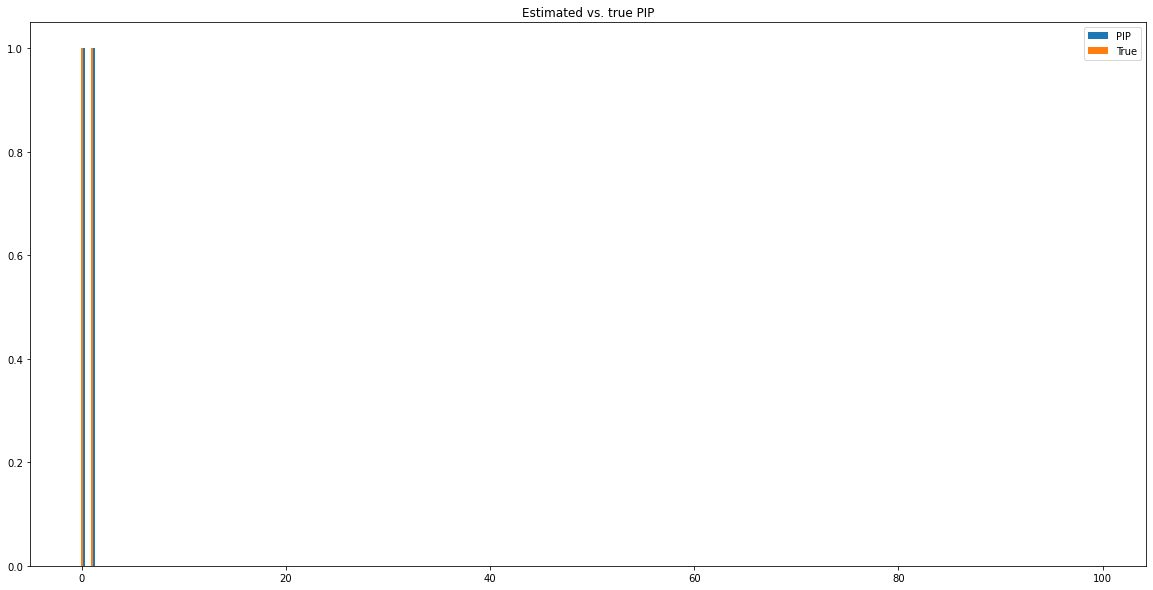

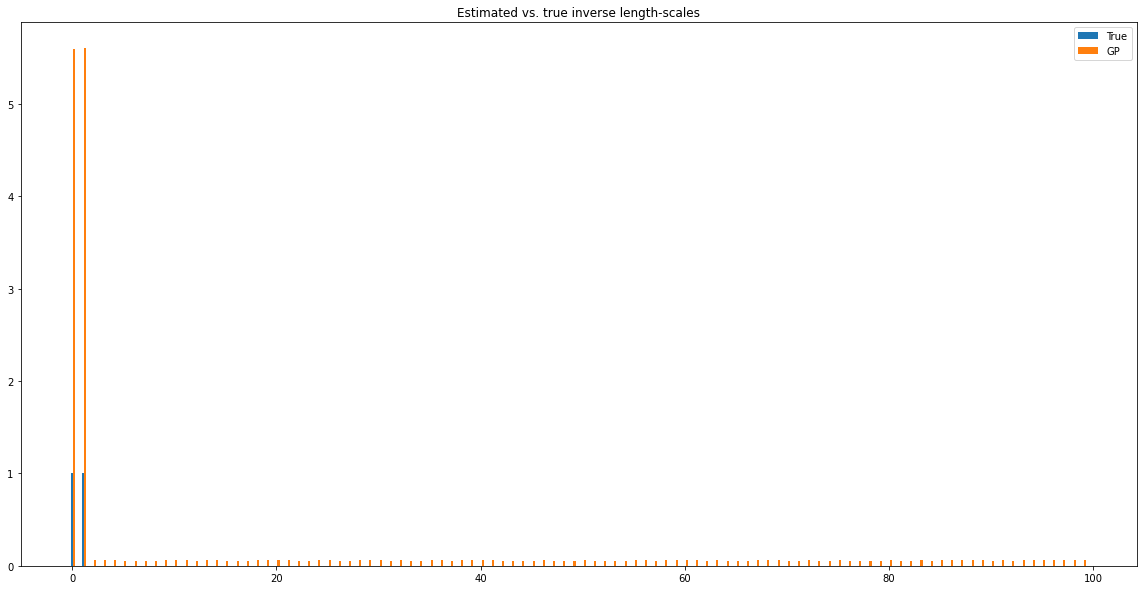

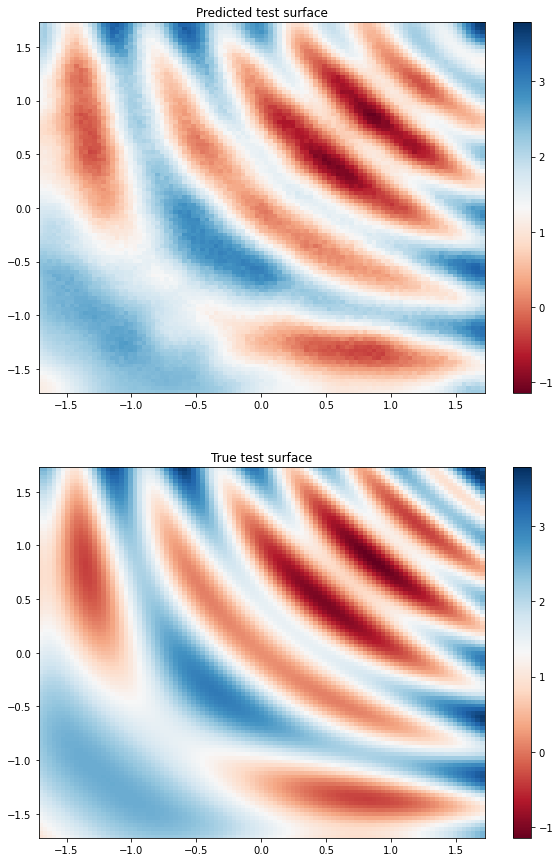

Latent test function MSE :  0.02105934
Observed test data  MSE :  0.31781444


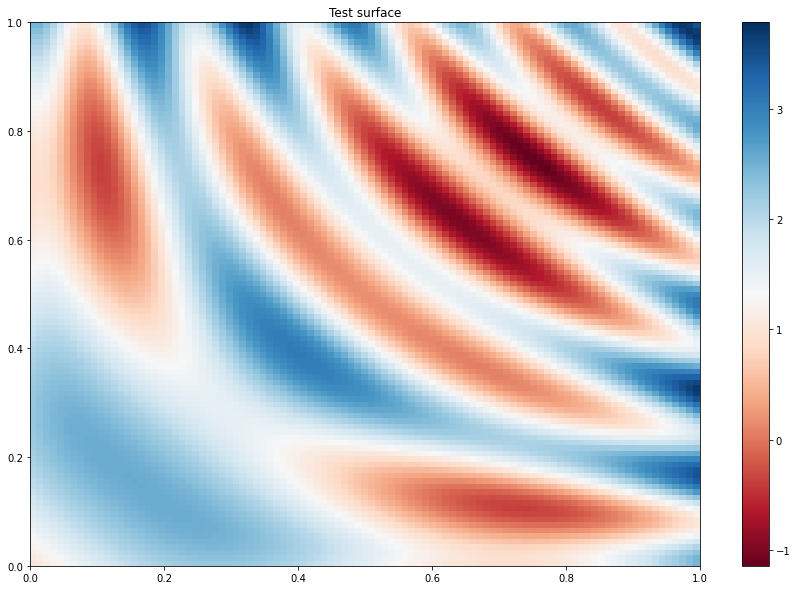

[7.0313697 7.031371  7.0313716 7.0313716 7.031371  7.031372  7.031371
 7.0313716 7.0313706 7.031372 ]
3.056497573852539 0.0020497465
Iter 2 - Loss: 3.056
[7.1314106 7.1312466 7.1313972 7.1314073 7.1313744 7.131415  7.131415
 7.1313524 7.1314116 7.131265 ]
3.0529020953178403 0.0019942431
Iter 3 - Loss: 2.697
[7.231439  7.2306347 7.2313833 7.2313237 7.2312403 7.2314377 7.23146
 7.2311406 7.231475  7.2308097]
3.0465756643533703 0.0019360969
Iter 4 - Loss: 2.420
[7.3308334 7.328929  7.330851  7.330553  7.330493  7.3308573 7.3309565
 7.3302264 7.331009  7.329564 ]
3.0382899165980812 0.0018696996
Iter 5 - Loss: 2.218
[7.4287252 7.4252934 7.429071  7.428364  7.4284005 7.428903  7.429138
 7.4278736 7.429236  7.426847 ]
3.0285638248547384 0.0017930304
Iter 6 - Loss: 2.066
[7.5241423 7.5188026 7.525265  7.5239954 7.5241604 7.524789  7.525213
 7.523294  7.5253496 7.521899 ]
3.0177452841270194 0.0017069372
Iter 7 - Loss: 1.947
[7.6160946 7.60856   7.6187315 7.616755  7.617032  7.6178045 7.6184716


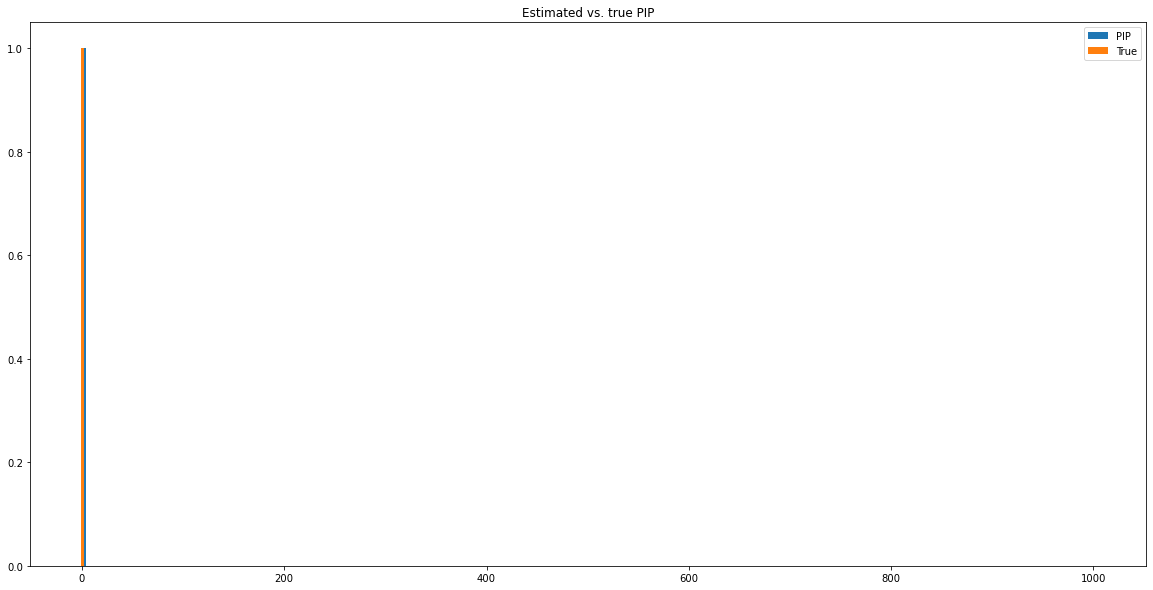

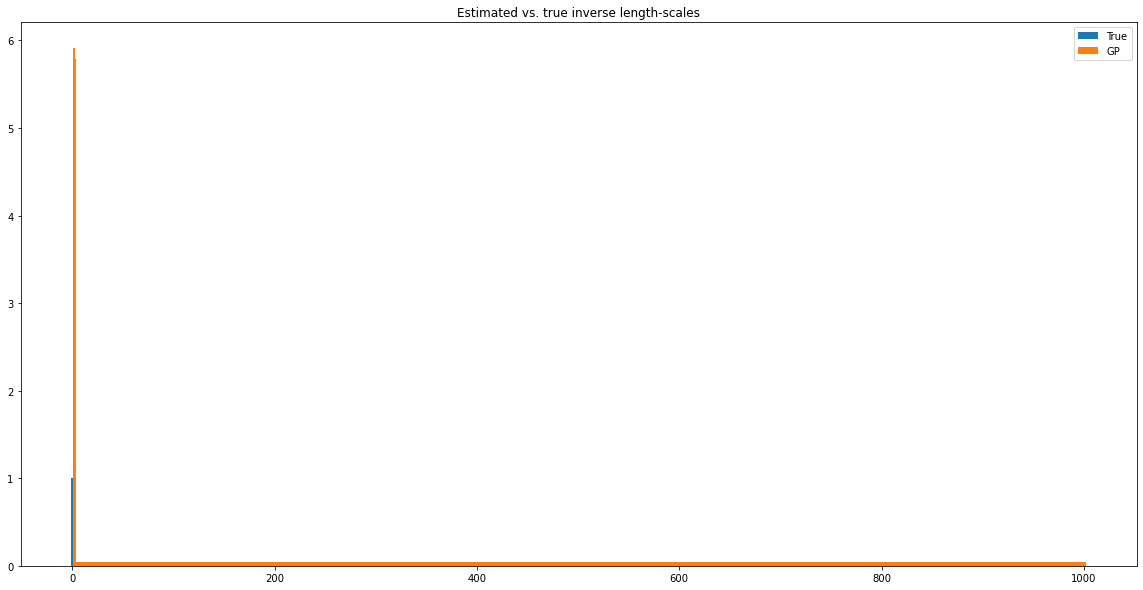

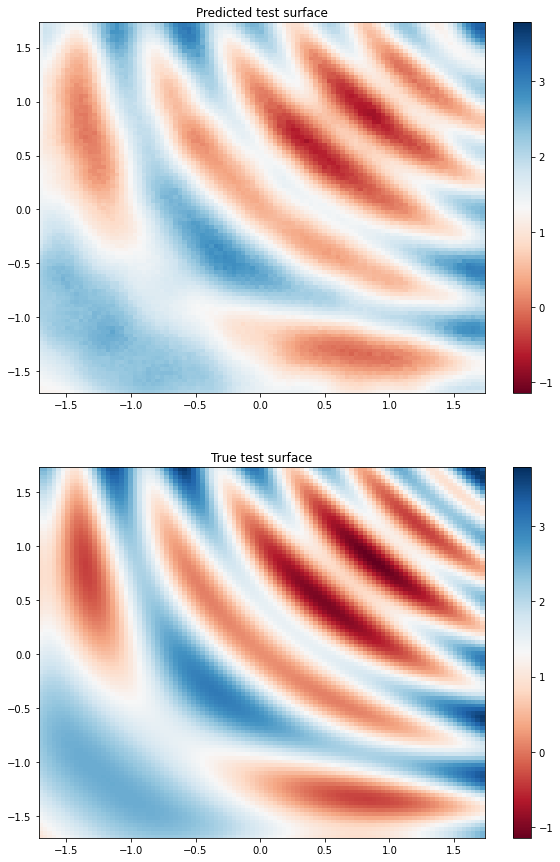

Latent test function MSE :  0.049061056
Observed test data  MSE :  0.35517594


[7.031771  7.0300283 7.031032  7.0315304 7.0314918 7.030957  7.0313005
 7.027893  7.0306454 7.032477 ]
2.8067679405212402 0.0020345808


[7.1368737 7.133703  7.13633   7.137077  7.136121  7.134757  7.135849
 7.132061  7.135754  7.138418 ]
2.8038999533653257 0.0020869402


[7.246287  7.237356  7.2432995 7.2445636 7.244207  7.240683  7.243597
 7.2407284 7.2446833 7.246247 ]
2.7991482954263684 0.002072998


[7.3570437 7.3416286 7.350877  7.3517823 7.351523  7.346739  7.351798
 7.3485956 7.3534875 7.354669 ]
2.7931532032916544 0.0020159236


[7.461487  7.439708  7.4549637 7.4567976 7.4543195 7.447472  7.45422
 7.4502287 7.457271  7.4579964]
2.7855408588998816 0.001872571


[7.5592422 7.531427  7.5547013 7.5557046 7.5507812 7.5431495 7.554871
 7.5484133 7.557556  7.556082 ]
2.776732933516678 0.0017421641


[7.6484084 7.613925  7.646522  7.6465006 7.6423063 7.632131  7.6466947
 7.6390734 7.6496115 7.648161 ]
2.76797839867614 0.0015714235


[7.72785   7.688252  7.7329984 7.729637  7.728019  7.7150464 7.731421
 7.7215476 7.7337775 7.732284 ]
2.7575819589581774 0.0014178295


[7.800921  7.755697  7.8128614 7.8083696 7.807072  7.7907147 7.8089705
 7.799033  7.8128033 7.8113422]
2.74764712104279 0.0012882934


[7.86625   7.815003  7.8848133 7.879865  7.87775   7.861891  7.8816123
 7.8698053 7.885176  7.8843937]
2.736597869938487 0.0011609433


[7.9200587 7.863798  7.952366  7.9450717 7.9444556 7.925103  7.9479346
 7.9351993 7.9497027 7.9501095]
2.725912463272031 0.001043585


[7.9675035 7.905816  8.015922  8.007087  8.006221  7.984874  8.01022
 7.9948897 8.01078   8.011116 ]
2.7155117506666695 0.0009549292


[8.006226 7.942809 8.075985 8.065182 8.063677 8.042063 8.067253 8.052348
 8.06985  8.071197]
2.7052086841796714 0.0008924324


[8.036539  7.9708734 8.130124  8.117207  8.115558  8.092305  8.120706
 8.104062  8.122142  8.123776 ]
2.6942257747270197 0.00079883315


[8.059593  7.99232   8.181261  8.168669  8.16514   8.140189  8.1723585
 8.152858  8.173029  8.174606 ]
2.6832325981622294 0.0007453803


[8.074838  8.00665   8.229617  8.21461   8.212298  8.185646  8.219104
 8.196394  8.2199745 8.221664 ]
2.672725055744221 0.0006850223


[8.087984 8.016096 8.277918 8.260718 8.257021 8.229296 8.263516 8.239263
 8.263708 8.266405]
2.6623109396186178 0.0006500691


[8.095649  8.022306  8.321088  8.3033905 8.298053  8.270014  8.304992
 8.279358  8.306155  8.308464 ]
2.6519051454194225 0.0006035639


[8.092451 8.019778 8.364476 8.343217 8.33639  8.309045 8.343733 8.317177
 8.3458   8.348615]
2.641205471864398 0.0005644942


[8.086483 8.012399 8.405025 8.381118 8.372975 8.347156 8.381591 8.352772
 8.384604 8.38599 ]
2.6304337224264396 0.00053372956


[8.077046 8.005617 8.443707 8.417971 8.407464 8.382558 8.417832 8.388219
 8.421977 8.424492]
2.619776350705868 0.0005163524


[8.062026  7.9900246 8.482169  8.452844  8.441056  8.417713  8.453129
 8.421377  8.4575405 8.45896  ]
2.6093104440217765 0.00048969634


[8.04552   7.9698787 8.519855  8.48685   8.474402  8.451125  8.487072
 8.452706  8.491593  8.492125 ]
2.598806014126847 0.00046613932


[8.023678  7.9463463 8.555632  8.520509  8.506065  8.484546  8.5201845
 8.483989  8.524378  8.524967 ]
2.5885847784694502 0.0004505357


[7.999262  7.9211454 8.590859  8.552862  8.536724  8.517934  8.552497
 8.51383   8.557457  8.557935 ]
2.5779243161122305 0.0004410367


[7.9694753 7.8947263 8.625447  8.5859165 8.56751   8.550279  8.584774
 8.544211  8.589563  8.589988 ]
2.5675583155296144 0.00043392828


[7.9400644 7.8620963 8.658892  8.6174135 8.595224  8.5818205 8.615605
 8.571812  8.622072  8.620868 ]
2.5574906818696337 0.00041344273


[7.904589 7.827724 8.692626 8.649364 8.62457  8.612759 8.646892 8.599372
 8.653152 8.65024 ]
2.547953698148548 0.00040908737


[7.868585 7.792428 8.727119 8.680425 8.653706 8.643635 8.677997 8.628663
 8.684441 8.681535]
2.537784688253321 0.0004038065


[7.829497  7.7539716 8.758957  8.7096815 8.680942  8.673192  8.709984
 8.656953  8.716039  8.712177 ]
2.527761617753234 0.00039613197


[7.7882156 7.717018  8.79402   8.7413225 8.709888  8.70442   8.740529
 8.685369  8.747229  8.7428   ]
2.5181621307718682 0.00040322062


[7.744318  7.6767364 8.825982  8.770782  8.737546  8.734721  8.770375
 8.71129   8.778408  8.772963 ]
2.508212648097878 0.000384825


[7.7003555 7.6337857 8.858524  8.800646  8.765422  8.76512   8.799582
 8.739024  8.80842   8.801686 ]
2.4987567923879257 0.00037802235


[7.6532316 7.588587  8.8900585 8.830399  8.792794  8.796639  8.830084
 8.766467  8.84111   8.8311   ]
2.489270662843334 0.00037743276


[7.602141  7.5365944 8.922802  8.85959   8.819514  8.826256  8.859223
 8.793693  8.871227  8.8587475]
2.4793064556751205 0.00036855132


[7.552045 7.484112 8.954288 8.89091  8.847755 8.85672  8.889857 8.822573
 8.901118 8.887724]
2.470047197203956 0.00037607845


[7.4964576 7.431133  8.986049  8.920781  8.873827  8.887595  8.919605
 8.84984   8.932434  8.916649 ]
2.460666142946989 0.00037239198


[7.4398336 7.3749743 9.019766  8.950557  8.902063  8.9182415 8.949693
 8.878094  8.963928  8.945602 ]
2.451239383832659 0.000369173


[7.3754663 7.3164577 9.051554  8.979287  8.929175  8.94757   8.979928
 8.905371  8.9933    8.973874 ]
2.4422387876608824 0.00035660708


[7.318043 7.256433 9.084198 9.009842 8.958099 8.979046 9.010426 8.932842
 9.025416 9.005169]
2.4329375784112877 0.00037604975


[7.248149  7.1907425 9.115323  9.040434  8.985708  9.009841  9.042059
 8.961287  9.056244  9.034697 ]
2.4240865978507924 0.00036425257


[7.1781015 7.1218314 9.1473465 9.070634  9.012118  9.04016   9.072129
 8.988415  9.085796  9.064281 ]
2.4148603350102547 0.00036056509


[7.108522  7.0520005 9.178783  9.101563  9.040671  9.07191   9.102484
 9.017176  9.118226  9.094221 ]
2.405874472605968 0.00036549693


[7.033138  6.980005  9.210884  9.131652  9.068323  9.10328   9.133078
 9.0457945 9.149656  9.123466 ]
2.3972937058710126 0.00036421514


[6.95194  6.903496 9.243556 9.163372 9.096829 9.134808 9.163628 9.075046
 9.180781 9.151745]
2.3882898375779424 0.00036112755


[6.867575 6.82208  9.276168 9.193463 9.123793 9.166289 9.193818 9.103278
 9.211633 9.182523]
2.3798684770401453 0.00035921138


[6.7781696 6.737675  9.307807  9.2243805 9.153685  9.197784  9.224353
 9.132234  9.243273  9.211612 ]
2.3711346862306963 0.00036441503


[6.6828413 6.6519384 9.3425665 9.255161  9.183425  9.230375  9.256761
 9.160966  9.274543  9.242627 ]
2.3626990346923336 0.00036396444


[6.583327 6.557931 9.374906 9.286071 9.211542 9.260969 9.28627  9.190185
 9.306331 9.272   ]
2.3542771784987764 0.000353531


[6.479271  6.453432  9.407556  9.318003  9.240378  9.292728  9.318384
 9.219235  9.339323  9.3021345]
2.346006678346937 0.0003627807


[6.3711824 6.35144   9.441237  9.350358  9.270676  9.325569  9.351266
 9.248877  9.371705  9.332861 ]
2.3376167698066466 0.00036313228


[6.256045  6.240996  9.473867  9.3826275 9.299821  9.35844   9.383024
 9.279635  9.404768  9.362166 ]
2.3291536401239457 0.0003591044


[6.1344156 6.124423  9.506414  9.413481  9.32856   9.389984  9.413971
 9.308196  9.437498  9.392569 ]
2.321058410428181 0.0003530257


[5.9958696 5.997938  9.54028   9.445082  9.358565  9.42154   9.4460125
 9.33818   9.469477  9.42311  ]
2.3130183909753885 0.0003603968


[5.8498993 5.8644934 9.573936  9.477142  9.388119  9.455205  9.477265
 9.368831  9.501229  9.454511 ]
2.3049040833588172 0.00035891592


[5.7049026 5.721715  9.606881  9.509167  9.416971  9.487429  9.508669
 9.398752  9.533528  9.485778 ]
2.296942350216803 0.00035516068


[5.5433817 5.5787582 9.641848  9.543141  9.448167  9.522086  9.541155
 9.429003  9.567351  9.517336 ]
2.288894870856023 0.00036602817


[5.369272 5.415467 9.67453  9.575531 9.478251 9.553587 9.572374 9.459004
 9.600527 9.547318]
2.281141680070589 0.0003515182


[5.1851697 5.242632  9.708209  9.607458  9.508528  9.586937  9.604234
 9.489794  9.633449  9.578175 ]
2.273741665256959 0.00035782618


[4.989223  5.0659795 9.743357  9.640151  9.539934  9.621304  9.636751
 9.520961  9.667836  9.611697 ]
2.2657718584390607 0.00036661702


[4.770377  4.8663254 9.776857  9.672296  9.570636  9.652762  9.669142
 9.55134   9.699905  9.6418   ]
2.2584771178362373 0.00035582983


[4.550501  4.656675  9.813277  9.70728   9.602452  9.686829  9.702938
 9.583367  9.7358055 9.673515 ]
2.2509657318965224 0.00037740718


[4.301719 4.428543 9.848147 9.740051 9.634039 9.720679 9.735447 9.614601
 9.76816  9.7051  ]
2.243347852808224 0.0003676246


[4.0402384 4.1876717 9.882293  9.774886  9.666006  9.756005  9.768161
 9.647066  9.802755  9.737821 ]
2.236006922412084 0.00037580627


[3.7540536 3.9130955 9.916912  9.810196  9.697518  9.78928   9.803642
 9.679047  9.838624  9.770565 ]
2.228799634197637 0.00038595943


[3.4437273 3.6448328 9.953785  9.844916  9.7311945 9.825115  9.837438
 9.712383  9.873366  9.8038   ]
2.2215830704461452 0.00039766284


[3.13387   3.3317726 9.990067  9.878569  9.763858  9.8611765 9.872032
 9.745606  9.910943  9.838594 ]
2.214764894513489 0.00040945053


[ 2.7895193  3.008307  10.025427   9.913795   9.797893   9.896661
  9.906424   9.778825   9.947178   9.872444 ]
2.2075609656706643 0.0004258657


[ 2.4340003  2.668647  10.062459   9.94908    9.832807   9.931944
  9.941492   9.813502   9.98337    9.906887 ]
2.2004727663208885 0.0004556161


[ 2.074879   2.3208873 10.101192   9.986734   9.870011   9.97104
  9.98038    9.850735  10.023123   9.943388 ]
2.193447696784511 0.0005077301


[ 1.7156934  1.9597102 10.142705  10.026359   9.908653  10.011297
 10.019517   9.890347  10.065647   9.984371 ]
2.1868079409432224 0.0005826136


[ 1.3863277  1.6177491 10.186495  10.070617   9.952277  10.053751
 10.062008   9.931818  10.109687  10.026231 ]
2.1801517822720102 0.00067508494


[ 1.109037   1.3101974 10.233581  10.119046  10.001056  10.102138
 10.110406   9.980216  10.159347  10.074456 ]
2.1732266813709056 0.0008048041


[ 0.9289518  1.0784084 10.284767  10.1712265 10.055966  10.155207
 10.1650505 10.034802  10.215025  10.127146 ]
2.1665094051253577 0.0008679608


[ 0.8603268  0.9390814 10.341843  10.228916  10.117889  10.211469
 10.224007  10.09537   10.2746315 10.186143 ]
2.1598908658779523 0.00079712085


[ 0.8801496   0.89358103 10.401986   10.291076   10.185555   10.272985
 10.289827   10.160767   10.341954   10.24944   ]
2.153527359803249 0.0007008847


[ 0.88417095  0.89032596 10.4673     10.357657   10.256417   10.337327
 10.357983   10.231684   10.410676   10.317287  ]
2.1472653329703535 0.0006569021


[ 0.8596045   0.83862394 10.532528   10.424615   10.330429   10.402564
 10.427157   10.302882   10.4833145  10.387363  ]
2.1404853008717293 0.00075453863


[ 0.8560809   0.82401615 10.600295   10.4954     10.406776   10.471705
 10.499483   10.378782   10.559357   10.460779  ]
2.133922257135778 0.00069905794


[ 0.8434532  0.8117599 10.67215   10.567813  10.48734   10.54287
 10.576459  10.4568615 10.637495  10.537096 ]
2.1276674883856024 0.0007278797


[ 0.82409227  0.79226404 10.746085   10.64306    10.569138   10.6158695
 10.655291   10.538399   10.7198715  10.614672  ]
2.1214042829593724 0.00076248095


[ 0.8044647  0.7887787 10.821542  10.720601  10.653183  10.6916065
 10.736486  10.622351  10.804118  10.695773 ]
2.1149936342089872 0.0007512272


[ 0.78919506  0.7693024  10.899735   10.802388   10.741882   10.77018
 10.81949    10.708805   10.889126   10.778294  ]
2.1080474084229275 0.0007808954


[ 0.79105943  0.76351464 10.979847   10.884646   10.833019   10.850306
 10.903918   10.798558   10.978987   10.86581   ]
2.101632063523421 0.00074829214


[ 0.7685938  0.7362418 11.063044  10.970044  10.927735  10.933724
 10.993002  10.8915615 11.069181  10.95291  ]
2.095172002997135 0.00083382596


[ 0.7756641  0.7284418 11.151067  11.05803   11.02428   11.018337
 11.082679  10.985958  11.163703  11.043566 ]
2.088688818152024 0.0007818836


[ 0.7542562  0.7218543 11.240371  11.150008  11.124357  11.106253
 11.176468  11.084173  11.260333  11.137454 ]
2.0824832596976766 0.0008138093


[ 0.74034023  0.72160566 11.329043   11.242117   11.22546    11.19499
 11.270999   11.184192   11.358331   11.232983  ]
2.0762335640006477 0.0007864214


[ 0.7278312  0.7009486 11.423288  11.337725  11.329312  11.287798
 11.369239  11.286064  11.460376  11.331615 ]
2.0698435556883696 0.00083766103


[ 0.7180584   0.69193476 11.51765    11.436357   11.433922   11.3822365
 11.467589   11.389462   11.561036   11.430984  ]
2.0636159155244758 0.0008057822


[ 0.71704286  0.6951164  11.615322   11.535594   11.542491   11.478529
 11.569196   11.497078   11.666105   11.533921  ]
2.057711097969649 0.00079014886


[ 0.7079968  0.673302  11.714672  11.635915  11.653875  11.574177
 11.672857  11.605984  11.772319  11.637502 ]
2.051495888273217 0.0008408762


[ 0.7063642  0.670998  11.815557  11.739237  11.766795  11.674003
 11.777223  11.715596  11.879943  11.74455  ]
2.0454344179788175 0.0007828022


[ 0.6920562  0.6518143 11.91832   11.843089  11.88247   11.773013
 11.885377  11.828934  11.990545  11.851756 ]
2.039193383087054 0.00084745657


[ 0.689294    0.65327656 12.021277   11.948593   11.995555   11.876271
 11.993377   11.939762   12.100945   11.959545  ]
2.033072797971012 0.00077173946


[ 0.6676436   0.64594233 12.12448    12.055545   12.112075   11.978575
 12.102744   12.055337   12.21428    12.069906  ]
2.026993297370147 0.00082573225


[ 0.6710525   0.63859415 12.230424   12.162792   12.229037   12.081521
 12.21268    12.172766   12.3281555  12.180336  ]
2.0209174654916455 0.00077494374


[ 0.6701969  0.6315847 12.336942  12.274988  12.348903  12.188352
 12.326437  12.291093  12.442824  12.293534 ]
2.0147906117653025 0.000772421


[ 0.6603795  0.6154755 12.443755  12.383309  12.467431  12.2921715
 12.436761  12.407301  12.5545025 12.404532 ]
2.008650201289358 0.0007884191


[ 0.6468268  0.614846  12.551918  12.492718  12.586601  12.396511
 12.548288  12.522782  12.668865  12.517192 ]
2.002740073950308 0.00075296656


[ 0.6429115   0.61953735 12.657595   12.602019   12.704457   12.499867
 12.660348   12.6387     12.781035   12.630793  ]
1.9967558148142746 0.00072467414


[ 0.63280267  0.605023   12.763972   12.71056    12.821448   12.604282
 12.771634   12.754632   12.892348   12.741589  ]
1.9906172840804537 0.0007485337


[ 0.63807636  0.59757686 12.867698   12.817419   12.936975   12.7058325
 12.881788   12.869753   13.00388    12.852414  ]
1.9845230166237129 0.00069551956


[ 0.626456   0.6060832 12.973327  12.925467  13.053104  12.8079605
 12.991972  12.9872675 13.114159  12.963882 ]
1.9783659323334066 0.00070874573


[ 0.62015873  0.58416945 13.074012   13.027365   13.165842   12.909316
 13.099581   13.097267   13.223153   13.071133  ]
1.9722402553594685 0.00070134347


[ 0.6156219  0.5947204 13.175856  13.132168  13.279648  13.004857
 13.207433  13.210512  13.331062  13.176615 ]
1.96614442231538 0.0006541425


[ 0.60847235  0.5851535  13.273627   13.23102    13.387477   13.101759
 13.311716   13.317647   13.433791   13.280153  ]
1.9602691950664846 0.0006294268


[ 0.60667276  0.5813422  13.3719635  13.333985   13.495975   13.199143
 13.416894   13.426787   13.538086   13.385679  ]
1.9543218914710747 0.0005942534


[ 0.59219605  0.5672957  13.4704485  13.432008   13.603883   13.291228
 13.517475   13.530221   13.639724   13.487636  ]
1.9485336185497875 0.00062932586


[ 0.5895594   0.57708335 13.564529   13.526278   13.70902    13.381647
 13.61763    13.633438   13.738856   13.588523  ]
1.9429234115871594 0.00057081424


[ 0.5776933  0.5610202 13.654391  13.620267  13.80854   13.468595
 13.714747  13.734358  13.831879  13.684276 ]
1.9368913465844468 0.0005881353


[ 0.57438236  0.56070197 13.74387    13.712707   13.907117   13.556064
 13.810723   13.833012   13.927427   13.779221  ]
1.9311446204946245 0.0005070204


[ 0.5707504   0.55661833 13.833155   13.80279    14.003896   13.643064
 13.903873   13.929888   14.018285   13.873117  ]
1.9252104926719416 0.0005021273


[ 0.5666775   0.54538435 13.921387   13.893045   14.101445   13.728055
 13.998114   14.028897   14.110665   13.96636   ]
1.9195372711547223 0.00051906944


[ 0.5549904  0.5408336 14.005362  13.97812   14.195959  13.811581
 14.089448  14.12337   14.19848   14.056189 ]
1.9140323855895527 0.00049770664


[ 0.5625831  0.5376045 14.089799  14.065159  14.288223  13.890406
 14.181074  14.215579  14.284645  14.14624  ]
1.908679311060363 0.000473835


[ 0.5508525  0.5343243 14.172587  14.148942  14.380406  13.96776
 14.267436  14.306853  14.371253  14.234166 ]
1.9028248694912786 0.00046531492


[ 0.5376713  0.5248562 14.254623  14.230819  14.469324  14.045179
 14.353596  14.395578  14.455024  14.323019 ]
1.897287055681391 0.0004880467


[ 0.5397509   0.51759034 14.334102   14.312694   14.557278   14.120382
 14.439412   14.48431    14.538941   14.406406  ]
1.8919145440875897 0.00043629765


[ 0.52902883  0.511176   14.413769   14.395014   14.643023   14.196715
 14.522763   14.572993   14.620564   14.486911  ]
1.886667855388047 0.00045048725


[ 0.5212845   0.50764984 14.489316   14.475146   14.7289295  14.268544
 14.602879   14.658203   14.700722   14.569659  ]
1.8810071390152578 0.00041665434


[ 0.51172185  0.50026405 14.566898   14.553602   14.812916   14.34065
 14.686121   14.743504   14.780303   14.650494  ]
1.875734712965071 0.00043691703


[ 0.5129385  0.4914626 14.643809  14.630756  14.897005  14.413709
 14.764965  14.827185  14.860142  14.730839 ]
1.870011696441881 0.0004001339


[ 0.507201    0.48278686 14.718471   14.707233   14.981004   14.488694
 14.84624    14.911568   14.939319   14.811924  ]
1.8646994598027795 0.0004176005


[ 0.49425673  0.47688404 14.791691   14.784689   15.063221   14.557645
 14.925872   14.991857   15.0178585  14.889022  ]
1.859409098391092 0.00042460748


[ 0.49255395  0.4700392  14.864489   14.85895    15.143617   14.628206
 15.003558   15.071876   15.090373   14.965664  ]
1.8539013549871373 0.0003746978


[ 0.48576578  0.465871   14.941669   14.936331   15.224259   14.699846
 15.081543   15.152904   15.169305   15.046164  ]
1.848717973265574 0.00038814938


[ 0.47629604  0.4594532  15.015144   15.009915   15.303306   14.769337
 15.159315   15.231834   15.243915   15.122423  ]
1.8434562321277363 0.00039949353


[ 0.47310388  0.45495147 15.086516   15.084398   15.382946   14.838403
 15.236654   15.312451   15.320277   15.198996  ]
1.8380134736909652 0.00036390906


[ 0.4599369   0.44498152 15.159828   15.158673   15.463156   14.9083395
 15.311561   15.391699   15.3926735  15.274591  ]
1.8329446177740933 0.00042677158


[ 0.4492339   0.43613574 15.232267   15.232859   15.542391   14.975438
 15.388037   15.470133   15.467823   15.349948  ]
1.8278020614832085 0.00041024212


[ 0.44558942  0.4312526  15.304823   15.307439   15.618037   15.044229
 15.463217   15.549534   15.54206    15.426563  ]
1.8227677876258837 0.00035924139


[ 0.43439925  0.42644995 15.3762455  15.379542   15.698046   15.113441
 15.538481   15.625834   15.614575   15.50182   ]
1.8179030955990052 0.00039116878


[ 0.43326086  0.4233641  15.44927    15.455468   15.777063   15.185751
 15.615333   15.705879   15.690484   15.577537  ]
1.8129061670848028 0.00033443348


[ 0.4242586   0.41237563 15.521711   15.527629   15.855781   15.252809
 15.690079   15.782135   15.761648   15.652082  ]
1.8081856339803153 0.00041204353


[ 0.41735923  0.40478393 15.593537   15.601554   15.932099   15.320358
 15.762807   15.859473   15.835451   15.727984  ]
1.8035772216254975 0.00038163274


[ 0.4049366   0.39748377 15.666079   15.67418    16.010542   15.388967
 15.8362465  15.938328   15.907457   15.799068  ]
1.798555942397829 0.0004133743


[ 0.3943226  0.3938444 15.740238  15.750634  16.08772   15.459155
 15.91216   16.016134  15.982989  15.875788 ]
1.793490153453053 0.00038691008


[ 0.3904711  0.3858891 15.813053  15.823364  16.166712  15.528868
 15.9855995 16.092905  16.056034  15.949125 ]
1.7884477175099531 0.0003695043


[ 0.3862273  0.3748963 15.883183  15.897595  16.244392  15.59844
 16.060774  16.17015   16.132114  16.025894 ]
1.7835826209043117 0.00039240468


[ 0.37437972  0.3708635  15.958418   15.971813   16.322289   15.666502
 16.13661    16.247704   16.206142   16.102205  ]
1.778934591764818 0.00040242285


[ 0.37023416  0.36422753 16.0347     16.048037   16.401394   15.738854
 16.210451   16.32778    16.282192   16.178196  ]
1.7737701104254169 0.00036963975


[ 0.35728914  0.34816405 16.108566   16.124617   16.480219   15.808596
 16.284765   16.406311   16.359333   16.252758  ]
1.7689719673503377 0.000508991


[ 0.35350636  0.34650028 16.18426    16.200989   16.561144   15.882126
 16.360607   16.485613   16.434116   16.332159  ]
1.7639118734741062 0.00033621507


[ 0.34514228  0.33296493 16.260017   16.277597   16.640858   15.957515
 16.43663    16.564789   16.508005   16.410404  ]
1.759240682195267 0.00047382305


[ 0.3273746   0.32829022 16.334745   16.357275   16.721199   16.029388
 16.513622   16.642023   16.587046   16.485146  ]
1.7550167126635061 0.00048480975


[ 0.32040745  0.32075655 16.41417    16.436577   16.8016     16.104868
 16.591513   16.723839   16.666101   16.566479  ]
1.75075881643569 0.00043147095


[ 0.31704515  0.3136499  16.493788   16.521948   16.886488   16.183907
 16.672089   16.80795    16.74972    16.64749   ]
1.7461945223196425 0.00040221328


[ 0.30062038  0.30021405 16.573164   16.602682   16.96894    16.25882
 16.748907   16.890594   16.827583   16.727945  ]
1.7417301745524245 0.00060483295


[ 0.2909094   0.29279804 16.655506   16.684706   17.05442    16.33816
 16.829552   16.975826   16.912855   16.812265  ]
1.7373510955966645 0.0004947223


[ 0.27745286  0.28231743 16.742151   16.771992   17.141363   16.41932
 16.91235    17.06201    16.998476   16.896887  ]
1.7328836138650934 0.0005975265


[ 0.269605    0.27541977 16.829554   16.860802   17.230455   16.505642
 16.997414   17.151253   17.08754    16.985407  ]
1.7283795837014027 0.00050393445


[ 0.2561589   0.26387373 16.916307   16.9498     17.319962   16.590027
 17.082634   17.238966   17.176546   17.071573  ]
1.7238947444970028 0.0006622505


[ 0.24867393  0.2591921  17.008314   17.041422   17.41415    16.680746
 17.17074    17.330587   17.270832   17.162777  ]
1.7194026306148835 0.0005030368


[ 0.23697124  0.2472045  17.100279   17.13491    17.50911    16.773468
 17.259985   17.425243   17.365747   17.256289  ]
1.7148554236618385 0.00070553814


[ 0.23350379  0.23989293 17.196152   17.230028   17.60354    16.866629
 17.350796   17.521389   17.46128    17.349892  ]
1.710370912136478 0.0005088429


[ 0.22465803  0.23105232 17.292582   17.327293   17.70243    16.957544
 17.443909   17.617908   17.559965   17.44438   ]
1.7059240156829598 0.00065133366


[ 0.21969919  0.2255282  17.390892   17.426847   17.801653   17.05732
 17.540535   17.717346   17.661327   17.543665  ]
1.7012001379605173 0.0005382824


[ 0.21269563  0.21943063 17.489534   17.524687   17.902304   17.154259
 17.634523   17.816765   17.76233    17.639908  ]
1.696624731543986 0.00059945864


[ 0.20977624  0.21442372 17.589594   17.62394    18.002321   17.252056
 17.729004   17.916174   17.866272   17.737066  ]
1.692061295278961 0.00049602


[ 0.20700908  0.21090315 17.690449   17.725126   18.10359    17.351986
 17.82686    18.017706   17.969503   17.837147  ]
1.6875167440041041 0.0004673859


[ 0.20164637  0.2065105  17.790583   17.82753    18.205143   17.451283
 17.92297    18.118628   18.072474   17.935713  ]
1.682894697701682 0.00054854597


[ 0.19800553  0.20412473 17.891071   17.928593   18.304338   17.550423
 18.018042   18.21986    18.176256   18.034819  ]
1.6780697625940957 0.00046460787


[ 0.19925343  0.19973941 17.990715   18.02863    18.40689    17.651585
 18.113398   18.321342   18.278242   18.134531  ]
1.6734162414913634 0.00045187733


[ 0.19446392  0.19954067 18.088991   18.127295   18.50599    17.751434
 18.208931   18.422195   18.380571   18.232525  ]
1.668701942205112 0.00043452316


[ 0.19162138  0.19697404 18.187958   18.227713   18.60619    17.849892
 18.302929   18.522041   18.483908   18.32993   ]
1.6639545735570629 0.00044437885


[ 0.1928079   0.19468203 18.286388   18.326437   18.7073     17.94946
 18.397703   18.622488   18.585175   18.426222  ]
1.6593180776719563 0.00038978618


[ 0.18977864  0.19423717 18.385595   18.424213   18.806396   18.046925
 18.493505   18.72284    18.68649    18.523434  ]
1.6545269694202611 0.00038820834


[ 0.18864496  0.19337459 18.482758   18.521372   18.90671    18.146065
 18.586924   18.821152   18.787176   18.619364  ]
1.6502450108737483 0.0003445314


[ 0.19019297  0.1889376  18.575987   18.61897    19.00425    18.241133
 18.679382   18.917324   18.885311   18.71397   ]
1.6457827586142846 0.00044704223


[ 0.18652795  0.19281435 18.67175    18.716032   19.105026   18.339466
 18.771568   19.01486    18.985205   18.809729  ]
1.6413214756276748 0.00048962206


[ 0.18368876  0.18863623 18.766502   18.811499   19.200592   18.434237
 18.862814   19.11133    19.083824   18.903572  ]
1.6365943010344381 0.00047025172


[ 0.18711172  0.18881607 18.860119   18.905495   19.296541   18.52832
 18.953192   19.207428   19.182945   18.996891  ]
1.6320973689493867 0.00037284207


[ 0.18242487  0.18547599 18.95145    18.997662   19.388796   18.61919
 19.039547   19.298485   19.276783   19.085535  ]
1.6275305706844687 0.0004891321


[ 0.18440655  0.18870717 19.045038   19.090092   19.482784   18.713953
 19.127592   19.393497   19.37206    19.177376  ]
1.6230416936675807 0.0004094652


[ 0.18173352  0.1844386  19.136555   19.183355   19.576225   18.808666
 19.216698   19.488405   19.46876    19.269623  ]
1.6185763180822232 0.0004572878


[ 0.18323003  0.18314119 19.229485   19.274075   19.668905   18.899078
 19.30431    19.58172    19.563528   19.361704  ]
1.6141047141516605 0.0003343255


[ 0.18134393  0.18514112 19.3191     19.364408   19.759558   18.990768
 19.392204   19.674118   19.655558   19.4499    ]
1.6095713747490201 0.00036036278


[ 0.1835093   0.18268909 19.406443   19.455757   19.851515   19.080273
 19.478006   19.764832   19.74818    19.537024  ]
1.6051527986148264 0.00037621302


[ 0.18157028  0.1838107  19.492887   19.543901   19.940678   19.168512
 19.562689   19.853786   19.838175   19.62491   ]
1.6005597223765726 0.0003232596


[ 0.18043691  0.18210442 19.58044    19.631948   20.028944   19.254925
 19.646944   19.944675   19.929537   19.712513  ]
1.5958456993925376 0.00031499093


[ 0.17924586  0.18219608 19.666447   19.719286   20.117521   19.343664
 19.729687   20.032255   20.018381   19.797585  ]
1.591524801335685 0.00026489832


[ 0.17802322  0.18264614 19.751165   19.8054     20.204498   19.429634
 19.812174   20.119455   20.106503   19.881603  ]
1.587073808178438 0.00027190894


[ 0.18115412  0.18159395 19.837181   19.8916     20.289694   19.512833
 19.893347   20.205133   20.194494   19.967426  ]
1.5827283326908765 0.00034738885


[ 0.17803003  0.17830361 19.919031   19.976652   20.37442    19.596891
 19.972292   20.291134   20.278402   20.04852   ]
1.5780720565203397 0.00040901083


[ 0.1777341   0.18082921 20.00049    20.059908   20.458908   19.676542
 20.051565   20.374752   20.363525   20.131002  ]
1.5738403605370455 0.00029504765


[ 0.17951317  0.18035786 20.083387   20.14386    20.542538   19.76012
 20.131157   20.457882   20.447332   20.212324  ]
1.5695367599407082 0.00027519994


[ 0.17802405  0.18082514 20.16415    20.228172   20.625671   19.841858
 20.20968    20.54119    20.531511   20.29118   ]
1.5649714987904282 0.0002620669


[ 0.17578827  0.17821972 20.242239   20.310019   20.70844    19.922548
 20.285463   20.62274    20.612474   20.369415  ]
1.5608128166413453 0.0003486848


[ 0.17775026  0.18012777 20.322716   20.389912   20.792429   20.002542
 20.363571   20.706821   20.696842   20.450169  ]
1.5567856122706318 0.0003178699


[ 0.17728102  0.17962527 20.401567   20.469915   20.87206    20.083693
 20.438484   20.78563    20.777544   20.525856  ]
1.5523287080484076 0.00021994206


[ 0.17667     0.17620184 20.48057    20.54993    20.950687   20.160604
 20.514967   20.864162   20.857183   20.60292   ]
1.5483895383804906 0.000312645


[ 0.17780416  0.17797399 20.558008   20.628237   21.029446   20.238503
 20.588943   20.942158   20.937893   20.679804  ]
1.5442152965172697 0.00027781966


[ 0.17594159  0.18000147 20.634682   20.706842   21.11018    20.318226
 20.66268    21.020754   21.017414   20.757822  ]
1.540016548894199 0.00030477616


[ 0.17669468  0.17757027 20.709429   20.784618   21.189188   20.394123
 20.735819   21.099995   21.096199   20.834532  ]
1.5359377182441243 0.00027799324


[ 0.17830299  0.17584255 20.78361    20.860352   21.264803   20.468906
 20.809593   21.17725    21.175293   20.908464  ]
1.531546954686256 0.00028162298


[ 0.17270745  0.17800927 20.857086   20.936146   21.34041    20.544338
 20.881937   21.253548   21.250418   20.982092  ]
1.52739064527657 0.00042109846


[ 0.1768441  0.1765612 20.93189   21.013645  21.416727  20.620886
 20.956566  21.330303  21.32758   21.05473  ]
1.5234122994221777 0.0003537201


[ 0.17474538  0.17514572 21.00566    21.086958   21.493109   20.69298
 21.026854   21.404665   21.402771   21.12562   ]
1.5193673284302904 0.00027908685


[ 0.17664811  0.17653255 21.078388   21.161343   21.569447   20.765354
 21.095064   21.478395   21.477825   21.198822  ]
1.5151248928245153 0.0002720111


[ 0.17321934  0.17718257 21.14893    21.233562   21.641996   20.837158
 21.165684   21.552343   21.552584   21.26929   ]
1.5108876000615838 0.0002928073


[ 0.17527765  0.1766559  21.221432   21.305866   21.71533    20.909267
 21.235765   21.626255   21.629065   21.341717  ]
1.5069170511827026 0.00024537745


[ 0.1759039   0.17673546 21.292255   21.378704   21.789976   20.981522
 21.30439    21.69932    21.700895   21.412579  ]
1.502804288456291 0.00018001837


[ 0.17509589  0.17638075 21.361635   21.45174    21.862204   21.052658
 21.37404    21.77117    21.7737     21.482101  ]
1.498910235859509 0.00019363726


[ 0.17503043  0.17479932 21.42905    21.522673   21.933784   21.12158
 21.441025   21.843342   21.844763   21.550758  ]
1.4948759939497511 0.00020527163


[ 0.17590943  0.1752268  21.497896   21.592981   22.005865   21.191893
 21.508461   21.914124   21.917976   21.620045  ]
1.490979794816528 0.00019280837


[ 0.17415644  0.17673713 21.567825   21.664148   22.077927   21.262594
 21.575785   21.985205   21.990139   21.688833  ]
1.4871418397772218 0.00025434047


[ 0.17333251  0.17569618 21.636623   21.734886   22.148518   21.330303
 21.642088   22.056133   22.06116    21.757479  ]
1.4833487933810974 0.000207976


[ 0.17480001  0.1744444  21.70535    21.803295   22.21919    21.399405
 21.708427   22.124945   22.132011   21.824562  ]
1.4796291243311823 0.00023434567


[ 0.17451914  0.1758745  21.77424    21.870512   22.289156   21.466455
 21.774513   22.195108   22.201221   21.892319  ]
1.4758008411292522 0.00019846178


[ 0.17381987  0.1740899  21.841784   21.939583   22.360184   21.534
 21.841942   22.266382   22.27151    21.961252  ]
1.472160889492099 0.00022462392


[ 0.17322838  0.17492832 21.909382   22.008484   22.429184   21.598995
 21.907585   22.335148   22.341171   22.02786   ]
1.4684802626051585 0.00018665068


[ 0.17442629  0.17412113 21.976723   22.076529   22.496675   21.665401
 21.97275    22.404217   22.410328   22.09475   ]
1.4648388428621788 0.00020423753


[ 0.17379034  0.1745632  22.041313   22.144907   22.566343   21.731878
 22.036264   22.474226   22.479473   22.160053  ]
1.4611506101590361 0.00017262863


[ 0.1730844  0.1738832 22.107088  22.20984   22.633522  21.79746
 22.10049   22.540018  22.546402  22.225233 ]
1.4576342058907894 0.00017887476


[ 0.17296058  0.17435746 22.17259    22.276087   22.699697   21.863146
 22.163115   22.607035   22.613964   22.289684  ]
1.454068907618884 0.00015264832


[ 0.17540519  0.17457384 22.236425   22.341948   22.765223   21.928785
 22.22577    22.67411    22.680698   22.354677  ]
1.4502696133009196 0.0002187948


[ 0.17214912  0.17403786 22.29933    22.40714    22.832394   21.993801
 22.287508   22.74041    22.746582   22.417257  ]
1.4468934425699795 0.00025374856


[ 0.17393337  0.17355461 22.36514    22.474401   22.899727   22.058817
 22.35104    22.808851   22.813662   22.481203  ]
1.443504518081566 0.0002068559


[ 0.17252697  0.1737841  22.426521   22.538464   22.964577   22.119415
 22.411062   22.872196   22.87795    22.54226   ]
1.439785536877038 0.00017852707


[ 0.17348899  0.17351212 22.489716   22.60307    23.030584   22.183954
 22.472195   22.937523   22.944452   22.605925  ]
1.4361708567382938 0.00016676295


[ 0.17119128  0.17375986 22.550508   22.666485   23.09518    22.246538
 22.534077   23.001804   23.00825    22.668003  ]
1.4328977507137879 0.00020792315


[ 0.1757455   0.17386411 22.61232    22.731737   23.16061    22.310299
 22.594872   23.06623    23.072586   22.730541  ]
1.4292798113192904 0.00027736786


[ 0.17252226  0.17225806 22.67529    22.793812   23.225866   22.372166
 22.6548     23.130396   23.13621    22.792564  ]
1.4260393212886782 0.0002801093


[ 0.17261547  0.17263904 22.736538   22.85896    23.290928   22.434483
 22.716599   23.194117   23.201149   22.855341  ]
1.4227133214817056 0.00013656617


[ 0.1725373   0.17419763 22.798252   22.92123    23.353504   22.495588
 22.77579    23.257727   23.265484   22.91378   ]
1.4193773563844116 0.00017142658


[ 0.17391898  0.17306744 22.860378   22.984207   23.417316   22.557404
 22.837847   23.321148   23.330385   22.97698   ]
1.415966879644069 0.00020250113


[ 0.17106625  0.17343397 22.920324   23.047369   23.479628   22.618101
 22.896261   23.383894   23.390491   23.03718   ]
1.4125599912850977 0.00022265896


[ 0.17391007  0.17318168 22.980307   23.109589   23.542652   22.679867
 22.956482   23.448858   23.45303    23.097486  ]
1.4092899731326534 0.0002195805


[ 0.17217651  0.17306113 23.03969    23.171347   23.6046     22.739283
 23.014908   23.509924   23.513306   23.15657   ]
1.4059988309754083 0.00017449248


[ 0.1714518   0.17223261 23.09812    23.232368   23.667418   22.799995
 23.071636   23.571098   23.575752   23.214306  ]
1.4027812982911883 0.00016323807


[ 0.17360666  0.17363909 23.157999   23.292208   23.728521   22.859358
 23.130537   23.634869   23.63769    23.275595  ]
1.3997347875696289 0.00023158672


[ 0.17428708  0.17307095 23.217394   23.35354    23.790154   22.917236
 23.18911    23.696293   23.699213   23.336578  ]
1.396567868294244 0.0001512152


[ 0.17080392  0.17176473 23.277924   23.414286   23.851524   22.976534
 23.247332   23.757957   23.759403   23.395317  ]
1.393337536882267 0.00027084773


[ 0.17365074  0.17219712 23.33586    23.473457   23.912914   23.036392
 23.304737   23.818214   23.820423   23.45158   ]
1.3904427664881909 0.00021701204


[ 0.17273667  0.17531344 23.393255   23.534388   23.97437    23.095509
 23.361126   23.8793     23.881857   23.511044  ]
1.3876970662307644 0.00024123449


[ 0.17173837  0.17187765 23.449543   23.593094   24.032791   23.15261
 23.41673    23.94039    23.941448   23.57044   ]
1.3844278579051876 0.0002527517


[ 0.17224604  0.17231287 23.508038   23.653006   24.094627   23.211334
 23.47423    24.00063    24.00155    23.630117  ]
1.3814930293803045 0.00013699359


[ 0.17406039  0.17259814 23.566637   23.711748   24.154291   23.269613
 23.53277    24.060982   24.061827   23.68739   ]
1.3780439774300834 0.00017526877


[ 0.17332731  0.17157684 23.622902   23.77058    24.213177   23.325783
 23.587893   24.120323   24.118994   23.742786  ]
1.3748296280011651 0.00015960733


[ 0.17173335  0.17375007 23.67908    23.829788   24.273005   23.383728
 23.642525   24.180983   24.179121   23.80076   ]
1.3720403585346606 0.00022961528


[ 0.17204402  0.17160393 23.737337   23.888023   24.334496   23.44067
 23.699581   24.241457   24.239454   23.85982   ]
1.3688085068044011 0.00018394


[ 0.17156225  0.17211801 23.793392   23.946175   24.392479   23.4976
 23.754953   24.300425   24.299799   23.91484   ]
1.3656970787931655 0.00013346452


[ 0.17220955  0.17183736 23.849615   24.003828   24.45055    23.553478
 23.809696   24.35968    24.358465   23.970676  ]
1.362514527599045 0.00012993967


[ 0.17324129  0.17297769 23.906647   24.063768   24.510674   23.609583
 23.865      24.418081   24.41846    24.026379  ]
1.3594716231429853 0.00017227036


[ 0.17103946  0.17267784 23.961761   24.120548   24.570242   23.668669
 23.918753   24.477245   24.475992   24.083475  ]
1.3565937219063675 0.00018233014


[ 0.17272663  0.17233872 24.018232   24.177961   24.626036   23.725475
 23.974272   24.536015   24.534374   24.139484  ]
1.3532436131060355 0.00016509448


[ 0.1719467   0.17202346 24.072418   24.23438    24.684494   23.781853
 24.02972    24.593594   24.590572   24.19341   ]
1.350590755565368 0.00013216044


[ 0.17150944  0.17277868 24.128628   24.292427   24.742805   23.837605
 24.083813   24.652962   24.649017   24.251232  ]
1.3477686146131842 0.00013653203


[ 0.17309754  0.17224671 24.183014   24.349796   24.799395   23.892826
 24.13783    24.709486   24.704868   24.304144  ]
1.3449668558676413 0.00016575171


[ 0.17127481  0.17180724 24.23813    24.407217   24.857222   23.950346
 24.191689   24.766596   24.762089   24.358683  ]
1.3420614063259937 0.0001699955


[ 0.17154442  0.17375353 24.29381    24.462145   24.915754   24.008194
 24.24545    24.82238    24.818659   24.412603  ]
1.3392799400212176 0.00016730108


[ 0.17144072  0.17290595 24.34827    24.518417   24.97306    24.062984
 24.298012   24.880507   24.875784   24.468729  ]
1.336144580234348 0.00012426036


[ 0.1731365   0.17243278 24.401577   24.575691   25.03154    24.119287
 24.35273    24.937174   24.9339     24.52527   ]
1.3336672393991218 0.00016582265


[ 0.17174107  0.17239778 24.4549     24.631622   25.086258   24.173227
 24.404808   24.993233   24.990717   24.578194  ]
1.330783240440342 0.0001375979


[ 0.17166439  0.17176402 24.50965    24.687368   25.141912   24.22545
 24.457129   25.050413   25.046675   24.632011  ]
1.3283041295592235 0.00011390001


[ 0.17116992  0.17277776 24.563654   24.742537   25.199821   24.282019
 24.511013   25.107508   25.102633   24.686968  ]
1.3255281020613914 0.00014135476


[ 0.17272359  0.17164412 24.61729    24.797663   25.25527    24.335268
 24.563225   25.1626     25.158482   24.742405  ]
1.3229120796639007 0.00017968149


[ 0.17299956  0.17259659 24.670727   24.853292   25.312088   24.390535
 24.617037   25.220524   25.213554   24.797308  ]
1.3205245466491677 0.00013030767


[ 0.17320713  0.17237079 24.725094   24.908422   25.368073   24.445185
 24.670408   25.276487   25.269613   24.851841  ]
1.317559027487684 0.00010170626


[ 0.17158796  0.17321877 24.777945   24.962387   25.424742   24.498615
 24.722681   25.3301     25.323534   24.903994  ]
1.315181812819344 0.00016853916


[ 0.1734113   0.17299426 24.831472   25.016521   25.48002    24.551748
 24.772985   25.385075   25.379442   24.956459  ]
1.3123907601483038 0.00015492958


[ 0.17249247  0.17112248 24.883614   25.072197   25.534882   24.605251
 24.823769   25.442135   25.43446    25.00966   ]
1.3097095398198462 0.00017887181


[ 0.17313364  0.17234959 24.936344   25.126822   25.58968    24.659267
 24.877151   25.497957   25.489939   25.063164  ]
1.3071489410608994 0.00014922176


[ 0.17106038  0.17266712 24.988173   25.17868    25.643219   24.712645
 24.92763    25.552055   25.542213   25.114763  ]
1.3045299951473759 0.00016319906


[ 0.17313465  0.17371842 25.040073   25.232931   25.697834   24.766886
 24.98041    25.607754   25.597101   25.16896   ]
1.301818450212229 0.00018993347


[ 0.17178972  0.17220753 25.091244   25.287054   25.753788   24.81925
 25.03046    25.662903   25.650814   25.219946  ]
1.2988626872703943 0.00017795636


[ 0.1726627  0.1731874 25.14434   25.34241   25.809542  24.87196
 25.080515  25.716812  25.706512  25.272709 ]
1.2964431357436834 0.00014518261


[ 0.17184539  0.17255676 25.196564   25.396317   25.86357    24.924994
 25.13089    25.770552   25.760614   25.324738  ]
1.2937194678120736 0.00012991883


[ 0.17196153  0.17250502 25.248304   25.448797   25.918581   24.978247
 25.18106    25.826445   25.815454   25.3774    ]
1.2912804821335866 8.8191424e-05


[ 0.17256397  0.17142206 25.299656   25.501898   25.973394   25.031197
 25.233469   25.88085    25.867487   25.42782   ]
1.2888292270711619 0.00013784805


[ 0.17244574  0.17268611 25.350012   25.554718   26.02741    25.084309
 25.284096   25.933308   25.92123    25.480654  ]
1.286419430159871 0.00012612909


[ 0.1722439   0.17199147 25.4008     25.607943   26.081322   25.137486
 25.336191   25.98847    25.97659    25.531645  ]
1.283888878817867 0.000110582885


[ 0.17047791  0.1715333  25.453657   25.660496   26.1348     25.189032
 25.386038   26.041746   26.029472   25.583147  ]
1.2813132625535684 0.00015460044


[ 0.17150499  0.17244141 25.506144   25.713099   26.189798   25.240664
 25.437695   26.096739   26.08331    25.635448  ]
1.279018810738961 0.00014535825


[ 0.17135724  0.17339186 25.554667   25.765192   26.242477   25.292019
 25.487932   26.14916    26.134686   25.685843  ]
1.2767211942239025 0.00011386853


[ 0.17481653  0.17268488 25.606127   25.819101   26.296745   25.343851
 25.537159   26.203083   26.186926   25.735842  ]
1.2742665120839858 0.00021782509


[ 0.16963588  0.17344528 25.657122   25.871561   26.349007   25.394669
 25.586535   26.256176   26.239664   25.786572  ]
1.2721289890796927 0.0002769342


[ 0.1727943   0.17287083 25.706898   25.92468    26.402697   25.44614
 25.634897   26.310003   26.292522   25.837685  ]
1.2698536468359907 0.00020306282


[ 0.171773    0.17195435 25.757956   25.97768    26.455175   25.498653
 25.68496    26.364693   26.345892   25.89069   ]
1.2677469260776986 0.00014259329


[ 0.17254472  0.1711232  25.809      26.029913   26.507395   25.548677
 25.736235   26.416616   26.397846   25.94034   ]
1.2658183116924862 0.00013005239


[ 0.17246756  0.17259148 25.86109    26.082458   26.561163   25.601746
 25.785816   26.469536   26.449663   25.990082  ]
1.263414323312042 0.00012765627


[ 0.17140268  0.17287919 25.91148    26.13503    26.61594    25.655172
 25.834763   26.523373   26.502628   26.041067  ]
1.2613173359455445 0.00012108351


[ 0.17195441  0.17352326 25.960571   26.186829   26.666876   25.704735
 25.882597   26.575516   26.555233   26.09314   ]
1.2591367885950766 0.000114180606


[ 0.17097019  0.17249277 26.009861   26.239138   26.719316   25.754236
 25.930973   26.62643    26.605484   26.143904  ]
1.2567249427466318 0.00014133706


[ 0.17173411  0.17129472 26.060637   26.289793   26.772814   25.804659
 25.981527   26.679537   26.658318   26.192776  ]
1.254804831676328 0.00013982446


[ 0.17157337  0.1749343  26.110847   26.342644   26.826265   25.855648
 26.029781   26.731565   26.71106    26.243132  ]
1.252603678815879 0.00020072189


[ 0.17199166  0.17076336 26.158422   26.394764   26.87894    25.90859
 26.078249   26.783707   26.764633   26.292696  ]
1.2504493318241678 0.0002265025


[ 0.17158872  0.17336138 26.207064   26.445696   26.930305   25.958662
 26.12544    26.83604    26.814436   26.342196  ]
1.2486076659976864 0.00017291502


[ 0.17235726  0.17218587 26.258009   26.496563   26.983387   26.010172
 26.173883   26.889116   26.865486   26.393997  ]
1.2465052870858937 0.00013848876


[ 0.17252377  0.17314826 26.306675   26.546673   27.035393   26.059603
 26.221485   26.93875    26.91535    26.442142  ]
1.2445705105135576 0.0001077393


[ 0.17149326  0.17196576 26.354233   26.597418   27.088041   26.109467
 26.270308   26.990957   26.967003   26.491312  ]
1.2425999974784292 0.00014523885


[ 0.17229393  0.17351368 26.403706   26.648344   27.139532   26.16104
 26.3194     27.042667   27.018837   26.539793  ]
1.240380878073103 0.0001499999


[ 0.17144589  0.17179509 26.450804   26.698881   27.190496   26.211437
 26.36697    27.096401   27.069105   26.59019   ]
1.238192460213011 0.00015661077


[ 0.17176305  0.1733363  26.501451   26.749704   27.242804   26.261189
 26.41473    27.147675   27.120462   26.639431  ]
1.2361155135047102 0.00013239878


[ 0.17312099  0.17224914 26.55156    26.800991   27.29369    26.312046
 26.46353    27.199347   27.171091   26.688505  ]
1.2341050494497565 0.0001516898


[ 0.1715878   0.17167139 26.598284   26.85098    27.344448   26.363773
 26.51145    27.250763   27.222136   26.737394  ]
1.2320830769238562 0.00014005028


[ 0.17157914  0.17216608 26.644896   26.901505   27.395798   26.412273
 26.557735   27.301914   27.271889   26.78543   ]
1.2299620206583255 8.4580526e-05


[ 0.17152038  0.17271176 26.693134   26.952093   27.447329   26.462973
 26.606447   27.353058   27.323416   26.835398  ]
1.2280424730454311 8.9058296e-05


[ 0.1718585   0.17227478 26.743065   27.002876   27.497921   26.512589
 26.65364    27.403358   27.373775   26.882902  ]
1.226046162198949 9.435547e-05
Runtime is  2023.9111671447754
Test MSE: 0.3485488295555115
Latent test function MSE :  [0.04231865 0.         0.         0.         0.        ]
Test time is :  [2.00913715 0.         0.         0.         0.        ]


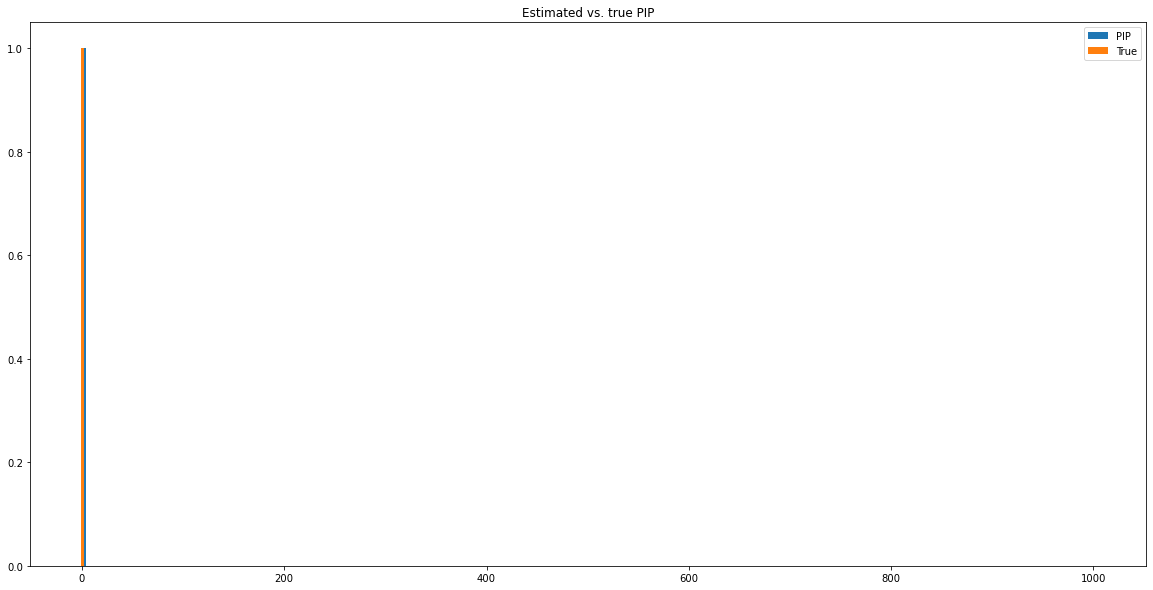

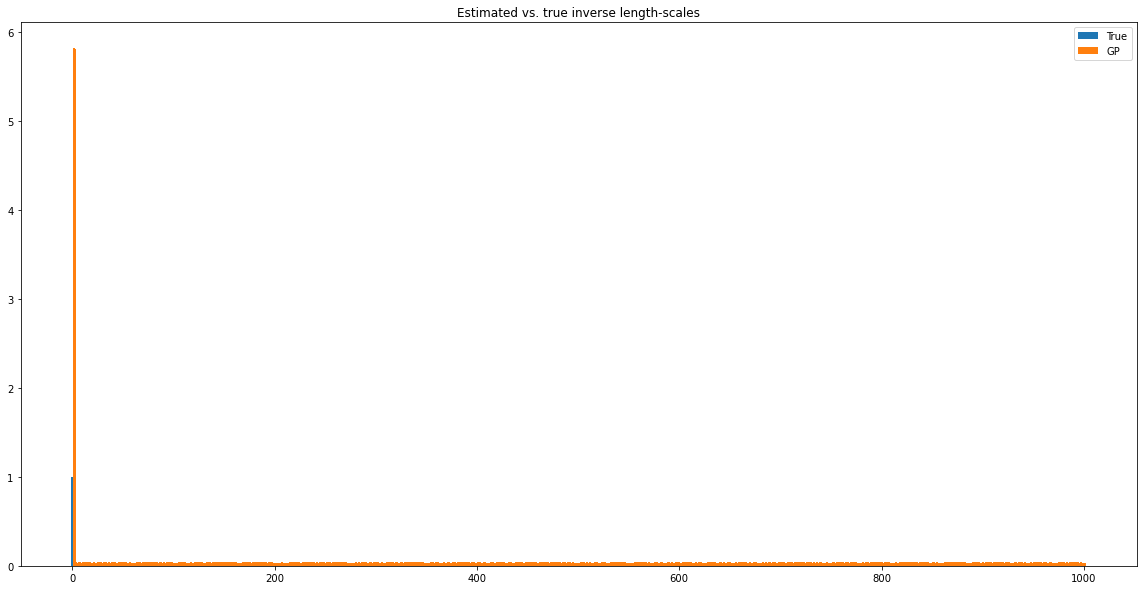

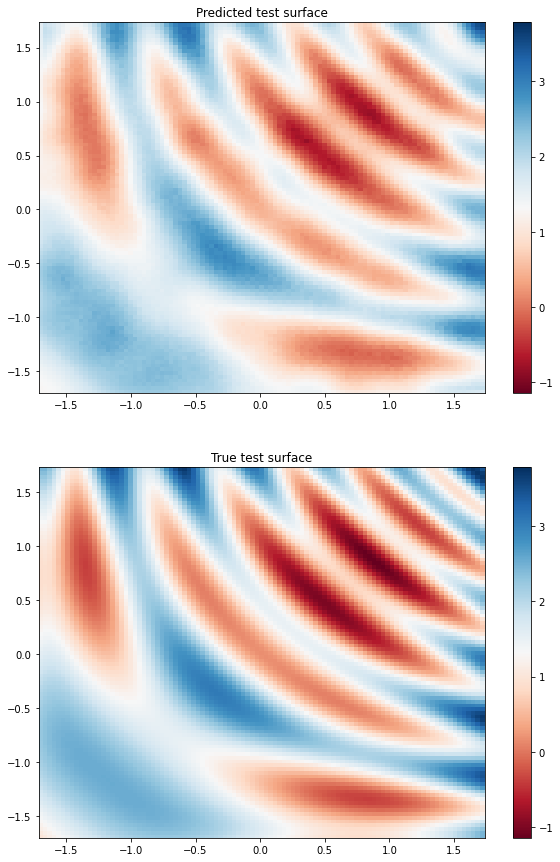

Latent test function MSE :  0.042318646
Observed test data  MSE :  0.34854883


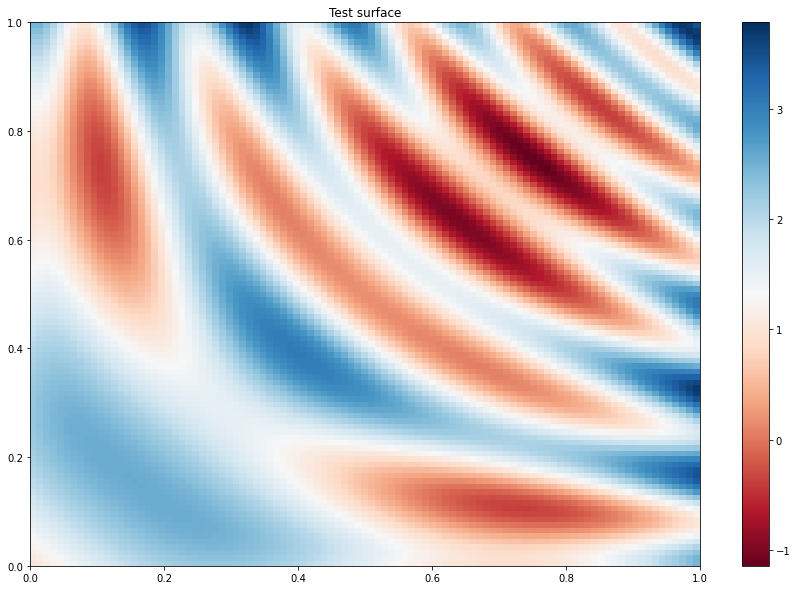

[7.0313716 7.0313706 7.0313725 7.0313725 7.0313716 7.0313716 7.0313716
 7.0313716 7.031372  7.031372 ]
3.023045539855957 0.0020497558
Iter 2 - Loss: 3.023
[7.1313553 7.131415  7.131418  7.1313725 7.131416  7.131417  7.1314106
 7.131417  7.1313543 7.1314173]
3.019432060718536 0.0019943716
Iter 3 - Loss: 2.662
[7.230702  7.2309675 7.2311187 7.230798  7.231372  7.2311296 7.231295
 7.231248  7.230949  7.231197 ]
3.0130984807729715 0.0019336052
Iter 4 - Loss: 2.386
[7.328555  7.328921  7.3295546 7.328881  7.3305287 7.3296385 7.330394
 7.3300185 7.3294864 7.3299503]
3.0048460650913706 0.0018614951
Iter 5 - Loss: 2.188
[7.423989  7.4242725 7.4258857 7.4248757 7.428024  7.4261465 7.42789
 7.4268613 7.426183  7.426874 ]
2.9951948527085843 0.0017783426
Iter 6 - Loss: 2.040
[7.51609   7.5160885 7.5194325 7.5181007 7.5230684 7.519935  7.523
 7.5210066 7.5202966 7.5212274]
2.984488093609828 0.0016866294
Iter 7 - Loss: 1.925
[7.604043  7.6035604 7.6096663 7.60799   7.6150155 7.6104026 7.615078
 7.61

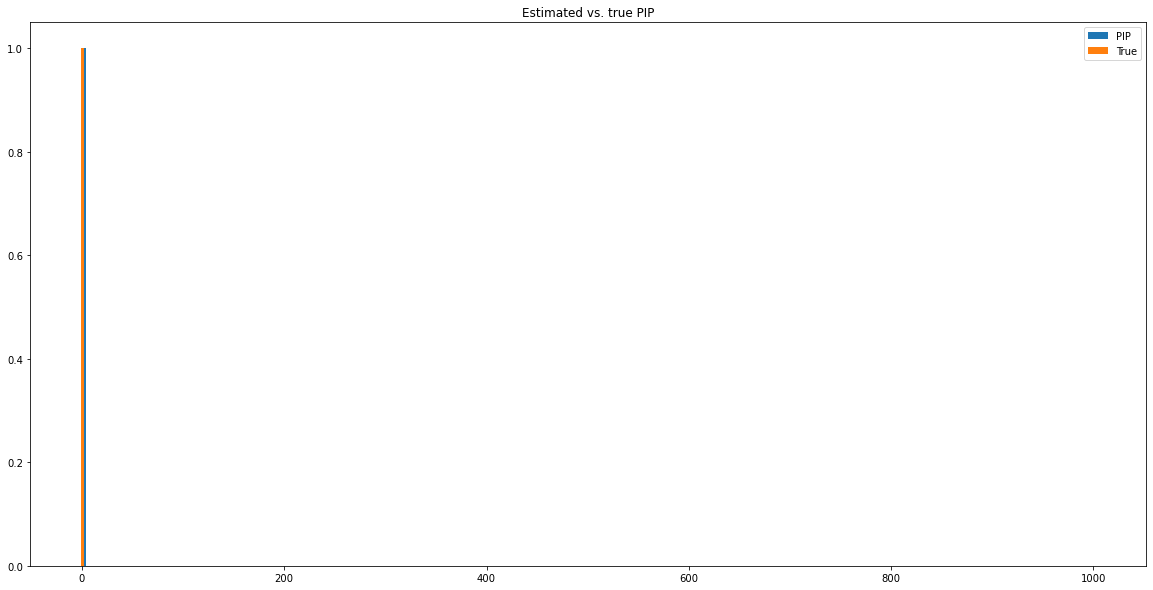

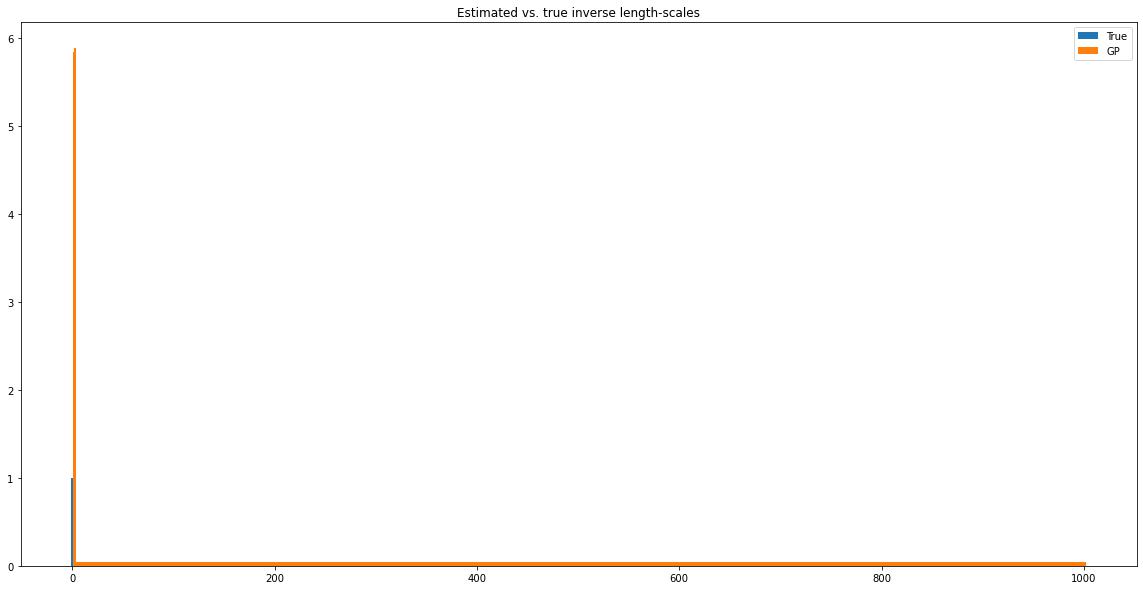

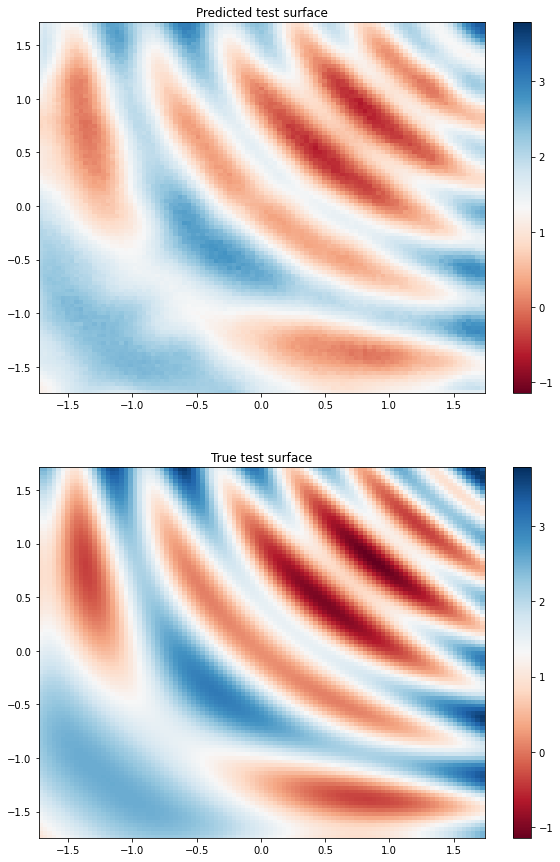

Latent test function MSE :  0.056280028
Observed test data  MSE :  0.35715634


[7.0298743 7.0312786 7.031294  7.0321045 7.0291104 7.030845  7.0295296
 7.031178  7.031425  7.030836 ]
2.855522632598877 0.0020359012


[7.1353416 7.1364284 7.1373935 7.136009  7.132846  7.13741   7.1330075
 7.1371536 7.137784  7.1374865]
2.8512364649772644 0.0021032176


[7.2419257 7.2439365 7.245414  7.241203  7.2412243 7.2469006 7.2396984
 7.246745  7.2466216 7.247969 ]
2.845145870423317 0.002087909


[7.346734  7.3491526 7.3521876 7.3450603 7.3467975 7.353079  7.3457994
 7.3545427 7.3542023 7.3560014]
2.838348381006956 0.0020105182


[7.446248  7.451661  7.457731  7.4460244 7.4509463 7.4581256 7.450283
 7.4576015 7.459962  7.4636874]
2.8298742921763633 0.0018990663


[7.539954  7.5447545 7.554734  7.5417986 7.546696  7.5559454 7.5463924
 7.554867  7.556451  7.563261 ]
2.8199375087119973 0.0017362484


[7.6228013 7.629239  7.644545  7.6315055 7.635554  7.647218  7.6375303
 7.6462708 7.647431  7.654439 ]
2.810099054769363 0.00156676


[7.696522  7.702765  7.729685  7.7129726 7.716032  7.7322326 7.71952
 7.7288504 7.7295723 7.7382674]
2.7999520322697653 0.0014056963


[7.7603116 7.7672267 7.808127  7.7888417 7.791293  7.807993  7.7962527
 7.806885  7.804779  7.818899 ]
2.7902650567697607 0.001268887


[7.8164215 7.823376  7.8772473 7.8588448 7.859089  7.8801246 7.8656116
 7.877706  7.87528   7.892627 ]
2.7796240913350436 0.0011481986


[7.867312  7.872378  7.943129  7.9241657 7.923945  7.9442363 7.9317985
 7.942346  7.9402432 7.9602165]
2.7683948601091166 0.0010423498


[7.906284  7.9080815 8.00284   7.9819975 7.9820147 8.003131  7.990925
 8.00057   8.000122  8.020664 ]
2.757488249297561 0.00093545305


[7.9376144 7.9401355 8.058568  8.035136  8.0359335 8.059322  8.046733
 8.05495   8.055646  8.079415 ]
2.7461532971958973 0.0008663808


[7.9611444 7.9599056 8.109107  8.086394  8.086994  8.108788  8.09955
 8.104351  8.106811  8.131414 ]
2.7349235633496094 0.0007796625


[7.9791517 7.9760756 8.158672  8.133122  8.13439   8.154455  8.150606
 8.151653  8.157073  8.184386 ]
2.723803007134677 0.00073632173


[7.9879766 7.979296  8.204562  8.1782675 8.178683  8.198693  8.196244
 8.195939  8.202113  8.230358 ]
2.712664461030158 0.00066440663


[7.9908276 7.9804134 8.248048  8.220305  8.218761  8.2406225 8.239289
 8.2364645 8.245513  8.274692 ]
2.7015102447416948 0.00062131765


[7.991865  7.9759617 8.288911  8.259724  8.259054  8.280079  8.281735
 8.276511  8.287047  8.318704 ]
2.6906068654788635 0.0006047853


[7.9854684 7.961103  8.327769  8.300114  8.296076  8.317734  8.321073
 8.313233  8.325099  8.361373 ]
2.6793888776117334 0.0005619228


[7.9714108 7.9442406 8.365445  8.33678   8.334217  8.353415  8.3599
 8.350161  8.36286   8.40143  ]
2.6681680660374596 0.000542013


[7.9522724 7.922491  8.4035425 8.373241  8.369715  8.387471  8.397529
 8.385131  8.399196  8.439795 ]
2.6572181051093695 0.00051458785


[7.932672  7.8983955 8.439725  8.407467  8.404573  8.420278  8.4357605
 8.419729  8.4345455 8.4770775]
2.6464388255742364 0.00049392646


[7.9075727 7.8664103 8.473422  8.441992  8.43733   8.451379  8.470745
 8.450949  8.468937  8.513829 ]
2.635779849849393 0.00047060693


[7.8775573 7.834879  8.508373  8.475477  8.470142  8.481723  8.506275
 8.484041  8.503138  8.548823 ]
2.6251911813424305 0.00046844804


[7.8465757 7.7950315 8.544461  8.508771  8.50298   8.512682  8.541892
 8.516571  8.537029  8.584522 ]
2.614559344993255 0.00045693936


[7.808734 7.750293 8.577276 8.540363 8.533685 8.541643 8.575328 8.547461
 8.569083 8.620034]
2.603707563103 0.00043413558


[7.7685776 7.7069316 8.609353  8.574101  8.566097  8.5708685 8.607947
 8.577266  8.601325  8.654381 ]
2.5930490329946596 0.0004325334


[7.730655  7.6565356 8.642242  8.606549  8.597369  8.598804  8.640286
 8.609593  8.633786  8.688552 ]
2.5829239134723605 0.000424365


[7.6857147 7.6022778 8.675222  8.637383  8.628437  8.625493  8.672653
 8.639978  8.66516   8.722692 ]
2.572629856098425 0.00041230657


[7.638058  7.5465226 8.705587  8.668474  8.657943  8.653744  8.704748
 8.668959  8.694601  8.754746 ]
2.5620836923106953 0.00040102124


[7.58538   7.4928966 8.738801  8.700359  8.689744  8.68007   8.737962
 8.699181  8.726879  8.788455 ]
2.551437624741455 0.00040597262


[7.534803 7.432126 8.770217 8.731515 8.720986 8.707404 8.76936  8.729412
 8.759038 8.822414]
2.5416255294922707 0.00040348445


[7.4772267 7.3699064 8.802235  8.761362  8.752709  8.73543   8.8031025
 8.759667  8.790543  8.856063 ]
2.531566151047476 0.00040287865


[7.4190774 7.30076   8.834471  8.793058  8.783046  8.761548  8.834946
 8.789081  8.820714  8.889611 ]
2.5214561124484547 0.00039031857


[7.3589954 7.2316437 8.86727   8.824224  8.814196  8.788853  8.868221
 8.820632  8.852189  8.923581 ]
2.5115167113982038 0.0003967735


[7.2923613 7.1573796 8.898446  8.8555765 8.84451   8.817231  8.899462
 8.848818  8.882748  8.95617  ]
2.5015104252809257 0.00038892453


[7.2273664 7.082472  8.930711  8.887437  8.875526  8.844139  8.932559
 8.879745  8.915314  8.989341 ]
2.491725704901102 0.00039255928


[7.156637  6.996797  8.964505  8.92082   8.907255  8.870789  8.965612
 8.912044  8.947459  9.0236845]
2.482032617344813 0.0003903402


[7.0801187 6.9139724 8.997358  8.952606  8.938587  8.896869  8.998795
 8.941467  8.979437  9.057013 ]
2.472324608971886 0.00038722044


[7.0034585 6.8236723 9.029476  8.985405  8.970373  8.9265785 9.031281
 8.973106  9.012102  9.090085 ]
2.4625879566054643 0.0003915801


[6.9181623 6.7316213 9.062997  9.0176935 9.002721  8.952914  9.063933
 9.002717  9.045346  9.123383 ]
2.453155482190777 0.0003837397


[6.83006   6.6340466 9.09505   9.052298  9.033991  8.981239  9.098538
 9.035254  9.076817  9.157021 ]
2.4437519259593388 0.00038770208


[6.74118  6.527695 9.127115 9.084759 9.067436 9.008445 9.131367 9.066692
 9.109732 9.190838]
2.4346586318679737 0.00038941306


[6.6437926 6.42182   9.161232  9.116588  9.100073  9.037717  9.165739
 9.099004  9.143068  9.22559  ]
2.4252644190539328 0.00038714314


[6.5422263 6.3001194 9.195378  9.150481  9.131375  9.06452   9.198217
 9.128913  9.176314  9.259189 ]
2.4159396043674066 0.00037783064


[6.4377065 6.184233  9.228664  9.185155  9.165147  9.092589  9.232558
 9.162155  9.209619  9.293176 ]
2.406493923638598 0.00039170298


[6.318423 6.056195 9.260265 9.216449 9.198207 9.118996 9.265745 9.192865
 9.241397 9.32713 ]
2.3977627572999323 0.0003723005


[6.2062798 5.917567  9.295818  9.251438  9.232158  9.149858  9.299499
 9.226459  9.274983  9.361588 ]
2.3891154980073437 0.00038505244


[6.0760446 5.770883  9.329103  9.284626  9.26456   9.178407  9.333526
 9.257689  9.308936  9.394981 ]
2.3800017816678647 0.0003812471


[5.942366 5.621269 9.36427  9.318309 9.298061 9.207406 9.367674 9.28987
 9.342909 9.429522]
2.3714724201984607 0.00038578024


[5.8039703 5.458931  9.398384  9.353086  9.331559  9.234945  9.403589
 9.323998  9.37741   9.4654045]
2.362646433198167 0.00038562363


[5.6562386 5.297462  9.433766  9.388979  9.365786  9.266529  9.437643
 9.357231  9.412618  9.500802 ]
2.3540652397859847 0.00038884432


[5.494995  5.1076674 9.469826  9.424095  9.401092  9.295833  9.473539
 9.391046  9.44697   9.536425 ]
2.3455868885470297 0.0003893857


[5.318317  4.905223  9.503989  9.458605  9.4341135 9.324295  9.507744
 9.422547  9.481787  9.56949  ]
2.3369332860208885 0.0003826031


[5.1330557 4.6996875 9.539974  9.493814  9.468991  9.353687  9.543598
 9.45822   9.516539  9.604984 ]
2.3288835961813095 0.00039015294


[4.937449  4.4764705 9.57365   9.529329  9.502757  9.382586  9.577618
 9.490929  9.550833  9.640334 ]
2.3205738211077866 0.00038786326


[4.7272882 4.230812  9.609605  9.565213  9.5386715 9.414891  9.614673
 9.523949  9.587478  9.676972 ]
2.3123799704470627 0.0004001108


[4.5053287 3.9830196 9.646919  9.603083  9.573994  9.445594  9.650967
 9.558764  9.624651  9.714086 ]
2.3044869372773973 0.00040643584


[4.2679653 3.7076309 9.683004  9.638188  9.608283  9.474925  9.687151
 9.593203  9.659203  9.748891 ]
2.296112120433005 0.0003965389


[4.0107617 3.4252062 9.718966  9.674005  9.644073  9.507891  9.723437
 9.627587  9.696358  9.786472 ]
2.288217382113654 0.00041443162


[3.7388754 3.108582  9.75833   9.712922  9.680119  9.540838  9.760196
 9.664683  9.733566  9.824155 ]
2.2801421750741335 0.000426499


[3.4439125 2.7946148 9.796368  9.750404  9.718199  9.574152  9.798609
 9.700865  9.771167  9.8614235]
2.2724411287372868 0.0004402897


[3.141764 2.464548 9.83431  9.790227 9.756306 9.607761 9.837672 9.738079
 9.809755 9.900223]
2.264927089659463 0.0004624435


[2.8123844 2.1360714 9.875228  9.829411  9.795038  9.641899  9.878208
 9.776719  9.8499365 9.939655 ]
2.257174520337194 0.00050119235


[2.4784362 1.8005328 9.917349  9.871261  9.835645  9.678955  9.919767
 9.816797  9.891814  9.981133 ]
2.2497274752032492 0.000546399


[ 2.132874   1.4761038  9.960449   9.915624   9.87767    9.718708
  9.96222    9.858033   9.936092  10.023183 ]
2.241888658684096 0.00061406865


[ 1.8112355  1.2034879 10.007984   9.961748   9.9252405  9.761714
 10.007891   9.904777   9.9839    10.069844 ]
2.233994054314281 0.00070067623


[ 1.5173794   0.98100805 10.059396   10.01317     9.975153    9.810989
 10.059247    9.955115   10.035709   10.120547  ]
2.2265276732460832 0.0007979299


[ 1.2751656   0.86386824 10.115296   10.070652   10.031875    9.865272
 10.115294   10.011439   10.092623   10.17585   ]
2.2192343990198786 0.0008185275


[ 1.0993013   0.85968536 10.176252   10.133297   10.092197    9.927902
 10.174924   10.072814   10.154515   10.235765  ]
2.2117993949840558 0.0007262695


[ 0.99624014  0.8709845  10.240403   10.200464   10.156789    9.993937
 10.238162   10.139219   10.220454   10.298939  ]
2.204660311718801 0.000733106


[ 0.9096378   0.89540243 10.307925   10.269228   10.223968   10.063914
 10.305907   10.207968   10.290199   10.365044  ]
2.197790091858525 0.00077652157


[ 0.86294824  0.89623713 10.379061   10.342419   10.293658   10.137648
 10.375611   10.27756    10.361991   10.435151  ]
2.1903983451624285 0.00072598865


[ 0.82565355  0.89908415 10.452855   10.418206   10.36721    10.213506
 10.447847   10.352211   10.43607    10.506682  ]
2.18310914881255 0.00073990144


[ 0.8232385   0.89062566 10.527874   10.494994   10.442341   10.291083
 10.522817   10.428361   10.513102   10.580357  ]
2.176165489184394 0.00070430874


[ 0.7962392  0.8565718 10.605371  10.574528  10.518669  10.371715
 10.600047  10.505884  10.591877  10.655685 ]
2.1688111710044335 0.00078608823


[ 0.7937099  0.8462082 10.685251  10.658002  10.600153  10.455644
 10.680549  10.586531  10.675176  10.735016 ]
2.161827024481462 0.00073396397


[ 0.7764932   0.84664404 10.767466   10.743254   10.68255    10.541776
 10.762514   10.669499   10.757996   10.815682  ]
2.154990517790267 0.0007528276


[ 0.75869864  0.82475924 10.8512745  10.830018   10.767303   10.630039
 10.846605   10.754515   10.844959   10.896668  ]
2.1476559258085466 0.0007917319


[ 0.7522907   0.80972135 10.938284   10.919259   10.853513   10.720142
 10.933373   10.841875   10.932283   10.981569  ]
2.14056947155954 0.0007709683


[ 0.7478416   0.79235834 11.027365   11.011004   10.942292   10.813848
 11.022137   10.929579   11.023582   11.068221  ]
2.133693447320858 0.00077950815


[ 0.73151773  0.7965352  11.117128   11.10489    11.031968   10.908642
 11.113138   11.0215025  11.117063   11.156469  ]
2.1275106754929896 0.0007799817


[ 0.7071592   0.78017265 11.211068   11.201327   11.126256   11.006223
 11.2077055  11.114802   11.21269    11.247081  ]
2.1206420364142224 0.0008354538


[ 0.719209   0.7768547 11.306053  11.299251  11.220134  11.104688
 11.302148  11.209896  11.308517  11.339348 ]
2.114178207431153 0.00078284636


[ 0.7073741   0.75658077 11.404055   11.400219   11.316774   11.207509
 11.399941   11.307312   11.408534   11.433088  ]
2.1075367000150447 0.00081951823


[ 0.69756716  0.74926585 11.502438   11.501599   11.413964   11.309801
 11.499503   11.405495   11.509777   11.529565  ]
2.100902470328737 0.0007897275


[ 0.6890026  0.7425744 11.601226  11.603979  11.514149  11.415117
 11.598933  11.503465  11.612881  11.62719  ]
2.0944245978738323 0.0007850666


[ 0.6796935  0.7368919 11.700262  11.706602  11.613713  11.519238
 11.700732  11.603979  11.716373  11.725512 ]
2.0879577097594737 0.0007801199


[ 0.6643596  0.7262684 11.804536  11.814402  11.7170725 11.625843
 11.803252  11.707673  11.822312  11.824989 ]
2.08139483574301 0.00080991886


[ 0.673024    0.72469485 11.910086   11.922121   11.820845   11.734579
 11.908969   11.812044   11.929801   11.927697  ]
2.0747440000259605 0.000770887


[ 0.6604927  0.70007   12.0162735 12.030548  11.92457   11.843709
 12.0153265 11.918097  12.035667  12.03003  ]
2.0678593260531515 0.00082150113


[ 0.66212076  0.69674873 12.120281   12.139069   12.028015   11.95305
 12.120845   12.021014   12.144573   12.133109  ]
2.0612072554290335 0.00073931715


[ 0.6484457  0.6936118 12.226808  12.248347  12.133407  12.064961
 12.228912  12.12663   12.254968  12.237002 ]
2.054606563547198 0.0007629943


[ 0.63728666  0.6860034  12.33622    12.359111   12.242261   12.175437
 12.338509   12.231235   12.365442   12.341019  ]
2.048053836258207 0.00076379476


[ 0.63601977  0.68108034 12.443345   12.470809   12.350501   12.288153
 12.445905   12.336775   12.475726   12.446152  ]
2.0415912517683057 0.00071867846


[ 0.6271078  0.6687    12.549228  12.580098  12.453518  12.395943
 12.552001  12.440956  12.5835    12.548904 ]
2.0349696159649477 0.0007292826


[ 0.6169582  0.6640751 12.657558  12.688658  12.559349  12.50592
 12.657195  12.546297  12.693414  12.65149  ]
2.028470034150849 0.00070930336


[ 0.62024546  0.65258044 12.763098   12.795461   12.6640835  12.615536
 12.763201   12.648623   12.802083   12.751705  ]
2.022141818603957 0.0006904361


[ 0.6109136   0.64738756 12.86936    12.904644   12.7666645  12.72572
 12.867912   12.750245   12.909335   12.854173  ]
2.0158974833856758 0.0006801371


[ 0.60163665  0.64751667 12.972936   13.010669   12.867241   12.830249
 12.971238   12.848485   13.014938   12.953368  ]
2.009730281680328 0.0006460154


[ 0.59655994  0.63415563 13.076519   13.117433   12.970151   12.936274
 13.072519   12.947599   13.122031   13.054611  ]
2.0034301690528866 0.00065268774


[ 0.59683836  0.6403261  13.17881    13.221113   13.0678835  13.040411
 13.174438   13.044613   13.224974   13.151041  ]
1.996849142327644 0.00060464465


[ 0.59560007  0.6300783  13.278878   13.324281   13.166224   13.140985
 13.274814   13.1395235  13.327893   13.246216  ]
1.9903255239989261 0.00059764157


[ 0.58256793  0.6106845  13.377022   13.4244375  13.261516   13.239222
 13.369895   13.232435   13.428271   13.341032  ]
1.9843932541715343 0.00063111936


[ 0.5775803  0.6124791 13.475095  13.522802  13.356592  13.338425
 13.465659  13.325099  13.526043  13.432374 ]
1.978602761723813 0.0005526795


[ 0.58361346  0.6093384  13.570154   13.620623   13.4503145  13.43538
 13.561853   13.416135   13.621341   13.523466  ]
1.9724953909230576 0.0005444406


[ 0.57156146  0.59883267 13.666028   13.718966   13.540788   13.529843
 13.655003   13.504279   13.717165   13.609495  ]
1.966238933813296 0.00056525046


[ 0.56493056  0.5927662  13.755746   13.810675   13.627957   13.622236
 13.744181   13.590911   13.810392   13.698488  ]
1.9605029515739332 0.000516968


[ 0.5600737  0.5936011 13.847719  13.903988  13.716218  13.713747
 13.835343  13.677766  13.903887  13.784259 ]
1.9544931633664062 0.0004902223


[ 0.5542899   0.57970744 13.936957   13.992651   13.802777   13.803323
 13.92094    13.760123   13.993697   13.868235  ]
1.9485934455751341 0.000510439


[ 0.54771215  0.57994026 14.024532   14.083442   13.888988   13.890622
 14.009517   13.842623   14.083191   13.952723  ]
1.9426333678527048 0.00046957756


[ 0.5435281  0.5691891 14.109334  14.170915  13.968919  13.97511
 14.092271  13.923411  14.172153  14.030669 ]
1.9368363133108355 0.00046746092


[ 0.531646    0.56405723 14.193775   14.258247   14.052194   14.058009
 14.176325   14.00089    14.259513   14.110553  ]
1.9307861741309742 0.0004752056


[ 0.53374815  0.5575869  14.277397   14.343594   14.133566   14.141486
 14.259534   14.078454   14.343985   14.191394  ]
1.9250617519782112 0.00043052644


[ 0.53036505  0.55450237 14.361201   14.430485   14.212335   14.223672
 14.340738   14.156555   14.429001   14.268262  ]
1.9194433294543092 0.00042216366


[ 0.51750505  0.5468177  14.442281   14.510789   14.2885     14.302536
 14.418767   14.231372   14.50984    14.343093  ]
1.9135567143341283 0.00045360718


[ 0.51042855  0.54387563 14.521558   14.594338   14.368059   14.381189
 14.4964075  14.308478   14.593297   14.418716  ]
1.9081769824855106 0.00041410697


[ 0.505681   0.5333485 14.599342  14.67691   14.443034  14.45922
 14.578558  14.3838625 14.674369  14.494091 ]
1.9026254300697893 0.00042172917


[ 0.50256056  0.5235084  14.676288   14.755628   14.517415   14.537486
 14.652476   14.456021   14.752007   14.567012  ]
1.8968003588497648 0.00040309379


[ 0.49200496  0.52364653 14.755102   14.836359   14.592726   14.615472
 14.729305   14.53089    14.83487    14.640575  ]
1.8913956627849946 0.00040411032


[ 0.49212718  0.5137138  14.8293705  14.913329   14.664859   14.690123
 14.802729   14.600584   14.910117   14.713609  ]
1.886230869307932 0.00037258893


[ 0.481997    0.50761336 14.907535   14.994549   14.7417965  14.76905
 14.878536   14.677321   14.991289   14.787033  ]
1.8808934779789732 0.00041320102


[ 0.48175466  0.50783277 14.984134   15.071337   14.814102   14.846084
 14.9546175  14.751313   15.067624   14.858764  ]
1.875269134730937 0.00033848826


[ 0.46861997  0.49248117 15.0569315  15.146989   14.883562   14.919258
 15.026441   14.82294    15.142866   14.929167  ]
1.86990097035163 0.00044022937


[ 0.465265    0.49525824 15.131898   15.224509   14.95576    14.993357
 15.099992   14.891656   15.219764   14.999052  ]
1.8643231340299193 0.00035188426


[ 0.4551     0.4864407 15.204849  15.300372  15.026804  15.065819
 15.172603  14.960948  15.295316  15.066257 ]
1.8588251086641991 0.0003977143


[ 0.44618464  0.47320944 15.279601   15.375821   15.097054   15.140468
 15.247171   15.032102   15.372723   15.136518  ]
1.8529914445126006 0.00041566254


[ 0.43918762  0.4739396  15.352893   15.451104   15.165073   15.213861
 15.318235   15.102545   15.445773   15.208484  ]
1.8476082559604952 0.00034963575


[ 0.4387087  0.4647287 15.4255905 15.527717  15.236828  15.287095
 15.3920355 15.172448  15.521851  15.279055 ]
1.84227642450906 0.0003547453


[ 0.42738622  0.4553277  15.499193   15.603408   15.306231   15.358572
 15.461569   15.240379   15.59594    15.348369  ]
1.8372483522080916 0.00040280688


[ 0.4174029  0.451853  15.574096  15.679678  15.378058  15.432802
 15.536593  15.313207  15.671753  15.419387 ]
1.8318777481396697 0.00037949556


[ 0.41333336  0.43964872 15.646552   15.752153   15.445643   15.502583
 15.607582   15.38209    15.742909   15.488838  ]
1.8266965305490201 0.0003763813


[ 0.4083661   0.43465817 15.717642   15.827927   15.517098   15.575235
 15.681893   15.4528055  15.8171015  15.559228  ]
1.8213270996139521 0.00035375362


[ 0.40259078  0.4253475  15.789572   15.90284    15.587541   15.647739
 15.75404    15.524278   15.89257    15.627963  ]
1.816292729098083 0.00037565565


[ 0.39287305  0.42394367 15.864868   15.978697   15.657604   15.720851
 15.826806   15.593112   15.967374   15.699573  ]
1.8114353025528755 0.00036191114


[ 0.38587624  0.4137217  15.93657    16.052832   15.72928    15.793438
 15.899219   15.665141   16.040892   15.770081  ]
1.8063169686523315 0.00039265968


[ 0.37790248  0.4064348  16.009985   16.129087   15.798126   15.867022
 15.97423    15.737035   16.116007   15.840572  ]
1.8011322538894379 0.000387245


[ 0.3705305   0.39728594 16.081596   16.205828   15.870645   15.941564
 16.045301   15.809442   16.190542   15.911247  ]
1.7960266124838136 0.0003945554


[ 0.36546636  0.38870132 16.156929   16.28071    15.941512   16.01349
 16.119854   15.881674   16.264597   15.98216   ]
1.7913653156277742 0.00037706934


[ 0.35694623  0.3860398  16.229574   16.356752   16.01161    16.091206
 16.193193   15.95389    16.344152   16.054764  ]
1.7862991909291381 0.00036590075


[ 0.34470585  0.37580547 16.304373   16.431816   16.082273   16.165257
 16.26579    16.027323   16.418081   16.128061  ]
1.7813541479811046 0.0004524344


[ 0.34004617  0.3687135  16.378918   16.509592   16.152674   16.24149
 16.342253   16.102388   16.494982   16.20052   ]
1.776600927117062 0.00037300936


[ 0.3304688   0.35837147 16.452538   16.587069   16.227009   16.31902
 16.418457   16.176092   16.570478   16.27422   ]
1.7718148604060873 0.00044648474


[ 0.326743    0.35071027 16.527143   16.665731   16.299875   16.396738
 16.4951     16.252619   16.647663   16.350058  ]
1.7669559931035248 0.00038040537


[ 0.3153865   0.34067222 16.604486   16.7452     16.372156   16.474438
 16.570795   16.329754   16.725464   16.423279  ]
1.7620007392885937 0.00047770998


[ 0.30579758  0.3336034  16.679688   16.824156   16.447681   16.553768
 16.649824   16.40726    16.803968   16.499218  ]
1.7570811656267868 0.00044723868


[ 0.29349434  0.3194839  16.756945   16.905905   16.522985   16.637161
 16.732101   16.484274   16.88414    16.577244  ]
1.7526683904409321 0.00055830344


[ 0.28420004  0.30884704 16.8374     16.990566   16.602041   16.722399
 16.81493    16.564833   16.967016   16.657324  ]
1.7477459943993006 0.0005148011


[ 0.2720171   0.29619107 16.916662   17.076855   16.68462    16.807383
 16.897865   16.65068    17.049467   16.740324  ]
1.7426900232172093 0.00059377955


[ 0.26563984  0.28854427 17.002592   17.163412   16.770208   16.898502
 16.985022   16.736311   17.137033   16.826427  ]
1.7379550868960938 0.00048440063


[ 0.25114235  0.27282304 17.087696   17.25233    16.853056   16.989367
 17.071693   16.821241   17.22305    16.911314  ]
1.7332277424480313 0.0007214841


[ 0.2479183   0.26225853 17.175781   17.344732   16.939178   17.083279
 17.16267    16.9129     17.31328    17.002136  ]
1.728654914505515 0.000513961


[ 0.2326498   0.24960254 17.264912   17.436789   17.028416   17.179506
 17.253746   17.002699   17.404707   17.091488  ]
1.7242338813078018 0.00077380287


[ 0.23001473  0.24141581 17.35922    17.533552   17.122152   17.281004
 17.352098   17.101389   17.50113    17.187977  ]
1.7194572531346775 0.00051500014


[ 0.2231929   0.23038153 17.455942   17.633759   17.218489   17.383646
 17.449306   17.200054   17.599293   17.285595  ]
1.7147087217105086 0.000664487


[ 0.21688165  0.2208397  17.552042   17.733824   17.31604    17.488422
 17.547997   17.30143    17.696642   17.384829  ]
1.7103871974473523 0.0006503928


[ 0.20948     0.21690294 17.650898   17.83703    17.415316   17.595463
 17.649878   17.403404   17.799585   17.486036  ]
1.705731254855203 0.00058183365


[ 0.2085621   0.21364352 17.751963   17.941013   17.5163     17.703573
 17.752705   17.508663   17.900536   17.59004   ]
1.7009574880391491 0.0004279663


[ 0.20521279  0.20520908 17.849005   18.046      17.614569   17.809448
 17.856064   17.61015    18.003307   17.692776  ]
1.6964922590144704 0.0006007936


[ 0.20007764  0.20474239 17.950151   18.151365   17.71743    17.92044
 17.959269   17.713814   18.106195   17.79712   ]
1.6916133225617158 0.0004667817


[ 0.20098013  0.20162329 18.048407   18.25552    17.816807   18.028154
 18.061123   17.816975   18.207195   17.898525  ]
1.6869180989315882 0.0004192457


[ 0.19535281  0.19679841 18.14707    18.358374   17.915167   18.13517
 18.16289    17.91967    18.310917   17.999853  ]
1.6821232144167289 0.00058287574


[ 0.19650196  0.1987018  18.24735    18.462973   18.017553   18.24362
 18.267282   18.023296   18.413778   18.102661  ]
1.6772974337229096 0.00039635735


[ 0.19346824  0.19331773 18.3431     18.564295   18.114456   18.348043
 18.366522   18.12517    18.514055   18.204416  ]
1.6726597123382563 0.00052627083


[ 0.19272515  0.19155966 18.440638   18.665297   18.211504   18.455275
 18.467024   18.227518   18.61618    18.303944  ]
1.6677949378200068 0.00037154555


[ 0.18770285  0.18951638 18.537909   18.767952   18.309786   18.561283
 18.566597   18.327848   18.715912   18.404436  ]
1.6629726252769048 0.0004942548


[ 0.19294658  0.19153264 18.634796   18.868704   18.40913    18.666622
 18.66598    18.429682   18.818266   18.504581  ]
1.6584873263236353 0.00049734156


[ 0.18666378  0.18740653 18.731106   18.970224   18.50565    18.771343
 18.765457   18.527618   18.918484   18.603104  ]
1.6535290435507402 0.0005776538


[ 0.1871569  0.1884266 18.826077  19.070772  18.6025    18.87505
 18.8633    18.62734   19.016375  18.701937 ]
1.6489040056863387 0.00032779528


[ 0.18804468  0.1857759  18.917973   19.167826   18.696161   18.976074
 18.960281   18.722502   19.11385    18.798445  ]
1.6442313456534317 0.00037540848


[ 0.1860387   0.18883337 19.010576   19.266323   18.791075   19.07812
 19.05671    18.819931   19.213614   18.893978  ]
1.6392717501877725 0.0004187455


[ 0.18577318  0.18493842 19.102993   19.363417   18.885668   19.178642
 19.15092    18.915121   19.310438   18.989836  ]
1.6345055599953127 0.0003853548


[ 0.1846226  0.1849345 19.193504  19.46036   18.976698  19.27816
 19.246256  19.006779  19.405788  19.085005 ]
1.6298858943527874 0.0002946408


[ 0.18431525  0.18503787 19.285358   19.555681   19.068073   19.375921
 19.340889   19.101095   19.501137   19.177748  ]
1.625327147713947 0.00026900464


[ 0.18468359  0.18263008 19.376093   19.650059   19.159216   19.472233
 19.431736   19.19379    19.59675    19.270327  ]
1.6208645320881716 0.0003333864


[ 0.18445474  0.18422066 19.465418   19.743696   19.24885    19.568895
 19.524809   19.283695   19.690876   19.362303  ]
1.615962722180269 0.00030182354


[ 0.18344855  0.18501014 19.55335    19.836065   19.336994   19.66422
 19.617434   19.374695   19.783741   19.451862  ]
1.6110862017623604 0.0002949075


[ 0.18094127  0.18154043 19.639936   19.925686   19.422844   19.757402
 19.705746   19.461897   19.874634   19.542025  ]
1.6067367046815655 0.00041184953


[ 0.18428996  0.18289328 19.726667   20.015633   19.509617   19.852552
 19.79552    19.550402   19.965914   19.632505  ]
1.6022537459179835 0.00037519928


[ 0.18181717  0.18178655 19.81173    20.105295   19.593363   19.94475
 19.883453   19.63752    20.05638    19.719503  ]
1.5976317912491784 0.00033435732


[ 0.18168934  0.182582   19.895966   20.192156   19.676119   20.035645
 19.971014   19.723124   20.143885   19.805683  ]
1.5931647726149458 0.00024836953


[ 0.1808931   0.17948632 19.97861    20.280722   19.76111    20.125643
 20.056843   19.8076     20.232939   19.890558  ]
1.588620245374102 0.00033676153


[ 0.18291995  0.18231444 20.063438   20.367384   19.843798   20.21486
 20.14218    19.892225   20.319302   19.97717   ]
1.5839342861549954 0.00036340102


[ 0.17888834  0.18014126 20.144312   20.453068   19.925604   20.301374
 20.227283   19.976454   20.405315   20.060474  ]
1.5797063953961066 0.00039909838


[ 0.18126674  0.17731604 20.22576    20.53792    20.006855   20.387833
 20.31095    20.05681    20.492071   20.144096  ]
1.575491814495353 0.0003681175


[ 0.17966072  0.18183821 20.306475   20.622475   20.08643    20.475018
 20.39456    20.139982   20.577103   20.226578  ]
1.5712153991007962 0.00039400673


[ 0.18103197  0.17963035 20.386099   20.705881   20.166304   20.56084
 20.475807   20.218552   20.659044   20.30886   ]
1.5668025023882306 0.00030752688


[ 0.17884146  0.17919904 20.46435    20.786552   20.244135   20.643383
 20.555927   20.297186   20.741909   20.38985   ]
1.5624657220714557 0.00027479802


[ 0.18130128  0.17976992 20.541601   20.870398   20.322645   20.728096
 20.635662   20.375198   20.82435    20.469843  ]
1.558315823237353 0.00028483933


[ 0.18003409  0.18070127 20.61792    20.952126   20.401321   20.809378
 20.714645   20.452898   20.906746   20.546741  ]
1.5541364020731558 0.00025652171


[ 0.17965396  0.18114921 20.694828   21.03328    20.478607   20.89153
 20.793009   20.529066   20.987497   20.627151  ]
1.549737609024867 0.00021009221


[ 0.179011   0.1799364 20.772394  21.111576  20.551128  20.972187
 20.871489  20.607084  21.067574  20.703629 ]
1.5451007141968254 0.00023776719


[ 0.17909524  0.17871656 20.848053   21.190765   20.625793   21.05403
 20.949402   20.682571   21.148027   20.780844  ]
1.5406246459243336 0.00022148794


[ 0.1795721   0.17930014 20.922342   21.267986   20.698889   21.131063
 21.024282   20.756395   21.225761   20.856949  ]
1.5368690523505273 0.00020669292


[ 0.17867252  0.17935942 20.996084   21.34636    20.772268   21.210615
 21.102669   20.830502   21.304607   20.932789  ]
1.5327664622336687 0.000203832


[ 0.17890349  0.1789561  21.069616   21.421267   20.84493    21.288801
 21.177782   20.90252    21.381392   21.006786  ]
1.5285744973603248 0.00018756195


[ 0.18064061  0.17900462 21.143225   21.498755   20.917355   21.36597
 21.253717   20.975286   21.459122   21.081266  ]
1.5241602271296109 0.00022367998


[ 0.17672347  0.17843239 21.214352   21.57174    20.98871    21.442144
 21.325945   21.047718   21.53558    21.153515  ]
1.5201101503176042 0.00030428544


[ 0.17832774  0.17840266 21.284105   21.645746   21.05962    21.5182
 21.399302   21.117615   21.611086   21.227041  ]
1.5159407098480584 0.00021372303


[ 0.17875123  0.1784651  21.355888   21.719744   21.130577   21.592993
 21.47153    21.188606   21.685411   21.300278  ]
1.5120983889693653 0.00017606342


[ 0.17874387  0.17656438 21.42736    21.794744   21.20013    21.668196
 21.544346   21.259142   21.76071    21.37103   ]
1.5080684275711267 0.00021853462


[ 0.17669491  0.17821118 21.495674   21.867546   21.270483   21.742373
 21.615812   21.329115   21.834686   21.442804  ]
1.5044608291756951 0.00027282175


[ 0.17984957  0.17932662 21.565466   21.941826   21.337925   21.817894
 21.689169   21.397394   21.909735   21.51425   ]
1.5005694527431452 0.0002876193


[ 0.17673066  0.17781109 21.634819   22.01223    21.404802   21.890802
 21.760374   21.465885   21.981909   21.583073  ]
1.496485683522034 0.00029650496


[ 0.178807    0.17620113 21.70201    22.083033   21.47313    21.963278
 21.828955   21.534868   22.054344   21.65349   ]
1.492487345804169 0.00026510382


[ 0.18062451  0.17898968 21.771666   22.155107   21.542164   22.03643
 21.900272   21.601997   22.126421   21.723125  ]
1.4886553592708711 0.00029234134


[ 0.17736389  0.1757085  21.83677    22.225304   21.606983   22.106773
 21.968988   21.66923    22.19757    21.789858  ]
1.484903870041642 0.0003477003


[ 0.17675583  0.17819643 21.904808   22.295448   21.672716   22.176182
 22.037601   21.735624   22.26809    21.858799  ]
1.4806858752522056 0.00024243734


[ 0.17842631  0.17851299 21.972641   22.365475   21.740416   22.247845
 22.107906   21.801937   22.340363   21.926678  ]
1.4767270439674112 0.0002064318


[ 0.17579573  0.17522143 22.034693   22.434141   21.805332   22.317627
 22.173521   21.866632   22.408735   21.99351   ]
1.4727550365797237 0.00032527608


[ 0.17782807  0.17699079 22.100763   22.503887   21.871986   22.390335
 22.243128   21.93422    22.480057   22.062202  ]
1.4687623721449414 0.00026256355


[ 0.17874008  0.17867027 22.165083   22.571022   21.936102   22.45984
 22.309608   21.998678   22.549452   22.128586  ]
1.4651619121102442 0.00021741548


[ 0.17535439  0.17535123 22.229002   22.63905    21.999403   22.526937
 22.375498   22.061396   22.616842   22.193037  ]
1.4619193849386047 0.00034663858


[ 0.18011217  0.17879598 22.290892   22.707378   22.063168   22.59681
 22.443712   22.127275   22.68612    22.26037   ]
1.4584546746459661 0.00039447803


[ 0.17656355  0.17425826 22.356455   22.771317   22.128046   22.663946
 22.507957   22.190163   22.753937   22.324856  ]
1.4553043885062722 0.00038581542


[ 0.1769941  0.1783371 22.418974  22.838148  22.191103  22.730576
 22.574472  22.254227  22.821478  22.388653 ]
1.451826104581384 0.0002746264


[ 0.17725481  0.17862774 22.48361    22.905054   22.253218   22.79958
 22.639223   22.316862   22.888412   22.453342  ]
1.447924367755083 0.00014574689


[ 0.17704523  0.17634133 22.544231   22.969633   22.314268   22.86611
 22.702854   22.377861   22.954828   22.51553   ]
1.4442605573413108 0.0002038737


[ 0.17750035  0.17739294 22.607397   23.03408    22.375591   22.931063
 22.76728    22.440556   23.02004    22.581013  ]
1.4407663451127768 0.00017210378


[ 0.17928058  0.17640556 22.670134   23.099768   22.438843   22.998306
 22.832035   22.50319    23.08789    22.643715  ]
1.4369177136249973 0.00021253026


[ 0.17459486  0.17688118 22.729727   23.164095   22.499073   23.063854
 22.895525   22.563837   23.153679   22.704771  ]
1.433840684125161 0.0002855665


[ 0.17857255  0.17806485 22.792389   23.228481   22.561083   23.131102
 22.958193   22.625868   23.218876   22.767574  ]
1.4305365060856368 0.0002868437


[ 0.17619643  0.17536819 22.85223    23.291521   22.620508   23.194666
 23.020689   22.685518   23.284277   22.830557  ]
1.4268857216178894 0.00027994977


[ 0.17903012  0.17742267 22.912693   23.354002   22.681696   23.258722
 23.083944   22.74526    23.347582   22.8914    ]
1.4235772275513534 0.0002739761


[ 0.17761882  0.17546245 22.970758   23.416185   22.74177    23.321568
 23.144934   22.805925   23.412647   22.952372  ]
1.4199254246304693 0.00022331464


[ 0.1761536   0.17642286 23.03113    23.479778   22.8015     23.384245
 23.207184   22.863901   23.477951   23.012602  ]
1.4163170395724733 0.00019368141


[ 0.17813265  0.17655626 23.09142    23.541874   22.860449   23.446733
 23.269014   22.924488   23.54245    23.074291  ]
1.4129793815859588 0.00018308658


[ 0.17644033  0.17621343 23.151123   23.604502   22.918877   23.510275
 23.328833   22.984268   23.604975   23.13289   ]
1.4101207045036503 0.00017669043


[ 0.17554332  0.1763959  23.20986    23.66557    22.979065   23.573635
 23.390112   23.041697   23.668869   23.193005  ]
1.406746771876491 0.00014612918


[ 0.1792476   0.17607726 23.268206   23.727816   23.038307   23.63629
 23.452002   23.100498   23.732374   23.253553  ]
1.4035085764279287 0.0002399468


[ 0.17537385  0.17652269 23.327755   23.787783   23.09522    23.69734
 23.511889   23.157906   23.794956   23.314026  ]
1.4005276381455678 0.00024663264


[ 0.17723875  0.17634097 23.384203   23.84848    23.15038    23.758448
 23.570513   23.21431    23.857439   23.372349  ]
1.3972781033603339 0.00017343478


[ 0.17699221  0.17549984 23.442122   23.910725   23.208073   23.821304
 23.631878   23.272474   23.921362   23.432545  ]
1.3941734079495178 0.00014386234


[ 0.17811273  0.17745642 23.498001   23.971138   23.265537   23.882467
 23.691519   23.33005    23.981924   23.490913  ]
1.391109891090329 0.00020425467


[ 0.17597516  0.17669843 23.556498   24.030321   23.3242     23.943968
 23.749277   23.385536   24.04249    23.549593  ]
1.3880642277797066 0.0001970903


[ 0.17625953  0.17669919 23.613934   24.091785   23.382208   24.00524
 23.808826   23.442747   24.104258   23.608257  ]
1.3849913643372063 0.000115523595


[ 0.17683977  0.17456044 23.671043   24.15063    23.435942   24.06489
 23.86703    23.50064    24.164879   23.664392  ]
1.3819219496753101 0.00019038541


[ 0.17660724  0.17658073 23.727833   24.210472   23.492788   24.12657
 23.927078   23.556314   24.226261   23.722952  ]
1.3789481636521441 0.00017653113


[ 0.17629275  0.17526622 23.784294   24.270807   23.547846   24.186188
 23.984417   23.61292    24.285536   23.781033  ]
1.3759146167308938 0.0001537433


[ 0.17644504  0.17751037 23.840029   24.330406   23.604774   24.247643
 24.043478   23.671015   24.345648   23.837444  ]
1.372816576673204 0.00017872785


[ 0.17573206  0.17620961 23.896193   24.388306   23.658123   24.306692
 24.10121    23.723652   24.404943   23.894848  ]
1.3697498746439596 0.00016366219


[ 0.1774113   0.17464449 23.952454   24.44768    23.71393    24.365105
 24.16039    23.777918   24.465336   23.950645  ]
1.3664931939688854 0.0002037977


[ 0.17648914  0.17492978 24.008923   24.50553    23.769567   24.424894
 24.21842    23.83323    24.525465   24.006895  ]
1.3636504902224795 0.00013751422


[ 0.17678164  0.17719898 24.066257   24.563604   23.82539    24.485012
 24.274979   23.887445   24.586359   24.062845  ]
1.3607828590118134 0.00018183429


[ 0.17525597  0.17520042 24.118538   24.620646   23.880503   24.542032
 24.331558   23.942768   24.645067   24.117334  ]
1.3582985290999026 0.00020866787


[ 0.17687826  0.17589803 24.17354    24.677813   23.935389   24.601923
 24.388435   23.996943   24.702415   24.174892  ]
1.355776123824086 0.00017162316


[ 0.17746754  0.17528436 24.227766   24.736708   23.989964   24.659147
 24.445671   24.050999   24.762094   24.231012  ]
1.3526571397941733 0.0001327632


[ 0.17611311  0.17534675 24.28192    24.79583    24.044813   24.718126
 24.502785   24.105913   24.821924   24.286251  ]
1.3497812126985997 0.00014014087


[ 0.17667012  0.17621209 24.337765   24.85202    24.096886   24.775742
 24.559166   24.160254   24.879662   24.342308  ]
1.3471143167379194 0.000139218


[ 0.17593592  0.17487733 24.393673   24.908329   24.1524     24.832415
 24.617922   24.213999   24.938025   24.396427  ]
1.344430550928023 0.00016094506


[ 0.17576647  0.17778032 24.446587   24.965258   24.205906   24.891062
 24.673676   24.266766   24.997263   24.450752  ]
1.3418339724790607 0.00019079729


[ 0.177018    0.17664224 24.500422   25.022472   24.259163   24.948282
 24.728123   24.320864   25.05633    24.504726  ]
1.3389323478040136 0.00016816311


[ 0.17522347  0.17349587 24.552776   25.077888   24.311468   25.00477
 24.783636   24.373129   25.11335    24.558722  ]
1.3364400480037992 0.00024988025


[ 0.17838036  0.17637005 24.608408   25.13655    24.365826   25.064217
 24.840364   24.426527   25.171722   24.615398  ]
1.3333342327383761 0.0002871385


[ 0.17508647  0.17417136 24.662777   25.192343   24.415863   25.120619
 24.895092   24.480904   25.22888    24.66945   ]
1.3306458329330413 0.00026594286


[ 0.17756122  0.17686303 24.717255   25.247267   24.470179   25.17696
 24.951254   24.531853   25.28738    24.723848  ]
1.3279749222416501 0.00025652035


[ 0.17614646  0.17425361 24.767918   25.302334   24.522297   25.232151
 25.006464   24.582998   25.34397    24.77662   ]
1.3253329498708877 0.000216644


[ 0.17636633  0.17656244 24.821978   25.359097   24.574669   25.290302
 25.061829   24.637566   25.401495   24.832195  ]
1.3228176379312302 0.00017029383


[ 0.17596355  0.17434344 24.875402   25.414314   24.627022   25.346724
 25.11613    24.68953    25.45799    24.886381  ]
1.319964614378227 0.00017226562


[ 0.17789473  0.17576164 24.92949    25.469181   24.677515   25.401825
 25.170671   24.73966    25.515396   24.939985  ]
1.3174573500932705 0.00019351854


[ 0.17544623  0.17437105 24.982758   25.525063   24.72999    25.458717
 25.225578   24.794382   25.57381    24.99401   ]
1.3147386150341864 0.00021031662


[ 0.17656365  0.17598577 25.035112   25.58039    24.782377   25.514938
 25.280596   24.84347    25.628828   25.044235  ]
1.3121815234833776 0.00017311108


[ 0.17717208  0.17542051 25.08562    25.635664   24.83417    25.57096
 25.334661   24.895464   25.686928   25.096497  ]
1.309587299953866 0.00012221627


[ 0.17518738  0.17452615 25.136929   25.69014    24.883118   25.626326
 25.386654   24.947119   25.742702   25.149714  ]
1.3068402702904327 0.0001765605


[ 0.17596072  0.17518428 25.189022   25.744      24.93553    25.682142
 25.440306   24.998373   25.798832   25.202179  ]
1.3042012570643045 0.00012966299


[ 0.17716654  0.17510638 25.241959   25.79803    24.987127   25.737545
 25.492949   25.05039    25.85356    25.256426  ]
1.3016976854364257 0.00012326048


[ 0.17588961  0.17526712 25.29327    25.85114    25.037653   25.79343
 25.54738    25.101557   25.9098     25.308748  ]
1.299220733816284 0.00012858683


[ 0.17701876  0.17445138 25.345308   25.907534   25.089245   25.846872
 25.599932   25.153784   25.965687   25.358757  ]
1.2970225426009392 0.0001438792


[ 0.17552435  0.17499639 25.39848    25.961681   25.138191   25.902643
 25.654985   25.205208   26.020353   25.413677  ]
1.2944108867969697 0.00014823108


[ 0.17689808  0.17460558 25.44994    26.014555   25.189857   25.956188
 25.708414   25.255075   26.075714   25.464573  ]
1.2919776159607688 0.00013673733


[ 0.17688239  0.17542493 25.50049    26.067982   25.240543   26.010275
 25.760227   25.304947   26.130001   25.5146    ]
1.2894834324620652 0.00010614321


[ 0.17742845  0.17529029 25.552631   26.121525   25.293232   26.06571
 25.813517   25.355265   26.187376   25.56705   ]
1.2872689303212823 0.0001020122


[ 0.17656496  0.17579393 25.603933   26.175154   25.34291    26.119055
 25.865654   25.404522   26.242239   25.619705  ]
1.284750182935489 0.00012288307


[ 0.17644987  0.17485644 25.65429    26.229067   25.391233   26.173197
 25.918211   25.455376   26.29695    25.670383  ]
1.282360958570047 0.00011134772


[ 0.17590582  0.17514089 25.705782   26.283812   25.443157   26.22833
 25.97094    25.50581    26.353565   25.722252  ]
1.2800689985738853 0.00010570999


[ 0.17631245  0.17477341 25.757845   26.33625    25.493183   26.281967
 26.023958   25.556961   26.407824   25.773922  ]
1.277660467811703 0.0001033469


[ 0.1764549   0.17438066 25.806507   26.38897    25.541498   26.335266
 26.076078   25.60476    26.462557   25.824099  ]
1.2753106693450575 9.34215e-05


[ 0.17611355  0.17515531 25.85872    26.44084    25.589827   26.388025
 26.12684    25.655169   26.516098   25.876043  ]
1.2731240678453173 0.00011303685


[ 0.17709924  0.17498028 25.9073     26.494608   25.63963    26.442347
 26.178627   25.705133   26.571043   25.927359  ]
1.2710049406426636 0.000113093796


[ 0.17740469  0.17567325 25.957794   26.545498   25.68814    26.495138
 26.232134   25.755589   26.626228   25.975769  ]
1.26883675706189 0.000107323394


[ 0.17647283  0.17448105 26.009535   26.598572   25.737331   26.549744
 26.283882   25.80323    26.679684   26.02641   ]
1.2667610227195731 0.00014318508


[ 0.17746073  0.17584042 26.060848   26.650118   25.787777   26.603378
 26.33517    25.8513     26.73263    26.078568  ]
1.2641714302040168 0.00015040171


[ 0.1758711   0.17400023 26.111177   26.70323    25.837032   26.655687
 26.386288   25.901575   26.785141   26.127645  ]
1.261898353940612 0.00018520997


[ 0.17707925  0.17605482 26.16186    26.756105   25.887138   26.708458
 26.438745   25.95103    26.839203   26.177332  ]
1.2597632814386508 0.00018039168


[ 0.17660138  0.17448868 26.210012   26.805437   25.93566    26.759626
 26.486649   25.998907   26.893969   26.225012  ]
1.2576218768804899 0.0001374005


[ 0.17658755  0.17552072 26.259336   26.85748    25.984629   26.81546
 26.539846   26.048313   26.947723   26.279999  ]
1.2552975962163144 0.0001078117


[ 0.1764871  0.1742622 26.310427  26.909708  26.033775  26.86653
 26.591011  26.096832  27.001545  26.329308 ]
1.253181679656617 0.00011651577


[ 0.17717287  0.17376453 26.36196    26.961346   26.08184    26.919073
 26.64169    26.143728   27.054138   26.38041   ]
1.2508345204337508 0.000110951514


[ 0.17567345  0.1748895  26.411316   27.013292   26.129848   26.970524
 26.69285    26.1926     27.106335   26.431362  ]
1.248594639317853 0.00015692602


[ 0.1768597   0.17384619 26.461182   27.064938   26.178019   27.021559
 26.745094   26.241411   27.160172   26.480406  ]
1.2466223657533488 0.00014356757


[ 0.17639251  0.17492244 26.508657   27.116987   26.227577   27.073719
 26.795612   26.29173    27.21414    26.529627  ]
1.24457354627062 0.00012120163


[ 0.1764105   0.17485178 26.558443   27.166937   26.275826   27.126108
 26.847445   26.341824   27.267702   26.579107  ]
1.2428139735181036 7.330318e-05


[ 0.17577885  0.1757047  26.606163   27.218882   26.32546    27.178562
 26.896563   26.389843   27.31909    26.628628  ]
1.2406238255927675 0.0001173725


[ 0.17531563  0.17464806 26.656109   27.270638   26.372833   27.229595
 26.946333   26.43678    27.37064    26.677988  ]
1.238608299359621 0.00011900923


[ 0.17677063  0.17522003 26.706715   27.32097    26.420977   27.282887
 26.99799    26.485434   27.423025   26.728264  ]
1.2362566666586121 0.00013540813


[ 0.17620212  0.17501462 26.754673   27.37172    26.46837    27.334682
 27.048918   26.532164   27.47371    26.775028  ]
1.2340653918201816 9.3429626e-05


[ 0.17604385  0.17539819 26.804583   27.422436   26.51438    27.386106
 27.097113   26.57909    27.526781   26.82364   ]
1.2319659722045004 8.466609e-05


[ 0.1769386   0.17567062 26.853577   27.473356   26.5632     27.440453
 27.148903   26.626968   27.579294   26.872414  ]
1.2300563447547943 0.00010643672


[ 0.1764151  0.1740433 26.90347   27.524437  26.610094  27.49144
 27.20008   26.673967  27.631405  26.923574 ]
1.2280804263496659 0.000138282


[ 0.17547087  0.17592637 26.952013   27.575043   26.658487   27.54365
 27.250126   26.721691   27.683413   26.972187  ]
1.2262518139158505 0.00015916566
Runtime is  2033.067806005478
Test MSE: 0.34793341159820557
Latent test function MSE :  [0.04231865 0.04729481 0.         0.         0.        ]
Test time is :  [2.00913715 1.84800577 0.         0.         0.        ]


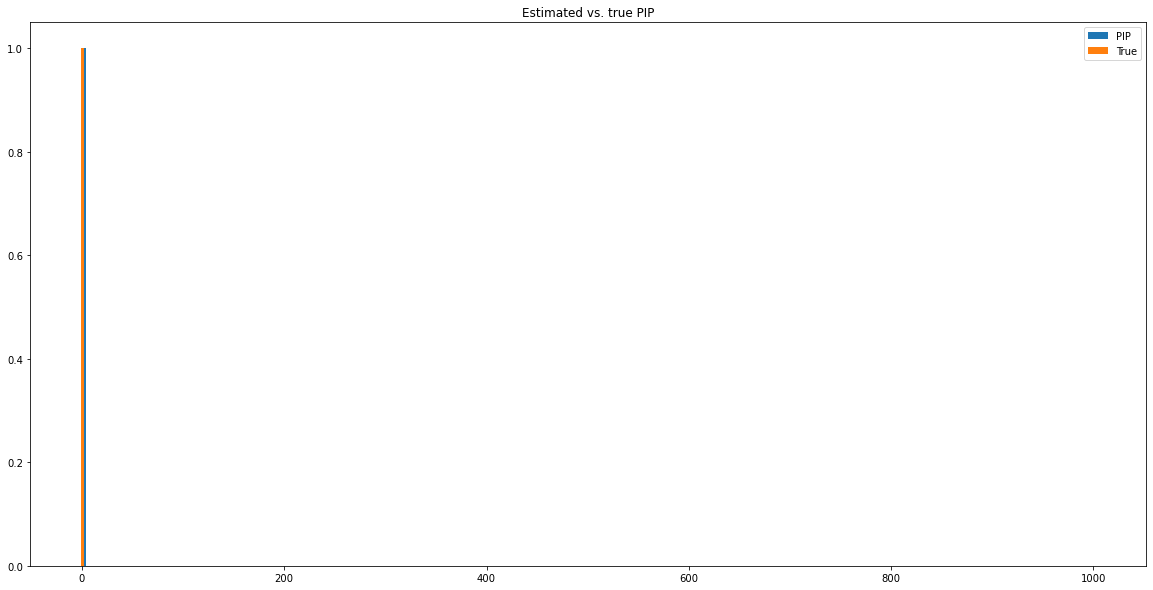

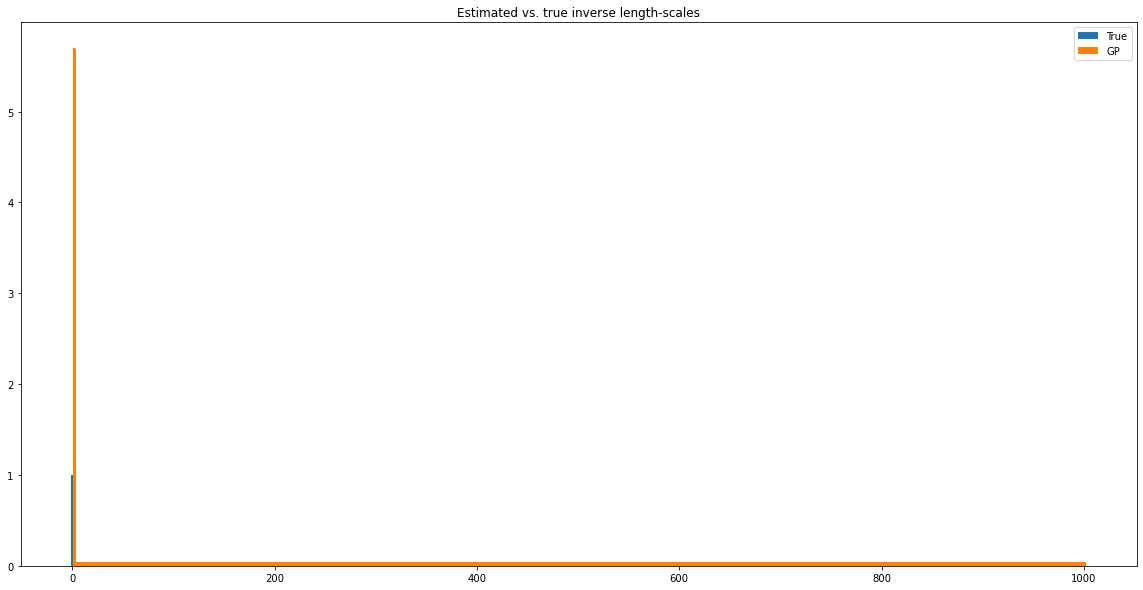

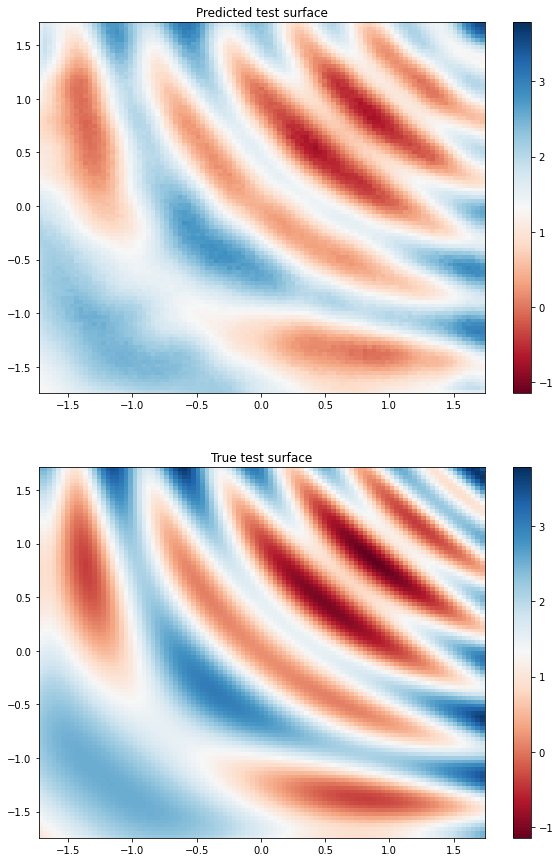

Latent test function MSE :  0.047294807
Observed test data  MSE :  0.3479334


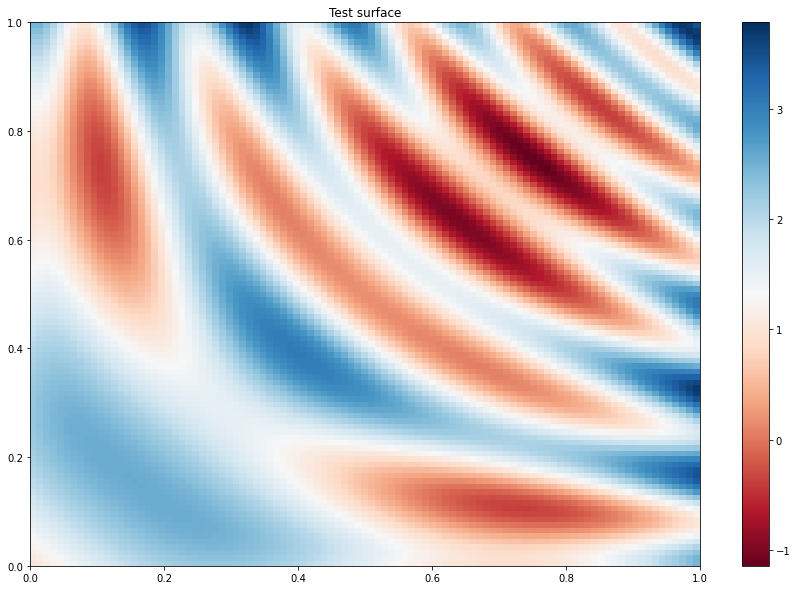

[7.031371  7.0313716 7.031372  7.031373  7.031372  7.0313725 7.0313725
 7.0313725 7.0313725 7.0313716]
3.0443625450134277 0.0020497567
Iter 2 - Loss: 3.044
[7.1312346 7.1312757 7.1313233 7.1311307 7.131417  7.13115   7.1312184
 7.131296  7.13137   7.131344 ]
3.0407360792160034 0.0019933912
Iter 3 - Loss: 2.682
[7.2304554 7.230318  7.2310753 7.2303605 7.231385  7.2306366 7.2304993
 7.2307425 7.23096   7.230918 ]
3.0343895614147187 0.0019322489
Iter 4 - Loss: 2.406
[7.328269  7.327674  7.3301024 7.3285766 7.330587  7.329361  7.328612
 7.329196  7.3294034 7.3294706]
3.0260948663353924 0.0018630234
Iter 5 - Loss: 2.205
[7.4237957 7.422559  7.4276595 7.4250803 7.428201  7.4265113 7.424846
 7.425965  7.4259477 7.426282 ]
3.016367977673412 0.0017839076
Iter 6 - Loss: 2.053
[7.516126  7.514123  7.5229774 7.5191736 7.523455  7.521237  7.5184984
 7.520307  7.5198936 7.5206094]
3.005555456038768 0.001695793
Iter 7 - Loss: 1.935
[7.604423  7.601566  7.615376  7.6102448 7.615681  7.612842  7.608963

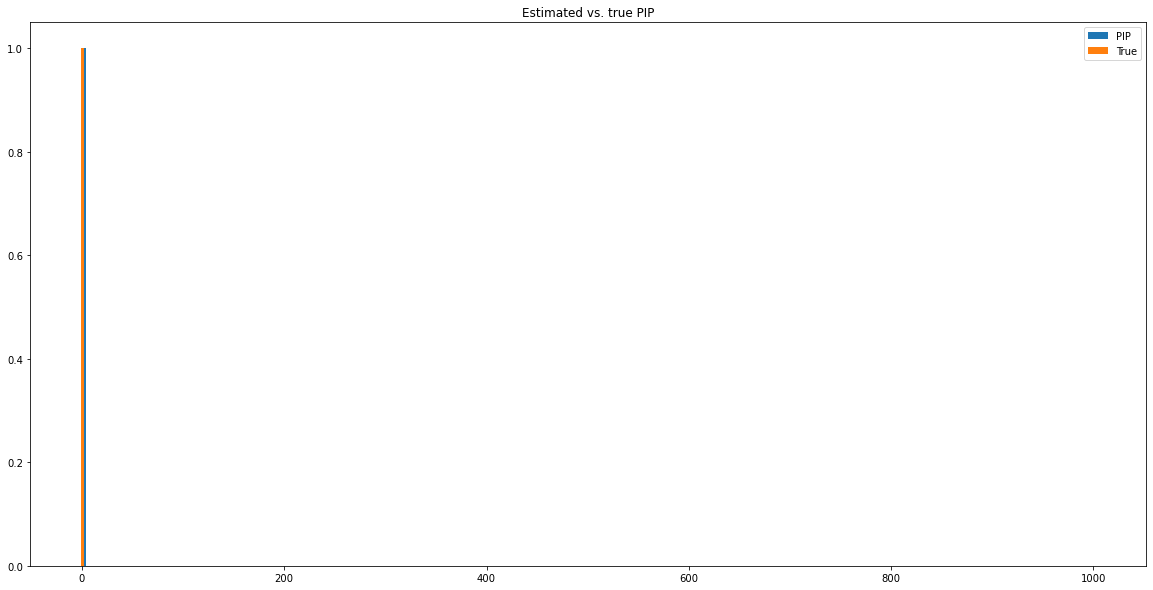

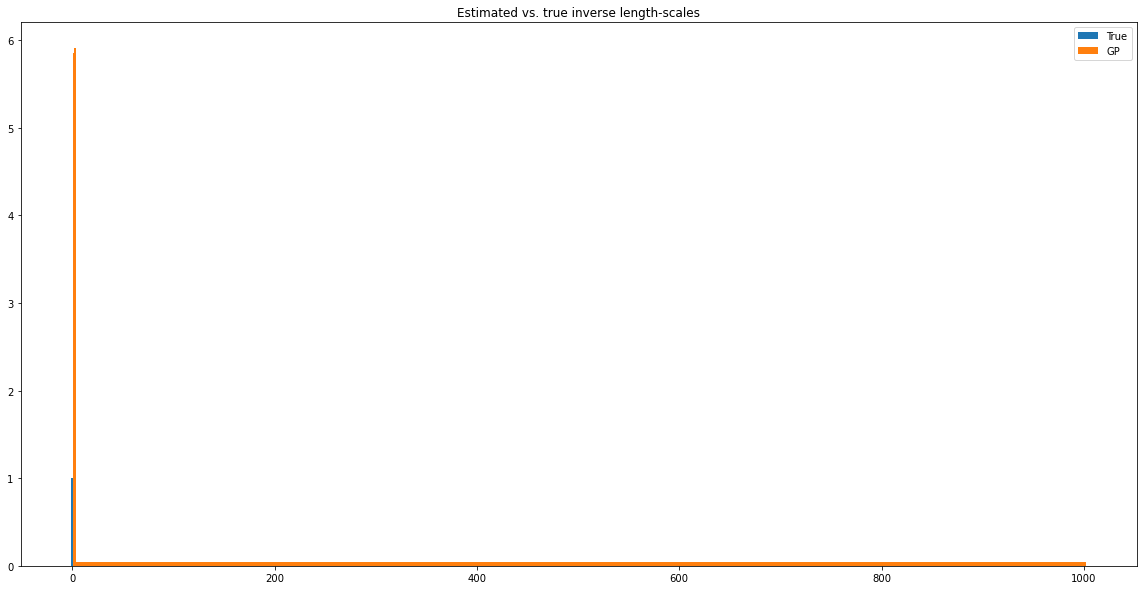

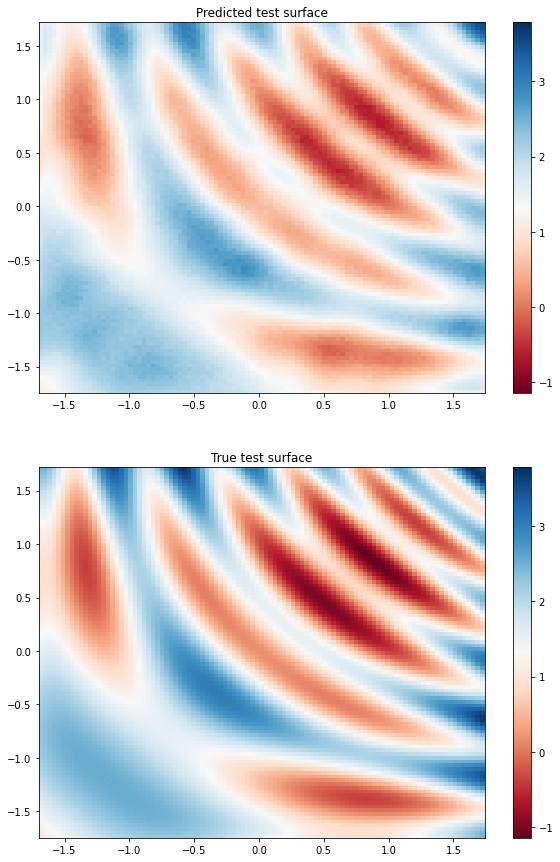

Latent test function MSE :  0.057509355
Observed test data  MSE :  0.3537436


[7.029753  7.030204  7.028973  7.028365  7.029428  7.0303655 7.0283775
 7.0289016 7.029337  7.0303016]
2.7649104595184326 0.00201222


[7.1353407 7.1356936 7.1331472 7.132121  7.13512   7.1337495 7.1340218
 7.1328564 7.1337876 7.1356354]
2.761845893859863 0.0020845209


[7.243819  7.244403  7.242031  7.2392325 7.2453785 7.2385473 7.2427526
 7.2413974 7.2423153 7.244861 ]
2.7580111139297485 0.0020981936


[7.3482904 7.3497586 7.3471417 7.3424306 7.353877  7.3418107 7.3486876
 7.3473825 7.3461146 7.3524137]
2.752356697732925 0.0019899504


[7.446843  7.4481177 7.4499664 7.445132  7.456914  7.4424534 7.4498377
 7.4488053 7.4471507 7.453205 ]
2.7452099513198656 0.0018639809


[7.5402684 7.538184  7.548114  7.5409236 7.5556307 7.5390525 7.546698
 7.543439  7.543048  7.5491343]
2.7368888411197925 0.0017143204


[7.624422  7.6224523 7.6368575 7.630064  7.648834  7.6289535 7.634803
 7.6324    7.6338077 7.639048 ]
2.728345672065131 0.0015529983


[7.6977773 7.693594  7.72009   7.7112465 7.733382  7.711325  7.714756
 7.7130456 7.7126207 7.7191434]
2.7192195508642705 0.0013900733


[7.7641807 7.7599506 7.7980638 7.786607  7.8148146 7.787921  7.7886963
 7.789426  7.7884398 7.7945037]
2.710236201209433 0.0012723166


[7.819608  7.816547  7.8683257 7.8581753 7.8882556 7.8583207 7.856134
 7.8597016 7.8569803 7.8627133]
2.699999965257825 0.0011415542


[7.870291  7.8652363 7.9326525 7.9231176 7.95744   7.923698  7.9178705
 7.923311  7.9203615 7.9235826]
2.6900075299115054 0.0010350504


[7.91029   7.9050264 7.991881  7.9817805 8.021315  7.9819636 7.97601
 7.981327  7.9783516 7.984387 ]
2.6795663557793064 0.0009405341


[7.9431043 7.9353304 8.048519  8.035898  8.07892   8.037365  8.028608
 8.035065  8.031534  8.038109 ]
2.669634301773897 0.0008590077


[7.967584  7.9628515 8.100502  8.086762  8.134436  8.087922  8.077687
 8.08568   8.081157  8.087573 ]
2.659052086392114 0.00078732346


[7.9876575 7.982123  8.149363  8.137838  8.186929  8.1360445 8.124187
 8.133589  8.127514  8.133678 ]
2.6482109675743963 0.0007341452


[7.998956 7.994391 8.194673 8.183197 8.234877 8.18009  8.165891 8.177955
 8.169132 8.176869]
2.637921031856477 0.0006707678


[8.004624  7.9998207 8.238724  8.227176  8.281167  8.22189   8.206305
 8.219786  8.210086  8.218801 ]
2.627522234497965 0.00063278363


[8.005906 8.003052 8.280456 8.269749 8.324734 8.262886 8.245494 8.260533
 8.24947  8.258933]
2.6171473713067326 0.0006039262


[7.998538 8.000224 8.31966  8.310216 8.366356 8.30006  8.281962 8.297994
 8.285814 8.296751]
2.606873688979316 0.0005545653


[7.988728  7.990691  8.356176  8.347899  8.406074  8.334525  8.316467
 8.333652  8.3194475 8.333314 ]
2.596340461675857 0.000521098


[7.9752226 7.976322  8.393592  8.385002  8.442731  8.367308  8.348736
 8.367872  8.352773  8.367908 ]
2.5859038786724104 0.0005066403


[7.956752  7.9634466 8.4285145 8.4223    8.48108   8.399925  8.382488
 8.401882  8.384968  8.400992 ]
2.5756740706233723 0.0004887771


[7.9332075 7.9406104 8.463454  8.459008  8.516533  8.431329  8.414377
 8.433456  8.415869  8.433586 ]
2.5655545524455965 0.0004691287


[7.903488 7.912719 8.496126 8.49285  8.55011  8.461557 8.444251 8.464959
 8.446585 8.464257]
2.5554273460687082 0.0004433888


[7.8730145 7.883789  8.528605  8.527891  8.583059  8.491394  8.473638
 8.495228  8.475598  8.4956045]
2.545154977543858 0.000436387


[7.842272  7.8532987 8.560462  8.561703  8.616113  8.522198  8.503125
 8.526198  8.504316  8.528219 ]
2.5352434732682214 0.0004291534


[7.807895 7.821325 8.592775 8.595637 8.648505 8.550293 8.533931 8.555808
 8.531376 8.558349]
2.5252694076284805 0.000422041


[7.769684 7.785921 8.623377 8.6279   8.679684 8.577537 8.561278 8.584871
 8.559101 8.587196]
2.515270946435649 0.00039833534


[7.7275534 7.743615  8.653241  8.659847  8.710521  8.603522  8.589119
 8.6125555 8.586555  8.616611 ]
2.5053522364620306 0.00039525473


[7.6868796 7.7023187 8.685308  8.69272   8.741251  8.632811  8.619899
 8.642233  8.615243  8.64787  ]
2.496033752616316 0.0004038151


[7.637044 7.659117 8.71582  8.725184 8.771279 8.661647 8.648713 8.669701
 8.642411 8.676048]
2.4865402565494272 0.0003857608


[7.5908523 7.6103764 8.746077  8.756882  8.802157  8.687816  8.676299
 8.698204  8.66876   8.705243 ]
2.476442289773041 0.00038787746


[7.540162  7.5642667 8.776223  8.790316  8.833174  8.716546  8.705106
 8.726366  8.697021  8.736566 ]
2.4666958078733883 0.00038859466


[7.4895782 7.515436  8.805266  8.821748  8.862849  8.743833  8.733257
 8.754928  8.723077  8.765171 ]
2.4570395059130474 0.00037948834


[7.434273  7.4634147 8.835684  8.854035  8.892128  8.770758  8.763007
 8.782544  8.750528  8.793441 ]
2.4476301566436356 0.0003778877


[7.377839 7.407938 8.865557 8.886128 8.921907 8.797805 8.792113 8.810751
 8.778229 8.823025]
2.4381917314447685 0.0003729925


[7.314815  7.3478966 8.895031  8.917383  8.950262  8.823531  8.820954
 8.838427  8.804106  8.8522835]
2.4288397213568835 0.00036296024


[7.253107 7.286224 8.924796 8.950168 8.980307 8.851007 8.849314 8.865629
 8.831232 8.881925]
2.4197461431168557 0.00036921154


[7.186026  7.2198777 8.954572  8.981498  9.008627  8.879467  8.878244
 8.893681  8.859147  8.910385 ]
2.4105856186840544 0.00036640564


[7.1196556 7.1542315 8.984791  9.0139    9.038749  8.90859   8.907535
 8.922705  8.886811  8.940875 ]
2.4012915667918002 0.00037104182


[7.0480046 7.0866747 9.015503  9.046525  9.068457  8.937068  8.936948
 8.951205  8.9146185 8.970084 ]
2.3920251442250025 0.00036783595


[6.976489 7.015664 9.045725 9.07965  9.097591 8.96469  8.966927 8.978705
 8.942561 9.000984]
2.3834114919229195 0.0003656434


[6.8959055 6.938571  9.076342  9.110903  9.127694  8.991468  8.996861
 9.007207  8.970014  9.0303   ]
2.374688772124311 0.00036224016


[6.813192  6.861185  9.1081705 9.143467  9.157215  9.020577  9.026389
 9.037039  8.999121  9.061085 ]
2.3657691441820443 0.00037303072


[6.7270317 6.77097   9.138284  9.176498  9.186665  9.048749  9.056599
 9.065086  9.026333  9.091733 ]
2.357437035959752 0.000356901


[6.643916  6.6875215 9.168513  9.209079  9.217366  9.078109  9.087277
 9.094815  9.055046  9.121582 ]
2.3491132399505115 0.0003714972


[6.5506825 6.594187  9.200246  9.24207   9.246842  9.106539  9.117118
 9.122747  9.083037  9.152646 ]
2.3405461521600763 0.00036305148


[6.445545  6.494051  9.230297  9.274083  9.276034  9.133368  9.146076
 9.150997  9.1116295 9.1820345]
2.3321909981507587 0.00035375226


[6.3429036 6.3954825 9.262653  9.308339  9.306326  9.163389  9.177278
 9.180736  9.139273  9.212266 ]
2.324118694540177 0.00036447393


[6.2326927 6.287725  9.294314  9.341236  9.335704  9.1922455 9.209402
 9.210877  9.169182  9.244456 ]
2.315624227193545 0.00036815222


[6.12178   6.176664  9.325925  9.374175  9.3674135 9.221175  9.238974
 9.2401495 9.198699  9.276471 ]
2.307832238442575 0.0003622438


[5.9934516 6.0505543 9.356679  9.407655  9.397035  9.2498    9.271066
 9.269932  9.226609  9.306256 ]
2.299598384890165 0.00035843783


[5.8634267 5.920393  9.389002  9.442105  9.427961  9.2805195 9.3019
 9.299471  9.256936  9.338692 ]
2.2912936549417915 0.00036565267


[5.7179112 5.7808433 9.420456  9.474963  9.458268  9.310193  9.333528
 9.330155  9.287339  9.370304 ]
2.2834495653333677 0.00035840075


[5.5684423 5.6331406 9.452064  9.507313  9.488369  9.339457  9.365103
 9.360543  9.3168955 9.402519 ]
2.275272872261821 0.00036025187


[5.4192324 5.4892125 9.485495  9.543235  9.519684  9.3696375 9.398281
 9.391294  9.346334  9.43425  ]
2.2677249880139954 0.0003672925


[5.246063  5.3254385 9.5171585 9.576273  9.549546  9.399973  9.429788
 9.421002  9.376761  9.467208 ]
2.2600475187887628 0.00036102303


[5.0651793 5.1461296 9.548366  9.610275  9.580342  9.429832  9.4616785
 9.450948  9.406623  9.498387 ]
2.252184036913711 0.0003598826


[4.868235 4.961978 9.581426 9.64534  9.612362 9.461446 9.494753 9.482926
 9.439014 9.531016]
2.2449689506568173 0.00037011737


[4.655245  4.7572136 9.613681  9.679755  9.643894  9.491441  9.527071
 9.514568  9.468751  9.56508  ]
2.23738864830006 0.0003667311


[4.438956  4.5444264 9.647359  9.714293  9.676595  9.523315  9.560014
 9.546344  9.499197  9.599971 ]
2.230217733513913 0.00037497366


[4.188405  4.3025904 9.679271  9.748863  9.707279  9.554971  9.592321
 9.577745  9.530274  9.630777 ]
2.222813409314836 0.000371683


[3.9280398 4.0450993 9.71407   9.784074  9.739279  9.58433   9.62548
 9.608627  9.562024  9.663505 ]
2.2154980545528953 0.00038402455


[3.6463256 3.778229  9.746935  9.817915  9.769989  9.616182  9.658278
 9.639461  9.593876  9.697008 ]
2.208253761215542 0.00038281534


[3.3427541 3.4839025 9.780965  9.853912  9.804224  9.648531  9.693628
 9.672794  9.624908  9.7310295]
2.2012251443492366 0.00039818973


[3.0142732 3.1675057 9.815692  9.889553  9.836791  9.680774  9.727556
 9.704839  9.657746  9.766802 ]
2.1941314979949316 0.00041534955


[2.6889722 2.8448944 9.852471  9.926988  9.872251  9.71506   9.762549
 9.739784  9.692289  9.803175 ]
2.187249983162993 0.00045046903


[2.341204  2.4962234 9.887517  9.9649725 9.907582  9.750439  9.799766
 9.774872  9.725535  9.841286 ]
2.1805017685524626 0.00047637938


[ 1.9900917  2.1360157  9.923959  10.004041   9.94298    9.785435
  9.836933   9.81054    9.761056   9.87863  ]
2.173491693007517 0.00051911606


[ 1.6477745  1.7930853  9.964944  10.0449295  9.980665   9.823519
  9.877891   9.848049   9.801393   9.919588 ]
2.1663518578836247 0.00059959287


[ 1.3484018  1.465939  10.006909  10.088608  10.022629   9.867517
  9.921868   9.890668   9.841909   9.965415 ]
2.1594752884625037 0.0006963259


[ 1.0937214  1.1903358 10.054386  10.135995  10.068614   9.914826
  9.970286   9.938949   9.888136  10.016301 ]
2.152672442649946 0.0008060223


[ 0.9458514  1.0037007 10.105449  10.187693  10.11792    9.966934
 10.022714   9.990762   9.940733  10.072522 ]
2.1461638165777863 0.0008287199


[ 0.9012939  0.9279592 10.160881  10.243806  10.172546  10.024639
 10.082532  10.0494995  9.996948  10.135293 ]
2.139649409227896 0.00070518884


[ 0.8938625   0.89757144 10.220993   10.302795   10.231133   10.08624
 10.143164   10.110234   10.057187   10.200402  ]
2.1335066175377317 0.0006457345


[ 0.90011436  0.8733658  10.282356   10.364549   10.292726   10.151753
 10.209155   10.175326   10.1205435  10.269574  ]
2.1266751543439217 0.00066316285


[ 0.87695265  0.8362819  10.348185   10.428966   10.35704    10.2181635
 10.276265   10.242763   10.185917   10.340593  ]
2.1202584744691073 0.0007174875


[ 0.86322904  0.8275575  10.415024   10.495753   10.425669   10.28901
 10.348292   10.312809   10.255013   10.4135065 ]
2.1134416221367545 0.0006898969


[ 0.8487655  0.8184528 10.4854    10.563876  10.49672   10.362169
 10.418643  10.385927  10.324783  10.491873 ]
2.106889435768063 0.00070161547


[ 0.8210562  0.8055071 10.556202  10.636251  10.569124  10.437617
 10.494872  10.461682  10.398968  10.569881 ]
2.1002662766265234 0.00074534776


[ 0.8049729  0.7748426 10.631211  10.7104645 10.644386  10.515174
 10.571836  10.540021  10.475758  10.651866 ]
2.093862168233046 0.00077168463


[ 0.8062994  0.7696515 10.707793  10.786376  10.721253  10.595536
 10.652684  10.619274  10.554476  10.736843 ]
2.0875318093280435 0.00071976695


[ 0.8000161  0.7518486 10.786834  10.8642435 10.8011675 10.67816
 10.735519  10.701146  10.635668  10.8243885]
2.081129011586173 0.00075361185


[ 0.7829068  0.7357932 10.868922  10.943237  10.883572  10.763758
 10.819909  10.786762  10.720022  10.913693 ]
2.0751182342609913 0.0007818562


[ 0.7856261  0.7349583 10.95184   11.0253525 10.968443  10.852931
 10.907364  10.873545  10.805391  11.006207 ]
2.068545486528748 0.0007432957


[ 0.76971835  0.7154151  11.037253   11.1092415  11.055976   10.942861
 10.995897   10.9618225  10.892588   11.099157  ]
2.0624297612300344 0.0007995535


[ 0.7645041  0.7173383 11.1254    11.1956835 11.143635  11.034393
 11.087025  11.052312  10.983005  11.196099 ]
2.0562553127464573 0.0007535069


[ 0.7461933  0.6981587 11.216326  11.283889  11.234459  11.130161
 11.180473  11.147437  11.075021  11.294077 ]
2.0506963752367446 0.0008198339


[ 0.7536299  0.6921369 11.3088    11.373772  11.329307  11.22703
 11.274469  11.243039  11.169298  11.393444 ]
2.044629202925341 0.0007756317


[ 0.73487884  0.68510014 11.403572   11.466303   11.425041   11.327026
 11.371508   11.341703   11.265865   11.496238  ]
2.0385697114236603 0.000808819


[ 0.73081183  0.6771043  11.500312   11.559035   11.521532   11.428546
 11.471407   11.440887   11.363971   11.600289  ]
2.032465870131033 0.0007819837


[ 0.7198815   0.66871476 11.599298   11.655434   11.620272   11.531226
 11.572772   11.54218    11.465849   11.705841  ]
2.026191068092473 0.00079772685


[ 0.7122141   0.66100323 11.699269   11.751023   11.7220545  11.637551
 11.674853   11.64439    11.567409   11.812886  ]
2.020274862920734 0.00078525784


[ 0.714165   0.6550347 11.801891  11.849378  11.823119  11.744075
 11.779264  11.748859  11.670683  11.921169 ]
2.014204215827324 0.0007699678


[ 0.6991412  0.6416533 11.902743  11.948334  11.927219  11.85398
 11.881711  11.856065  11.774405  12.031583 ]
2.008016577069472 0.00080916367


[ 0.695105   0.6386519 12.005764  12.0496435 12.031599  11.960415
 11.987547  11.961234  11.878788  12.139211 ]
2.002028493083979 0.00075333455


[ 0.69245565  0.6318601  12.110205   12.148688   12.13383    12.068977
 12.092259   12.066646   11.985429   12.2493105 ]
1.9960617364620077 0.0007499529


[ 0.68793243  0.62750506 12.218148   12.251984   12.241149   12.181457
 12.200003   12.175286   12.094061   12.361471  ]
1.9900713809095978 0.00075466675


[ 0.6733484   0.61408293 12.322089   12.354467   12.349628   12.293718
 12.30567    12.283438   12.201143   12.473519  ]
1.984469110894752 0.000775233


[ 0.6765637  0.6210344 12.426428  12.455349  12.456809  12.40583
 12.410958  12.391761  12.309249  12.584269 ]
1.9784371560586165 0.00072483957


[ 0.65607965  0.6176158  12.533178   12.557553   12.5639715  12.518339
 12.51669    12.498928   12.417819   12.695115  ]
1.9725830885484759 0.0007405515


[ 0.65693283  0.60659087 12.6403475  12.66063    12.670616   12.629039
 12.623451   12.605232   12.524846   12.806492  ]
1.9665171962368282 0.0007032029


[ 0.6539379  0.6009534 12.745617  12.762781  12.775842  12.739747
 12.728181  12.712105  12.631152  12.915002 ]
1.9607800025516662 0.00067689206


[ 0.64067185  0.59722334 12.848902   12.861604   12.879454   12.84911
 12.82953    12.81726    12.733447   13.021043  ]
1.9551051923618887 0.00067562703


[ 0.6470118  0.5932045 12.953142  12.962377  12.98244   12.957002
 12.930497  12.920134  12.837472  13.127006 ]
1.9497337337629312 0.0006480712


[ 0.62921077  0.593305   13.056549   13.059702   13.085512   13.06567
 13.030573   13.0238905  12.942138   13.233598  ]
1.9439007946186613 0.00064973783


[ 0.6312378  0.5816672 13.155816  13.15566   13.187641  13.1715975
 13.12795   13.124628  13.0424385 13.339128 ]
1.9384466778486984 0.0006204783


[ 0.62235874  0.5769494  13.253635   13.247751   13.284348   13.27335
 13.22253    13.222123   13.141131   13.439278  ]
1.9324159105159358 0.0005920556


[ 0.60594517  0.5790564  13.35129    13.34336    13.38231    13.376769
 13.319091   13.319904   13.240334   13.541217  ]
1.9265849614880621 0.00059682975


[ 0.6098046   0.56231344 13.446973   13.434192   13.475565   13.473974
 13.407032   13.415775   13.334157   13.635995  ]
1.9206708443656284 0.00058027246


[ 0.5996733  0.570109  13.540959  13.525466  13.567634  13.574913
 13.497554  13.51059   13.428219  13.73156  ]
1.9152189829716852 0.00056464126


[ 0.5917959  0.5654672 13.632417  13.611799  13.661218  13.671915
 13.585492  13.60141   13.519705  13.827723 ]
1.9095344471317601 0.00052897225


[ 0.5875761   0.54917437 13.722675   13.698921   13.749755   13.768118
 13.672442   13.690662   13.607265   13.917889  ]
1.9039044416058313 0.0005370783


[ 0.57657343  0.55031294 13.810153   13.78336    13.836745   13.862008
 13.756131   13.778706   13.695624   14.006956  ]
1.8984103786694175 0.0004955593


[ 0.56594527  0.54826176 13.898615   13.867291   13.922372   13.953104
 13.841124   13.866744   13.783271   14.095874  ]
1.8929902475942864 0.00048835523


[ 0.56356925  0.5357605  13.985193   13.950857   14.007777   14.042988
 13.921464   13.952719   13.868342   14.183198  ]
1.8874857596805688 0.0004884015


[ 0.5560866  0.5398869 14.069521  14.030998  14.090492  14.131411
 13.998402  14.0331955 13.951258  14.267255 ]
1.8823222091325607 0.0004509349


[ 0.5425097   0.52396077 14.152139   14.110248   14.1726885  14.2186985
 14.07412    14.116003   14.032671   14.351198  ]
1.8767384219987393 0.000507713


[ 0.54798347  0.526578   14.234207   14.191303   14.252813   14.305325
 14.152304   14.197163   14.116198   14.4336195 ]
1.8712221409415175 0.00042952126


[ 0.5421666   0.51342577 14.316936   14.268375   14.332361   14.390579
 14.228643   14.276615   14.193022   14.513894  ]
1.8660117877800884 0.0004544444


[ 0.5333545  0.509216  14.397839  14.343951  14.410586  14.474222
 14.303936  14.357195  14.273626  14.593895 ]
1.8607283624357804 0.0004262604


[ 0.529341   0.5059342 14.476611  14.419299  14.489964  14.558614
 14.377455  14.434636  14.349742  14.67313  ]
1.8549499474389708 0.00039826316


[ 0.51139164  0.49558747 14.550268   14.489537   14.563274   14.637661
 14.448028   14.507787   14.423724   14.748599  ]
1.8498569082020841 0.00045692603


[ 0.51207423  0.49409854 14.628664   14.565065   14.637902   14.7183075
 14.519367   14.586355   14.500953   14.826583  ]
1.8446422534476847 0.00036654453


[ 0.5086233   0.48626626 14.706923   14.64263    14.715305   14.799928
 14.590566   14.661941   14.57789    14.903802  ]
1.839632405849121 0.00039854378


[ 0.4964991   0.48028883 14.781605   14.7152195  14.78706    14.880327
 14.659193   14.736688   14.652077   14.979767  ]
1.8344321841713822 0.00041082536


[ 0.49127907  0.4766436  14.856679   14.787885   14.858719   14.960851
 14.730174   14.812265   14.726424   15.055856  ]
1.8296321821977561 0.0003736987


[ 0.4763429   0.46588874 14.931558   14.8581505  14.931844   15.035558
 14.79945    14.883502   14.798814   15.129632  ]
1.8247376416963503 0.00043747658


[ 0.4767256   0.46861777 15.006238   14.932485   15.005925   15.1137905
 14.870603   14.958407   14.874033   15.204751  ]
1.8197588862472518 0.0003453194


[ 0.4677347   0.45780525 15.079424   15.003024   15.076798   15.189145
 14.938715   15.030312   14.94395    15.2770815 ]
1.8145165552773879 0.0004050969


[ 0.452726    0.45568395 15.152113   15.073409   15.147956   15.267811
 15.004257   15.100822   15.015142   15.348967  ]
1.809211430646779 0.00039118234


[ 0.45695525  0.44449323 15.225377   15.144597   15.218566   15.343056
 15.072643   15.1736965  15.086866   15.4221    ]
1.8042282719620306 0.00038459658


[ 0.44210386  0.44147938 15.300944   15.215192   15.288175   15.417725
 15.141023   15.244723   15.157143   15.493758  ]
1.799544535737848 0.00039081572


[ 0.43894222  0.4313078  15.371202   15.285566   15.357247   15.494865
 15.210843   15.314935   15.227885   15.565712  ]
1.7946130099246893 0.00037192283


[ 0.4287937   0.43263334 15.442868   15.35671    15.427028   15.569944
 15.278176   15.385392   15.300074   15.637484  ]
1.7898206414507323 0.00035852843


[ 0.4208869   0.41803986 15.514082   15.426848   15.496617   15.645165
 15.344051   15.4548645  15.370249   15.710895  ]
1.7851059179215858 0.00041733953


[ 0.41499805  0.41248807 15.583655   15.498315   15.567224   15.721258
 15.416513   15.527308   15.442783   15.783462  ]
1.7806098122698206 0.00036117213


[ 0.40330377  0.40821597 15.656397   15.567584   15.6380825  15.7966795
 15.4853525  15.595518   15.510822   15.854654  ]
1.7758993171363193 0.00038694908


[ 0.39033744  0.40119112 15.72823    15.639609   15.708675   15.871927
 15.553058   15.667607   15.581992   15.926769  ]
1.7708710761946465 0.00041325082


[ 0.3861095  0.3923816 15.800756  15.711281  15.778832  15.949446
 15.6208315 15.738813  15.654598  16.00067  ]
1.7666522912940585 0.00037483784


[ 0.3755545   0.38568804 15.874247   15.784707   15.849082   16.026735
 15.689296   15.811808   15.725999   16.076212  ]
1.762047689977645 0.00040613615


[ 0.37263292  0.3797735  15.947543   15.858454   15.921947   16.10244
 15.7589655  15.885788   15.799106   16.150238  ]
1.7576932972720518 0.00034913668


[ 0.3591698   0.36588606 16.020447   15.930373   15.99234    16.180403
 15.8286085  15.959034   15.873638   16.225143  ]
1.7530920367827756 0.00048473477


[ 0.35663727  0.36588463 16.093773   16.004961   16.064594   16.25756
 15.900061   16.03239    15.946067   16.301638  ]
1.7489914209422306 0.0003069845


[ 0.34178394  0.35200813 16.166525   16.077124   16.136694   16.333534
 15.97064    16.105703   16.018042   16.376417  ]
1.744374030994283 0.00050989585


[ 0.3365312   0.34855413 16.244522   16.152899   16.210491   16.41158
 16.04264    16.180552   16.091507   16.452396  ]
1.7397783579679706 0.00035880978


[ 0.3241922  0.3420936 16.318829  16.227757  16.284492  16.490324
 16.11559   16.254957  16.166796  16.529715 ]
1.7351316351125494 0.00045082252


[ 0.3163708  0.3354259 16.396488  16.304482  16.357958  16.567675
 16.189316  16.332088  16.243885  16.609087 ]
1.7309704761749067 0.00042149707


[ 0.30948704  0.32439357 16.474855   16.382      16.434063   16.648018
 16.264908   16.408192   16.31999    16.687925  ]
1.7266543956235154 0.0004553367


[ 0.29889834  0.31565204 16.550598   16.459589   16.510624   16.726463
 16.338947   16.485588   16.398495   16.768322  ]
1.7224715539931013 0.000485158


[ 0.28439423  0.30687135 16.630917   16.538643   16.588589   16.80717
 16.417429   16.565      16.476486   16.850437  ]
1.7182129277018274 0.0005499287


[ 0.2752985  0.3007555 16.71463   16.622448  16.670403  16.892467
 16.499228  16.648554  16.559525  16.93505  ]
1.7135891656771591 0.0004829424


[ 0.2636619  0.2885837 16.79811   16.706121  16.751013  16.980059
 16.584278  16.735228  16.6441    17.022484 ]
1.7091704685775775 0.0006017176


[ 0.25643083  0.2804463  16.88245    16.793379   16.837078   17.068224
 16.669558   16.820906   16.730608   17.110203  ]
1.7051092285410023 0.0005139506


[ 0.24251835  0.26407212 16.969467   16.880856   16.92405    17.1541
 16.756586   16.90837    16.816753   17.197733  ]
1.700887692720741 0.0007482138


[ 0.24039991  0.25523794 17.062313   16.972063   17.015976   17.245977
 16.849913   17.000551   16.907377   17.29249   ]
1.6962854022021487 0.00048579945


[ 0.23037067  0.24726997 17.152636   17.06421    17.105894   17.337183
 16.941261   17.093637   16.999384   17.38752   ]
1.692055692940259 0.0006221173


[ 0.22402929  0.23584318 17.246437   17.160112   17.201677   17.431963
 17.03754    17.189592   17.094751   17.485088  ]
1.6875289455678175 0.0006433406


[ 0.21714771  0.2278795  17.342268   17.25659    17.297188   17.529314
 17.135649   17.286325   17.190817   17.583803  ]
1.6827821022142815 0.0006129351


[ 0.21718794  0.2281021  17.43795    17.354221   17.395008   17.62836
 17.234583   17.384706   17.288128   17.684177  ]
1.6786872590592652 0.0003324361


[ 0.20952493  0.21278812 17.534292   17.452438   17.494383   17.725063
 17.33371    17.484818   17.383791   17.786194  ]
1.6740974792402028 0.00080554356


[ 0.20477086  0.21227995 17.632858   17.553703   17.593336   17.822563
 17.43495    17.585659   17.482311   17.88989   ]
1.6696280076578685 0.0004469655


[ 0.20150264  0.20710361 17.730503   17.655043   17.693607   17.922026
 17.53558    17.685247   17.581392   17.994335  ]
1.6653051809599673 0.0005183339


[ 0.19963543  0.2052804  17.829454   17.75472    17.793499   18.020657
 17.640026   17.786743   17.678886   18.095692  ]
1.6607166123161086 0.00040738957


[ 0.19454873  0.19880086 17.92927    17.855886   17.895403   18.121231
 17.740238   17.88938    17.777042   18.200512  ]
1.6563019994747317 0.0006038461


[ 0.19415824  0.19979435 18.028877   17.95669    17.997654   18.21972
 17.84324    17.992174   17.87311    18.303722  ]
1.6517393328163186 0.00034810195


[ 0.19042015  0.19372869 18.126116   18.057945   18.100338   18.319576
 17.945906   18.094048   17.972486   18.408543  ]
1.6473271123606987 0.0005661955


[ 0.19185203  0.1950752  18.225754   18.157347   18.20005    18.419785
 18.047089   18.19682    18.071985   18.512318  ]
1.6431075095453498 0.00037879366


[ 0.18958017  0.19165617 18.322983   18.256971   18.300062   18.517292
 18.147202   18.295387   18.167753   18.61545   ]
1.6384105803296418 0.0004501805


[ 0.18679224  0.19027221 18.42087    18.356691   18.400902   18.61342
 18.248508   18.39462    18.26296    18.716757  ]
1.6341359401254054 0.000408279


[ 0.18552296  0.18967047 18.518137   18.455877   18.50307    18.711708
 18.348625   18.493958   18.360403   18.818628  ]
1.6295952501558377 0.0003439507


[ 0.18430081  0.19041443 18.61416    18.553059   18.602291   18.80569
 18.447968   18.590315   18.453568   18.916996  ]
1.62548832949365 0.0003361413


[ 0.18591069  0.18709561 18.708164   18.649324   18.701344   18.899387
 18.544865   18.68846    18.546421   19.016722  ]
1.621352783519041 0.00041608198


[ 0.18318407  0.18514459 18.803846   18.745943   18.799936   18.993254
 18.642351   18.786406   18.640364   19.11351   ]
1.6167181386165137 0.00040912066


[ 0.18387325  0.18525904 18.898567   18.840754   18.8968     19.08658
 18.738146   18.882217   18.734812   19.211933  ]
1.6125508885657978 0.0002907083


[ 0.18363956  0.18532941 18.991858   18.935822   18.99462    19.181463
 18.836264   18.979624   18.82586    19.309465  ]
1.6084404803976844 0.0002705756


[ 0.18168336  0.18504623 19.082338   19.027832   19.089163   19.27281
 18.931011   19.074139   18.91606    19.40519   ]
1.604209189960239 0.0003223189


[ 0.18300004  0.18359894 19.171892   19.120558   19.183262   19.3623
 19.024553   19.167768   19.004847   19.498589  ]
1.5998241322193432 0.0003325702


[ 0.18238276  0.18282907 19.262724   19.213705   19.277498   19.453175
 19.118944   19.260296   19.094454   19.593557  ]
1.5953550850137421 0.00028853118


[ 0.17937645  0.18501167 19.350603   19.302639   19.367672   19.540903
 19.208286   19.350443   19.179699   19.685396  ]
1.590786139332901 0.0003930949


[ 0.1815833   0.18190181 19.438414   19.393034   19.458874   19.629059
 19.301521   19.441088   19.266413   19.778297  ]
1.5864795114219328 0.00039895083


[ 0.18144715  0.18120536 19.524973   19.480015   19.548632   19.716349
 19.392107   19.529356   19.352898   19.867506  ]
1.582255871789052 0.00025520218


[ 0.17837812  0.18087053 19.612616   19.569445   19.640038   19.80384
 19.483423   19.619726   19.438383   19.959322  ]
1.577926923214823 0.0003348174


[ 0.17864168  0.18058532 19.697485   19.655144   19.72883    19.886322
 19.570036   19.708485   19.52078    20.046822  ]
1.5735768815732356 0.00023828894


[ 0.18081208  0.18068168 19.780815   19.739977   19.815977   19.97154
 19.657352   19.795963   19.604212   20.135523  ]
1.5694409836776844 0.0002887569


[ 0.17761338  0.1816642  19.864717   19.822493   19.901897   20.053215
 19.741531   19.88117    19.686178   20.220182  ]
1.5652251898401293 0.00034042174


[ 0.1776313   0.18127841 19.948717   19.907127   19.989517   20.137808
 19.827559   19.967972   19.766848   20.306673  ]
1.5609130220176557 0.00022496475


[ 0.1794091   0.17750192 20.028532   19.989632   20.074903   20.218727
 19.911507   20.051176   19.844778   20.390802  ]
1.5567140721277555 0.00037754327


[ 0.17858152  0.17953892 20.10969    20.07114    20.159206   20.299423
 19.99473    20.133999   19.923815   20.475605  ]
1.5527922008003987 0.00029138528


[ 0.17727557  0.1800439  20.19097    20.153917   20.24127    20.378498
 20.079079   20.218246   20.002539   20.559298  ]
1.548885299824728 0.0002563795


[ 0.17826676  0.17808956 20.26838    20.231443   20.320972   20.4559
 20.159985   20.29909    20.078587   20.639723  ]
1.544698877456211 0.0002844719


[ 0.1762468  0.1810472 20.347591  20.31154   20.403675  20.534184
 20.240608  20.380907  20.155573  20.721045 ]
1.5407861694586265 0.00034855664


[ 0.17646077  0.17815307 20.426016   20.39053    20.484722   20.613247
 20.322727   20.461933   20.229736   20.80369   ]
1.5369564313335287 0.0002862392


[ 0.17849186  0.17760742 20.503368   20.46936    20.566525   20.688997
 20.402834   20.541529   20.305801   20.884459  ]
1.5324663418985045 0.0002671193


[ 0.17613904  0.17771873 20.580301   20.54753    20.646833   20.765339
 20.481777   20.62119    20.381298   20.963755  ]
1.5283766187699706 0.0002616898


[ 0.17630053  0.1782149  20.656109   20.62415    20.724861   20.839771
 20.561068   20.698105   20.454306   21.042732  ]
1.524282384862239 0.00019929746


[ 0.17834005  0.17929447 20.731983   20.701818   20.802258   20.91509
 20.637352   20.776257   20.527163   21.120281  ]
1.5203332440656796 0.00027565326


[ 0.1746803   0.17645356 20.806416   20.77767    20.879686   20.989798
 20.71371    20.852058   20.598743   21.19711   ]
1.5164666161175917 0.00037879785


[ 0.1776367   0.17636953 20.881117   20.852247   20.95614    21.06553
 20.790613   20.927948   20.670174   21.27452   ]
1.5125929507994638 0.00026953747


[ 0.17641057  0.17885111 20.955458   20.925367   21.031328   21.138058
 20.868032   21.003584   20.741718   21.350111  ]
1.5085566728760944 0.00028636793


[ 0.17552291  0.17697708 21.026873   20.99863    21.105799   21.210196
 20.942698   21.078646   20.811293   21.423418  ]
1.5046957896705115 0.00025248004


[ 0.17656076  0.17559618 21.099142   21.07266    21.180431   21.282568
 21.015509   21.15391    20.88308    21.500216  ]
1.5006215271244534 0.00024178992


[ 0.17718549  0.17848904 21.169796   21.143227   21.253237   21.352757
 21.088394   21.227531   20.950724   21.573792  ]
1.4966702234666733 0.00027071554


[ 0.17686678  0.1754022  21.24066    21.215303   21.325567   21.423994
 21.161829   21.300392   21.020267   21.645994  ]
1.4927055003446317 0.00026615403


[ 0.17735843  0.17727004 21.311567   21.285927   21.398193   21.494598
 21.235386   21.373095   21.088274   21.719118  ]
1.4891350208302294 0.00023068432


[ 0.17495297  0.17739685 21.381771   21.357939   21.473042   21.566263
 21.307398   21.44444    21.156658   21.791754  ]
1.485485629955347 0.00023751173


[ 0.17555833  0.17557544 21.452995   21.428106   21.545156   21.635397
 21.377373   21.515192   21.222862   21.863956  ]
1.481391173951051 0.00022901222


[ 0.17427649  0.17743193 21.521069   21.49654    21.616499   21.70469
 21.448221   21.585396   21.289652   21.935408  ]
1.4778916149623187 0.00025019993


[ 0.17646834  0.175423   21.59011    21.567778   21.688168   21.774397
 21.52124    21.65676    21.356625   22.006422  ]
1.4745741081430634 0.00028496413


[ 0.17426763  0.17491354 21.657993   21.636133   21.75671    21.84093
 21.59109    21.727617   21.421167   22.075274  ]
1.4709644017887293 0.0002316791


[ 0.17514956  0.17428793 21.723188   21.703573   21.825521   21.908787
 21.661585   21.796783   21.48536    22.14568   ]
1.4673273886531053 0.00019338033


[ 0.1741545   0.17664976 21.791182   21.772238   21.893744   21.975252
 21.729525   21.864454   21.551182   22.215477  ]
1.4639350662665132 0.0002501561


[ 0.17432043  0.17756644 21.856432   21.838577   21.960302   22.040386
 21.797972   21.933159   21.613207   22.281273  ]
1.460612489495297 0.00017254241


[ 0.17561594  0.17609219 21.924017   21.906357   22.030119   22.10674
 21.866852   22.00112    21.677969   22.350368  ]
1.457173391358538 0.00022848966


[ 0.17328696  0.17428406 21.988363   21.971834   22.095612   22.171806
 21.933493   22.068125   21.74035    22.417236  ]
1.4538585084028233 0.0002699464


[ 0.175872    0.17672683 22.054525   22.038715   22.164797   22.23709
 22.001894   22.137701   21.803364   22.483734  ]
1.450095584787301 0.00030016722


[ 0.17279285  0.17567386 22.120293   22.10395    22.230722   22.300922
 22.068474   22.20318    21.864904   22.550829  ]
1.4468718205783744 0.00026574617


[ 0.17428781  0.1744061  22.183868   22.169365   22.296429   22.364662
 22.1346     22.268188   21.926878   22.617931  ]
1.4433714847311419 0.00022288215


[ 0.17392856  0.17406848 22.246342   22.23188    22.361166   22.427927
 22.20163    22.334158   21.988194   22.683838  ]
1.4399957868992874 0.00015221073


[ 0.17424864  0.17560004 22.311235   22.29601    22.427954   22.492825
 22.267437   22.399107   22.049582   22.750057  ]
1.4366430647576047 0.00018936157


[ 0.17265044  0.1743366  22.375021   22.358664   22.494951   22.55633
 22.33341    22.463995   22.111284   22.81517   ]
1.4332789231668066 0.00022037682


[ 0.1755701   0.17505144 22.438875   22.422537   22.558983   22.619509
 22.397104   22.529053   22.17113    22.881742  ]
1.4298886097308845 0.00024420474


[ 0.17360985  0.17603496 22.501501   22.484571   22.623253   22.681213
 22.459824   22.593449   22.230581   22.946125  ]
1.4262546062934878 0.00021894476


[ 0.17357609  0.17635116 22.564013   22.547182   22.68737    22.741388
 22.523275   22.658134   22.289108   23.00916   ]
1.4234328964217302 0.0001329408


[ 0.17477565  0.17415597 22.626316   22.610252   22.750568   22.801424
 22.586803   22.72037    22.34892    23.071589  ]
1.4201357980445186 0.00023196332


[ 0.17464247  0.17506717 22.686548   22.671646   22.81544    22.864235
 22.651817   22.784296   22.4074     23.13575   ]
1.417101869749666 0.00015381447


[ 0.17411211  0.17577457 22.750957   22.73443    22.878063   22.92564
 22.715595   22.84807    22.465937   23.199131  ]
1.414020725558166 0.00016054373


[ 0.17333378  0.17386675 22.810524   22.794708   22.93895    22.985378
 22.777103   22.909452   22.525723   23.261007  ]
1.4109755831810482 0.0002041977


[ 0.1737287   0.17502542 22.869406   22.856764   23.001957   23.04609
 22.837826   22.970549   22.582302   23.323654  ]
1.4076655714784188 0.00016615253


[ 0.17438056  0.17414442 22.93105    22.919415   23.064653   23.106504
 22.898874   23.03189    22.640173   23.385778  ]
1.404495151935357 0.00016550878


[ 0.17233595  0.17489643 22.991957   22.979994   23.125694   23.166908
 22.9619     23.0943     22.696253   23.446733  ]
1.4014541810526002 0.00020655722


[ 0.17425366  0.17365646 23.052149   23.03994    23.186697   23.226309
 23.02399    23.154928   22.752327   23.508787  ]
1.3980522092894527 0.00021636605


[ 0.17422356  0.17612001 23.11029    23.098696   23.246798   23.285013
 23.084204   23.214918   22.808424   23.569336  ]
1.3947132596719916 0.00019237965


[ 0.1732631   0.17252946 23.17074    23.158394   23.30872    23.343143
 23.144178   23.275797   22.866417   23.631437  ]
1.3916688680306244 0.00025991056


[ 0.17291771  0.17454676 23.229982   23.219278   23.367325   23.403395
 23.204758   23.337305   22.923534   23.692284  ]
1.3886435703892128 0.00018870422


[ 0.17345023  0.17451663 23.28926    23.27896    23.426706   23.461613
 23.265005   23.398195   22.9777     23.752945  ]
1.3858446822259853 0.0001270605


[ 0.17237538  0.17450863 23.348244   23.33716    23.487717   23.520973
 23.326115   23.45755    23.03424    23.812813  ]
1.3826885390517205 0.00014364734


[ 0.17342271  0.17481327 23.405796   23.396074   23.548807   23.578094
 23.38666    23.5179     23.089588   23.871958  ]
1.3796296523565768 0.0001512288


[ 0.17207834  0.17298764 23.46452    23.454105   23.60963    23.63596
 23.447186   23.578087   23.145836   23.933928  ]
1.3769225389251283 0.00021135811


[ 0.1719054   0.17536764 23.522535   23.513308   23.669365   23.693758
 23.50656    23.637627   23.20192    23.994852  ]
1.373843032259174 0.0001892642


[ 0.17403361  0.17343627 23.58177    23.571117   23.728233   23.750946
 23.56572    23.696367   23.257305   24.05354   ]
1.3711936789324317 0.00023830833


[ 0.17249425  0.17495544 23.637617   23.627565   23.786537   23.80821
 23.624903   23.755932   23.311373   24.113781  ]
1.3687121536726483 0.00020324979


[ 0.1739459   0.17443775 23.694881   23.683771   23.844084   23.864025
 23.683744   23.815495   23.367523   24.170923  ]
1.3655655342073025 0.00016683892


[ 0.17127451  0.17425238 23.750257   23.741888   23.903236   23.920431
 23.742758   23.872972   23.421717   24.22977   ]
1.362594104424464 0.00019589817


[ 0.17284825  0.17601174 23.808065   23.799501   23.960018   23.977852
 23.80193    23.931528   23.474718   24.289434  ]
1.3595846875997322 0.00021008975


[ 0.17320696  0.17269701 23.865244   23.855522   24.019037   24.03356
 23.857586   23.9902     23.527472   24.347942  ]
1.3568946715838728 0.00021953194


[ 0.17326336  0.17448111 23.921616   23.913572   24.07725    24.088806
 23.91733    24.047853   23.580095   24.406338  ]
1.3538182738106002 0.00015971324


[ 0.17289999  0.17476676 23.975855   23.970596   24.13679    24.144041
 23.973434   24.105692   23.634918   24.463886  ]
1.3509543650402371 0.0001179536


[ 0.17232792  0.17406912 24.032393   24.02592    24.19265    24.199965
 24.032698   24.164618   23.687204   24.521866  ]
1.3480824885689424 0.00013928508


[ 0.17420694  0.17401712 24.088213   24.082735   24.250574   24.25589
 24.088837   24.22126    23.74123    24.579273  ]
1.3454998198493295 0.00015915403


[ 0.17185721  0.17311306 24.14242    24.1388     24.307304   24.310345
 24.147705   24.277233   23.793564   24.635977  ]
1.3427381071160767 0.0002037046


[ 0.1742239   0.17457712 24.197598   24.19357    24.363335   24.365028
 24.203821   24.333908   23.846111   24.693745  ]
1.3400272740109194 0.00022140202


[ 0.17132822  0.17373487 24.252464   24.248928   24.419424   24.420202
 24.261501   24.39011    23.90024    24.74964   ]
1.337100303873578 0.0002182398


[ 0.17278919  0.1743337  24.306868   24.304956   24.47652    24.475878
 24.31705    24.447474   23.95176    24.805399  ]
1.3343542424222905 0.00016203015


[ 0.17176174  0.17293379 24.36141    24.359007   24.531271   24.530436
 24.374285   24.502455   24.002537   24.862358  ]
1.3316062255012262 0.0001718066


[ 0.17434202  0.1738011  24.416267   24.414467   24.585577   24.584177
 24.428242   24.55871    24.055391   24.917807  ]
1.3290770113144512 0.0002052005


[ 0.17145269  0.1752901  24.471737   24.468683   24.639385   24.638159
 24.485603   24.615356   24.10779    24.974981  ]
1.3262247418440831 0.00023662337


[ 0.17097719  0.17344153 24.524818   24.522352   24.6928     24.69054
 24.54024    24.669382   24.158508   25.031437  ]
1.3237191443966505 0.00016465706


[ 0.17324868  0.17362998 24.580555   24.575455   24.749615   24.744959
 24.596441   24.725124   24.211712   25.087622  ]
1.321399109887422 0.00017365548


[ 0.17258859  0.17578752 24.633362   24.62899    24.80278    24.796093
 24.65285    24.779352   24.26203    25.14187   ]
1.318699180239506 0.00018001399


[ 0.17268954  0.17502661 24.688688   24.683151   24.858252   24.84854
 24.706923   24.833813   24.3123     25.196257  ]
1.3160643515611956 0.00011592677


[ 0.17109312  0.1734315  24.740864   24.73728    24.914288   24.90395
 24.762339   24.888197   24.363785   25.252863  ]
1.3136533497024592 0.0001940558


[ 0.17310174  0.17423612 24.794302   24.791157   24.967457   24.95518
 24.816303   24.943562   24.41457    25.307673  ]
1.3110942242807673 0.00018081938


[ 0.17310512  0.17507681 24.846807   24.846207   25.023188   25.007822
 24.87242    24.997839   24.465929   25.361876  ]
1.3086719803297382 0.000114267394


[ 0.17117757  0.17344381 24.89971    24.899075   25.076504   25.059565
 24.927368   25.053095   24.515253   25.416471  ]
1.3063001169126256 0.0002036132


[ 0.1727097   0.17348757 24.953135   24.951513   25.132118   25.112759
 24.98322    25.108067   24.56704    25.471014  ]
1.3038474518087917 0.00013902919


[ 0.17310654  0.17305343 25.006426   25.005217   25.185822   25.165688
 25.038187   25.16367    24.617586   25.524864  ]
1.3012899796214836 0.00011215872


[ 0.17246328  0.17374691 25.059769   25.058598   25.241388   25.218124
 25.093712   25.219006   24.666761   25.578959  ]
1.2985145256565676 0.00012794186


[ 0.17184722  0.17340289 25.113518   25.113      25.29622    25.269455
 25.14786    25.273424   24.718914   25.633146  ]
1.2956492989848254 0.0001166044


[ 0.17239375  0.17196228 25.165808   25.165411   25.348293   25.319876
 25.200182   25.325994   24.769196   25.685867  ]
1.293167090882291 0.00014800054


[ 0.17230606  0.17343925 25.218502   25.219095   25.401192   25.37206
 25.254456   25.380804   24.81849    25.73977   ]
1.2906778902855864 0.00013473559


[ 0.17132361  0.174031   25.26994    25.271242   25.455473   25.423538
 25.308634   25.434343   24.86932    25.79388   ]
1.2882876643078405 0.00013411819


[ 0.17423111  0.17324604 25.322899   25.323645   25.50887    25.475588
 25.362297   25.487116   24.917759   25.845146  ]
1.2859946483424811 0.00020408974


[ 0.17149663  0.17444195 25.37594    25.37613    25.56091    25.526829
 25.415163   25.53968    24.966213   25.897743  ]
1.2834768515935533 0.0002110023


[ 0.17395666  0.17239693 25.429035   25.42813    25.61487    25.579035
 25.468533   25.592886   25.017792   25.951733  ]
1.2812601069499931 0.00023061325


[ 0.17185296  0.17354912 25.47958    25.478596   25.666601   25.62879
 25.52181    25.645046   25.066795   26.004194  ]
1.278683353115219 0.00018677516


[ 0.17185405  0.17335887 25.530336   25.531544   25.719942   25.680147
 25.575605   25.697693   25.115652   26.059143  ]
1.2765492488569092 8.542615e-05


[ 0.17344585  0.173262   25.581217   25.583385   25.77139    25.730701
 25.62857    25.751184   25.164883   26.113008  ]
1.2739506267239462 0.00013567475


[ 0.17101811  0.1730835  25.6309     25.635174   25.824045   25.781708
 25.68142    25.80223    25.215199   26.16599   ]
1.2716154497566334 0.00016563162


[ 0.17134978  0.17432426 25.68233    25.686434   25.87611    25.833288
 25.73384    25.855059   25.263124   26.219715  ]
1.2693827032333103 0.00012947006


[ 0.17309228  0.17280692 25.734428   25.739162   25.928429   25.884857
 25.7867     25.9095     25.311907   26.272808  ]
1.2671307421219977 0.00018632105


[ 0.17139734  0.17336127 25.784763   25.791058   25.981188   25.934462
 25.840162   25.962679   25.360254   26.323124  ]
1.2652259015567806 0.00015216801


[ 0.1731918   0.17439812 25.834883   25.8435     26.031433   25.986284
 25.893553   26.013315   25.407076   26.375584  ]
1.2629003355992268 0.0001702171


[ 0.1705862   0.17293856 25.88734    25.891272   26.082127   26.03596
 25.945107   26.064907   25.454704   26.425959  ]
1.2607721829207246 0.00021149087


[ 0.17340258  0.17420979 25.936785   25.944433   26.134043   26.085125
 25.997955   26.115261   25.501766   26.47802   ]
1.2588909821066845 0.00021210196


[ 0.17130464  0.17367233 25.98688    25.99437    26.186491   26.135923
 26.050955   26.16906    25.549253   26.52982   ]
1.257039638041462 0.00016334617


[ 0.17244916  0.17223857 26.036657   26.0448     26.238676   26.185875
 26.103857   26.22021    25.598629   26.581907  ]
1.2548799772681944 0.0001601129


[ 0.17343666  0.17294523 26.086775   26.094913   26.289307   26.234959
 26.155401   26.271038   25.647083   26.634295  ]
1.2527465718016955 0.00013045939


[ 0.17198561  0.17401871 26.137781   26.146624   26.341223   26.284298
 26.206854   26.324238   25.69628    26.686298  ]
1.2505024355705254 0.00015795253


[ 0.17021176  0.17362757 26.18904    26.196339   26.391075   26.334265
 26.259937   26.375149   25.742405   26.73808   ]
1.2488093587989724 0.00014546566


[ 0.17467164  0.17244782 26.238901   26.246622   26.441566   26.385126
 26.312325   26.427526   25.789703   26.790644  ]
1.2468838150404657 0.0002619184


[ 0.17107812  0.17516407 26.287485   26.296545   26.493412   26.432726
 26.362484   26.478262   25.836834   26.841293  ]
1.244665964896653 0.00028157458


[ 0.17309755  0.17232679 26.337017   26.34785    26.543728   26.484346
 26.413874   26.52803    25.883743   26.892708  ]
1.2426353456682186 0.00023360646


[ 0.17172383  0.17413846 26.385658   26.397472   26.593288   26.534016
 26.465778   26.579092   25.932192   26.941534  ]
1.2405730120822944 0.00017731277


[ 0.17232497  0.17249867 26.434423   26.447042   26.641964   26.581059
 26.514698   26.629423   25.977882   26.99299   ]
1.2385423692226714 0.00014408302


[ 0.17296328  0.17362568 26.484325   26.49655    26.691742   26.631592
 26.566658   26.682243   26.025063   27.042744  ]
1.2366505876221958 0.00012974851


[ 0.17099997  0.17212263 26.534718   26.547436   26.743105   26.68043
 26.618858   26.732244   26.072863   27.094599  ]
1.2345465591438927 0.0001871019


[ 0.17141125  0.17316407 26.5828     26.595448   26.791252   26.727837
 26.670033   26.782677   26.11963    27.144634  ]
1.2325175179222656 0.00011703715


[ 0.17211536  0.17253219 26.631613   26.646057   26.83991    26.777407
 26.718166   26.831596   26.16493    27.194016  ]
1.2308064315167704 0.00011340775


[ 0.17264996  0.17225668 26.681372   26.693863   26.891172   26.825455
 26.76858    26.882158   26.20904    27.243975  ]
1.2284670771472814 9.613817e-05
Runtime is  1702.4914844036102
Test MSE: 0.34683752059936523
Latent test function MSE :  [0.04231865 0.04729481 0.0507783  0.         0.        ]
Test time is :  [2.00913715 1.84800577 1.5598278  0.         0.        ]


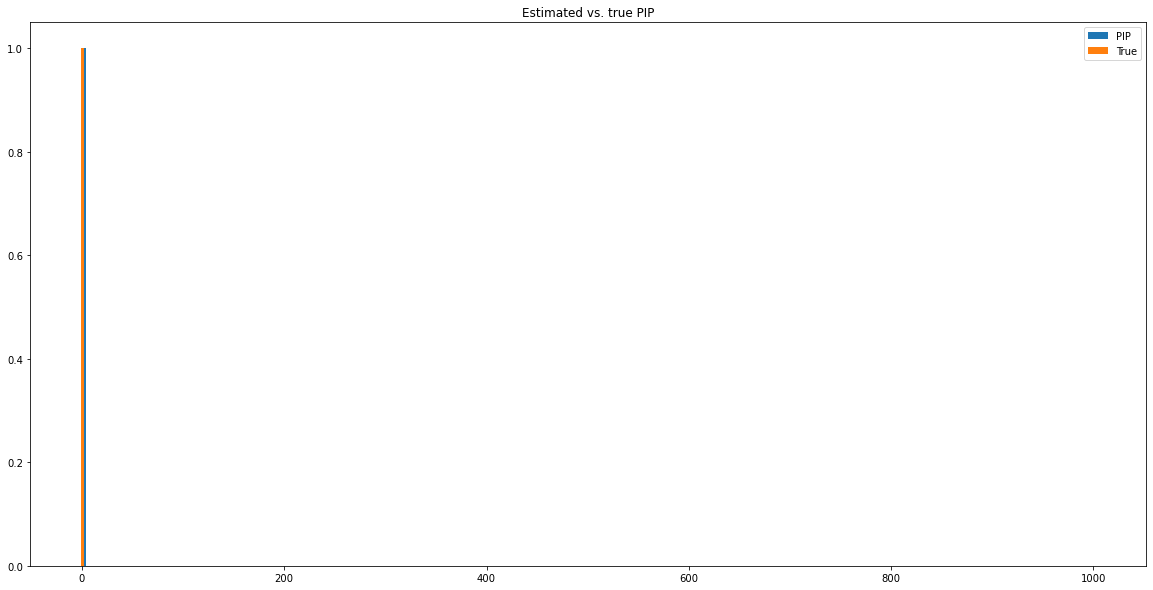

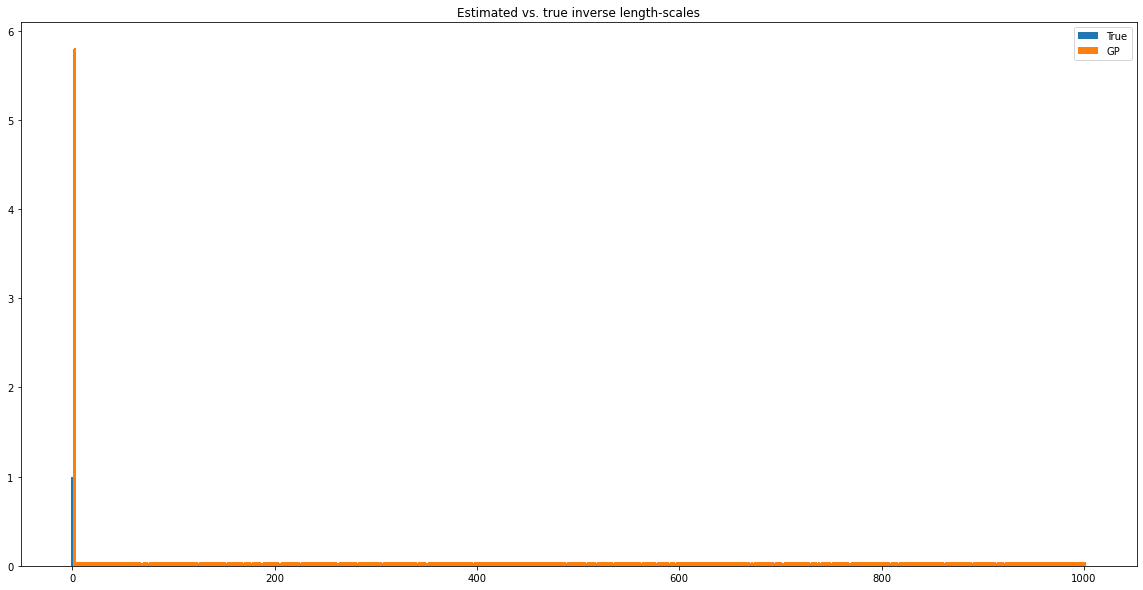

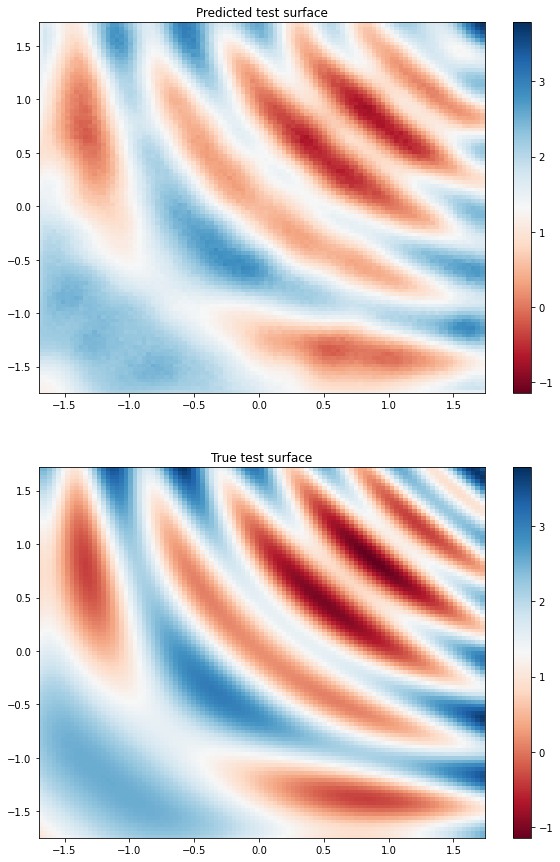

Latent test function MSE :  0.050778303
Observed test data  MSE :  0.34683752


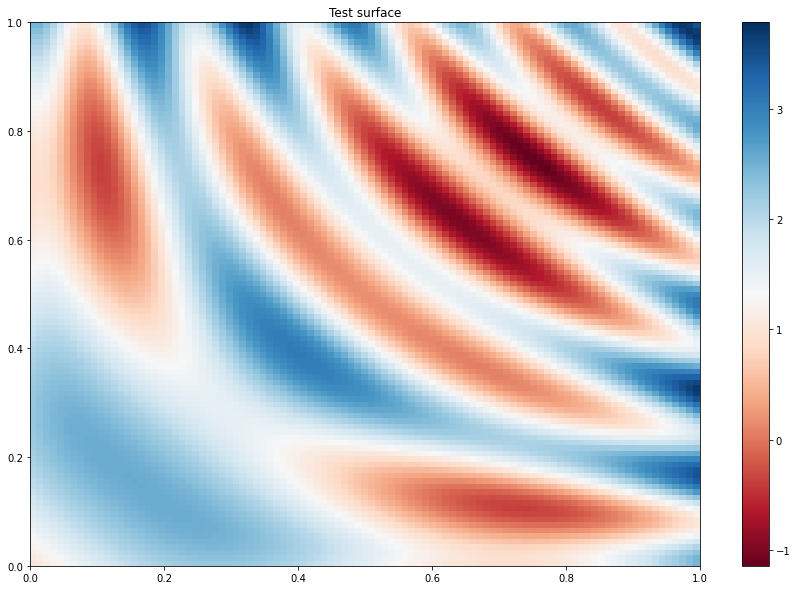

[7.031371  7.031371  7.0313716 7.031372  7.0313716 7.0313725 7.0313716
 7.0313725 7.0313725 7.0313706]
3.0403432846069336 0.0020497544
Iter 2 - Loss: 3.040
[7.1314087 7.1313868 7.131399  7.1314173 7.1313796 7.131418  7.1313305
 7.1314178 7.131418  7.131395 ]
3.0367156362533567 0.001994708
Iter 3 - Loss: 2.678
[7.231355  7.23103   7.2311125 7.231203  7.231522  7.231271  7.2313404
 7.2311916 7.2311473 7.2314687]
3.030344151163101 0.0019364386
Iter 4 - Loss: 2.400
[7.330376  7.3295283 7.329871  7.3300204 7.33117   7.3301473 7.330496
 7.329927  7.3297133 7.3309364]
3.0220364495882985 0.001867023
Iter 5 - Loss: 2.200
[7.427489  7.4260526 7.4269414 7.4270954 7.429459  7.4272637 7.4278984
 7.4268684 7.4263244 7.4289565]
3.0123079259318013 0.0017866831
Iter 6 - Loss: 2.049
[7.521723  7.5197244 7.521577  7.5216646 7.5255675 7.5218954 7.522792
 7.5213127 7.5202675 7.5247107]
3.0015021982521497 0.0016974161
Iter 7 - Loss: 1.932
[7.6122017 7.609713  7.6131263 7.6130714 7.6187973 7.613426  7.614555

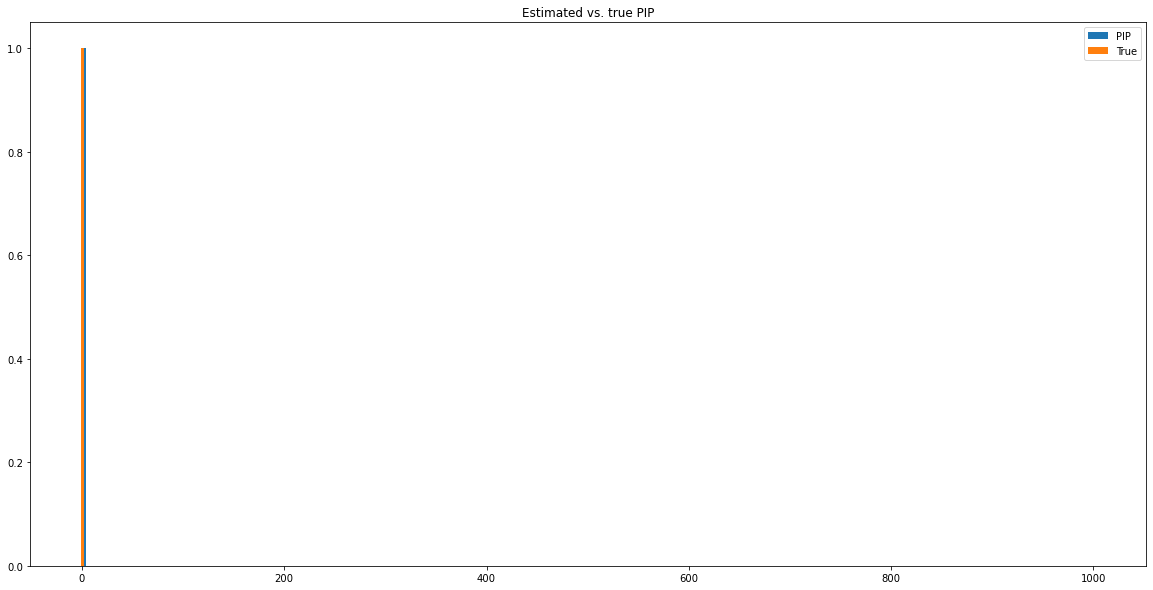

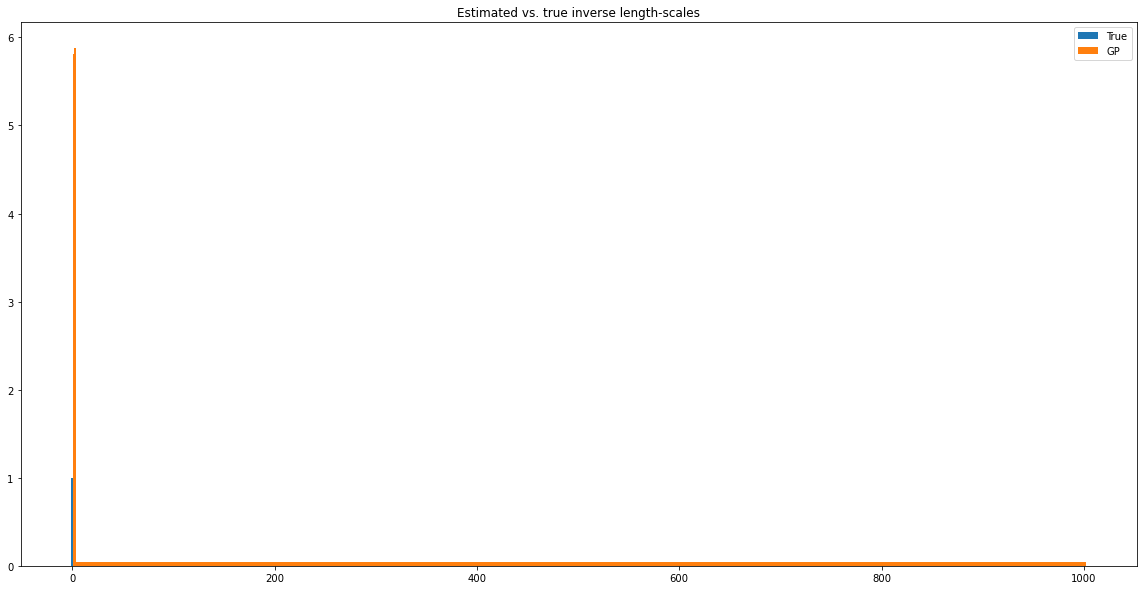

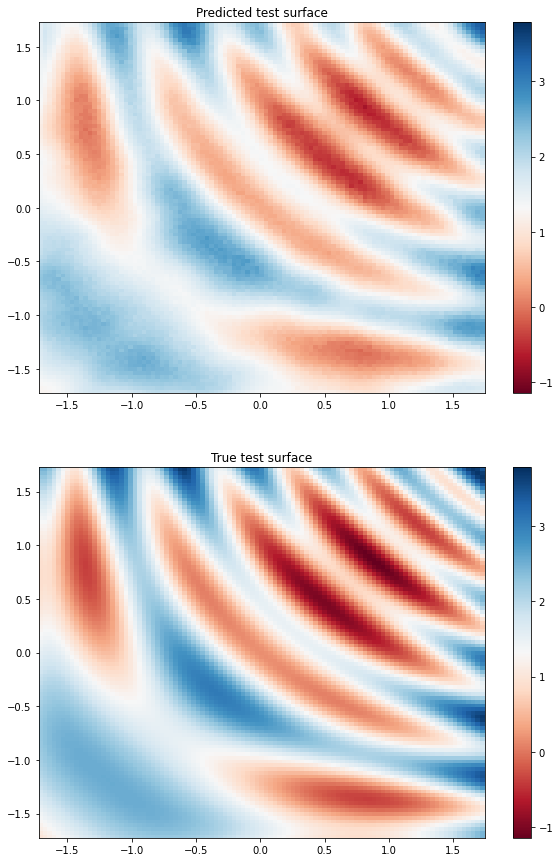

Latent test function MSE :  0.064162344
Observed test data  MSE :  0.36537564


[7.0285993 7.029279  7.0259366 7.0296383 7.02964   7.030447  7.029044
 7.0318046 7.030261  7.0297046]
2.8278205394744873 0.0020177606


[7.134793  7.1326523 7.1299963 7.136062  7.136271  7.1360397 7.135046
 7.138933  7.137229  7.1366644]
2.8243320178985596 0.0021083818


[7.244234  7.239149  7.237027  7.2468305 7.2468953 7.2457213 7.2463617
 7.2500744 7.2470856 7.2483773]
2.818372459220886 0.0021128822


[7.3523755 7.34576   7.3418436 7.354904  7.3571873 7.354066  7.356326
 7.3584504 7.355679  7.3594956]
2.8112064100284573 0.0020212857


[7.4571824 7.449341  7.4455986 7.4593434 7.4645066 7.457732  7.4645605
 7.464737  7.4611387 7.469396 ]
2.803878559471111 0.0019214825


[7.556047  7.545408  7.542736  7.559156  7.564873  7.5562086 7.565506
 7.563123  7.557832  7.5718536]
2.7950556175539205 0.0017506068


[7.6425934 7.6306033 7.6307783 7.651391  7.6595187 7.647182  7.65962
 7.655977  7.6502423 7.6665287]
2.7853311234377838 0.0015847224


[7.724136  7.7102113 7.714612  7.7347007 7.749183  7.7324944 7.7490883
 7.7424564 7.7345586 7.756162 ]
2.775221269759177 0.001439064


[7.7964606 7.783881  7.7907066 7.8117204 7.8305826 7.8121395 7.831278
 7.821111  7.8099566 7.836857 ]
2.765266341187867 0.0013008008


[7.8597946 7.8445215 7.8620486 7.8840938 7.905836  7.884616  7.9062285
 7.8946567 7.8818684 7.9129543]
2.7547486052872037 0.0011744854


[7.914288  7.8989344 7.9265904 7.948389  7.975899  7.9501157 7.975782
 7.9617124 7.945244  7.9848537]
2.744031999876269 0.0010603453


[7.9604983 7.948186  7.9856696 8.007329  8.040303  8.011     8.038914
 8.024584  8.004742  8.048817 ]
2.733951159543263 0.00095711654


[7.999753  7.9858475 8.04223   8.060088  8.099398  8.067522  8.098729
 8.08078   8.058412  8.107413 ]
2.7232094636998596 0.0008716775


[8.029463  8.0172615 8.091063  8.110906  8.154407  8.12062   8.152636
 8.134484  8.10882   8.161273 ]
2.7120804686474402 0.0007895778


[8.053942 8.042254 8.138945 8.158106 8.206937 8.169808 8.204187 8.184948
 8.156044 8.212065]
2.7009058769679393 0.00074272713


[8.072211  8.061071  8.182426  8.202773  8.255675  8.215593  8.2514105
 8.233615  8.199082  8.259367 ]
2.689922014512118 0.00068349484


[8.083079 8.073727 8.222788 8.244988 8.302967 8.258187 8.296303 8.279257
 8.240152 8.303102]
2.678828892351311 0.0006384571


[8.08812  8.07985  8.261479 8.283105 8.347695 8.301298 8.338882 8.323226
 8.280721 8.345089]
2.6678081217097347 0.0005988133


[8.089359  8.085732  8.2993145 8.320177  8.389464  8.341312  8.37817
 8.363331  8.317009  8.385526 ]
2.6570816620250772 0.0005630655


[8.0848255 8.082353  8.336843  8.355747  8.42939   8.379497  8.416228
 8.402207  8.350567  8.424392 ]
2.6464719559967147 0.0005296995


[8.076762 8.076442 8.370023 8.390252 8.468129 8.414212 8.453061 8.441953
 8.382981 8.461741]
2.63550277276411 0.0005052569


[8.062759 8.066005 8.402295 8.422024 8.505678 8.450078 8.487614 8.479127
 8.414294 8.496718]
2.6249083277219394 0.0004812035


[8.048334  8.050795  8.4321575 8.452895  8.540984  8.482738  8.521676
 8.514529  8.445132  8.529762 ]
2.614165826704852 0.0004573349


[8.031044 8.033343 8.462841 8.484434 8.576507 8.516145 8.554715 8.550091
 8.476582 8.564807]
2.6036921326578506 0.00045575362


[8.007461 8.016746 8.494391 8.515362 8.612271 8.548417 8.588576 8.584926
 8.50799  8.598404]
2.5932837780732156 0.0004481076


[7.982649 7.992422 8.522927 8.544441 8.645256 8.578301 8.618522 8.618969
 8.536104 8.627656]
2.5829249127560914 0.00040742778


[7.956135 7.965584 8.552276 8.574138 8.678823 8.610106 8.648964 8.65253
 8.565194 8.658427]
2.572492770037603 0.00041252322


[7.9266877 7.9381113 8.579208  8.603934  8.712066  8.640099  8.679852
 8.685074  8.59272   8.688654 ]
2.5626856513467793 0.00040570617


[7.8961945 7.9092736 8.608366  8.632001  8.743448  8.67074   8.709586
 8.717511  8.620874  8.719559 ]
2.552326811886916 0.00039613235


[7.857459  7.879092  8.63574   8.660553  8.7762165 8.701133  8.739045
 8.750408  8.650156  8.750132 ]
2.5420835330106004 0.0003975595


[7.82365  7.843024 8.663605 8.68762  8.808259 8.730293 8.76827  8.783615
 8.676176 8.778682]
2.532209706194899 0.00037862832


[7.783088 7.809719 8.690406 8.715441 8.84001  8.759982 8.797243 8.814983
 8.703644 8.807055]
2.522190260061447 0.00037933874


[7.743602 7.769818 8.717242 8.743456 8.870394 8.788168 8.825503 8.847031
 8.730054 8.83643 ]
2.5123380063942435 0.00037191564


[7.7018633 7.730021  8.744644  8.771133  8.901993  8.817793  8.854913
 8.878885  8.757069  8.865311 ]
2.502588674086496 0.0003741082


[7.6568956 7.689058  8.772581  8.800021  8.9349375 8.848264  8.883195
 8.910752  8.784957  8.896356 ]
2.4925019763028455 0.00037706614


[7.6114707 7.6470346 8.799126  8.8276    8.965892  8.878202  8.912391
 8.943475  8.813448  8.924449 ]
2.4827810368830634 0.0003679241


[7.5612764 7.6011047 8.826966  8.855984  8.997416  8.907602  8.94067
 8.974835  8.841077  8.953476 ]
2.4733038091138724 0.0003649979


[7.510479 7.553509 8.855123 8.885575 9.028446 8.936632 8.969651 9.006651
 8.867697 8.982951]
2.4639029334029523 0.0003667249


[7.458721 7.501408 8.883516 8.914094 9.059465 8.965326 8.99804  9.037938
 8.895996 9.012068]
2.4543919563035725 0.00036226818


[7.403854 7.448035 8.911252 8.942127 9.091494 8.995049 9.02691  9.07019
 8.922232 9.04021 ]
2.445092672084088 0.00036440097


[7.342575  7.3952928 8.93937   8.970794  9.123183  9.024929  9.0566635
 9.103014  8.952515  9.07096  ]
2.43585307005502 0.00036738897


[7.284505  7.3311744 8.966586  8.998973  9.155954  9.054336  9.085986
 9.13472   8.981396  9.10044  ]
2.4267139869672323 0.00036067714


[7.2185407 7.2724524 8.996731  9.029416  9.187428  9.083743  9.114484
 9.166768  9.008781  9.1290655]
2.4177065195008955 0.0003553505


[7.1525335 7.210578  9.0253    9.0576315 9.218452  9.113315  9.143354
 9.199764  9.037294  9.159644 ]
2.409154597357034 0.00035918667


[7.0808544 7.1418657 9.053566  9.088116  9.251154  9.143064  9.17261
 9.231361  9.065425  9.189297 ]
2.3998699645209 0.00036305335


[7.0101337 7.0678825 9.081649  9.116107  9.283021  9.172353  9.201485
 9.2638    9.093665  9.218517 ]
2.390950239837925 0.00035595105


[6.9345284 6.9946923 9.110551  9.145717  9.316108  9.203935  9.231622
 9.29651   9.122975  9.249268 ]
2.3822112198366256 0.0003584898


[6.850317 6.913775 9.139709 9.175689 9.34816  9.234434 9.260453 9.327949
 9.15137  9.280009]
2.373855921679397 0.00035625588


[6.765052  6.829786  9.1697645 9.20516   9.379989  9.264972  9.2894945
 9.36127   9.179407  9.309594 ]
2.3652294334998953 0.00035338014


[6.672398 6.742519 9.198207 9.235033 9.411987 9.296247 9.320395 9.394057
 9.210361 9.340339]
2.3564578047055917 0.00035682519


[6.5778675 6.64981   9.228122  9.265235  9.444907  9.326034  9.350588
 9.427366  9.239264  9.370625 ]
2.3480844908110625 0.00035556086


[6.4754763 6.5541334 9.258576  9.295751  9.477539  9.357429  9.380083
 9.460523  9.269239  9.40081  ]
2.3395600451052987 0.00035364245


[6.3670883 6.4457607 9.287097  9.325951  9.509457  9.388044  9.410886
 9.493286  9.298133  9.431104 ]
2.3311548864534095 0.00034895894


[6.253347 6.338384 9.317876 9.356914 9.542754 9.419879 9.440299 9.526679
 9.326769 9.462299]
2.322885749869912 0.00035589252


[6.1369286 6.2256684 9.346541  9.3877535 9.5757675 9.452256  9.470325
 9.560597  9.358619  9.492198 ]
2.314359005045926 0.00035609477


[6.0102835 6.103161  9.376586  9.418435  9.608996  9.483667  9.501545
 9.594     9.387943  9.521552 ]
2.306504923099791 0.00035141414


[5.871553  5.975546  9.407241  9.449876  9.643132  9.515676  9.532466
 9.628169  9.4169655 9.555194 ]
2.2984676389044227 0.000352493


[5.731892  5.831964  9.439573  9.4813385 9.676606  9.545552  9.563616
 9.661856  9.447922  9.586363 ]
2.2909873715901616 0.0003565093


[5.56865   5.6886497 9.468685  9.511862  9.710312  9.576421  9.593767
 9.695567  9.47757   9.617323 ]
2.2832093266592026 0.00034778845


[5.41108   5.5207353 9.499138  9.543809  9.744687  9.60894   9.624011
 9.729245  9.508548  9.648333 ]
2.275362398988619 0.00035154363


[5.2312   5.346158 9.530901 9.575033 9.778037 9.640732 9.65501  9.763537
 9.540104 9.679134]
2.2676225555926046 0.00035369664


[5.0321646 5.1681037 9.562763  9.604935  9.812695  9.672547  9.686368
 9.798167  9.569941  9.710553 ]
2.259923701729336 0.00035479467


[4.821642 4.97191  9.594366 9.63645  9.846247 9.704751 9.717573 9.830792
 9.601131 9.743237]
2.252178204450507 0.0003530848


[4.6024456 4.7548084 9.62693   9.668752  9.880996  9.736453  9.748474
 9.865745  9.630442  9.776003 ]
2.2445640995796166 0.0003619068


[4.3661647 4.5276628 9.659189  9.702089  9.915222  9.770836  9.779901
 9.900471  9.662271  9.807605 ]
2.2369944928436163 0.00036315242


[4.1071215 4.2802925 9.689084  9.733753  9.950566  9.803195  9.813195
 9.9350605 9.694005  9.839524 ]
2.2294798910185887 0.00036643178


[3.8362656 4.0114274 9.721224  9.765908  9.985482  9.8367405 9.844905
 9.970316  9.726628  9.87222  ]
2.222367782728825 0.00037464625


[ 3.541184   3.729352   9.7539215  9.800711  10.02192    9.870831
  9.877043  10.006744   9.758836   9.906844 ]
2.215012434664949 0.00038965387


[ 3.2232618  3.422432   9.78835    9.8328    10.057022   9.904286
  9.909819  10.04018    9.792781   9.939282 ]
2.2077972303908555 0.0003916614


[ 2.8876011  3.091653   9.823918   9.868171  10.093165   9.938681
  9.943552  10.076939   9.826005   9.972708 ]
2.200655841129092 0.00041831876


[ 2.5296657  2.7482734  9.859122   9.903689  10.130472   9.97399
  9.977695  10.11455    9.859326  10.007278 ]
2.193748891615964 0.0004440516


[ 2.171375   2.3937836  9.896409   9.941162  10.167986  10.011231
 10.0120325 10.153011   9.895473  10.043344 ]
2.1866101094697474 0.00048334745


[ 1.8108568  2.036983   9.938145   9.979986  10.20812   10.0508585
 10.051406  10.193633   9.9339    10.083    ]
2.1794362338312876 0.0005584405


[ 1.4637457  1.6837866  9.981362  10.021777  10.250267  10.090783
 10.092668  10.234876   9.975889  10.124707 ]
2.1724401240755244 0.0006448852


[ 1.1586889  1.3552593 10.030054  10.0679865 10.297512  10.136377
 10.13707   10.281743  10.023767  10.17212  ]
2.165322484767142 0.0007771806


[ 0.9517646  1.1121488 10.086893  10.121049  10.349352  10.187536
 10.1891    10.333531  10.077555  10.225445 ]
2.158375596179313 0.0008599295


[ 0.8653551   0.97345793 10.151757   10.181765   10.405828   10.244858
 10.247242   10.390338   10.137416   10.285046  ]
2.1516922205905207 0.00079386303


[ 0.8522965  0.925948  10.2222395 10.246914  10.465787  10.305909
 10.310227  10.451057  10.20414   10.349928 ]
2.144926543168017 0.00067656644


[ 0.8552529   0.89869034 10.29612    10.316667   10.530163   10.371292
 10.376286   10.516515   10.273572   10.420321  ]
2.138007761220605 0.0006696913


[ 0.8401288   0.87397265 10.374133   10.39026    10.596754   10.440036
 10.445345   10.584415   10.346293   10.493988  ]
2.1311519670175176 0.00071207114


[ 0.8236542  0.8369136 10.455056  10.465678  10.666887  10.511429
 10.518373  10.6538725 10.421807  10.569146 ]
2.12453351680535 0.0007481867


[ 0.8041827  0.8204685 10.538394  10.543546  10.738658  10.585994
 10.594013  10.727199  10.500236  10.649056 ]
2.118125937794218 0.00074417645


[ 0.79886734  0.8196479  10.6254015  10.626577   10.814164   10.662724
 10.672456   10.8049345  10.582789   10.73115   ]
2.1114032727384804 0.0007219968


[ 0.7771566  0.798319  10.713435  10.711473  10.8902235 10.741713
 10.753115  10.882325  10.664724  10.814524 ]
2.1047954512919187 0.00077814277


[ 0.7776095  0.7790541 10.807771  10.799726  10.971538  10.822967
 10.836254  10.963907  10.752766  10.903063 ]
2.0985769965005265 0.0007653102


[ 0.76601636  0.75427824 10.90472    10.889517   11.053999   10.906866
 10.923187   11.046934   10.841561   10.993622  ]
2.0925172774369343 0.00079928845


[ 0.7513449   0.75660473 11.004073   10.984061   11.140006   10.995079
 11.013324   11.134618   10.935407   11.088127  ]
2.08578659914842 0.00079125236


[ 0.7399101  0.7457653 11.104691  11.079322  11.226687  11.083761
 11.103437  11.2234125 11.029905  11.184652 ]
2.0791747045982047 0.0008011458


[ 0.7329211   0.74184877 11.20779    11.179575   11.31591    11.1775465
 11.197741   11.314945   11.127697   11.283336  ]
2.072754054640083 0.00079286704


[ 0.71958303  0.707254   11.313411   11.279935   11.4096     11.2716
 11.294038   11.40912    11.227923   11.384558  ]
2.066326513569161 0.0008679828


[ 0.72752106  0.71836245 11.422062   11.383913   11.503584   11.368087
 11.3919735  11.502735   11.3292465  11.485973  ]
2.060238301886915 0.0008064579


[ 0.7041315  0.7105714 11.5337515 11.488601  11.601832  11.467682
 11.493793  11.601982  11.432025  11.592985 ]
2.053812530768375 0.0008494601


[ 0.6958925  0.6942135 11.64565   11.5949745 11.698764  11.567877
 11.595602  11.701313  11.537509  11.699918 ]
2.047234873037672 0.0008243153


[ 0.70288503  0.67967963 11.759724   11.7038     11.799085   11.671589
 11.699848   11.803309   11.64368    11.808671  ]
2.041170420110747 0.00082815875


[ 0.69315875  0.6809184  11.877352   11.816206   11.901174   11.775217
 11.806613   11.908168   11.75185    11.920734  ]
2.0349983942925127 0.00080651295


[ 0.6753022   0.67161554 11.9951515  11.928884   12.006427   11.880348
 11.914341   12.01347    11.862613   12.033933  ]
2.028787715702752 0.0008370495


[ 0.6589117  0.6651063 12.115468  12.041932  12.113531  11.989283
 12.023906  12.121457  11.974869  12.14855  ]
2.022481048539087 0.0008254013


[ 0.66440964  0.6529533  12.234691   12.155379   12.219011   12.097458
 12.132657   12.227736   12.087394   12.261871  ]
2.01648536045398 0.0007982836


[ 0.6719259   0.65557307 12.35622    12.267961   12.325788   12.209053
 12.241347   12.334169   12.199952   12.378038  ]
2.0103600602532943 0.0007761637


[ 0.6470383  0.6312075 12.476334  12.381639  12.432101  12.317373
 12.352616  12.444343  12.312421  12.495022 ]
2.004140583214528 0.0008546785


[ 0.6529434  0.642083  12.5960455 12.496017  12.540272  12.423517
 12.462604  12.551507  12.424987  12.611081 ]
1.9979894032696812 0.00076407957


[ 0.63680464  0.63304126 12.715952   12.606694   12.64516    12.532357
 12.571431   12.658453   12.536548   12.7240505 ]
1.9921014360501101 0.0007667055


[ 0.63752174  0.61774236 12.835195   12.719614   12.750815   12.640541
 12.680024   12.764099   12.649409   12.836643  ]
1.9861943987403903 0.0007279427


[ 0.64420235  0.6235325  12.954576   12.832136   12.860081   12.750364
 12.788592   12.873326   12.761663   12.950795  ]
1.9799987185717272 0.00071533263


[ 0.62416494  0.60964143 13.068816   12.937883   12.963399   12.855003
 12.893601   12.976436   12.870729   13.062547  ]
1.9739289760225456 0.00073272735


[ 0.63238865  0.6060312  13.186983   13.046641   13.065256   12.96021
 12.997941   13.079905   12.977993   13.173247  ]
1.9678073436853394 0.00066545676


[ 0.61885417  0.60155445 13.300059   13.149352   13.165918   13.062736
 13.098671   13.180394   13.084327   13.281833  ]
1.961673041753842 0.0006523825


[ 0.60554767  0.60651183 13.410856   13.252871   13.268566   13.164824
 13.198677   13.279895   13.187126   13.38782   ]
1.955564217534805 0.0006397908


[ 0.6090871  0.5862037 13.518778  13.353403  13.365932  13.263851
 13.296456  13.378977  13.28768   13.490628 ]
1.9497528199349574 0.0006370249


[ 0.6023013   0.58495754 13.626065   13.449795   13.462777   13.360133
 13.392518   13.47493    13.385044   13.5913925 ]
1.9436657789105956 0.0005639405


[ 0.5988944  0.5804133 13.731313  13.5422125 13.554828  13.454528
 13.48644   13.567044  13.482456  13.691502 ]
1.9377158617106314 0.0005458727


[ 0.585946   0.5761913 13.837236  13.636933  13.649914  13.552981
 13.578156  13.660321  13.579046  13.788567 ]
1.931409342465397 0.00056541746


[ 0.57996625  0.56876564 13.936744   13.7274065  13.737764   13.642552
 13.668508   13.747597   13.669741   13.881038  ]
1.9257989147740804 0.00052586815


[ 0.5760008   0.55545795 14.034403   13.817354   13.824737   13.733146
 13.757854   13.836003   13.760009   13.974672  ]
1.9202044142528196 0.00053140195


[ 0.5829425   0.55945283 14.131372   13.903737   13.910642   13.821715
 13.844214   13.924651   13.850333   14.067243  ]
1.9142450582893076 0.0004937751


[ 0.5668039  0.5496736 14.225356  13.990266  13.995436  13.906812
 13.925009  14.009577  13.936829  14.156995 ]
1.908237617710458 0.0005217979


[ 0.5576038  0.5348783 14.320124  14.073788  14.079706  13.994308
 14.009323  14.092419  14.023746  14.244114 ]
1.9023287072621131 0.0005108449


[ 0.55302006  0.5399169  14.411812   14.154935   14.163486   14.080441
 14.0914755  14.175442   14.109166   14.329065  ]
1.8967501025491873 0.00045460468


[ 0.5484263   0.53443074 14.505297   14.236465   14.24607    14.164275
 14.172097   14.257627   14.193566   14.416431  ]
1.8911880342248062 0.00044183453


[ 0.5431758   0.52217615 14.593985   14.316367   14.324029   14.244904
 14.250544   14.337644   14.273105   14.497159  ]
1.8853350308738301 0.00045437497


[ 0.5340882  0.5200354 14.681669  14.390316  14.402263  14.325374
 14.327225  14.417713  14.352871  14.57854  ]
1.879892391853544 0.00042037122


[ 0.52925915  0.5174788  14.768754   14.467188   14.48275    14.405376
 14.404967   14.495208   14.433693   14.661198  ]
1.8744404523214524 0.00040606447


[ 0.5258621  0.5073054 14.855723  14.544319  14.557691  14.484143
 14.478764  14.57346   14.512011  14.7427225]
1.8688682034169055 0.0004202774


[ 0.5143198  0.5011837 14.940543  14.621546  14.634098  14.562555
 14.555734  14.648434  14.5904665 14.824722 ]
1.8632355802664033 0.00043139202


[ 0.50055766  0.5002743  15.023671   14.694259   14.709384   14.638967
 14.628744   14.721103   14.665722   14.89934   ]
1.8578163690045262 0.00040334364


[ 0.5024472   0.48272243 15.10717    14.767258   14.783407   14.715795
 14.703453   14.797165   14.743121   14.975872  ]
1.8526106337316868 0.0004262091


[ 0.4998215  0.4834357 15.189332  14.84177   14.858267  14.794036
 14.776196  14.871822  14.818908  15.05337  ]
1.8469076942415987 0.00035626124


[ 0.48820925  0.47975534 15.27006    14.913382   14.928065   14.871722
 14.849451   14.943528   14.89313    15.132884  ]
1.8418211856585576 0.00039438283


[ 0.47525346  0.47186425 15.350593   14.983994   15.001041   14.943585
 14.919592   15.015661   14.967635   15.2070875 ]
1.836573001534821 0.00041235864


[ 0.48507893  0.46340325 15.433687   15.055506   15.076108   15.019244
 14.991483   15.089069   15.04168    15.282539  ]
1.8313905016811396 0.00040891778


[ 0.47157958  0.46014413 15.512823   15.127116   15.146482   15.09094
 15.061341   15.161027   15.116846   15.355648  ]
1.8264483384360262 0.0003864716


[ 0.46168584  0.44888943 15.592612   15.19643    15.217468   15.165132
 15.130985   15.228757   15.188787   15.431859  ]
1.8216318621584469 0.00040838544


[ 0.45523858  0.4471453  15.671684   15.26937    15.289069   15.237976
 15.203638   15.299777   15.263294   15.504771  ]
1.8164197821423618 0.00034869928


[ 0.44973025  0.44539028 15.75061    15.338421   15.360449   15.309817
 15.273702   15.371846   15.335943   15.577388  ]
1.8117274535512087 0.00034090003


[ 0.43895015  0.42833635 15.828422   15.406412   15.429759   15.383849
 15.342209   15.4396715  15.406417   15.650849  ]
1.8066831501212721 0.0004388427


[ 0.43811524  0.42595205 15.904916   15.478072   15.500453   15.454575
 15.41487    15.510255   15.479431   15.725755  ]
1.8013967465527987 0.00031668253


[ 0.43129197  0.42117524 15.982123   15.547555   15.571054   15.528538
 15.486076   15.581412   15.552232   15.796091  ]
1.7963045951978818 0.00035510355


[ 0.41709423  0.4080553  16.059011   15.617122   15.640113   15.598809
 15.556033   15.65163    15.6223135  15.867371  ]
1.7916048010273666 0.00044063033


[ 0.41454667  0.40505517 16.13817    15.689062   15.710726   15.671045
 15.627435   15.72193    15.694668   15.94328   ]
1.7865678731285586 0.00032161825


[ 0.40749997  0.39550117 16.212973   15.75932    15.781651   15.742635
 15.698836   15.791474   15.765351   16.014551  ]
1.7816238972590588 0.00038757228


[ 0.39982587  0.3942852  16.29096    15.829392   15.852451   15.8155365
 15.768735   15.863126   15.838019   16.086746  ]
1.7767633214906613 0.0003372308


[ 0.39136693  0.38593346 16.366093   15.902041   15.919253   15.888952
 15.840223   15.932647   15.911401   16.159912  ]
1.7716925648016335 0.000386883


[ 0.386308    0.37668282 16.442738   15.973589   15.98985    15.960665
 15.911938   16.002659   15.984818   16.235317  ]
1.7670990155230935 0.00037737


[ 0.37458262  0.36993855 16.519516   16.043533   16.05979    16.034342
 15.981532   16.07416    16.056845   16.307177  ]
1.7623971747189824 0.0004050208


[ 0.36910126  0.36278665 16.596214   16.116505   16.127823   16.104729
 16.053202   16.145084   16.129486   16.377844  ]
1.7581246636670593 0.0003658003


[ 0.36723176  0.36019534 16.672989   16.191717   16.198826   16.179937
 16.128555   16.21645    16.20029    16.45249   ]
1.7535664752064293 0.0003107182


[ 0.35554317  0.35166958 16.748869   16.261278   16.270464   16.253433
 16.201185   16.288654   16.273811   16.526546  ]
1.748948565104481 0.0004292075


[ 0.34917036  0.34074947 16.828945   16.337036   16.341793   16.326204
 16.273531   16.359861   16.346573   16.602047  ]
1.7444340998620664 0.0004163785


[ 0.34390825  0.33462626 16.905876   16.408785   16.412277   16.398571
 16.34986    16.433884   16.422089   16.675016  ]
1.7397778722190824 0.00036957243


[ 0.33147773  0.32659537 16.98104    16.482908   16.484169   16.472086
 16.42385    16.507233   16.498081   16.7497    ]
1.734908803862187 0.0004520423


[ 0.32945767  0.32018605 17.060228   16.559717   16.557943   16.548769
 16.500856   16.582396   16.573212   16.82696   ]
1.7300894168180567 0.00035715333


[ 0.31616992  0.30577257 17.141476   16.636406   16.63035    16.625013
 16.579132   16.66002    16.64954    16.904146  ]
1.725604973245732 0.00054740725


[ 0.3073508   0.30033848 17.221819   16.715992   16.705774   16.703688
 16.660027   16.73561    16.727879   16.983793  ]
1.7210542638987114 0.00042926476


[ 0.2957418  0.2898868 17.304146  16.796545  16.781021  16.782875
 16.740795  16.812233  16.807165  17.063524 ]
1.7165724493156784 0.00052750343


[ 0.28852552  0.28015772 17.38865    16.880703   16.860426   16.86434
 16.822905   16.89282    16.887625   17.145533  ]
1.7122286042094235 0.00048906944


[ 0.27551174  0.27309433 17.474438   16.966774   16.942183   16.947168
 16.907314   16.977139   16.971212   17.227913  ]
1.708097270897508 0.0005477659


[ 0.2619291   0.25986278 17.55953    17.05502    17.024199   17.02881
 16.994081   17.060284   17.056726   17.315054  ]
1.7034697255032911 0.0006676278


[ 0.2544893   0.25178936 17.649544   17.14694    17.108961   17.11839
 17.087177   17.147635   17.144865   17.404024  ]
1.6990496849350412 0.00054028025


[ 0.24318343  0.24376483 17.740435   17.23741    17.195694   17.206503
 17.18008    17.23578    17.233873   17.495876  ]
1.694433340030805 0.0006168004


[ 0.23289044  0.23650461 17.834229   17.332733   17.284319   17.29816
 17.275936   17.326563   17.325527   17.589527  ]
1.6902470351377294 0.00061911764


[ 0.22601107  0.2301065  17.929647   17.430758   17.376614   17.391953
 17.371649   17.418682   17.420256   17.683496  ]
1.6857937089113368 0.0005616474


[ 0.22157821  0.22160578 18.026695   17.531109   17.469397   17.487808
 17.472174   17.514856   17.516876   17.782572  ]
1.6813107343905067 0.00057512923


[ 0.21465239  0.21575284 18.122133   17.63175    17.56358    17.582684
 17.572735   17.611265   17.612282   17.882507  ]
1.676861931112306 0.0005832673


[ 0.21343768  0.21056226 18.219667   17.733747   17.65869    17.681591
 17.67449    17.709072   17.7085     17.982996  ]
1.6721110804226276 0.0004588267


[ 0.20658706  0.20657712 18.316635   17.835157   17.752941   17.778835
 17.774399   17.805393   17.805569   18.080853  ]
1.667398395807824 0.00055847276


[ 0.20409149  0.2028262  18.415552   17.937206   17.847597   17.87538
 17.875614   17.901676   17.899702   18.180132  ]
1.6628538032815543 0.00045655473


[ 0.20312299  0.20238443 18.513336   18.038736   17.941141   17.972242
 17.977043   17.997658   17.996605   18.280388  ]
1.6583307802519431 0.00033925852


[ 0.19510664  0.2004945  18.610582   18.13801    18.03739    18.069485
 18.07753    18.094872   18.091646   18.379307  ]
1.6536612834178226 0.0005486189


[ 0.2022742  0.1997242 18.707586  18.239511  18.132895  18.166359
 18.17717   18.190777  18.187391  18.478724 ]
1.6497879443949848 0.0004979316


[ 0.1972479   0.19506472 18.80372    18.336264   18.225382   18.261591
 18.275581   18.285555   18.282095   18.57483   ]
1.6454598623715366 0.00053531677


[ 0.1941771  0.1960315 18.90206   18.43725   18.31942   18.359503
 18.375635  18.38335   18.378908  18.673302 ]
1.6408724483867982 0.0003959081


[ 0.19424441  0.19361542 18.996534   18.537142   18.412779   18.455256
 18.475174   18.476849   18.472738   18.771566  ]
1.6362903916885747 0.0003480075


[ 0.19260041  0.19384259 19.09009    18.634762   18.50405    18.548933
 18.571203   18.570911   18.5651     18.867409  ]
1.6317818919827332 0.00032460009


[ 0.19117177  0.19088918 19.183462   18.731148   18.596111   18.64263
 18.667192   18.664547   18.658545   18.962362  ]
1.6273628267059417 0.00039032486


[ 0.1906671   0.19140233 19.276766   18.826967   18.684923   18.734957
 18.763346   18.75839    18.750639   19.056068  ]
1.6229902397081846 0.00029545513


[ 0.19007733  0.18968557 19.370283   18.923315   18.776785   18.827936
 18.857933   18.850937   18.842367   19.150316  ]
1.6187434207976599 0.0003289991


[ 0.18928455  0.18610686 19.462067   19.019003   18.866606   18.919434
 18.950768   18.941576   18.93223    19.244646  ]
1.6143943309252393 0.00037985152


[ 0.18935029  0.1898504  19.553614   19.113194   18.954628   19.009537
 19.0452     19.031488   19.023407   19.33724   ]
1.6099449178646288 0.00035947317


[ 0.18722688  0.18525311 19.640648   19.20357    19.041788   19.09919
 19.136862   19.121178   19.110271   19.426378  ]
1.6053763674954153 0.00043546455


[ 0.18842058  0.18785608 19.729431   19.296705   19.129492   19.189075
 19.22708    19.212177   19.19851    19.519657  ]
1.6008665822731436 0.00035217495


[ 0.18610124  0.18500827 19.819008   19.3889     19.21394    19.278046
 19.317421   19.298943   19.285007   19.609661  ]
1.596465381002338 0.00038614197


[ 0.18782534  0.18562368 19.906466   19.477219   19.296486   19.365057
 19.406351   19.38498    19.370975   19.698135  ]
1.5921420579113088 0.00029815023


[ 0.1846267   0.18423623 19.993275   19.56433    19.380577   19.451786
 19.494085   19.471432   19.455204   19.787285  ]
1.5878270361530726 0.00036165302


[ 0.18415314  0.1854698  20.07836    19.652863   19.464268   19.537334
 19.58171    19.556755   19.539268   19.873425  ]
1.5832264175783461 0.00027570073


[ 0.18572205  0.18278769 20.16444    19.739964   19.54676    19.623829
 19.667862   19.642897   19.62176    19.961206  ]
1.5791430943472342 0.00034616762


[ 0.18405184  0.18238038 20.248095   19.825102   19.629549   19.70736
 19.755384   19.726353   19.705801   20.045404  ]
1.574951523595107 0.0002771629


[ 0.1842923   0.18433636 20.33257    19.911312   19.709427   19.790087
 19.838318   19.81178    19.789696   20.132103  ]
1.5708176733181098 0.00027977602


[ 0.18401326  0.18480955 20.415152   19.995428   19.789274   19.870388
 19.921375   19.89506    19.870716   20.216455  ]
1.5664758543882735 0.00022941288


[ 0.1816462   0.18293685 20.497482   20.076225   19.867443   19.951595
 20.005      19.975649   19.951588   20.299139  ]
1.5623573738442686 0.00033139938


[ 0.1831553   0.18050581 20.578804   20.159212   19.946947   20.032673
 20.08612    20.057245   20.03217    20.38084   ]
1.5580446886346497 0.00031966646


[ 0.1847629  0.1846275 20.660114  20.242386  20.026367  20.114382
 20.169617  20.137478  20.110262  20.46108  ]
1.5537739274553954 0.00037080908


[ 0.18184438  0.18237773 20.738602   20.3207     20.102285   20.192017
 20.249203   20.214104   20.18675    20.539942  ]
1.5498457973078863 0.000343571


[ 0.1799602   0.18019997 20.818851   20.400833   20.179161   20.271494
 20.328773   20.294056   20.266474   20.620546  ]
1.5456594795611716 0.00031620785


[ 0.18294215  0.18202169 20.898994   20.482061   20.255558   20.351583
 20.408297   20.372976   20.34425    20.700575  ]
1.5415083588084522 0.00033659601


[ 0.18204325  0.18280981 20.975899   20.561604   20.332537   20.428621
 20.487637   20.450144   20.421112   20.779352  ]
1.5373928925108644 0.00023561722


[ 0.17951167  0.1800452  21.052294   20.637482   20.405489   20.504215
 20.565271   20.526981   20.495926   20.85633   ]
1.5332457547291731 0.00034093705


[ 0.1816593   0.18054517 21.128624   20.715189   20.480291   20.581524
 20.643337   20.60491    20.570505   20.932991  ]
1.52933406329707 0.00026041907


[ 0.18167925  0.17962985 21.20525    20.79284    20.553226   20.657541
 20.719305   20.680775   20.645315   21.010807  ]
1.5253739641268067 0.00020718884


[ 0.17908514  0.18229294 21.2808     20.867126   20.626276   20.731316
 20.793901   20.75584    20.718443   21.084766  ]
1.5213664968110545 0.0003330484


[ 0.18006474  0.18104802 21.354837   20.94406    20.697702   20.806166
 20.869394   20.827694   20.790909   21.158571  ]
1.5175811725163906 0.0002368211


[ 0.1796602   0.17676133 21.429724   21.0187     20.771202   20.879793
 20.944223   20.903492   20.863628   21.23371   ]
1.5134812139005864 0.0003154729


[ 0.18105543  0.18161538 21.502293   21.092018   20.841951   20.952637
 21.017412   20.976665   20.93592    21.306805  ]
1.5095049646602166 0.00035897188


[ 0.17951703  0.17893066 21.575817   21.166197   20.911314   21.02469
 21.092419   21.04843    21.007668   21.380787  ]
1.5055806599095494 0.0002936703


[ 0.18017434  0.17834766 21.648222   21.23824    20.979406   21.095692
 21.164179   21.119999   21.077087   21.451826  ]
1.5015879772518754 0.00019848673


[ 0.17957985  0.17819281 21.720057   21.309954   21.04643    21.167376
 21.235884   21.190607   21.147259   21.52225   ]
1.4976991068711412 0.00017901266


[ 0.17838138  0.1806559  21.791199   21.38119    21.115747   21.23926
 21.307173   21.26106    21.216467   21.59312   ]
1.493944415139817 0.00027000808


[ 0.18039177  0.177292   21.863447   21.453861   21.184889   21.309666
 21.380249   21.33194    21.288414   21.664831  ]
1.489868712624695 0.00032229687


[ 0.17646517  0.17851026 21.933846   21.522018   21.252686   21.380127
 21.451906   21.401203   21.356792   21.736368  ]
1.486106867272435 0.0003133015


[ 0.17953998  0.18022962 22.003965   21.59256    21.322145   21.44972
 21.521948   21.471153   21.425056   21.805786  ]
1.482056886684885 0.00030146248


[ 0.17960566  0.17741272 22.073767   21.660324   21.387407   21.51738
 21.589241   21.540163   21.491634   21.87247   ]
1.4784433082984594 0.00023558109


[ 0.17672612  0.1791775  22.143982   21.727942   21.452888   21.586538
 21.659113   21.609549   21.55971    21.94133   ]
1.4747895538691917 0.00029217332


[ 0.1793013  0.1768528 22.21299   21.796515  21.51899   21.654684
 21.728317  21.678265  21.625933  22.009287 ]
1.4710990161185857 0.00029757965


[ 0.17746097  0.17674409 22.28123    21.862823   21.583462   21.723864
 21.79622    21.744904   21.691242   22.077742  ]
1.4674611718237938 0.0002024571


[ 0.17890741  0.17927225 22.347097   21.930641   21.64868    21.790094
 21.862612   21.810871   21.756708   22.14293   ]
1.4639684331886704 0.00026402975


[ 0.17657833  0.1777339  22.414639   21.997253   21.713413   21.8575
 21.931564   21.876875   21.819967   22.208866  ]
1.460383182440997 0.00025970233


[ 0.1797667   0.17754836 22.481966   22.062265   21.77953    21.92434
 21.999603   21.94278    21.884802   22.274097  ]
1.4569547589799292 0.00024343989


[ 0.17796876  0.17878097 22.54797    22.12676    21.841118   21.99155
 22.066484   22.008688   21.949991   22.340195  ]
1.4535086754976434 0.00022939128


[ 0.17649166  0.17502351 22.615389   22.193134   21.903997   22.05694
 22.13162    22.072014   22.01476    22.405325  ]
1.4498903046030338 0.00029931284


[ 0.17702767  0.17772302 22.679623   22.258242   21.965637   22.122364
 22.19582    22.137712   22.077337   22.469799  ]
1.4462260120191923 0.00023480231


[ 0.17759393  0.17747794 22.745605   22.324074   22.028738   22.186768
 22.26225    22.20377    22.141623   22.536102  ]
1.4426530615436994 0.00015691324


[ 0.17655544  0.17639095 22.809675   22.386385   22.089878   22.248526
 22.327387   22.26741    22.204512   22.601006  ]
1.4391569224783265 0.00019474603


[ 0.17773543  0.17710173 22.875849   22.451868   22.153236   22.315073
 22.391874   22.331503   22.267921   22.665615  ]
1.4356862104446289 0.00018923118


[ 0.17697968  0.17685    22.940231   22.5156     22.215046   22.379004
 22.45575    22.394377   22.33085    22.727343  ]
1.4325671198512604 0.00015810382


[ 0.17827259  0.17711827 23.003202   22.578724   22.276022   22.4425
 22.520218   22.458685   22.393017   22.790564  ]
1.4292986443162 0.00017332908


[ 0.17740618  0.17547399 23.068346   22.64144    22.335733   22.505701
 22.583641   22.52146    22.453655   22.852415  ]
1.4260670997713838 0.00020280042


[ 0.1752965   0.17848928 23.13231    22.703161   22.39671    22.569448
 22.644436   22.58466    22.515364   22.915556  ]
1.422970192773609 0.0002860378


[ 0.17922746  0.17581831 23.195522   22.76589    22.457962   22.631674
 22.70937    22.646599   22.577225   22.977839  ]
1.419402107171251 0.00032988883


[ 0.17574227  0.1756929  23.257568   22.82727    22.517004   22.695435
 22.771221   22.70968    22.637817   23.038269  ]
1.4158859649561975 0.00023393615


[ 0.17705023  0.17601688 23.319492   22.887407   22.576143   22.7575
 22.834822   22.771927   22.699358   23.099663  ]
1.412591458486567 0.00017011396


[ 0.17686325  0.17726378 23.383465   22.950308   22.635212   22.82064
 22.897493   22.835112   22.75927    23.160227  ]
1.4091271483061507 0.00016397136


[ 0.17677835  0.17565614 23.445297   23.011503   22.696732   22.881323
 22.957245   22.895245   22.818457   23.221125  ]
1.4058265383964994 0.00016931962


[ 0.17692119  0.17728512 23.506237   23.07176    22.753906   22.942997
 23.019453   22.956356   22.87774    23.28138   ]
1.4025212513374246 0.00017081047


[ 0.17564885  0.17548612 23.56959    23.132624   22.8129     23.00364
 23.080868   23.01598    22.937605   23.339914  ]
1.399488543182342 0.00021215367


[ 0.17752708  0.17639142 23.630703   23.19149    22.869278   23.06323
 23.141218   23.07564    22.997046   23.401123  ]
1.396433789891632 0.00020022926


[ 0.17702964  0.1746664  23.69099    23.250378   22.926517   23.12381
 23.200031   23.13482    23.056623   23.460424  ]
1.3932997053553713 0.00018164034


[ 0.17696956  0.17697465 23.75155    23.309853   22.985495   23.184618
 23.262854   23.195824   23.113989   23.51926   ]
1.390136945747649 0.00018705957


[ 0.17556329  0.17532566 23.81004    23.368193   23.04152    23.242582
 23.321857   23.25559    23.171345   23.57804   ]
1.3870102161350668 0.00020465108


[ 0.17711923  0.17670421 23.87041    23.426647   23.09954    23.303139
 23.380886   23.315594   23.230045   23.637415  ]
1.383860716247657 0.00020283998


[ 0.17632301  0.17509994 23.930025   23.484324   23.155058   23.360847
 23.438265   23.374716   23.287935   23.695356  ]
1.3810024838982604 0.00018312412


[ 0.1743382   0.17613523 23.989677   23.543184   23.21282    23.420723
 23.497618   23.432869   23.346338   23.754644  ]
1.3780290209775365 0.00020458341


[ 0.17753407  0.17552972 24.049284   23.599478   23.26731    23.479637
 23.557222   23.490597   23.402912   23.812675  ]
1.3751563783774718 0.00022644555


[ 0.17673366  0.17493887 24.107723   23.65664    23.321922   23.538023
 23.614254   23.547611   23.459377   23.869375  ]
1.371994827859307 0.00014797194


[ 0.17437722  0.17692451 24.16622    23.71276    23.376091   23.596941
 23.672192   23.606226   23.516624   23.925789  ]
1.3691882706939953 0.00024369113


[ 0.1750216   0.17511721 24.224598   23.767698   23.431366   23.654243
 23.729227   23.662647   23.573797   23.982388  ]
1.3665712635802407 0.00017985365


[ 0.17777011  0.17641476 24.283241   23.822933   23.487255   23.712708
 23.790052   23.721453   23.629822   24.040316  ]
1.3639792690154222 0.00023170566


[ 0.17542522  0.17451034 24.342573   23.880686   23.543674   23.771292
 23.848326   23.778675   23.68724    24.09702   ]
1.3612046401283686 0.00023747027


[ 0.17560594  0.17675447 24.400537   23.939138   23.599552   23.83068
 23.905117   23.83586    23.743736   24.152601  ]
1.3583806827640266 0.00017836744


[ 0.17584567  0.17540094 24.458115   23.993898   23.654425   23.887543
 23.961237   23.89275    23.798214   24.207241  ]
1.355476526243088 0.00014898955


[ 0.17604493  0.17608671 24.51523    24.049894   23.710537   23.945515
 24.017445   23.950497   23.853779   24.264343  ]
1.35301533931928 0.00012672813


[ 0.17433685  0.17598313 24.572615   24.105234   23.763248   24.000961
 24.074768   24.0067     23.910103   24.319366  ]
1.3499494751144723 0.00015538928


[ 0.17622405  0.17543611 24.630404   24.160559   23.816912   24.0579
 24.132244   24.062988   23.965366   24.37521   ]
1.347039370164353 0.000174873


[ 0.17472658  0.17590068 24.687935   24.215603   23.87168    24.112932
 24.186909   24.118359   24.020103   24.429342  ]
1.344454846919405 0.00015707329


[ 0.17635904  0.1745841  24.744108   24.270716   23.92413    24.16979
 24.243845   24.17488    24.075346   24.485964  ]
1.3417733988358769 0.00019115034


[ 0.17511871  0.17762509 24.801174   24.323542   23.97985    24.226189
 24.296783   24.229452   24.129202   24.541159  ]
1.3390187903625022 0.00023175449


[ 0.17503512  0.17456967 24.856298   24.378355   24.033333   24.28273
 24.354198   24.28472    24.18366    24.596014  ]
1.3362625407714075 0.00019356566


[ 0.1758855   0.17494738 24.913822   24.433353   24.085608   24.336489
 24.408833   24.34005    24.23766    24.64992   ]
1.333230762865448 0.00013217832


[ 0.17462873  0.17546584 24.97047    24.48664    24.138817   24.391617
 24.461575   24.395924   24.291998   24.704268  ]
1.3303198696120988 0.00014886931


[ 0.17672822  0.17646313 25.025515   24.540457   24.191288   24.447346
 24.517479   24.45081    24.345436   24.757532  ]
1.3275497462486194 0.00018967353


[ 0.17480884  0.17358662 25.081348   24.592493   24.242437   24.503407
 24.57298    24.505941   24.399733   24.811384  ]
1.3251966974212346 0.00024581185


[ 0.1747568   0.17609146 25.13766    24.645115   24.295681   24.558323
 24.62789    24.56078    24.454157   24.86563   ]
1.3222853328449409 0.00017401259


[ 0.17562406  0.17483594 25.193213   24.69936    24.346985   24.614807
 24.682459   24.616404   24.507881   24.919407  ]
1.319806509992108 0.00015856797


[ 0.17555524  0.17574272 25.248608   24.754566   24.399654   24.668823
 24.735949   24.670568   24.562012   24.975742  ]
1.317153538905401 0.00011948882


[ 0.17439212  0.17457072 25.30172    24.806547   24.451874   24.724152
 24.788935   24.726347   24.614752   25.027548  ]
1.314350243395955 0.0001624128


[ 0.17582944  0.17574738 25.35845    24.85976    24.5035     24.77833
 24.842918   24.78117    24.666946   25.08092   ]
1.311458100901571 0.00017247027


[ 0.17541261  0.17549604 25.415283   24.913795   24.556505   24.832392
 24.898052   24.834337   24.720638   25.134363  ]
1.3090291115902482 0.000108763285


[ 0.175593    0.17445861 25.46952    24.96577    24.608753   24.8867
 24.951277   24.887815   24.77275    25.186821  ]
1.3066378601719928 0.00012456092


[ 0.1766536   0.17507327 25.522593   25.01742    24.659313   24.941525
 25.005146   24.940403   24.8264     25.238474  ]
1.3041905664053253 0.00013824695


[ 0.17449647  0.17590244 25.5778     25.070583   24.711596   24.995148
 25.05812    24.995497   24.880703   25.290562  ]
1.3016454749922182 0.00018173057


[ 0.17455857  0.17486599 25.63225    25.122631   24.763006   25.051231
 25.111586   25.04976    24.932674   25.343037  ]
1.2992940531059127 0.00011996243


[ 0.17552052  0.17582463 25.686098   25.17524    24.81443    25.1059
 25.165956   25.103407   24.985199   25.396635  ]
1.2970775477116485 0.00014639496


[ 0.17417626  0.17469645 25.739338   25.22781    24.864908   25.158514
 25.219053   25.155804   25.036621   25.448635  ]
1.294655418684575 0.00016248172


[ 0.1738375  0.1757551 25.793934  25.277662  24.91629   25.21189
 25.272469  25.21      25.089144  25.501703 ]
1.2921797507281978 0.0001284312


[ 0.17505722  0.17439376 25.847633   25.328817   24.966354   25.264166
 25.322937   25.263      25.13925    25.55223   ]
1.2901143456044912 0.00016494347


[ 0.17525603  0.17535077 25.900564   25.381304   25.0156     25.318254
 25.376598   25.316101   25.191013   25.60588   ]
1.2879314726886837 0.00011989986


[ 0.17438473  0.17461762 25.95376    25.431322   25.065996   25.372046
 25.429882   25.369389   25.24391    25.656063  ]
1.2854524722928515 0.00013275232


[ 0.17543967  0.17636234 26.007725   25.482801   25.116377   25.425137
 25.48246    25.422571   25.295238   25.70706   ]
1.2829495684824748 0.00017131603


[ 0.1745684  0.175402  26.059633  25.534006  25.165617  25.478043
 25.53555   25.473223  25.346272  25.758167 ]
1.2806496910608947 0.00013794619


[ 0.17357466  0.17663257 26.113827   25.58384    25.213379   25.529455
 25.586039   25.52486    25.396511   25.80909   ]
1.2781761540406513 0.00015084306


[ 0.17750764  0.17644264 26.165298   25.635592   25.265343   25.583982
 25.638216   25.57753    25.448044   25.860159  ]
1.2756006257632606 0.00021198046


[ 0.1742263   0.17443097 26.217258   25.685232   25.312754   25.635204
 25.688923   25.628578   25.498857   25.912516  ]
1.2732771310736974 0.00024813358


[ 0.17529178  0.17507191 26.270344   25.735802   25.365833   25.686314
 25.742926   25.679693   25.54919    25.962719  ]
1.2711214972332059 0.00013333057


[ 0.1745775  0.1740935 26.322803  25.786905  25.413446  25.738739
 25.793682  25.732874  25.601725  26.0137   ]
1.2686712194747716 0.00013243529


[ 0.17380674  0.17550987 26.376      25.837305   25.464088   25.791862
 25.845665   25.786074   25.651888   26.065615  ]
1.2666116935783942 0.00014875495


[ 0.17656727  0.17600647 26.42833    25.886566   25.514444   25.843666
 25.897703   25.838251   25.702168   26.115705  ]
1.2643382866130843 0.00018202656


[ 0.1745424   0.17450733 26.483093   25.938755   25.564129   25.897348
 25.949333   25.889029   25.753225   26.169786  ]
1.2621368221200615 0.00019052357


[ 0.17472155  0.17655951 26.535053   25.987045   25.61365    25.949722
 26.000685   25.940992   25.803204   26.220182  ]
1.2601636103033562 0.00014727499


[ 0.17475446  0.1760449  26.586672   26.037182   25.664524   26.000938
 26.053156   25.991629   25.853636   26.269161  ]
1.2578348895636344 9.223842e-05


[ 0.17566794  0.17400733 26.637646   26.085209   25.7133     26.052473
 26.104681   26.043484   25.904423   26.319815  ]
1.2559055649161213 0.00016988316


[ 0.17451774  0.17493956 26.689692   26.13596    25.76066    26.104528
 26.153984   26.094025   25.95441    26.370846  ]
1.2540046172629469 0.0001415557


[ 0.17620945  0.17558117 26.743475   26.183857   25.80809    26.156582
 26.20544    26.145897   26.004461   26.42024   ]
1.2517000666576392 0.00014911655


[ 0.17311318  0.17482966 26.793653   26.235588   25.85563    26.208273
 26.256666   26.195509   26.054691   26.469194  ]
1.2495662964388319 0.0001992176


[ 0.17640476  0.17416418 26.84621    26.283905   25.904743   26.260178
 26.305967   26.249426   26.104414   26.519684  ]
1.2477910593186359 0.00020292084


[ 0.17462486  0.17705655 26.897932   26.334303   25.952768   26.312418
 26.357857   26.298067   26.154633   26.569344  ]
1.245614705312669 0.00022348957


[ 0.17539911  0.17511417 26.949484   26.384314   26.000813   26.364096
 26.40733    26.349682   26.204092   26.62035   ]
1.2434475299220635 0.00016012239


[ 0.17417651  0.17542851 27.000242   26.433153   26.04851    26.415096
 26.45794    26.40077    26.254824   26.669277  ]
1.241484930290415 0.000121645106


[ 0.17527942  0.17436814 27.051216   26.480417   26.096577   26.466835
 26.50858    26.449179   26.30468    26.719814  ]
1.2396412603774645 0.00014102153


[ 0.17559053  0.1758574  27.102081   26.529251   26.144535   26.517908
 26.558546   26.501377   26.352358   26.770117  ]
1.2377226767531821 0.00012923816


[ 0.1739881   0.17519282 27.154503   26.576656   26.193464   26.568386
 26.606722   26.553007   26.401482   26.818535  ]
1.2360707264558348 0.0001437665


[ 0.17355752  0.176235   27.204304   26.624952   26.24192    26.618574
 26.65795    26.601667   26.452023   26.868935  ]
1.233821141322624 0.00011775334


[ 0.17540489  0.17516842 27.254356   26.672789   26.290052   26.671268
 26.710093   26.651205   26.502188   26.919445  ]
1.2321332571150558 0.00016435505
Runtime is  1653.160313129425
Test MSE: 0.35984671115875244
Latent test function MSE :  [0.04231865 0.04729481 0.0507783  0.05889914 0.        ]
Test time is :  [2.00913715 1.84800577 1.5598278  1.51993537 0.        ]


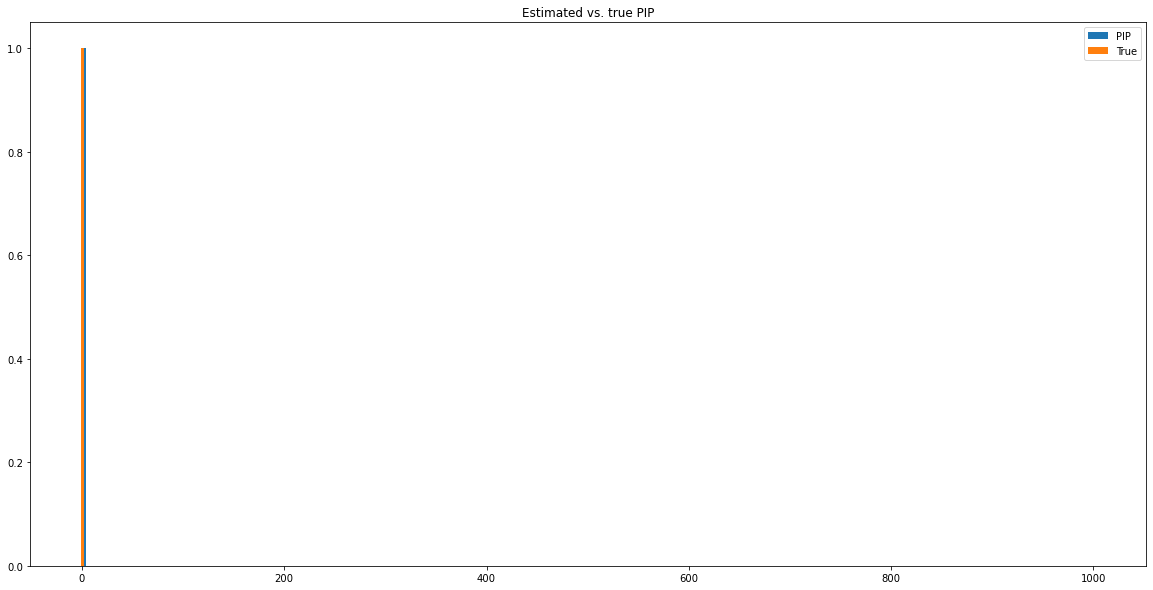

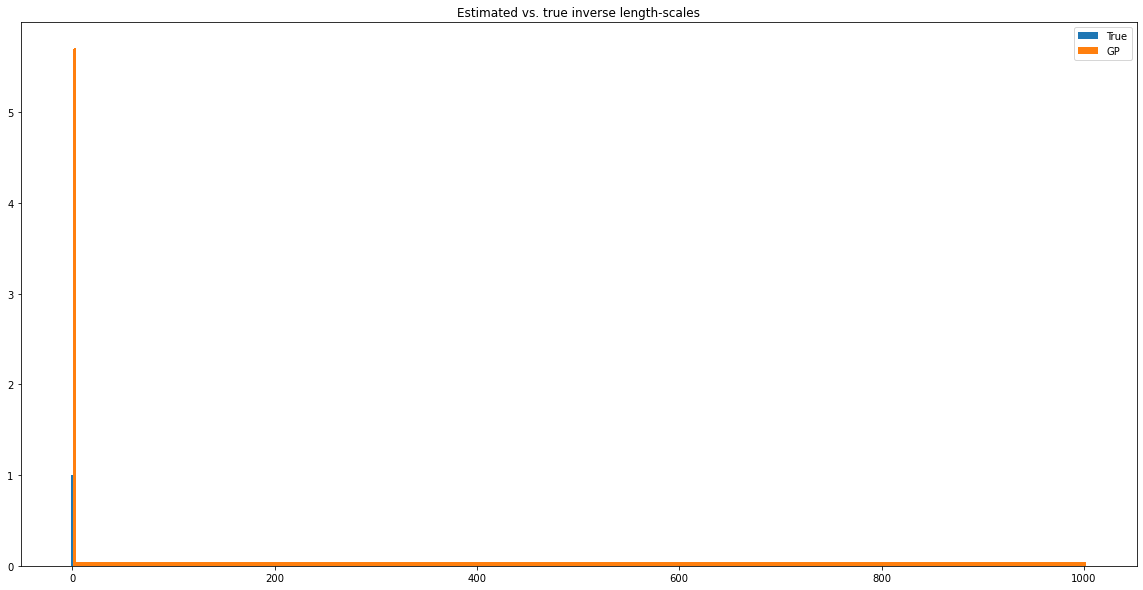

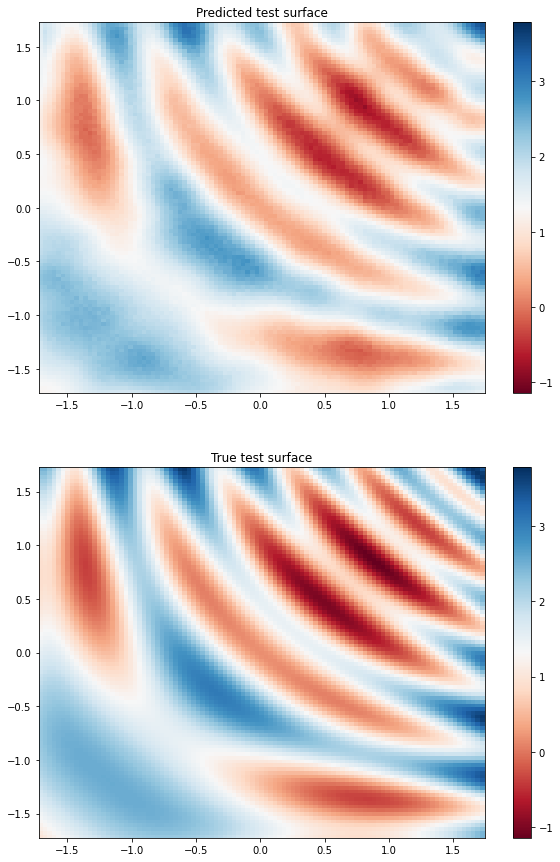

Latent test function MSE :  0.058899138
Observed test data  MSE :  0.3598467


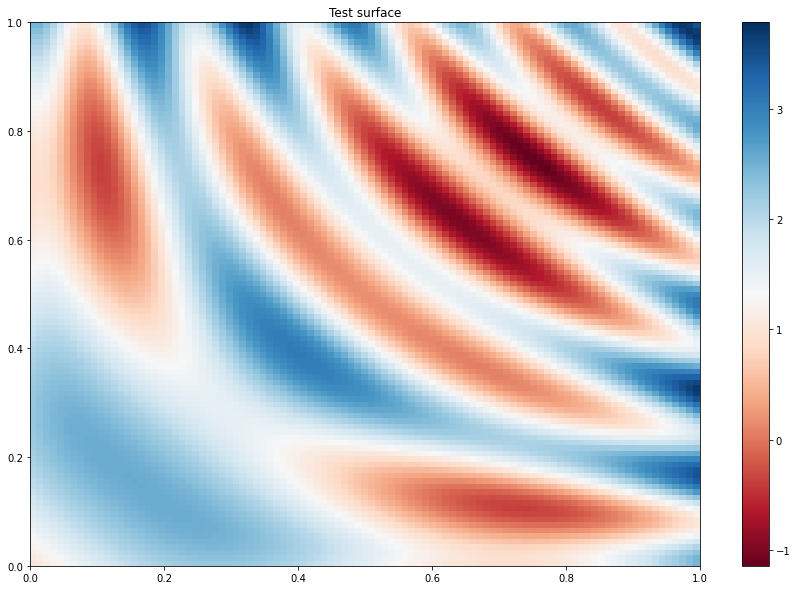

[7.03137   7.0313697 7.031371  7.0313697 7.0313716 7.03137   7.0313706
 7.031372  7.031371  7.0313716]
3.0329904556274414 0.0020497346
Iter 2 - Loss: 3.033
[7.131399  7.131402  7.1313934 7.1313505 7.1313295 7.1313767 7.1314135
 7.1313868 7.131415  7.1314125]
3.029431309700012 0.0019946524
Iter 3 - Loss: 2.677
[7.2313404 7.231457  7.231481  7.2314205 7.2308493 7.2315035 7.2314487
 7.2310815 7.2314086 7.2312317]
3.0231738880634302 0.0019379413
Iter 4 - Loss: 2.404
[7.330468  7.3309116 7.331083  7.330951  7.3293896 7.331148  7.3309317
 7.3298492 7.330731  7.33008  ]
3.0149893398489946 0.0018721687
Iter 5 - Loss: 2.205
[7.4279675 7.4289365 7.429477  7.429125  7.426301  7.429529  7.4291315
 7.4270144 7.42863   7.427234 ]
3.0053856705677835 0.001795958
Iter 6 - Loss: 2.055
[7.5229673 7.5245676 7.525888  7.525099  7.5208755 7.525857  7.525299
 7.5218806 7.5243454 7.5219665]
2.9947055693171225 0.0017102013
Iter 7 - Loss: 1.937
[7.6146092 7.616841  7.619596  7.6181226 7.6124535 7.619414  7.6187

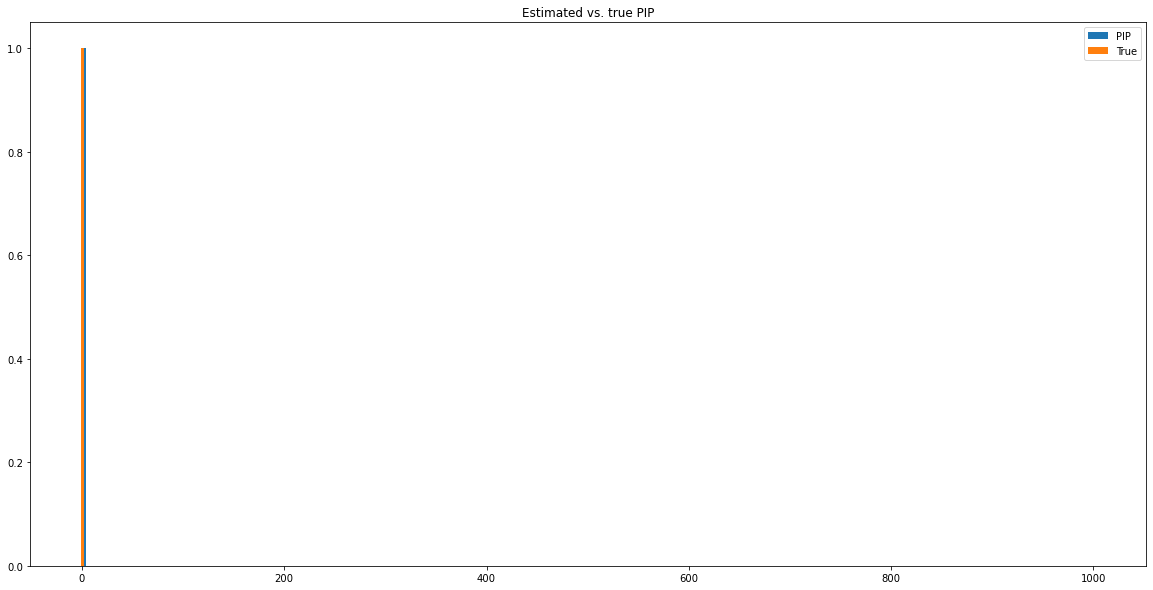

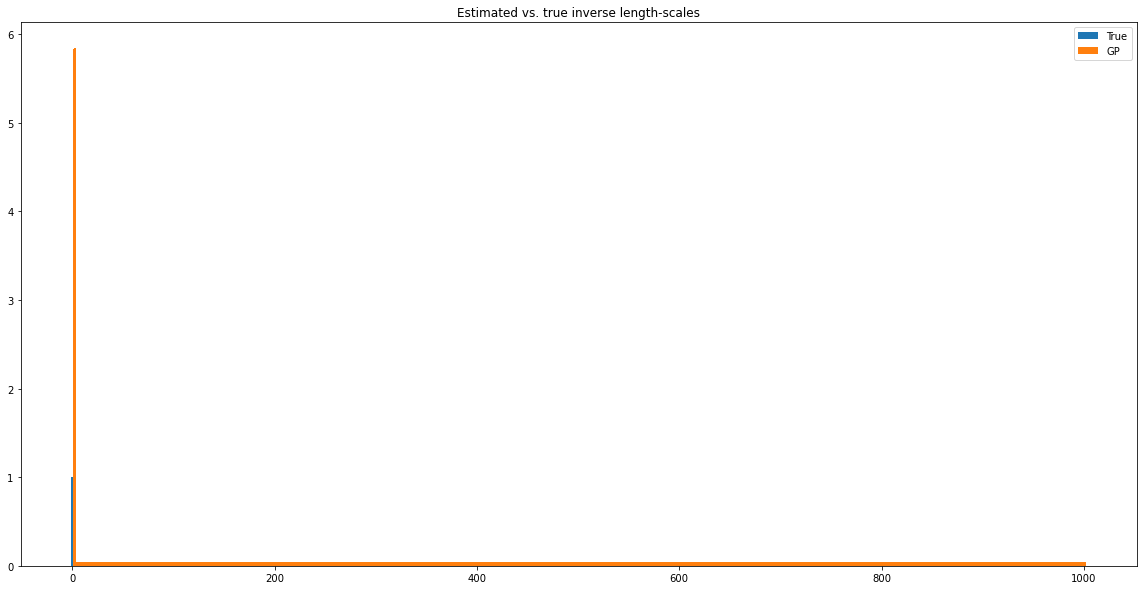

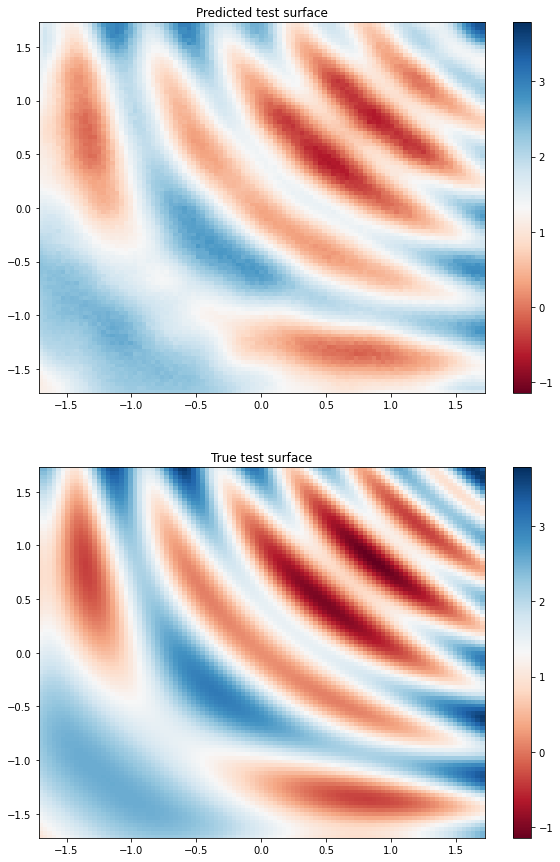

Latent test function MSE :  0.05221942
Observed test data  MSE :  0.3468971


[7.0317287 7.0314136 7.0320077 7.0315366 7.032295  7.0317726 7.0281024
 7.0327544 7.031886  7.0317593]
2.783984899520874 0.002045843


[7.1352334 7.136483  7.1382613 7.1355095 7.1364107 7.1370425 7.130576
 7.137061  7.1373835 7.137914 ]
2.7813406324386594 0.0020805735


[7.2422867 7.2447467 7.246354  7.2439055 7.2415485 7.244999  7.2362757
 7.243116  7.245868  7.246156 ]
2.7768587967395777 0.0020702549


[7.348229  7.3515344 7.354966  7.349922  7.3471212 7.3526545 7.340124
 7.345898  7.3552217 7.3541207]
2.7706127283606525 0.0019935851


[7.450178  7.452542  7.459714  7.4536586 7.4478507 7.45675   7.44135
 7.444456  7.458333  7.456966 ]
2.7632181474027298 0.0018617371


[7.545615  7.5481753 7.5584464 7.5508285 7.540305  7.5518155 7.539059
 7.535094  7.5563254 7.552439 ]
2.754932541665702 0.0016925767


[7.634012  7.6379914 7.650713  7.6432457 7.629514  7.643955  7.6290874
 7.621096  7.647483  7.641387 ]
2.745502507316168 0.0015634238


[7.7172585 7.7185946 7.7374544 7.728513  7.709903  7.730444  7.7142177
 7.70338   7.733664  7.724678 ]
2.7365318434147285 0.0014134111


[7.7924504 7.7909303 7.819512  7.806417  7.7835126 7.8088365 7.7933273
 7.7752485 7.8133287 7.8028092]
2.7263421970348722 0.0012750853


[7.858429  7.855332  7.8946157 7.8770213 7.85192   7.8836    7.868608
 7.8451605 7.8857355 7.8735003]
2.7159780138893677 0.0011652205


[7.9161463 7.9107647 7.9673615 7.941491  7.9152927 7.9508123 7.9363766
 7.9070435 7.952696  7.938675 ]
2.7056999631148693 0.0010419708


[7.9683714 7.958327  8.032655  8.00207   7.972832  8.013764  7.9995265
 7.9663215 8.014365  7.9987636]
2.695299984529405 0.0009493895


[8.013267  7.997876  8.0938225 8.058342  8.027992  8.073146  8.059853
 8.021     8.072249  8.057678 ]
2.685013115703703 0.0008810438


[8.052766 8.032134 8.1528   8.112276 8.078631 8.127506 8.116222 8.071797
 8.126885 8.109704]
2.6743268164959 0.000810616


[8.086618 8.061137 8.207982 8.161412 8.12732  8.179328 8.170701 8.120193
 8.177984 8.159007]
2.6640427928206107 0.00075530424


[8.114503 8.080748 8.260151 8.207555 8.170603 8.226528 8.219303 8.16594
 8.224706 8.20588 ]
2.653584527654093 0.00068450015


[8.13619  8.094213 8.31041  8.250057 8.212112 8.271726 8.267289 8.208928
 8.269646 8.248272]
2.643127456114506 0.0006411421


[8.156881  8.1055    8.358163  8.292144  8.252284  8.314882  8.313657
 8.249218  8.3126955 8.292128 ]
2.632767795580384 0.0006148503


[8.169488  8.111492  8.404135  8.3311615 8.28942   8.356576  8.356823
 8.290552  8.354345  8.331824 ]
2.622141219642937 0.00056867773


[8.1786375 8.110774  8.44722   8.365751  8.326477  8.396199  8.398257
 8.327452  8.3926525 8.369273 ]
2.6115026848440444 0.0005405561


[8.183303 8.110258 8.488834 8.399653 8.360608 8.433926 8.437685 8.364406
 8.431563 8.407197]
2.6009607137397754 0.0005102922


[8.185338 8.10352  8.530329 8.433999 8.396049 8.471385 8.476438 8.399931
 8.468122 8.44287 ]
2.5911202648226688 0.0004967052


[8.186878 8.089968 8.569115 8.46647  8.42848  8.507444 8.514685 8.434381
 8.502965 8.477722]
2.58095035560477 0.00047253142


[8.181952 8.074806 8.606889 8.497623 8.460438 8.540957 8.550274 8.466221
 8.536207 8.511076]
2.5707397607115183 0.00045644864


[8.174369  8.058906  8.645052  8.5274105 8.49336   8.575536  8.585302
 8.49979   8.570666  8.543473 ]
2.5602311493631005 0.00044643795


[8.164709 8.038043 8.682144 8.556813 8.52317  8.607706 8.619878 8.531041
 8.603885 8.575958]
2.5502604110696954 0.00042518007


[8.154937  8.018078  8.7184725 8.585795  8.554593  8.642699  8.655185
 8.56305   8.636798  8.609174 ]
2.540764299335326 0.00042907198


[8.141405  7.9952703 8.753965  8.614604  8.584009  8.675427  8.689423
 8.594844  8.670312  8.642471 ]
2.5305637228779227 0.00041644252


[8.12572  7.969773 8.788575 8.643166 8.61458  8.706043 8.722051 8.625487
 8.702324 8.672731]
2.5204644250084267 0.00040762717


[8.107279  7.9422245 8.82356   8.670542  8.642995  8.737553  8.755752
 8.656784  8.735007  8.7039   ]
2.5106683372196765 0.0004034003


[8.089607  7.9111333 8.859686  8.6975155 8.67242   8.769125  8.788104
 8.686974  8.766311  8.734016 ]
2.5010103290031194 0.00039713233


[8.069471  7.8810687 8.893753  8.724421  8.701578  8.801424  8.821107
 8.717928  8.798001  8.764741 ]
2.491556536128356 0.00039270837


[8.047527 7.847132 8.927295 8.751312 8.731118 8.832397 8.852504 8.750049
 8.830082 8.793983]
2.48225004917436 0.00038875823


[8.025336  7.8111033 8.960875  8.778998  8.761216  8.863724  8.884878
 8.779364  8.861617  8.827069 ]
2.4724563413023217 0.00038622605


[8.000552  7.7760687 8.995163  8.806502  8.789907  8.894487  8.918208
 8.810952  8.893443  8.857235 ]
2.4632407514877785 0.00038797205


[7.971709  7.7357564 9.02795   8.832806  8.818685  8.923982  8.949871
 8.841764  8.924956  8.887112 ]
2.4540537694833073 0.0003706513


[7.9462137 7.6952643 9.061692  8.859848  8.847151  8.955051  8.981403
 8.873249  8.955881  8.918263 ]
2.4449491932733833 0.00037732054


[7.9158974 7.6539254 9.094526  8.886532  8.876593  8.985694  9.011214
 8.902906  8.986706  8.948863 ]
2.436291233141873 0.00036585497


[7.887812 7.612248 9.12882  8.913655 8.907865 9.015963 9.044832 8.933249
 9.017928 8.980695]
2.427428890154021 0.00037911997


[7.852862  7.5680923 9.1612215 8.940643  8.93655   9.046972  9.076447
 8.964659  9.048173  9.010062 ]
2.418436867392465 0.0003674463


[7.8202057 7.521223  9.195611  8.969492  8.967272  9.077746  9.106863
 8.996003  9.0812    9.041536 ]
2.4099550991976666 0.00037419557


[7.7824216 7.465202  9.228303  8.996982  8.9970875 9.109388  9.138618
 9.026258  9.112748  9.071666 ]
2.401310939612703 0.00036588998


[7.7448654 7.4169693 9.262794  9.024162  9.027244  9.1395645 9.171536
 9.057427  9.144458  9.102457 ]
2.392454311482598 0.00036585098


[7.7067294 7.3615775 9.295652  9.052351  9.057451  9.171507  9.202825
 9.087598  9.176316  9.133108 ]
2.3836232296428723 0.00036673367


[7.6653028 7.3059483 9.329639  9.080673  9.087598  9.203445  9.235094
 9.119954  9.208929  9.163363 ]
2.3751564686580124 0.00036572118


[7.623825  7.2472777 9.363527  9.109972  9.119338  9.235565  9.267199
 9.151134  9.242405  9.194297 ]
2.3669474182956205 0.00036653646


[7.5770135 7.1827693 9.396173  9.135955  9.149366  9.26612   9.299534
 9.181474  9.273366  9.224804 ]
2.358937394405251 0.00035332178


[7.5285196 7.1168394 9.428824  9.164774  9.180222  9.298915  9.33202
 9.213139  9.306115  9.256009 ]
2.3504322239428728 0.00036618955


[7.4786377 7.0461907 9.462921  9.193473  9.211458  9.329516  9.363379
 9.245875  9.338969  9.287063 ]
2.342157342630949 0.00035763578


[7.425402  6.9727726 9.496387  9.222391  9.243063  9.362124  9.395685
 9.2773075 9.37185   9.318286 ]
2.3336077002806896 0.00036182508


[7.368233  6.8938103 9.531235  9.250614  9.274082  9.393575  9.428822
 9.309675  9.405797  9.349892 ]
2.3253888513090413 0.00036421293


[7.308578  6.8144927 9.565364  9.279635  9.3051605 9.426386  9.461563
 9.341877  9.437922  9.382868 ]
2.317205519198157 0.00036316036


[7.2425365 6.7291455 9.599119  9.309249  9.336664  9.458371  9.492421
 9.373529  9.471297  9.413866 ]
2.3087402663743397 0.00035234567


[7.1774864 6.641846  9.633927  9.3392935 9.369017  9.490977  9.525945
 9.40648   9.505348  9.445888 ]
2.3007586154634496 0.00036285468


[7.104068  6.5483713 9.668802  9.367385  9.400393  9.524767  9.55915
 9.439206  9.538437  9.477416 ]
2.2930312164387896 0.000354573


[7.0321035 6.4514194 9.70362   9.397607  9.43221   9.559051  9.59147
 9.473115  9.572021  9.509964 ]
2.285241862106738 0.00036265844


[6.9517245 6.33456   9.737245  9.425515  9.462972  9.590015  9.622732
 9.5053005 9.604537  9.539591 ]
2.2782194918083483 0.0003424064


[6.865366  6.2231054 9.772901  9.456485  9.4957485 9.623668  9.6553545
 9.538266  9.639173  9.573014 ]
2.270852973722464 0.00036267994


[6.7743125 6.102618  9.809377  9.4851    9.528223  9.656927  9.689247
 9.5705    9.67367   9.6057205]
2.2628727076018014 0.00035494976


[6.6723704 5.9707217 9.844114  9.514579  9.561137  9.690388  9.722616
 9.603653  9.7074995 9.638185 ]
2.25504891359692 0.00035121597


[6.574118  5.830796  9.879635  9.5442705 9.59385   9.723748  9.755686
 9.6362    9.742159  9.66981  ]
2.2473814777637156 0.00035054976


[6.4737396 5.6836386 9.915032  9.575053  9.627349  9.758004  9.790492
 9.671549  9.776946  9.704631 ]
2.239798615096369 0.00036247866


[6.3545823 5.522367  9.949179  9.604945  9.65894   9.791539  9.823733
 9.703988  9.811616  9.736575 ]
2.232363842150743 0.00034628276


[6.2259917 5.3564305 9.984716  9.633496  9.691358  9.825286  9.856624
 9.737914  9.844883  9.77005  ]
2.22539382258948 0.00034789962


[ 6.088726   5.1747003 10.020586   9.663885   9.72476    9.8600445
  9.890862   9.771363   9.87975    9.803872 ]
2.2185061262955004 0.00035439795


[ 5.9507575  4.970214  10.055459   9.695379   9.757881   9.894536
  9.925595   9.806161   9.915378   9.835816 ]
2.211299883925978 0.0003580401


[ 5.802147   4.7596574 10.090912   9.726405   9.790016   9.926652
  9.958384   9.840035   9.949784   9.867525 ]
2.204237166372958 0.00034836037


[ 5.6290164  4.5241036 10.126834   9.757218   9.823393   9.961384
  9.991069   9.873034   9.985608   9.901223 ]
2.1970873859472504 0.0003500135


[ 5.452053   4.281088  10.164289   9.787731   9.857489   9.996131
 10.0255785  9.906606  10.020766   9.93445  ]
2.190009307173685 0.0003602509


[ 5.255383   4.018463  10.200946   9.817119   9.891045  10.030421
 10.0584345  9.942085  10.05551    9.967314 ]
2.1833189783441203 0.00035536755


[ 5.045359   3.7258918 10.238013   9.848971   9.925526  10.0654745
 10.094163   9.977287  10.091444  10.002989 ]
2.176818933225443 0.00037038617


[ 4.826942   3.4099455 10.275151   9.881521   9.959534  10.102004
 10.129289  10.014088  10.128392  10.037279 ]
2.169372063950104 0.00037780625


[ 4.5766177  3.0774384 10.313353   9.915077   9.99555   10.13894
 10.165048  10.051582  10.164967  10.072704 ]
2.1628316559937084 0.00039345687


[ 4.301093   2.7269685 10.351306   9.949291  10.031781  10.176385
 10.201427  10.086088  10.202342  10.10873  ]
2.156068302726847 0.0004002502


[ 4.0122776  2.3557181 10.387238   9.982591  10.06637   10.212301
 10.236281  10.124124  10.238995  10.143915 ]
2.1495787638035826 0.00041724643


[ 3.6921637  1.9827726 10.427547  10.017081  10.103502  10.250543
 10.274764  10.1623335 10.278273  10.180663 ]
2.1432632206113476 0.0004613251


[ 3.3505983  1.617345  10.468339  10.053189  10.141148  10.288841
 10.3138485 10.201739  10.318119  10.2189665]
2.136761863057715 0.0005062103


[ 2.9849236  1.2727683 10.5102625 10.09181   10.182759  10.331293
 10.355008  10.244326  10.358355  10.259846 ]
2.1302036538070968 0.0005943742


[ 2.6280105  0.9874659 10.555372  10.135824  10.227565  10.376872
 10.398707  10.290085  10.405049  10.307379 ]
2.1238177630705697 0.00069595134


[ 2.2940207   0.81016463 10.604134   10.18385    10.2779     10.427709
 10.448372   10.3394375  10.455702   10.357414  ]
2.1173171891042624 0.0007476547


[ 1.9760672  0.7399488 10.658087  10.236836  10.333518  10.484153
 10.501891  10.397289  10.510453  10.414925 ]
2.1112974836763083 0.0007052168


[ 1.6811298  0.7255571 10.715916  10.296864  10.394552  10.545123
 10.561863  10.459218  10.572359  10.476967 ]
2.1051732042226172 0.0006824136


[ 1.3734077   0.75900143 10.776895   10.361108   10.459556   10.610929
 10.624864   10.524325   10.637766   10.542963  ]
2.0992973034982927 0.00078753015


[ 1.0833411  0.7659329 10.840538  10.428241  10.527831  10.680064
 10.691365  10.59403   10.706571  10.610969 ]
2.0930776921462018 0.0008225684


[ 0.8905101  0.790689  10.909317  10.501064  10.599735  10.753944
 10.761548  10.665057  10.780879  10.684224 ]
2.0871536708151783 0.00088798616


[ 0.78381354  0.8296502  10.980367   10.578816   10.676286   10.831113
 10.834208   10.741417   10.855921   10.762764  ]
2.0811327779802413 0.0008857752


[ 0.78039664  0.8609179  11.055958   10.662857   10.757696   10.915415
 10.91249    10.823635   10.938093   10.844902  ]
2.07492526766336 0.00076003955


[ 0.7559252   0.84060115 11.133345   10.747388   10.840648   10.99962
 10.991307   10.908037   11.022088   10.928818  ]
2.0688049641520703 0.0007795082


[ 0.73987824  0.82887983 11.213488   10.834995   10.926834   11.087014
 11.074937   10.993406   11.110386   11.015326  ]
2.0625663154123437 0.0007734101


[ 0.7297999   0.79559284 11.295385   10.92654    11.01521    11.176793
 11.160342   11.083107   11.199408   11.105595  ]
2.0561945868800313 0.0008083755


[ 0.72194153  0.7897419  11.380924   11.0214205  11.107572   11.269589
 11.2494     11.174363   11.292474   11.198095  ]
2.0502635011014867 0.0007775897


[ 0.72271764  0.76842225 11.468647   11.118917   11.201629   11.366839
 11.3417845  11.267737   11.387596   11.292996  ]
2.0446279596535515 0.00079781585


[ 0.7018939   0.76488596 11.559218   11.219779   11.298126   11.465175
 11.434269   11.365831   11.486784   11.391359  ]
2.038788303706613 0.0008152573


[ 0.6972899  0.7449969 11.653318  11.323573  11.399302  11.568513
 11.532477  11.46658   11.590077  11.495125 ]
2.033076405052176 0.00082986674


[ 0.6745152   0.74224013 11.750113   11.430907   11.501839   11.67239
 11.632132   11.570692   11.696606   11.598727  ]
2.0270193071450717 0.00084324036


[ 0.681928    0.73457766 11.847085   11.539784   11.6058     11.780536
 11.736521   11.675205   11.803483   11.705998  ]
2.0213404014481173 0.0008182764


[ 0.6654765  0.7240655 11.946639  11.649992  11.712474  11.889946
 11.840485  11.781998  11.91392   11.816687 ]
2.01544932957742 0.00084763573


[ 0.6531214  0.7163932 12.047608  11.763909  11.82172   12.0007
 11.948895  11.889864  12.024479  11.925818 ]
2.009357764242995 0.0008328836


[ 0.6506155  0.705604  12.1511965 11.877794  11.930353  12.11369
 12.056453  12.000226  12.137629  12.037346 ]
2.0037471616066687 0.00081114


[ 0.6534726   0.70118535 12.257115   11.994818   12.043147   12.22723
 12.166053   12.112353   12.252497   12.150616  ]
1.997945472613893 0.00080113066


[ 0.62936     0.68422306 12.363563   12.11352    12.156845   12.3434105
 12.277104   12.225189   12.368792   12.267289  ]
1.9921096290804574 0.00087645435


[ 0.6312479  0.6774844 12.468646  12.230923  12.269213  12.458805
 12.387346  12.336766  12.483994  12.38254  ]
1.986203915317958 0.00077869894


[ 0.633594    0.66636086 12.577078   12.349738   12.383886   12.5757675
 12.500573   12.452397   12.601143   12.499767  ]
1.9804434935010515 0.00078629993


[ 0.62040305  0.6750568  12.684086   12.468859   12.498521   12.693627
 12.613692   12.567696   12.718819   12.618202  ]
1.9745984818696452 0.0008012831


[ 0.61510044  0.65178293 12.789689   12.585632   12.612679   12.807829
 12.725432   12.6826105  12.832704   12.732601  ]
1.968775808284469 0.000786016


[ 0.6247853   0.65126747 12.896693   12.70634    12.72721    12.924681
 12.839994   12.796094   12.951471   12.848753  ]
1.9634046471864877 0.00074658275


[ 0.59992874  0.6393801  13.001273   12.822355   12.838096   13.041356
 12.951635   12.908252   13.0651045  12.964568  ]
1.9580029501103746 0.0007852887


[ 0.605842    0.64012533 13.105507   12.936859   12.948239   13.1545515
 13.063659   13.022195   13.17961    13.080218  ]
1.9524592470176572 0.00069410837


[ 0.5942358   0.63068914 13.208138   13.048352   13.0596075  13.267032
 13.172432   13.131873   13.292711   13.194692  ]
1.947056783034114 0.00070741115


[ 0.5894631   0.62635005 13.310765   13.160581   13.166137   13.377337
 13.281483   13.239381   13.403724   13.306974  ]
1.9416300959048378 0.00065614615


[ 0.5919927  0.6136015 13.407234  13.270799  13.271703  13.486806
 13.386831  13.347439  13.511204  13.417368 ]
1.9358636746397744 0.0006513065


[ 0.58707803  0.61515045 13.503764   13.376784   13.375262   13.594135
 13.49168    13.453701   13.614685   13.523345  ]
1.9302727130547384 0.0006040287


[ 0.570727   0.6006053 13.597865  13.480423  13.471699  13.697115
 13.591828  13.553878  13.7146015 13.62964  ]
1.9244196476559108 0.0006475632


[ 0.5752245  0.5969292 13.691917  13.580824  13.568201  13.797405
 13.691325  13.654169  13.815383  13.734221 ]
1.9191203583677672 0.0005692969


[ 0.5719609  0.5928946 13.778933  13.678235  13.662956  13.895178
 13.7853155 13.746495  13.911534  13.832252 ]
1.9137161788052381 0.00053369976


[ 0.558592   0.5853771 13.86728   13.7755165 13.75368   13.992529
 13.881214  13.843373  14.007019  13.933155 ]
1.908171200607121 0.00056728703


[ 0.5597802  0.580013  13.951036  13.871452  13.844861  14.087651
 13.972493  13.937506  14.098961  14.029598 ]
1.9024172874444336 0.00050570123


[ 0.55500776  0.5771097  14.035707   13.961878   13.932917   14.182169
 14.063756   14.026947   14.190588   14.122109  ]
1.8969829926522648 0.0004922458


[ 0.5522856  0.5661274 14.116437  14.052189  14.0173855 14.274637
 14.153698  14.1167755 14.279374  14.214222 ]
1.8916684676344946 0.00049425615


[ 0.54427665  0.561768   14.197464   14.136952   14.101799   14.360537
 14.239881   14.203497   14.365283   14.308766  ]
1.8865483580275773 0.0004759071


[ 0.53159654  0.5568954  14.2742815  14.225771   14.185514   14.449511
 14.327527   14.29044    14.451332   14.397649  ]
1.8809969701828515 0.00048653598


[ 0.5251017  0.5555051 14.351064  14.311299  14.267292  14.5373335
 14.407998  14.377031  14.533998  14.486554 ]
1.875655646292104 0.00043887802


[ 0.5218593  0.538275  14.425318  14.393103  14.346786  14.6199875
 14.494693  14.460431  14.617823  14.575331 ]
1.870268150583959 0.0004713334


[ 0.5205354  0.541653  14.499707  14.477744  14.425108  14.704716
 14.576202  14.5417795 14.696445  14.6593075]
1.865369251541193 0.00040731445


[ 0.5134077  0.5316998 14.56996   14.55927   14.5033045 14.786762
 14.660641  14.624113  14.780553  14.744624 ]
1.8600984766683746 0.00044299278


[ 0.5083006  0.5209266 14.640534  14.636485  14.579591  14.865587
 14.739242  14.705229  14.860338  14.827463 ]
1.8545492580588412 0.00042655887


[ 0.5015085  0.5183428 14.7144    14.716224  14.653231  14.947157
 14.819776  14.7860985 14.94035   14.911968 ]
1.8495467668915981 0.00040323066


[ 0.49363676  0.51162165 14.785567   14.795336   14.7300825  15.027539
 14.897082   14.863402   15.01785    14.992066  ]
1.8442815145337326 0.00041102874


[ 0.4791842   0.50141424 14.853738   14.87157    14.801788   15.106073
 14.97265    14.941204   15.094242   15.073175  ]
1.838817970800291 0.00044798868


[ 0.48352692  0.49614596 14.921563   14.949249   14.877425   15.182138
 15.048583   15.019876   15.170247   15.155649  ]
1.8335289453262205 0.00038291604


[ 0.47422823  0.49256182 14.990072   15.028405   14.952901   15.261044
 15.12702    15.098123   15.2455225  15.236126  ]
1.8287973145491057 0.0003958378


[ 0.46106002  0.47712782 15.053938   15.099855   15.021335   15.337135
 15.204377   15.171127   15.317694   15.311248  ]
1.8239442438331954 0.00044436406


[ 0.45689094  0.4763261  15.124483   15.176248   15.097251   15.415807
 15.281094   15.249437   15.39401    15.3916855 ]
1.8188838198923305 0.0003540799


[ 0.44751027  0.46686655 15.193621   15.252009   15.169672   15.492404
 15.355582   15.32513    15.470278   15.471379  ]
1.8141337107411826 0.00041380833


[ 0.4403864   0.46008152 15.260177   15.325258   15.240453   15.566954
 15.428435   15.397566   15.543769   15.548626  ]
1.8092580274824186 0.00038056646


[ 0.43507105  0.45376337 15.327384   15.401443   15.314813   15.644227
 15.506727   15.475236   15.619841   15.627396  ]
1.8043108284198288 0.0003778152


[ 0.42830116  0.4463753  15.396162   15.476049   15.387736   15.71924
 15.580641   15.54861    15.693678   15.706589  ]
1.7994841560449018 0.00038069778


[ 0.41855234  0.42956236 15.462223   15.547444   15.45979    15.793953
 15.658727   15.624316   15.765365   15.783235  ]
1.7946428114651198 0.00044608512


[ 0.4108641   0.42059568 15.530991   15.6223     15.531442   15.868772
 15.732131   15.698271   15.841105   15.8613    ]
1.7900674372845657 0.00039481043


[ 0.40267688  0.4154874  15.601514   15.699552   15.603687   15.945628
 15.807109   15.775798   15.9150715  15.939067  ]
1.7853765099877548 0.00038455005


[ 0.4004785   0.40384033 15.671236   15.772681   15.679069   16.022379
 15.883822   15.852017   15.990924   16.017338  ]
1.7805137464938647 0.00038359518


[ 0.38217184  0.39547098 15.741736   15.846832   15.757439   16.099504
 15.961868   15.927312   16.066072   16.095915  ]
1.7759042023860123 0.00046764026


[ 0.37518588  0.38682288 15.813353   15.924169   15.832328   16.177656
 16.040325   16.004204   16.145527   16.172964  ]
1.7712153360098877 0.00040742572


[ 0.36663523  0.3768296  15.885241   16.000607   15.907923   16.253622
 16.119164   16.0799     16.223377   16.252096  ]
1.7664265198709346 0.00042803556


[ 0.35511333  0.3688693  15.956489   16.077524   15.986028   16.330788
 16.19935    16.156672   16.299911   16.330912  ]
1.7616853832771142 0.0004386149


[ 0.35115853  0.3561281  16.03137    16.155176   16.06338    16.411526
 16.279877   16.236803   16.380533   16.41381   ]
1.7565680120760263 0.00042749042


[ 0.34183592  0.34815457 16.105791   16.23544    16.142704   16.490767
 16.36042    16.313978   16.458685   16.493698  ]
1.7518764452765705 0.0004390412


[ 0.33239678  0.34141174 16.18125    16.313534   16.221952   16.572466
 16.441648   16.391571   16.54121    16.574177  ]
1.7473157472872753 0.00043604895


[ 0.3257811  0.3302687 16.25959   16.397293  16.303474  16.653246
 16.52458   16.472803  16.623436  16.656984 ]
1.7429503378460187 0.0004594373


[ 0.3168596   0.32087162 16.333572   16.473108   16.383703   16.732409
 16.60616    16.552046   16.70617    16.738052  ]
1.7387485320784137 0.0004670979


[ 0.30782336  0.3139924  16.417288   16.55842    16.468336   16.816553
 16.692575   16.6358     16.791208   16.823236  ]
1.7340078053139956 0.0004631844


[ 0.29544312  0.30039418 16.49705    16.63968    16.553364   16.89892
 16.777071   16.717892   16.875618   16.906805  ]
1.72936845543888 0.0005755463


[ 0.28932545  0.29083732 16.581648   16.72846    16.640215   16.986214
 16.866186   16.80657    16.965277   16.995398  ]
1.7251053607034457 0.00048916147


[ 0.27642056  0.28302518 16.668192   16.815449   16.731617   17.074524
 16.956305   16.895407   17.056623   17.086397  ]
1.7204143885783447 0.0005681615


[ 0.26585084  0.2700929  16.758463   16.906317   16.826246   17.164959
 17.049496   16.98504    17.149988   17.177391  ]
1.7162211494815323 0.00062849413


[ 0.2599906   0.25938943 16.852383   17.001799   16.923922   17.256424
 17.145227   17.07678    17.247246   17.272007  ]
1.711615079601631 0.00055941835


[ 0.24539395  0.25008976 16.948536   17.10058    17.025288   17.351753
 17.242237   17.172794   17.347221   17.370409  ]
1.7067277479374658 0.0007003249


[ 0.23662707  0.24041025 17.045805   17.198374   17.126812   17.451244
 17.33972    17.268164   17.447096   17.469368  ]
1.7022786485872872 0.0006399558


[ 0.23020636  0.23341173 17.147465   17.298792   17.231739   17.549551
 17.44228    17.36701    17.550379   17.569023  ]
1.698117878064015 0.00057667005


[ 0.22573757  0.22480148 17.251274   17.401175   17.34004    17.65068
 17.547546   17.466799   17.653698   17.671137  ]
1.693642378413929 0.0005865713


[ 0.21984567  0.21904388 17.355686   17.505728   17.449442   17.75187
 17.651443   17.566765   17.758215   17.774673  ]
1.6891923611945021 0.0005700823


[ 0.21245939  0.21612144 17.462234   17.60922    17.558716   17.855614
 17.756123   17.667524   17.865034   17.877558  ]
1.6844917069802925 0.00055309426


[ 0.20889255  0.20728965 17.568598   17.714893   17.666437   17.960657
 17.86217    17.770079   17.972527   17.982758  ]
1.679725573422605 0.0006082442


[ 0.2049327   0.20732959 17.674171   17.820127   17.775396   18.064924
 17.967764   17.871414   18.079765   18.087856  ]
1.675376993320856 0.00042151136


[ 0.2022472   0.20339103 17.780787   17.923948   17.88526    18.167185
 18.071182   17.971882   18.18765    18.190655  ]
1.6712219656342753 0.00048109487


[ 0.20410453  0.20124367 17.887333   18.028896   17.995071   18.272228
 18.178196   18.073442   18.294956   18.296934  ]
1.6667274917588775 0.00041795068


[ 0.19773485  0.19942993 17.991621   18.130959   18.102787   18.375587
 18.282696   18.173859   18.401028   18.400093  ]
1.6624013788076126 0.0005144328


[ 0.19575055  0.19799656 18.095781   18.231361   18.209988   18.478477
 18.389177   18.27413    18.505064   18.501223  ]
1.657881063273168 0.00039409794


[ 0.1943058   0.19563878 18.200193   18.33475    18.317366   18.581379
 18.493753   18.373259   18.610638   18.603859  ]
1.6533939310214025 0.00040217885


[ 0.19382864  0.19353372 18.305374   18.437891   18.424473   18.683271
 18.597021   18.47387    18.716534   18.708202  ]
1.6491699494538796 0.0003668036


[ 0.19101182  0.19438258 18.407976   18.540016   18.532045   18.784796
 18.701027   18.57267    18.820206   18.80996   ]
1.644873572472921 0.0003944031


[ 0.19134618  0.19301176 18.51221    18.640623   18.63702    18.887985
 18.804083   18.67109    18.92375    18.91191   ]
1.6402454832726212 0.0003354414


[ 0.18717945  0.18974149 18.613436   18.738354   18.739864   18.985548
 18.905355   18.768862   19.024551   19.00968   ]
1.6357235537904657 0.00048462336


[ 0.1884886   0.19101475 18.713127   18.83747    18.843822   19.085014
 19.004326   18.864992   19.125301   19.109     ]
1.631385522153852 0.0003485589


[ 0.18906735  0.18840075 18.814512   18.93341    18.945778   19.18158
 19.106129   18.95976    19.22754    19.206263  ]
1.6267396731140304 0.00035989407


[ 0.18324442  0.18799695 18.9136     19.03204    19.04682    19.28006
 19.204227   19.055494   19.327978   19.305204  ]
1.6224848033718733 0.00044710288


[ 0.18791679  0.18863337 19.009079   19.128061   19.145756   19.376019
 19.301573   19.148907   19.425016   19.400444  ]
1.6180897523676496 0.00041186836


[ 0.18599693  0.18692005 19.105404   19.222355   19.242144   19.471235
 19.399153   19.242136   19.521275   19.496685  ]
1.613622221352457 0.00035720502


[ 0.18417385  0.18836784 19.19939    19.313875   19.340935   19.56402
 19.493801   19.332413   19.61598    19.591433  ]
1.6089762654620219 0.0003421725


[ 0.18538246  0.18516876 19.293146   19.405188   19.437393   19.65494
 19.588102   19.422941   19.7103     19.685705  ]
1.6045174968888989 0.00037181895


[ 0.183784    0.18537936 19.386972   19.49599    19.532242   19.746832
 19.681543   19.513517   19.80332    19.778202  ]
1.6002528092189754 0.00029296696


[ 0.18322596  0.18542182 19.477972   19.58611    19.625338   19.839178
 19.772953   19.602758   19.894724   19.869179  ]
1.5959277870967867 0.0002511742


[ 0.18498978  0.1836899  19.568054   19.675623   19.716743   19.928225
 19.864658   19.689943   19.987015   19.960182  ]
1.5914993818092082 0.0003308726


[ 0.18273914  0.18619111 19.660536   19.765217   19.810726   20.018637
 19.956419   19.77873    20.079348   20.050226  ]
1.5873388173314789 0.00036717195


[ 0.1813975   0.18647471 19.75061    19.854057   19.901665   20.106152
 20.046097   19.864155   20.168978   20.13929   ]
1.5830031622361669 0.00027104182


[ 0.18365684  0.1855266  19.839163   19.94112    19.992542   20.194296
 20.13505    19.947031   20.257317   20.228865  ]
1.57827124248171 0.0003129124


[ 0.18190867  0.18161368 19.925545   20.026411   20.080368   20.281857
 20.223515   20.031153   20.345955   20.316917  ]
1.57392540969175 0.00038175166


[ 0.18221654  0.1817779  20.0124     20.110544   20.167774   20.365839
 20.309298   20.117      20.432112   20.402637  ]
1.569524885453231 0.0002219549


[ 0.18327351  0.18767382 20.096853   20.193886   20.254934   20.451622
 20.396442   20.198845   20.519516   20.48754   ]
1.56517919542896 0.00041015327


[ 0.18045816  0.18036567 20.180944   20.27688    20.339334   20.534836
 20.481869   20.28065    20.603216   20.569494  ]
1.5609717468031463 0.0004997415


[ 0.18312347  0.18335631 20.26511    20.35674    20.42304    20.61559
 20.565504   20.35924    20.687395   20.653044  ]
1.5567174723359083 0.00036703417


[ 0.18182804  0.1810694  20.348284   20.43984    20.506737   20.698624
 20.649815   20.441088   20.770905   20.7371    ]
1.5525351698106542 0.00030318394


[ 0.18083145  0.18398659 20.430904   20.520182   20.590982   20.779827
 20.73351    20.521914   20.854021   20.816704  ]
1.5481252332088304 0.00030739245


[ 0.18186906  0.18146923 20.512941   20.599482   20.672838   20.860943
 20.81551    20.60113    20.937134   20.898226  ]
1.543938736812411 0.00029523624


[ 0.18053262  0.18084934 20.592358   20.678473   20.755293   20.941471
 20.897348   20.680157   21.019054   20.979435  ]
1.5397197569302485 0.00024401193


[ 0.17817827  0.18478835 20.672426   20.755388   20.835537   21.020658
 20.975615   20.756323   21.097694   21.060488  ]
1.5355484743160852 0.00037079054


[ 0.18206584  0.18102393 20.751223   20.833439   20.916208   21.098986
 21.055641   20.83426    21.177204   21.140274  ]
1.5315179769844234 0.00041078104


[ 0.17956023  0.18224508 20.82867    20.90921    20.997154   21.176983
 21.1358     20.909386   21.257278   21.218304  ]
1.5279486482544655 0.00028837353


[ 0.18286395  0.1815948  20.906687   20.98754    21.074848   21.253218
 21.213335   20.983345   21.336054   21.296589  ]
1.5237954904786621 0.00029332066


[ 0.17795323  0.18228304 20.98147    21.06058    21.152678   21.328995
 21.28957    21.057604   21.413652   21.372316  ]
1.5198619164675826 0.00033865863


[ 0.17978683  0.18074466 21.057531   21.136013   21.230047   21.404041
 21.366064   21.13212    21.490185   21.450033  ]
1.5158702424837998 0.0002707585


[ 0.17945288  0.18024552 21.133923   21.209858   21.306301   21.479399
 21.444323   21.205683   21.567299   21.526468  ]
1.5120106817043932 0.00019029324


[ 0.17991139  0.17969711 21.208397   21.283682   21.38209    21.551779
 21.51786    21.278008   21.641954   21.602076  ]
1.508507781222417 0.00019162372


[ 0.17775686  0.1781099  21.28216    21.355732   21.45998    21.62504
 21.594881   21.351885   21.718132   21.676455  ]
1.5046455427656615 0.00027665723


[ 0.18068065  0.1811549  21.35648    21.42781    21.53519    21.6986
 21.668903   21.423958   21.793303   21.75014   ]
1.5006698442502364 0.00034271606


[ 0.17762125  0.17963639 21.429049   21.498314   21.609097   21.770885
 21.744152   21.494184   21.86615    21.825212  ]
1.4970073271069437 0.0002966429


[ 0.17963998  0.1809872  21.499474   21.567627   21.682531   21.841421
 21.81712    21.565462   21.941324   21.898127  ]
1.4932844261915261 0.00025633973


[ 0.17960067  0.17985077 21.571966   21.638006   21.755705   21.912178
 21.890108   21.636383   22.014833   21.971142  ]
1.489519132016586 0.00018794161


[ 0.17717846  0.17826821 21.642544   21.708126   21.829058   21.982613
 21.963572   21.703938   22.087496   22.043238  ]
1.4858556587597747 0.00027416152


[ 0.17939435  0.18064108 21.715687   21.778063   21.901789   22.055208
 22.035185   21.776466   22.16026    22.11594   ]
1.4819917606423307 0.00029036452


[ 0.17530857  0.17929217 21.785969   21.845602   21.972149   22.125435
 22.10651    21.844063   22.23168    22.186544  ]
1.478290306313724 0.0003154504


[ 0.17964509  0.18099168 21.853817   21.912737   22.04173    22.192059
 22.176416   21.91218    22.300056   22.256483  ]
1.4747298897465584 0.00033024847


[ 0.178711    0.18089963 21.923105   21.979275   22.112686   22.261757
 22.247673   21.981112   22.36956    22.326923  ]
1.4709162308522972 0.00017300453


[ 0.17784423  0.17805594 21.99379    22.048624   22.183006   22.332115
 22.31758    22.049051   22.43915    22.397217  ]
1.4673317807725492 0.00025519633


[ 0.17634092  0.18026485 22.057861   22.11508    22.250965   22.399406
 22.387136   22.113375   22.510622   22.467386  ]
1.4637829963796645 0.00025217308


[ 0.17864817  0.17874871 22.128067   22.182447   22.32158    22.46685
 22.45483    22.180582   22.57886    22.535755  ]
1.460160526771245 0.00025562715


[ 0.17779103  0.18028112 22.196012   22.247492   22.39204    22.533087
 22.52411    22.247341   22.64657    22.604612  ]
1.4566264454598312 0.00020837355


[ 0.17761682  0.17983401 22.26414    22.312819   22.460129   22.599857
 22.593746   22.312773   22.714853   22.674057  ]
1.4530276323392326 0.00015298298


[ 0.17907493  0.17895722 22.329473   22.377924   22.526482   22.666813
 22.660032   22.377014   22.780624   22.741817  ]
1.449408140021959 0.00020150178


[ 0.1792121   0.18012019 22.396376   22.443436   22.594202   22.73161
 22.726786   22.44182    22.84911    22.809383  ]
1.4457426347096909 0.00016923173


[ 0.17676637  0.17972647 22.463217   22.50754    22.661459   22.798006
 22.794561   22.505646   22.916473   22.876076  ]
1.4423392723980097 0.0002175167


[ 0.17635047  0.17951183 22.528257   22.57084    22.72761    22.863949
 22.860374   22.570042   22.98214    22.94217   ]
1.4385865392161135 0.00014549989


[ 0.17929186  0.17982046 22.59377    22.635971   22.79367    22.929083
 22.926027   22.63351    23.049156   23.009302  ]
1.4352310473972556 0.00022767279


[ 0.17795995  0.17938398 22.65639    22.69858    22.857363   22.991385
 22.990559   22.694342   23.112194   23.073048  ]
1.4319498204689678 0.00017584977


[ 0.1777724   0.17744695 22.722364   22.76254    22.924318   23.056496
 23.05759    22.758944   23.177824   23.140013  ]
1.4287481704221607 0.00018939031


[ 0.1757109   0.17947409 22.786137   22.825348   22.991346   23.121386
 23.123137   22.822533   23.243565   23.205433  ]
1.4255024133997933 0.00025134848


[ 0.17919809  0.17827713 22.849108   22.888659   23.056158   23.184473
 23.186985   22.884872   23.30788    23.270926  ]
1.4222385405986506 0.00026785486


[ 0.17648788  0.17637263 22.91219    22.947866   23.12029    23.246906
 23.250744   22.945744   23.371948   23.334349  ]
1.4189586178753881 0.00026298373


[ 0.17540745  0.17970632 22.975233   23.008778   23.184542   23.311724
 23.314014   23.007818   23.435808   23.398682  ]
1.4157774898341464 0.00025702067


[ 0.17885263  0.18005699 23.037449   23.071352   23.250025   23.37406
 23.37989    23.069265   23.49938    23.461702  ]
1.4124162666402116 0.00023578496


[ 0.1766682   0.17821948 23.101433   23.133562   23.313467   23.435242
 23.443747   23.129915   23.56309    23.524616  ]
1.4089348566212094 0.00024180168


[ 0.17696558  0.17811117 23.162786   23.194166   23.37499    23.496164
 23.505806   23.190899   23.62598    23.588518  ]
1.4058134684126633 0.0001254527


[ 0.1773315   0.17827585 23.225166   23.252754   23.438417   23.55804
 23.570345   23.25138    23.688686   23.651129  ]
1.402304839677557 0.00012927681


[ 0.1760414   0.17925847 23.28671    23.315023   23.500658   23.619034
 23.632328   23.31182    23.750378   23.714226  ]
1.3990128589382522 0.00018412372


[ 0.17580993  0.17812891 23.348452   23.37484    23.563683   23.681555
 23.694082   23.372608   23.812977   23.776814  ]
1.3958103568537676 0.000152796


[ 0.17834592  0.17814508 23.40922    23.43525    23.62598    23.742302
 23.755993   23.431137   23.875736   23.840034  ]
1.3926513536842473 0.00019053648


[ 0.17415231  0.17853782 23.467548   23.494455   23.686535   23.801657
 23.817354   23.490606   23.938238   23.901155  ]
1.3896794144939473 0.00025367094


[ 0.17732474  0.17899418 23.530401   23.555141   23.750103   23.86253
 23.880213   23.55201    24.00091    23.962612  ]
1.386341472306329 0.00022551735


[ 0.17665713  0.17850716 23.589407   23.613686   23.80987    23.922327
 23.940735   23.610752   24.061014   24.02298   ]
1.3832371120056441 0.00014078098


[ 0.17587371  0.17781378 23.648825   23.671907   23.87296    23.98144
 24.00085    23.668074   24.12251    24.08422   ]
1.3804399901188336 0.00015154576


[ 0.17590117  0.17935282 23.70877    23.730824   23.932667   24.042465
 24.062027   23.726576   24.183184   24.14365   ]
1.3773863548260283 0.0001528101


[ 0.17606978  0.17899455 23.767801   23.788576   23.99426    24.099804
 24.122988   23.785633   24.242975   24.204357  ]
1.3746173230686922 0.00011858527


[ 0.17676215  0.17811324 23.828293   23.846882   24.054522   24.158329
 24.182869   23.844519   24.302855   24.264523  ]
1.3716644375920641 0.0001525902


[ 0.17690179  0.1771838  23.888231   23.90342    24.112955   24.217718
 24.242565   23.901333   24.362555   24.322721  ]
1.3690869178480252 0.00013410536


[ 0.17643693  0.17889707 23.948393   23.961037   24.172918   24.276346
 24.302217   23.95938    24.420765   24.383205  ]
1.3663249250695388 0.00016879545


[ 0.17618433  0.17823528 24.004545   24.018902   24.231571   24.333622
 24.361467   24.015833   24.480303   24.444681  ]
1.363419715770168 0.00012777204


[ 0.17656995  0.17695203 24.061756   24.074234   24.288969   24.390818
 24.421484   24.072931   24.538116   24.503054  ]
1.36042257067164 0.00014949817


[ 0.1750302   0.17813443 24.12187    24.129187   24.348774   24.446823
 24.482243   24.1311     24.595682   24.561401  ]
1.3575836841010473 0.00018479255


[ 0.17618394  0.17696726 24.179249   24.1857     24.407543   24.503273
 24.539335   24.18775    24.653904   24.620823  ]
1.3548006581769376 0.00017102923


[ 0.17599596  0.17913215 24.235308   24.242943   24.466417   24.561605
 24.597176   24.243422   24.713015   24.680605  ]
1.35207333125978 0.00017021748


[ 0.17536943  0.17698306 24.293413   24.297045   24.523596   24.617996
 24.65398    24.299778   24.769884   24.74071   ]
1.3489761473608632 0.00018224306


[ 0.17654686  0.17587774 24.349934   24.354338   24.583248   24.676172
 24.712961   24.355675   24.828281   24.799633  ]
1.3463983691388262 0.00016902856


[ 0.17610277  0.17747611 24.406397   24.411364   24.638588   24.732662
 24.771168   24.41027    24.885733   24.856367  ]
1.343645960001881 0.00015750996


[ 0.17650922  0.17755379 24.46271    24.466015   24.696991   24.789555
 24.828333   24.466934   24.941662   24.914997  ]
1.340792178719886 0.0001082763


[ 0.17513686  0.17765921 24.518719   24.520784   24.753523   24.841896
 24.88499    24.522497   24.99874    24.9733    ]
1.3382250674700253 0.00013905052


[ 0.17567606  0.17632136 24.576107   24.575626   24.811491   24.89808
 24.94216    24.577065   25.053642   25.029804  ]
1.335226743425345 0.00015154415


[ 0.17583907  0.1778882  24.633076   24.630793   24.868862   24.955505
 24.998281   24.632923   25.111597   25.087433  ]
1.332345296656451 0.00014659454


[ 0.17626789  0.17811432 24.688213   24.684736   24.924389   25.011574
 25.055685   24.68754    25.168337   25.143269  ]
1.3297185516538301 0.00010980813


[ 0.17575724  0.17678322 24.744505   24.739098   24.981426   25.068413
 25.11263    24.741526   25.226454   25.200731  ]
1.327350080412652 0.00014874885


[ 0.17496578  0.17776288 24.799845   24.794722   25.039335   25.124525
 25.169641   24.79711    25.281685   25.257727  ]
1.3249659834285632 0.00014561728


[ 0.17529862  0.17649814 24.85574    24.84703    25.09559    25.178202
 25.225336   24.85       25.33672    25.313587  ]
1.3222109670440607 0.0001382035


[ 0.17605276  0.1786023  24.910625   24.902328   25.151415   25.23276
 25.281311   24.905468   25.39244    25.370962  ]
1.3194960833639156 0.00017846434


[ 0.17497064  0.1753069  24.966627   24.956888   25.208765   25.287735
 25.336622   24.959167   25.449097   25.427824  ]
1.3170586320002622 0.0002274317


[ 0.17428452  0.17734204 25.022724   25.010162   25.26549    25.342901
 25.39289    25.013641   25.50303    25.482391  ]
1.3145727814552535 0.00017343707


[ 0.1752041   0.17695813 25.075905   25.064402   25.320522   25.396084
 25.44765    25.066141   25.558302   25.537518  ]
1.312134362886764 0.00012676299


[ 0.17699441  0.17680965 25.131124   25.118063   25.374752   25.45014
 25.502037   25.120577   25.61251    25.594744  ]
1.3098388881028824 0.00014670246


[ 0.17457941  0.17687763 25.185959   25.172134   25.43121    25.50488
 25.55996    25.176748   25.666794   25.65051   ]
1.3071383721466583 0.00016529806


[ 0.17663592  0.17840531 25.239386   25.223595   25.485033   25.557354
 25.613672   25.228447   25.721247   25.7044    ]
1.3046063007878625 0.0001979607


[ 0.17473811  0.17801431 25.292995   25.277744   25.5391     25.608414
 25.669794   25.281548   25.775682   25.759512  ]
1.3020310512927862 0.00015559317


[ 0.175211    0.17783047 25.347973   25.331583   25.596579   25.663921
 25.725199   25.334383   25.829735   25.81576   ]
1.2996070935954864 0.00010437725


[ 0.17463942  0.17584184 25.40082    25.383776   25.651434   25.716175
 25.778757   25.387424   25.883286   25.870192  ]
1.2969823762857828 0.00016288376


[ 0.1766555   0.17757961 25.455034   25.43778    25.708445   25.770107
 25.83282    25.439621   25.939487   25.92527   ]
1.2947718620531832 0.00020308414


[ 0.17416362  0.17708017 25.508305   25.490028   25.76527    25.82368
 25.888554   25.492622   25.99465    25.981258  ]
1.2924146633377418 0.00017905072


[ 0.17665136  0.17727326 25.563646   25.541866   25.819078   25.877365
 25.941666   25.546589   26.048689   26.034267  ]
1.2900772052228886 0.00016678867


[ 0.17515808  0.1779661  25.616253   25.595127   25.874296   25.928919
 25.99629    25.598843   26.103441   26.090872  ]
1.2875112634547783 0.00015056247


[ 0.17545334  0.17554718 25.670149   25.64532    25.929657   25.983557
 26.049974   25.65062    26.158924   26.145214  ]
1.285018290503 0.00016605755


[ 0.17315798  0.17690705 25.722235   25.69877    25.982368   26.035402
 26.106499   25.702143   26.21128    26.198465  ]
1.2830575006891718 0.00019763439


[ 0.17561373  0.17683531 25.775475   25.749731   26.035      26.087961
 26.157784   25.755198   26.264929   26.253914  ]
1.280675529312346 0.00016122274


[ 0.17554381  0.17677973 25.82862    25.80208    26.08716    26.140114
 26.21195    25.807535   26.317646   26.308718  ]
1.2780752230510524 8.092748e-05


[ 0.17482632  0.17496257 25.880562   25.851656   26.142736   26.192144
 26.264978   25.858313   26.372557   26.362436  ]
1.2757029891349034 0.00015862357


[ 0.17468736  0.17632166 25.933338   25.903849   26.196407   26.24508
 26.318367   25.909216   26.42432    26.417637  ]
1.2732058056924527 0.00012620106


[ 0.17363845  0.17557421 25.98593    25.954931   26.25058    26.29715
 26.370344   25.960657   26.477697   26.470974  ]
1.270955344820663 0.00013473554


[ 0.17585233  0.17521147 26.037647   26.006233   26.30405    26.348244
 26.424028   26.014517   26.530336   26.524515  ]
1.2689405359594008 0.00016014528


[ 0.17502512  0.17671278 26.090452   26.057907   26.35752    26.400518
 26.476297   26.065275   26.582321   26.577917  ]
1.266681019563506 0.00014981588


[ 0.17387216  0.17606783 26.143463   26.108097   26.4092     26.450829
 26.52873    26.117062   26.634441   26.629673  ]
1.2642999409219025 0.00013228045


[ 0.17607892  0.17686014 26.19501    26.158236   26.46299    26.501835
 26.581509   26.166952   26.687681   26.684622  ]
1.2620973995719944 0.00017279989


[ 0.17547032  0.1773823  26.24547    26.209507   26.514648   26.554392
 26.633448   26.220125   26.740429   26.737816  ]
1.2599889241934468 0.00010979732


[ 0.17455961  0.17356917 26.297535   26.261545   26.567753   26.606617
 26.68685    26.271452   26.792854   26.79092   ]
1.257671670640294 0.00022683594


[ 0.17331451  0.17696978 26.34969    26.313198   26.62216    26.657146
 26.740622   26.321918   26.843822   26.842524  ]
1.2554398335611188 0.00022442792


[ 0.17502509  0.17528547 26.401608   26.363426   26.67466    26.70746
 26.794708   26.371601   26.896803   26.895552  ]
1.2531603008527965 0.00018354217


[ 0.17563064  0.17657767 26.452349   26.413218   26.726503   26.757858
 26.844896   26.421755   26.948658   26.947489  ]
1.2505455034692303 0.00013294478


[ 0.17598146  0.17647156 26.502132   26.463856   26.777409   26.809473
 26.898304   26.47348    26.99943    27.000978  ]
1.2486171191475812 8.6107e-05


[ 0.17473206  0.1772896  26.55264    26.513905   26.828575   26.861475
 26.948456   26.523174   27.050533   27.052275  ]
1.2465151356544697 0.00013748437


[ 0.17369562  0.17741255 26.60425    26.563911   26.880257   26.912476
 27.002981   26.573452   27.102442   27.103964  ]
1.2444799674369629 0.000109300556


[ 0.17540117  0.17470141 26.65547    26.612186   26.933256   26.96076
 27.054127   26.622742   27.152021   27.156425  ]
1.242729819366292 0.00021272866


[ 0.17417398  0.17651886 26.704697   26.66247    26.983784   27.01118
 27.104958   26.672396   27.204111   27.208427  ]
1.2411056472693545 0.000168486


[ 0.17388862  0.17618985 26.757668   26.712605   27.037073   27.063316
 27.15751    26.722818   27.254528   27.26158   ]
1.2391209022895808 9.045065e-05


[ 0.17650643  0.17617773 26.808624   26.761932   27.089142   27.111916
 27.20782    26.77223    27.305393   27.312325  ]
1.237235131117637 0.00015423908


[ 0.17468937  0.17613165 26.859446   26.81198    27.14234    27.16086
 27.258034   26.822145   27.356432   27.364199  ]
1.2353502742751497 0.00012924323


[ 0.17363265  0.1775056  26.908247   26.85964    27.193497   27.211231
 27.309027   26.871323   27.406578   27.414503  ]
1.233243651586872 0.00014626059
Runtime is  1665.2506444454193
Test MSE: 0.3447185754776001
Latent test function MSE :  [0.04231865 0.04729481 0.0507783  0.05889914 0.04943025]
Test time is :  [2.00913715 1.84800577 1.5598278  1.51993537 1.57569075]


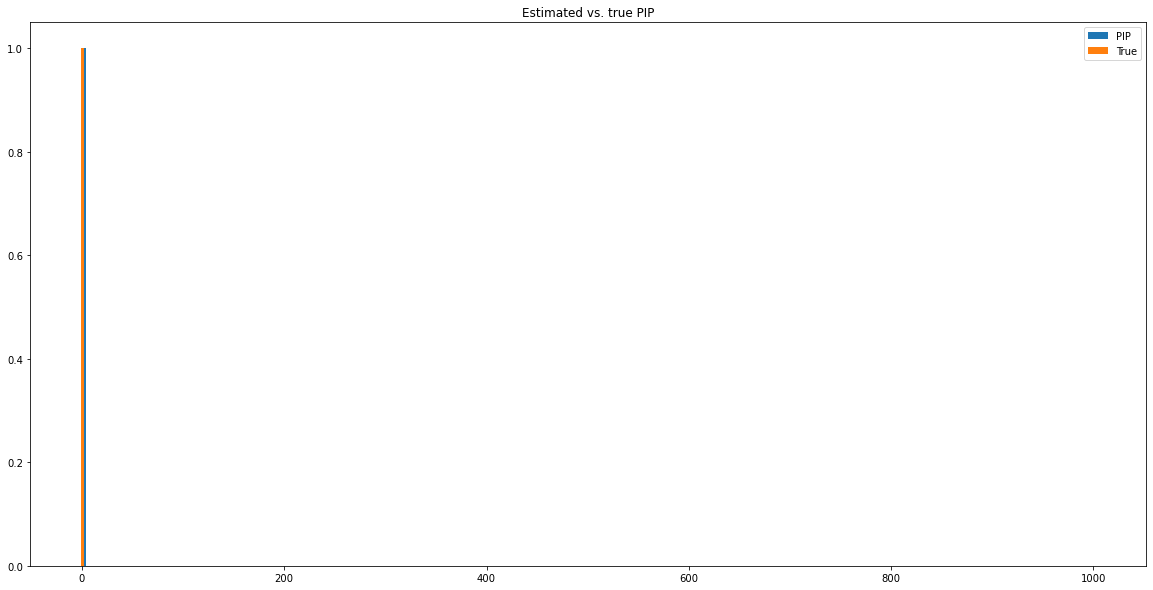

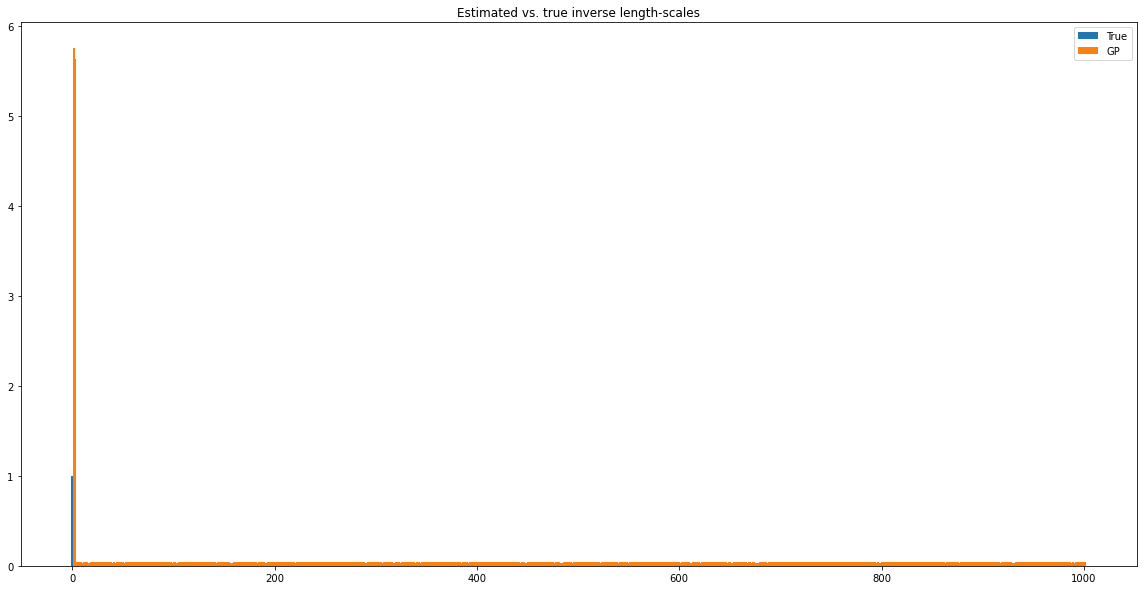

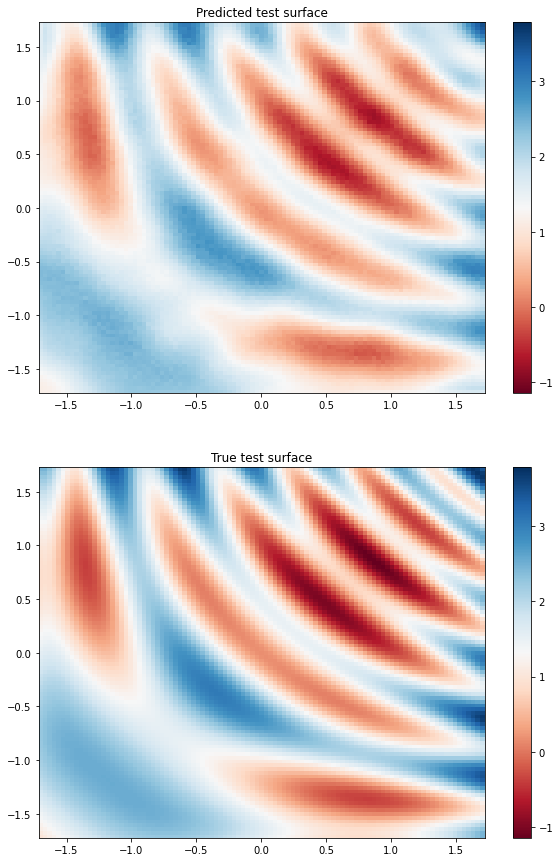

Latent test function MSE :  0.049430255
Observed test data  MSE :  0.34471858


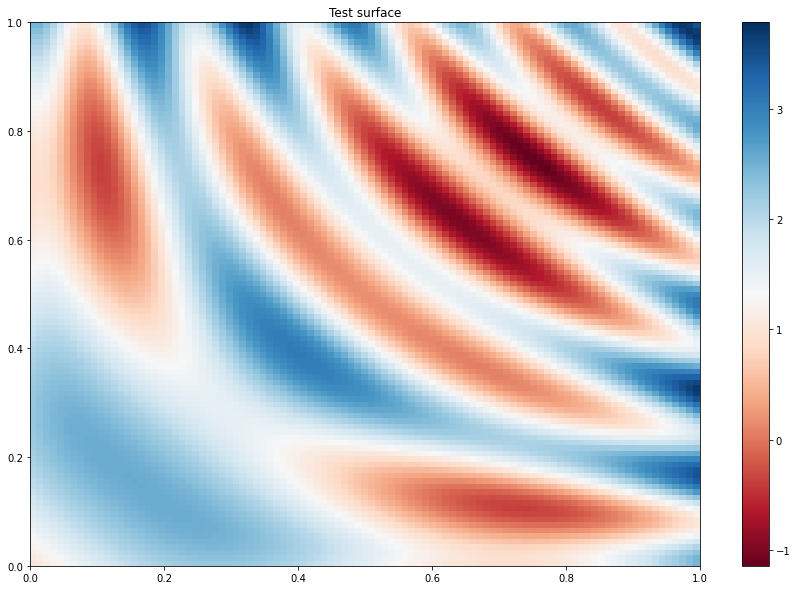

[20.894026 20.894114 20.894108 20.894104 20.89415  20.894138 20.894112
 20.894114 20.894114 20.894144]
3.1029622554779053 0.0002294647
Iter 2 - Loss: 3.103
[20.993788 20.993721 20.993914 20.993862 20.99403  20.993933 20.99393
 20.993862 20.993914 20.993994]
3.0994859504699708 0.0002274893
Iter 3 - Loss: 2.755
[21.093632 21.092823 21.093645 21.09351  21.09386  21.09343  21.093588
 21.093204 21.093658 21.093737]
3.093339306545258 0.00022515364
Iter 4 - Loss: 2.485
[21.193274 21.191133 21.192976 21.192797 21.193176 21.192148 21.192635
 21.19158  21.19301  21.192986]
3.0852123385744097 0.00022211514
Iter 5 - Loss: 2.281
[21.292183 21.288176 21.291416 21.291235 21.29141  21.289555 21.290613
 21.288498 21.291367 21.291138]
3.075596141339941 0.00021791276
Iter 6 - Loss: 2.124
[21.389492 21.38322  21.388273 21.38815  21.38791  21.38502  21.386917
 21.3834   21.387938 21.38744 ]
3.0648291053835424 0.00021220311
Iter 7 - Loss: 1.999
[21.4841   21.475384 21.482697 21.482765 21.481947 21.477823 21

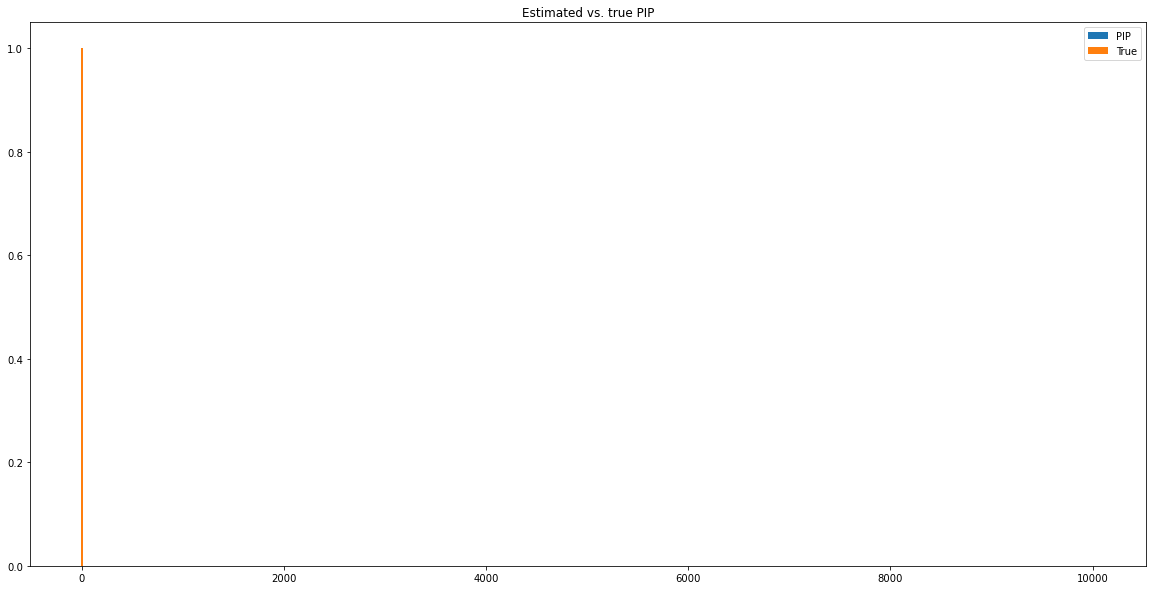

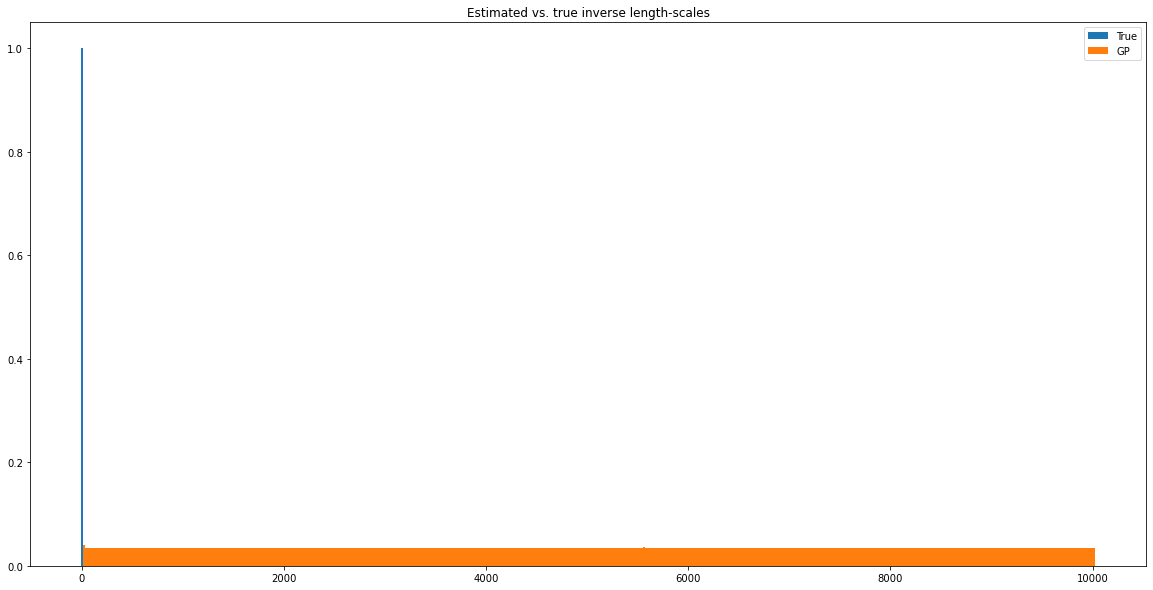

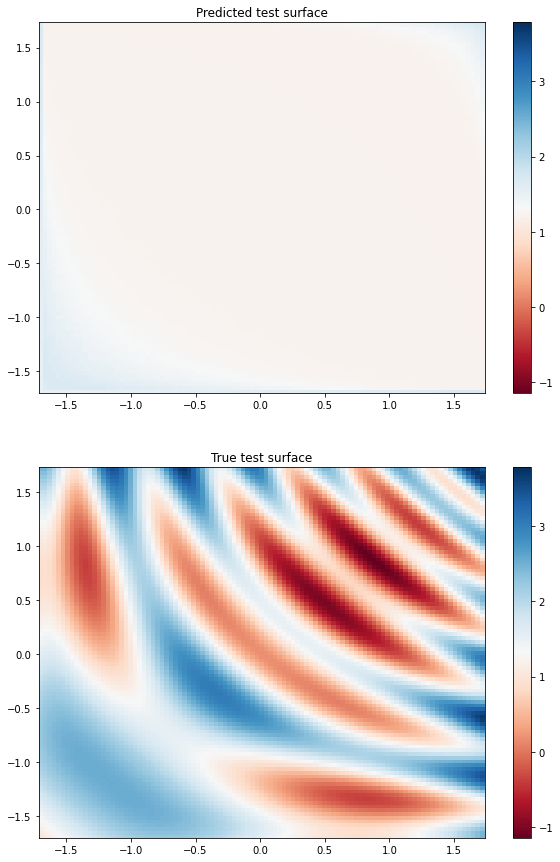

Latent test function MSE :  0.85881394
Observed test data  MSE :  1.1616352


[20.893492 20.891155 20.89217  20.892523 20.892973 20.890924 20.89071
 20.891115 20.893066 20.890127]
2.8484764099121094 0.00022418167


[20.997856 20.992392 20.99616  20.995281 20.996765 20.995241 20.994827
 20.9945   20.998646 20.99325 ]
2.845649094581604 0.00023593479


[21.106228 21.092384 21.102549 21.099499 21.10371  21.101227 21.098663
 21.099113 21.106346 21.099583]
2.841091357755661 0.00023841405


[21.216164 21.194153 21.20858  21.201927 21.21224  21.207998 21.20639
 21.20452  21.21587  21.205708]
2.8351783413262366 0.00023754108


[21.31949  21.290436 21.312687 21.30252  21.316103 21.310669 21.306515
 21.305464 21.319065 21.310469]
2.827771227159648 0.00022550307


[21.417961 21.380987 21.410385 21.398184 21.417648 21.408243 21.400581
 21.398754 21.419146 21.410769]
2.8189147478268177 0.0002147493


[21.508553 21.463654 21.501123 21.486885 21.510763 21.498308 21.488167
 21.487652 21.512207 21.503454]
2.8101795145140467 0.00019805592


[21.592047 21.54085  21.587408 21.571972 21.599169 21.580433 21.568966
 21.570198 21.59826  21.589579]
2.7997538677835183 0.00018317669


[21.671526 21.612535 21.668222 21.651342 21.68052  21.65887  21.644922
 21.645416 21.68011  21.669966]
2.7897461910708623 0.00017168703


[21.746237 21.680721 21.741737 21.727362 21.757048 21.73303  21.716522
 21.717878 21.756918 21.745771]
2.778584567811811 0.0001591747


[21.812984 21.740303 21.812866 21.79582  21.828993 21.801392 21.784029
 21.785883 21.828005 21.816313]
2.767878387794551 0.00014746746


[21.874426 21.795721 21.878279 21.863924 21.896564 21.865433 21.848461
 21.847738 21.894735 21.884558]
2.757410147072276 0.00013889739


[21.930922 21.848873 21.940657 21.928904 21.962267 21.929838 21.907999
 21.907589 21.958294 21.949957]
2.7469136370207727 0.00013248698


[21.983103 21.896145 22.00169  21.987835 22.023935 21.98814  21.964403
 21.964975 22.016558 22.011473]
2.7357071141854927 0.00012297233


[22.031149 21.94118  22.058044 22.042524 22.081406 22.042627 22.017195
 22.016636 22.074781 22.06759 ]
2.7244998464436776 0.00011517703


[22.074984 21.982267 22.110786 22.095564 22.136227 22.095129 22.067085
 22.066483 22.127834 22.12192 ]
2.7137534398791123 0.00010811999


[22.11696  22.019802 22.162106 22.147652 22.190363 22.14477  22.115883
 22.11561  22.179667 22.17278 ]
2.7031300160455065 0.00010433774


[22.155624 22.055328 22.211178 22.196339 22.23969  22.192987 22.164476
 22.16166  22.228281 22.221746]
2.6924881371096454 9.838829e-05


[22.189745 22.086939 22.256653 22.243998 22.289288 22.23898  22.207859
 22.204313 22.276218 22.268234]
2.6815973212235495 9.430169e-05


[22.22275  22.117945 22.301346 22.288715 22.335608 22.280544 22.248966
 22.246237 22.320358 22.312986]
2.6706169634078134 8.996488e-05


[22.255272 22.147097 22.346243 22.333347 22.381632 22.32414  22.291502
 22.286562 22.364687 22.357317]
2.659733082763756 8.839459e-05


[22.284182 22.174282 22.3905   22.377274 22.424856 22.367027 22.3311
 22.32546  22.40697  22.399536]
2.6490005902978586 8.4037194e-05


[22.312002 22.19907  22.431587 22.419456 22.46663  22.40766  22.369122
 22.364418 22.448254 22.440592]
2.6382792566227398 8.0918675e-05


[22.33645  22.221148 22.47089  22.458641 22.507387 22.44517  22.406895
 22.400356 22.488708 22.48005 ]
2.62783641261532 7.806688e-05


[22.361277 22.245544 22.510963 22.499157 22.548223 22.483442 22.445284
 22.436495 22.52805  22.519407]
2.616952922108246 7.739706e-05


[22.384007 22.266096 22.549105 22.538359 22.588146 22.522018 22.482018
 22.471806 22.56711  22.55738 ]
2.6063441986847407 7.554797e-05


[22.406574 22.285736 22.587362 22.57627  22.626024 22.560097 22.516108
 22.506378 22.604849 22.593927]
2.5961376509525778 7.310739e-05


[22.427515 22.303783 22.624685 22.612469 22.664272 22.596684 22.55317
 22.539053 22.642988 22.631844]
2.5863932951930977 7.164359e-05


[22.448957 22.324354 22.66395  22.650759 22.701864 22.63232  22.588585
 22.57405  22.680655 22.666298]
2.5760363343156754 7.152499e-05


[22.468452 22.341272 22.700726 22.687016 22.739098 22.666891 22.62304
 22.607244 22.716763 22.70164 ]
2.5658284166226193 6.914568e-05


[22.487478 22.36116  22.737003 22.723013 22.776697 22.701895 22.659027
 22.640278 22.753004 22.738068]
2.555999186573596 7.029264e-05


[22.505981 22.380226 22.773872 22.75844  22.811977 22.736607 22.692326
 22.673096 22.78951  22.772322]
2.545836230783452 6.7688874e-05


[22.524971 22.399063 22.808477 22.793125 22.847193 22.770302 22.725046
 22.704744 22.825525 22.805376]
2.5361309993883983 6.601655e-05


[22.542778 22.416471 22.843538 22.827633 22.882254 22.804153 22.75762
 22.736643 22.858997 22.838858]
2.526386388851683 6.5341905e-05


[22.560286 22.431004 22.87792  22.861664 22.916977 22.836456 22.791088
 22.768139 22.894714 22.871988]
2.5162453570230263 6.45588e-05


[22.578312 22.446918 22.914175 22.895937 22.951565 22.869928 22.82289
 22.799545 22.928915 22.905289]
2.506782478400153 6.473305e-05


[22.594576 22.463352 22.947863 22.929493 22.98595  22.903898 22.85696
 22.83065  22.963358 22.938337]
2.497111720686159 6.4199594e-05


[22.612017 22.480314 22.983723 22.963398 23.020666 22.936178 22.890669
 22.861649 22.997725 22.970808]
2.487545223649891 6.395461e-05


[22.626219 22.49606  23.017237 22.996462 23.053867 22.969187 22.922388
 22.891645 23.031837 23.002354]
2.4784374732776344 6.139745e-05


[22.645405 22.51268  23.051498 23.030296 23.088469 23.002516 22.955334
 22.923536 23.066004 23.034874]
2.4689691998574954 6.36302e-05


[22.661098 22.527428 23.087484 23.06412  23.122635 23.035425 22.988577
 22.95514  23.099281 23.068747]
2.4599337701632265 6.259488e-05


[22.676428 22.542904 23.121439 23.097078 23.155527 23.067423 23.020967
 22.986485 23.133001 23.100098]
2.4505358079460606 6.130546e-05


[22.693354 22.558952 23.154808 23.130571 23.18979  23.099623 23.052774
 23.017962 23.167585 23.132137]
2.441363623141594 6.173998e-05


[22.710835 22.573439 23.188318 23.164017 23.22306  23.131752 23.085226
 23.047817 23.20116  23.163286]
2.4325606424563664 6.129019e-05


[22.726574 22.591288 23.223415 23.197786 23.257172 23.164042 23.11704
 23.079344 23.234854 23.195162]
2.423456346885761 6.152708e-05


[22.74251  22.606647 23.256945 23.230198 23.29096  23.196093 23.148422
 23.110151 23.268494 23.226948]
2.4148624189073207 5.9815575e-05


[22.758316 22.622677 23.291931 23.263878 23.324123 23.229406 23.18211
 23.141123 23.302504 23.258987]
2.405960807095033 6.1085935e-05


[22.773846 22.639688 23.326902 23.297932 23.35761  23.261847 23.21475
 23.172567 23.33589  23.291237]
2.3973246697596324 6.100698e-05


[22.79116  22.655401 23.360126 23.330736 23.391275 23.293169 23.246487
 23.202263 23.369032 23.3226  ]
2.3887688177000976 6.0220318e-05


[22.807604 22.669195 23.395584 23.36418  23.425558 23.32534  23.27972
 23.23392  23.402843 23.355375]
2.380382595320521 6.0426544e-05


[22.824442 22.687723 23.42965  23.397757 23.459309 23.359066 23.31226
 23.265308 23.436256 23.387306]
2.371816295068838 6.05729e-05


[22.840689 22.70516  23.464659 23.431015 23.493824 23.39188  23.345165
 23.296907 23.470387 23.419436]
2.3631854111994945 6.0862913e-05


[22.857622 22.722044 23.497732 23.46401  23.52652  23.424025 23.376722
 23.328028 23.503992 23.451792]
2.3549217421308346 5.9181337e-05


[22.873674 22.73758  23.531408 23.497654 23.560444 23.456244 23.40972
 23.3587   23.537708 23.483896]
2.3467293514917524 6.016145e-05


[22.889194 22.751585 23.566727 23.532053 23.59387  23.48936  23.44298
 23.390083 23.571243 23.51639 ]
2.3384749681521586 5.9633316e-05


[22.90637  22.768976 23.600266 23.56507  23.627832 23.52153  23.475718
 23.420826 23.60514  23.547564]
2.3303343257170357 5.9509694e-05


[22.923395 22.787426 23.635286 23.59939  23.6622   23.554827 23.507904
 23.453411 23.639772 23.579967]
2.3221501261843067 6.0552728e-05


[22.939306 22.803185 23.669956 23.632204 23.69545  23.587723 23.540598
 23.483782 23.673819 23.61121 ]
2.3142369168345427 5.8435406e-05


[22.956047 22.82057  23.704922 23.666628 23.730852 23.621067 23.573357
 23.516378 23.707794 23.645046]
2.3067800273071577 6.023576e-05


[22.97342  22.838472 23.740381 23.700571 23.76547  23.653069 23.608105
 23.549198 23.742502 23.677324]
2.2986736056084576 6.0405637e-05


[22.989845 22.854918 23.774065 23.734365 23.797705 23.687267 23.640688
 23.581705 23.777939 23.70902 ]
2.2913223099019517 5.8867325e-05


[23.008389 22.873262 23.810892 23.769806 23.834196 23.719948 23.67337
 23.615002 23.812109 23.743011]
2.283676921466323 6.1075254e-05


[23.025892 22.891504 23.84521  23.803518 23.869072 23.75284  23.706728
 23.646416 23.845205 23.775726]
2.2759833881735196 5.9473838e-05


[23.044088 22.909971 23.8804   23.838531 23.903248 23.7863   23.740046
 23.678535 23.879679 23.808561]
2.2685945169115658 5.9680515e-05


[23.060286 22.924946 23.915628 23.873169 23.938152 23.819221 23.77421
 23.712145 23.915047 23.841908]
2.2612612488493076 6.0205788e-05


[23.077831 22.9452   23.95179  23.90832  23.973951 23.853292 23.808985
 23.744709 23.950891 23.875576]
2.253921819945028 6.0985065e-05


[23.097282 22.960503 23.988022 23.943531 24.010433 23.88771  23.843355
 23.77812  23.98592  23.909073]
2.246969950683566 6.0143833e-05


[23.115396 22.980013 24.024172 23.979155 24.045334 23.92184  23.877625
 23.811022 24.020874 23.942068]
2.239656255605594 6.038775e-05


[23.132872 22.998062 24.060148 24.014074 24.079575 23.955479 23.911552
 23.844372 24.056122 23.97457 ]
2.232506128453362 5.9358765e-05


[23.151136 23.01727  24.09518  24.048248 24.11454  23.98958  23.945932
 23.874947 24.091423 24.008057]
2.2254269768596853 5.9946276e-05


[23.168432 23.034697 24.131609 24.083822 24.149757 24.02382  23.980057
 23.910187 24.126787 24.04309 ]
2.2187609334094476 5.996608e-05


[23.186203 23.052477 24.167768 24.11942  24.185543 24.05832  24.014174
 23.94349  24.162832 24.07624 ]
2.212056267133367 6.0530823e-05


[23.205034 23.071964 24.203768 24.156832 24.221659 24.093039 24.049572
 23.978125 24.198137 24.110975]
2.2050665831489384 6.132926e-05


[23.223122 23.09063  24.240635 24.192434 24.257544 24.127264 24.084879
 24.012072 24.234404 24.145336]
2.1983950803442585 6.049862e-05


[23.241432 23.108845 24.277613 24.227606 24.293545 24.161558 24.11978
 24.046722 24.271584 24.179056]
2.1918339970773606 6.0366507e-05


[23.259876 23.128494 24.314585 24.265234 24.32998  24.197138 24.155537
 24.08111  24.307493 24.214312]
2.185510153833577 6.0905986e-05


[23.278889 23.14799  24.352537 24.30176  24.367477 24.23324  24.190468
 24.116869 24.344582 24.249556]
2.17924456726602 6.181689e-05


[23.297132 23.165808 24.389713 24.337317 24.403524 24.266523 24.226591
 24.150887 24.380266 24.283224]
2.172580636360053 5.990842e-05


[23.316063 23.185501 24.425488 24.375183 24.440231 24.302996 24.26284
 24.18571  24.417923 24.318655]
2.1661132578548052 6.094348e-05


[23.334946 23.203571 24.46456  24.412748 24.477682 24.339127 24.29885
 24.220518 24.454628 24.354803]
2.1598938004624144 6.1483406e-05


[23.354303 23.222395 24.501474 24.450102 24.515148 24.375507 24.336365
 24.255571 24.491978 24.389935]
2.1537192522969626 6.179058e-05


[23.373365 23.244005 24.541702 24.487518 24.552965 24.411608 24.371086
 24.292107 24.529814 24.425522]
2.1474556212516545 6.1854866e-05


[23.39328  23.262552 24.57948  24.525103 24.5904   24.44756  24.409204
 24.32693  24.567263 24.460583]
2.1407358777565757 6.1804974e-05


[23.412048 23.283752 24.617413 24.562168 24.628166 24.484617 24.444715
 24.363304 24.604555 24.49721 ]
2.1344300995988217 6.200893e-05


[23.43117  23.301271 24.654913 24.599407 24.664997 24.519936 24.480751
 24.399572 24.641651 24.53239 ]
2.12816572962357 6.0558235e-05


[23.450739 23.322079 24.694698 24.63818  24.703196 24.55578  24.519503
 24.435402 24.681135 24.56885 ]
2.1218566816088744 6.241613e-05


[23.469007 23.341806 24.732887 24.67552  24.741379 24.59166  24.556583
 24.47093  24.719643 24.60569 ]
2.1158658259934997 6.167355e-05


[23.48827  23.360586 24.772467 24.715862 24.77975  24.630768 24.59456
 24.508389 24.757654 24.641533]
2.1098452407010937 6.2820094e-05


[23.50769  23.38051  24.811071 24.755428 24.818424 24.667578 24.632067
 24.54537  24.796185 24.678867]
2.1037078938791813 6.231313e-05


[23.525953 23.398968 24.849443 24.792702 24.856596 24.706171 24.667576
 24.581276 24.835457 24.71459 ]
2.0978855931252802 6.0796225e-05


[23.545681 23.417135 24.889505 24.831833 24.896223 24.743479 24.706326
 24.618189 24.873957 24.753035]
2.0923524023151057 6.2658815e-05


[23.564203 23.437489 24.928953 24.871145 24.935064 24.781199 24.744501
 24.655493 24.913073 24.790546]
2.086506645664086 6.208572e-05


[23.583902 23.458054 24.969313 24.91084  24.975126 24.819525 24.78191
 24.693665 24.952866 24.828312]
2.0808818717565787 6.357371e-05


[23.604092 23.479403 25.008993 24.950655 25.015375 24.85655  24.820204
 24.730862 24.992157 24.866823]
2.074977457917629 6.2873005e-05


[23.623451 23.4997   25.049067 24.990925 25.055574 24.89636  24.85947
 24.769262 25.031254 24.904276]
2.0694428978293433 6.270842e-05


[23.64326  23.519476 25.089828 25.030268 25.094332 24.933395 24.898005
 24.807554 25.072184 24.943014]
2.063841982578238 6.291856e-05


[23.661194 23.53856  25.130978 25.071287 25.133595 24.971088 24.937244
 24.845718 25.11222  24.981716]
2.0583508327166737 6.298349e-05


[23.679163 23.557638 25.171104 25.11098  25.174236 25.01099  24.975855
 24.884909 25.151997 25.020157]
2.0527885519876974 6.338575e-05


[23.699615 23.578768 25.211765 25.15308  25.214186 25.05014  25.014534
 24.924082 25.193026 25.059772]
2.047284720518266 6.332853e-05


[23.71939  23.600908 25.253746 25.193548 25.256018 25.090975 25.054876
 24.963852 25.234934 25.098337]
2.042093273993625 6.409149e-05


[23.738451 23.620548 25.2953   25.234402 25.296745 25.129824 25.09484
 25.002527 25.274734 25.136448]
2.0367912441753657 6.342089e-05


[23.75887  23.640741 25.337404 25.2775   25.33828  25.169466 25.135607
 25.043541 25.316454 25.176888]
2.0313250138720553 6.438136e-05


[23.77867  23.660055 25.37816  25.31878  25.379623 25.208004 25.174452
 25.083206 25.358067 25.217566]
2.0261468409714176 6.3505075e-05


[23.798023 23.681383 25.421103 25.361145 25.422205 25.24909  25.21599
 25.124454 25.400658 25.259018]
2.020728648108731 6.581844e-05


[23.818796 23.700817 25.462988 25.40157  25.463688 25.290854 25.257288
 25.164179 25.44065  25.29707 ]
2.0156927976990398 6.3077976e-05


[23.837559 23.723854 25.506424 25.44525  25.505674 25.330559 25.297424
 25.204895 25.484907 25.33766 ]
2.0105670572563814 6.481051e-05


[23.85724  23.742657 25.548666 25.487541 25.547848 25.370647 25.33837
 25.245342 25.52686  25.377785]
2.005932333711024 6.4288615e-05


[23.875582 23.762926 25.592514 25.530123 25.590612 25.411047 25.379095
 25.286232 25.570229 25.418587]
2.000801584935987 6.436524e-05


[23.894884 23.782776 25.635826 25.57319  25.633097 25.45321  25.421131
 25.328451 25.613913 25.461088]
1.9959141492830075 6.556277e-05


[23.914938 23.801912 25.678633 25.617016 25.67556  25.494318 25.462175
 25.371634 25.657583 25.502117]
1.991316692350953 6.505985e-05


[23.933966 23.823345 25.723942 25.660479 25.719296 25.538445 25.503796
 25.413343 25.70095  25.5442  ]
1.986425493315322 6.63297e-05


[23.95356  23.844131 25.76641  25.704721 25.763033 25.581139 25.547174
 25.456594 25.744856 25.586065]
1.9817344542482578 6.5280816e-05


[23.971466 23.862772 25.810724 25.748987 25.80674  25.622663 25.59043
 25.498566 25.789175 25.626854]
1.9771002712028913 6.524803e-05


[23.990898 23.88028  25.855318 25.794235 25.850292 25.665237 25.633354
 25.540798 25.833036 25.668707]
1.9726263738032097 6.5585686e-05


[24.010881 23.904415 25.89829  25.8377   25.893606 25.707691 25.675785
 25.583857 25.877783 25.712362]
1.9681575186841045 6.617276e-05


[24.03031  23.923475 25.944551 25.883068 25.938452 25.751167 25.720478
 25.6272   25.922768 25.755714]
1.963683296135508 6.7125584e-05


[24.051428 23.94389  25.988699 25.928446 25.982973 25.794933 25.762806
 25.671076 25.968628 25.799965]
1.9588264111702924 6.601704e-05


[24.068895 23.96354  26.035175 25.972467 26.027798 25.838202 25.80648
 25.715403 26.0139   25.84093 ]
1.9545371144200396 6.541796e-05


[24.08726  23.983303 26.080967 26.017967 26.072508 25.881298 25.850277
 25.758232 26.059164 25.885147]
1.9503122338745178 6.582454e-05


[24.104593 24.002851 26.124695 26.063393 26.117926 25.92508  25.89422
 25.802256 26.104776 25.926626]
1.9460924517514555 6.57321e-05


[24.124937 24.023502 26.171835 26.111212 26.164452 25.970192 25.939665
 25.849604 26.150532 25.972471]
1.9416279175766533 6.794162e-05


[24.143114 24.04374  26.218824 26.15797  26.209003 26.01254  25.983986
 25.894697 26.198273 26.015991]
1.937313992688988 6.6663124e-05


[24.162817 24.063206 26.26656  26.20439  26.25568  26.058228 26.030321
 25.939775 26.244965 26.059832]
1.9328851915606209 6.677193e-05


[24.180696 24.082737 26.313826 26.252367 26.30344  26.104582 26.075962
 25.98606  26.292511 26.104746]
1.9285175966259105 6.858295e-05


[24.197124 24.100302 26.360859 26.298132 26.348305 26.14828  26.120453
 26.031424 26.339125 26.1496  ]
1.9241929600006242 6.625717e-05


[24.216507 24.118631 26.407452 26.345602 26.39445  26.19476  26.166594
 26.07714  26.38664  26.196264]
1.9198732368024427 6.7846115e-05


[24.234028 24.138605 26.455498 26.393936 26.44106  26.239819 26.21048
 26.12215  26.433952 26.240732]
1.9158026663416143 6.692212e-05


[24.251774 24.158943 26.503365 26.440794 26.489317 26.284374 26.256886
 26.169811 26.481627 26.286749]
1.9120609745456756 6.724156e-05


[24.26936  24.176481 26.5521   26.489367 26.536469 26.332575 26.304869
 26.217905 26.531366 26.332258]
1.9076274261100332 6.896948e-05


[24.28868  24.195265 26.601416 26.539753 26.584232 26.37997  26.35144
 26.26521  26.580278 26.37936 ]
1.9036555017005412 6.89579e-05


[24.30456  24.210812 26.649273 26.58779  26.632437 26.426163 26.398941
 26.312832 26.629288 26.42606 ]
1.8997697595478393 6.739602e-05


[24.32175  24.231564 26.698639 26.637165 26.681728 26.47431  26.445385
 26.360924 26.679457 26.473993]
1.8958665388906086 6.8879686e-05


[24.338303 24.248419 26.748232 26.685955 26.731668 26.521479 26.493399
 26.40976  26.72959  26.520689]
1.8923016015195095 6.894787e-05


[24.354149 24.266714 26.799381 26.73709  26.781017 26.569517 26.542088
 26.457815 26.78113  26.56755 ]
1.8887092315423697 6.9173424e-05


[24.371193 24.287987 26.847906 26.787003 26.829533 26.617128 26.589659
 26.5053   26.831013 26.615393]
1.8850226480598775 6.919086e-05


[24.387205 24.304182 26.89934  26.837587 26.878532 26.664438 26.637924
 26.55422  26.881456 26.664085]
1.8814566201018466 6.9054724e-05


[24.403498 24.321613 26.94925  26.888313 26.92916  26.712385 26.685764
 26.604488 26.93225  26.71314 ]
1.8776155715571545 6.951296e-05


[24.41572  24.336084 26.998917 26.938557 26.97912  26.761616 26.734943
 26.652245 26.981695 26.760431]
1.87417134695578 6.772151e-05


[24.432121 24.351585 27.049326 26.990738 27.029713 26.811754 26.78414
 26.704254 27.034094 26.809526]
1.8702759476780404 7.044545e-05


[24.445467 24.366436 27.103779 27.042456 27.080317 26.860617 26.833193
 26.7556   27.085758 26.858818]
1.8666787086880916 7.0318725e-05


[24.460985 24.38301  27.155182 27.095022 27.132444 26.909155 26.885128
 26.807865 27.139519 26.909157]
1.8633856534527886 7.0960465e-05


[24.47522  24.399355 27.20556  27.147654 27.18475  26.960493 26.936068
 26.85862  27.193054 26.958544]
1.8595203580430624 7.0428185e-05


[24.489126 24.415354 27.25884  27.200165 27.236557 27.010029 26.986057
 26.910309 27.246475 27.008234]
1.8560798785837254 7.04563e-05


[24.50427  24.433184 27.311846 27.253315 27.289572 27.060835 27.036848
 26.961977 27.298994 27.05908 ]
1.8525356391602996 7.063522e-05


[24.517239 24.45094  27.366005 27.306818 27.343176 27.113827 27.088709
 27.015816 27.352032 27.111713]
1.8490768647331894 7.148007e-05


[24.52566  24.463808 27.41859  27.360163 27.395601 27.164696 27.139585
 27.067972 27.40738  27.161697]
1.8460339546578637 7.072067e-05


[24.537594 24.47964  27.471622 27.414797 27.448162 27.216858 27.191072
 27.121391 27.461933 27.214064]
1.8429475543870266 7.1852526e-05


[24.550735 24.49211  27.527822 27.470808 27.5034   27.270016 27.245111
 27.175394 27.517498 27.267859]
1.8394074120912947 7.2334675e-05


[24.562319 24.50511  27.580885 27.525553 27.556206 27.324385 27.299633
 27.230022 27.572723 27.320364]
1.8361817282444295 7.148918e-05


[24.573174 24.51788  27.636507 27.5819   27.611809 27.375988 27.351984
 27.2831   27.628265 27.371035]
1.832922830302119 7.177225e-05


[24.584126 24.533154 27.690577 27.635864 27.66638  27.42802  27.405533
 27.338633 27.683977 27.42517 ]
1.829804793176466 7.200807e-05


[24.592    24.545778 27.745924 27.691349 27.72083  27.481464 27.458143
 27.393618 27.738905 27.47847 ]
1.8264890212075309 7.196353e-05


[24.5996   24.559193 27.802376 27.747458 27.775791 27.53571  27.511988
 27.44867  27.795853 27.532122]
1.8232305241896543 7.216121e-05


[24.608522 24.570131 27.85806  27.804876 27.831722 27.590912 27.56595
 27.504377 27.853363 27.586004]
1.8199837111772195 7.265631e-05


[24.613646 24.579926 27.913748 27.86267  27.888489 27.644266 27.620514
 27.558525 27.910484 27.64217 ]
1.8170685577698236 7.250164e-05


[24.619904 24.590149 27.97102  27.91869  27.945192 27.699533 27.675764
 27.615107 27.966621 27.696135]
1.8140036632840444 7.2788134e-05


[24.627386 24.598534 28.028727 27.97707  28.001856 27.756912 27.731642
 27.672405 28.023956 27.749992]
1.8113475627226 7.343332e-05


[24.63004  24.60625  28.086645 28.035206 28.059008 27.813025 27.78832
 27.732004 28.085579 27.807568]
1.8080338882065952 7.432128e-05


[24.63559  24.614206 28.142893 28.093697 28.116167 27.866953 27.84358
 27.789932 28.144327 27.863804]
1.8050714783063102 7.351257e-05


[24.640076 24.624266 28.203209 28.152876 28.175182 27.92459  27.900164
 27.846836 28.204582 27.918648]
1.8020964864560627 7.418789e-05


[24.642595 24.630873 28.262115 28.212717 28.233646 27.980703 27.95833
 27.903341 28.2652   27.976343]
1.7990252891810712 7.413441e-05


[24.639818 24.630365 28.319859 28.270994 28.29191  28.037151 28.012571
 27.963356 28.32525  28.031628]
1.7957917801971888 7.283336e-05


[24.642445 24.634369 28.37866  28.332273 28.351595 28.09486  28.070318
 28.022936 28.383896 28.08853 ]
1.7928152216386097 7.4317875e-05


[24.638643 24.635763 28.438902 28.39261  28.41031  28.153877 28.128862
 28.083027 28.444708 28.146305]
1.789887692886808 7.443719e-05


[24.633268 24.636497 28.4996   28.45333  28.469755 28.212423 28.18493
 28.14322  28.50612  28.203657]
1.786941297943032 7.4317155e-05


[24.629934 24.63877  28.560753 28.515125 28.53042  28.271744 28.24295
 28.203705 28.56839  28.264318]
1.7838871272540984 7.5382784e-05


[24.621387 24.63737  28.620245 28.57656  28.589603 28.328691 28.302103
 28.26315  28.628334 28.322386]
1.7813721786156822 7.35956e-05


[24.614174 24.639065 28.681063 28.639557 28.652248 28.388062 28.36303
 28.323565 28.692692 28.380976]
1.7785518371376765 7.5205e-05


[24.61002  24.637873 28.744513 28.701725 28.7145   28.44742  28.424051
 28.385942 28.756865 28.441084]
1.7760723206679263 7.556629e-05


[24.601875 24.630604 28.806585 28.765926 28.776806 28.507107 28.483498
 28.448328 28.819933 28.502836]
1.773585664386296 7.5673255e-05


[24.590065 24.623384 28.86797  28.830505 28.838472 28.569466 28.543613
 28.510414 28.883902 28.562387]
1.771002668622331 7.530417e-05


[24.577423 24.622458 28.930891 28.893972 28.9012   28.629942 28.606667
 28.57409  28.947786 28.622068]
1.7681217423065148 7.642114e-05


[24.56159  24.611452 28.9933   28.957586 28.9625   28.69036  28.665558
 28.635942 29.012745 28.682251]
1.765513809986294 7.4436066e-05


[24.544012 24.598482 29.055027 29.020592 29.025969 28.751787 28.727371
 28.696524 29.07742  28.743069]
1.7628288147277702 7.586669e-05


[24.524721 24.585985 29.121504 29.086033 29.089027 28.81488  28.78938
 28.76111  29.142994 28.806438]
1.76061606274573 7.585428e-05


[24.500443 24.57671  29.18556  29.151592 29.152323 28.87675  28.851439
 28.823404 29.207718 28.867552]
1.7582754229293536 7.5596334e-05


[24.479494 24.560581 29.250408 29.217243 29.2183   28.937881 28.913774
 28.888357 29.2738   28.930494]
1.7556849093674032 7.653109e-05


[24.453156 24.541794 29.313494 29.282291 29.282991 29.000097 28.976254
 28.954006 29.340986 28.993937]
1.7530691792293414 7.538525e-05


[24.423038 24.523996 29.377182 29.349186 29.346827 29.061827 29.038843
 29.02045  29.406168 29.055544]
1.750831445458212 7.588487e-05


[24.393686 24.50428  29.443577 29.416475 29.410057 29.124638 29.103209
 29.084803 29.472784 29.118113]
1.7481933800366039 7.588005e-05


[24.363798 24.478779 29.508572 29.481506 29.475111 29.187841 29.165361
 29.149302 29.541986 29.182196]
1.7456042532430738 7.6066295e-05


[24.33013  24.44992  29.575562 29.549662 29.543242 29.251724 29.229115
 29.217693 29.61043  29.248362]
1.7430675715867263 7.774788e-05


[24.293194 24.42467  29.639133 29.61717  29.609734 29.317165 29.293535
 29.28271  29.676575 29.311712]
1.740748195624048 7.539252e-05


[24.251524 24.395195 29.706005 29.684734 29.67693  29.383352 29.359024
 29.347855 29.745586 29.374979]
1.7381197795152044 7.660023e-05


[24.20186  24.36048  29.774836 29.753544 29.742569 29.447819 29.422699
 29.413729 29.816519 29.44094 ]
1.735549305978475 7.616743e-05


[24.156122 24.328142 29.842077 29.82285  29.811317 29.514282 29.49052
 29.483994 29.885513 29.507826]
1.7333274000406538 7.775887e-05


[24.106285 24.28976  29.90947  29.892729 29.880188 29.579624 29.556646
 29.551813 29.957823 29.57298 ]
1.7313105694835456 7.716344e-05


[24.0485   24.245628 29.977432 29.961857 29.94766  29.645765 29.622728
 29.619709 30.025816 29.63858 ]
1.7288293465039353 7.612791e-05


[23.990515 24.199207 30.047426 30.034029 30.015278 29.71163  29.690533
 29.688765 30.094872 29.70436 ]
1.7262608790219434 7.7158e-05


[23.927343 24.144886 30.113348 30.103756 30.083393 29.778502 29.755077
 29.756258 30.1677   29.771053]
1.723782615858555 7.6055745e-05


[23.856493 24.096043 30.182575 30.174679 30.15147  29.845259 29.82339
 29.824276 30.236866 29.8376  ]
1.7211822635216094 7.661639e-05


[23.777483 24.043406 30.25003  30.24475  30.219965 29.912159 29.887672
 29.89294  30.306795 29.904388]
1.7194265511254223 7.575618e-05


[23.703342 23.98185  30.321241 30.317322 30.290163 29.980131 29.956394
 29.96061  30.377474 29.970913]
1.7174457548810595 7.656762e-05


[23.616596 23.916391 30.392435 30.389692 30.361977 30.049883 30.024487
 30.032913 30.451199 30.040953]
1.714951527949772 7.8240366e-05


[23.519417 23.842072 30.459564 30.456926 30.430761 30.116003 30.0896
 30.10194  30.523745 30.106627]
1.7126014251592117 7.475786e-05


[23.426443 23.774738 30.529545 30.528976 30.502186 30.180628 30.159893
 30.172426 30.596487 30.17385 ]
1.710460426299923 7.6098586e-05


[23.327156 23.695827 30.598328 30.601791 30.571375 30.248674 30.227549
 30.240332 30.666664 30.242779]
1.7086030251485724 7.5167954e-05


[23.224232 23.607584 30.668867 30.676157 30.640501 30.318014 30.294626
 30.3091   30.740625 30.312191]
1.7065029210483624 7.584165e-05


[23.111818 23.530478 30.74218  30.747875 30.713802 30.387562 30.366297
 30.37888  30.815659 30.380133]
1.7044789570539431 7.747661e-05


[22.991621 23.432257 30.812    30.821821 30.784307 30.457071 30.436285
 30.450281 30.888884 30.450058]
1.702028524497106 7.603418e-05


[22.86232  23.3236   30.883448 30.892767 30.85239  30.52482  30.503777
 30.518917 30.961153 30.517267]
1.700327103836104 7.370391e-05


[22.726452 23.229422 30.954277 30.966614 30.92583  30.595545 30.574242
 30.590511 31.03635  30.586098]
1.698284031200148 7.643011e-05


[22.583624 23.110529 31.023006 31.040434 30.995098 30.662973 30.639755
 30.660042 31.107708 30.654068]
1.6963857102744377 7.373876e-05


[22.43473  23.000212 31.094337 31.114523 31.067535 30.73392  30.711731
 30.732267 31.181522 30.723503]
1.6942939308751692 7.589541e-05


[22.2788   22.881763 31.16684  31.187449 31.140177 30.804565 30.782873
 30.802544 31.256527 30.794136]
1.6920873077704885 7.575747e-05


[22.104502 22.746258 31.237837 31.26072  31.211237 30.870775 30.851252
 30.873543 31.331177 30.864435]
1.6898480183357434 7.363888e-05


[21.941572 22.607748 31.306883 31.335228 31.284355 30.942604 30.923056
 30.944315 31.404066 30.933096]
1.6878697454144251 7.453939e-05


[21.755823 22.456062 31.377665 31.407911 31.353722 31.012293 30.989996
 31.014387 31.477144 31.000443]
1.6858564737854 7.2823175e-05


[21.576965 22.304577 31.449966 31.485182 31.425352 31.082312 31.060986
 31.08495  31.552841 31.071104]
1.684227799394073 7.470245e-05


[21.37356  22.152565 31.522848 31.557499 31.497732 31.152344 31.132366
 31.155851 31.62782  31.13918 ]
1.6827967266918804 7.380761e-05


[21.165163 21.979807 31.593164 31.63318  31.570862 31.221294 31.20186
 31.22577  31.701244 31.208448]
1.6811915544345748 7.248312e-05


[20.956179 21.812897 31.664755 31.708765 31.644949 31.291864 31.26939
 31.299744 31.778435 31.28042 ]
1.6795478777684791 7.342007e-05


[20.744528 21.636997 31.737663 31.783646 31.71638  31.36221  31.341711
 31.370487 31.85124  31.34969 ]
1.6777206487886154 7.278556e-05


[20.509508 21.440775 31.80966  31.855837 31.786272 31.430275 31.411137
 31.43929  31.927639 31.41869 ]
1.6759897884883208 7.162368e-05


[20.26502  21.252823 31.88046  31.930405 31.858444 31.499397 31.481615
 31.511889 32.000328 31.489187]
1.674580225247755 7.160385e-05


[20.015793 21.048134 31.954166 32.006428 31.930273 31.569418 31.55354
 31.581972 32.075092 31.558764]
1.6729257349268876 7.223303e-05


[19.774366 20.835854 32.02403  32.0811   32.005238 31.641808 31.623926
 31.649733 32.1507   31.628996]
1.6709579648231783 7.1791124e-05


[19.513428 20.62927  32.095837 32.156174 32.076786 31.713316 31.693806
 31.720934 32.22562  31.697563]
1.6695904300052689 7.137974e-05


[19.24726  20.393791 32.16676  32.22936  32.14752  31.781176 31.762608
 31.78965  32.299713 31.765509]
1.6680569209440925 6.9636284e-05


[18.977016 20.154528 32.238293 32.304474 32.218964 31.847939 31.830858
 31.861452 32.374214 31.83532 ]
1.6660218817200794 6.9375375e-05


[18.70073  19.919111 32.31121  32.377224 32.29073  31.919418 31.901712
 31.927507 32.44588  31.903803]
1.664259632864045 6.9901194e-05


[18.40491  19.67846  32.381416 32.452293 32.36275  31.987617 31.968925
 31.997036 32.52181  31.97364 ]
1.6628861729642377 6.8777175e-05


[18.109076 19.432785 32.45518  32.527283 32.4335   32.056435 32.04087
 32.06687  32.59489  32.04334 ]
1.6611181677676459 6.9684356e-05


[17.813951 19.171982 32.525497 32.6      32.505154 32.12454  32.107105
 32.1367   32.668983 32.11183 ]
1.6597279905760534 6.808008e-05


[17.510197 18.906065 32.5958   32.6729   32.57695  32.19254  32.17857
 32.20459  32.74279  32.18025 ]
1.6578802972524767 6.8257024e-05


[17.202396 18.633146 32.668003 32.744205 32.646805 32.26066  32.246853
 32.27254  32.814632 32.246677]
1.6563329500351858 6.681719e-05


[16.889053 18.355825 32.737465 32.819923 32.71849  32.326424 32.315025
 32.33869  32.889217 32.31433 ]
1.654323163864073 6.6787e-05


[16.581688 18.07675  32.808834 32.892963 32.786266 32.39433  32.38441
 32.41061  32.962498 32.383614]
1.652583664859023 6.705089e-05


[16.272028 17.800417 32.880436 32.967243 32.858192 32.464848 32.45512
 32.48136  33.036095 32.453205]
1.6506554587112263 6.772516e-05


[15.937126 17.511509 32.949467 33.038174 32.927223 32.531693 32.52133
 32.548733 33.108997 32.519497]
1.648943758049819 6.518506e-05


[15.606066 17.207426 33.01685  33.110046 32.996872 32.59835  32.5868
 32.61079  33.18085  32.587006]
1.6475878396419892 6.3589e-05


[15.271349 16.911692 33.090103 33.185516 33.066933 32.666718 32.659447
 32.678047 33.255035 32.65554 ]
1.6465878387689916 6.542355e-05


[14.941262 16.593086 33.15832  33.259014 33.1373   32.734913 32.725895
 32.743034 33.32669  32.721024]
1.645083158949646 6.4528416e-05


[14.6035385 16.280836  33.226658  33.329407  33.20736   32.80074
 32.78994   32.81517   33.40051   32.78932  ]
1.6431180346431695 6.421269e-05


[14.259131 15.96163  33.294403 33.39841  33.273182 32.866493 32.857758
 32.88021  33.471413 32.854027]
1.641807987624222 6.261769e-05


[13.905161 15.637672 33.360992 33.470676 33.344803 32.931423 32.92435
 32.943024 33.54319  32.920506]
1.6404597262446838 6.277587e-05


[13.556715 15.30804  33.42859  33.54101  33.4143   32.996284 32.991493
 33.00883  33.61309  32.985798]
1.6390436491276532 6.280144e-05


[13.198583 14.99394  33.49667  33.61238  33.481525 33.062748 33.06039
 33.074516 33.68639  33.05206 ]
1.6379124570783627 6.266553e-05


[12.833915 14.64631  33.564434 33.68325  33.551567 33.127304 33.125443
 33.139717 33.756985 33.1185  ]
1.6364264220404312 6.0950828e-05


[12.462052 14.3093   33.63251  33.75267  33.61821  33.191544 33.190002
 33.202953 33.830265 33.18154 ]
1.6350179240210463 6.0590653e-05


[12.093635 13.964239 33.698612 33.82465  33.685783 33.25617  33.25636
 33.266975 33.899723 33.2481  ]
1.6337054280293557 6.0596776e-05


[11.716562 13.609003 33.765106 33.894833 33.75585  33.321125 33.324867
 33.333015 33.969807 33.313267]
1.6317988167975392 6.084373e-05


[11.3318615 13.265445  33.831005  33.963943  33.82324   33.38482
 33.386963  33.39623   34.038864  33.37525  ]
1.6303155687914597 5.987355e-05


[10.931483 12.914965 33.895588 34.031143 33.89053  33.449154 33.452034
 33.4539   34.10687  33.43651 ]
1.6294078124355917 5.8352965e-05


[10.53956  12.55464  33.96336  34.101562 33.95862  33.51309  33.516872
 33.518246 34.17968  33.50217 ]
1.627717369383944 6.0213162e-05


[10.137673 12.192604 34.029175 34.172394 34.024643 33.574677 33.58038
 33.582825 34.248432 33.56662 ]
1.626526449571559 5.9237645e-05


[ 9.72462  11.812665 34.095085 34.239742 34.091698 33.63559  33.644447
 33.640934 34.317463 33.629307]
1.6248321627636793 5.7276637e-05


[ 9.318173 11.436818 34.161995 34.30956  34.159523 33.698154 33.70983
 33.703094 34.387188 33.69068 ]
1.6236357532053631 5.83259e-05


[ 8.899489 11.046317 34.225792 34.377197 34.224293 33.763054 33.772915
 33.76475  34.456787 33.753788]
1.622369532554184 5.693642e-05


[ 8.466809  10.6566105 34.288933  34.446304  34.28936   33.823883
 33.837654  33.826706  34.523766  33.817905 ]
1.6210601483992202 5.7179106e-05


[ 8.0279045 10.263135  34.356052  34.51638   34.356712  33.88638
 33.90241   33.89032   34.594456  33.879597 ]
1.6196843693315335 5.7989775e-05


[ 7.59138   9.851537 34.420807 34.583145 34.423157 33.94491  33.965656
 33.950447 34.663616 33.941692]
1.6187530142627908 5.6240766e-05


[ 7.141154  9.449073 34.484512 34.652256 34.487972 34.007824 34.028275
 34.00799  34.731243 34.00393 ]
1.6172836685912932 5.6866284e-05


[ 6.6764603  9.034728  34.548893  34.716526  34.553074  34.069134
 34.09271   34.067417  34.798553  34.064083 ]
1.6160338322410737 5.5919812e-05


[ 6.2038336  8.608514  34.61555   34.78585   34.62206   34.13174
 34.15539   34.128544  34.86653   34.129387 ]
1.6145718753426133 5.7251335e-05


[ 5.721616  8.180477 34.679012 34.8558   34.68738  34.190994 34.21989
 34.189785 34.93499  34.189728]
1.6134316724030147 5.615691e-05


[ 5.2179775  7.748755  34.74371   34.921383  34.751873  34.253906
 34.283867  34.251118  35.00044   34.25097  ]
1.6122599919113605 5.679475e-05


[ 4.6928988  7.297233  34.809006  34.990505  34.816994  34.317444
 34.34787   34.311256  35.069862  34.315815 ]
1.6108200890499709 5.7511912e-05


[ 4.1615915  6.84547   34.87535   35.058678  34.88427   34.37651
 34.410595  34.374336  35.138348  34.376663 ]
1.6095583585154587 5.766083e-05


[ 3.6126218  6.3697886 34.939182  35.12645   34.95023   34.435806
 34.477474  34.43374   35.20714   34.44145  ]
1.6084021367409882 5.9228565e-05


[ 3.0511408  5.8919134 35.00798   35.199116  35.020172  34.49968
 34.542133  34.49952   35.280388  34.50482  ]
1.6074025393924383 6.3190986e-05


[ 2.4801843  5.374315  35.07465   35.269466  35.087917  34.56624
 34.610134  34.561363  35.348225  34.570557 ]
1.6062163297123964 6.491078e-05


[ 1.9308048  4.846057  35.14674   35.342327  35.15937   34.633682
 34.68003   34.628952  35.42562   34.637966 ]
1.6050121035128218 7.150291e-05


[ 1.4075345  4.324523  35.223244  35.422657  35.23495   34.7097
 34.757435  34.704384  35.50424   34.71339  ]
1.6035441372285175 8.4832565e-05


[ 0.96353763  3.7805965  35.31182    35.508034   35.3204     34.79223
 34.844574   34.79328    35.59238    34.80002   ]
1.6022315509473273 0.00010541664


[ 0.6822383  3.2900841 35.422123  35.610786  35.41943   34.896244
 34.95053   34.897114  35.698997  34.901035 ]
1.6007966485104401 0.00013027877


[ 0.6378147  2.855864  35.54094   35.730522  35.534393  35.010185
 35.073273  35.021923  35.817986  35.022896 ]
1.5991346390661223 0.00010995517


[ 0.666044   2.3918314 35.67593   35.861004  35.66177   35.13958
 35.210205  35.157608  35.950386  35.154453 ]
1.5976319635014193 0.00011815399


[ 0.6517643  1.8836527 35.817852  35.995663  35.794025  35.27806
 35.355328  35.307655  36.091015  35.294407 ]
1.5959411057690236 0.00012484813


[ 0.6508507  1.4046116 35.968403  36.14117   35.9366    35.423626
 35.5103    35.468018  36.242355  35.447334 ]
1.5945303671490012 0.00013472847


[ 0.69048494  0.99716693 36.129856   36.296925   36.088665   35.582508
 35.67679    35.63579    36.402306   35.60526   ]
1.5930292990407893 0.00016125948


[ 0.7561652  0.7823933 36.3056    36.46533   36.25362   35.75631
 35.86012   35.82045   36.572445  35.77994  ]
1.5916738306219909 0.00017249245


[ 0.78980154  0.7414384  36.488323   36.641644   36.42865    35.939087
 36.052895   36.00967    36.749474   35.96104   ]
1.5900838065930383 0.0001504355


[ 0.7692531   0.76026046 36.68034    36.82532    36.613693   36.13084
 36.253582   36.211666   36.937954   36.15152   ]
1.5887589875757986 0.00015021052


[ 0.73811984  0.7155244  36.878864   37.012226   36.805576   36.32907
 36.46378    36.420506   37.130997   36.347977  ]
1.5874473344943216 0.000159598


[ 0.7358606   0.71094793 37.08608    37.206482   36.998505   36.532772
 36.68055    36.627785   37.33353    36.549477  ]
1.5860838062310894 0.00015058728


[ 0.7165123  0.7185075 37.295403  37.40981   37.197525  36.743446
 36.90057   36.84931   37.538273  36.754032 ]
1.5848140779214335 0.00015606846


[ 0.7062641  0.6844773 37.511616  37.613754  37.403038  36.954727
 37.126186  37.069168  37.745735  36.96539  ]
1.5832229664371869 0.00016255869


[ 0.691329    0.69344133 37.7282     37.822083   37.613945   37.17181
 37.35397    37.291924   37.95987    37.179382  ]
1.5817772333166993 0.00015873507


[ 0.68660814  0.6614726  37.945705   38.033974   37.823917   37.390533
 37.58957    37.519943   38.177673   37.40085   ]
1.5803755929567989 0.00016295484


[ 0.68810666  0.65328133 38.17404    38.247868   38.043575   37.617195
 37.826298   37.754128   38.399723   37.62283   ]
1.579036071140924 0.00015747994


[ 0.6687705  0.6676414 38.39936   38.46669   38.261772  37.846443
 38.0667    37.98163   38.62121   37.846775 ]
1.5774209991067303 0.00016238671


[ 0.66370857  0.6425862  38.62672    38.689087   38.483723   38.07194
 38.308296   38.213593   38.84693    38.074398  ]
1.575603086751695 0.0001613481


[ 0.6570428  0.6533724 38.852203  38.90719   38.703472  38.299286
 38.545357  38.44772   39.070908  38.29613  ]
1.573604803295906 0.00015592328


[ 0.6468672  0.6501295 39.074394  39.118294  38.922318  38.526142
 38.781593  38.676884  39.29      38.519733 ]
1.5718174819169997 0.00015072392


[ 0.64797217  0.6360609  39.294388   39.332832   39.141685   38.74874
 39.015617   38.903664   39.505394   38.74005   ]
1.5704761107343805 0.00014928685


[ 0.65708834  0.62946236 39.51369    39.551086   39.35958    38.97173
 39.25137    39.12895    39.72693    38.96231   ]
1.5685522892060468 0.00014749377


[ 0.6300978  0.6186537 39.727436  39.75804   39.570103  39.18804
 39.479187  39.34815   39.94122   39.175877 ]
1.5668433247608704 0.00014753325


[ 0.6421417   0.62191814 39.942368   39.963604   39.778107   39.401436
 39.700615   39.56243    40.148216   39.38242   ]
1.5655058114942646 0.00013744872


[ 0.6247481   0.61676455 40.150238   40.168503   39.983925   39.616596
 39.920055   39.775364   40.3534     39.594666  ]
1.5635253868822823 0.00013785753


[ 0.618918   0.6207561 40.343464  40.36117   40.178825  39.817146
 40.132847  39.978878  40.54819   39.792927 ]
1.5618852416178906 0.00012667685


[ 0.62700605  0.6019604  40.543674   40.553585   40.376354   40.01747
 40.34348    40.1766     40.746506   39.990345  ]
1.5604297795997373 0.00012995783


[ 0.6098562   0.60165364 40.72927    40.735218   40.562016   40.212902
 40.5432     40.37182    40.931675   40.176132  ]
1.5587983471468339 0.00012009375


[ 0.6176725   0.61515707 40.917236   40.922947   40.750973   40.402847
 40.74418    40.56156    41.124554   40.3666    ]
1.5571116760265924 0.000120367324


[ 0.61244774  0.5940724  41.097134   41.09811    40.93335    40.591545
 40.937447   40.748405   41.306305   40.549595  ]
1.5554588696701503 0.00011713706


[ 0.60943705  0.5950296  41.273224   41.274967   41.112186   40.774967
 41.126686   40.929      41.48254    40.726048  ]
1.553625347686782 0.000107457265


[ 0.59728706  0.585772   41.450203   41.44652    41.282017   40.955864
 41.310333   41.10343    41.659298   40.898426  ]
1.5518073595049429 0.000109651184


[ 0.6079682  0.590126  41.61693   41.60798   41.453434  41.12751
 41.486946  41.277588  41.824097  41.070335 ]
1.5501337783453486 0.0001040287


[ 0.5956996   0.58049345 41.783653   41.769367   41.622738   41.29582
 41.661083   41.446842   41.988964   41.23673   ]
1.5485320732542323 0.00010255947


[ 0.5905216   0.58580106 41.944405   41.92934    41.785843   41.466114
 41.83103    41.612892   42.153393   41.401142  ]
1.5468954888078532 9.700285e-05
Runtime is  8677.633038043976
Test MSE: 0.8104828000068665
Latent test function MSE :  [0.50709045 0.         0.         0.         0.        ]
Test time is :  [11.14253306  0.          0.          0.          0.        ]


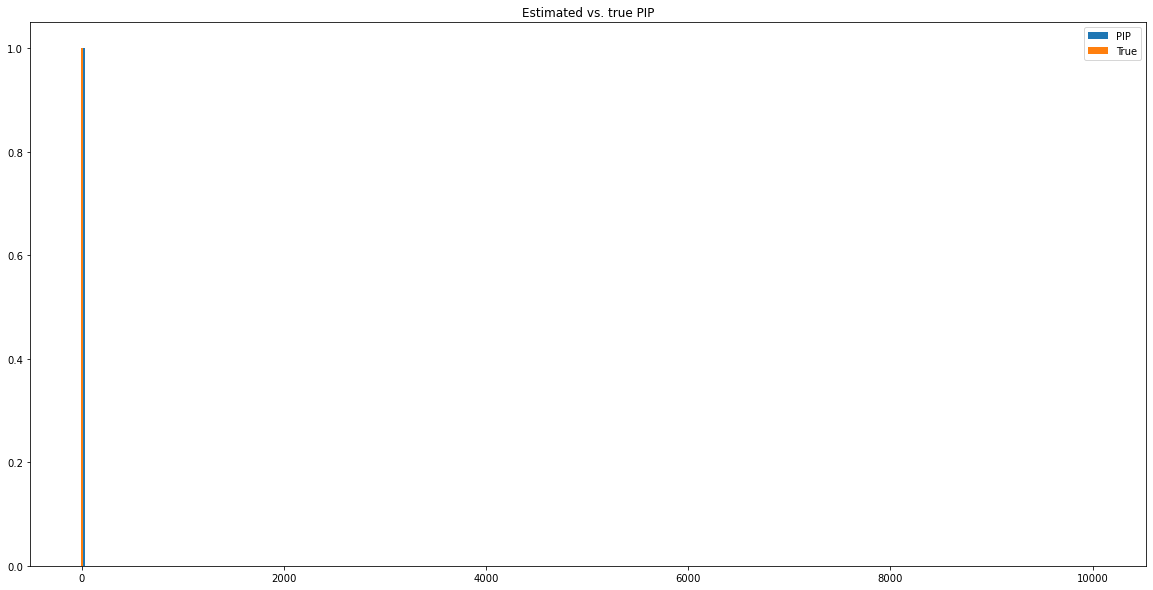

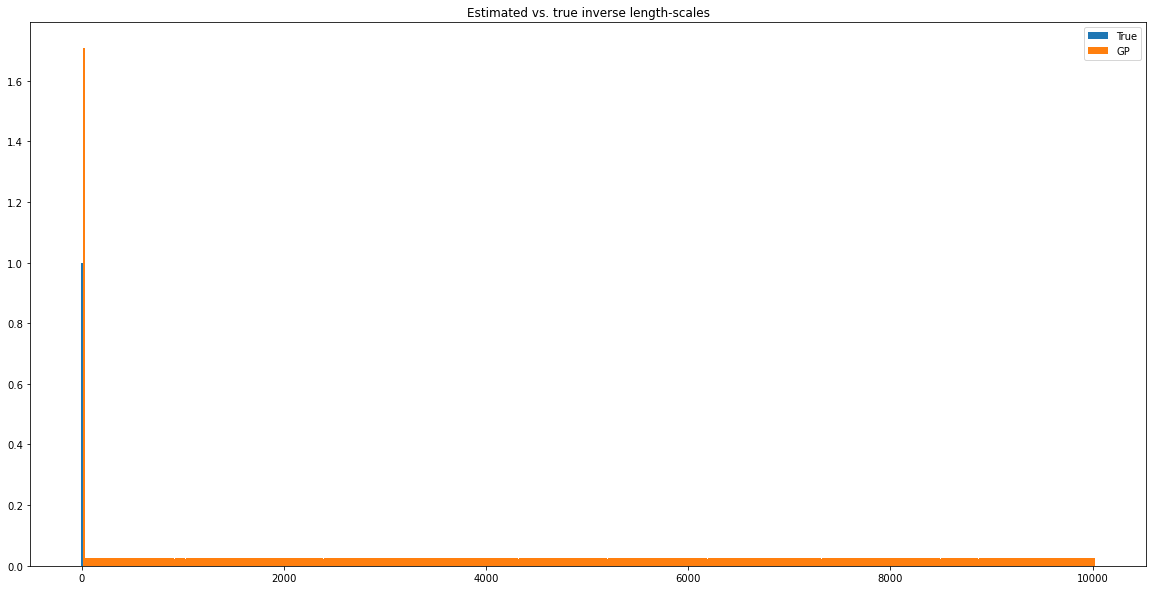

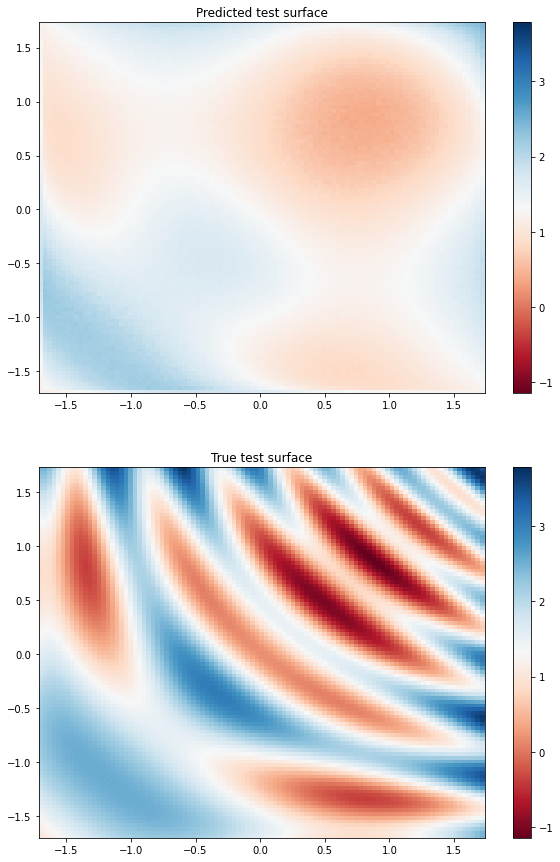

Latent test function MSE :  0.50709045
Observed test data  MSE :  0.8104828


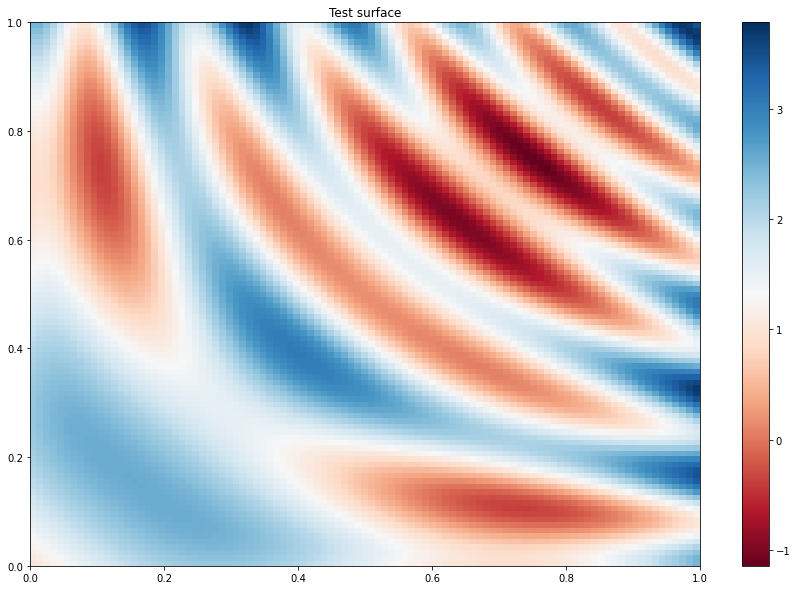

[20.894108 20.894047 20.894094 20.894108 20.894085 20.894165 20.894024
 20.894129 20.894056 20.894094]
3.069154977798462 0.00022947104
Iter 2 - Loss: 3.069
[20.993948 20.993834 20.993877 20.993935 20.993904 20.994053 20.993757
 20.993992 20.99385  20.993902]
3.0656953549385073 0.00022756975
Iter 3 - Loss: 2.723
[21.093472 21.09346  21.093828 21.09393  21.093857 21.093788 21.093662
 21.093727 21.093819 21.0939  ]
3.0595742695569994 0.00022532744
Iter 4 - Loss: 2.454
[21.191961 21.192036 21.193377 21.193674 21.19356  21.192553 21.193289
 21.192719 21.193607 21.19368 ]
3.0514980366537574 0.00022183864
Iter 5 - Loss: 2.252
[21.288702 21.288645 21.291698 21.29242  21.292274 21.289547 21.291878
 21.290209 21.292479 21.292524]
3.0419566600126533 0.00021673062
Iter 6 - Loss: 2.097
[21.383036 21.38246  21.387966 21.389364 21.389145 21.384033 21.388592
 21.385427 21.38959  21.389742]
3.031289825927862 0.00021004953
Iter 7 - Loss: 1.975
[21.474312 21.472744 21.481455 21.483791 21.483387 21.475388

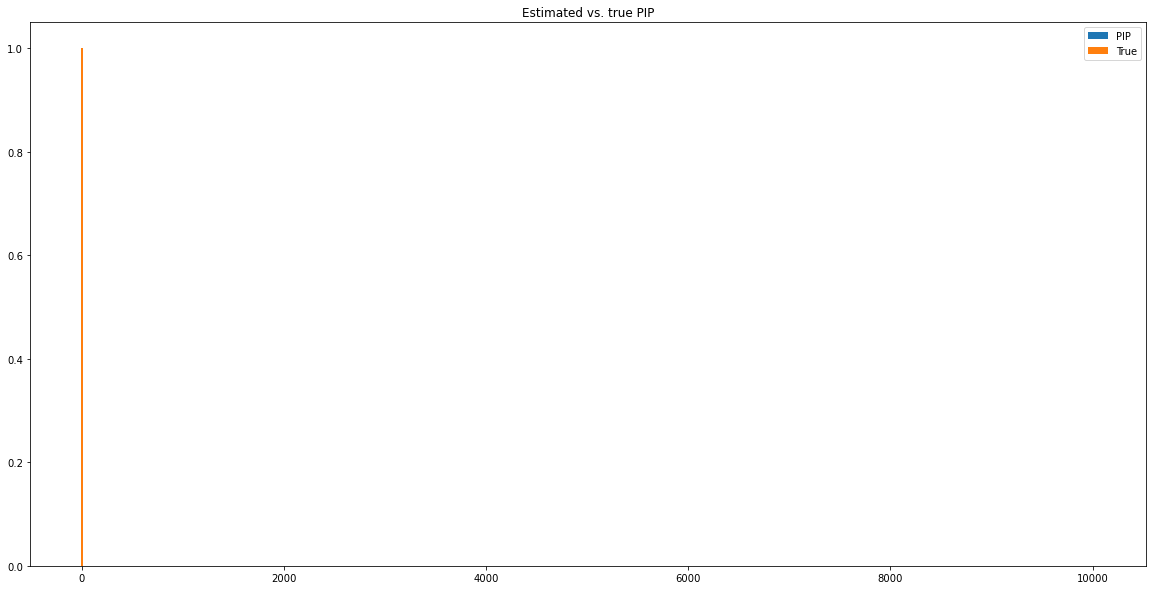

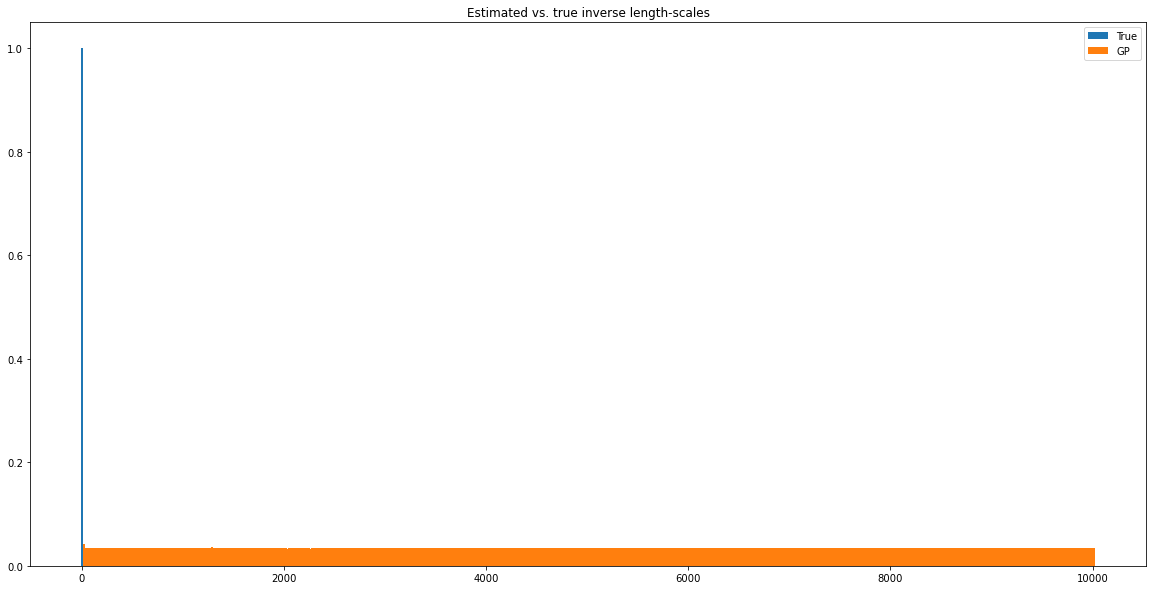

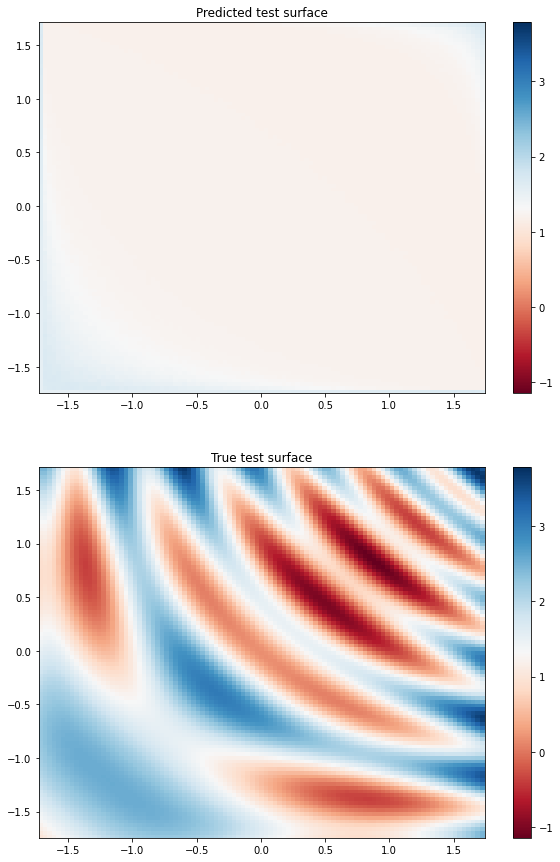

Latent test function MSE :  0.85765594
Observed test data  MSE :  1.1584107


[20.891275 20.892366 20.889565 20.889349 20.892996 20.89324  20.889797
 20.890976 20.890696 20.892893]
2.8952572345733643 0.00022346921


[20.995901 20.995842 20.990534 20.989985 20.998783 20.999418 20.994616
 20.994694 20.993282 20.995598]
2.89105171918869 0.00023769989


[21.10287  21.102156 21.099232 21.095957 21.108477 21.10884  21.104235
 21.100605 21.099024 21.102535]
2.885132873558998 0.00024279217


[21.207779 21.207113 21.208294 21.204739 21.219648 21.217596 21.213575
 21.207138 21.205566 21.211428]
2.8785644480178356 0.00023994753


[21.309183 21.3108   21.316353 21.311575 21.32886  21.32472  21.321566
 21.310575 21.312637 21.318853]
2.8701451670630482 0.00023395992


[21.40551  21.405674 21.420816 21.411465 21.433184 21.42494  21.42277
 21.408133 21.413414 21.419598]
2.8602736070740886 0.00021849498


[21.493498 21.495779 21.517445 21.505592 21.530174 21.519402 21.520618
 21.500994 21.507036 21.517551]
2.850364291890341 0.00020328112


[21.575357 21.57352  21.610985 21.597351 21.619802 21.608505 21.610754
 21.585108 21.598038 21.606115]
2.8402020257529013 0.00018959344


[21.647587 21.647299 21.696915 21.683817 21.70551  21.691109 21.691565
 21.663296 21.680355 21.691578]
2.8304933190940047 0.00017539582


[21.714151 21.713324 21.77706  21.759659 21.785265 21.768248 21.76839
 21.737906 21.757616 21.771887]
2.8197685326926156 0.00016205932


[21.777899 21.775288 21.851711 21.831457 21.860512 21.84179  21.843443
 21.807646 21.831951 21.844948]
2.808414514396024 0.00015173273


[21.834673 21.828135 21.922789 21.903158 21.931995 21.910969 21.911999
 21.874496 21.90131  21.914476]
2.797298242825367 0.00014155231


[21.886803 21.878664 21.989985 21.970335 21.999283 21.976206 21.975927
 21.934807 21.96674  21.980331]
2.7857837645970953 0.00013254072


[21.934872 21.924467 22.053988 22.029692 22.059008 22.036055 22.035198
 21.994013 22.028069 22.043114]
2.7743862037932416 0.00012332792


[21.978165 21.965708 22.11286  22.088242 22.119797 22.09297  22.093973
 22.04933  22.08399  22.100864]
2.7629769422039177 0.00011770198


[22.01712  21.997746 22.169077 22.143574 22.176735 22.14789  22.146624
 22.10124  22.139036 22.155455]
2.7515822358578976 0.00010895436


[22.053993 22.031307 22.22283  22.197643 22.22961  22.199335 22.196173
 22.15181  22.1889   22.209932]
2.7402514885439504 0.00010425894


[22.088053 22.059519 22.274687 22.247839 22.281633 22.249298 22.247051
 22.19996  22.240273 22.261038]
2.7291575030354944 9.9934565e-05


[22.118822 22.082113 22.32519  22.29714  22.329292 22.297009 22.29393
 22.246374 22.289684 22.310158]
2.7176598559130833 9.498118e-05


[22.147526 22.105501 22.37355  22.345627 22.377756 22.342669 22.339584
 22.291227 22.336176 22.356672]
2.7061904974586275 9.267937e-05


[22.174082 22.125975 22.420805 22.392408 22.422958 22.389486 22.382847
 22.335007 22.383736 22.401815]
2.695019332640215 8.829605e-05


[22.200096 22.147665 22.466682 22.438082 22.466896 22.43176  22.425755
 22.37753  22.427526 22.445852]
2.6840561791182718 8.502314e-05


[22.223965 22.164183 22.509523 22.482117 22.51001  22.472952 22.466621
 22.419024 22.46945  22.486963]
2.6732128745597548 8.189636e-05


[22.246193 22.184448 22.553846 22.524609 22.552378 22.51545  22.507368
 22.458797 22.512215 22.529951]
2.6624352498272184 8.085349e-05


[22.26852  22.196875 22.596592 22.568665 22.594599 22.555517 22.54606
 22.498652 22.5527   22.571114]
2.6514963578964204 7.8984274e-05


[22.28861  22.207561 22.636986 22.608992 22.634768 22.594448 22.58308
 22.536793 22.593529 22.609241]
2.6405094521311003 7.565822e-05


[22.307798 22.221758 22.676975 22.650385 22.674578 22.633423 22.62204
 22.57478  22.632582 22.648859]
2.6296689447260304 7.483526e-05


[22.32867  22.231728 22.71698  22.690052 22.71403  22.67108  22.657928
 22.610485 22.670675 22.686798]
2.619341344548408 7.371006e-05


[22.34574  22.24033  22.756655 22.727875 22.751923 22.708172 22.69566
 22.648226 22.707783 22.724598]
2.6088346087972445 7.160428e-05


[22.363092 22.2503   22.794407 22.765535 22.789164 22.745424 22.732367
 22.68485  22.74596  22.760977]
2.598099386850965 6.9857706e-05


[22.378984 22.261366 22.83486  22.80474  22.827454 22.782204 22.767632
 22.720358 22.783163 22.798203]
2.5872213850402552 6.943613e-05


[22.396498 22.270964 22.872692 22.84263  22.864801 22.818756 22.802704
 22.756783 22.820122 22.833998]
2.5771827087684356 6.9175505e-05


[22.41202  22.279627 22.909262 22.880932 22.901447 22.855227 22.837236
 22.79305  22.85641  22.870562]
2.566934677762294 6.88542e-05


[22.427984 22.287117 22.94606  22.917662 22.936502 22.889608 22.8717
 22.827229 22.892323 22.905218]
2.55666127867945 6.631646e-05


[22.444914 22.297955 22.985575 22.955605 22.973059 22.92576  22.907343
 22.863495 22.928843 22.941349]
2.546542096503312 6.7828354e-05


[22.460363 22.306744 23.02116  22.992283 23.008875 22.96112  22.94039
 22.89828  22.964464 22.97567 ]
2.536441446427561 6.574134e-05


[22.477612 22.315735 23.057465 23.029453 23.044643 22.995865 22.973518
 22.933445 23.00093  23.010937]
2.526537918918547 6.575998e-05


[22.492584 22.320753 23.093203 23.064901 23.08012  23.031168 23.007698
 22.967186 23.035826 23.045368]
2.5166997929756687 6.5385175e-05


[22.507677 22.331038 23.130138 23.10124  23.114784 23.065878 23.04191
 23.00278  23.07155  23.08057 ]
2.506857117031157 6.511159e-05


[22.524988 22.338835 23.165077 23.138823 23.151106 23.101341 23.075785
 23.03823  23.109009 23.115639]
2.496938034309942 6.515485e-05


[22.539717 22.34698  23.201056 23.174706 23.187428 23.135942 23.108913
 23.072096 23.144026 23.149704]
2.4874225421447145 6.415308e-05


[22.555494 22.35471  23.23711  23.21046  23.221855 23.170507 23.143402
 23.10685  23.179184 23.183779]
2.477873606687943 6.4048894e-05


[22.571302 22.362457 23.273487 23.24563  23.25663  23.205614 23.176304
 23.142357 23.214985 23.218334]
2.468601424270966 6.414895e-05


[22.58779  22.37203  23.309568 23.283058 23.29157  23.240332 23.21038
 23.176943 23.251516 23.25243 ]
2.459025652395047 6.375803e-05


[22.604296 22.378273 23.343979 23.318144 23.32655  23.274778 23.244164
 23.210836 23.285378 23.28724 ]
2.449649365817004 6.2318846e-05


[22.621319 22.389076 23.380684 23.355503 23.362236 23.309668 23.27996
 23.245562 23.321775 23.32162 ]
2.4400664037006585 6.4236054e-05


[22.63726  22.398882 23.415342 23.389713 23.397081 23.34465  23.312527
 23.280973 23.354988 23.356077]
2.431214760430864 6.226957e-05


[22.654152 22.406536 23.449627 23.426289 23.432161 23.379372 23.34593
 23.314606 23.391272 23.390593]
2.4224228385898763 6.249794e-05


[22.670025 22.414667 23.484055 23.462774 23.467348 23.414387 23.378796
 23.34886  23.42633  23.42356 ]
2.413208890813108 6.257309e-05


[22.687044 22.423012 23.51936  23.497906 23.50348  23.449223 23.412626
 23.384563 23.461866 23.458101]
2.4044999972670684 6.265297e-05


[22.704588 22.432032 23.555817 23.533749 23.53849  23.484789 23.447456
 23.41934  23.496784 23.491983]
2.395636102431269 6.2448904e-05


[22.722769 22.443745 23.592123 23.570524 23.574898 23.519968 23.482475
 23.454655 23.533077 23.527636]
2.3868913617377667 6.32536e-05


[22.739527 22.449968 23.627354 23.605959 23.610153 23.554087 23.515465
 23.48991  23.568338 23.562378]
2.378262256679807 6.2564286e-05


[22.754309 22.457375 23.66158  23.640812 23.645247 23.58878  23.550402
 23.524187 23.604275 23.595703]
2.3694929640957665 6.151661e-05


[22.772167 22.466745 23.697603 23.677166 23.680733 23.624086 23.585096
 23.559555 23.6405   23.631485]
2.361271832968221 6.32411e-05


[22.790262 22.477388 23.73317  23.714407 23.715712 23.659958 23.619516
 23.595133 23.677073 23.665901]
2.3529210663234905 6.190291e-05


[22.807257 22.48563  23.769749 23.75165  23.75305  23.69564  23.654322
 23.630629 23.712585 23.700748]
2.344613542023476 6.2981846e-05


[22.823648 22.497244 23.804684 23.787392 23.789175 23.73212  23.690544
 23.667938 23.749975 23.735876]
2.336559358402634 6.3108215e-05


[22.844362 22.50548  23.840586 23.823013 23.825249 23.767393 23.726524
 23.702816 23.784977 23.77046 ]
2.3281146122345318 6.162667e-05


[22.862038 22.51603  23.875738 23.859804 23.861843 23.802563 23.76039
 23.738274 23.821716 23.806671]
2.3201541331406137 6.273592e-05


[22.880354 22.52138  23.911745 23.897966 23.897373 23.837383 23.796316
 23.77391  23.858202 23.84131 ]
2.312027654322559 6.2194886e-05


[22.89675  22.533321 23.949297 23.935383 23.933907 23.873957 23.83137
 23.809732 23.893827 23.877676]
2.304232484161703 6.3313244e-05


[22.915792 22.541779 23.985325 23.973047 23.969843 23.91015  23.865585
 23.846945 23.930227 23.913223]
2.2965623331062495 6.246212e-05


[22.933897 22.552822 24.023424 24.010298 24.006876 23.947718 23.90115
 23.883528 23.967415 23.94881 ]
2.288740819501139 6.365256e-05


[22.952826 22.565117 24.059113 24.048323 24.04294  23.983942 23.936104
 23.91907  24.005346 23.985155]
2.281209570516333 6.272343e-05


[22.96932  22.572594 24.096334 24.085684 24.080194 24.020283 23.97323
 23.955805 24.042868 24.019276]
2.273386630342099 6.239657e-05


[22.987854 22.58561  24.131733 24.123713 24.117981 24.056688 24.00875
 23.992523 24.08032  24.056387]
2.265486464695569 6.267301e-05


[23.005962 22.595732 24.168839 24.1613   24.155    24.093973 24.044542
 24.02959  24.118727 24.092344]
2.258068547585082 6.329263e-05


[23.023277 22.60342  24.205704 24.198378 24.192835 24.13118  24.081264
 24.067125 24.156044 24.12983 ]
2.2507615249147883 6.299192e-05


[23.040184 22.616566 24.243881 24.237211 24.231054 24.168673 24.11782
 24.105171 24.193125 24.166111]
2.2433290890040958 6.374875e-05


[23.060673 22.625656 24.280575 24.274591 24.267702 24.206442 24.154404
 24.14132  24.230747 24.203253]
2.236242668536418 6.344824e-05


[23.079002 22.636614 24.31812  24.313696 24.305445 24.243414 24.192238
 24.179    24.268944 24.239754]
2.2294147918026073 6.316192e-05


[23.0989   22.6448   24.355812 24.353437 24.34434  24.281975 24.229479
 24.216805 24.308756 24.276516]
2.2221268105811296 6.401404e-05


[23.11751  22.654757 24.395163 24.391869 24.3836   24.31933  24.26743
 24.254896 24.347902 24.31389 ]
2.2149094263139717 6.42957e-05


[23.13516  22.666399 24.433546 24.432446 24.421755 24.357687 24.304918
 24.293049 24.386597 24.350878]
2.208022200289281 6.387129e-05


[23.154144 22.674438 24.471903 24.471292 24.459044 24.396551 24.342253
 24.331549 24.426811 24.388885]
2.2007996412025714 6.366369e-05


[23.172941 22.685804 24.50983  24.510475 24.499107 24.4346   24.380386
 24.369905 24.466278 24.42736 ]
2.1939739300993835 6.418288e-05


[23.192228 22.697592 24.548609 24.549994 24.537956 24.47336  24.417788
 24.408314 24.505323 24.465084]
2.1872979508882637 6.3666994e-05


[23.212477 22.71117  24.58802  24.589941 24.577656 24.512905 24.45681
 24.44733  24.546204 24.502548]
2.1801534483805716 6.5274755e-05


[23.231554 22.720482 24.627487 24.631136 24.617847 24.55257  24.496073
 24.486725 24.587461 24.541506]
2.173286636081901 6.498774e-05


[23.25329  22.73191  24.666893 24.670624 24.65886  24.592476 24.53708
 24.526592 24.627148 24.581997]
2.16658437909036 6.5292224e-05


[23.26963  22.742794 24.706484 24.71141  24.698807 24.630165 24.575382
 24.565943 24.667006 24.620289]
2.160621240682757 6.418782e-05


[23.289864 22.753044 24.746305 24.752144 24.738314 24.669477 24.614817
 24.605558 24.70786  24.658688]
2.1539484594244587 6.5008026e-05


[23.3105   22.763767 24.786076 24.79296  24.778204 24.710485 24.654568
 24.645033 24.749762 24.698414]
2.147749187413756 6.480764e-05


[23.32959  22.777172 24.826504 24.833364 24.818901 24.75065  24.695112
 24.685127 24.791166 24.737957]
2.141284160062934 6.5490676e-05


[23.347897 22.787481 24.865685 24.873148 24.859255 24.790535 24.734818
 24.724892 24.832397 24.776903]
2.1348714686660095 6.45713e-05


[23.36664  22.798159 24.905258 24.915667 24.901384 24.831072 24.775349
 24.765772 24.873737 24.81734 ]
2.128714256550455 6.550489e-05


[23.387136 22.809456 24.945618 24.95651  24.94189  24.872168 24.816702
 24.80594  24.914837 24.857832]
2.122647514079936 6.5504595e-05


[23.406626 22.821182 24.986412 24.997082 24.982775 24.913158 24.856981
 24.84767  24.955257 24.898075]
2.116529074741978 6.5351865e-05


[23.425009 22.831413 25.027292 25.039745 25.023289 24.953995 24.896347
 24.888575 24.99826  24.938469]
2.110327288070562 6.526005e-05


[23.445295 22.844332 25.069313 25.08071  25.06526  24.995417 24.937246
 24.92911  25.040144 24.978998]
2.103913560821265 6.5833556e-05


[23.464489 22.85017  25.112751 25.124634 25.10728  25.036858 24.98013
 24.971355 25.082136 25.02062 ]
2.09791661576481 6.61139e-05


[23.483307 22.862085 25.154387 25.165146 25.14993  25.078327 25.022448
 25.012629 25.125065 25.061068]
2.092054347428588 6.580904e-05


[23.503592 22.871515 25.196934 25.20765  25.19248  25.120575 25.063498
 25.054068 25.168945 25.103262]
2.0862858518268457 6.6543114e-05


[23.524115 22.880924 25.23875  25.251947 25.235304 25.163353 25.107424
 25.09842  25.213125 25.144323]
2.080376312142882 6.750548e-05


[23.54277  22.892504 25.279682 25.29459  25.277855 25.206343 25.150326
 25.140448 25.256384 25.187628]
2.0743424774768062 6.6149885e-05


[23.560751 22.903364 25.323484 25.337639 25.320282 25.248707 25.19288
 25.18311  25.299599 25.23044 ]
2.0684037783490106 6.675384e-05


[23.579369 22.912022 25.365171 25.380829 25.364592 25.289213 25.233955
 25.224998 25.342762 25.271755]
2.0629326245148003 6.567656e-05


[23.599941 22.924402 25.408077 25.425287 25.407923 25.33409  25.278505
 25.268349 25.388159 25.31431 ]
2.0572110469688405 6.794553e-05


[23.618748 22.932177 25.453234 25.46962  25.451672 25.377333 25.322243
 25.311455 25.43165  25.35672 ]
2.051848107079062 6.680466e-05


[23.635992 22.94043  25.495266 25.513575 25.496248 25.421597 25.366964
 25.354958 25.47607  25.400667]
2.046410824223756 6.73045e-05


[23.656519 22.95455  25.53898  25.559029 25.54137  25.46638  25.410461
 25.400074 25.519905 25.444275]
2.0406723224230165 6.834251e-05


[23.676388 22.963778 25.583408 25.604628 25.585985 25.510284 25.453762
 25.444195 25.565727 25.488827]
2.0348565813975017 6.7295354e-05


[23.695238 22.971941 25.629091 25.650362 25.630938 25.55448  25.497786
 25.48836  25.611809 25.532406]
2.0297722942338106 6.799733e-05


[23.71375  22.984842 25.672352 25.694906 25.67579  25.600101 25.54253
 25.532299 25.659042 25.577097]
2.0248134606519 6.80902e-05


[23.732527 22.994097 25.718033 25.739515 25.722002 25.645046 25.587816
 25.577084 25.706057 25.620995]
2.0196529401048293 6.8260386e-05


[23.751328 23.006542 25.760769 25.78602  25.766193 25.6878   25.633379
 25.621277 25.751112 25.66597 ]
2.0142255333043364 6.753723e-05


[23.770844 23.015703 25.80724  25.832819 25.812656 25.734026 25.67986
 25.667755 25.799246 25.710938]
2.0096930227585093 6.936515e-05


[23.788387 23.021181 25.852411 25.880814 25.858818 25.780315 25.725044
 25.713213 25.844784 25.75654 ]
2.0048672805516303 6.7890884e-05


[23.806278 23.03119  25.89864  25.925343 25.905193 25.82661  25.771008
 25.759127 25.89153  25.802824]
1.9999370362148183 6.902675e-05


[23.825869 23.038717 25.94284  25.972042 25.951464 25.872469 25.817017
 25.80426  25.938751 25.848589]
1.9948032108870788 6.8027686e-05


[23.845522 23.049635 25.990738 26.019836 25.999111 25.92026  25.864624
 25.850689 25.988087 25.894255]
1.9903057648587592 7.0125774e-05


[23.86416  23.062883 26.038185 26.06752  26.046988 25.96598  25.912739
 25.897173 26.035847 25.938902]
1.985354397645581 6.964469e-05


[23.881456 23.065016 26.08356  26.115982 26.09419  26.01227  25.961073
 25.944254 26.082779 25.986292]
1.9808519631738248 6.957037e-05


[23.90168  23.074697 26.130903 26.164627 26.140705 26.059473 26.008698
 25.991446 26.133532 26.03345 ]
1.9761955569797391 6.975147e-05


[23.91738  23.083225 26.17727  26.21096  26.189314 26.10584  26.053844
 26.037409 26.181206 26.078335]
1.9714576435394584 6.831188e-05


[23.935356 23.092793 26.224749 26.258135 26.237694 26.153975 26.103943
 26.084728 26.230991 26.12678 ]
1.9668211611096487 7.0505484e-05


[23.952911 23.102385 26.273365 26.3069   26.286673 26.20375  26.152624
 26.133358 26.280087 26.173668]
1.9623138546213093 7.084637e-05


[23.969818 23.10723  26.320068 26.35567  26.335257 26.251215 26.200878
 26.180487 26.329735 26.222319]
1.9575756922237015 6.90804e-05


[23.985577 23.113417 26.368013 26.404446 26.38396  26.29959  26.249804
 26.226252 26.379652 26.269825]
1.953157218846005 6.873484e-05


[24.003693 23.121544 26.417715 26.45387  26.433804 26.349045 26.301031
 26.276089 26.430237 26.318716]
1.949400689429838 7.1313225e-05


[24.02144  23.132349 26.467623 26.50569  26.483631 26.398973 26.351301
 26.326477 26.480328 26.368727]
1.9449666221584185 7.184516e-05


[24.040113 23.142736 26.517153 26.556839 26.534685 26.450054 26.403292
 26.376608 26.531876 26.419382]
1.9404093850502224 7.2043505e-05


[24.05615  23.14577  26.566614 26.607153 26.584978 26.499266 26.453903
 26.426596 26.584896 26.467457]
1.9359957043886544 7.1335984e-05


[24.07393  23.156101 26.619583 26.658304 26.635433 26.549442 26.505873
 26.476189 26.637094 26.517437]
1.9314178875997423 7.1802075e-05


[24.089417 23.161175 26.669004 26.70874  26.68514  26.599411 26.557375
 26.526041 26.688276 26.568367]
1.9270222601687523 7.045108e-05


[24.10404  23.16377  26.719606 26.76129  26.736748 26.649748 26.608873
 26.576876 26.739622 26.61853 ]
1.9224438291014885 7.189806e-05


[24.118992 23.170103 26.771069 26.812145 26.789093 26.702795 26.661953
 26.626688 26.793749 26.669914]
1.9183947190651733 7.232982e-05


[24.133244 23.172049 26.821592 26.865482 26.840422 26.754684 26.715872
 26.677351 26.845932 26.718311]
1.91428143198881 7.1348346e-05


[24.14819  23.17686  26.874372 26.917034 26.892548 26.805418 26.767982
 26.728565 26.899546 26.772251]
1.910434288893516 7.2103925e-05


[24.162325 23.177893 26.92631  26.971203 26.944777 26.857454 26.819508
 26.780998 26.954899 26.822922]
1.906230277501773 7.2663446e-05


[24.175045 23.181023 26.976856 27.023687 26.999405 26.908895 26.8737
 26.832712 27.008375 26.875423]
1.9024017679854224 7.2394454e-05


[24.18892  23.185919 27.031183 27.07787  27.052921 26.961727 26.929588
 26.885237 27.064823 26.92934 ]
1.897997726587688 7.414334e-05


[24.202093 23.187855 27.08382  27.131536 27.10611  27.014591 26.983456
 26.938574 27.120417 26.982023]
1.8941775112274812 7.2570554e-05


[24.216703 23.190945 27.136425 27.186056 27.160652 27.069216 27.036304
 26.992092 27.176378 27.03395 ]
1.890629538042773 7.3054325e-05


[24.229782 23.190979 27.19105  27.241337 27.21616  27.12279  27.089737
 27.044085 27.231184 27.088017]
1.8866052552680121 7.356816e-05


[24.241085 23.192467 27.244675 27.295113 27.270771 27.177752 27.146704
 27.096825 27.286919 27.143536]
1.8826018736137695 7.393001e-05


[24.252123 23.195484 27.299696 27.349829 27.327091 27.232643 27.203798
 27.152523 27.344263 27.198849]
1.8787487633744884 7.431685e-05


[24.263561 23.192917 27.353422 27.405247 27.381691 27.287222 27.25931
 27.206688 27.40005  27.251907]
1.875231355115057 7.343023e-05


[24.273811 23.187065 27.410124 27.461876 27.437227 27.342232 27.315477
 27.260944 27.456343 27.306389]
1.8715450727814815 7.399911e-05


[24.282736 23.18217  27.467169 27.518452 27.49261  27.398312 27.371964
 27.31476  27.514444 27.361275]
1.867713252329393 7.408396e-05


[24.292698 23.176558 27.523502 27.576029 27.549568 27.453308 27.429935
 27.369886 27.572813 27.418407]
1.8638963814847946 7.532904e-05


[24.301445 23.178722 27.577599 27.6338   27.606527 27.510857 27.489496
 27.427168 27.631323 27.473633]
1.8602951033026525 7.502453e-05


[24.308025 23.166504 27.63283  27.690155 27.663006 27.567186 27.548676
 27.482563 27.68908  27.529882]
1.8566295101721528 7.3436495e-05


[24.31517  23.160288 27.689627 27.74696  27.7203   27.622644 27.605368
 27.537657 27.747105 27.585789]
1.852960987144177 7.431746e-05


[24.318916 23.150541 27.747272 27.804417 27.777    27.680696 27.663168
 27.5944   27.808113 27.643553]
1.8493574234057766 7.489025e-05


[24.327045 23.142601 27.80625  27.86399  27.836885 27.739773 27.722832
 27.651796 27.869638 27.700907]
1.8459622385588497 7.6935794e-05


[24.329557 23.134087 27.865677 27.921812 27.89621  27.7981   27.780634
 27.70923  27.931324 27.75939 ]
1.8422374482216775 7.546538e-05


[24.335657 23.123793 27.925583 27.98374  27.955322 27.85596  27.841682
 27.769476 27.992344 27.818277]
1.83887262560027 7.640191e-05


[24.337313 23.114433 27.984316 28.041584 28.015257 27.915133 27.90365
 27.826834 28.054914 27.877308]
1.8350630869758744 7.640539e-05


[24.338795 23.100168 28.04317  28.100756 28.075245 27.97327  27.96598
 27.884176 28.114883 27.936157]
1.8315070811499847 7.5764234e-05


[24.33977  23.085152 28.103786 28.161184 28.134867 28.033941 28.027802
 27.942167 28.176277 27.99673 ]
1.8284042934729454 7.636752e-05


[24.338762 23.072483 28.163813 28.224243 28.195358 28.095018 28.088318
 28.003288 28.239262 28.05609 ]
1.8255427699836353 7.7078425e-05


[24.338366 23.051582 28.226078 28.28536  28.257153 28.156305 28.151772
 28.062592 28.303984 28.116337]
1.822223694059922 7.764974e-05


[24.332441 23.030678 28.287628 28.346424 28.31804  28.21766  28.215736
 28.121061 28.368183 28.178102]
1.8185681981090076 7.646636e-05


[24.32518  23.012892 28.34942  28.406809 28.378996 28.277824 28.277508
 28.181068 28.428312 28.23837 ]
1.8155988321126435 7.5890166e-05


[24.3215   22.987083 28.411291 28.470644 28.441446 28.33962  28.342407
 28.241884 28.492147 28.301392]
1.81260864245561 7.77117e-05


[24.313778 22.963366 28.47307  28.532518 28.505049 28.402374 28.406725
 28.30393  28.559107 28.360981]
1.8094024378517326 7.762452e-05


[24.309658 22.933954 28.536238 28.596268 28.567863 28.466131 28.472303
 28.366518 28.623652 28.423382]
1.8063319406186011 7.8114106e-05


[24.298737 22.90326  28.596851 28.659824 28.63043  28.527397 28.537947
 28.428045 28.690945 28.48586 ]
1.802993051058225 7.678487e-05


[24.287518 22.870789 28.662056 28.72349  28.693989 28.592552 28.60069
 28.488993 28.753265 28.549744]
1.7999594489015247 7.7172044e-05


[24.271671 22.838583 28.727999 28.790108 28.760542 28.657166 28.669098
 28.552532 28.822104 28.61262 ]
1.7967883861546055 7.9429636e-05


[24.25893  22.791346 28.790659 28.852745 28.822834 28.719751 28.734108
 28.614187 28.886944 28.67579 ]
1.7935165794014427 7.6633834e-05


[24.245401 22.757685 28.853617 28.917242 28.889685 28.783413 28.800562
 28.67903  28.95732  28.742311]
1.7905891574428774 7.909553e-05


[24.222208 22.716301 28.918257 28.981148 28.955389 28.849617 28.866293
 28.741716 29.024271 28.805872]
1.787618232432627 7.833214e-05


[24.200619 22.665445 28.981224 29.048475 29.02182  28.913437 28.93607
 28.806967 29.090906 28.871569]
1.7848290454715363 7.832402e-05


[24.179123 22.627157 29.049618 29.11641  29.088436 28.978907 29.005177
 28.87018  29.160198 28.936354]
1.7821650490021876 7.9293284e-05


[24.157337 22.57943  29.11677  29.182098 29.155872 29.04565  29.071775
 28.936148 29.229197 29.002192]
1.7792605873949934 7.8654506e-05


[24.124474 22.517288 29.181974 29.248901 29.22081  29.112179 29.140186
 29.001278 29.297258 29.068687]
1.7763311411775682 7.8038196e-05


[24.09387  22.462425 29.250385 29.315958 29.289318 29.18012  29.209156
 29.068676 29.369204 29.134989]
1.7736177164692837 7.981366e-05


[24.056578 22.394432 29.315836 29.38348  29.357485 29.244585 29.279278
 29.132504 29.438053 29.200611]
1.770415571649409 7.805621e-05


[24.02312  22.334656 29.383429 29.452059 29.42516  29.312735 29.349102
 29.197618 29.506657 29.267984]
1.7674643391831133 7.916223e-05


[23.981335 22.262312 29.450636 29.51948  29.490995 29.380478 29.419043
 29.26114  29.577456 29.334137]
1.7648445880928416 7.824191e-05


[23.939718 22.201216 29.519285 29.588202 29.561438 29.44999  29.48798
 29.329346 29.647633 29.404543]
1.762355656162261 7.9957244e-05


[23.893349 22.115921 29.587128 29.65756  29.629389 29.517439 29.558205
 29.39404  29.719355 29.47234 ]
1.7596809325893774 7.748002e-05


[23.837715 22.032671 29.655325 29.72539  29.698324 29.58545  29.628796
 29.461895 29.789413 29.54075 ]
1.7570322171546273 7.925922e-05


[23.78974  21.940779 29.723621 29.795685 29.76875  29.656414 29.70134
 29.53167  29.861973 29.610842]
1.7539975068509859 7.9392645e-05


[23.734268 21.840887 29.794333 29.865738 29.837029 29.725346 29.771727
 29.599634 29.936537 29.679632]
1.7515092066253104 7.878921e-05


[23.664864 21.745184 29.866491 29.937885 29.908325 29.795954 29.842705
 29.667234 30.008553 29.748508]
1.7486880399397642 7.906606e-05


[23.601929 21.653748 29.932993 30.006777 29.978933 29.865238 29.914495
 29.733316 30.078852 29.817936]
1.7459164055025094 7.7559205e-05


[23.534342 21.540907 30.003048 30.078226 30.049915 29.933878 29.985739
 29.801619 30.152586 29.88852 ]
1.7438377586918234 7.848618e-05


[23.452679 21.421331 30.075964 30.150982 30.122324 30.003693 30.060484
 29.871483 30.22781  29.959648]
1.741067933980424 8.00944e-05


[23.370663 21.303305 30.146168 30.22238  30.194193 30.074972 30.132128
 29.9402   30.301706 30.029373]
1.7385580403252052 7.867317e-05


[23.279505 21.172432 30.217415 30.290863 30.26328  30.143995 30.202782
 30.008339 30.372738 30.098549]
1.7366097899295063 7.675248e-05


[23.186056 21.038614 30.28862  30.364975 30.33545  30.214085 30.276428
 30.079695 30.446503 30.170656]
1.7341372846262653 7.8940975e-05


[23.10287  20.912619 30.36019  30.43864  30.40798  30.287205 30.350435
 30.15039  30.520319 30.242973]
1.7318528318315773 8.03031e-05


[23.008274 20.752817 30.432482 30.512228 30.4806   30.357471 30.42211
 30.22071  30.593607 30.314787]
1.7295490425498217 7.7877055e-05


[22.89831  20.590303 30.50609  30.58559  30.551079 30.430841 30.497757
 30.290243 30.66666  30.385555]
1.7270873898718972 7.852163e-05


[22.78735  20.434141 30.579966 30.659134 30.627176 30.505095 30.57261
 30.361322 30.74473  30.455893]
1.7247425430327332 7.876718e-05


[22.663652 20.254505 30.652822 30.733152 30.698074 30.574793 30.645271
 30.431393 30.81994  30.528582]
1.7225170318461038 7.7174955e-05


[22.53877  20.0805   30.72396  30.806265 30.773905 30.646757 30.720999
 30.502678 30.895916 30.601177]
1.720106570952615 7.798456e-05


[22.406914 19.891539 30.795841 30.879057 30.847252 30.718525 30.795639
 30.57224  30.969913 30.671991]
1.7175996177823805 7.6557255e-05


[22.26037  19.713573 30.867113 30.953053 30.919075 30.790478 30.868088
 30.642937 31.045483 30.743156]
1.7150360936618994 7.768316e-05


[22.122316 19.50233  30.941042 31.028048 30.993868 30.86434  30.94557
 30.713575 31.119799 30.817453]
1.712762160375732 7.754735e-05


[21.964058 19.309404 31.017221 31.102488 31.067091 30.939133 31.019667
 30.78673  31.19923  30.890594]
1.7104327830098744 7.7722194e-05


[21.800087 19.102623 31.090595 31.179302 31.144335 31.011934 31.095
 30.85799  31.27597  30.965351]
1.7081506890951046 7.809203e-05


[21.625227 18.88841  31.16324  31.255182 31.217554 31.084517 31.171122
 30.929781 31.350769 31.041237]
1.7055438888539338 7.679681e-05


[21.445898 18.65391  31.238111 31.327976 31.29198  31.15629  31.247164
 30.999062 31.427927 31.113768]
1.7033839344128738 7.4394644e-05


[21.255228 18.41372  31.31041  31.40433  31.363535 31.229445 31.320082
 31.071842 31.502003 31.18605 ]
1.7011892638557478 7.535294e-05


[21.056198 18.180155 31.38437  31.47883  31.439857 31.302357 31.39681
 31.144484 31.57934  31.258577]
1.6992462896837583 7.586011e-05


[20.864847 17.951855 31.459785 31.556416 31.51176  31.37617  31.474894
 31.215708 31.657944 31.33197 ]
1.6973285865086767 7.5584205e-05


[20.649073 17.691786 31.53321  31.633503 31.586481 31.45053  31.547688
 31.286278 31.73358  31.406734]
1.6954344329620865 7.5481774e-05


[20.429674 17.4326   31.60805  31.708178 31.660818 31.522623 31.623186
 31.356627 31.809927 31.482718]
1.6932844280413402 7.471031e-05


[20.202677 17.18182  31.682919 31.785973 31.738298 31.59692  31.699408
 31.429365 31.88866  31.55623 ]
1.6909034867703416 7.5455e-05


[19.966755 16.899273 31.756105 31.859482 31.812962 31.668322 31.773727
 31.500214 31.960808 31.627518]
1.6888253380282028 7.214365e-05


[19.728987 16.637674 31.828932 31.933874 31.887238 31.740965 31.84835
 31.571653 32.036972 31.700285]
1.6866166107385425 7.406615e-05


[19.481852 16.36147  31.90473  32.01034  31.961424 31.817287 31.926643
 31.64482  32.116253 31.775995]
1.6848280963702775 7.438803e-05


[19.230797 16.080528 31.978659 32.08863  32.038666 31.891396 32.000393
 31.714516 32.19396  31.850485]
1.682609712285771 7.381289e-05


[18.970129 15.788797 32.05417  32.167393 32.112938 31.965347 32.074623
 31.788622 32.271896 31.924448]
1.6803435290365858 7.3067036e-05


[18.695654  15.4891815 32.127876  32.24068   32.187252  32.038624
 32.147144  31.85702   32.345562  31.995272 ]
1.6784241412544596 7.049545e-05


[18.417086  15.1795635 32.19953   32.317783  32.261032  32.11214
 32.224133  31.926613  32.420387  32.06807  ]
1.676488922468792 7.09225e-05


[18.136969 14.851948 32.272602 32.39196  32.33297  32.1809   32.299877
 31.998934 32.498116 32.138683]
1.6746411935167025 7.081243e-05


[17.847351 14.532981 32.347496 32.46794  32.405403 32.255646 32.374657
 32.071205 32.572384 32.212845]
1.6729770979801561 7.1399925e-05


[17.554306 14.236122 32.419205 32.540916 32.477028 32.326313 32.451847
 32.14344  32.64679  32.28554 ]
1.670969835192417 7.0506365e-05


[17.248924 13.906156 32.494293 32.61802  32.55288  32.399998 32.5231
 32.211018 32.725662 32.35734 ]
1.6694238398052754 7.049094e-05


[16.937319 13.578432 32.567238 32.692978 32.62339  32.469112 32.59304
 32.283047 32.79697  32.428833]
1.667512255454235 6.883476e-05


[16.628933 13.230143 32.638798 32.76759  32.697487 32.54223  32.665443
 32.350716 32.873096 32.50045 ]
1.665571496455601 6.764511e-05


[16.311972 12.891    32.71098  32.843136 32.774265 32.614758 32.735344
 32.418785 32.94802  32.572784]
1.663464976065401 6.801277e-05


[15.991163 12.555507 32.784214 32.916557 32.845463 32.68678  32.80924
 32.48893  33.02191  32.643265]
1.661834923014952 6.7775574e-05


[15.663151 12.204922 32.85582  32.990906 32.916836 32.757103 32.88059
 32.56051  33.098164 32.718075]
1.6600250187616092 6.788754e-05


[15.335065 11.847995 32.92778  33.066822 32.992386 32.829044 32.950706
 32.630608 33.170784 32.789948]
1.6583138514826234 6.7055145e-05


[14.999521 11.483559 33.00267  33.145546 33.067123 32.9013   33.027008
 32.703716 33.2468   32.859962]
1.6567927685555657 6.872651e-05


[14.656274 11.110116 33.074234 33.218117 33.137794 32.97146  33.09902
 32.77258  33.319935 32.930737]
1.6549400427247158 6.607554e-05


[14.322586  10.7278385 33.1489    33.291695  33.20988   33.04263
 33.174263  32.842747  33.393215  33.003887 ]
1.653578444612227 6.7019144e-05


[13.983671 10.353786 33.220737 33.367496 33.282917 33.113102 33.245304
 32.911476 33.470455 33.075134]
1.651704376388868 6.622078e-05


[13.624744  9.954626 33.291843 33.441895 33.3543   33.184093 33.31276
 32.977093 33.54458  33.14367 ]
1.6499451315351203 6.4343905e-05


[13.272262  9.558022 33.366074 33.51623  33.427036 33.25299  33.38571
 33.045174 33.61736  33.214222]
1.6481858492680785 6.4045875e-05


[12.90998    9.1583805 33.436596  33.58993   33.499157  33.32385
 33.45379   33.112812  33.68941   33.283283 ]
1.646464673358253 6.41422e-05


[12.553188   8.7673235 33.508617  33.667446  33.572388  33.39489
 33.52708   33.18174   33.76254   33.35524  ]
1.6450484601669222 6.6036526e-05


[12.182157  8.345485 33.57815  33.73884  33.640614 33.46363  33.594406
 33.248875 33.834866 33.42229 ]
1.643313675714789 6.190951e-05


[11.808486   7.9113007 33.64922   33.815327  33.710945  33.5327
 33.665806  33.318264  33.909607  33.490116 ]
1.641785097616241 6.3424246e-05


[11.439072   7.4773345 33.7215    33.885864  33.77776   33.60127
 33.735497  33.383347  33.97956   33.56086  ]
1.6404224643829985 6.192407e-05


[11.058759   7.0300303 33.792168  33.960506  33.850204  33.667675
 33.802845  33.44929   34.053112  33.628086 ]
1.6389680085208305 6.261083e-05


[10.669312   6.5629964 33.86071   34.03297   33.921005  33.73753
 33.876953  33.514515  34.126225  33.69497  ]
1.6374397500207052 6.208626e-05


[10.274223  6.103789 33.93078  34.108288 33.991814 33.808205 33.942654
 33.583084 34.199116 33.764492]
1.6360188477845514 6.299312e-05


[ 9.870478  5.626183 34.00237  34.180305 34.05947  33.875175 34.013058
 33.648838 34.26807  33.833138]
1.6341783543502697 6.153957e-05


[ 9.477346  5.147885 34.075306 34.255177 34.13011  33.944546 34.085262
 33.719692 34.340244 33.90103 ]
1.6327019131853833 6.313534e-05


[ 9.068164   4.6303973 34.146137  34.328743  34.202717  34.01556
 34.15022   33.78446   34.409683  33.970512 ]
1.6315273412771927 6.254745e-05


[ 8.643155   4.1067634 34.21523   34.403328  34.273888  34.083317
 34.222733  33.85253   34.484325  34.040867 ]
1.6299625818948773 6.4316366e-05


[ 8.203683   3.5759156 34.28826   34.47784   34.34725   34.154987
 34.294895  33.919075  34.556328  34.11246  ]
1.6284982410242776 6.553043e-05


[ 7.757332   3.0299976 34.361675  34.55322   34.41925   34.22672
 34.370106  33.988163  34.634003  34.182957 ]
1.6270773445267392 6.708156e-05


[ 7.2927184  2.4747376 34.436855  34.632137  34.49253   34.296364
 34.44402   34.058662  34.703796  34.25487  ]
1.6257915030272727 6.9384696e-05


[ 6.812472   1.9398042 34.511383  34.70735   34.565178  34.36967
 34.51764   34.128098  34.777508  34.327778 ]
1.6245231834102078 7.3900905e-05


[ 6.331885   1.4345796 34.58691   34.7904    34.644142  34.446777
 34.59646   34.20305   34.857986  34.40069  ]
1.6227267194765727 8.49517e-05


[ 5.855854   1.0059959 34.6734    34.87991   34.731895  34.532265
 34.690086  34.290447  34.945515  34.488235 ]
1.6212539622076494 0.00010484052


[ 5.4297066   0.71372885 34.769863   34.97354    34.832863   34.629288
 34.7961     34.388073   35.043964   34.587986  ]
1.6200032624998948 0.00012469136


[ 5.065294    0.65220726 34.883354   35.082027   34.9466     34.738674
 34.915512   34.498604   35.157448   34.70068   ]
1.6184769409363735 0.00010846441


[ 4.685872   0.6715078 35.003544  35.199833  35.06705   34.854084
 35.05225   34.621265  35.280464  34.8184   ]
1.617170932103258 0.000106595806


[ 4.251474   0.6566158 35.13052   35.322952  35.195095  34.97781
 35.192513  34.74947   35.405823  34.944218 ]
1.6160467169552752 0.000110821675


[ 3.7611191  0.6185652 35.261337  35.450386  35.32511   35.104664
 35.33675   34.881496  35.537243  35.076042 ]
1.6143523566773545 0.00012092363


[ 3.2512174  0.6179259 35.39749   35.579136  35.462772  35.236732
 35.488155  35.019337  35.676918  35.208393 ]
1.6129413942220312 0.00011577439


[ 2.7025042   0.60939777 35.53864    35.718678   35.604946   35.377083
 35.64566    35.162727   35.821133   35.34847   ]
1.6115171566332656 0.0001244784


[ 2.1487951  0.6154126 35.686577  35.861168  35.753914  35.520443
 35.810383  35.31181   35.97078   35.493896 ]
1.6103578859744494 0.00012941724


[ 1.6149589   0.61942554 35.84107    36.009094   35.906414   35.67078
 35.982567   35.468002   36.124165   35.645405  ]
1.608416139447316 0.00013975987


[ 1.143597    0.65660614 36.000645   36.160316   36.065998   35.826645
 36.16176    35.6264     36.282825   35.803158  ]
1.6068065988719347 0.00016141318


[ 0.8230668  0.7096353 36.169296  36.321396  36.23754   35.988033
 36.34736   35.800953  36.451828  35.969456 ]
1.6052001634660247 0.00017922306


[ 0.74453473  0.7771407  36.3481     36.489655   36.41678    36.15992
 36.544666   35.981197   36.63222    36.146088  ]
1.60344335121201 0.00016415933


[ 0.7339886   0.78378874 36.531425   36.661747   36.599804   36.33681
 36.74582    36.16703    36.814945   36.323853  ]
1.6018420489178467 0.00014422297


[ 0.7366005  0.7530497 36.719154  36.841507  36.790684  36.519657
 36.957966  36.35785   37.00427   36.509495 ]
1.5998858256370727 0.00015043229


[ 0.72765744  0.7351086  36.911903   37.02269    36.981323   36.706184
 37.16881    36.55052    37.193073   36.698956  ]
1.5985055882531995 0.00014959023


[ 0.71208787  0.71992785 37.10868    37.210808   37.178974   36.899826
 37.38604    36.753613   37.394016   36.89191   ]
1.596673300028901 0.00015399125


[ 0.7088166   0.70614237 37.304916   37.3977     37.37396    37.087852
 37.606068   36.953697   37.592396   37.085434  ]
1.5951190416608751 0.00014950173


[ 0.6909569  0.7047505 37.503773  37.587906  37.57783   37.283253
 37.825626  37.153255  37.791927  37.279404 ]
1.5935349452841834 0.00015098532


[ 0.6830372   0.69927883 37.707146   37.778336   37.78358    37.477604
 38.041817   37.355682   37.987385   37.476974  ]
1.5920244014725158 0.00014852308


[ 0.6711374   0.69398767 37.9134     37.97701    37.991352   37.679268
 38.27057    37.56351    38.200153   37.681305  ]
1.5904562239746667 0.00015125427


[ 0.6585984  0.6800253 38.122772  38.176777  38.20063   37.882282
 38.49494   37.76855   38.40932   37.882088 ]
1.5886295814565234 0.00015182266


[ 0.6644958   0.68680155 38.325127   38.370853   38.403038   38.08031
 38.710205   37.97434    38.61097    38.079063  ]
1.5869833228447932 0.00014389053


[ 0.64812803  0.6636428  38.525913   38.564674   38.60566    38.27899
 38.926315   38.179264   38.80957    38.279858  ]
1.5856392476443757 0.00014719095


[ 0.6428551  0.6716603 38.729202  38.75851   38.812847  38.473858
 39.14787   38.38113   39.012917  38.477043 ]
1.583384294167108 0.0001416365


[ 0.63613886  0.6763129  38.92771    38.953606   39.017345   38.67307
 39.366962   38.586548   39.212914   38.67565   ]
1.5815625137750278 0.0001384507


[ 0.63880235  0.65164894 39.123028   39.141163   39.215668   38.86591
 39.57467    38.78272    39.40629    38.869427  ]
1.579719449996683 0.00013684863


[ 0.62309784  0.64952415 39.31959    39.330647   39.414917   39.054665
 39.78523    38.9772     39.59712    39.06392   ]
1.5781127195164915 0.00013323771


[ 0.6343754  0.6450278 39.51009   39.520386  39.610126  39.241505
 39.98816   39.16963   39.788044  39.251007 ]
1.57607277917855 0.00012960387


[ 0.62561285  0.6535648  39.695538   39.70328    39.80076    39.42283
 40.18675    39.3605     39.973026   39.433086  ]
1.574215924353531 0.00012532876


[ 0.6131385  0.6437629 39.881916  39.88596   39.989014  39.603485
 40.380924  39.543915  40.152557  39.614952 ]
1.5723382417907512 0.00012458704


[ 0.60992455  0.63413894 40.061333   40.063885   40.173923   39.782093
 40.57671    39.730328   40.33677    39.79263   ]
1.5706312814061536 0.00011923502


[ 0.6127117  0.6325461 40.235695  40.236416  40.355118  39.95517
 40.767174  39.9054    40.5134    39.965717 ]
1.568767719379827 0.000112692534


[ 0.6013387  0.6286415 40.409775  40.409016  40.529953  40.127983
 40.95259   40.082516  40.685516  40.13951  ]
1.5671661980774472 0.0001131983


[ 0.6052681  0.6182716 40.57445   40.576275  40.70507   40.293972
 41.134117  40.254055  40.85211   40.306927 ]
1.565469348127465 0.000108916196


[ 0.59974134  0.6190669  40.74064    40.739056   40.877163   40.460228
 41.308384   40.42189    41.016933   40.471607  ]
1.563573226986202 0.00010415607


[ 0.5994409  0.6104244 40.901173  40.903122  41.04616   40.6223
 41.481804  40.591957  41.18344   40.634655 ]
1.5620034184071359 0.00010317635


[ 0.5922859   0.60077673 41.062775   41.06034    41.212788   40.777256
 41.653355   40.75257    41.34037    40.79358   ]
1.5601456365538446 0.000101168014


[ 0.590849  0.608974 41.21973  41.21536  41.372726 40.937668 41.82486
 40.91195  41.50333  40.95072 ]
1.5583366163112005 9.7876284e-05


[ 0.57882035  0.59849805 41.375164   41.366734   41.53276    41.089314
 41.9903     41.065365   41.65583    41.101395  ]
1.5564789970181294 9.8257384e-05


[ 0.5860328  0.598744  41.52478   41.514126  41.687096  41.237175
 42.14871   41.217102  41.807293  41.256474 ]
1.5550846605963795 9.082764e-05


[ 0.5858057  0.5887599 41.672794  41.66253   41.843792  41.379745
 42.305702  41.36749   41.954185  41.403896 ]
1.5532777915371077 8.9850735e-05


[ 0.56757367  0.5973609  41.818325   41.807827   41.99336    41.52706
 42.462738   41.513718   42.099586   41.551876  ]
1.5517867950472126 9.3792834e-05


[ 0.5689968  0.5919919 41.961117  41.954346  42.139866  41.671204
 42.61524   41.663166  42.246086  41.696693 ]
1.5497892048353117 8.640832e-05


[ 0.5667749  0.5895037 42.1023    42.096157  42.286224  41.80873
 42.769054  41.80731   42.38795   41.83861  ]
1.547897186371706 8.321476e-05


[ 0.5663755   0.57846534 42.23968    42.234215   42.431293   41.94537
 42.91541    41.947536   42.526978   41.97588   ]
1.5461244086703576 8.231587e-05


[ 0.5605646   0.58756745 42.37578    42.37056    42.571896   42.08057
 43.057915   42.085876   42.66367    42.1119    ]
1.544454999891729 8.2416824e-05


[ 0.5674729  0.5829891 42.51087   42.502842  42.710854  42.21431
 43.204834  42.22396   42.80066   42.24752  ]
1.5426842894619035 7.9711506e-05


[ 0.5569576  0.5774786 42.638012  42.633484  42.84788   42.345306
 43.343506  42.35955   42.929577  42.379124 ]
1.5408688240449302 7.8633224e-05


[ 0.5560475   0.56990534 42.7677     42.759354   42.98209    42.473663
 43.47977    42.48775    43.058453   42.507053  ]
1.5391737471688454 7.4470394e-05


[ 0.552943   0.5675219 42.895435  42.89423   43.114754  42.603447
 43.617077  42.617626  43.18951   42.645084 ]
1.5369713850977 7.428625e-05


[ 0.5475192   0.56518596 43.022408   43.023636   43.24853    42.73165
 43.755245   42.749012   43.320724   42.777042  ]
1.5350198700706519 7.331321e-05


[ 0.5416276  0.5585701 43.147354  43.148136  43.37775   42.852043
 43.88718   42.877506  43.44338   42.901516 ]
1.5331918993724936 7.231233e-05


[ 0.5430797   0.55987036 43.270638   43.271442   43.504276   42.97045
 44.01442    42.99962    43.568333   43.025032  ]
1.531773232732437 6.747654e-05


[ 0.5285829  0.5542114 43.392765  43.39801   43.63269   43.095547
 44.14301   43.1276    43.69409   43.150177 ]
1.5299323394706643 7.429002e-05


[ 0.5409214  0.5555954 43.512157  43.51947   43.757053  43.216908
 44.27249   43.252556  43.816288  43.27204  ]
1.5282836360596306 7.013617e-05
Runtime is  8794.117272138596
Test MSE: 0.7982085347175598
Latent test function MSE :  [0.50709045 0.4934465  0.         0.         0.        ]
Test time is :  [11.14253306 11.00236177  0.          0.          0.        ]


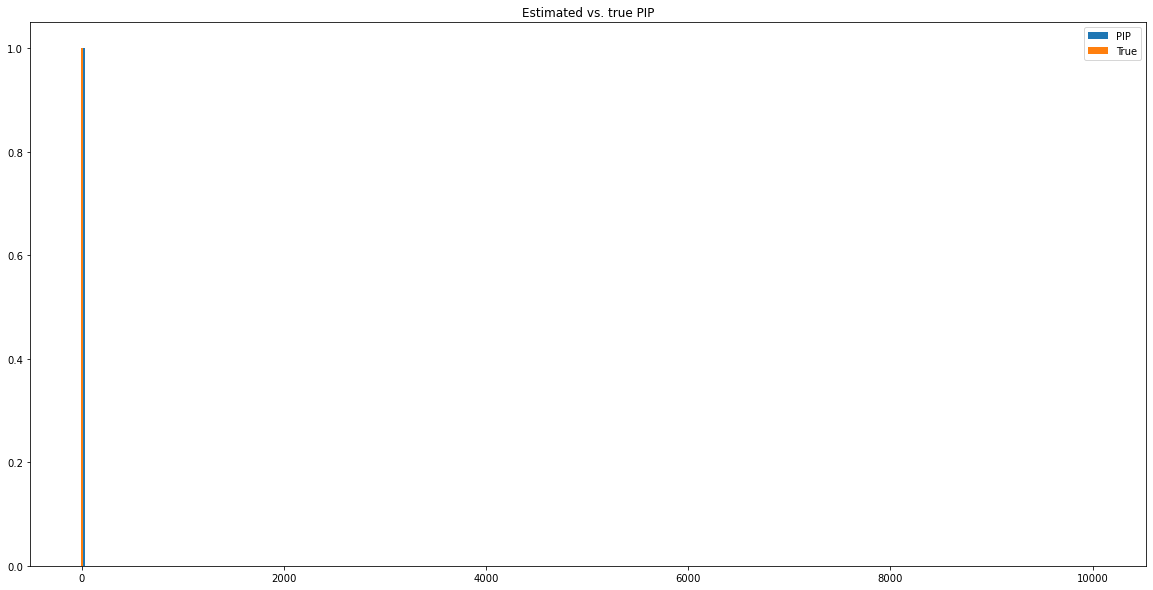

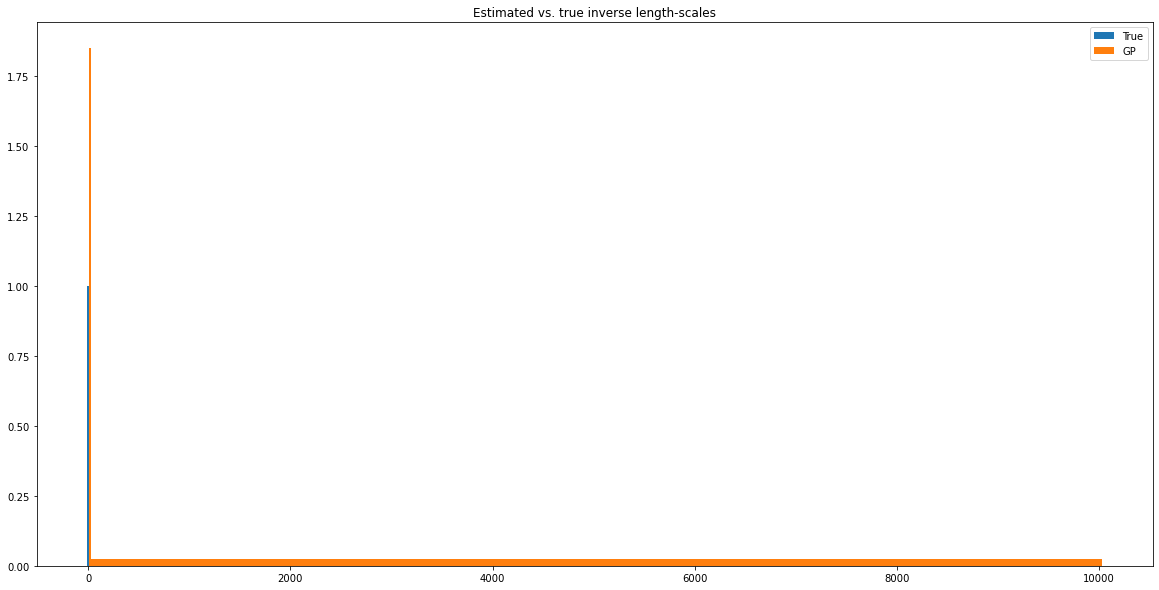

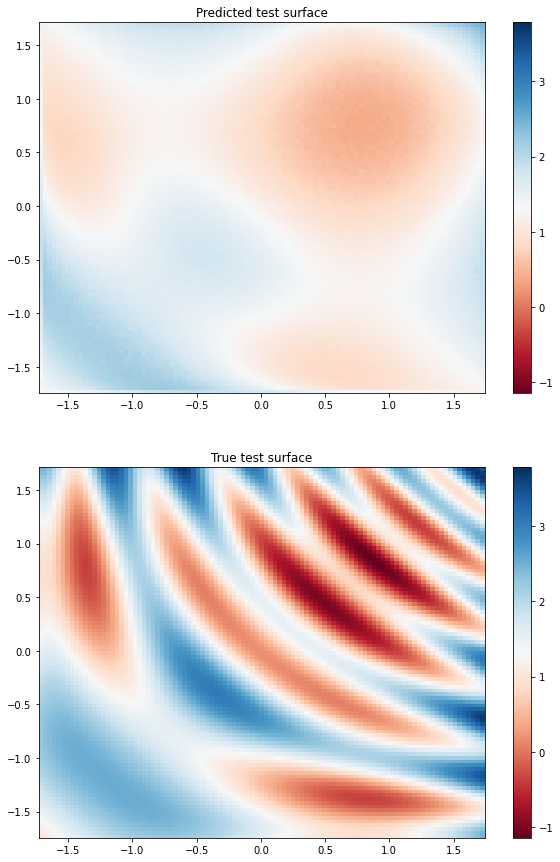

Latent test function MSE :  0.4934465
Observed test data  MSE :  0.79820853


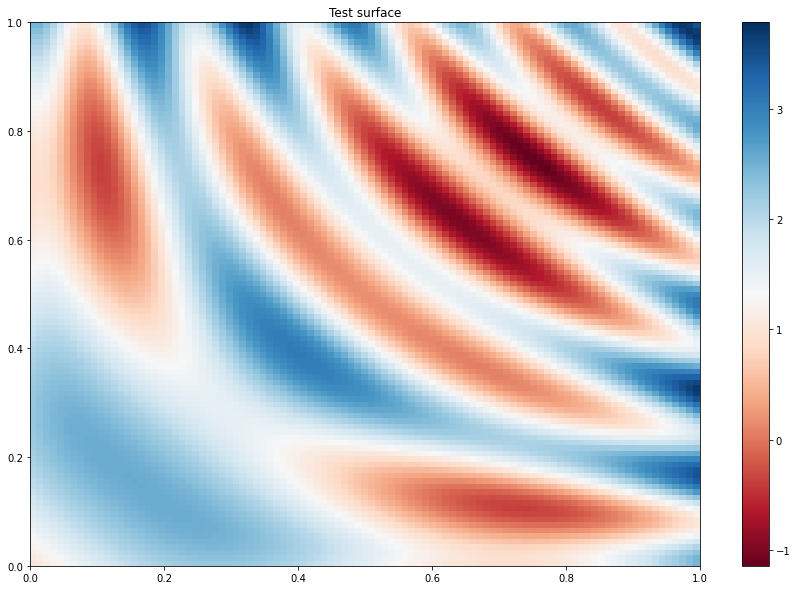

[20.894098 20.89409  20.89414  20.89417  20.894108 20.89413  20.89416
 20.894115 20.89416  20.894146]
3.0953352451324463 0.00022949278
Iter 2 - Loss: 3.095
[20.993826 20.993885 20.994015 20.994038 20.993952 20.993866 20.993954
 20.993942 20.994019 20.994019]
3.091825182437897 0.0002275718
Iter 3 - Loss: 2.744
[21.09314  21.093323 21.093832 21.093487 21.093845 21.093477 21.093344
 21.093723 21.093716 21.09382 ]
3.085636733222008 0.0002251976
Iter 4 - Loss: 2.473
[21.191483 21.191622 21.193092 21.191877 21.193333 21.192703 21.191917
 21.193115 21.19277  21.193085]
3.0774737090523243 0.0002218411
Iter 5 - Loss: 2.269
[21.288141 21.288057 21.29108  21.288572 21.291718 21.290918 21.289085
 21.291462 21.29052  21.29117 ]
3.0678215920675442 0.00021707821
Iter 6 - Loss: 2.112
[21.382349 21.381914 21.38704  21.382927 21.388208 21.387348 21.384169
 21.387993 21.386251 21.387386]
3.057020137583331 0.0002108129
Iter 7 - Loss: 1.988
[21.47333  21.472433 21.480253 21.474318 21.482025 21.481228 21.47

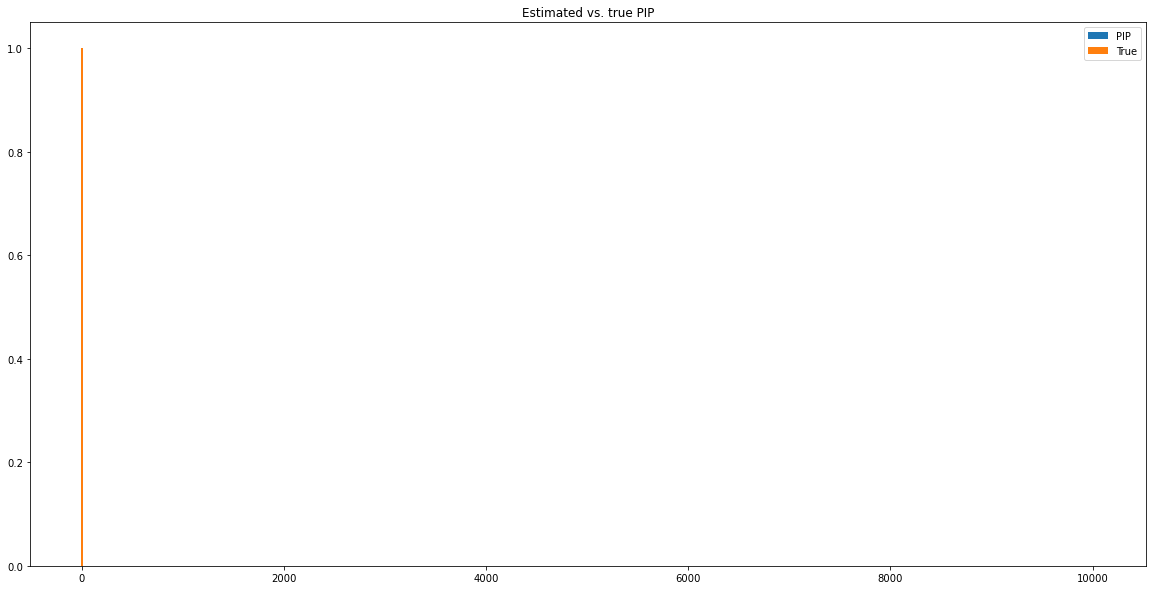

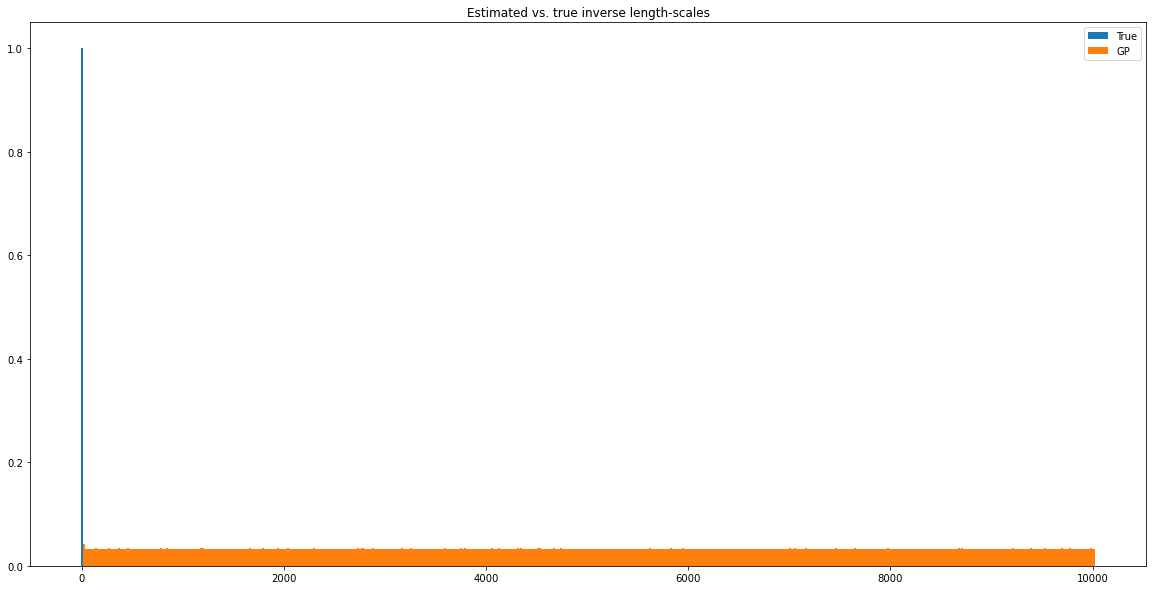

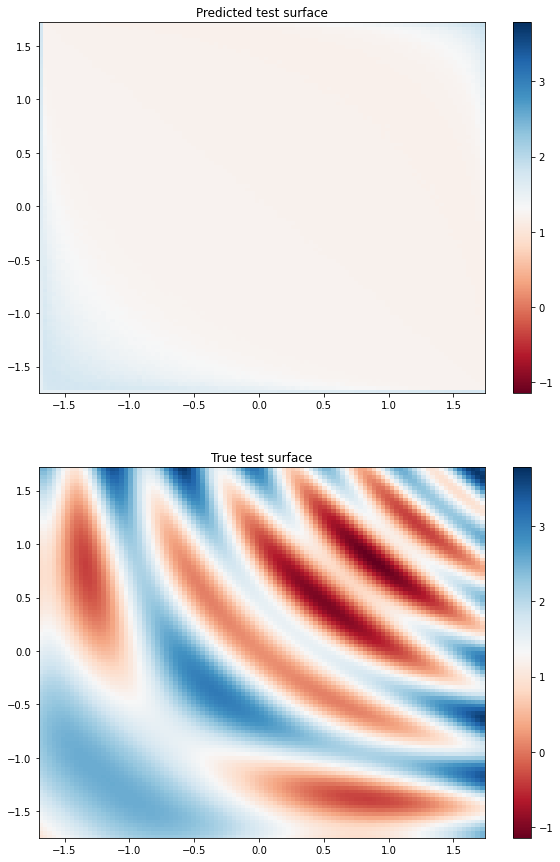

Latent test function MSE :  0.8459369
Observed test data  MSE :  1.1391006


[20.89053  20.891315 20.889446 20.890217 20.890076 20.891779 20.892265
 20.892576 20.89142  20.891802]
2.8120577335357666 0.00022107287


[20.995077 20.996134 20.991882 20.995443 20.993626 20.995985 20.996843
 20.997337 20.99546  20.99758 ]
2.809158117771149 0.00023575623


[21.103306 21.10512  21.099457 21.10388  21.10249  21.10325  21.10556
 21.105959 21.104546 21.108248]
2.8054206010580063 0.0002434548


[21.208088 21.211744 21.204403 21.207863 21.207733 21.207678 21.210901
 21.21307  21.2106   21.215645]
2.7998671079189776 0.00023658096


[21.308624 21.313768 21.308802 21.308222 21.31415  21.30824  21.31482
 21.31704  21.312635 21.320572]
2.7926535921361135 0.00022828994


[21.405252 21.406975 21.409174 21.40497  21.412588 21.406578 21.411926
 21.414867 21.409933 21.422127]
2.7843342878317263 0.00021474271


[21.49515  21.497805 21.502008 21.497551 21.5049   21.497585 21.502855
 21.506699 21.504704 21.515636]
2.7758083060698184 0.00020067648


[21.576195 21.576464 21.589216 21.582254 21.591103 21.583109 21.587437
 21.593975 21.590082 21.600899]
2.766632190362941 0.00018510905


[21.651005 21.650509 21.671612 21.663103 21.673435 21.663439 21.669476
 21.675688 21.67237  21.682526]
2.757520330653754 0.00017384127


[21.718529 21.719463 21.750807 21.737307 21.75059  21.739174 21.744976
 21.750832 21.747843 21.760405]
2.747201897481189 0.00016058362


[21.784527 21.782785 21.824179 21.806679 21.823404 21.809555 21.815964
 21.823717 21.823269 21.833286]
2.7370827170226124 0.00015103922


[21.843124 21.84088  21.891176 21.871937 21.891245 21.876297 21.882261
 21.894596 21.892282 21.901865]
2.7263773306501924 0.00014087882


[21.896599 21.890097 21.95689  21.934326 21.954992 21.940128 21.944805
 21.958496 21.957888 21.966995]
2.716092138295381 0.00013301236


[21.94478  21.938396 22.017622 21.994015 22.014502 21.99919  22.005762
 22.0178   22.018005 22.02734 ]
2.7053017124702126 0.0001231321


[21.99149  21.982285 22.074646 22.049196 22.071943 22.0549   22.062677
 22.075153 22.076584 22.084492]
2.694271456213583 0.000117132164


[22.03238  22.019077 22.129198 22.099237 22.125956 22.10787  22.116558
 22.12755  22.13217  22.139011]
2.6836717952307776 0.000108469234


[22.07002  22.054922 22.18248  22.148859 22.17868  22.15869  22.167784
 22.179726 22.184158 22.19212 ]
2.6730294279979216 0.000105073355


[22.106094 22.088148 22.231339 22.198704 22.229578 22.207216 22.216702
 22.231186 22.234667 22.242893]
2.662309207141328 0.00010123527


[22.138067 22.119894 22.279116 22.243118 22.273872 22.253443 22.265762
 22.27751  22.284813 22.290697]
2.6517604577975757 9.487517e-05


[22.169317 22.14745  22.323458 22.28647  22.318712 22.295984 22.311186
 22.322857 22.330952 22.336267]
2.640969545896144 9.0098634e-05


[22.198784 22.172749 22.367413 22.329247 22.362894 22.341633 22.354628
 22.368132 22.37626  22.382318]
2.630291136247653 8.833534e-05


[22.225193 22.198711 22.412085 22.37206  22.4062   22.38486  22.398258
 22.411856 22.420872 22.426394]
2.6197468894931784 8.54378e-05


[22.2492   22.22093  22.453482 22.412102 22.447817 22.425735 22.440166
 22.453878 22.463285 22.468723]
2.609341183665492 8.195473e-05


[22.271439 22.238642 22.495073 22.452902 22.487171 22.466763 22.480326
 22.495098 22.503588 22.510094]
2.5989038091594643 7.978502e-05


[22.292503 22.25828  22.53612  22.491354 22.525887 22.504246 22.52057
 22.534721 22.544346 22.551147]
2.588392826545012 7.728212e-05


[22.313948 22.27794  22.575005 22.53044  22.565315 22.543798 22.56082
 22.57437  22.587843 22.590862]
2.5782242458080193 7.729298e-05


[22.334991 22.295908 22.61285  22.566614 22.603933 22.583345 22.599638
 22.611794 22.625206 22.631042]
2.5679287181898744 7.45738e-05


[22.354527 22.313562 22.650213 22.603035 22.641012 22.621117 22.637653
 22.648994 22.662947 22.66995 ]
2.557679601305598 7.2208786e-05


[22.371927 22.327724 22.686295 22.639645 22.678743 22.657312 22.672646
 22.687654 22.69931  22.7066  ]
2.5475530897735905 7.0950584e-05


[22.392153 22.343819 22.724905 22.677296 22.716066 22.69466  22.710405
 22.725372 22.736765 22.745077]
2.537966225982483 7.2451636e-05


[22.408419 22.359125 22.760466 22.71261  22.74908  22.729633 22.748337
 22.75993  22.773964 22.78119 ]
2.5282919048233508 6.898313e-05


[22.425905 22.37206  22.795164 22.748726 22.786192 22.766272 22.784578
 22.796135 22.808874 22.817776]
2.5179668131047532 6.8815636e-05


[22.442379 22.387676 22.831324 22.783384 22.822134 22.802292 22.820627
 22.832983 22.845757 22.8543  ]
2.5079803617743957 6.8540336e-05


[22.459356 22.403084 22.865952 22.819006 22.858097 22.837584 22.85672
 22.868113 22.88262  22.890415]
2.498116421146077 6.7815e-05


[22.475225 22.41671  22.899397 22.853413 22.891796 22.872757 22.891434
 22.902887 22.91733  22.927094]
2.488410798478577 6.604327e-05


[22.491003 22.431005 22.9325   22.887812 22.926504 22.908089 22.926424
 22.937695 22.951902 22.962452]
2.4786907987701587 6.585914e-05


[22.505781 22.443264 22.96596  22.922821 22.959883 22.94282  22.96107
 22.972418 22.986963 22.997612]
2.469121690922838 6.4858905e-05


[22.520447 22.456207 23.00041  22.957497 22.994719 22.977312 22.996235
 23.007786 23.021145 23.032413]
2.459797382325453 6.479858e-05


[22.534428 22.468977 23.034674 22.99173  23.028656 23.009743 23.02951
 23.042007 23.056019 23.066101]
2.4504217147537246 6.394141e-05


[22.551151 22.481493 23.067764 23.026781 23.062372 23.045778 23.06414
 23.075687 23.09066  23.100492]
2.4409876165103013 6.478307e-05


[22.566858 22.493092 23.101534 23.060162 23.097038 23.080662 23.09909
 23.110836 23.123507 23.135223]
2.4315300494768204 6.388031e-05


[22.582489 22.507336 23.136553 23.09442  23.131104 23.115534 23.134623
 23.146881 23.16042  23.169315]
2.422745858553509 6.39006e-05


[22.597553 22.518913 23.168911 23.128016 23.165562 23.15021  23.169245
 23.181952 23.194593 23.204687]
2.413846620096987 6.350452e-05


[22.613255 22.532387 23.201426 23.163433 23.199638 23.184032 23.202917
 23.215868 23.227907 23.238766]
2.404699722222967 6.4075306e-05


[22.627867 22.544405 23.234394 23.196138 23.232538 23.218376 23.237514
 23.249643 23.261702 23.273558]
2.3962160997585045 6.232489e-05


[22.645298 22.560448 23.26745  23.231281 23.266518 23.25272  23.272041
 23.284918 23.296646 23.310282]
2.387650010433359 6.335744e-05


[22.661327 22.574265 23.30353  23.264875 23.29963  23.286894 23.307232
 23.318626 23.330992 23.344318]
2.3789209889095004 6.277867e-05


[22.676262 22.58555  23.336773 23.298885 23.333103 23.320591 23.34036
 23.352898 23.363861 23.37909 ]
2.3703386488610274 6.2048755e-05


[22.691767 22.600382 23.369886 23.334387 23.36767  23.35523  23.376104
 23.386183 23.399075 23.414452]
2.362138137223644 6.29127e-05


[22.707123 22.614105 23.403372 23.368921 23.401848 23.390472 23.409597
 23.421724 23.432856 23.448755]
2.3535047240578133 6.298161e-05


[22.724064 22.630318 23.43699  23.403477 23.436928 23.424839 23.443903
 23.457235 23.466934 23.482702]
2.3455030036814777 6.248289e-05


[22.740288 22.640938 23.470638 23.437994 23.470211 23.460608 23.47829
 23.490957 23.50049  23.518337]
2.337110776674677 6.1966064e-05


[22.756226 22.654375 23.50278  23.472836 23.504513 23.496317 23.513498
 23.524523 23.536041 23.553326]
2.328595698656847 6.248378e-05


[22.770166 22.668352 23.535332 23.506655 23.5385   23.530485 23.546562
 23.559649 23.569176 23.587603]
2.320566356355337 6.050848e-05


[22.786537 22.682085 23.569805 23.540718 23.572441 23.565023 23.582075
 23.594933 23.601994 23.622404]
2.312250941567266 6.195745e-05


[22.80602  22.698524 23.602077 23.575867 23.607008 23.600517 23.617935
 23.630789 23.638388 23.658419]
2.3044676159589663 6.3264066e-05


[22.821667 22.713163 23.635946 23.61074  23.64055  23.635687 23.651499
 23.665174 23.672506 23.694525]
2.296582733891555 6.143761e-05


[22.837864 22.727331 23.668928 23.645706 23.675432 23.671928 23.686653
 23.700125 23.70732  23.72893 ]
2.2885923625520137 6.132588e-05


[22.854258 22.743603 23.703602 23.68044  23.710468 23.707417 23.72218
 23.736385 23.74222  23.765858]
2.281212090162074 6.291193e-05


[22.870733 22.758627 23.737787 23.715664 23.746008 23.741486 23.757727
 23.77166  23.777664 23.801756]
2.2735480271980752 6.241911e-05


[22.888163 22.774334 23.77105  23.750257 23.78005  23.777739 23.793219
 23.807148 23.812962 23.837444]
2.2661452028327718 6.218338e-05


[22.903618 22.788689 23.804754 23.785276 23.815296 23.812433 23.82791
 23.842367 23.84729  23.87236 ]
2.258620157226105 6.161312e-05


[22.920713 22.803837 23.840273 23.82129  23.849043 23.849264 23.864481
 23.878677 23.88317  23.907463]
2.251155224879918 6.2397994e-05


[22.937513 22.820343 23.874067 23.856812 23.884447 23.885002 23.9
 23.914713 23.918129 23.94256 ]
2.2438269187668305 6.190486e-05


[22.954355 22.834362 23.908176 23.891973 23.919523 23.921688 23.935326
 23.949568 23.95325  23.978897]
2.236703991528625 6.1303464e-05


[22.970219 22.849722 23.943182 23.927328 23.955078 23.957594 23.970488
 23.985601 23.988064 24.01554 ]
2.2295323773621636 6.194315e-05


[22.988401 22.86669  23.979004 23.964228 23.99162  23.994999 24.008307
 24.022585 24.023508 24.052027]
2.2224640876804913 6.323147e-05


[23.006155 22.881233 24.011763 23.99895  24.027891 24.032572 24.042969
 24.059423 24.059702 24.08767 ]
2.2155861920562954 6.219158e-05


[23.02403  22.89656  24.04663  24.035742 24.063398 24.067883 24.078417
 24.095406 24.09463  24.124102]
2.2084617680095726 6.227466e-05


[23.041204 22.916065 24.083502 24.072956 24.099264 24.105652 24.117426
 24.132362 24.1315   24.162617]
2.2012639110411465 6.403179e-05


[23.060987 22.93461  24.120295 24.111238 24.135353 24.14214  24.15442
 24.168674 24.167368 24.199707]
2.1943342308674265 6.375604e-05


[23.07917  22.949337 24.156013 24.147486 24.171959 24.179777 24.19127
 24.205564 24.204239 24.236843]
2.1874204488862823 6.2356594e-05


[23.096064 22.965874 24.189983 24.185404 24.209585 24.218307 24.228453
 24.242579 24.241238 24.273943]
2.1809251666214644 6.305691e-05


[23.114704 22.983524 24.225874 24.222359 24.246662 24.255276 24.266182
 24.28     24.278135 24.31126 ]
2.174341966762653 6.35004e-05


[23.132153 22.998392 24.263224 24.259966 24.2826   24.292458 24.303139
 24.317083 24.314543 24.349257]
2.168137141817774 6.2599895e-05


[23.150656 23.014332 24.29985  24.297964 24.320166 24.329798 24.340273
 24.3554   24.35213  24.386034]
2.1612882861161493 6.277436e-05


[23.167318 23.029484 24.33731  24.33585  24.356396 24.36807  24.378036
 24.392948 24.388035 24.424198]
2.154897529500486 6.283967e-05


[23.186117 23.04754  24.372538 24.372343 24.393307 24.405085 24.415377
 24.430393 24.425411 24.460735]
2.148160935473029 6.312838e-05


[23.20487  23.064388 24.408834 24.409798 24.432806 24.444643 24.453215
 24.469189 24.46185  24.4989  ]
2.1417466877115454 6.362438e-05


[23.224121 23.084558 24.44753  24.44925  24.471695 24.482864 24.492077
 24.507711 24.500776 24.538319]
2.1351794343621093 6.47022e-05


[23.243494 23.10117  24.485819 24.487707 24.511066 24.52245  24.531387
 24.547504 24.53973  24.578268]
2.128904887638117 6.430359e-05


[23.261343 23.118546 24.523157 24.525827 24.54827  24.563278 24.569193
 24.58574  24.578365 24.6173  ]
2.122690648551394 6.3860534e-05


[23.278816 23.133837 24.561172 24.564116 24.585999 24.601295 24.608143
 24.624542 24.616175 24.656332]
2.116459598350975 6.3834384e-05


[23.297346 23.152086 24.598991 24.60296  24.625233 24.640917 24.647709
 24.664352 24.655666 24.6961  ]
2.110627504494159 6.4432155e-05


[23.315222 23.16828  24.636786 24.640455 24.663317 24.679186 24.686535
 24.702826 24.693935 24.734362]
2.1041767062577654 6.308688e-05


[23.334255 23.184677 24.674421 24.67952  24.702543 24.7183   24.726212
 24.74173  24.732685 24.773203]
2.0983021528735475 6.4530715e-05


[23.354343 23.20307  24.71323  24.720491 24.741842 24.759295 24.765915
 24.781364 24.771969 24.814133]
2.0923725144567658 6.537021e-05


[23.372478 23.222876 24.751787 24.760248 24.781794 24.800074 24.80585
 24.820839 24.812056 24.853998]
2.0870499069231294 6.481114e-05


[23.391958 23.240341 24.789503 24.798937 24.820997 24.838839 24.844467
 24.860863 24.851583 24.894114]
2.0813152039239973 6.4423955e-05


[23.409681 23.257137 24.82882  24.840195 24.860836 24.880709 24.884771
 24.900482 24.890587 24.934763]
2.0755964823313824 6.533193e-05


[23.42996  23.274748 24.869795 24.880936 24.902628 24.922115 24.926735
 24.941788 24.931112 24.975729]
2.069834259020367 6.573141e-05


[23.447367 23.29145  24.90873  24.921871 24.942774 24.96209  24.967215
 24.981176 24.971296 25.01696 ]
2.063868780333209 6.497142e-05


[23.465338 23.307898 24.948244 24.962502 24.9838   25.00329  25.00662
 25.022642 25.011696 25.057188]
2.058301529888733 6.5402295e-05


[23.485329 23.327364 24.98732  25.002277 25.024263 25.044153 25.048
 25.063507 25.051828 25.098381]
2.052719927219927 6.529625e-05


[23.50364  23.345186 25.026018 25.043175 25.066145 25.087164 25.08949
 25.104755 25.09389  25.138418]
2.0469802612309613 6.596676e-05


[23.521496 23.365833 25.065342 25.085289 25.107141 25.129965 25.132132
 25.146133 25.135302 25.18032 ]
2.0414976936879263 6.604023e-05


[23.541592 23.384077 25.10728  25.12721  25.149302 25.17142  25.173552
 25.188698 25.176207 25.22215 ]
2.036071952152201 6.594202e-05


[23.56061  23.400192 25.14887  25.169502 25.18867  25.21383  25.215002
 25.230558 25.217976 25.265036]
2.0306448366326775 6.6128756e-05


[23.577684 23.420864 25.18835  25.210482 25.231943 25.25527  25.257465
 25.272917 25.259819 25.308352]
2.0256216009280936 6.629025e-05


[23.597506 23.436335 25.230768 25.253199 25.27435  25.298388 25.300282
 25.315336 25.301027 25.349554]
2.020272108418111 6.637941e-05


[23.615465 23.45382  25.272161 25.29481  25.317984 25.340275 25.34257
 25.357552 25.343668 25.39239 ]
2.0150087908678653 6.683287e-05


[23.634033 23.471754 25.313738 25.337906 25.359465 25.383642 25.386158
 25.40008  25.386772 25.435514]
2.009759229959614 6.6347406e-05


[23.652113 23.489239 25.354862 25.381172 25.403076 25.427393 25.429234
 25.44403  25.430391 25.478697]
2.0046263219079883 6.685699e-05


[23.671343 23.5082   25.398594 25.42367  25.446415 25.470547 25.473143
 25.487463 25.47328  25.521759]
1.9996968027303512 6.715559e-05


[23.687351 23.52531  25.439838 25.467253 25.489344 25.513937 25.517797
 25.530827 25.516443 25.564661]
1.9950548781143025 6.661157e-05


[23.707485 23.543829 25.48433  25.509623 25.533728 25.558167 25.561619
 25.575245 25.560387 25.610973]
1.9898618993614645 6.818027e-05


[23.726885 23.563501 25.526861 25.553988 25.577307 25.602297 25.606094
 25.6188   25.603931 25.654083]
1.9850456587553011 6.75625e-05


[23.743847 23.57867  25.56883  25.59726  25.62073  25.646473 25.649971
 25.66198  25.648254 25.698126]
1.9799234634001242 6.6615015e-05


[23.761145 23.601086 25.614187 25.64183  25.66538  25.69121  25.696571
 25.706594 25.693493 25.743294]
1.9750570281054174 6.8232235e-05


[23.778444 23.616983 25.65684  25.686272 25.709538 25.736923 25.740507
 25.751621 25.73685  25.788298]
1.9701493066021343 6.7508074e-05


[23.797136 23.632826 25.7002   25.73117  25.754393 25.782728 25.784977
 25.797712 25.779612 25.832672]
1.9655273463978225 6.7575966e-05


[23.81545  23.649837 25.745672 25.776894 25.799183 25.828035 25.830654
 25.842258 25.826286 25.87853 ]
1.9607455346571718 6.840577e-05


[23.832739 23.664898 25.78712  25.820192 25.84507  25.8749   25.875998
 25.887682 25.870605 25.924501]
1.9562168087016982 6.755132e-05


[23.850323 23.683908 25.830616 25.867174 25.889643 25.920607 25.922192
 25.933271 25.91664  25.969383]
1.9518721784946251 6.8862326e-05


[23.867594 23.700924 25.875416 25.912773 25.935953 25.966427 25.968342
 25.97893  25.960955 26.015646]
1.9474835211971362 6.838499e-05


[23.885538 23.718365 25.920645 25.959076 25.982859 26.014338 26.015583
 26.025398 26.007463 26.06261 ]
1.9428787132888605 6.8902395e-05


[23.903006 23.732233 25.96735  26.004671 26.02987  26.061    26.061892
 26.071768 26.053566 26.109007]
1.938658972758221 6.8420995e-05


[23.918367 23.750586 26.012754 26.051659 26.075321 26.106073 26.108555
 26.119196 26.101158 26.15526 ]
1.9343734331691123 6.87339e-05


[23.935205 23.768456 26.058891 26.096882 26.122412 26.15445  26.15794
 26.16566  26.147097 26.20158 ]
1.9300331368333319 6.909598e-05


[23.952595 23.782999 26.105604 26.145998 26.169537 26.201925 26.20705
 26.214022 26.195456 26.250513]
1.9258332917435326 7.02016e-05


[23.967052 23.798714 26.15052  26.191801 26.21798  26.251516 26.256329
 26.262283 26.243305 26.298979]
1.9215059461841903 6.9853064e-05


[23.985214 23.815704 26.197311 26.239847 26.267939 26.2986   26.302681
 26.310255 26.2895   26.347012]
1.916569159112714 7.003884e-05


[24.001734 23.830343 26.246035 26.287354 26.315321 26.34767  26.351664
 26.357967 26.337759 26.39461 ]
1.9126702567195086 6.9525646e-05


[24.015364 23.848354 26.291485 26.334906 26.360817 26.394796 26.399527
 26.405424 26.386168 26.44295 ]
1.9087059183967747 6.980072e-05


[24.032522 23.863096 26.33934  26.383255 26.409853 26.445929 26.449764
 26.456003 26.435465 26.491493]
1.904611498039177 7.102726e-05


[24.046469 23.87728  26.388626 26.431644 26.457909 26.49478  26.497826
 26.504381 26.483335 26.54098 ]
1.9004327686846245 6.9227484e-05


[24.063038 23.89094  26.435045 26.481106 26.509953 26.544067 26.5462
 26.554007 26.53356  26.591265]
1.896635813901602 7.0854745e-05


[24.07537  23.905495 26.48338  26.531242 26.562551 26.593653 26.597454
 26.603569 26.581753 26.640467]
1.89287927841731 7.1206865e-05


[24.09035  23.921968 26.532442 26.579617 26.610691 26.64418  26.647985
 26.6521   26.632095 26.69116 ]
1.8891667908890268 7.0573195e-05


[24.104765 23.934246 26.582376 26.631798 26.661367 26.693796 26.698778
 26.703358 26.684214 26.741007]
1.885176493982334 7.167057e-05


[24.11613  23.950014 26.631947 26.681343 26.713968 26.746832 26.749895
 26.755375 26.735155 26.79125 ]
1.8809800115399165 7.227573e-05


[24.133465 23.965332 26.682917 26.732635 26.763668 26.796732 26.800407
 26.805553 26.78379  26.842678]
1.8770369700094935 7.1048926e-05


[24.144016 23.978363 26.732094 26.782686 26.814762 26.849657 26.852087
 26.857655 26.836683 26.89502 ]
1.8733621513233452 7.197257e-05


[24.155605 23.991005 26.783377 26.8341   26.865168 26.901497 26.903809
 26.908655 26.886183 26.944765]
1.8694492449990918 7.1323564e-05


[24.169949 24.00333  26.835955 26.88509  26.91594  26.953518 26.955177
 26.960167 26.938078 26.995903]
1.8654501477803478 7.155657e-05


[24.182117 24.013083 26.885588 26.935848 26.968777 27.00607  27.008503
 27.011816 26.988705 27.048758]
1.861745211236321 7.1800365e-05


[24.190464 24.02335  26.936293 26.987179 27.02278  27.058233 27.059345
 27.065374 27.040604 27.099535]
1.8580058223258622 7.189198e-05


[24.201296 24.036821 26.987774 27.04045  27.074875 27.109947 27.113237
 27.11757  27.093952 27.15204 ]
1.8546035671421544 7.2312396e-05


[24.210207 24.049728 27.040731 27.093735 27.12765  27.164793 27.166992
 27.169832 27.148178 27.205286]
1.850551279420333 7.2885814e-05


[24.21854  24.057005 27.092693 27.144796 27.180984 27.217653 27.221727
 27.223074 27.20157  27.257801]
1.8472732656343083 7.235782e-05


[24.228743 24.064873 27.144726 27.197405 27.23539  27.271267 27.274761
 27.278397 27.253386 27.31208 ]
1.8438428773097064 7.185791e-05


[24.237568 24.075697 27.19791  27.250885 27.290945 27.326105 27.33022
 27.331661 27.308525 27.364756]
1.840470496443485 7.376375e-05


[24.244347 24.084507 27.251045 27.303675 27.345243 27.380838 27.386326
 27.38596  27.363634 27.419825]
1.8369145196589818 7.244877e-05


[24.253704 24.093683 27.304056 27.358988 27.398373 27.435266 27.441109
 27.439161 27.417204 27.474888]
1.8336354680750628 7.380643e-05


[24.258076 24.098484 27.356943 27.414    27.455801 27.489536 27.495157
 27.494205 27.47037  27.528154]
1.8302372831121008 7.239309e-05


[24.265429 24.105936 27.411367 27.467411 27.5087   27.54377  27.550167
 27.548851 27.525923 27.582005]
1.8266160468891035 7.3424766e-05


[24.269552 24.111206 27.466213 27.520578 27.565178 27.599108 27.606
 27.604244 27.580313 27.637636]
1.8232181983022315 7.339248e-05


[24.273268 24.114351 27.521938 27.577572 27.62025  27.656706 27.663889
 27.660416 27.633995 27.694407]
1.820155069396907 7.340829e-05


[24.279757 24.120716 27.58018  27.637522 27.677862 27.714745 27.723238
 27.719334 27.693584 27.749832]
1.8171485093378563 7.6258446e-05


[24.281748 24.126423 27.634224 27.691515 27.733782 27.771687 27.780167
 27.775515 27.750914 27.808037]
1.8140710767976547 7.374232e-05


[24.286032 24.128536 27.689304 27.747892 27.791431 27.827852 27.83604
 27.831305 27.806067 27.864357]
1.8113000244998319 7.387554e-05


[24.284288 24.126087 27.74623  27.80332  27.849144 27.885595 27.894863
 27.887123 27.863617 27.921265]
1.8079140290212978 7.417533e-05


[24.284578 24.12719  27.804815 27.859762 27.908087 27.944435 27.953234
 27.944294 27.920897 27.978668]
1.8048431821213589 7.447386e-05


[24.283815 24.12434  27.85979  27.917273 27.968086 28.00133  28.012985
 28.003452 27.979702 28.035437]
1.8017929109008075 7.47381e-05


[24.276886 24.122616 27.918377 27.975554 28.02699  28.061518 28.07155
 28.06135  28.035461 28.094076]
1.7988139942238979 7.501685e-05


[24.272142 24.121368 27.978117 28.033638 28.08669  28.119577 28.131588
 28.119383 28.094137 28.151917]
1.7955375335018584 7.485638e-05


[24.2731   24.118143 28.036318 28.091978 28.14731  28.17897  28.19228
 28.18033  28.152649 28.21066 ]
1.7928754523582002 7.552453e-05


[24.269033 24.113857 28.094904 28.152401 28.205616 28.240335 28.25187
 28.239561 28.212542 28.269894]
1.7895758556162191 7.5569566e-05


[24.261448 24.104471 28.149992 28.208939 28.2646   28.300138 28.310894
 28.298317 28.269464 28.328518]
1.7864506895111527 7.427561e-05


[24.251911 24.093695 28.210327 28.267601 28.324728 28.360401 28.374216
 28.356443 28.330692 28.38578 ]
1.7836140287139874 7.4932505e-05


[24.242428 24.082556 28.269564 28.326908 28.384232 28.419115 28.435863
 28.417387 28.388704 28.444878]
1.7804859031534863 7.560061e-05


[24.23489  24.072659 28.332726 28.386654 28.446072 28.482388 28.497326
 28.477768 28.45061  28.508307]
1.777639772673816 7.660185e-05


[24.221546 24.060528 28.394316 28.447533 28.50787  28.543104 28.559612
 28.540543 28.512579 28.569908]
1.7748354406342572 7.669754e-05


[24.212273 24.050213 28.455282 28.508272 28.5711   28.60672  28.621864
 28.604006 28.57471  28.629732]
1.7716270349297731 7.685128e-05


[24.189987 24.033371 28.515057 28.568727 28.632675 28.668583 28.68295
 28.665047 28.634924 28.691248]
1.7688870407397619 7.509748e-05


[24.169012 24.01041  28.576147 28.629955 28.69679  28.731983 28.745798
 28.727343 28.696846 28.75217 ]
1.7658813084644596 7.650815e-05


[24.147598 23.991405 28.635704 28.690678 28.757477 28.792131 28.81081
 28.788101 28.757898 28.814383]
1.7629759765294883 7.5388416e-05


[24.125778 23.968166 28.697346 28.7522   28.819387 28.853792 28.873066
 28.850288 28.820557 28.874378]
1.7602096887490568 7.550489e-05


[24.101622 23.944967 28.76226  28.814426 28.88694  28.91958  28.938759
 28.914621 28.882792 28.939045]
1.7575147826612794 7.81395e-05


[24.076603 23.91623  28.824066 28.875542 28.95035  28.983557 29.002459
 28.97753  28.947805 29.001684]
1.7550588548530535 7.6855176e-05


[24.044662 23.88383  28.88378  28.937313 29.01324  29.046497 29.068832
 29.043634 29.01151  29.064934]
1.7524318042741123 7.6046395e-05


[24.00871  23.849052 28.94794  29.000341 29.077124 29.11114  29.133476
 29.108688 29.076385 29.127516]
1.7504222462487662 7.613605e-05


[23.972103 23.810148 29.01341  29.065111 29.14201  29.176493 29.20174
 29.173388 29.139656 29.190771]
1.7483007964703758 7.689821e-05


[23.932543 23.767702 29.075554 29.12778  29.206245 29.23893  29.2671
 29.238276 29.203623 29.255842]
1.7456535192967642 7.619052e-05


[23.89682  23.72949  29.141817 29.191454 29.270563 29.304903 29.333828
 29.304455 29.268589 29.319574]
1.7433762081180788 7.69481e-05


[23.84896  23.678856 29.205473 29.25255  29.336164 29.370033 29.399395
 29.3681   29.3333   29.384521]
1.740895533605181 7.530261e-05


[23.796356 23.633781 29.270044 29.318104 29.403727 29.438143 29.46553
 29.433764 29.399921 29.448296]
1.7383254263831427 7.7192715e-05


[23.751698 23.585722 29.333008 29.382624 29.467623 29.504988 29.53389
 29.5008   29.465818 29.51531 ]
1.736101938793353 7.665931e-05


[23.703274 23.527489 29.401525 29.447819 29.536354 29.571283 29.602085
 29.569944 29.532095 29.582684]
1.7335534866394589 7.761526e-05


[23.642038 23.465319 29.467123 29.512615 29.60131  29.638474 29.66996
 29.635838 29.597881 29.648726]
1.7309281873687674 7.640763e-05


[23.580643 23.402317 29.533585 29.578573 29.669477 29.706697 29.739075
 29.701582 29.665962 29.71276 ]
1.7284270834430777 7.697288e-05


[23.515375 23.329845 29.598276 29.643988 29.736391 29.771368 29.805758
 29.76862  29.732246 29.779696]
1.726491990922856 7.5602125e-05


[23.451962 23.260117 29.664047 29.708115 29.803474 29.839031 29.873783
 29.835596 29.79726  29.84546 ]
1.7242617191936354 7.5393866e-05


[23.37265  23.177658 29.732035 29.774925 29.870554 29.909723 29.942553
 29.90235  29.86555  29.913498]
1.7218582469468435 7.689087e-05


[23.290735 23.090555 29.799467 29.84199  29.938887 29.978003 30.010195
 29.97065  29.932795 29.978828]
1.7195910354318886 7.614584e-05


[23.211332 22.99966  29.868025 29.908432 30.004585 30.044762 30.080324
 30.036718 29.999294 30.046925]
1.7172747904523256 7.578031e-05


[23.11348  22.911385 29.936274 29.975069 30.074722 30.114225 30.149282
 30.10807  30.06951  30.115185]
1.7146039003053708 7.6256554e-05


[23.019133 22.806879 30.002064 30.0399   30.143616 30.180143 30.218264
 30.175097 30.135727 30.182049]
1.7122045987824805 7.501366e-05


[22.926857 22.705063 30.068964 30.107124 30.212372 30.253231 30.290691
 30.244411 30.204165 30.251436]
1.7100865308086481 7.687768e-05


[22.812504 22.586569 30.13716  30.171024 30.280375 30.318571 30.36137
 30.313265 30.271458 30.316395]
1.7081549498442812 7.3463925e-05


[22.698256 22.468468 30.204985 30.237274 30.34957  30.388    30.432587
 30.380966 30.338001 30.384714]
1.7061814111147287 7.486581e-05


[22.584919 22.343441 30.273476 30.305996 30.41503  30.457277 30.501017
 30.450111 30.406515 30.453924]
1.704119189307811 7.493416e-05


[22.452936 22.199276 30.341534 30.371027 30.484482 30.525875 30.57287
 30.517849 30.472918 30.520885]
1.7019876308127888 7.4714204e-05


[22.316238 22.06225  30.408413 30.437714 30.552525 30.595797 30.642067
 30.586624 30.538858 30.587687]
1.6996297973608774 7.3530115e-05


[22.182785 21.9321   30.478329 30.504429 30.622223 30.664442 30.714973
 30.656929 30.60983  30.658112]
1.6976150100264593 7.533488e-05


[22.034893 21.773985 30.545546 30.569103 30.690237 30.734175 30.784481
 30.724089 30.678991 30.72543 ]
1.6954372686729142 7.318489e-05


[21.886885 21.614946 30.615992 30.639475 30.760225 30.804165 30.855492
 30.794237 30.74975  30.79441 ]
1.6932132326522922 7.480956e-05


[21.7184   21.44398  30.685827 30.705835 30.831646 30.874958 30.925877
 30.864517 30.817972 30.862062]
1.6908742092182099 7.293039e-05


[21.55686  21.263603 30.75374  30.773804 30.900322 30.943985 30.99804
 30.932697 30.889446 30.930351]
1.6889458130904595 7.290308e-05


[21.380318 21.078152 30.825195 30.842892 30.968199 31.01398  31.072966
 31.001846 30.959919 30.999401]
1.6864232058125213 7.420629e-05


[21.201569 20.891293 30.89451  30.910429 31.039965 31.086079 31.14481
 31.070845 31.025078 31.068459]
1.6843943528780838 7.247679e-05


[21.002834 20.701603 30.964605 30.979181 31.111124 31.157331 31.215101
 31.143845 31.096237 31.138006]
1.682250003131728 7.3215255e-05


[20.804197 20.494703 31.030132 31.042387 31.179188 31.225296 31.285513
 31.21223  31.164013 31.202433]
1.6802505178365863 7.062201e-05


[20.602219 20.291077 31.102076 31.108555 31.24707  31.294771 31.355885
 31.279438 31.232311 31.271915]
1.6784880479060234 7.156788e-05


[20.393456 20.067215 31.170214 31.173763 31.31637  31.366652 31.4255
 31.350477 31.301498 31.340956]
1.6769911210421518 7.153037e-05


[20.178934 19.833168 31.237808 31.24311  31.387741 31.434555 31.499733
 31.420652 31.36787  31.406925]
1.6752981081681406 7.061758e-05


[19.953854 19.60876  31.307178 31.312073 31.455116 31.503769 31.572594
 31.490433 31.437489 31.473925]
1.6731181420610535 7.037398e-05


[19.717459 19.357004 31.375742 31.377676 31.521147 31.573423 31.644464
 31.557745 31.506042 31.538975]
1.6714352082162027 6.910743e-05


[19.486193 19.116573 31.443636 31.44349  31.590456 31.641935 31.715565
 31.626743 31.573652 31.606651]
1.669591596309288 6.9922535e-05


[19.233225 18.86379  31.510721 31.509422 31.657537 31.710207 31.785292
 31.693905 31.641575 31.674557]
1.6681107279440803 6.843999e-05


[18.988144 18.603464 31.58155  31.578154 31.726294 31.782528 31.856783
 31.766235 31.714293 31.743134]
1.6662785002403688 7.0281385e-05


[18.732502 18.32509  31.647411 31.643166 31.792765 31.850155 31.928986
 31.832443 31.781359 31.809185]
1.6649144537175793 6.7302e-05


[18.488121 18.04779  31.718788 31.708366 31.860754 31.91812  31.998856
 31.90082  31.849787 31.87711 ]
1.6632077906981952 6.824913e-05


[18.221455 17.77803  31.787367 31.775774 31.932608 31.988316 32.071518
 31.970541 31.920845 31.945322]
1.6616294892938226 6.9440845e-05


[17.935608 17.478949 31.854094 31.837896 31.996157 32.053764 32.139503
 32.03825  31.987377 32.012295]
1.6599477425404565 6.524716e-05


[17.651733 17.185331 31.921627 31.900665 32.06433  32.12151  32.20963
 32.10492  32.052998 32.076965]
1.6580234853661353 6.6269924e-05


[17.375029 16.895372 31.992208 31.967325 32.135643 32.192673 32.284363
 32.174816 32.122387 32.14778 ]
1.6567568579667737 6.8344154e-05


[17.081127 16.577847 32.06056  32.032204 32.203587 32.260845 32.3514
 32.241604 32.18718  32.211224]
1.6550921063979855 6.4571825e-05


[16.77916  16.277094 32.124454 32.096645 32.26824  32.327442 32.420494
 32.305126 32.252388 32.275574]
1.6535582191493896 6.422392e-05


[16.482523  15.9571705 32.194706  32.163563  32.338673  32.398457
 32.4951    32.37806   32.321938  32.343338 ]
1.6517941652019144 6.7074296e-05


[16.195919 15.634485 32.262337 32.228497 32.407074 32.466385 32.56485
 32.447464 32.389248 32.40927 ]
1.6499922968245075 6.514479e-05


[15.892723 15.30847  32.329006 32.29202  32.474873 32.536407 32.633743
 32.51472  32.458595 32.47615 ]
1.6480403179251712 6.486408e-05


[15.564601 14.975777 32.392677 32.353134 32.54047  32.6018   32.70126
 32.58269  32.527184 32.538574]
1.6463279525419399 6.275863e-05


[15.250684 14.648241 32.460957 32.41492  32.60614  32.669514 32.77456
 32.646725 32.591644 32.601883]
1.6450267368535718 6.221025e-05


[14.924142 14.305794 32.528008 32.481297 32.67209  32.736824 32.842606
 32.714367 32.656906 32.665844]
1.6437552548091328 6.33807e-05


[14.599177 13.959273 32.59329  32.542168 32.736256 32.799576 32.909992
 32.78166  32.719727 32.730057]
1.6424613661442506 6.137055e-05


[14.263809 13.611433 32.65841  32.606766 32.800552 32.866295 32.979073
 32.847286 32.78292  32.79553 ]
1.6410098779405717 6.178494e-05


[13.93325  13.25673  32.725792 32.66748  32.864437 32.93453  33.04544
 32.916416 32.848793 32.86094 ]
1.6393340854966152 6.228868e-05


[13.604171 12.905918 32.789024 32.732285 32.930984 33.001396 33.116592
 32.984837 32.91705  32.92723 ]
1.6379701213868731 6.23179e-05


[13.257479 12.550406 32.85534  32.795254 32.9964   33.067924 33.18589
 33.05056  32.982155 32.98989 ]
1.6362714483006748 6.0893475e-05


[12.915505 12.185367 32.918407 32.852688 33.060043 33.130928 33.252472
 33.1189   33.046467 33.05242 ]
1.634808032962413 5.8994723e-05


[12.567493 11.819504 32.98413  32.915913 33.123028 33.197147 33.318443
 33.181946 33.111355 33.115944]
1.632709847251777 6.0147202e-05


[12.223547 11.443479 33.05125  32.97977  33.18807  33.264088 33.387074
 33.24769  33.17861  33.17854 ]
1.6312067005004507 6.0403883e-05


[11.8629265 11.060592  33.112938  33.03814   33.24881   33.324818
 33.452576  33.3115    33.241714  33.240116 ]
1.6300086655255517 5.7157962e-05


[11.503319 10.685862 33.180305 33.100838 33.312805 33.389626 33.521503
 33.377377 33.30606  33.305023]
1.6290083222842213 5.9974907e-05


[11.144523 10.287    33.241833 33.160007 33.37691  33.45643  33.59239
 33.44091  33.37275  33.367382]
1.6276875069065329 5.862719e-05


[10.772165  9.895946 33.30591  33.220463 33.44164  33.52059  33.65787
 33.507202 33.434284 33.427914]
1.6261675557514232 5.821628e-05


[10.391561   9.5016575 33.371105  33.281807  33.506573  33.58618
 33.725357  33.573685  33.501022  33.49237  ]
1.6246739370634158 5.9195794e-05


[10.00885   9.08571  33.43664  33.342262 33.568813 33.649574 33.792007
 33.6369   33.56417  33.55307 ]
1.6236986944655476 5.7604546e-05


[ 9.610987  8.660478 33.498093 33.40205  33.630665 33.71164  33.856422
 33.69841  33.625732 33.612885]
1.6226182424310942 5.624011e-05


[ 9.20928   8.247525 33.562355 33.46301  33.692894 33.77659  33.92345
 33.76234  33.689606 33.674973]
1.6215679235111928 5.736119e-05


[ 8.803301  7.811945 33.623425 33.520973 33.75262  33.839043 33.987396
 33.827477 33.75652  33.735348]
1.6203001688900334 5.6752368e-05


[ 8.382954   7.3721347 33.686172  33.58167   33.81713   33.901394
 34.05436   33.89213   33.819756  33.79876  ]
1.6185820149851755 5.624388e-05


[ 7.9606667  6.94408   33.74876   33.64291   33.878994  33.96684
 34.1241    33.957195  33.88618   33.860405 ]
1.6174322484928556 5.7523488e-05


[ 7.5210905  6.4750705 33.80924   33.701004  33.940437  34.030388
 34.19053   34.017082  33.94573   33.9165   ]
1.61620066740197 5.4869724e-05


[ 7.0800495  5.998165  33.87395   33.75915   34.004597  34.09222
 34.25504   34.07652   34.010082  33.979317 ]
1.6149987887968742 5.711519e-05


[ 6.6177607  5.517584  33.939774  33.820717  34.068573  34.15701
 34.322132  34.143993  34.074757  34.041767 ]
1.6133396973722995 5.8302492e-05


[ 6.1450944  5.0055    34.003845  33.877228  34.127346  34.21573
 34.389053  34.206833  34.13255   34.102875 ]
1.6118129121272449 5.5788027e-05


[ 5.660093   4.4956303 34.065323  33.93702   34.191196  34.278694
 34.45503   34.26954   34.20181   34.159843 ]
1.6102407338955598 5.824176e-05


[ 5.1574774  3.967708  34.12906   34.001408  34.254498  34.34506
 34.520374  34.338177  34.268505  34.22351  ]
1.6095388423513584 5.9553826e-05


[ 4.638042   3.4204142 34.193405  34.06254   34.31891   34.40776
 34.586105  34.40393   34.33078   34.286163 ]
1.6083624881704748 6.170345e-05


[ 4.1058207  2.8528104 34.261036  34.128002  34.38177   34.47393
 34.653378  34.47034   34.395077  34.35169  ]
1.6073423124331334 6.4463195e-05


[ 3.5504527  2.2960148 34.327484  34.192257  34.4506    34.544296
 34.726425  34.536896  34.46437   34.416607 ]
1.6059493225821175 7.016527e-05


[ 2.9747028  1.755779  34.40033   34.26059   34.524727  34.61444
 34.801743  34.60834   34.53529   34.489483 ]
1.6043193401881293 7.947074e-05


[ 2.405762   1.2688544 34.48039   34.33635   34.60468   34.69325
 34.88189   34.691     34.612675  34.565674 ]
1.6027478219437952 9.651338e-05


[ 1.8817046  0.8859002 34.568115  34.425602  34.69419   34.778015
 34.972046  34.781925  34.702953  34.650635 ]
1.6015274261389842 0.00011999477


[ 1.4640689  0.7112346 34.675827  34.53013   34.800274  34.887936
 35.0806    34.89049   34.81254   34.75397  ]
1.6002517940208438 0.00013199149


[ 1.1486934   0.73693776 34.79683    34.647854   34.921314   35.0074
 35.200737   35.014423   34.935093   34.873646  ]
1.5991554285674365 0.00012449136


[ 0.9287354  0.7821237 34.930614  34.779243  35.054604  35.141354
 35.33078   35.146763  35.061375  35.00426  ]
1.5979144336117488 0.00013663762


[ 0.8604848   0.82724655 35.073006   34.92387    35.1979     35.282536
 35.47215    35.288467   35.202793   35.140575  ]
1.5966927567839473 0.00013104883


[ 0.8269563   0.80293816 35.22818    35.07457    35.34831    35.43291
 35.621933   35.441643   35.3477     35.28706   ]
1.5950836046658605 0.00012999994


[ 0.80395114  0.77409613 35.388466   35.23285    35.50618    35.59113
 35.775925   35.600094   35.499756   35.438793  ]
1.593569349753998 0.0001335116


[ 0.82013506  0.7475445  35.555305   35.399574   35.66926    35.75628
 35.93594    35.767582   35.66142    35.59636   ]
1.5920310246875493 0.00013804749


[ 0.78361607  0.7350774  35.733143   35.572075   35.841183   35.927975
 36.1055     35.94007    35.828857   35.762337  ]
1.5909263358167114 0.00014149868


[ 0.78754497  0.72776973 35.917633   35.74689    36.020527   36.107616
 36.282433   36.120457   36.005177   35.94061   ]
1.5897308521464257 0.0001413924


[ 0.75117445  0.7170559  36.107334   35.93337    36.204643   36.29083
 36.464195   36.306396   36.18632    36.120415  ]
1.5883852725888135 0.0001494789


[ 0.7515797  0.7070394 36.304474  36.12522   36.392536  36.48105
 36.651196  36.500607  36.37116   36.30203  ]
1.5868262220231883 0.00014617512


[ 0.76033723  0.6798487  36.506065   36.31651    36.591583   36.67673
 36.845493   36.69706    36.560974   36.491043  ]
1.5850269924720237 0.0001531044


[ 0.7247441  0.6688816 36.70936   36.515125  36.788456  36.876015
 37.0403    36.893707  36.75384   36.683815 ]
1.5834404776303876 0.00015610887


[ 0.71576667  0.67736596 36.920406   36.71925    36.98894    37.079037
 37.24128    37.102386   36.952843   36.878174  ]
1.5821276263704716 0.00015265851


[ 0.7237676  0.6515755 37.131695  36.92525   37.19253   37.286434
 37.443058  37.307327  37.1545    37.080814 ]
1.5804939721770794 0.00015641861


[ 0.7069947  0.648643  37.34454   37.13116   37.403328  37.495274
 37.64863   37.51288   37.358746  37.282852 ]
1.5787438446482256 0.00015247319


[ 0.7180643   0.64234364 37.56375    37.341034   37.611317   37.706955
 37.860256   37.725418   37.567646   37.48447   ]
1.5769688418764107 0.00015285893


[ 0.6999643   0.63678044 37.780746   37.55402    37.821705   37.91468
 38.064514   37.93739    37.771282   37.692066  ]
1.5754208252773334 0.00015202042


[ 0.68791425  0.6351557  37.9962     37.766212   38.036304   38.127113
 38.272305   38.150364   37.979717   37.89587   ]
1.5735827184802487 0.00014938212


[ 0.6853337  0.6280459 38.213078  37.97207   38.24654   38.336105
 38.482136  38.359695  38.189022  38.10168  ]
1.5718717426176203 0.00014544964


[ 0.67752206  0.6205032  38.42778    38.182686   38.454132   38.547432
 38.688034   38.56785    38.39674    38.302692  ]
1.5704927213603437 0.00014513462


[ 0.6768764  0.617296  38.64214   38.394474  38.663204  38.757298
 38.89539   38.777298  38.60453   38.50827  ]
1.568924805913174 0.00014140896


[ 0.6717581  0.6213253 38.85414   38.599392  38.86843   38.95885
 39.09454   38.979347  38.80267   38.709587 ]
1.5673822029231645 0.00013679954


[ 0.6720497   0.60292125 39.058697   38.800873   39.07064    39.16293
 39.297367   39.18131    39.0001     38.906242  ]
1.5656514021913877 0.0001378457


[ 0.66794467  0.59861237 39.266975   39.002796   39.2672     39.361336
 39.4916     39.37907    39.199272   39.101257  ]
1.5639265881607 0.000131165


[ 0.66489077  0.605122   39.462048   39.197197   39.45827    39.552357
 39.682503   39.573204   39.388702   39.287376  ]
1.5623603925667977 0.00012580917


[ 0.6468316   0.59724224 39.660664   39.393913   39.651413   39.74411
 39.87717    39.76488    39.583      39.477516  ]
1.5601512872087109 0.0001286757


[ 0.6505365  0.587951  39.85786   39.587723  39.84501   39.93678
 40.066135  39.953842  39.77114   39.665005 ]
1.5582409075973507 0.0001238026


[ 0.6396294  0.5838811 40.040924  39.770077  40.02222   40.121357
 40.2445    40.13204   39.950134  39.84102  ]
1.556621484990646 0.00011672134


[ 0.6504562  0.6041963 40.230145  39.953938  40.205853  40.309357
 40.424454  40.315323  40.136307  40.02248  ]
1.5552597722464523 0.000121821235


[ 0.62672037  0.57537776 40.409866   40.128696   40.381668   40.486156
 40.600426   40.48864    40.312225   40.195538  ]
1.5533171131455086 0.00012162462


[ 0.6395273  0.5782949 40.58553   40.305157  40.5546    40.65689
 40.77029   40.65884   40.48353   40.365025 ]
1.5514714250863344 0.00010835936


[ 0.6351748  0.5784399 40.761395  40.475597  40.725853  40.83156
 40.935837  40.82567   40.656227  40.529556 ]
1.5497233000002049 0.000103819846


[ 0.6216821   0.57650894 40.933147   40.645878   40.894176   40.998463
 41.104683   40.99128    40.82043    40.695564  ]
1.5482623206909225 0.000104134655


[ 0.62378097  0.56707865 41.100418   40.811356   41.058      41.161983
 41.266483   41.151463   40.98243    40.856953  ]
1.5465467360677687 9.9697434e-05


[ 0.6204342   0.57354057 41.263386   40.97       41.218006   41.322063
 41.427788   41.30726    41.140987   41.012062  ]
1.544688466707045 9.609183e-05


[ 0.6122156  0.5707084 41.42027   41.129223  41.376858  41.48036
 41.579517  41.46122   41.29939   41.16847  ]
1.5428680883685573 9.40869e-05


[ 0.61065704  0.5650097  41.575897   41.287083   41.528553   41.636166
 41.7306     41.61522    41.454124   41.32061   ]
1.5411499623230522 9.09303e-05


[ 0.60953015  0.5622096  41.731976   41.439762   41.68264    41.791164
 41.883327   41.762      41.601257   41.46941   ]
1.5394098239077836 8.8223795e-05


[ 0.59878016  0.55604076 41.88351    41.58964    41.831398   41.941727
 42.032692   41.907974   41.751976   41.61802   ]
1.5375019310081375 9.033278e-05


[ 0.60192037  0.5576401  42.035065   41.740044   41.97893    42.091843
 42.17662    42.053017   41.897976   41.76044   ]
1.5356209514719972 8.4094034e-05


[ 0.59442353  0.5628808  42.18238    41.88397    42.12021    42.23481
 42.317596   42.19063    42.03987    41.89551   ]
1.5338229735494555 8.307653e-05


[ 0.590123   0.5502805 42.324863  42.028633  42.26496   42.37773
 42.458336  42.33047   42.18218   42.03853  ]
1.5320181011957816 8.430104e-05


[ 0.59419537  0.54608923 42.465763   42.169476   42.405052   42.518593
 42.597065   42.465725   42.32227    42.178463  ]
1.5298917861983043 7.98108e-05
Runtime is  8654.898416996002
Test MSE: 0.797608494758606
Latent test function MSE :  [0.50709045 0.4934465  0.50375336 0.         0.        ]
Test time is :  [11.14253306 11.00236177 10.98524809  0.          0.        ]


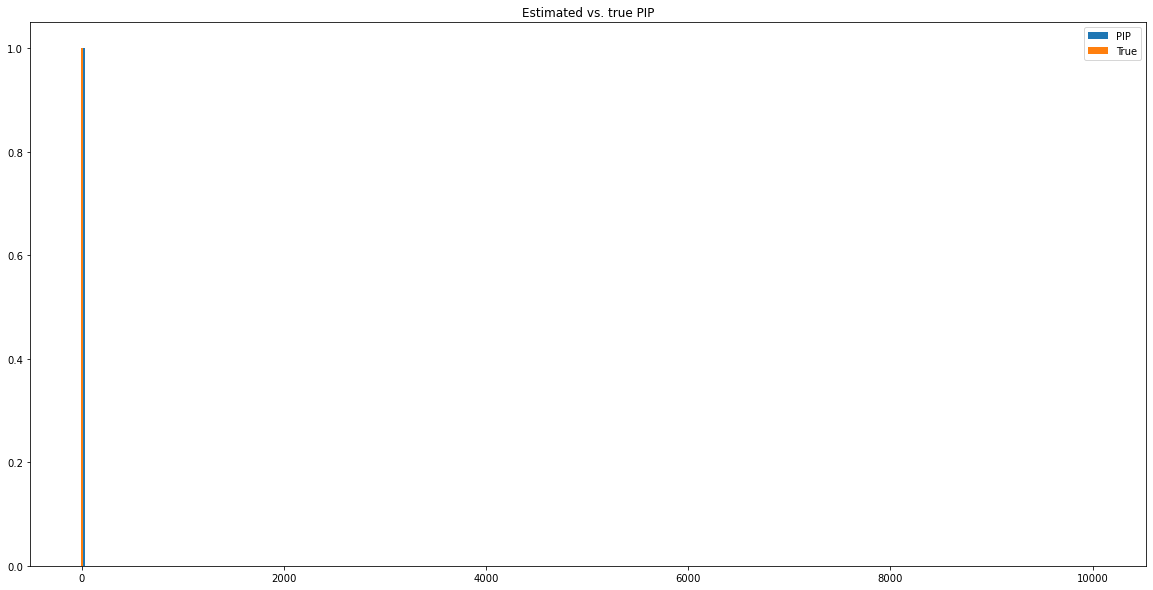

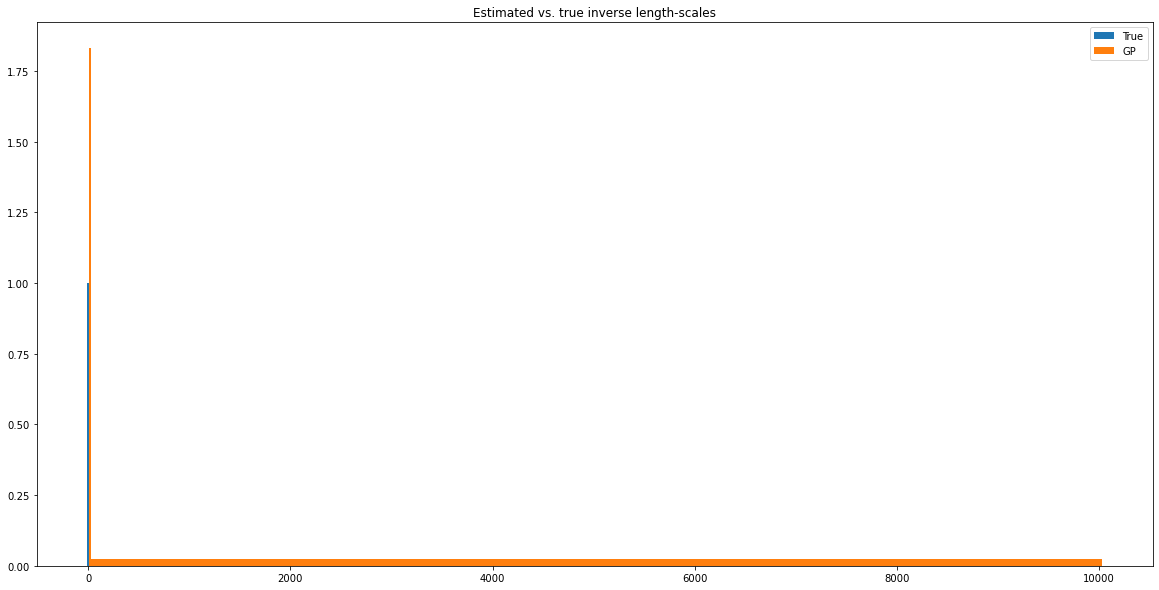

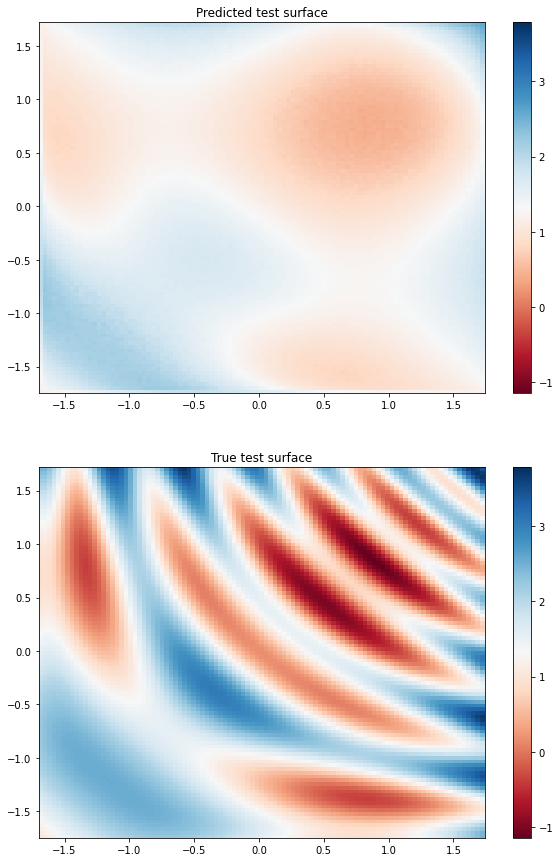

Latent test function MSE :  0.50375336
Observed test data  MSE :  0.7976085


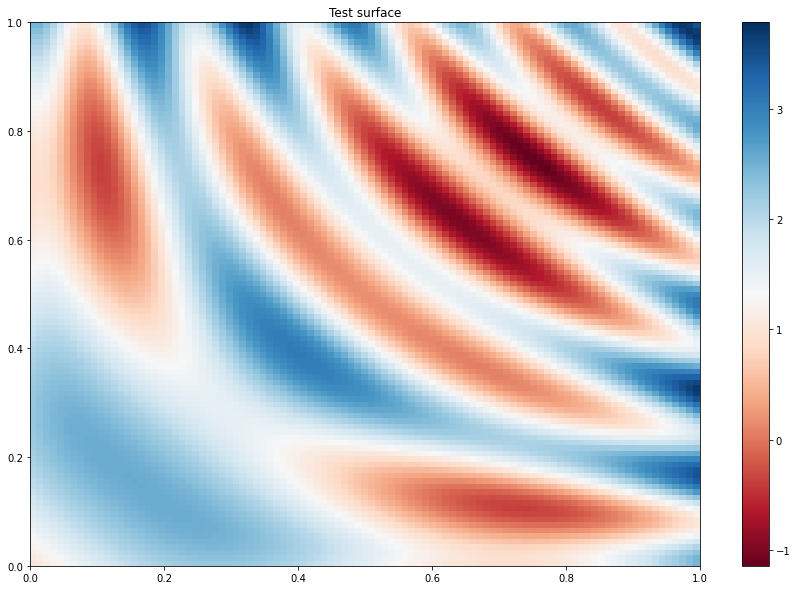

[20.894081 20.894094 20.894083 20.894073 20.894154 20.894087 20.894123
 20.89416  20.894154 20.894085]
3.085784912109375 0.0002294752
Iter 2 - Loss: 3.086
[20.9939   20.993845 20.993904 20.99387  20.99404  20.993898 20.993975
 20.994053 20.99403  20.993767]
3.082316176891327 0.00022757714
Iter 3 - Loss: 2.739
[21.09379  21.093416 21.09388  21.09389  21.093897 21.093924 21.093966
 21.09392  21.093756 21.093754]
3.076174774003029 0.00022554558
Iter 4 - Loss: 2.468
[21.193254 21.192259 21.193647 21.193766 21.193106 21.193825 21.193565
 21.193169 21.192728 21.193636]
3.0680650443332196 0.00022242889
Iter 5 - Loss: 2.265
[21.291513 21.28957  21.292461 21.292719 21.29086  21.292856 21.29198
 21.291018 21.290222 21.292538]
3.05847471543072 0.00021767216
Iter 6 - Loss: 2.109
[21.38765  21.384485 21.389439 21.389868 21.386354 21.390139 21.388412
 21.386656 21.38549  21.389555]
3.0477400673631743 0.00021121366
Iter 7 - Loss: 1.985
[21.480734 21.476202 21.483744 21.484398 21.478855 21.48482  21.4

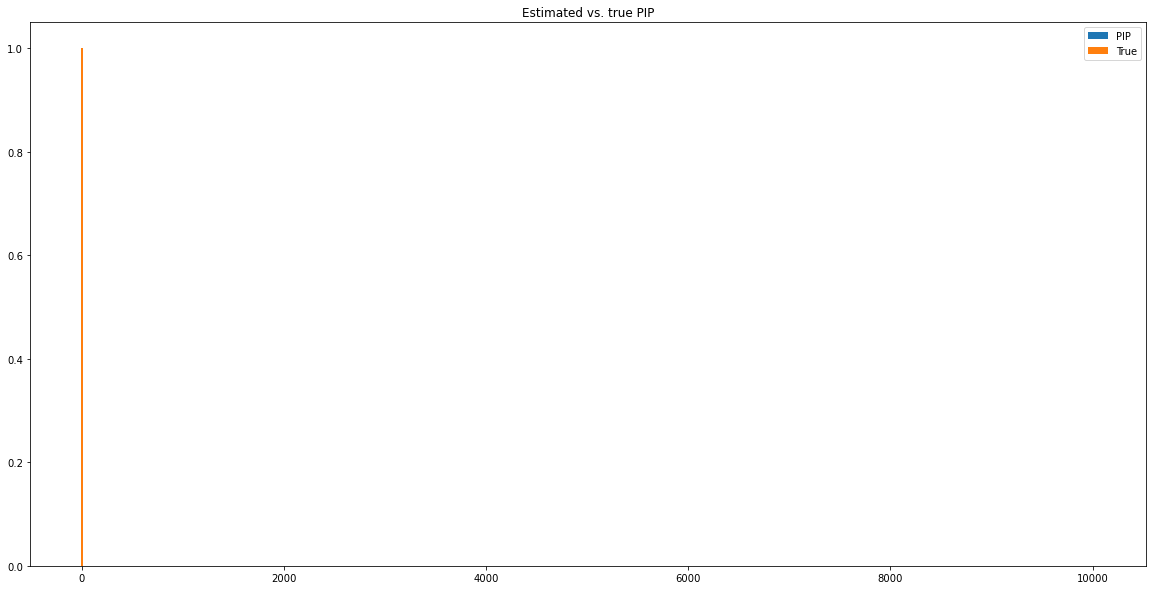

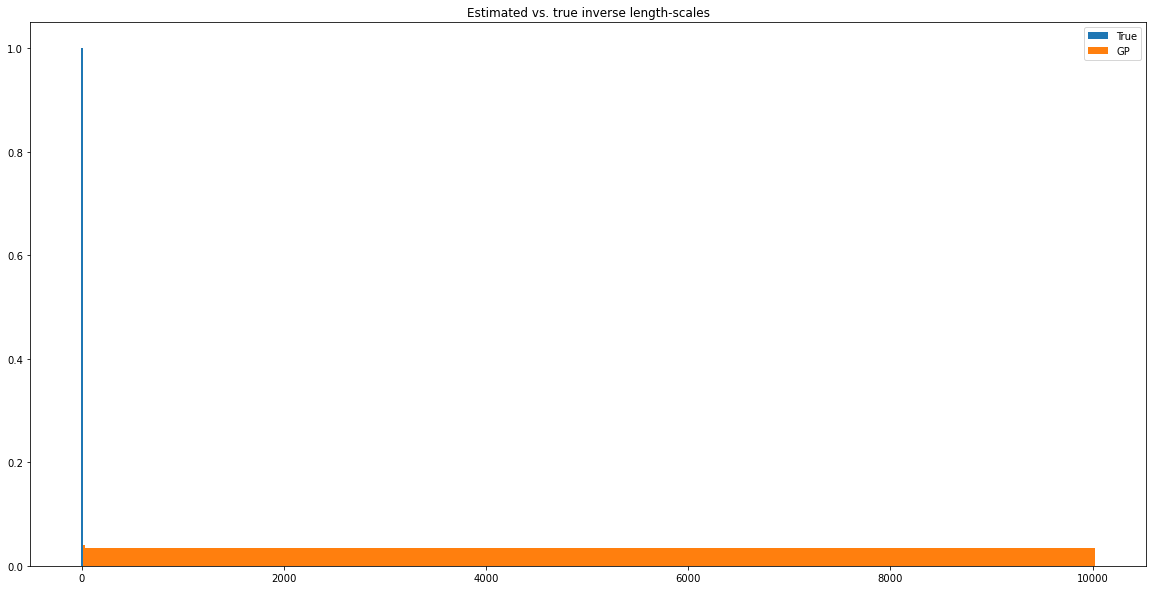

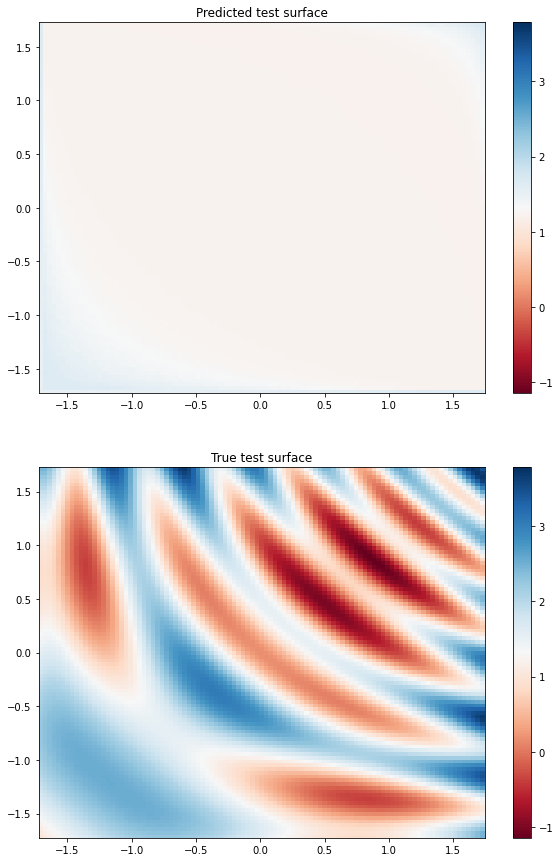

Latent test function MSE :  0.8624555
Observed test data  MSE :  1.1750494


[20.889263 20.889828 20.888828 20.890991 20.891205 20.891226 20.888075
 20.892326 20.892029 20.89137 ]
2.8666062355041504 0.00022169895


[20.994534 20.991049 20.991236 20.99615  20.995537 20.996716 20.988886
 20.99674  20.997366 20.997288]
2.863213350772858 0.00023762415


[21.10335  21.096344 21.098642 21.106745 21.103745 21.105804 21.095991
 21.106483 21.105362 21.109446]
2.857546069121361 0.00024385365


[21.211842 21.202906 21.205751 21.217472 21.209887 21.214256 21.201536
 21.21483  21.213022 21.221449]
2.8506693741848474 0.00023981424


[21.318502 21.307009 21.314993 21.327282 21.320192 21.32056  21.3065
 21.322735 21.317951 21.333551]
2.843539836223791 0.00023451967


[21.418549 21.404312 21.416286 21.43059  21.421038 21.42054  21.405478
 21.422768 21.416397 21.437492]
2.834743122849575 0.00021927747


[21.509464 21.493448 21.515821 21.527203 21.517677 21.516418 21.49878
 21.517128 21.513813 21.53872 ]
2.8250758755085608 0.00020500245


[21.596254 21.5767   21.605358 21.618372 21.60726  21.603867 21.587883
 21.607367 21.59935  21.631853]
2.8150195466278953 0.00019026965


[21.6792   21.657278 21.689594 21.705584 21.69126  21.68751  21.671854
 21.691158 21.683575 21.719416]
2.8050949721466476 0.00017745877


[21.75364  21.728079 21.769955 21.786112 21.769985 21.766132 21.749952
 21.76899  21.761047 21.802965]
2.794531586512095 0.0001660179


[21.821966 21.795769 21.846132 21.861881 21.844046 21.839348 21.822649
 21.844326 21.83284  21.88039 ]
2.783696867542192 0.00015378272


[21.883907 21.859821 21.917875 21.935106 21.914057 21.908514 21.892311
 21.913494 21.902254 21.95349 ]
2.7734337299481604 0.00014450456


[21.942787 21.914341 21.984592 22.002531 21.97813  21.969799 21.95691
 21.977324 21.965984 22.021664]
2.7625031591377076 0.00013357357


[21.995228 21.965982 22.044743 22.065166 22.039877 22.030243 22.016903
 22.039156 22.024961 22.084314]
2.751214754552861 0.00012457244


[22.043955 22.013575 22.104296 22.124216 22.098467 22.087057 22.073923
 22.096819 22.081041 22.147078]
2.739914860577889 0.00011833551


[22.089268 22.05666  22.161116 22.180927 22.153141 22.142115 22.129322
 22.15335  22.136877 22.205711]
2.7287612261265446 0.00011286168


[22.130745 22.09772  22.214663 22.234833 22.205816 22.19216  22.1825
 22.206335 22.189974 22.264196]
2.7174659000705708 0.00010698386


[22.169094 22.135109 22.267647 22.287853 22.256002 22.240652 22.232954
 22.258059 22.240597 22.317614]
2.706196298261714 0.00010228683


[22.206127 22.171455 22.316782 22.338257 22.304094 22.289465 22.280794
 22.307714 22.287992 22.367939]
2.6951979491706983 9.7480806e-05


[22.240486 22.203587 22.364801 22.386238 22.35135  22.335445 22.326366
 22.35574  22.335178 22.417854]
2.68434725728237 9.3589675e-05


[22.27241  22.2347   22.409922 22.432487 22.396145 22.379091 22.371475
 22.401663 22.380615 22.465714]
2.673206963353726 8.898509e-05


[22.29938  22.261623 22.453732 22.47854  22.43956  22.421423 22.416754
 22.447247 22.423822 22.51238 ]
2.662378308208028 8.6791035e-05


[22.325762 22.28812  22.497583 22.521194 22.479675 22.462011 22.458645
 22.49128  22.46554  22.555721]
2.6514340252289443 8.219311e-05


[22.351446 22.313238 22.540024 22.563814 22.520622 22.500061 22.498594
 22.533243 22.5068   22.600286]
2.6407468210163887 8.154949e-05


[22.376192 22.3396   22.582558 22.606041 22.56189  22.539696 22.540306
 22.574877 22.54835  22.643847]
2.630073381622448 8.096284e-05


[22.398714 22.361689 22.620918 22.645903 22.599329 22.577337 22.581848
 22.61584  22.587156 22.685707]
2.6195102242909036 7.589171e-05


[22.421318 22.382572 22.66283  22.686825 22.638182 22.614103 22.62261
 22.654854 22.624622 22.726946]
2.6088649963537196 7.575774e-05


[22.441875 22.404957 22.702019 22.726238 22.675394 22.65271  22.66116
 22.694736 22.662666 22.768377]
2.5988719632076567 7.3712035e-05


[22.463297 22.425388 22.741343 22.765474 22.712265 22.688644 22.699976
 22.732527 22.700468 22.807837]
2.5882745754866674 7.300217e-05


[22.481031 22.446133 22.778694 22.80174  22.747488 22.72462  22.738438
 22.771837 22.738071 22.84756 ]
2.577845404389241 7.206328e-05


[22.499872 22.464304 22.815329 22.84023  22.782352 22.758373 22.77589
 22.808388 22.774178 22.885986]
2.5677529568913693 6.957657e-05


[22.517403 22.484509 22.853365 22.877827 22.81705  22.793127 22.81359
 22.845705 22.80912  22.92408 ]
2.5575117023277962 6.949497e-05


[22.535425 22.499887 22.88946  22.913889 22.852192 22.826527 22.849367
 22.883162 22.844278 22.961288]
2.5475528353426653 6.746437e-05


[22.552574 22.518509 22.926819 22.95176  22.88727  22.861029 22.886963
 22.920147 22.879667 22.99984 ]
2.537708451036022 6.79712e-05


[22.569164 22.537483 22.963428 22.989279 22.920895 22.896294 22.924055
 22.957355 22.915947 23.037386]
2.527461310611737 6.824316e-05


[22.586674 22.55485  22.99968  23.024954 22.954357 22.929214 22.960112
 22.993044 22.949318 23.07466 ]
2.5175954733120465 6.5869404e-05


[22.603361 22.572006 23.035402 23.06038  22.988678 22.962555 22.99506
 23.02954  22.982876 23.110641]
2.507982584584633 6.513899e-05


[22.618721 22.58977  23.070278 23.09465  23.021095 22.995628 23.030924
 23.064575 23.01763  23.14752 ]
2.4984046143505876 6.4768e-05


[22.635248 22.60633  23.104914 23.129446 23.054815 23.028008 23.066093
 23.100548 23.051992 23.183348]
2.4887459189684953 6.455632e-05


[22.65155  22.622458 23.140795 23.16473  23.088894 23.060898 23.102993
 23.136845 23.086153 23.22075 ]
2.4792917938909778 6.45439e-05


[22.666016 22.641    23.176136 23.200363 23.121353 23.094084 23.138474
 23.171745 23.120283 23.256033]
2.4699174817565113 6.3722786e-05


[22.683504 22.656237 23.21021  23.235819 23.154654 23.127035 23.172344
 23.20635  23.152956 23.292118]
2.4605918361347316 6.2955114e-05


[22.698727 22.674038 23.245497 23.270084 23.186674 23.160723 23.207731
 23.241735 23.185982 23.327242]
2.4514851805831377 6.253722e-05


[22.713804 22.690737 23.279    23.304688 23.220797 23.192852 23.243948
 23.277212 23.219793 23.361546]
2.4428410024337697 6.220693e-05


[22.730322 22.70786  23.314018 23.340532 23.25501  23.225985 23.281597
 23.313446 23.253376 23.398443]
2.4334385848029254 6.393838e-05


[22.74608  22.724215 23.349922 23.375381 23.28719  23.258284 23.316965
 23.348364 23.28558  23.434668]
2.4243817527516645 6.2355386e-05


[22.762503 22.741676 23.385641 23.409378 23.31909  23.289885 23.351803
 23.382486 23.319351 23.47022 ]
2.4155214803844416 6.159216e-05


[22.778343 22.758736 23.419256 23.44357  23.351826 23.323694 23.386122
 23.417854 23.353104 23.505661]
2.407009292409363 6.204537e-05


[22.793709 22.77505  23.454178 23.478487 23.384771 23.356428 23.422255
 23.45255  23.385643 23.540426]
2.398277849235025 6.189084e-05


[22.810236 22.79296  23.489538 23.513254 23.417612 23.390205 23.457367
 23.487535 23.419758 23.576593]
2.389392850970336 6.223818e-05


[22.82641  22.80963  23.523937 23.54784  23.45027  23.422987 23.494009
 23.523283 23.452421 23.612206]
2.3808953899079133 6.130724e-05


[22.841278 22.827766 23.557795 23.581554 23.48235  23.454971 23.528719
 23.5585   23.485884 23.648245]
2.372289249157333 6.0866678e-05


[22.856953 22.844086 23.592714 23.61645  23.515163 23.48778  23.563805
 23.593481 23.517588 23.68392 ]
2.3638253555366093 6.119167e-05


[22.874197 22.861252 23.628963 23.650976 23.548012 23.521278 23.599548
 23.628883 23.552687 23.719114]
2.3554596895190087 6.172798e-05


[22.890457 22.88031  23.664934 23.68641  23.580942 23.554802 23.636572
 23.663723 23.586657 23.754646]
2.3468470746546872 6.137406e-05


[22.906246 22.89818  23.7006   23.72077  23.614702 23.58793  23.671976
 23.699009 23.618496 23.790537]
2.338924229594786 6.107921e-05


[22.92231  22.915731 23.734655 23.755634 23.647442 23.621506 23.708025
 23.73434  23.652561 23.82672 ]
2.3307996128481543 6.0753202e-05


[22.940313 22.934175 23.77051  23.791441 23.68147  23.657993 23.74422
 23.770245 23.687075 23.862446]
2.3231444008287885 6.20746e-05


[22.956291 22.953922 23.805458 23.825912 23.714113 23.691856 23.779465
 23.805319 23.720232 23.897705]
2.3151934312448628 6.0129863e-05


[22.973438 22.971598 23.840452 23.8601   23.747337 23.725477 23.8157
 23.8407   23.753765 23.932499]
2.3072368475793867 6.0767496e-05


[22.989052 22.989521 23.876223 23.895716 23.780218 23.758522 23.8513
 23.87638  23.788145 23.968563]
2.2993605974583904 6.0960978e-05


[23.005373 23.007038 23.911505 23.930832 23.813688 23.792671 23.888638
 23.9116   23.821262 24.004313]
2.291542086088299 6.086219e-05


[23.019974 23.026348 23.946857 23.966133 23.846663 23.82523  23.923685
 23.94683  23.854933 24.040272]
2.2837672463583973 5.9989332e-05


[23.03724  23.04433  23.981821 24.001133 23.880863 23.859575 23.961613
 23.982582 23.888342 24.076572]
2.2760489178908614 6.1070605e-05


[23.053333 23.061834 24.017778 24.036646 23.91333  23.894371 23.9968
 24.018671 23.923674 24.112505]
2.268334900069298 6.083965e-05


[23.069944 23.08069  24.054956 24.072315 23.947409 23.929848 24.032713
 24.054625 23.957407 24.149736]
2.2606825168736586 6.117929e-05


[23.087452 23.099842 24.090694 24.109234 23.982761 23.96492  24.069002
 24.091932 23.992317 24.186281]
2.2535583415080835 6.152766e-05


[23.10465  23.118345 24.12791  24.144236 24.017258 23.999378 24.10631
 24.12739  24.027933 24.222305]
2.246086676921967 6.152983e-05


[23.123055 23.137629 24.164122 24.181164 24.051239 24.03385  24.143806
 24.163563 24.061445 24.259645]
2.238787889487006 6.0834074e-05


[23.139885 23.15714  24.20084  24.216599 24.086052 24.069664 24.180584
 24.200424 24.096428 24.29604 ]
2.2316236710611914 6.1639876e-05


[23.15703  23.177101 24.237188 24.253666 24.120127 24.10558  24.218193
 24.237661 24.132395 24.333652]
2.2246646902862484 6.163576e-05


[23.174875 23.196823 24.272871 24.290638 24.15594  24.140324 24.2558
 24.273926 24.16709  24.370325]
2.217579757937219 6.106642e-05


[23.192251 23.215675 24.310158 24.326382 24.191635 24.175812 24.293583
 24.312069 24.20185  24.408987]
2.2103457242357156 6.2198174e-05


[23.209135 23.235651 24.349041 24.363922 24.226416 24.212605 24.330055
 24.349628 24.238083 24.445532]
2.2033205743835715 6.163341e-05


[23.22556  23.25515  24.3859   24.401407 24.261848 24.24903  24.368366
 24.386086 24.27453  24.484402]
2.196191693648128 6.1474726e-05


[23.245237 23.275415 24.423775 24.438679 24.297491 24.286615 24.407999
 24.423794 24.309582 24.522514]
2.1892363165332718 6.2682615e-05


[23.2631   23.294315 24.46     24.47414  24.332699 24.322369 24.444618
 24.460716 24.345303 24.559898]
2.182524320599308 6.0787777e-05


[23.281889 23.314867 24.49885  24.5116   24.368347 24.359285 24.482317
 24.500126 24.381113 24.597815]
2.1757847507255295 6.244185e-05


[23.300339 23.33489  24.536312 24.550032 24.403618 24.395893 24.521162
 24.5374   24.416885 24.636562]
2.168978371924405 6.19459e-05


[23.318583 23.35546  24.5753   24.588495 24.441582 24.434526 24.559803
 24.575628 24.453386 24.675182]
2.162181557336631 6.29844e-05


[23.337708 23.374474 24.613882 24.624708 24.476814 24.471157 24.598242
 24.613602 24.489113 24.714144]
2.1556369595805713 6.185005e-05


[23.354536 23.39362  24.650772 24.66306  24.514435 24.507185 24.636148
 24.651548 24.525208 24.751745]
2.1493752133597046 6.135869e-05


[23.37313  23.414228 24.690071 24.701534 24.550789 24.544798 24.676008
 24.690393 24.562609 24.792181]
2.142802301489474 6.3060856e-05


[23.390673 23.434486 24.728907 24.73944  24.588263 24.582254 24.714598
 24.729982 24.601395 24.831818]
2.1364112834222415 6.2266205e-05


[23.41058  23.454191 24.767591 24.77811  24.624928 24.621294 24.753822
 24.76908  24.638098 24.870968]
2.1303210730042483 6.2832776e-05


[23.42888  23.474789 24.807135 24.81587  24.661556 24.658884 24.793982
 24.806767 24.674223 24.909727]
2.1244833983917597 6.20201e-05


[23.44911  23.494793 24.84647  24.85504  24.697844 24.69633  24.831766
 24.846773 24.712088 24.949066]
2.117967409765737 6.289064e-05


[23.465277 23.515022 24.885523 24.894154 24.735264 24.734499 24.870735
 24.88499  24.749367 24.988995]
2.111732719388859 6.2236635e-05


[23.48315  23.536463 24.92624  24.934038 24.774189 24.772846 24.910934
 24.926601 24.789253 25.029905]
2.105565954910501 6.407687e-05


[23.500772 23.557516 24.965485 24.974009 24.811607 24.811197 24.949863
 24.965948 24.826946 25.07003 ]
2.099433332651969 6.2923566e-05


[23.520172 23.578127 25.005932 25.012756 24.849186 24.851538 24.990587
 25.006405 24.863895 25.110521]
2.09377345171612 6.285543e-05


[23.538563 23.597397 25.047873 25.053148 24.8888   24.890827 25.031858
 25.048525 24.902948 25.15126 ]
2.0876440966106564 6.460722e-05


[23.557976 23.620274 25.087427 25.093456 24.927538 24.930231 25.072372
 25.088356 24.942347 25.19216 ]
2.081621484789981 6.329211e-05


[23.576807 23.641054 25.127256 25.134527 24.967478 24.971394 25.114487
 25.129242 24.98183  25.23371 ]
2.076080078348911 6.443192e-05


[23.596487 23.663263 25.169252 25.174992 25.006853 25.011543 25.155579
 25.169182 25.022394 25.27558 ]
2.0704635672974017 6.396201e-05


[23.613642 23.684055 25.208954 25.21554  25.046114 25.05145  25.19544
 25.211151 25.060965 25.317867]
2.0648165407056958 6.409721e-05


[23.631605 23.703093 25.251598 25.25715  25.086401 25.091606 25.236872
 25.253082 25.10047  25.360195]
2.0589451380225614 6.4523774e-05


[23.64968  23.723808 25.293724 25.297977 25.12654  25.133032 25.277975
 25.293877 25.138765 25.401878]
2.0535177325979936 6.396238e-05


[23.666344 23.744747 25.335093 25.340336 25.166473 25.173937 25.321585
 25.336075 25.178368 25.444876]
2.047928167225749 6.514696e-05


[23.68212  23.763733 25.376526 25.380924 25.203499 25.21409  25.363068
 25.377375 25.217249 25.48652 ]
2.0422353674107914 6.2878404e-05


[23.703363 23.785583 25.419554 25.424042 25.244957 25.254835 25.405033
 25.419323 25.259739 25.529154]
2.0368009032649583 6.489242e-05


[23.723478 23.806173 25.462923 25.466684 25.287943 25.295805 25.447197
 25.462296 25.301233 25.572638]
2.0316514799619076 6.542847e-05


[23.741781 23.827679 25.504993 25.508488 25.32687  25.337078 25.488983
 25.505053 25.341654 25.61525 ]
2.0266638790893667 6.448627e-05


[23.759855 23.850153 25.548931 25.551672 25.367392 25.379463 25.532516
 25.547813 25.383532 25.66009 ]
2.02120578421899 6.610133e-05


[23.778751 23.87111  25.591454 25.595098 25.409472 25.42256  25.57603
 25.591087 25.424694 25.703485]
2.016001073245315 6.5432665e-05


[23.799187 23.890482 25.634296 25.63719  25.450186 25.463911 25.618279
 25.63441  25.46664  25.746838]
2.010814419236647 6.483958e-05


[23.815931 23.911837 25.678606 25.680153 25.4918   25.507462 25.660788
 25.677563 25.508142 25.791134]
2.0056498163326566 6.554824e-05


[23.83422  23.932112 25.723835 25.724333 25.535973 25.552847 25.705297
 25.721455 25.55141  25.83682 ]
2.00058111113808 6.728268e-05


[23.852118 23.952604 25.768772 25.76722  25.577812 25.5964   25.749376
 25.765772 25.590986 25.881632]
1.9955050869472468 6.611235e-05


[23.870443 23.972855 25.811914 25.811827 25.620995 25.640675 25.792807
 25.81118  25.634132 25.926746]
1.990484236126221 6.6237655e-05


[23.885578 23.992805 25.856907 25.85682  25.66298  25.681744 25.83601
 25.853865 25.677023 25.971573]
1.9856752833332876 6.538094e-05


[23.904509 24.013468 25.903477 25.90089  25.7057   25.725857 25.881937
 25.89915  25.71838  26.01727 ]
1.9803881039023594 6.6662025e-05


[23.922005 24.035547 25.949596 25.945889 25.748703 25.77139  25.927198
 25.944008 25.76216  26.063332]
1.9758926888209776 6.696456e-05


[23.93983  24.055182 25.996565 25.99176  25.79325  25.817194 25.971008
 25.989614 25.805817 26.109215]
1.9713681989215985 6.664579e-05


[23.957777 24.072927 26.04228  26.037348 25.83799  25.862234 26.016842
 26.035858 25.848595 26.155222]
1.966575996157541 6.699944e-05


[23.974146 24.092299 26.087908 26.082369 25.88146  25.907597 26.063269
 26.080706 25.893398 26.202244]
1.9617587772173126 6.6655564e-05


[23.99119  24.111637 26.135216 26.128687 25.926773 25.952621 26.108177
 26.126553 25.937555 26.249561]
1.956838323939921 6.7474844e-05


[24.008627 24.130033 26.181036 26.175184 25.972073 25.998682 26.153118
 26.173294 25.981436 26.296906]
1.9526114776992707 6.787434e-05


[24.025108 24.151562 26.228025 26.221823 26.01741  26.046425 26.20052
 26.220293 26.027607 26.343935]
1.948072482358542 6.799207e-05


[24.044298 24.172472 26.276081 26.269377 26.0616   26.09317  26.247297
 26.268461 26.072803 26.391785]
1.9433964581479783 6.823144e-05


[24.060461 24.190023 26.3238   26.31525  26.106632 26.138004 26.292141
 26.31408  26.117727 26.43916 ]
1.9391789704837654 6.695292e-05


[24.076235 24.210312 26.371988 26.3635   26.152025 26.184904 26.339535
 26.362051 26.162909 26.487795]
1.9348465374683808 6.794974e-05


[24.09464  24.229864 26.420288 26.409801 26.199234 26.23288  26.3869
 26.410099 26.208366 26.536274]
1.9303740527093127 6.809359e-05


[24.109585 24.24861  26.469463 26.457169 26.245325 26.281763 26.433508
 26.458054 26.253157 26.585896]
1.9257834409873802 6.848647e-05


[24.125315 24.266857 26.518623 26.505665 26.292307 26.330175 26.481457
 26.505949 26.300943 26.635332]
1.921528645222297 6.8742724e-05


[24.142536 24.285797 26.56808  26.555487 26.3407   26.37882  26.530035
 26.554935 26.347178 26.685902]
1.9176320898396388 6.938233e-05


[24.160746 24.30724  26.617691 26.604044 26.388102 26.427526 26.579899
 26.60266  26.395414 26.736782]
1.9134242881520578 6.863377e-05


[24.174652 24.324207 26.665964 26.652746 26.433903 26.476458 26.627714
 26.651417 26.441856 26.78529 ]
1.9095260558219898 6.8276015e-05


[24.189972 24.342556 26.71707  26.702782 26.481537 26.525803 26.677053
 26.700834 26.489187 26.837538]
1.905568937372687 7.064777e-05


[24.20527  24.362291 26.766562 26.752571 26.529938 26.573914 26.725714
 26.751066 26.536854 26.888536]
1.9014950733506752 6.962711e-05


[24.218086 24.379036 26.817142 26.802328 26.578487 26.622946 26.77452
 26.800558 26.585302 26.939718]
1.8976644571336938 6.9235975e-05


[24.23193  24.397472 26.868313 26.854403 26.627962 26.673777 26.825083
 26.85077  26.633196 26.991995]
1.8939386193708285 6.963124e-05


[24.249746 24.414913 26.921919 26.90536  26.678734 26.724913 26.873476
 26.902859 26.68283  27.04483 ]
1.8899958845881766 7.09939e-05


[24.266594 24.430735 26.973576 26.95706  26.727459 26.776472 26.925282
 26.954323 26.730654 27.097296]
1.8863263859092259 7.07322e-05


[24.280958 24.448942 27.025478 27.006916 26.777311 26.827614 26.97637
 27.00534  26.781315 27.150023]
1.8825721902054224 7.0293994e-05


[24.293062 24.46339  27.078062 27.06006  26.82783  26.878363 27.027256
 27.057173 26.831156 27.20406 ]
1.8784721474625325 7.118006e-05


[24.304937 24.480564 27.130747 27.110725 26.87791  26.930712 27.077703
 27.108746 26.881355 27.256372]
1.8746072875430067 7.0229675e-05


[24.319078 24.496845 27.183882 27.162815 26.929068 26.9846   27.127579
 27.160807 26.931822 27.309776]
1.8710505142510117 7.11224e-05


[24.332863 24.512468 27.237019 27.21743  26.980982 27.03752  27.1819
 27.214216 26.983528 27.362774]
1.8674005185517848 7.1847055e-05


[24.345747 24.52885  27.29306  27.27217  27.033634 27.092808 27.235554
 27.266861 27.035269 27.418764]
1.8636743151946513 7.3008465e-05


[24.357302 24.543016 27.3469   27.324738 27.085236 27.144167 27.287659
 27.319586 27.085464 27.473795]
1.860044265644313 7.0684386e-05


[24.366442 24.557493 27.401075 27.378654 27.13746  27.196676 27.34022
 27.372793 27.13678  27.528307]
1.8562049716790472 7.126389e-05


[24.374811 24.572645 27.455086 27.431192 27.18882  27.250391 27.39219
 27.426989 27.189264 27.583761]
1.8525661762137369 7.1953575e-05


[24.386614 24.585983 27.511414 27.48555  27.24193  27.304737 27.445965
 27.481367 27.24073  27.641804]
1.8491695453945163 7.273275e-05


[24.396227 24.599773 27.566025 27.539824 27.292505 27.359652 27.497005
 27.533789 27.292583 27.69635 ]
1.8465443274300426 7.105305e-05


[24.404528 24.613382 27.622112 27.595892 27.347702 27.41516  27.553354
 27.590664 27.347622 27.753145]
1.8431450131249345 7.328572e-05


[24.410313 24.625393 27.677757 27.652792 27.40246  27.469349 27.608837
 27.644741 27.400173 27.811157]
1.8396747353359855 7.250346e-05


[24.419104 24.636507 27.735655 27.70964  27.457237 27.526777 27.66514
 27.702536 27.452944 27.868261]
1.8362058329838462 7.345443e-05


[24.42706  24.647839 27.794538 27.765854 27.512035 27.583582 27.719292
 27.758472 27.507864 27.927626]
1.8327346087471015 7.313272e-05


[24.433805 24.656996 27.850327 27.82     27.566778 27.638758 27.771921
 27.815893 27.562979 27.985071]
1.829152766323647 7.258253e-05


[24.442856 24.669212 27.910118 27.878622 27.620808 27.696388 27.82984
 27.87216  27.6179   28.044123]
1.8257322708984172 7.3723415e-05


[24.448818 24.678732 27.967436 27.936062 27.675175 27.753077 27.88624
 27.929464 27.671362 28.101315]
1.8225751221396282 7.299194e-05


[24.450157 24.68752  28.026552 27.994015 27.73148  27.811901 27.943102
 27.98759  27.728153 28.16297 ]
1.8190165004348335 7.485068e-05


[24.451654 24.697117 28.08557  28.052534 27.78832  27.870516 27.99908
 28.043432 27.78291  28.221563]
1.8158819036487164 7.378204e-05


[24.453913 24.706469 28.1463   28.110516 27.84622  27.931479 28.057272
 28.103283 27.840101 28.28228 ]
1.8128624951079872 7.445047e-05


[24.457108 24.709867 28.206121 28.170456 27.904278 27.990894 28.114367
 28.161959 27.897514 28.343657]
1.810032832749986 7.522371e-05


[24.457699 24.716536 28.265562 28.229883 27.96003  28.049322 28.170538
 28.222063 27.953838 28.404757]
1.806783144719422 7.407414e-05


[24.460392 24.719036 28.325823 28.288263 28.018503 28.109232 28.22949
 28.28152  28.011528 28.466635]
1.8034545965955158 7.448565e-05


[24.45588  24.723454 28.38636  28.349525 28.076563 28.1681   28.288448
 28.339705 28.068916 28.52768 ]
1.8003407776441023 7.43365e-05


[24.4581   24.729313 28.447544 28.411585 28.135641 28.230396 28.34828
 28.400642 28.129128 28.590729]
1.7975575136626747 7.586124e-05


[24.453339 24.730133 28.510336 28.471828 28.194664 28.290901 28.408333
 28.460966 28.188702 28.654396]
1.7946938832014934 7.50097e-05


[24.447313 24.729826 28.573439 28.533363 28.255247 28.353487 28.467054
 28.522293 28.248198 28.719587]
1.7914259805099202 7.591286e-05


[24.440664 24.724037 28.634895 28.596165 28.313648 28.414879 28.52613
 28.583752 28.306599 28.78378 ]
1.7885134706971917 7.5383185e-05


[24.433208 24.724552 28.699543 28.65801  28.375456 28.47709  28.58644
 28.64517  28.367662 28.847279]
1.7854692452328498 7.628575e-05


[24.426624 24.725468 28.763548 28.72151  28.435818 28.539877 28.646168
 28.708857 28.42647  28.910357]
1.782463038965595 7.59307e-05


[24.41377  24.72463  28.827438 28.78393  28.495731 28.602674 28.707756
 28.77148  28.485558 28.975758]
1.779477424775051 7.613199e-05


[24.402582 24.717123 28.89099  28.847017 28.555145 28.664118 28.768719
 28.834993 28.547249 29.041086]
1.7764610690682552 7.531355e-05


[24.3915   24.710213 28.955181 28.911411 28.616663 28.726984 28.830568
 28.897287 28.608677 29.106274]
1.7736246979615418 7.665678e-05


[24.379238 24.705347 29.022932 28.978443 28.67958  28.791857 28.894516
 28.963886 28.67193  29.17282 ]
1.7712949975746388 7.732728e-05


[24.358479 24.692558 29.087559 29.041739 28.741535 28.855492 28.955214
 29.026201 28.734886 29.237848]
1.7687253276281891 7.531966e-05


[24.332155 24.680698 29.15217  29.106451 28.802092 28.921265 29.019201
 29.08874  28.797934 29.302807]
1.7660993348137144 7.584255e-05


[24.317421 24.664082 29.220213 29.171295 28.865662 28.987654 29.08201
 29.154568 28.86163  29.371216]
1.7635124920278638 7.675303e-05


[24.291964 24.653337 29.28776  29.235613 28.930676 29.053015 29.14786
 29.223333 28.924541 29.440468]
1.7608186481878312 7.8139325e-05


[24.270851 24.635237 29.354652 29.300781 28.99469  29.120863 29.209541
 29.288181 28.986837 29.507992]
1.758115543693334 7.620553e-05


[24.242184 24.61318  29.4225   29.368338 29.055264 29.187588 29.275238
 29.354294 29.050398 29.578032]
1.7555765430453716 7.698838e-05


[24.208746 24.592556 29.492205 29.436628 29.11938  29.253256 29.342379
 29.419912 29.11475  29.647116]
1.7529516803344156 7.731064e-05


[24.172012 24.565508 29.560417 29.502111 29.185173 29.320051 29.403519
 29.484537 29.179081 29.716127]
1.7502038937060898 7.624131e-05


[24.133623 24.534182 29.62655  29.570026 29.25024  29.38614  29.469933
 29.55174  29.242233 29.784004]
1.7478731239474194 7.682712e-05


[24.092344 24.502247 29.696867 29.637403 29.314451 29.454962 29.533852
 29.61818  29.30949  29.853483]
1.7450590891629472 7.71307e-05


[24.05119  24.468992 29.764582 29.705572 29.378426 29.522818 29.601746
 29.687948 29.375034 29.923313]
1.7424935459454967 7.746092e-05


[24.004805 24.435257 29.835463 29.773987 29.445518 29.592396 29.66638
 29.75689  29.440687 29.993675]
1.739800374087345 7.7802404e-05


[23.954681 24.40229  29.904675 29.841812 29.512424 29.66281  29.733322
 29.82483  29.508495 30.065126]
1.7374585346111504 7.694508e-05


[23.900715 24.35869  29.976305 29.910572 29.575994 29.732023 29.800177
 29.893272 29.575157 30.136845]
1.7348907312722561 7.691852e-05


[23.844051 24.316738 30.04611  29.980927 29.643335 29.800308 29.868422
 29.961603 29.641956 30.207785]
1.7321873038770597 7.710588e-05


[23.78166  24.262918 30.11808  30.049803 29.709549 29.868176 29.934866
 30.029924 29.706425 30.278765]
1.7295496072832965 7.638643e-05


[23.711351 24.20404  30.188797 30.118237 29.775696 29.938967 30.000677
 30.099195 29.772045 30.349552]
1.7271908837953789 7.571204e-05


[23.637297 24.141323 30.25975  30.18718  29.841043 30.005888 30.069492
 30.169199 29.840332 30.421999]
1.7248344853734559 7.679732e-05


[23.559778 24.076384 30.331308 30.25931  29.907236 30.078505 30.136398
 30.238081 29.905327 30.493706]
1.722280099279029 7.6420394e-05


[23.479755 24.01588  30.404615 30.33115  29.97527  30.14806  30.20434
 30.309032 29.975605 30.564411]
1.7199355164602192 7.625133e-05


[23.399681 23.949335 30.475134 30.399755 30.043463 30.22077  30.270271
 30.3792   30.04264  30.637827]
1.7175141959826594 7.6369026e-05


[23.3046   23.876535 30.547638 30.469486 30.108225 30.290457 30.339464
 30.4498   30.110191 30.711102]
1.7151884342775785 7.6030105e-05


[23.216925 23.80268  30.620691 30.542843 30.179913 30.36167  30.409084
 30.520607 30.181868 30.787638]
1.7132970949501378 7.721817e-05


[23.109419 23.712563 30.693674 30.61427  30.248028 30.432034 30.476536
 30.590996 30.248224 30.860754]
1.7110259187107957 7.5683376e-05


[23.003029 23.617966 30.764841 30.685211 30.315407 30.502607 30.547215
 30.660858 30.316807 30.933218]
1.7088719335562805 7.524905e-05


[22.891424 23.52595  30.8394   30.756567 30.383682 30.576708 30.61488
 30.732855 30.387255 31.007236]
1.7068102496954949 7.539926e-05


[22.779797 23.423077 30.915054 30.828428 30.454973 30.650429 30.684917
 30.806486 30.45641  31.08214 ]
1.7047015612038194 7.663351e-05


[22.656067 23.318026 30.98848  30.902119 30.520271 30.722752 30.754904
 30.877974 30.526403 31.15672 ]
1.702803988741348 7.5162636e-05


[22.520052 23.209925 31.05982  30.97506  30.589672 30.795687 30.823832
 30.951166 30.59659  31.230562]
1.700600072236503 7.542497e-05


[22.375528 23.095537 31.135372 31.04844  30.660212 30.866163 30.894657
 31.024195 30.667551 31.306097]
1.698453803903588 7.489612e-05


[22.22842  22.9611   31.207312 31.117846 30.725412 30.939426 30.960545
 31.095243 30.733948 31.378866]
1.6962359923583874 7.3635565e-05


[22.07445  22.826803 31.280363 31.190765 30.795029 31.011961 31.030926
 31.167454 30.803652 31.454731]
1.693884427217442 7.396043e-05


[21.902172 22.686134 31.354902 31.26154  30.864935 31.085836 31.098282
 31.238003 30.872066 31.528744]
1.6919409015964668 7.316275e-05


[21.73711  22.542963 31.430357 31.336115 30.934471 31.15864  31.170204
 31.307213 30.941156 31.602474]
1.6898563483754085 7.375725e-05


[21.560875 22.391714 31.501816 31.408094 31.004799 31.232351 31.23939
 31.382105 31.010641 31.67824 ]
1.6874671659474862 7.3858544e-05


[21.38597  22.239634 31.578213 31.48205  31.074749 31.302944 31.310246
 31.454214 31.082397 31.755049]
1.6854115298181016 7.359273e-05


[21.194809 22.075771 31.652554 31.556465 31.144243 31.375051 31.379763
 31.52572  31.152334 31.829102]
1.6838193805099873 7.202312e-05


[20.977316 21.890175 31.725767 31.630322 31.208624 31.447155 31.447165
 31.59892  31.22082  31.906155]
1.6822199533751143 7.211357e-05


[20.774946 21.707376 31.799587 31.70212  31.281551 31.523966 31.518833
 31.67216  31.291893 31.981724]
1.6803249110049832 7.399704e-05


[20.566021 21.520403 31.87442  31.773945 31.34822  31.595549 31.58931
 31.744482 31.360693 32.054375]
1.6783974827701011 7.121556e-05


[20.352564 21.330914 31.950176 31.847738 31.419579 31.671606 31.658024
 31.817728 31.432283 32.1297  ]
1.6764007813493826 7.222796e-05


[20.11944  21.135132 32.024525 31.922033 31.488148 31.743616 31.73197
 31.890842 31.50548  32.205894]
1.6744996315929108 7.216765e-05


[19.879547 20.907118 32.100067 31.992516 31.555151 31.816622 31.800837
 31.962734 31.575245 32.28114 ]
1.6726638967420542 7.0812755e-05


[19.628872 20.687078 32.17195  32.06321  31.620556 31.888153 31.867477
 32.03366  31.642588 32.355244]
1.6710818026144927 6.855271e-05


[19.379982 20.450062 32.24667  32.13798  31.691196 31.962091 31.937431
 32.106636 31.711866 32.431274]
1.6692990298611747 7.042899e-05


[19.109724 20.218405 32.31845  32.211323 31.757584 32.033096 32.005722
 32.178333 31.779295 32.50477 ]
1.6677647560027637 6.81555e-05


[18.851662 19.994925 32.393913 32.28574  31.82824  32.106926 32.077488
 32.25322  31.851236 32.579723]
1.6658483954166894 7.1271774e-05


[18.57218  19.741814 32.46987  32.35703  31.892603 32.17986  32.14525
 32.327904 31.918798 32.65408 ]
1.6640031295792828 6.842824e-05


[18.28694  19.49306  32.542023 32.429794 31.961285 32.251778 32.21377
 32.399685 31.98817  32.73017 ]
1.6619311660725677 6.852963e-05


[18.001526 19.223309 32.612698 32.499382 32.027668 32.324356 32.281246
 32.4701   32.05583  32.801666]
1.6602281468408124 6.588604e-05


[17.71213  18.954834 32.684303 32.57028  32.09575  32.395306 32.351955
 32.54232  32.12462  32.877045]
1.6582990817153302 6.781589e-05


[17.40399  18.6866   32.758804 32.643414 32.160995 32.468372 32.42069
 32.61464  32.192986 32.951855]
1.6565051786705463 6.724979e-05


[17.100454 18.398909 32.8335   32.71503  32.226303 32.53775  32.485626
 32.68536  32.259975 33.025524]
1.654638472545004 6.536584e-05


[16.794312 18.116655 32.90682  32.78398  32.292408 32.61065  32.551815
 32.756138 32.329998 33.099003]
1.6529271736883895 6.570486e-05


[16.47367  17.839424 32.97761  32.855686 32.361027 32.68017  32.623505
 32.829357 32.398254 33.172096]
1.6515638305537241 6.572122e-05


[16.157068 17.537693 33.047398 32.92583  32.423923 32.75078  32.689014
 32.897984 32.464264 33.24516 ]
1.6500172908161497 6.352717e-05


[15.8430805 17.252523  33.11926   32.998344  32.490803  32.823727
 32.757103  32.969044  32.532696  33.318573 ]
1.6488430158400407 6.5048655e-05


[15.517811 16.948153 33.190186 33.070328 32.557182 32.893936 32.823647
 33.04136  32.599182 33.393105]
1.6472752709729304 6.466948e-05


[15.1871605 16.64327   33.26529   33.13881   32.623196  32.96672
 32.893703  33.110287  32.66792   33.464314 ]
1.6458169795421165 6.40832e-05


[14.856507 16.321938 33.33613  33.209984 32.689625 33.035362 32.959133
 33.178425 32.736725 33.539726]
1.6444303889646061 6.329489e-05


[14.515488 16.012354 33.406887 33.280094 32.75464  33.10636  33.027493
 33.250942 32.804615 33.61427 ]
1.6423694309173216 6.3380765e-05


[14.163094 15.682104 33.47714  33.34909  32.81582  33.174355 33.093803
 33.32293  32.87218  33.685566]
1.640660177907587 6.1471364e-05


[13.821203 15.359872 33.54917  33.417015 32.879322 33.248665 33.160984
 33.393738 32.94038  33.75774 ]
1.6388588992047592 6.1958126e-05


[13.465235  15.0294485 33.61824   33.487114  32.943092  33.318554
 33.223038  33.462536  33.005875  33.829803 ]
1.637322702886204 6.0404593e-05


[13.111555 14.695574 33.68713  33.555264 33.00997  33.38666  33.288612
 33.53129  33.068783 33.90115 ]
1.6358331049409753 6.14867e-05


[12.746996 14.367025 33.756763 33.625    33.076035 33.45751  33.355133
 33.59781  33.133904 33.973007]
1.6346679763871406 6.0058166e-05


[12.370609 14.026168 33.82809  33.694427 33.138924 33.527607 33.418953
 33.666405 33.198254 34.042088]
1.6329426545410548 5.9362526e-05


[12.003195 13.691471 33.900852 33.761093 33.19782  33.59753  33.48158
 33.735855 33.2635   34.11438 ]
1.631531945141564 6.0019684e-05


[11.619497 13.33276  33.96797  33.826912 33.25587  33.662693 33.543396
 33.80455  33.32567  34.18557 ]
1.630110553264306 5.825032e-05


[11.245452 12.987931 34.03579  33.895832 33.323887 33.732506 33.611492
 33.870968 33.39065  34.253544]
1.6289052586218609 5.8477937e-05


[10.87573  12.643452 34.107296 33.96524  33.388443 33.804615 33.678303
 33.94245  33.45716  34.326584]
1.6275366755581184 6.031781e-05


[10.49848  12.2774   34.175125 34.03236  33.450775 33.872284 33.74244
 34.010612 33.521812 34.39892 ]
1.6261888367070476 5.8011603e-05


[10.105185 11.912308 34.243942 34.10042  33.509865 33.939396 33.808456
 34.078583 33.586224 34.46809 ]
1.6243698714089774 5.779841e-05


[ 9.712544 11.534643 34.31159  34.165134 33.57086  34.006794 33.870358
 34.144783 33.649906 34.53619 ]
1.6232885846230645 5.742098e-05


[ 9.299736 11.163298 34.379414 34.22819  33.632755 34.06988  33.93215
 34.212082 33.71023  34.602604]
1.6223733212000058 5.4792272e-05


[ 8.898234 10.782143 34.445045 34.295242 33.692863 34.136936 33.99799
 34.281815 33.774815 34.673115]
1.6210973957768546 5.6724817e-05


[ 8.487061 10.401795 34.513935 34.36187  33.7542   34.202652 34.059784
 34.347755 33.838356 34.741486]
1.6197517522767735 5.674321e-05


[ 8.073096 10.013861 34.58304  34.427265 33.81279  34.269337 34.120285
 34.41634  33.90391  34.80974 ]
1.618521467696587 5.5806482e-05


[ 7.6436663  9.629164  34.649796  34.494007  33.874435  34.336475
 34.18643   34.482086  33.96853   34.876987 ]
1.617333947511961 5.6214547e-05


[ 7.214848  9.21729  34.714935 34.559566 33.93599  34.404213 34.24652
 34.547752 34.032494 34.94433 ]
1.6160964126423254 5.5369306e-05


[ 6.754211  8.820909 34.782185 34.626606 33.996513 34.469547 34.31248
 34.614094 34.094616 35.01404 ]
1.614561776268969 5.6348566e-05


[ 6.286149  8.4017   34.851814 34.691658 34.05393  34.536095 34.376034
 34.678608 34.15872  35.082928]
1.6132212894648363 5.558053e-05


[ 5.8049192  7.9612303 34.917667  34.75861   34.115795  34.600517
 34.43874   34.745613  34.21786   35.150635 ]
1.6120774155174842 5.522388e-05


[ 5.3248067  7.522478  34.987896  34.822636  34.177563  34.669933
 34.502125  34.811615  34.279686  35.220135 ]
1.610755606816411 5.607601e-05


[ 4.818117   7.0770564 35.05558   34.890087  34.238308  34.733433
 34.56718   34.87737   34.33987   35.287537 ]
1.6094078714479387 5.6203044e-05


[ 4.289979  6.616204 35.11939  34.956184 34.299892 34.799572 34.628296
 34.946358 34.403305 35.355827]
1.6077134452145383 5.639437e-05


[ 3.7524774  6.1444945 35.186344  35.026012  34.36163   34.867268
 34.692436  35.012875  34.46874   35.42539  ]
1.606003143733966 5.916792e-05


[ 3.1996284  5.6621013 35.256718  35.09216   34.421097  34.93661
 34.756916  35.083405  34.533714  35.49594  ]
1.604428539437816 6.0820872e-05


[ 2.6276488  5.1506886 35.325443  35.162094  34.48087   35.00592
 34.82254   35.15302   34.599823  35.566666 ]
1.603050007884838 6.3216234e-05


[ 2.0698633  4.615513  35.397213  35.23399   34.550915  35.080624
 34.89058   35.226387  34.66798   35.64413  ]
1.6023704814120994 7.045738e-05


[ 1.545577   4.0521774 35.476376  35.310818  34.61989   35.155846
 34.968723  35.29994   34.739754  35.717583 ]
1.6012255073719042 8.036617e-05


[ 1.0831681  3.490743  35.56165   35.390587  34.698185  35.24086
 35.04686   35.385708  34.81914   35.80063  ]
1.5999052309911936 9.8254095e-05


[ 0.7500677  2.9682019 35.652996  35.48981   34.788525  35.33818
 35.141083  35.479347  34.911785  35.89489  ]
1.59869243761721 0.0001234456


[ 0.6355476  2.5263326 35.767265  35.604282  34.89899   35.453354
 35.254658  35.590675  35.02589   36.008377 ]
1.5968941748163552 0.00012268333


[ 0.6427406  2.1078837 35.89405   35.733074  35.024223  35.583443
 35.38056   35.714485  35.151035  36.13235  ]
1.5953395220658417 0.000112503025


[ 0.6566016  1.6672771 36.028675  35.873554  35.162624  35.727127
 35.522163  35.847054  35.290245  36.26451  ]
1.5938701115539693 0.00012657433


[ 0.67747694  1.2242143  36.17452    36.018436   35.307392   35.878162
 35.669334   35.988037   35.435806   36.406197  ]
1.5925046793288105 0.00014308475


[ 0.7135531   0.89822334 36.329876   36.174862   35.464317   36.03831
 35.828857   36.13885    35.590458   36.557114  ]
1.5911293516307525 0.00016222203


[ 0.7538361  0.7924957 36.492733  36.341938  35.63276   36.20917
 35.995823  36.29896   35.76004   36.71873  ]
1.5900670688203928 0.00015371437


[ 0.75742584  0.78181696 36.670223   36.51677    35.80917    36.390804
 36.1729     36.46936    35.938477   36.88949   ]
1.5886403692606528 0.00014009188


[ 0.74792606  0.76413053 36.851116   36.699276   35.996708   36.57608
 36.359913   36.648872   36.12285    37.069     ]
1.5871784612650677 0.0001473249


[ 0.73874515  0.722012   37.0365     36.89062    36.18601    36.772152
 36.552914   36.83412    36.315426   37.25545   ]
1.5856349692606782 0.00015515508


[ 0.71993786  0.7455387  37.230984   37.085636   36.38263    36.971603
 36.747913   37.026443   36.51218    37.44448   ]
1.5837054725095845 0.00015584924


[ 0.69797266  0.71505815 37.432465   37.287636   36.584427   37.18096
 36.953922   37.222584   36.714672   37.640453  ]
1.5823444321601752 0.0001611313


[ 0.6973008  0.7183378 37.641533  37.494694  36.7972    37.393784
 37.163063  37.424232  36.92267   37.842884 ]
1.5806724191606711 0.00015391041


[ 0.68612623  0.6908192  37.852524   37.70783    37.007126   37.6113
 37.378273   37.634037   37.135746   38.051258  ]
1.5788929435900514 0.00016297903


[ 0.6679496  0.6934356 38.066116  37.923717  37.22283   37.82757
 37.59158   37.84368   37.349087  38.256145 ]
1.5769155130345371 0.00015870194


[ 0.66962385  0.6780659  38.280304   38.13743    37.437675   38.04664
 37.81071    38.0588     37.566216   38.47049   ]
1.5750831433637102 0.0001582865


[ 0.6614189   0.65860623 38.493137   38.35558    37.658875   38.268707
 38.031128   38.27696    37.781815   38.680435  ]
1.5734335179942973 0.00015993461


[ 0.6754185  0.6571372 38.71267   38.57385   37.88071   38.492905
 38.25287   38.492393  37.999527  38.895855 ]
1.5712969918906634 0.00015657295


[ 0.65502614  0.6407087  38.931175   38.79337    38.102238   38.71583
 38.470646   38.71454    38.22046    39.111835  ]
1.5698652161818092 0.00015854859


[ 0.64513326  0.65862054 39.15284    39.011147   38.322105   38.94204
 38.697247   38.93544    38.442345   39.32661   ]
1.5681537762010824 0.00015624164


[ 0.643965    0.63795024 39.365665   39.22556    38.534912   39.159237
 38.912678   39.149036   38.657944   39.536304  ]
1.5662375401434785 0.00014902728


[ 0.64025545  0.6303675  39.577328   39.440613   38.7502     39.37855
 39.130127   39.364952   38.87407    39.75052   ]
1.5647351946301966 0.00014528788


[ 0.63377327  0.6276315  39.788418   39.650116   38.960827   39.592636
 39.341087   39.575916   39.084316   39.956806  ]
1.5630166041661333 0.00013945074


[ 0.6242981  0.6167311 39.993507  39.85581   39.16876   39.802235
 39.54795   39.78285   39.293198  40.162086 ]
1.5611157600811065 0.00013925805


[ 0.62720436  0.6256274  40.195545   40.058292   39.373543   40.009438
 39.75629    39.984413   39.497833   40.36256   ]
1.5594136443618567 0.0001338938


[ 0.6231246   0.60350156 40.39123    40.256565   39.571293   40.21073
 39.953854   40.18707    39.693615   40.559494  ]
1.557300042471766 0.00013153446


[ 0.62721056  0.6117209  40.585346   40.44633    39.76586    40.407486
 40.15098    40.382668   39.893696   40.749985  ]
1.555396741477514 0.00012497939


[ 0.61109686  0.5969208  40.771847   40.62876    39.953377   40.596672
 40.3365     40.570564   40.081966   40.93862   ]
1.5536315063530068 0.00012454184


[ 0.6142569  0.6066113 40.952553  40.811207  40.136654  40.78519
 40.52375   40.757412  40.265945  41.118584 ]
1.5516297777190726 0.000115913346


[ 0.6121035  0.587169  41.13299   40.989635  40.318928  40.9682
 40.704155  40.943172  40.447525  41.299103 ]
1.5497347839770685 0.0001159237


[ 0.5996246  0.5941533 41.30528   41.15972   40.490982  41.14729
 40.879143  41.120747  40.625404  41.473553 ]
1.5479823959685357 0.0001109622


[ 0.6046682   0.59410125 41.474453   41.328465   40.661156   41.32159
 41.050976   41.2959     40.797455   41.644917  ]
1.5461413509337922 0.00010387181


[ 0.592907    0.57968646 41.642338   41.49609    40.8331     41.49001
 41.222958   41.466118   40.965954   41.81122   ]
1.5442402957103583 0.00010694162


[ 0.5983727  0.5797965 41.804382  41.65509   40.997143  41.656754
 41.385494  41.633774  41.12567   41.973152 ]
1.5421507565418593 9.800301e-05


[ 0.58235025  0.5789222  41.963345   41.813316   41.149784   41.819904
 41.547176   41.792767   41.287025   42.132164  ]
1.540394786810608 9.734627e-05


[ 0.5861601  0.5744166 42.12039   41.97413   41.308296  41.979263
 41.706017  41.953762  41.44785   42.291935 ]
1.5384508742665988 9.417093e-05


[ 0.5825943   0.58970755 42.27475    42.124767   41.458523   42.132015
 41.861217   42.10806    41.60136    42.44277   ]
1.537005514903663 9.364726e-05


[ 0.57777846  0.55954903 42.42294    42.26973    41.61436    42.287853
 42.013477   42.264797   41.750683   42.596027  ]
1.5349953616596863 9.69514e-05


[ 0.5769694  0.5724883 42.568176  42.41658   41.76278   42.435738
 42.160896  42.415657  41.900322  42.745358 ]
1.5332175918905169 8.767873e-05
Runtime is  8578.175775527954
Test MSE: 0.8168931603431702
Latent test function MSE :  [0.50709045 0.4934465  0.50375336 0.50997627 0.        ]
Test time is :  [11.14253306 11.00236177 10.98524809 11.54528093  0.        ]


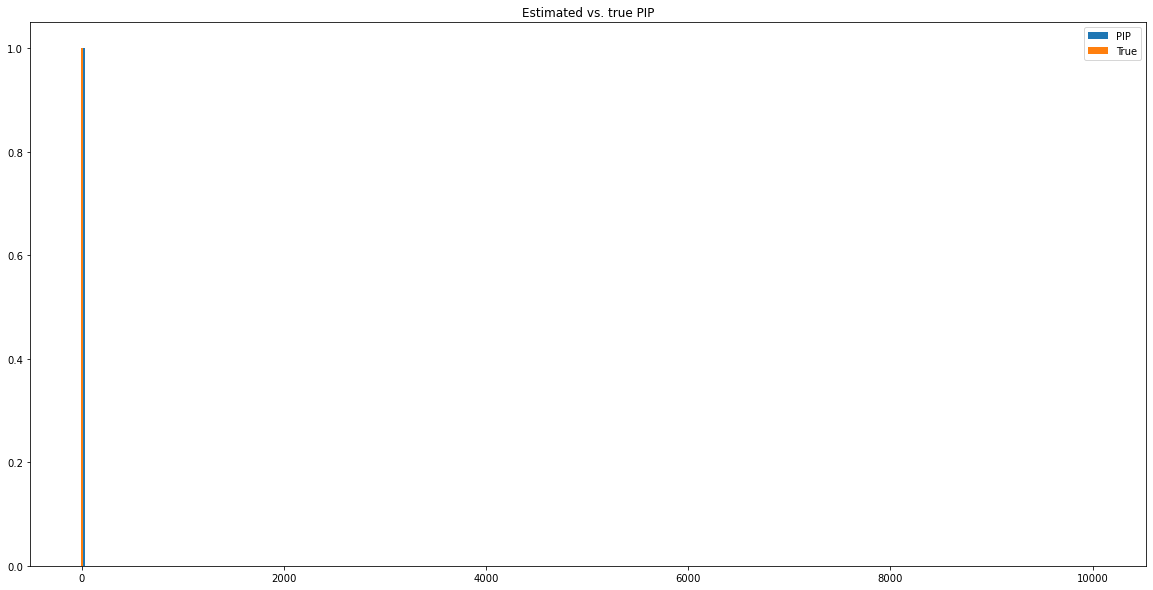

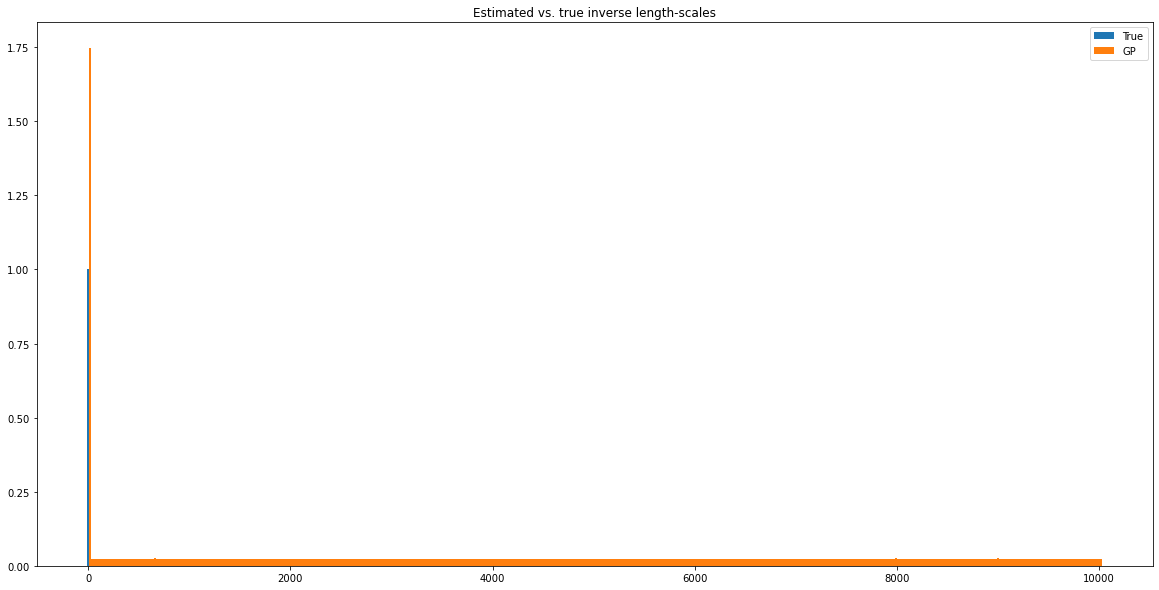

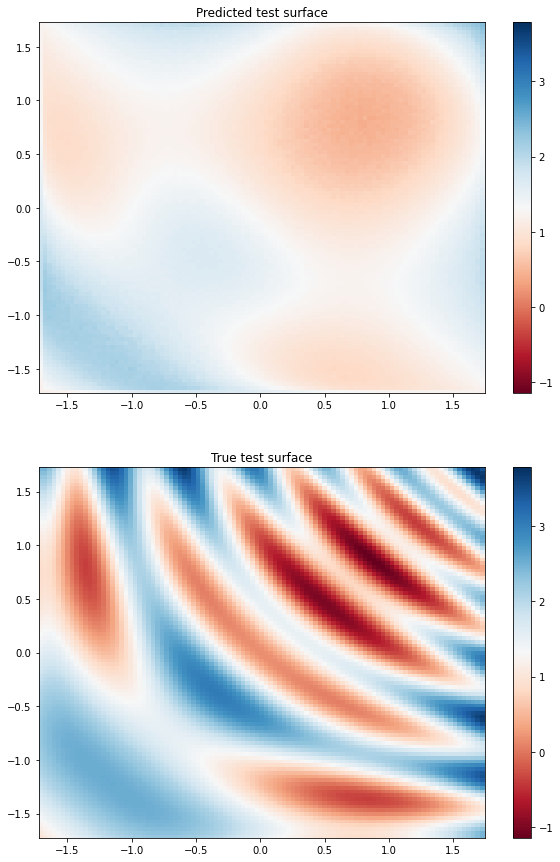

Latent test function MSE :  0.50997627
Observed test data  MSE :  0.81689316


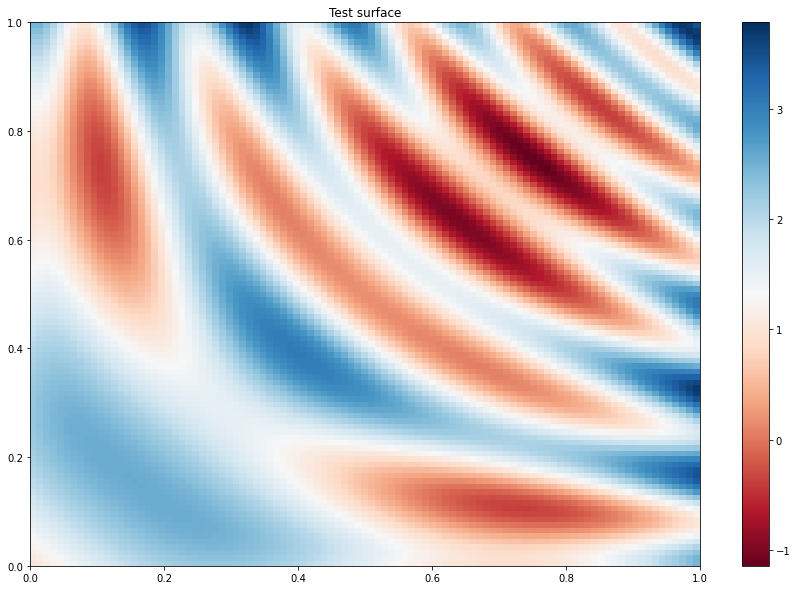

[20.89405  20.894035 20.894184 20.89405  20.89416  20.894087 20.894114
 20.894064 20.894085 20.89414 ]
3.075430154800415 0.0002294164
Iter 2 - Loss: 3.075
[20.993843 20.993763 20.993475 20.993832 20.993864 20.99391  20.99373
 20.99382  20.993883 20.993935]
3.0720164895057676 0.00022746458
Iter 3 - Loss: 2.734
[21.093744 21.09353  21.092558 21.093842 21.093029 21.093895 21.092947
 21.093657 21.093672 21.093433]
3.0659611486196514 0.00022535284
Iter 4 - Loss: 2.466
[21.193356 21.193052 21.191364 21.193844 21.191208 21.19368  21.191502
 21.193344 21.193098 21.192196]
3.0579534622204303 0.00022254806
Iter 5 - Loss: 2.265
[21.292149 21.291718 21.289429 21.293192 21.287842 21.292673 21.288904
 21.292292 21.291576 21.289911]
3.0484790716221215 0.00021849203
Iter 6 - Loss: 2.111
[21.389334 21.388622 21.38582  21.390974 21.382126 21.390076 21.384369
 21.389622 21.388296 21.386116]
3.0378672574474193 0.00021270022
Iter 7 - Loss: 1.987
[21.483868 21.482767 21.479387 21.486246 21.473263 21.48495  

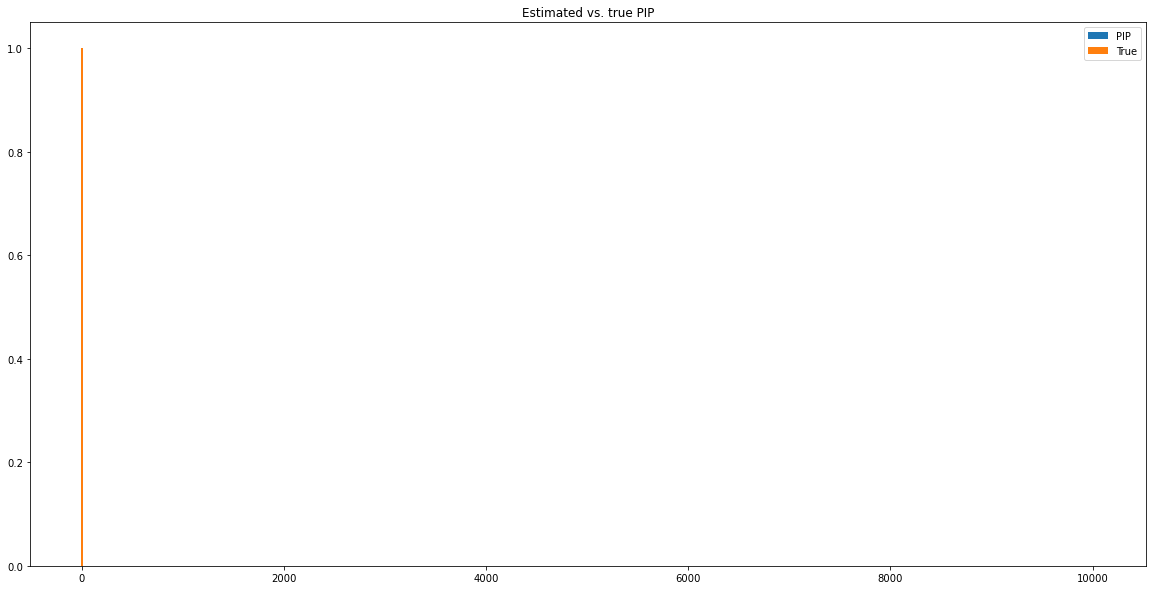

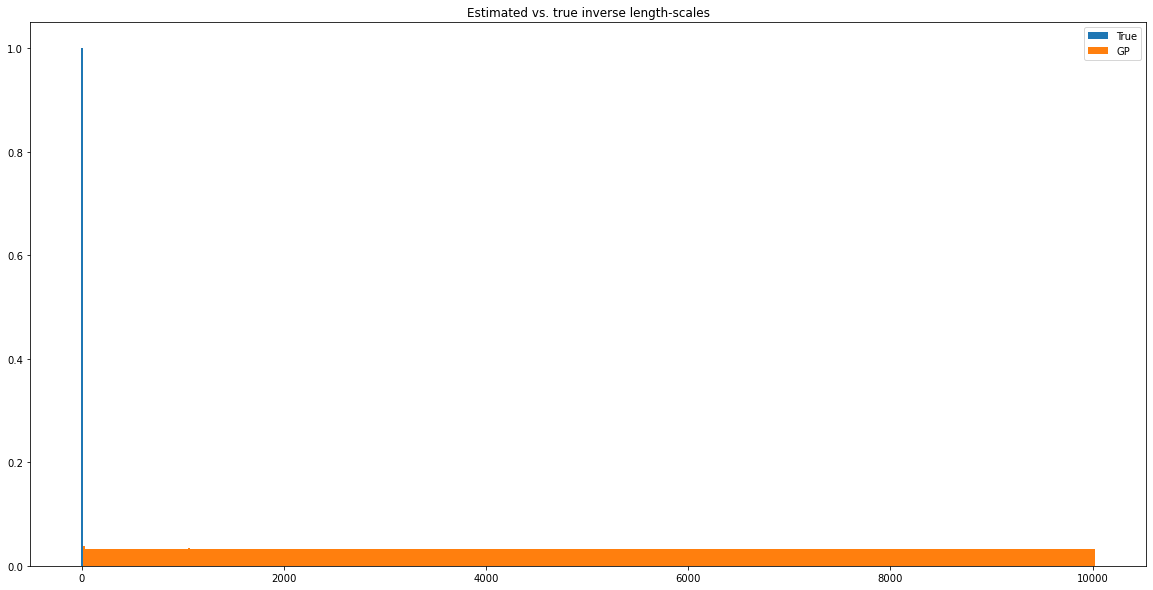

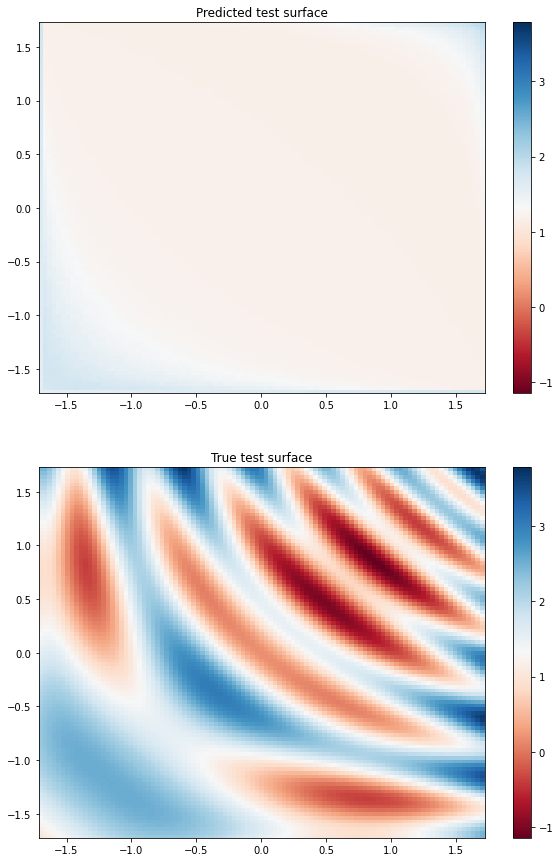

Latent test function MSE :  0.84000134
Observed test data  MSE :  1.1270697


[20.893148 20.892908 20.89248  20.891714 20.894117 20.892376 20.893784
 20.890484 20.892418 20.893703]
2.8275160789489746 0.00022597858


[20.995651 20.997112 20.989439 20.993797 20.9992   20.996275 20.998596
 20.994434 20.996264 20.996916]
2.824944603443146 0.00023496237


[21.101633 21.103867 21.081417 21.101795 21.104225 21.104452 21.104616
 21.100529 21.104656 21.097994]
2.8204454816579823 0.00023770015


[21.2061   21.208637 21.168167 21.210794 21.208292 21.211031 21.20772
 21.204878 21.211304 21.199148]
2.8143246955502037 0.00023308289


[21.30647  21.307661 21.248777 21.3132   21.308916 21.315514 21.30741
 21.306126 21.310913 21.295118]
2.806950181619299 0.00022198503


[21.400953 21.40271  21.324324 21.411825 21.400927 21.412394 21.397327
 21.401632 21.404768 21.385159]
2.7987031890918943 0.00020657125


[21.490324 21.493    21.394539 21.50651  21.490524 21.506386 21.482243
 21.493208 21.49695  21.472013]
2.789185674431963 0.00019505432


[21.576365 21.577734 21.460361 21.59143  21.5757   21.593699 21.561455
 21.581146 21.581697 21.553001]
2.7802307652717952 0.00018175758


[21.65746  21.654823 21.523548 21.676542 21.64977  21.676445 21.63637
 21.66106  21.661018 21.62836 ]
2.769911143661863 0.00016791158


[21.730408 21.72804  21.584412 21.754004 21.723757 21.753435 21.707947
 21.734703 21.736164 21.69915 ]
2.759366446879022 0.00015837346


[21.797203 21.794827 21.640034 21.825846 21.789694 21.825289 21.774494
 21.802586 21.804783 21.76685 ]
2.7488611253152766 0.0001453859


[21.860218 21.855812 21.69489  21.894833 21.851276 21.89345  21.837475
 21.869421 21.871536 21.826956]
2.7383455279399924 0.0001365722


[21.91767  21.912415 21.744665 21.958773 21.910398 21.96031  21.89568
 21.933372 21.934338 21.886768]
2.7278500795861755 0.0001291973


[21.971712 21.965353 21.792315 22.021105 21.964918 22.019756 21.95072
 21.994026 21.992426 21.942713]
2.7170129168526005 0.00012065709


[22.022772 22.014503 21.839779 22.081192 22.019857 22.07996  22.002676
 22.0522   22.048151 21.997072]
2.706496834457985 0.00011615872


[22.072166 22.059887 21.88423  22.136341 22.069847 22.136248 22.051676
 22.106592 22.09959  22.048811]
2.695792884532671 0.00010786751


[22.11557  22.101545 21.92713  22.190044 22.115953 22.188742 22.09911
 22.156097 22.14966  22.09624 ]
2.6850791251609922 0.00010215618


[22.15903  22.141092 21.968857 22.241571 22.162533 22.239292 22.14615
 22.207476 22.197674 22.143785]
2.6744519540856975 9.895415e-05


[22.199635 22.177557 22.008324 22.291426 22.204859 22.288057 22.188623
 22.252598 22.244057 22.187569]
2.663569498906413 9.386165e-05


[22.237669 22.212343 22.047781 22.338087 22.248047 22.335865 22.229784
 22.298431 22.288961 22.22914 ]
2.6526777497543694 9.099735e-05


[22.272736 22.245577 22.086046 22.385605 22.288898 22.379763 22.27336
 22.343586 22.33207  22.271105]
2.6418614155151112 8.682371e-05


[22.30684  22.276384 22.12256  22.428421 22.328115 22.42419  22.313599
 22.387337 22.371883 22.312208]
2.6316956218517507 8.44776e-05


[22.340456 22.304216 22.157488 22.47001  22.366615 22.467745 22.35131
 22.428751 22.412546 22.350382]
2.6212884017896965 8.085015e-05


[22.371267 22.332853 22.192797 22.513145 22.402802 22.508917 22.387333
 22.469242 22.451628 22.388844]
2.6108479510527447 7.94093e-05


[22.40056  22.36018  22.226513 22.553051 22.438171 22.549196 22.422571
 22.509476 22.490976 22.425148]
2.6000806711786764 7.701349e-05


[22.42835  22.38464  22.25978  22.59281  22.472849 22.589298 22.45832
 22.547064 22.527313 22.460602]
2.5898690526134804 7.352238e-05


[22.456974 22.409573 22.293428 22.631533 22.509136 22.628794 22.491188
 22.585184 22.564491 22.496185]
2.5801618601284986 7.370462e-05


[22.484726 22.433405 22.326069 22.670164 22.544474 22.667719 22.526651
 22.622448 22.602308 22.530592]
2.5697520121284865 7.290623e-05


[22.510405 22.455765 22.358246 22.706743 22.576838 22.704395 22.561394
 22.66068  22.637754 22.56569 ]
2.559433895836776 7.0753464e-05


[22.53532  22.478527 22.39053  22.743647 22.61066  22.742155 22.596966
 22.698948 22.67321  22.599358]
2.5493669316228234 7.0423615e-05


[22.561758 22.501162 22.422096 22.78098  22.644709 22.779852 22.630772
 22.736277 22.70835  22.632183]
2.539532923599625 6.9830705e-05


[22.584854 22.522593 22.453001 22.818209 22.677574 22.817953 22.663794
 22.771233 22.74325  22.665148]
2.5298896416639676 6.812915e-05


[22.608063 22.543234 22.484615 22.853106 22.70825  22.85518  22.696598
 22.807451 22.778366 22.698298]
2.5203501537212962 6.7278714e-05


[22.632475 22.563517 22.515781 22.888126 22.742918 22.890728 22.729921
 22.84324  22.813154 22.731165]
2.5103280434232493 6.710474e-05


[22.656282 22.583967 22.547295 22.922977 22.77659  22.926394 22.763092
 22.879456 22.848852 22.763973]
2.500853833986255 6.695617e-05


[22.678297 22.604052 22.578325 22.958303 22.808277 22.96091  22.79488
 22.915478 22.883501 22.796045]
2.491440123775207 6.508248e-05


[22.701828 22.624651 22.608706 22.993544 22.839521 22.99731  22.827389
 22.951166 22.917374 22.828808]
2.482123015914377 6.560182e-05


[22.724213 22.643906 22.63781  23.026814 22.869402 23.03211  22.85887
 22.985826 22.949528 22.85913 ]
2.4733065317154685 6.3345746e-05


[22.746742 22.664865 22.667465 23.061596 22.903572 23.066309 22.891665
 23.022291 22.983738 22.891146]
2.4642581151505265 6.49312e-05


[22.767874 22.685371 22.697918 23.09675  22.934975 23.101133 22.923746
 23.057112 23.018713 22.92307 ]
2.4550497955594612 6.383961e-05


[22.790792 22.705276 22.727879 23.130245 22.966629 23.13576  22.956059
 23.092018 23.053741 22.955418]
2.446326245292923 6.37567e-05


[22.811172 22.72381  22.757689 23.163162 22.997307 23.170725 22.98717
 23.126284 23.088411 22.985643]
2.437452247471265 6.2679115e-05


[22.834408 22.743074 22.787004 23.19732  23.030556 23.205126 23.020336
 23.161001 23.12169  23.017227]
2.4284344218406533 6.296071e-05


[22.857506 22.7638   22.818441 23.232067 23.063002 23.241299 23.053738
 23.196873 23.15483  23.04779 ]
2.4193907766750575 6.380468e-05


[22.878761 22.783987 22.848206 23.266205 23.095324 23.27546  23.086481
 23.23184  23.189436 23.080462]
2.410737397205731 6.289123e-05


[22.901714 22.804127 22.87729  23.300917 23.126966 23.310078 23.118855
 23.266293 23.223679 23.11292 ]
2.402287218086503 6.2589774e-05


[22.925043 22.823252 22.907198 23.334595 23.157839 23.343554 23.151102
 23.300034 23.257046 23.143873]
2.394097364923811 6.1549e-05


[22.945768 22.843172 22.93518  23.367933 23.191088 23.378387 23.182377
 23.336813 23.290768 23.174873]
2.385480675112845 6.221574e-05


[22.968695 22.863243 22.965523 23.401873 23.224245 23.413195 23.21374
 23.371899 23.324057 23.206564]
2.3770266583378366 6.202861e-05


[22.991539 22.88459  22.994677 23.435179 23.255024 23.446943 23.246367
 23.406965 23.357924 23.238024]
2.368320004215548 6.188194e-05


[23.014006 22.905373 23.02511  23.469263 23.287308 23.482271 23.280186
 23.442287 23.392206 23.270348]
2.359949285099906 6.256366e-05


[23.036226 22.925467 23.053513 23.502922 23.319698 23.517868 23.312193
 23.47839  23.426605 23.301952]
2.3516082570621397 6.1939434e-05


[23.05811  22.94572  23.081718 23.53796  23.353367 23.55158  23.344568
 23.513178 23.460663 23.334124]
2.3430409276100335 6.127255e-05


[23.081327 22.966942 23.11255  23.572517 23.385603 23.586523 23.377594
 23.548685 23.495253 23.367868]
2.334876072523615 6.273431e-05


[23.102787 22.987806 23.14223  23.606852 23.419455 23.622171 23.411674
 23.58422  23.528963 23.399477]
2.3270235717261287 6.165258e-05


[23.127357 23.009687 23.170963 23.641205 23.453281 23.657293 23.445225
 23.619812 23.564442 23.430843]
2.3190226643646565 6.298975e-05


[23.150465 23.02921  23.19955  23.674725 23.484316 23.691793 23.478392
 23.654924 23.597565 23.464132]
2.3118620316655596 6.0066282e-05


[23.171747 23.051504 23.229435 23.71087  23.520288 23.7273   23.511835
 23.69024  23.632732 23.497076]
2.3042768419252284 6.2893116e-05


[23.194767 23.071918 23.259457 23.74475  23.552261 23.76197  23.546156
 23.726627 23.667511 23.529028]
2.296153708563425 6.105858e-05


[23.218182 23.09346  23.289074 23.778685 23.586575 23.796545 23.579247
 23.763186 23.702318 23.561893]
2.2882299489016495 6.206342e-05


[23.242125 23.114616 23.318281 23.812449 23.619667 23.832006 23.611877
 23.798788 23.736685 23.594261]
2.2804507857136738 6.1388644e-05


[23.266273 23.137186 23.347687 23.847998 23.653519 23.867926 23.646276
 23.835419 23.772348 23.627516]
2.272724816512772 6.318894e-05


[23.290304 23.158476 23.376364 23.883137 23.688833 23.903395 23.68056
 23.871664 23.807476 23.660616]
2.2651571955468173 6.156818e-05


[23.31389  23.181934 23.407162 23.918463 23.723358 23.938196 23.714642
 23.908915 23.84184  23.692516]
2.258080943119929 6.165386e-05


[23.336899 23.20384  23.437397 23.955566 23.755827 23.973013 23.748827
 23.945606 23.878454 23.72509 ]
2.251060575897973 6.18929e-05


[23.360653 23.226013 23.467493 23.990324 23.791847 24.010082 23.784908
 23.98225  23.914564 23.759289]
2.2437153420338296 6.3245796e-05


[23.38595  23.249485 23.497799 24.026001 23.826296 24.045929 23.819855
 24.01977  23.95075  23.791956]
2.236611150888043 6.223865e-05


[23.409033 23.271051 23.526384 24.061556 23.861174 24.081543 23.85508
 24.055628 23.986958 23.825743]
2.229386097347302 6.209167e-05


[23.433533 23.295025 23.55768  24.097925 23.896547 24.118624 23.88973
 24.093264 24.023815 23.859583]
2.222242271993565 6.27959e-05


[23.456404 23.318237 23.588148 24.13404  23.93136  24.154753 23.925615
 24.130058 24.058678 23.89209 ]
2.215520055028863 6.1588704e-05


[23.48107  23.341211 23.619383 24.169903 23.967447 24.192097 23.962313
 24.167694 24.09543  23.926668]
2.2089859599110846 6.314243e-05


[23.506433 23.364933 23.650839 24.20804  24.003532 24.22899  23.999008
 24.206402 24.133131 23.960411]
2.201543532877663 6.3312116e-05


[23.531488 23.387714 23.681452 24.245855 24.039904 24.266336 24.036116
 24.24461  24.170937 23.995853]
2.1948702782777985 6.4336506e-05


[23.55603  23.41201  23.713482 24.282116 24.07707  24.303938 24.070429
 24.284754 24.20792  24.031199]
2.1879615952456155 6.340994e-05


[23.581167 23.435379 23.744602 24.319613 24.11293  24.341253 24.107418
 24.321756 24.245308 24.066496]
2.1814006018822707 6.2752035e-05


[23.604813 23.4591   23.774658 24.357124 24.150473 24.38006  24.145449
 24.36278  24.283154 24.100946]
2.1749738484326464 6.425413e-05


[23.629532 23.48264  23.80586  24.394432 24.186653 24.41783  24.181536
 24.400318 24.320875 24.136122]
2.168428454936189 6.255205e-05


[23.655264 23.505177 23.836086 24.433096 24.224873 24.455494 24.21843
 24.439962 24.358952 24.172138]
2.161897171933687 6.372986e-05


[23.679865 23.528894 23.869965 24.472359 24.260378 24.494001 24.256292
 24.477999 24.396393 24.206684]
2.155426049535716 6.352985e-05


[23.70633  23.553661 23.900871 24.509481 24.299482 24.531471 24.293983
 24.5178   24.434135 24.24347 ]
2.1488860273979022 6.403045e-05


[23.729897 23.578566 23.932528 24.547997 24.336647 24.569305 24.329824
 24.557003 24.471497 24.277397]
2.1428120011464453 6.331747e-05


[23.75544  23.602797 23.96486  24.586016 24.374117 24.607834 24.367926
 24.596258 24.511023 24.31313 ]
2.136682450337404 6.3982756e-05


[23.7809   23.629274 23.99923  24.626694 24.412466 24.646475 24.406551
 24.636858 24.550709 24.351421]
2.1307873787160334 6.500624e-05


[23.80703  23.654018 24.030767 24.665537 24.450312 24.685715 24.44341
 24.678623 24.58944  24.387611]
2.124575770006464 6.380458e-05


[23.835596 23.678888 24.063454 24.704971 24.488804 24.725807 24.483345
 24.718363 24.628664 24.42482 ]
2.1187379941789577 6.531976e-05


[23.858788 23.703608 24.096874 24.74355  24.526731 24.764776 24.521177
 24.75721  24.66556  24.461529]
2.112863265632966 6.3151194e-05


[23.885082 23.728302 24.131115 24.783308 24.566458 24.804867 24.55932
 24.798674 24.705532 24.498823]
2.106780794389829 6.4778964e-05


[23.91115  23.75332  24.1642   24.823662 24.60601  24.844292 24.5997
 24.83982  24.745728 24.537077]
2.100848789668587 6.4989355e-05


[23.937977 23.779408 24.197548 24.863958 24.646572 24.883402 24.63822
 24.880493 24.78578  24.57433 ]
2.094772763748906 6.485074e-05


[23.963675 23.805653 24.232695 24.904642 24.686922 24.92407  24.677275
 24.921957 24.825758 24.613213]
2.0885323749213844 6.509438e-05


[23.991539 23.830904 24.26637  24.944382 24.726624 24.964481 24.718313
 24.96282  24.865791 24.650438]
2.082860699252996 6.5154185e-05


[24.017977 23.854515 24.299908 24.98515  24.765417 25.004501 24.756203
 25.005568 24.907413 24.686611]
2.077458189176665 6.460387e-05


[24.045265 23.88082  24.3346   25.026018 24.805756 25.044954 24.795341
 25.047144 24.946589 24.725233]
2.07206203002202 6.520244e-05


[24.070082 23.906328 24.36871  25.0688   24.848484 25.085945 24.837442
 25.089893 24.989378 24.764776]
2.0667005575088937 6.6000095e-05


[24.096622 23.93364  24.404255 25.10907  24.889439 25.128593 24.87848
 25.132393 25.029488 24.803368]
2.060994316580335 6.585541e-05


[24.124874 23.95963  24.440649 25.15272  24.929436 25.170868 24.918316
 25.175215 25.071777 24.84245 ]
2.0557309565425066 6.659108e-05


[24.151989 23.986351 24.47569  25.19452  24.97068  25.21214  24.960884
 25.22086  25.114098 24.88178 ]
2.0501419098879246 6.62819e-05


[24.178816 24.012877 24.51069  25.235115 25.011768 25.255062 25.002909
 25.26398  25.157297 24.921688]
2.0445723960586677 6.598953e-05


[24.206005 24.039011 24.545671 25.278652 25.053793 25.296139 25.043913
 25.30545  25.197943 24.96073 ]
2.039565589973371 6.5329645e-05


[24.232433 24.065062 24.58139  25.322617 25.095867 25.33822  25.085423
 25.350103 25.2403   24.999897]
2.0341816940700514 6.6173016e-05


[24.260538 24.091265 24.616938 25.365578 25.138372 25.38177  25.127691
 25.39394  25.282042 25.039787]
2.028803678036486 6.6873145e-05


[24.287104 24.118008 24.653572 25.40875  25.182135 25.426186 25.1705
 25.440123 25.32655  25.079601]
2.0235773547132285 6.791095e-05


[24.315207 24.145615 24.68985  25.452892 25.223595 25.46929  25.212378
 25.48408  25.369009 25.122314]
2.018493214190312 6.680694e-05


[24.342653 24.17245  24.7269   25.49629  25.26698  25.51212  25.254812
 25.52959  25.411598 25.162907]
2.0132584060737537 6.6809356e-05


[24.368586 24.199408 24.761745 25.540302 25.308996 25.555033 25.299124
 25.573984 25.454765 25.203459]
2.008313525384064 6.625922e-05


[24.397295 24.224672 24.798616 25.584917 25.353214 25.599348 25.342316
 25.62009  25.499874 25.245207]
2.0035701211082353 6.744656e-05


[24.423248 24.251772 24.83883  25.630148 25.397924 25.643574 25.385597
 25.66518  25.544262 25.287933]
1.9989663401871463 6.75002e-05


[24.451416 24.278366 24.876305 25.673378 25.443254 25.686466 25.431007
 25.710714 25.588345 25.33056 ]
1.9943498829238857 6.776767e-05


[24.476086 24.305735 24.913721 25.719866 25.488216 25.732199 25.4753
 25.756807 25.63302  25.372267]
1.9897942446312222 6.809008e-05


[24.504345 24.332994 24.952763 25.765627 25.532522 25.778126 25.517466
 25.80351  25.67759  25.414845]
1.9853748023127025 6.7823974e-05


[24.531984 24.360004 24.990856 25.811514 25.576939 25.822397 25.563745
 25.84836  25.723412 25.457304]
1.9804039752700289 6.709142e-05


[24.559036 24.386282 25.028208 25.856468 25.621794 25.867487 25.608362
 25.895157 25.768341 25.498888]
1.975609376893061 6.767397e-05


[24.585995 24.412998 25.066446 25.90255  25.666819 25.912992 25.65164
 25.940134 25.813951 25.542917]
1.9706661281158142 6.785415e-05


[24.613806 24.440063 25.107084 25.949244 25.713713 25.959612 25.698633
 25.988495 25.859676 25.585966]
1.9661913849311985 6.94726e-05


[24.641056 24.466227 25.14578  25.993937 25.759096 26.00523  25.742962
 26.035402 25.904806 25.629316]
1.9621321121875384 6.73897e-05


[24.666435 24.492395 25.184797 26.042217 25.806337 26.050547 25.78718
 26.082132 25.950024 25.671076]
1.9578100671791732 6.855157e-05


[24.693424 24.51845  25.226059 26.09134  25.8517   26.097998 25.832466
 26.130468 25.997986 25.71607 ]
1.9533287084221307 6.8843496e-05


[24.723228 24.546928 25.265709 26.139118 25.899717 26.145107 25.88096
 26.179502 26.04493  25.761349]
1.9490428271053502 6.950579e-05


[24.751139 24.574755 25.304981 26.18806  25.94929  26.193121 25.927162
 26.22898  26.092955 25.805798]
1.9448353528118816 6.945946e-05


[24.778597 24.601934 25.346176 26.2356   25.996681 26.24059  25.975853
 26.276587 26.13925  25.849932]
1.9408118623838146 6.913499e-05


[24.807953 24.629139 25.387205 26.284666 26.044323 26.288027 26.023457
 26.325363 26.188524 25.896965]
1.936286482350217 7.008558e-05


[24.835922 24.65544  25.428326 26.334904 26.092327 26.335659 26.071146
 26.373749 26.23687  25.941658]
1.9321718935219694 6.976945e-05


[24.864998 24.684515 25.469887 26.387384 26.14242  26.384499 26.120243
 26.42374  26.285606 25.98802 ]
1.9278232559370763 7.083029e-05


[24.890388 24.71212  25.512213 26.438707 26.191927 26.434027 26.167837
 26.475597 26.334055 26.032772]
1.9241781594117173 6.9372225e-05


[24.919188 24.73992  25.553864 26.488482 26.23902  26.482811 26.215908
 26.525349 26.384003 26.08013 ]
1.92024590116164 7.0195616e-05


[24.949364 24.766932 25.596907 26.537907 26.290598 26.532211 26.264952
 26.576899 26.433908 26.127785]
1.9160366698702842 7.136999e-05


[24.974628 24.793184 25.639832 26.589397 26.3394   26.583347 26.31162
 26.625755 26.483353 26.173307]
1.9119274058098261 7.0205024e-05


[25.00304  24.819551 25.681696 26.63886  26.38912  26.633099 26.361334
 26.67516  26.531723 26.22165 ]
1.9078262229535101 6.991063e-05


[25.028069 24.846178 25.725758 26.691824 26.439907 26.683084 26.410658
 26.72818  26.58189  26.26906 ]
1.903678130306342 7.14432e-05


[25.057056 24.870014 25.770828 26.745358 26.49214  26.73516  26.4598
 26.781944 26.632858 26.318657]
1.899510671780073 7.273827e-05


[25.083963 24.898561 25.81421  26.79875  26.541761 26.786446 26.512108
 26.83247  26.684238 26.366722]
1.8955605093486187 7.093279e-05


[25.111265 24.926706 25.85796  26.85083  26.593609 26.83814  26.562355
 26.886099 26.734303 26.41611 ]
1.8920891669599817 7.192608e-05


[25.137135 24.951223 25.903053 26.90266  26.644148 26.88805  26.613415
 26.939585 26.786385 26.462503]
1.888367319041145 7.066729e-05


[25.163958 24.978626 25.948233 26.954784 26.696655 26.941278 26.665352
 26.993217 26.83806  26.513186]
1.8844973978343762 7.219811e-05


[25.188284 25.004688 25.991247 27.008076 26.749453 26.99404  26.718119
 27.04501  26.889904 26.562435]
1.8808817992184286 7.1963324e-05


[25.213108 25.02874  26.0362   27.064402 26.803387 27.043922 26.768946
 27.097048 26.940361 26.610146]
1.8768931444762136 7.115131e-05


[25.241207 25.055666 26.083437 27.118282 26.857533 27.096218 26.82068
 27.150894 26.993244 26.659168]
1.8732715557133361 7.209722e-05


[25.266191 25.079662 26.12923  27.172894 26.909927 27.14983  26.872988
 27.20652  27.04829  26.71107 ]
1.869608271222716 7.2759685e-05


[25.28916  25.103703 26.174871 27.228018 26.963608 27.203588 26.925697
 27.262993 27.102022 26.760708]
1.8664327254100554 7.3044204e-05


[25.314701 25.129025 26.222569 27.284021 27.019567 27.259464 26.979336
 27.319286 27.156235 26.812063]
1.8630564769408975 7.4080264e-05


[25.340353 25.15281  26.270542 27.339745 27.074406 27.315023 27.032686
 27.373978 27.20939  26.862648]
1.8595243695079142 7.202623e-05


[25.36427  25.175661 26.318296 27.395893 27.128521 27.368534 27.08771
 27.429358 27.262089 26.913937]
1.8561096122534937 7.228332e-05


[25.390673 25.201511 26.365149 27.451698 27.183779 27.423748 27.14172
 27.484726 27.317635 26.966259]
1.8525000694756855 7.3829004e-05


[25.414846 25.22475  26.412373 27.509012 27.239277 27.479214 27.195196
 27.540966 27.3728   27.019348]
1.8490508584709464 7.2563795e-05


[25.439316 25.249222 26.461374 27.565327 27.297997 27.53607  27.249756
 27.599087 27.427202 27.072304]
1.8455846924231631 7.449804e-05


[25.463745 25.269804 26.510328 27.624132 27.352453 27.590654 27.304523
 27.655329 27.484686 27.124573]
1.841812037275207 7.337665e-05


[25.486769 25.29565  26.559484 27.682991 27.409399 27.647097 27.360767
 27.712708 27.54057  27.177866]
1.8386275516127668 7.429137e-05


[25.512281 25.31706  26.608017 27.742676 27.466898 27.703962 27.416355
 27.77013  27.597076 27.23113 ]
1.8354207182639213 7.457935e-05


[25.533974 25.342634 26.656954 27.80063  27.524237 27.759966 27.47427
 27.829918 27.654686 27.287378]
1.8322301568256059 7.443468e-05


[25.556393 25.362865 26.704405 27.860935 27.581408 27.816751 27.53028
 27.88951  27.712168 27.340384]
1.8294798989146526 7.3909185e-05


[25.578346 25.382875 26.757061 27.921848 27.63875  27.875942 27.587431
 27.94889  27.77014  27.394842]
1.8258191607851864 7.5145814e-05


[25.601107 25.40337  26.807928 27.981873 27.69755  27.934078 27.64629
 28.007185 27.828985 27.450386]
1.8228898878727842 7.4980846e-05


[25.622715 25.424164 26.859844 28.04333  27.75681  27.992687 27.703457
 28.068659 27.886505 27.504705]
1.819972249217445 7.503753e-05


[25.64094  25.441229 26.909073 28.10267  27.816368 28.052174 27.761017
 28.126335 27.943342 27.561275]
1.816673281415441 7.40091e-05


[25.662882 25.46235  26.960926 28.16334  27.876318 28.11162  27.821575
 28.188253 28.00155  27.617449]
1.8139327873765398 7.572014e-05


[25.68308  25.479351 27.014093 28.227291 27.937275 28.171581 27.879025
 28.24905  28.062187 27.673004]
1.8105918479839147 7.561698e-05


[25.700266 25.495283 27.065798 28.2903   27.996729 28.230589 27.938616
 28.308865 28.120615 27.730436]
1.8071878657490401 7.4742864e-05


[25.719929 25.511793 27.118517 28.355375 28.056185 28.290668 27.999413
 28.372288 28.183533 27.789179]
1.8042670669846619 7.633593e-05


[25.73509  25.526604 27.169966 28.417923 28.117886 28.350475 28.057234
 28.433187 28.242533 27.844845]
1.8016437793638265 7.493819e-05


[25.75306  25.542902 27.223217 28.481152 28.17963  28.411028 28.116793
 28.49585  28.300802 27.903957]
1.7986973245757119 7.562101e-05


[25.76734  25.55746  27.277527 28.54402  28.239067 28.473373 28.177876
 28.558191 28.362162 27.961695]
1.7958594642697894 7.558906e-05


[25.783672 25.570677 27.333374 28.609598 28.303411 28.535406 28.240654
 28.622684 28.425123 28.022326]
1.7927257368756266 7.734512e-05


[25.799763 25.584454 27.388325 28.674513 28.365479 28.597971 28.301086
 28.685465 28.485094 28.082045]
1.7898013786767921 7.592052e-05


[25.812725 25.598413 27.443459 28.742409 28.428986 28.662271 28.363075
 28.749552 28.549717 28.13992 ]
1.7870841028622837 7.6748714e-05


[25.827785 25.607243 27.498472 28.80787  28.490013 28.722425 28.425236
 28.814463 28.611858 28.199497]
1.784657917252057 7.6110795e-05


[25.844872 25.617983 27.554407 28.87068  28.554176 28.786707 28.486862
 28.878393 28.675207 28.260368]
1.7820744127159955 7.665004e-05


[25.851835 25.623405 27.607664 28.9385   28.618462 28.849623 28.54962
 28.944069 28.73774  28.322584]
1.7794913742963856 7.604468e-05


[25.864006 25.63375  27.66563  29.00651  28.684124 28.912762 28.615088
 29.009754 28.801266 28.383902]
1.7768028059685372 7.7878845e-05


[25.873838 25.638422 27.721897 29.074305 28.74707  28.977903 28.679697
 29.075897 28.865448 28.44488 ]
1.7739796519570847 7.689763e-05


[25.880816 25.641354 27.779985 29.140377 28.812313 29.041021 28.744131
 29.142414 28.928576 28.507006]
1.7718147779991593 7.6204655e-05


[25.882938 25.643393 27.836292 29.208782 28.87633  29.106968 28.806492
 29.205587 28.991533 28.5662  ]
1.769520586136526 7.586939e-05


[25.890184 25.648195 27.89494  29.277397 28.942572 29.171053 28.869156
 29.27223  29.05787  28.628136]
1.7671414195989674 7.675438e-05


[25.896906 25.647312 27.952602 29.346704 29.009293 29.238398 28.935781
 29.341238 29.122694 28.690176]
1.764572141538079 7.71289e-05


[25.898623 25.649315 28.009617 29.414179 29.07506  29.303675 28.998653
 29.406775 29.187487 28.753222]
1.76205440321596 7.663014e-05


[25.90304  25.647783 28.07024  29.484257 29.143831 29.368658 29.065693
 29.47456  29.253798 28.8199  ]
1.759378282620919 7.8227305e-05


[25.90151  25.644718 28.127422 29.552935 29.209839 29.43758  29.134142
 29.54405  29.32098  28.882793]
1.7569012927119614 7.732056e-05


[25.90208  25.639004 28.187693 29.625477 29.276907 29.50306  29.199114
 29.61425  29.387575 28.946978]
1.7543628784252838 7.802679e-05


[25.898024 25.628798 28.248224 29.696445 29.343687 29.569668 29.26319
 29.679972 29.452452 29.008951]
1.7517570116630494 7.5898235e-05


[25.893084 25.621107 28.309978 29.769794 29.410767 29.638262 29.331612
 29.74978  29.518803 29.07317 ]
1.7493618849839951 7.728251e-05


[25.886166 25.606133 28.370735 29.83996  29.48043  29.705528 29.400938
 29.817766 29.588112 29.13762 ]
1.7469456019686582 7.676016e-05


[25.876411 25.592628 28.430374 29.912249 29.547886 29.773619 29.46704
 29.887646 29.657207 29.203245]
1.7444094411989106 7.793277e-05


[25.862871 25.575323 28.491793 29.984484 29.61393  29.842955 29.532509
 29.956264 29.723282 29.268244]
1.7423720471596174 7.601341e-05


[25.849356 25.557577 28.551964 30.056654 29.68596  29.910973 29.603167
 30.026354 29.791475 29.333046]
1.7400704268028435 7.742732e-05


[25.830029 25.533714 28.613409 30.129843 29.753916 29.979622 29.667841
 30.094896 29.859192 29.40054 ]
1.7376360614077246 7.6557764e-05


[25.812147 25.512188 28.675755 30.202951 29.821674 30.048185 29.735106
 30.16793  29.92958  29.467522]
1.735224245566749 7.676262e-05


[25.792416 25.485067 28.738445 30.276484 29.891228 30.117826 29.805422
 30.23719  29.997284 29.535292]
1.7328539083330206 7.655066e-05


[25.767218 25.454475 28.79864  30.351189 29.96025  30.185999 29.875092
 30.30717  30.06447  29.601488]
1.730562952362407 7.5897435e-05


[25.746014 25.420946 28.860903 30.424082 30.030401 30.255598 29.943087
 30.376093 30.13231  29.66785 ]
1.7279557793645857 7.634371e-05


[25.711124 25.380648 28.921818 30.497    30.099253 30.324898 30.007889
 30.446905 30.20225  29.733755]
1.725602453670473 7.561604e-05


[25.675875 25.342514 28.986464 30.569908 30.169113 30.39524  30.076511
 30.518333 30.269032 29.801277]
1.7234564569238378 7.626601e-05


[25.647472 25.301311 29.05182  30.6465   30.240265 30.46672  30.147062
 30.589693 30.342285 29.870869]
1.7213225359893956 7.68204e-05


[25.610708 25.25872  29.115301 30.721684 30.312674 30.538872 30.21663
 30.664389 30.411507 29.938124]
1.7190490968252565 7.606492e-05


[25.56234  25.209211 29.179083 30.797686 30.381546 30.608814 30.284557
 30.734346 30.481081 30.006275]
1.71694539975654 7.560281e-05


[25.514637 25.15237  29.24376  30.872898 30.453043 30.681173 30.356152
 30.806505 30.55182  30.077066]
1.714696473694003 7.6468124e-05


[25.462187 25.089506 29.308472 30.94895  30.520164 30.751453 30.424633
 30.879185 30.621037 30.145012]
1.712632002977525 7.4410236e-05


[25.4044   25.027384 29.370852 31.023777 30.59116  30.822237 30.494661
 30.951075 30.689547 30.21108 ]
1.7108181710268209 7.375803e-05


[25.346655 24.954124 29.433985 31.097027 30.662674 30.891682 30.561728
 31.021177 30.758812 30.279194]
1.708864695556253 7.3688236e-05


[25.286871 24.88353  29.500416 31.174318 30.734362 30.964863 30.633244
 31.095509 30.831593 30.349615]
1.7073833925128152 7.629287e-05


[25.215508 24.808825 29.564947 31.250034 30.807116 31.037643 30.703781
 31.16914  30.902752 30.417204]
1.7048075694614817 7.4704636e-05


[25.144922 24.730762 29.627506 31.32944  30.875887 31.10798  30.77163
 31.241686 30.971487 30.487509]
1.7026349188671934 7.358368e-05


[25.066412 24.64323  29.692    31.404627 30.947666 31.179132 30.840057
 31.316322 31.041866 30.559198]
1.7006375351516965 7.3760726e-05


[24.98542  24.552433 29.758715 31.482256 31.018372 31.250614 30.913263
 31.388523 31.111343 30.627811]
1.6986516971765833 7.38927e-05


[24.897741 24.450453 29.824242 31.560493 31.090508 31.324266 30.983187
 31.462955 31.184736 30.69954 ]
1.6970784871563402 7.402997e-05


[24.804901 24.340927 29.890226 31.637993 31.158524 31.394516 31.052652
 31.535765 31.254984 30.767603]
1.695152453452074 7.2745206e-05


[24.70575  24.230291 29.958563 31.71315  31.230791 31.468866 31.121681
 31.60911  31.325394 30.839645]
1.6930692455679441 7.370616e-05


[24.603954 24.122728 30.024351 31.789076 31.303293 31.540382 31.190096
 31.682877 31.39473  30.908024]
1.691499444931265 7.152404e-05


[24.484997 23.996944 30.089851 31.866909 31.375717 31.61175  31.260813
 31.755028 31.464584 30.976364]
1.6897466633306155 7.205248e-05


[24.365185 23.86496  30.152538 31.94574  31.445803 31.68184  31.331385
 31.828941 31.53399  31.045403]
1.687593356872633 7.091216e-05


[24.239365 23.72418  30.218224 32.02004  31.513687 31.752605 31.40327
 31.900276 31.603544 31.115059]
1.685607748373334 7.001404e-05


[24.112883 23.578838 30.284105 32.099056 31.588066 31.827522 31.474756
 31.977667 31.674099 31.18408 ]
1.6833891780898418 7.242167e-05


[23.977627 23.418604 30.347136 32.173805 31.655851 31.897297 31.543472
 32.04923  31.74391  31.254581]
1.6809846564738147 6.933449e-05


[23.828274 23.255945 30.411722 32.24944  31.725016 31.968018 31.607962
 32.121693 31.81301  31.323437]
1.6793490926983068 6.872685e-05


[23.687447 23.092848 30.480774 32.331665 31.797997 32.040607 31.67924
 32.194984 31.8843   31.393179]
1.6775200225667644 7.10018e-05


[23.533245 22.917265 30.546587 32.408245 31.86638  32.11148  31.745556
 32.267433 31.952126 31.461374]
1.6756205430804614 6.9204725e-05


[23.370413 22.752743 30.610584 32.48727  31.938646 32.180172 31.814278
 32.34286  32.022415 31.52919 ]
1.6739802722600237 6.9553185e-05


[23.204824 22.56009  30.676405 32.562153 32.00639  32.249645 31.883373
 32.414036 32.089737 31.599625]
1.6719969690663083 6.75685e-05


[23.026781 22.370121 30.740705 32.635895 32.074024 32.32053  31.95417
 32.485725 32.157234 31.667065]
1.6703221999619642 6.710231e-05


[22.842941 22.177475 30.80918  32.713333 32.149944 32.395332 32.02446
 32.55958  32.22727  31.738262]
1.668301850257724 7.0091315e-05


[22.64717  21.971533 30.87328  32.790382 32.211304 32.46453  32.090782
 32.62937  32.290913 31.802958]
1.6666102439179276 6.492878e-05


[22.450377 21.77186  30.937962 32.864304 32.282692 32.531532 32.156948
 32.703186 32.35789  31.876133]
1.6650833922340584 6.651412e-05


[22.253101 21.550655 31.00228  32.94348  32.35309  32.6021   32.221264
 32.774277 32.429    31.94338 ]
1.6632310350077322 6.6736844e-05


[22.05319  21.33266  31.066332 33.019764 32.422764 32.674126 32.291115
 32.84623  32.49807  32.01373 ]
1.6615284329000712 6.6404595e-05


[21.831295 21.097288 31.131882 33.095646 32.490948 32.74309  32.355515
 32.920372 32.56771  32.081226]
1.6598907849083506 6.552244e-05


[21.60564  20.859962 31.196846 33.168037 32.5568   32.814648 32.42505
 32.99179  32.635124 32.1492  ]
1.658337680844591 6.469282e-05


[21.375666 20.614878 31.262833 33.2439   32.628006 32.88197  32.49617
 33.06305  32.700058 32.21614 ]
1.6570139192190216 6.523352e-05


[21.139826 20.368574 31.330235 33.323215 32.69757  32.950527 32.55988
 33.13517  32.76689  32.285458]
1.6552748962263248 6.40529e-05


[20.89458  20.1141   31.391455 33.39421  32.763397 33.020515 32.62571
 33.206562 32.834484 32.35174 ]
1.6537615495105369 6.301568e-05


[20.643154 19.852358 31.456572 33.471638 32.83022  33.089767 32.691334
 33.2759   32.899345 32.420086]
1.6521984709111834 6.3131294e-05


[20.391224 19.593306 31.522995 33.546455 32.89539  33.15839  32.75704
 33.347507 32.966873 32.48879 ]
1.6507563647707209 6.340945e-05


[20.139212 19.334225 31.585833 33.62078  32.96513  33.226486 32.825195
 33.41612  33.032234 32.554142]
1.6493069633353854 6.296164e-05


[19.870083 19.050219 31.646475 33.69471  33.028442 33.293964 32.88815
 33.487022 33.098263 32.62552 ]
1.6476932145619405 6.159853e-05


[19.59518  18.76328  31.70837  33.7676   33.090557 33.36449  32.952606
 33.558517 33.163986 32.690166]
1.6465798326024783 6.0506456e-05


[19.321032 18.483938 31.77253  33.841133 33.160908 33.43349  33.01796
 33.627754 33.231014 32.75649 ]
1.6446196602396645 6.137942e-05


[19.046278 18.202148 31.837969 33.915577 33.224876 33.501404 33.081783
 33.699368 33.294086 32.82196 ]
1.6430045714921109 6.0454513e-05


[18.756617 17.903719 31.901358 33.98743  33.28913  33.57044  33.146774
 33.769764 33.357464 32.8913  ]
1.641390768233626 5.9858347e-05


[18.468924 17.623209 31.964132 34.063114 33.35212  33.637436 33.21037
 33.838306 33.420254 32.958008]
1.6398799684328358 5.981302e-05


[18.179783 17.327887 32.025738 34.137012 33.420628 33.70236  33.274803
 33.906593 33.48628  33.024864]
1.638462679387698 5.9459555e-05


[17.87761  17.013432 32.087307 34.210854 33.48297  33.76905  33.341274
 33.973904 33.551586 33.08973 ]
1.6367059968248543 5.9045564e-05


[17.572506 16.724434 32.149567 34.28213  33.54934  33.836205 33.402252
 34.04523  33.616714 33.158096]
1.6356329463037034 5.819247e-05


[17.258696 16.403877 32.214    34.353962 33.61368  33.9019   33.465927
 34.115707 33.680744 33.2207  ]
1.6340687611392197 5.7735157e-05


[16.952486 16.083942 32.272125 34.42382  33.67439  33.966625 33.526833
 34.181362 33.7391   33.284332]
1.6324793636107588 5.6077093e-05


[16.64031  15.782957 32.333015 34.495655 33.741    34.033962 33.589363
 34.25175  33.80446  33.351955]
1.6309944254071618 5.7733352e-05


[16.332054 15.460379 32.397324 34.57051  33.80392  34.09814  33.655975
 34.318874 33.867874 33.41459 ]
1.6297106559367966 5.797686e-05


[16.008183 15.141114 32.4562   34.638153 33.866993 34.161633 33.71765
 34.384544 33.928177 33.47923 ]
1.6288669666786066 5.467437e-05


[15.678221 14.82688  32.519733 34.709602 33.927254 34.22837  33.779507
 34.45116  33.993004 33.54697 ]
1.627374639861552 5.6249166e-05


[15.356859 14.500887 32.578873 34.783653 33.991325 34.29258  33.839977
 34.518158 34.060158 33.6128  ]
1.6258032028329774 5.6277044e-05


[15.038144 14.168472 32.639004 34.854687 34.049038 34.356743 33.902016
 34.586277 34.118156 33.67174 ]
1.623941623708395 5.495874e-05


[14.709261 13.828756 32.70135  34.92657  34.112965 34.422565 33.962715
 34.65436  34.181778 33.739063]
1.6223764108671546 5.5367815e-05


[14.358614 13.487509 32.760162 34.99724  34.17644  34.486202 34.023693
 34.71935  34.242565 33.800793]
1.6210316648267966 5.434072e-05


[14.0165825 13.130338  32.818855  35.06773   34.2362    34.5492
 34.079483  34.785408  34.299656  33.86687  ]
1.6196463751675119 5.264306e-05


[13.669832 12.778729 32.878345 35.138332 34.298832 34.61348  34.145535
 34.849434 34.357258 33.929516]
1.6183216493728374 5.35897e-05


[13.326906 12.443062 32.94223  35.208378 34.36059  34.674576 34.206367
 34.915546 34.41837  33.993248]
1.6166114467569777 5.3867407e-05


[12.984371 12.081772 33.001133 35.28102  34.42329  34.73864  34.26948
 34.984123 34.479244 34.05829 ]
1.6155182251936895 5.3629505e-05


[12.633683 11.71338  33.057316 35.34866  34.478863 34.799877 34.32496
 35.047176 34.53846  34.11846 ]
1.613925226560298 5.081266e-05


[12.286136 11.338896 33.114227 35.421505 34.537483 34.86374  34.38488
 35.11278  34.599987 34.18207 ]
1.6127366764850941 5.268482e-05


[11.918029 10.975666 33.173767 35.487675 34.59765  34.92804  34.44267
 35.175545 34.658714 34.244625]
1.6117640409938943 5.1462765e-05


[11.558106 10.601465 33.23495  35.55842  34.653698 34.989437 34.501625
 35.240395 34.714455 34.30777 ]
1.6106059337985243 5.1669853e-05


[11.193646  10.2304535 33.290844  35.629757  34.712875  35.05057
 34.56072   35.304047  34.77248   34.36881  ]
1.6095138338683455 5.1075946e-05


[10.816313  9.838236 33.34883  35.699535 34.77337  35.11191  34.619507
 35.367657 34.831577 34.431282]
1.6082496865594014 5.0635124e-05


[10.43194   9.441209 33.40587  35.765892 34.831238 35.171967 34.677998
 35.43169  34.8904   34.490402]
1.6070785897735347 5.0371258e-05


[10.049439  9.034314 33.46785  35.836246 34.891056 35.234703 34.741077
 35.498135 34.949387 34.55388 ]
1.605842168528433 5.2148927e-05


[ 9.656219  8.629684 33.524563 35.903732 34.94754  35.301945 34.800697
 35.562565 35.009426 34.617622]
1.6044128664777768 5.0985218e-05


[ 9.258319   8.2115135 33.585567  35.97409   35.007416  35.360893
 34.854946  35.627316  35.064877  34.678143 ]
1.6033179558477433 5.032192e-05


[ 8.845535   7.7751775 33.64269   36.04266   35.064663  35.4209
 34.91109   35.690563  35.11906   34.739304 ]
1.6022974410841877 4.964766e-05


[ 8.423292   7.3227525 33.697014  36.107307  35.12114   35.48038
 34.971756  35.754745  35.176323  34.799374 ]
1.601192608038397 4.918372e-05


[ 8.011874   6.8741035 33.75609   36.179886  35.1806    35.545895
 35.032658  35.8208    35.23867   34.863544 ]
1.6001347339294485 5.2135514e-05


[ 7.5590763  6.400362  33.812305  36.244354  35.235573  35.605576
 35.090385  35.88445   35.29233   34.923763 ]
1.59877402899471 4.933796e-05


[ 7.109055   5.9200916 33.86884   36.31371   35.294327  35.66933
 35.147285  35.94721   35.35008   34.983864 ]
1.5975699202679496 5.0166076e-05


[ 6.6560607  5.4380016 33.927395  36.38085   35.350502  35.72897
 35.204155  36.01252   35.407238  35.04682  ]
1.5961974687077871 5.061337e-05


[ 6.182805  4.923919 33.987488 36.45506  35.410275 35.79021  35.26176
 36.078938 35.47     35.109512]
1.5951904484064667 5.1686002e-05


[ 5.6836467  4.397939  34.044437  36.522015  35.47157   35.849957
 35.322258  36.143795  35.527534  35.16937  ]
1.5939529661483542 5.1824467e-05


[ 5.19138    3.8539073 34.102375  36.59276   35.527756  35.911755
 35.38359   36.2091    35.584717  35.230858 ]
1.5928676065708705 5.244992e-05


[ 4.662913   3.2882571 34.16233   36.6607    35.586407  35.976257
 35.4413    36.274357  35.644016  35.296455 ]
1.5916471466955 5.6133442e-05


[ 4.1267543  2.7168176 34.226048  36.732426  35.650036  36.041985
 35.50764   36.341133  35.705765  35.363575 ]
1.590455298193404 6.0342765e-05


[ 3.5605202  2.138246  34.29097   36.806404  35.712967  36.106007
 35.57119   36.411427  35.76869   35.42991  ]
1.5893044933899518 6.5549575e-05


[ 2.9825537  1.5911032 34.35797   36.883183  35.780144  36.18261
 35.647484  36.485847  35.840424  35.503002 ]
1.5879097621214424 7.759178e-05


[ 2.4234655  1.1222048 34.434296  36.971767  35.860596  36.261974
 35.728306  36.567947  35.92473   35.58222  ]
1.5872666237916861 9.721805e-05


[ 1.9005888   0.77715254 34.527245   37.07489    35.953346   36.356117
 35.829533   36.66933    36.025642   35.680088  ]
1.5859148101195346 0.00012669105


[ 1.4723685  0.6616098 34.637028  37.198463  36.0728    36.46888
 35.957176  36.789017  36.150185  35.797626 ]
1.5845022018971844 0.0001288269


[ 1.106468    0.71347666 34.762432   37.337654   36.210285   36.6003
 36.106674   36.926895   36.29931    35.932903  ]
1.58335689406202 0.00013889569


[ 0.82582176  0.7649489  34.902397   37.48555    36.362286   36.739426
 36.268684   37.07881    36.455585   36.0841    ]
1.582231425678727 0.00015464678


[ 0.72878414  0.81771886 35.05637    37.64892    36.527428   36.898144
 36.447342   37.24549    36.6325     36.24764   ]
1.5807111899074286 0.00015026882


[ 0.7136196   0.81870437 35.22134    37.81796    36.706955   37.064056
 36.637978   37.424843   36.816162   36.424194  ]
1.5793698892609482 0.00013447543


[ 0.69306177  0.81470364 35.396202   38.00203    36.896336   37.238686
 36.840996   37.61252    37.01072    36.61115   ]
1.5782045244137488 0.00014364054


[ 0.6973318   0.77646905 35.578873   38.192936   37.09051    37.418922
 37.056522   37.80933    37.216206   36.80744   ]
1.5771400544812721 0.00015073866


[ 0.69133055  0.75240827 35.771465   38.392265   37.293125   37.61081
 37.27427    38.01584    37.431202   37.011948  ]
1.5761530794335146 0.00015332755


[ 0.6794806  0.7441036 35.97172   38.59921   37.50617   37.80994
 37.501236  38.229603  37.65469   37.226784 ]
1.5750980315264476 0.00015651378


[ 0.6542489   0.71722525 36.177944   38.811905   37.721718   38.015064
 37.736885   38.4493     37.88045    37.44684   ]
1.5734785316665816 0.00016590291


[ 0.6561045  0.7213791 36.38968   39.027943  37.947792  38.21952
 37.97833   38.67684   38.115273  37.6696   ]
1.5722494068838209 0.00015776811


[ 0.6453546  0.6946585 36.605206  39.251305  38.174145  38.436077
 38.21544   38.908073  38.351524  37.89744  ]
1.5707204142874558 0.00016584767


[ 0.6408389  0.6944131 36.822025  39.47645   38.40331   38.64822
 38.461067  39.141396  38.591763  38.13127  ]
1.5689587598710675 0.00015931662


[ 0.6307636   0.67871606 37.04339    39.70273    38.634705   38.868385
 38.703163   39.375984   38.830902   38.361954  ]
1.5676280432554806 0.00016212623


[ 0.6369565  0.6698775 37.26657   39.933037  38.867943  39.09125
 38.95111   39.610626  39.074066  38.596508 ]
1.5658356014764903 0.00015968947


[ 0.6115935  0.6670955 37.48575   40.15476   39.094234  39.30811
 39.18423   39.841335  39.305763  38.825474 ]
1.5642785921929112 0.00015705063


[ 0.6253473  0.6590575 37.704975  40.377438  39.322445  39.527325
 39.421707  40.07448   39.53899   39.05464  ]
1.5627527789558424 0.00015444845


[ 0.609025    0.65616906 37.919872   40.598816   39.54267    39.73493
 39.65251    40.300915   39.767727   39.278976  ]
1.5616238676232697 0.00014824016


[ 0.6014388  0.6472751 38.126167  40.810135  39.756012  39.944542
 39.876472  40.521935  39.988743  39.48994  ]
1.5598615305717165 0.00014200373


[ 0.6064544  0.6276981 38.32858   41.01632   39.965176  40.148464
 40.09574   40.739033  40.21191   39.70438  ]
1.558352718961678 0.00014019478


[ 0.60305667  0.63731766 38.53123    41.226257   40.171707   40.34794
 40.307602   40.95189    40.42158    39.90863   ]
1.5566136377158937 0.00013204513


[ 0.5951204   0.62787294 38.72821    41.4244     40.372887   40.541225
 40.518806   41.157326   40.630642   40.110176  ]
1.554937995446935 0.00013005207
Runtime is  8587.521523952484
Test MSE: 0.8290711641311646
Latent test function MSE :  [0.50709045 0.4934465  0.50375336 0.50997627 0.53906596]
Test time is :  [11.14253306 11.00236177 10.98524809 11.54528093 11.24265265]


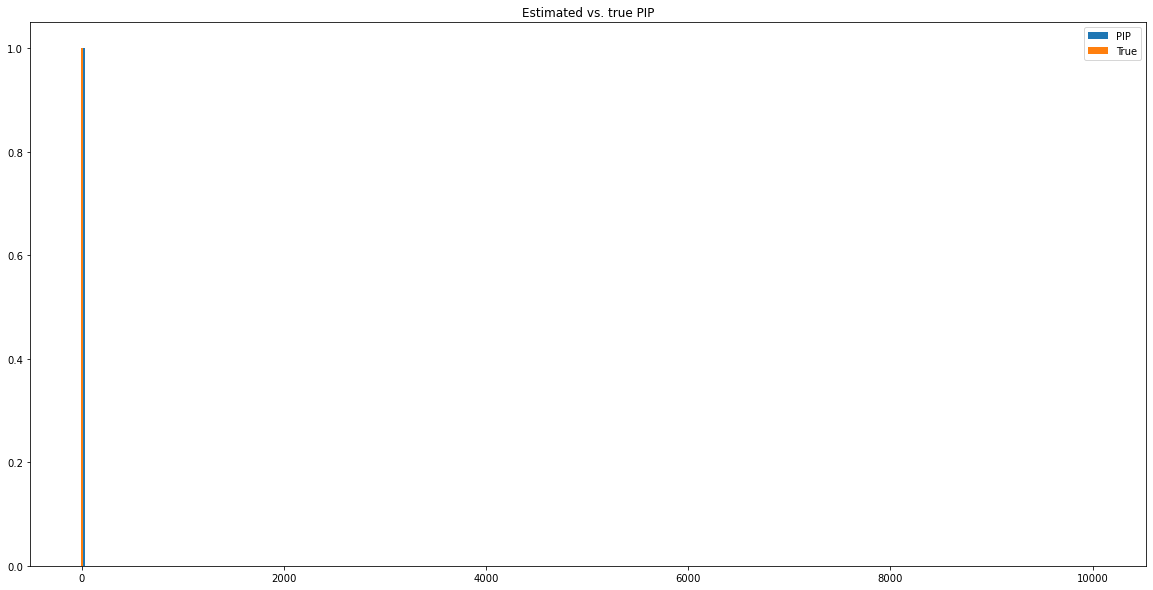

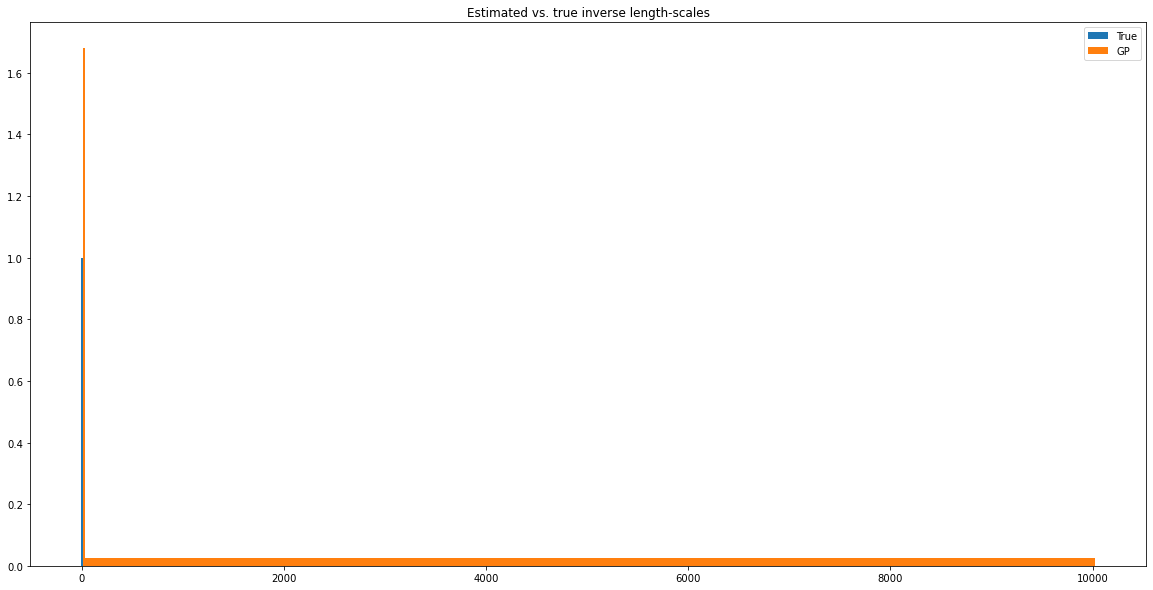

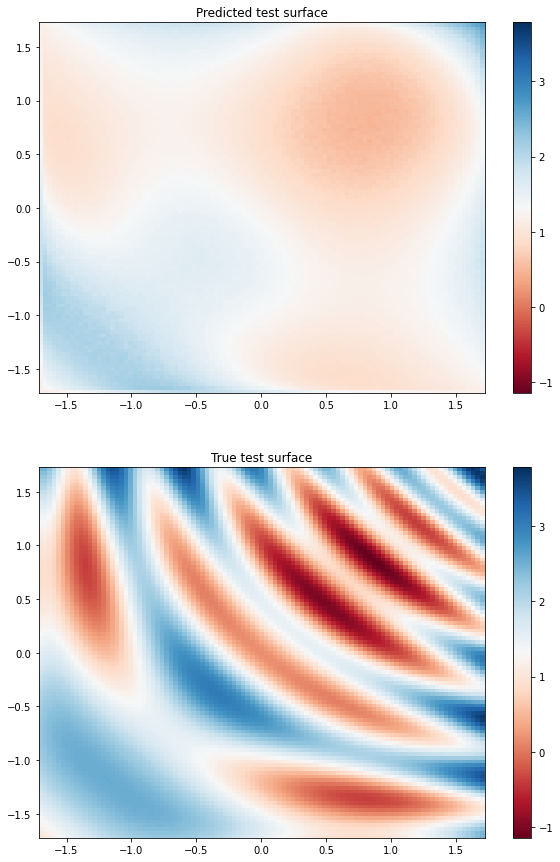

Latent test function MSE :  0.53906596
Observed test data  MSE :  0.82907116


In [43]:
modelrun = ["SGP", "SVGP"]
dlist = [100,1000,10000]
for i in range(len(dlist)):
    
    p=dlist[i]
    np.random.seed(8750)
    ls_init = np.random.random(p*ntrial).reshape(ntrial,p)
    ls_init = np.maximum(ls_init,0.05)
        
    L = np.zeros((nmodel,ntrial,p))
    Lambda = np.zeros((nmodel,ntrial,p))
    Preds = np.zeros((nmodel,ntrial,ntest))
    MSE_F = np.zeros((nmodel, ntrial))
    MSE_Y = np.zeros((nmodel, ntrial))
    Train_time = np.zeros((nmodel, ntrial))
    Test_time = np.zeros((nmodel, ntrial))
    TPR = np.zeros((nmodel, ntrial))
    PPV = np.zeros((nmodel, ntrial))
    Losses = np.zeros((nmodel, ntrial,np.max((epochs[i],iters[i]))+1))

    """
    Looping over iterations of data draws
    """
                   
    for j in range(ntrial):
        np.random.seed(j) # Setting seed to draw data
                   
        """
        Drawing data to use for simulation
        """
        Y,F,X,e,sigma,select,ntrain,ntest = draw_GP.draw_parametric_sin_2d_new2(n, ntest, p-2, 0, 1, corrxz=corrxz,corrzz=corrzz, r2=r2, lin=lin, block_corr = block_corr)

        X = (X-X[:ntrain].mean(0))/X[:ntrain].var(0)**0.5
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(Y.reshape(ntrain+ntest,)).float()
        f = torch.from_numpy(F.reshape(ntrain+ntest,)).float()

        train_x = X[:ntrain, :]
        train_y = y[:ntrain]
        test_x = X[ntrain:, :]
        test_y = y[ntrain:]
        test_f = f[ntrain:]

        Xtrain = np.array(train_x)
        ytrain =np.array(train_y).reshape(len(train_y),1)
        Xtest = np.array(test_x)
        ytest = np.array(test_y).reshape(len(test_y),1)
        ftest = np.array(test_f).reshape(len(test_f),1)

        # Storing relevant X's and y,f for test set
        Xtestvals.append(Xtest[:,:q])
        Ytestvals.append(ytest)
        Ftestvals.append(ftest)

        """
        Running SGP
        """
        if "SGP" in modelrun:
            # Training
            if train:
                t=time.time()
                model,loss,likelihood, losses = SGP_train(train_y, train_x, lengthscale_init = 1 +9*(p>100)+20*(p>1000), num_inducing=inducing, iterations=iters[i], learn_rate = 0.1, 
                                                seed = train_seed, min_iterations=iters[i], alpha = 0.01)
                Train_time[0,j] = time.time()-t
                L[0,j] = 1/model.base_covar_module.base_kernel.lengthscale.detach().numpy()

            # Testing
            if test:
                t = time.time()
                preds = SVGP_test(model,likelihood,test_y, test_x, batch_size=100)

                if test_store:
                    Test_time[0,j] = time.time()-t
                    MSE_Y[0,j] = (torch.mean(torch.abs(preds - test_y.cpu())**2)).detach().numpy()
                    MSE_F[0,j] = (torch.mean(torch.abs(preds - test_f.cpu())**2)).detach().numpy()
                    Preds[0,j] = preds
                    Losses[0,j,:iters[i]+1] = losses
                    print("Latent test function MSE : ", MSE_F[0])
                    print("Test time is : ", Test_time[0])

            # Plotting results
            if plot:
                diagnostics.plot_length_scales_pip(np.concatenate((np.repeat(1,q),np.repeat(0,p-q))),L[0,j],L[0,j]>0.1)
                ztrue = np.reshape(ftest,(int(len(ftest)**0.5),int(len(ftest)**0.5)))
                z = np.reshape(preds.detach().numpy(),(int(len(ftest)**0.5),int(len(ftest)**0.5)))

                x1 =  np.reshape(Xtest[:,0],(int(len(ftest)**0.5),int(len(ftest)**0.5)))
                x2 =  np.reshape(Xtest[:,1],(int(len(ftest)**0.5),int(len(ftest)**0.5)))

                fig,axs = plt.subplots(2,figsize = (10,15))
                z_min, z_max = ztrue.min(), ztrue.max()
                c = axs[0].pcolormesh(x1, x2, z, cmap='RdBu', vmin=z_min, vmax=z_max)
                axs[0].set_title('Predicted test surface')
                axs[0].axis([x1.min(), x1.max(), x2.min(), x2.max()])
                fig.colorbar(c, ax=axs[0])

                z_min, z_max = ztrue.min(), ztrue.max()
                c = axs[1].pcolormesh(x1, x2, ztrue, cmap='RdBu', vmin=z_min, vmax=z_max)
                axs[1].set_title('True test surface')
                axs[1].axis([x1.min(), x1.max(), x2.min(), x2.max()])
                fig.colorbar(c, ax=axs[1])
                plt.show()

                print("Latent test function MSE : ",(torch.mean(torch.abs(preds - test_f.cpu())**2)).detach().numpy())
                print("Observed test data  MSE : ",(torch.mean(torch.abs(preds - test_y.cpu())**2)).detach().numpy())
                
        if "SVGP" in modelrun:
            """
            Running SVGP
            """

            # Training
            if train:
                t=time.time()
                model,loss,likelihood,losses = SVGP_train(train_y, train_x, lengthscale_init = 1+9*(p>100)+20*(p>1000), num_inducing=inducing, epochs=epochs[i], batch_size=batch, learn_rate_variational = 0.01, 
                                                   learn_rate_hyper = 0.01, tol = 1e-3, seed = train_seed, min_epochs = epochs[i], alpha = 0.01)
                Train_time[1,j] = time.time()-t
                L[1,j] = 1/model.covar_module.base_kernel.lengthscale.detach().numpy()

            # Testing
            if test:
                t = time.time()
                preds = SVGP_test(model,likelihood,test_y, test_x, batch_size=100)

                if test_store:
                    Test_time[1,j] = time.time()-t
                    MSE_Y[1,j] = (torch.mean(torch.abs(preds - test_y.cpu())**2)).detach().numpy()
                    MSE_F[1,j] = (torch.mean(torch.abs(preds - test_f.cpu())**2)).detach().numpy()
                    Preds[1,j] = preds
                    Losses[1,j,:epochs[i]+1] = losses
                    print("Latent test function MSE : ", MSE_F[1])
                    print("Test time is : ", Test_time[1])

            # Plotting results
            if plot:
                diagnostics.plot_length_scales_pip(np.concatenate((np.repeat(1,q),np.repeat(0,p-q))),L[1,j],L[1,j]>0.1)
                ztrue = np.reshape(ftest,(int(len(ftest)**0.5),int(len(ftest)**0.5)))
                z = np.reshape(preds.detach().numpy(),(int(len(ftest)**0.5),int(len(ftest)**0.5)))

                x1 =  np.reshape(Xtest[:,0],(int(len(ftest)**0.5),int(len(ftest)**0.5)))
                x2 =  np.reshape(Xtest[:,1],(int(len(ftest)**0.5),int(len(ftest)**0.5)))

                fig,axs = plt.subplots(2,figsize = (10,15))
                z_min, z_max = ztrue.min(), ztrue.max()
                c = axs[0].pcolormesh(x1, x2, z, cmap='RdBu', vmin=z_min, vmax=z_max)
                axs[0].set_title('Predicted test surface')
                axs[0].axis([x1.min(), x1.max(), x2.min(), x2.max()])
                fig.colorbar(c, ax=axs[0])

                z_min, z_max = ztrue.min(), ztrue.max()
                c = axs[1].pcolormesh(x1, x2, ztrue, cmap='RdBu', vmin=z_min, vmax=z_max)
                axs[1].set_title('True test surface')
                axs[1].axis([x1.min(), x1.max(), x2.min(), x2.max()])
                fig.colorbar(c, ax=axs[1])
                plt.show()

                print("Latent test function MSE : ",(torch.mean(torch.abs(preds - test_f.cpu())**2)).detach().numpy())
                print("Observed test data  MSE : ",(torch.mean(torch.abs(preds - test_y.cpu())**2)).detach().numpy())



    """
    Storing results in master lists
    """

    Lengthscales.append(L)
    Lambdas.append(Lambda)
    Predictions.append(Preds)
    MSerrors_Y.append(MSE_Y)
    MSerrors_F.append(MSE_F)
    Training_times.append(Train_time)
    Testing_times.append(Test_time)
    Loss.append(Losses)

In [45]:
from datetime import date
Output = {"Names" : names, "L" : Lengthscales, "Lambda" : Lambdas,"Preds" : Predictions, "MSE_Y" : MSerrors_Y, "MSE_F" : MSerrors_F, "Train_time" : Training_times, "Test_time" : Testing_times}
String = "EXPERIMENT_{0}_2dsimSVGPonly_{12}_n={1}_ntest={2}_pvals={3}_r2={11}_corr={4}_sigma2={5}_batch={6}_inducing={7}_sgdbatch={8}_nnpred={9}_nnpredsize={10}".format(
    date.today(),ntrain,ntest,dlist, corrxz, np.round(1-r2,1), batch, inducing,minibatch,NNpred,nns, r2, modelrun)
np.save(String, Output) # saving